In [94]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [95]:
L = 7 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [96]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [97]:
#initialisation of the Gauss laws
LL = 5 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[5]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste[6]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste_m[2]],
    ["I",liste[3]],
])

gauss_law_map.append([
    ["z",liste[3]],
    ["z",liste_m[4]],
    ["z",liste_m[6]],

])

gauss_law_map.append([
    ["z",liste[4]],
    ["z",liste_m[5]],
    ["I",liste[5]],

])
for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [98]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [99]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [100]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [101]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [102]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [103]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [104]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [105]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**0*M,2])
mass_term.append([2*(-1)**0*M,3])
mass_term.append([2*(-1)**1*M,4])
mass_term.append([2*(-1)**0*M,5])
mass_term.append([2*(-1)**1*M,6])

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = -0.5*(Proj[2]@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[3]+Proj[3]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@Proj[2])
interaction[3] = -0.5*(Proj[4]@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[2].tocsc()@Proj[4])
interaction[4] = 0.5*(Proj[5]@phase_ham[4].tocsc()@phase_ham[6].tocsc()@link_p_ham[4].tocsc()@Proj[4]+Proj[4]@link_m_ham[4].tocsc()@phase_ham[4].tocsc()@phase_ham[6].tocsc()@Proj[5])
interaction[5] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[5].tocsc()@link_p_ham[5].tocsc()@Proj[5]+Proj[5]@link_m_ham[5].tocsc()@phase_ham[5].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[6] = 0.5*(Proj[1]@phase_ham[1].tocsc()@phase_ham[6].tocsc()@link_p_ham[6].tocsc()@Proj[4]+Proj[4]@link_m_ham[6].tocsc()@phase_ham[6].tocsc()@phase_ham[1].tocsc()@Proj[1])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(4)]

plaquette[0] = 0.5*(Proj_0[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj_0[5]+Proj_0[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj_0[5])
plaquette[1] = -0.5*(Proj[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj[5]+Proj[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj[5])
plaquette[2] = -0.5*(Proj_0[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj_0[4]+Proj_0[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj_0[4])
plaquette[3] = 0.5*(Proj[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj[4]+Proj[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj[4])

h_plaq = 0

for i in range(4):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.6*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [106]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [107]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-6.94764277 -6.19811477 -6.17465137]


In [108]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [109]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-2:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.6209751  -0.89907721 -0.7386169 ]
(0.09237982552796313-0.043581943629050914j)|2 1 2 1 1 1 1>
(-0.20618804506405808+0.09727314059762793j)|2 1 1 1 1 1 1>
(0.11532889192366497-0.05440860315433851j)|2 1 1 1 0 0 2>
(0.11805892055938343-0.055696546202806695j)|1 2 2 0 1 1 0>
(-0.2205218208693669+0.10403537256297303j)|1 1 2 1 1 1 1>
(0.09237982552796352-0.043581943629050775j)|1 1 2 1 0 1 1>
(0.09237982552796288-0.04358194362905124j)|1 1 1 2 1 2 1>
(-0.20618804506405675+0.09727314059762894j)|1 1 1 2 1 1 1>
(-0.220521820869366+0.1040353725629718j)|1 1 1 1 1 2 1>
(0.5818853619156571-0.27451551133208035j)|1 1 1 1 1 1 1>
(-0.1538719136751904+0.07259200836936043j)|1 1 1 1 1 1 0>
(-0.20618804506405725+0.09727314059762994j)|1 1 1 1 0 1 1>
(0.09237982552796473-0.04358194362905004j)|1 0 1 1 1 2 1>
(-0.20618804506405847+0.09727314059762805j)|1 0 1 1 1 1 1>
(0.11532889192366576-0.05440860315433775j)|1 0 0 2 1 1 2>
(0.11805892055938333-0.05569654620280779j)|0 1 1 1 2 2 0>



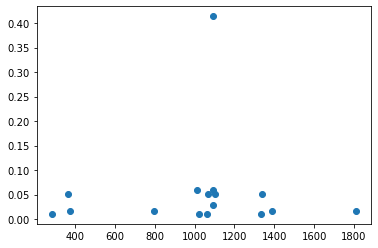

In [110]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-2:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [111]:
list1 = [0,4,5,6]
list2 = [1,2,3,4]

In [113]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k+1,L):
            summe += 1./(np.abs(k-kk)**2)*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [114]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [115]:
import optuna
n_iter = 8000
theta = np.zeros(9*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(9):
            theta[9*i+j] = trial.suggest_float("9*"+str(i)+"+"+str(j), -4*np.pi, 4*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[9*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

        psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
        psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

        psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
        psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

        psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-24 22:36:23,098] A new study created in memory with name: no-name-30459ec6-0180-4ed9-9c23-94c62d45ccca
[I 2022-05-24 22:36:26,819] Trial 0 finished with value: 28.076714785693273 and parameters: {'9*0+0': 6.1647303949599035, '9*0+1': -5.8086334218270474, '9*0+2': 1.2455569317222785, '9*0+3': -8.355309422231395, '9*0+4': 0.5953707110933699, '9*0+5': 7.4870046333271, '9*0+6': 4.607169387448209, '9*0+7': 0.8004747587626735, '9*0+8': 3.7446389772396316, '9*1+0': 3.0772901132421335, '9*1+1': 7.51606198183606, '9*1+2': 10.404695229307862, '9*1+3': -3.368047559951318, '9*1+4': 10.243135137910102, '9*1+5': -7.253395402748824, '9*1+6': 0.6336415257071142, '9*1+7': -1.3560696916789912, '9*1+8': -3.889932244698892, '9*2+0': -2.2088236153531042, '9*2+1': -5.142002682478497, '9*2+2': 3.6706756481904925, '9*2+3': 9.29391168597504, '9*2+4': -2.2424914501101245, '9*2+5': -6.8708680496339705, '9*2+6': -5.272215876942347, '9*2+7': -1.5781022034884025, '9*2+8': -7.801544375508637, '9*3+0': -1.

[I 2022-05-24 22:36:55,144] Trial 7 finished with value: 32.383241486501106 and parameters: {'9*0+0': -6.6143448919353345, '9*0+1': -2.0035926313721375, '9*0+2': 2.7475083698694185, '9*0+3': -1.0199439082953246, '9*0+4': -3.7958948735301354, '9*0+5': 1.5973387456887298, '9*0+6': -3.9032286159534104, '9*0+7': 5.004787971720751, '9*0+8': 0.720595533048542, '9*1+0': 0.7154671250605583, '9*1+1': -0.9079026919869185, '9*1+2': -1.7919129571761718, '9*1+3': 5.593963683004156, '9*1+4': 0.8788514981395618, '9*1+5': 0.753599798452149, '9*1+6': 0.9851263076513843, '9*1+7': 3.276329413632713, '9*1+8': 5.951655219321772, '9*2+0': 7.71311118334894, '9*2+1': 4.533657536122132, '9*2+2': 0.6058782952301175, '9*2+3': -2.913890367689966, '9*2+4': -2.7932085969393077, '9*2+5': 1.0043794888178097, '9*2+6': 3.011036032795248, '9*2+7': 0.7976326596878497, '9*2+8': -0.6297095771149459, '9*3+0': 2.0897092044637304, '9*3+1': 7.317478456491926, '9*3+2': -0.390436203330656, '9*3+3': 4.7196929622831005, '9*3+4': 3

[I 2022-05-24 22:37:21,886] Trial 14 finished with value: 28.813636006007002 and parameters: {'9*0+0': -3.178136408821456, '9*0+1': -0.5647087374180639, '9*0+2': 2.521689613850509, '9*0+3': -1.8498081918190792, '9*0+4': 1.5199483545798829, '9*0+5': 9.30086997606784, '9*0+6': -5.5670759779164225, '9*0+7': 5.008534333135185, '9*0+8': 0.8181854069280359, '9*1+0': 0.7401620731076963, '9*1+1': 1.6399831340234468, '9*1+2': 2.5434428653164436, '9*1+3': 0.5829984826982109, '9*1+4': 5.721753155206539, '9*1+5': 0.7934824537201494, '9*1+6': 3.6725539518183847, '9*1+7': -2.9153281695685567, '9*1+8': -6.17671074872572, '9*2+0': 3.2342696520865246, '9*2+1': 6.319734091117895, '9*2+2': 3.654957983455321, '9*2+3': -0.21842304455624134, '9*2+4': 0.03805510995239777, '9*2+5': -2.2596706718035082, '9*2+6': -5.101183677981255, '9*2+7': 5.057314491176899, '9*2+8': -0.32504811416501134, '9*3+0': 6.40626862622983, '9*3+1': -4.494217171688407, '9*3+2': -1.6520181702499637, '9*3+3': -0.37072380026585683, '9*3+

[I 2022-05-24 22:37:46,667] Trial 21 finished with value: 27.689606348381254 and parameters: {'9*0+0': 8.684571449376037, '9*0+1': 0.4825488975879483, '9*0+2': 9.793497794831307, '9*0+3': -7.9221793365360895, '9*0+4': 5.832337906716186, '9*0+5': -0.5616104134732929, '9*0+6': 4.7933118656037, '9*0+7': 0.4597110725210033, '9*0+8': -0.7715889903905002, '9*1+0': 1.873571101740618, '9*1+1': -0.7710047029636059, '9*1+2': -2.7094560337965663, '9*1+3': 2.6432193055974724, '9*1+4': -5.227120778121456, '9*1+5': -2.922288228776866, '9*1+6': 7.746993904549458, '9*1+7': -6.128885340522235, '9*1+8': 1.1421406085234593, '9*2+0': -3.223502226276259, '9*2+1': 5.988504035351548, '9*2+2': -4.404366415190946, '9*2+3': -2.456282340904513, '9*2+4': -2.5455130523830536, '9*2+5': 1.578130019847046, '9*2+6': 5.941500629478552, '9*2+7': 0.9660082395785694, '9*2+8': 5.257272314365679, '9*3+0': 9.792413628264246, '9*3+1': -1.0969361713455041, '9*3+2': 4.517619541189737, '9*3+3': -1.0593028584802218, '9*3+4': -2.8

[I 2022-05-24 22:38:13,085] Trial 28 finished with value: 27.183556793523614 and parameters: {'9*0+0': -1.7792377947206401, '9*0+1': -1.7954371636790423, '9*0+2': 3.649956453935502, '9*0+3': -10.715659269920266, '9*0+4': -2.0683664043666092, '9*0+5': 6.096300646921144, '9*0+6': 2.4393211646421187, '9*0+7': 0.804750804525286, '9*0+8': 4.582975542950776, '9*1+0': 1.0742184718972185, '9*1+1': -12.294339291582508, '9*1+2': 1.0382196004912259, '9*1+3': 4.812577643373874, '9*1+4': -11.093654385682086, '9*1+5': -1.2395416207952652, '9*1+6': 5.335348265810728, '9*1+7': 5.26559559470236, '9*1+8': 7.504493832925058, '9*2+0': -3.096889124563595, '9*2+1': 5.5463892404769, '9*2+2': -9.087091532316128, '9*2+3': 2.8051641732585693, '9*2+4': 0.28197144434322235, '9*2+5': 2.486730913414061, '9*2+6': -3.7631383491623014, '9*2+7': -9.478220238326989, '9*2+8': -1.919707650166644, '9*3+0': -0.7560720984483309, '9*3+1': -1.5357940751556116, '9*3+2': 1.7302153108310234, '9*3+3': 1.6456252913894998, '9*3+4': 

[I 2022-05-24 22:38:39,587] Trial 35 finished with value: 29.834002188730896 and parameters: {'9*0+0': 5.275403446529294, '9*0+1': 2.1347590874564997, '9*0+2': 1.6229562924835754, '9*0+3': -2.9549240405389523, '9*0+4': -9.338711715168497, '9*0+5': -1.8931496961463503, '9*0+6': 3.761857785388315, '9*0+7': 5.743315243648913, '9*0+8': 0.7178246322863258, '9*1+0': -5.171310080318244, '9*1+1': -4.668494562022767, '9*1+2': -12.316552599216374, '9*1+3': -1.4562904125696363, '9*1+4': -9.0626758727311, '9*1+5': -4.582245369583507, '9*1+6': 7.77233344760616, '9*1+7': 1.6251706691342829, '9*1+8': 4.719423317984576, '9*2+0': -3.4423568319441955, '9*2+1': 2.343967187776107, '9*2+2': -3.5355830048733674, '9*2+3': -7.5985958897351304, '9*2+4': -0.3055737126179596, '9*2+5': 0.660315297128353, '9*2+6': 4.919555339842262, '9*2+7': -6.372672094132369, '9*2+8': -3.5419482078283737, '9*3+0': 4.707937613637039, '9*3+1': 2.268152018233746, '9*3+2': 6.443286107831594, '9*3+3': -1.5567131461905452, '9*3+4': 6.

[I 2022-05-24 22:39:04,741] Trial 42 finished with value: 26.820685309711983 and parameters: {'9*0+0': 6.121317446525188, '9*0+1': -1.8953994078757228, '9*0+2': 9.259478482362708, '9*0+3': -2.4853026273396903, '9*0+4': -5.416790947229525, '9*0+5': -5.334347528447903, '9*0+6': -1.8583200869542118, '9*0+7': 2.313727609131227, '9*0+8': 7.695380185054816, '9*1+0': -3.7694656150518098, '9*1+1': 7.3703844920302, '9*1+2': -0.05750672433886139, '9*1+3': 4.344213323673797, '9*1+4': -5.828719699820908, '9*1+5': -9.630150520889359, '9*1+6': 4.237159032358907, '9*1+7': 1.6005211229154739, '9*1+8': 0.1939443682436538, '9*2+0': -6.916573697043029, '9*2+1': -1.5852079523575546, '9*2+2': -0.8958178950610279, '9*2+3': -9.423032402025564, '9*2+4': -3.464867007697736, '9*2+5': -0.1111580545400242, '9*2+6': -4.73238588545277, '9*2+7': -4.176214641942439, '9*2+8': -6.050254869849827, '9*3+0': 11.134139776760081, '9*3+1': 2.6030445213730653, '9*3+2': 3.5025992095495804, '9*3+3': -1.1524230196372574, '9*3+4'

[I 2022-05-24 22:39:30,826] Trial 49 finished with value: 28.173404657865976 and parameters: {'9*0+0': 1.7936487300425141, '9*0+1': 2.624334464646489, '9*0+2': -0.3230135523351987, '9*0+3': 1.3661923214141263, '9*0+4': -4.10262547216591, '9*0+5': -7.822093732307057, '9*0+6': -4.593535174811946, '9*0+7': 4.072908920629041, '9*0+8': 4.690711045968252, '9*1+0': 0.02490461817373868, '9*1+1': -2.7576380864259966, '9*1+2': -3.674316021922785, '9*1+3': -1.4204303473556097, '9*1+4': 1.3802706920973185, '9*1+5': -12.39407718039151, '9*1+6': 4.295205214511479, '9*1+7': -0.6546799946524884, '9*1+8': -0.7529274649991915, '9*2+0': -9.105850339745295, '9*2+1': 7.453105825656044, '9*2+2': -0.5761032175018803, '9*2+3': -1.8952120528762157, '9*2+4': -8.49720712091219, '9*2+5': -3.1653294083444385, '9*2+6': 0.35285095768159946, '9*2+7': -4.718027717552672, '9*2+8': 0.18715649390370448, '9*3+0': 9.983024981238596, '9*3+1': -3.7862964482708774, '9*3+2': 5.138923961296546, '9*3+3': -2.273244632654752, '9*3

[I 2022-05-24 22:39:57,535] Trial 56 finished with value: 29.72300042966306 and parameters: {'9*0+0': -1.0725162543991886, '9*0+1': 10.460893832965898, '9*0+2': 4.409257724132077, '9*0+3': -1.4040063608031383, '9*0+4': -0.9278190166692863, '9*0+5': -0.6307088186840026, '9*0+6': -7.338633553002377, '9*0+7': 0.45373714941592924, '9*0+8': 7.756522156958864, '9*1+0': 3.2525009498975743, '9*1+1': -3.545169218541574, '9*1+2': 0.009783281169559288, '9*1+3': 2.5893547810217274, '9*1+4': -9.06900797485742, '9*1+5': -4.111984411420296, '9*1+6': 3.3044126471451962, '9*1+7': -6.2395561961225825, '9*1+8': -1.2161030908111994, '9*2+0': -2.247226688616656, '9*2+1': 3.7261738500183736, '9*2+2': -4.781484952977991, '9*2+3': -7.093815786326702, '9*2+4': -4.85055286547974, '9*2+5': -0.38979295947303116, '9*2+6': -0.7102796926513669, '9*2+7': 2.1141040394112416, '9*2+8': -3.4777245895271336, '9*3+0': 4.4130054932113145, '9*3+1': -0.14944005849931852, '9*3+2': 3.004228203881283, '9*3+3': -1.551565402277181

[I 2022-05-24 22:40:24,309] Trial 63 finished with value: 28.73876302745783 and parameters: {'9*0+0': -0.3186767542679676, '9*0+1': 0.7622768848353121, '9*0+2': 0.6353896087029451, '9*0+3': -0.6771267791859874, '9*0+4': -10.360571382603013, '9*0+5': -0.281188584877603, '9*0+6': 0.5534414653570479, '9*0+7': 5.454466119808851, '9*0+8': 2.5763140441926806, '9*1+0': -9.75699814203505, '9*1+1': -6.45937301039977, '9*1+2': -5.468523032546428, '9*1+3': -1.3174027181546095, '9*1+4': -8.075815847790174, '9*1+5': -9.036768294970292, '9*1+6': 8.19422364310406, '9*1+7': 6.065558555327845, '9*1+8': 1.293581290868999, '9*2+0': -1.5423119332763577, '9*2+1': 3.6714699153360857, '9*2+2': -1.9092234412076023, '9*2+3': -7.345497713971049, '9*2+4': -7.873671423353418, '9*2+5': -6.3458915206851865, '9*2+6': -3.165052772394569, '9*2+7': -3.9034431083885424, '9*2+8': -8.910119052381024, '9*3+0': 2.0483470359815383, '9*3+1': 1.8565637827514192, '9*3+2': 3.6178721398112277, '9*3+3': -1.78178087816414, '9*3+4':

[I 2022-05-24 22:40:50,484] Trial 70 finished with value: 37.0942022044433 and parameters: {'9*0+0': 3.8882146904967376, '9*0+1': 1.950240884517212, '9*0+2': 7.002984354750757, '9*0+3': -0.981523711899299, '9*0+4': -4.588180159048845, '9*0+5': -4.312480800053752, '9*0+6': 1.8295185102225604, '9*0+7': 3.75901155739443, '9*0+8': 1.1010881658534624, '9*1+0': -4.990604717436002, '9*1+1': -0.009277303228347078, '9*1+2': -2.3236187959074566, '9*1+3': 2.900556524795488, '9*1+4': -7.99871855036367, '9*1+5': -9.759270109738296, '9*1+6': 0.10111126991173336, '9*1+7': 2.286768638621159, '9*1+8': -2.240975124370809, '9*2+0': -9.91221293506827, '9*2+1': 8.133075551152025, '9*2+2': -2.264562824183028, '9*2+3': -5.180083470112501, '9*2+4': -3.5720901724815475, '9*2+5': -1.9706482747950191, '9*2+6': 0.9030374772145429, '9*2+7': -10.053375996353186, '9*2+8': -3.407401620746051, '9*3+0': 1.6099577237006772, '9*3+1': -6.966244161528545, '9*3+2': 0.3186168800458864, '9*3+3': 1.9156636401646505, '9*3+4': -

[I 2022-05-24 22:41:17,366] Trial 77 finished with value: 29.328362626323912 and parameters: {'9*0+0': -1.7746944295716256, '9*0+1': 4.358332985238647, '9*0+2': 5.45166823264247, '9*0+3': 3.5375139992810958, '9*0+4': -1.1102085488583668, '9*0+5': -2.815599606484792, '9*0+6': 4.618444229842938, '9*0+7': 4.9484632945540215, '9*0+8': 8.673629500224482, '9*1+0': -2.2032255794871807, '9*1+1': -4.055200288934838, '9*1+2': -8.192067746377287, '9*1+3': 4.111414419447762, '9*1+4': 1.5270969247519943, '9*1+5': -4.726993530999519, '9*1+6': -1.3674069625697602, '9*1+7': -5.210468613541192, '9*1+8': -7.13368298530687, '9*2+0': -5.683578530760651, '9*2+1': 5.409507098386498, '9*2+2': -4.909579904334656, '9*2+3': -0.3943085596839109, '9*2+4': -6.3577040963029745, '9*2+5': -2.8064111982193354, '9*2+6': 3.097804153128644, '9*2+7': -0.5713833117199401, '9*2+8': -9.184219024817711, '9*3+0': 2.210000290267664, '9*3+1': -6.606948042166994, '9*3+2': 5.466022520977208, '9*3+3': 4.876330644112274, '9*3+4': -1

[I 2022-05-24 22:41:45,166] Trial 84 finished with value: 36.57590512926244 and parameters: {'9*0+0': -5.484686600828024, '9*0+1': -4.049876558155137, '9*0+2': 2.5927355069335345, '9*0+3': 8.494838805356887, '9*0+4': -2.294447790274196, '9*0+5': -4.8527289907415065, '9*0+6': -5.23193465624154, '9*0+7': 2.141843336742145, '9*0+8': 5.07139300714071, '9*1+0': -2.2958559242983214, '9*1+1': -1.8155929096635792, '9*1+2': -3.7013262613701436, '9*1+3': 0.8402289973194371, '9*1+4': -7.843737809548234, '9*1+5': -1.3369766398140452, '9*1+6': 3.357948175184139, '9*1+7': -1.3997396180301322, '9*1+8': 4.600061452906733, '9*2+0': -5.462052741794346, '9*2+1': 4.0257321766751515, '9*2+2': -0.6108862224825662, '9*2+3': -4.950444037487561, '9*2+4': -8.151188883226835, '9*2+5': -2.5032010391785646, '9*2+6': -4.300271043856533, '9*2+7': -5.156478644450143, '9*2+8': -3.1725360684538972, '9*3+0': 1.4513860019897313, '9*3+1': -5.9130906732498305, '9*3+2': 3.8988009790024236, '9*3+3': -1.2727232300432254, '9*3

[I 2022-05-24 22:42:12,434] Trial 91 finished with value: 27.4871015231048 and parameters: {'9*0+0': 0.7259704558143236, '9*0+1': 2.7197770813454936, '9*0+2': 4.448232346959311, '9*0+3': 1.3619686552378827, '9*0+4': 2.349117736793392, '9*0+5': 2.556371746406884, '9*0+6': -6.3569997015614, '9*0+7': 8.774954999088735, '9*0+8': -2.3765068439969244, '9*1+0': -3.6714134953474717, '9*1+1': -3.4606620428475345, '9*1+2': -2.631094486702124, '9*1+3': -2.145752166181759, '9*1+4': -7.294985765524888, '9*1+5': -8.023137962509562, '9*1+6': 6.9844981308059255, '9*1+7': -0.7057163219763026, '9*1+8': 7.064432925994035, '9*2+0': 2.523015758696303, '9*2+1': -2.065908555686666, '9*2+2': 5.7291001459125255, '9*2+3': -4.0523652246040225, '9*2+4': -5.145590998738085, '9*2+5': 3.963012278628016, '9*2+6': -0.7427638927457838, '9*2+7': -1.474118408025682, '9*2+8': -9.017731121134625, '9*3+0': 3.450284584768022, '9*3+1': -5.992198271553944, '9*3+2': 8.547218896881928, '9*3+3': 7.650297406394291, '9*3+4': -9.649

[I 2022-05-24 22:42:38,908] Trial 98 finished with value: 34.203100159782906 and parameters: {'9*0+0': 3.6143946922838235, '9*0+1': 6.618827931832383, '9*0+2': 3.573000280510355, '9*0+3': 2.955677067819188, '9*0+4': 3.416252007812462, '9*0+5': -5.30348911766292, '9*0+6': -3.3507149074222196, '9*0+7': 1.6393854374330274, '9*0+8': -0.9989842250527516, '9*1+0': -6.361300894608489, '9*1+1': 2.5867362779313776, '9*1+2': -2.4882888587610643, '9*1+3': -3.633540016690109, '9*1+4': -8.975233267757885, '9*1+5': -2.682790194249179, '9*1+6': 1.3278008943289996, '9*1+7': -3.369593372823662, '9*1+8': 1.5398697987666776, '9*2+0': -0.8202036799511676, '9*2+1': 1.812833412295216, '9*2+2': -0.6255333548758091, '9*2+3': 0.6837835135989236, '9*2+4': -5.097951180822663, '9*2+5': -5.255259637465526, '9*2+6': -2.7935832261130296, '9*2+7': -4.297300347145312, '9*2+8': -3.730783842951423, '9*3+0': -2.517001246079598, '9*3+1': -0.28649964064294053, '9*3+2': 7.506457144498617, '9*3+3': 11.434048778882243, '9*3+4

[I 2022-05-24 22:43:05,714] Trial 105 finished with value: 31.93393643507274 and parameters: {'9*0+0': -2.81455493406024, '9*0+1': 3.252679342809797, '9*0+2': 9.750912809114155, '9*0+3': -1.2891503656455148, '9*0+4': -2.4952065532216956, '9*0+5': 5.1218731268182776, '9*0+6': -8.36997541020132, '9*0+7': 3.2164772960311523, '9*0+8': 2.4435171720477715, '9*1+0': -9.080839781342291, '9*1+1': 2.2094894038333543, '9*1+2': -6.25758700076449, '9*1+3': -3.8566127099350513, '9*1+4': -6.509870827649211, '9*1+5': 0.49701769864130263, '9*1+6': 2.086593237282406, '9*1+7': -3.1837934076084853, '9*1+8': 5.0875283414915, '9*2+0': -0.19113035414248714, '9*2+1': -5.325313838766969, '9*2+2': -2.1263403601007913, '9*2+3': -5.946855013662181, '9*2+4': -1.1612493160590542, '9*2+5': -3.146404353604787, '9*2+6': -0.3794391802348964, '9*2+7': 5.269146076521482, '9*2+8': -9.088243812543235, '9*3+0': 7.848748193229239, '9*3+1': 2.0038602224071482, '9*3+2': 0.3852457011492918, '9*3+3': 11.264027770572834, '9*3+4':

[I 2022-05-24 22:43:30,279] Trial 112 finished with value: 25.493059051119847 and parameters: {'9*0+0': -3.379401658753069, '9*0+1': -3.2350628284858565, '9*0+2': 5.677023091781091, '9*0+3': -2.259394948861751, '9*0+4': -0.01601525327369635, '9*0+5': -1.1446620050691136, '9*0+6': -2.048260658551799, '9*0+7': 0.8915669510157391, '9*0+8': -0.18844897091957402, '9*1+0': 2.7057445881324655, '9*1+1': -3.455368960782308, '9*1+2': -3.655431260012237, '9*1+3': -0.7698380352440364, '9*1+4': -9.383441582381053, '9*1+5': -2.092825695585601, '9*1+6': 9.836112612325692, '9*1+7': 0.5866788653675825, '9*1+8': 7.940811809921706, '9*2+0': 3.0509469439667796, '9*2+1': 2.8496412662282267, '9*2+2': 1.6542333187743266, '9*2+3': -0.930673327587185, '9*2+4': -10.67486774682841, '9*2+5': 1.3180950961143183, '9*2+6': -2.140960946190105, '9*2+7': -4.1169229034529415, '9*2+8': -3.2981774864484157, '9*3+0': 0.3808301380504293, '9*3+1': -2.524059504522275, '9*3+2': 4.021016694002903, '9*3+3': 8.758772177790858, '9

[I 2022-05-24 22:43:56,170] Trial 119 finished with value: 31.853015990535603 and parameters: {'9*0+0': -2.014448245756378, '9*0+1': -4.203875004066727, '9*0+2': 8.286195463297346, '9*0+3': -9.441026861549986, '9*0+4': 0.04684963492100902, '9*0+5': 4.973695434221861, '9*0+6': -7.98983905791979, '9*0+7': 3.862099211221442, '9*0+8': -3.9069075308531214, '9*1+0': 3.522650765671748, '9*1+1': -0.15074528762944706, '9*1+2': -3.510935194111963, '9*1+3': -5.888960401357629, '9*1+4': -8.474733377679822, '9*1+5': -5.335946732817121, '9*1+6': 5.138514445579606, '9*1+7': -8.798806834427735, '9*1+8': 7.419106439075246, '9*2+0': 1.3215827312909512, '9*2+1': 1.928461625431342, '9*2+2': 8.534942973683783, '9*2+3': -0.2447474964583196, '9*2+4': -10.086956025460042, '9*2+5': -1.3758340893266183, '9*2+6': -2.8142394066488325, '9*2+7': -1.9387092098281922, '9*2+8': -6.898319408234814, '9*3+0': 6.818840406200964, '9*3+1': -2.0626783383857736, '9*3+2': 4.0047317501066715, '9*3+3': 5.229271019649642, '9*3+4'

[I 2022-05-24 22:44:20,073] Trial 126 finished with value: 23.13778157594575 and parameters: {'9*0+0': -0.1047066131201157, '9*0+1': 6.212607321360927, '9*0+2': 9.081529376921942, '9*0+3': -1.2419031917551995, '9*0+4': 2.9330700746656917, '9*0+5': 0.6948616580424429, '9*0+6': -5.505647915017772, '9*0+7': 5.809209518926746, '9*0+8': -3.424179351020388, '9*1+0': -1.5824872031781618, '9*1+1': 1.90194950419388, '9*1+2': 1.1902783440767037, '9*1+3': -0.41986954865600445, '9*1+4': -7.023147012410085, '9*1+5': -9.103408895739378, '9*1+6': 5.015998378580381, '9*1+7': -1.4605746877668844, '9*1+8': 6.285949097627718, '9*2+0': 0.4063930109250507, '9*2+1': 3.6319614869378967, '9*2+2': 1.6367756190619664, '9*2+3': -1.5229991313555051, '9*2+4': -10.789907519111388, '9*2+5': -5.571385190916171, '9*2+6': 1.5525496427062007, '9*2+7': -1.3581549406147768, '9*2+8': -6.341250178728372, '9*3+0': -0.09177371998936845, '9*3+1': -2.9501737841143916, '9*3+2': -1.5360922350242352, '9*3+3': 8.178852362924264, '9

[I 2022-05-24 22:44:40,426] Trial 133 finished with value: 31.023234382392125 and parameters: {'9*0+0': 5.575287975205361, '9*0+1': 3.0995722136031096, '9*0+2': 5.250004057391349, '9*0+3': -0.6125411989760516, '9*0+4': -3.645774773390082, '9*0+5': -4.961782336093169, '9*0+6': -6.344164873267792, '9*0+7': 1.1327156830927918, '9*0+8': -7.7619928466782735, '9*1+0': 4.627496666361537, '9*1+1': -9.846407540712127, '9*1+2': -0.8540529152595856, '9*1+3': 2.758000340478833, '9*1+4': -6.773093123419732, '9*1+5': -7.669152009277223, '9*1+6': 1.3551862985842158, '9*1+7': 4.4973092223390365, '9*1+8': 3.816129265588814, '9*2+0': -5.1325142674051705, '9*2+1': -4.991624330235921, '9*2+2': 10.471121352521935, '9*2+3': -8.704203103252048, '9*2+4': -4.9704021454920495, '9*2+5': -8.518513056648644, '9*2+6': -1.1273862305851154, '9*2+7': 6.685575600741494, '9*2+8': 2.6230645934042816, '9*3+0': 9.339355792828796, '9*3+1': 0.9049227034890017, '9*3+2': -0.07199031390707455, '9*3+3': 6.569742936219675, '9*3+4

[I 2022-05-24 22:45:00,957] Trial 140 finished with value: 22.31221969953878 and parameters: {'9*0+0': -0.7703153290870179, '9*0+1': -2.4975633040686396, '9*0+2': 7.49080488573106, '9*0+3': 3.7338326963161594, '9*0+4': 2.636994016001905, '9*0+5': -5.323748671602229, '9*0+6': -5.729946491436372, '9*0+7': 0.5266851279548557, '9*0+8': 4.154155439336904, '9*1+0': -1.475165101166877, '9*1+1': -5.7274980044744215, '9*1+2': 0.5314974182469787, '9*1+3': 2.376693752357504, '9*1+4': -8.095973204534113, '9*1+5': -0.48951777827835663, '9*1+6': 8.883622671981703, '9*1+7': -1.3131097524528754, '9*1+8': 0.05606030178623955, '9*2+0': 0.07826555760635223, '9*2+1': 1.6471811748704919, '9*2+2': 3.725043148899286, '9*2+3': -9.641972325433986, '9*2+4': -5.627323667412683, '9*2+5': -9.615228717459821, '9*2+6': -3.069058676449573, '9*2+7': 1.1987890233050962, '9*2+8': -1.1151475574563523, '9*3+0': 7.015784819344405, '9*3+1': -1.488662253885351, '9*3+2': -5.675171611089519, '9*3+3': 11.35268071198749, '9*3+4'

[I 2022-05-24 22:45:21,665] Trial 147 finished with value: 29.1043679087696 and parameters: {'9*0+0': -8.404355312271491, '9*0+1': -0.5601346036803991, '9*0+2': 8.947407148259714, '9*0+3': 3.0580834504264827, '9*0+4': -4.340735735149474, '9*0+5': -4.784839541031787, '9*0+6': -5.8634011366131515, '9*0+7': 1.1295131824498188, '9*0+8': -0.545762046132594, '9*1+0': -3.4004695106375395, '9*1+1': -2.7316343785064383, '9*1+2': -1.277471895022768, '9*1+3': 1.1832088138098025, '9*1+4': -7.686439399804767, '9*1+5': -5.429022157601425, '9*1+6': 0.09864040104509453, '9*1+7': 4.422813968117732, '9*1+8': 5.475178056240084, '9*2+0': -1.9247124785626006, '9*2+1': -2.639382947028351, '9*2+2': 2.8874045669504103, '9*2+3': -6.135011367380022, '9*2+4': -9.62747212866828, '9*2+5': -2.9577894635465465, '9*2+6': 3.4802890760699103, '9*2+7': 3.121641834662876, '9*2+8': -3.429188881104298, '9*3+0': 2.3027475770111514, '9*3+1': 1.6606629303483311, '9*3+2': -7.890290691634384, '9*3+3': 8.665999317846982, '9*3+4'

[I 2022-05-24 22:45:42,220] Trial 154 finished with value: 27.669725732918003 and parameters: {'9*0+0': 3.4917352592595163, '9*0+1': 1.9082625539320524, '9*0+2': 8.263173513176454, '9*0+3': 0.686031562651688, '9*0+4': 1.7039555385081882, '9*0+5': -8.77334984080033, '9*0+6': -3.983089071133179, '9*0+7': 6.323434047768682, '9*0+8': -2.841943376457325, '9*1+0': 1.0623623136505702, '9*1+1': -4.454040244125305, '9*1+2': -6.186468884450397, '9*1+3': 3.563584839464483, '9*1+4': -5.291254190716106, '9*1+5': -6.7430918055639175, '9*1+6': 4.970533421792506, '9*1+7': 2.52595502111232, '9*1+8': 3.2650184581732558, '9*2+0': -3.9986509424137475, '9*2+1': -1.6295008026003102, '9*2+2': 3.8417998664565163, '9*2+3': -5.106264986757905, '9*2+4': -12.003427223514949, '9*2+5': -3.9368921165233113, '9*2+6': -2.6872749220322016, '9*2+7': 1.7487674934888155, '9*2+8': 1.7731217364417744, '9*3+0': 1.9734846433903517, '9*3+1': -0.7562991259392498, '9*3+2': 1.8548161775887109, '9*3+3': 3.2521520307985083, '9*3+4'

[I 2022-05-24 22:46:02,906] Trial 161 finished with value: 29.337730076372583 and parameters: {'9*0+0': 5.747191805268444, '9*0+1': -2.3900650662039444, '9*0+2': 3.9897737245568115, '9*0+3': -4.001500838241417, '9*0+4': 1.430613880203418, '9*0+5': -0.8609450228758666, '9*0+6': -2.9104705011070413, '9*0+7': -0.2978871546641153, '9*0+8': 0.5236563191673016, '9*1+0': -2.947113414017101, '9*1+1': 5.209941514206496, '9*1+2': -1.3092236264862618, '9*1+3': 1.571271168907559, '9*1+4': -6.098979028941487, '9*1+5': -9.414873116945717, '9*1+6': 2.0267759800589404, '9*1+7': 2.503007590474675, '9*1+8': 2.110388751536341, '9*2+0': -3.947381426976204, '9*2+1': -1.9072420325399566, '9*2+2': 0.09567356258480353, '9*2+3': -1.1134998073077398, '9*2+4': -7.557285041330616, '9*2+5': 2.882987153469556, '9*2+6': 0.4019171344539152, '9*2+7': -2.3007324681164834, '9*2+8': 0.7994785781179927, '9*3+0': 5.945869516428917, '9*3+1': -7.8808301853319715, '9*3+2': -3.7993217301965867, '9*3+3': 6.7773241760021925, '9*

[I 2022-05-24 22:46:23,612] Trial 168 finished with value: 48.01630133505761 and parameters: {'9*0+0': 2.4778199654786257, '9*0+1': -4.167557932588496, '9*0+2': 3.710383050319284, '9*0+3': -1.094418332356721, '9*0+4': 2.844274536608845, '9*0+5': -8.750472389591723, '9*0+6': -0.7822330594361464, '9*0+7': -7.3053832837639, '9*0+8': 1.590936665134034, '9*1+0': -2.064970586852244, '9*1+1': -1.4580368517489974, '9*1+2': -7.397071469409596, '9*1+3': 3.68503022321845, '9*1+4': -4.6150403545983405, '9*1+5': -7.073834175907796, '9*1+6': 6.722876072343558, '9*1+7': 0.6823106609352922, '9*1+8': 4.080717389807622, '9*2+0': -4.0246174704713535, '9*2+1': -6.1074000620374935, '9*2+2': 3.196568774146167, '9*2+3': -6.968291848926084, '9*2+4': -12.241803726604115, '9*2+5': 0.9016720881268707, '9*2+6': -2.0882380449885956, '9*2+7': 1.8630473415528463, '9*2+8': 4.277686318575587, '9*3+0': 3.4743069669378572, '9*3+1': -2.1473611480455372, '9*3+2': -6.922256807290124, '9*3+3': 7.955075123198216, '9*3+4': -2

[I 2022-05-24 22:46:44,235] Trial 175 finished with value: 25.761370738959403 and parameters: {'9*0+0': 1.6174234704285924, '9*0+1': -5.776042456846403, '9*0+2': 12.171395179880179, '9*0+3': 1.8119664503307198, '9*0+4': -0.3383554723243487, '9*0+5': -4.237883408689075, '9*0+6': 0.8287297278537066, '9*0+7': -6.06602562864145, '9*0+8': 0.07666040934639784, '9*1+0': 1.510975974763837, '9*1+1': -3.661503921821231, '9*1+2': -3.7796547726825973, '9*1+3': 5.382194241857006, '9*1+4': -10.594093485598044, '9*1+5': -6.025846754414522, '9*1+6': 5.787093549449185, '9*1+7': 0.5330297314379155, '9*1+8': 2.609721179827698, '9*2+0': -8.560370323533228, '9*2+1': -3.9205109994361553, '9*2+2': 3.2593679621110967, '9*2+3': -8.056352869719351, '9*2+4': -11.757490409072863, '9*2+5': -8.121870765498288, '9*2+6': -6.762644580194866, '9*2+7': -7.457897028761869, '9*2+8': -5.394721738299917, '9*3+0': 4.096797147520329, '9*3+1': -6.0277257465980245, '9*3+2': -4.754683511611268, '9*3+3': 2.1646306985984642, '9*3+

[I 2022-05-24 22:47:04,819] Trial 182 finished with value: 29.307591750313755 and parameters: {'9*0+0': 3.4744973069520633, '9*0+1': 3.9391701908915344, '9*0+2': 5.780494963265716, '9*0+3': 1.6770187144137263, '9*0+4': 0.8416872755507715, '9*0+5': -5.801830132396113, '9*0+6': -1.5115356386223633, '9*0+7': -0.9290546948588796, '9*0+8': 2.037277454000516, '9*1+0': -4.369987534301598, '9*1+1': -3.478911950776223, '9*1+2': -4.063202806582444, '9*1+3': 7.116867533094704, '9*1+4': -9.892083217446952, '9*1+5': -0.9946514894058947, '9*1+6': 7.908407379736538, '9*1+7': 7.273989367253018, '9*1+8': 0.9204187805328405, '9*2+0': -0.973536107651926, '9*2+1': -3.1452700660382433, '9*2+2': -2.051535480382672, '9*2+3': -4.857498244687196, '9*2+4': -6.647748670281233, '9*2+5': -6.317748353775162, '9*2+6': -5.012929067218946, '9*2+7': -1.2987125113046039, '9*2+8': -2.0469148295922235, '9*3+0': 0.5245198431188838, '9*3+1': -8.45824862418543, '9*3+2': -10.47534420045682, '9*3+3': 6.5097870504837285, '9*3+4

[I 2022-05-24 22:47:25,356] Trial 189 finished with value: 19.45218291890655 and parameters: {'9*0+0': 0.7079995140988027, '9*0+1': -1.7731077929249013, '9*0+2': 5.0849002259264235, '9*0+3': 5.702334272062947, '9*0+4': 2.015554229331939, '9*0+5': -4.089363397909807, '9*0+6': 1.0793270002035649, '9*0+7': -1.9784961363498534, '9*0+8': -0.33232499251580494, '9*1+0': -2.8466161572478024, '9*1+1': -0.9685292049106264, '9*1+2': -5.579740571382008, '9*1+3': 5.060069034090803, '9*1+4': -7.953288885053661, '9*1+5': -10.668546660086854, '9*1+6': 2.869005485644606, '9*1+7': 5.285406192562247, '9*1+8': -3.1908891953295533, '9*2+0': 0.8598493794206687, '9*2+1': -3.7861771974526546, '9*2+2': 2.928963091217765, '9*2+3': -8.502073682677466, '9*2+4': -5.2893029265718585, '9*2+5': -9.647831590640225, '9*2+6': 0.42209821665686675, '9*2+7': -5.280865529711804, '9*2+8': -3.1591923997310314, '9*3+0': -2.6407927644655134, '9*3+1': -5.561981864197901, '9*3+2': -3.7112072827863387, '9*3+3': 9.407217647694164, 

[I 2022-05-24 22:47:45,872] Trial 196 finished with value: 39.93446302550781 and parameters: {'9*0+0': -0.829930193138809, '9*0+1': -4.560076404019524, '9*0+2': 6.972565719458053, '9*0+3': 5.801120095604233, '9*0+4': 4.189769246810771, '9*0+5': -1.8234489358135517, '9*0+6': -2.5067898317816195, '9*0+7': -8.615575016898804, '9*0+8': 1.1522420171351442, '9*1+0': -4.864296338632057, '9*1+1': -1.1015914919859036, '9*1+2': -0.45438022921252763, '9*1+3': 4.365387543436432, '9*1+4': -6.596125972612901, '9*1+5': -5.862326532850257, '9*1+6': 6.303994991160365, '9*1+7': 2.5880352969855154, '9*1+8': 2.6003382988645054, '9*2+0': -5.227993197894975, '9*2+1': -4.074016016638046, '9*2+2': -0.3074548165829154, '9*2+3': 0.12816290248317053, '9*2+4': -7.144328050139528, '9*2+5': -2.0643142799053025, '9*2+6': -3.295794312865207, '9*2+7': -3.5437554798177904, '9*2+8': 3.180442044157706, '9*3+0': 3.096555869927447, '9*3+1': -2.7010662714573996, '9*3+2': 2.062192651202972, '9*3+3': 7.000890740504772, '9*3+4

[I 2022-05-24 22:48:06,493] Trial 203 finished with value: 26.54817268655004 and parameters: {'9*0+0': 2.377987790252753, '9*0+1': 4.507466112667124, '9*0+2': 7.023289451460348, '9*0+3': 6.595463558703191, '9*0+4': 3.6784126573678555, '9*0+5': -1.853590155336327, '9*0+6': 1.624088455187407, '9*0+7': -6.035975777538278, '9*0+8': 3.0137259982092184, '9*1+0': -7.783239563102298, '9*1+1': -5.632054118918539, '9*1+2': -2.1322630503332487, '9*1+3': 5.7199669181954125, '9*1+4': 6.515764185776083, '9*1+5': -10.919503282427955, '9*1+6': 6.411994577644317, '9*1+7': 6.465532420997183, '9*1+8': 1.7074522108732049, '9*2+0': -0.7633150797190067, '9*2+1': -8.506346765998815, '9*2+2': 5.965022791063584, '9*2+3': -3.6800659992133635, '9*2+4': -9.29167180508642, '9*2+5': -3.692146185549107, '9*2+6': -2.27611749663439, '9*2+7': -3.577039610989223, '9*2+8': -4.443574188951529, '9*3+0': -3.170207889046336, '9*3+1': -3.801116424083767, '9*3+2': -0.5602466864749418, '9*3+3': 4.291431474176754, '9*3+4': -5.66

[I 2022-05-24 22:48:26,907] Trial 210 finished with value: 28.378038895244103 and parameters: {'9*0+0': 6.0713770215084875, '9*0+1': 3.9095737766555656, '9*0+2': 7.624393635034266, '9*0+3': 5.220168453828825, '9*0+4': 1.237630977187456, '9*0+5': -5.415137981106345, '9*0+6': -3.0327591600327666, '9*0+7': -5.916177336194247, '9*0+8': -3.150490567369616, '9*1+0': -1.2212051058355704, '9*1+1': -1.8646984492982581, '9*1+2': -0.22554135379771267, '9*1+3': 4.136619743612317, '9*1+4': -8.029183245215306, '9*1+5': -8.885098300388412, '9*1+6': 5.22239038681761, '9*1+7': 2.7801864475182474, '9*1+8': 3.120323673158106, '9*2+0': -2.847225429658975, '9*2+1': 0.11450299103454098, '9*2+2': 3.0832998292134506, '9*2+3': -6.127791865843405, '9*2+4': -7.477060937789928, '9*2+5': -10.715123030166634, '9*2+6': -0.7961234043661807, '9*2+7': -3.941371743849383, '9*2+8': -1.3203930723370023, '9*3+0': 2.482817653331304, '9*3+1': -5.7229085722298585, '9*3+2': -1.884904632762933, '9*3+3': 6.395676068930313, '9*3+

[I 2022-05-24 22:48:47,277] Trial 217 finished with value: 34.48740181899128 and parameters: {'9*0+0': -1.532522667709604, '9*0+1': -1.3999142463016305, '9*0+2': 9.497000043821684, '9*0+3': 3.7610881544617953, '9*0+4': -1.486404038873994, '9*0+5': -2.885845694182243, '9*0+6': 0.4618702256970378, '9*0+7': 0.19076350391165686, '9*0+8': 0.31530870016375395, '9*1+0': -0.720948984056542, '9*1+1': 1.9400554173424762, '9*1+2': -3.1438713300433605, '9*1+3': 2.6944110783330615, '9*1+4': -3.428257747042783, '9*1+5': -9.566891370741114, '9*1+6': 9.817177995536131, '9*1+7': 5.967513654487062, '9*1+8': 2.1680404292780113, '9*2+0': -1.2391733558172906, '9*2+1': -3.984991702456548, '9*2+2': 8.092723925575912, '9*2+3': -0.17479857838943502, '9*2+4': -7.982386411183862, '9*2+5': -0.1275988293461534, '9*2+6': -1.0618974611036516, '9*2+7': -0.07339200756133302, '9*2+8': -3.405216595971564, '9*3+0': -0.22237192468819295, '9*3+1': -2.111323696474273, '9*3+2': -4.253412406764467, '9*3+3': 9.536104686456454,

[I 2022-05-24 22:49:07,641] Trial 224 finished with value: 29.173585097454566 and parameters: {'9*0+0': 1.9746192923863688, '9*0+1': -0.7687644216196642, '9*0+2': 5.92450325454233, '9*0+3': 7.134014247961423, '9*0+4': 2.0879439972512843, '9*0+5': -9.012443294782859, '9*0+6': -1.463788077400878, '9*0+7': -2.1259165991241558, '9*0+8': -1.8641385881766368, '9*1+0': -4.301354402328579, '9*1+1': -6.156541592344198, '9*1+2': -2.466964350849877, '9*1+3': 6.117951320637371, '9*1+4': -0.8852807429108358, '9*1+5': -9.257113767823752, '9*1+6': 7.919116325740318, '9*1+7': 5.6789538369049275, '9*1+8': 5.189160596349723, '9*2+0': -3.493841382687892, '9*2+1': -8.152864615173428, '9*2+2': 5.914928594065003, '9*2+3': 0.3195671780169218, '9*2+4': -7.367955030818392, '9*2+5': 1.2459822466984214, '9*2+6': -3.5305053549367544, '9*2+7': -9.586145184340985, '9*2+8': -7.407351750894955, '9*3+0': -1.0538796730582902, '9*3+1': -1.0946205213093518, '9*3+2': -1.939765394880172, '9*3+3': 7.541557786102976, '9*3+4'

[I 2022-05-24 22:49:28,076] Trial 231 finished with value: 27.184792040656653 and parameters: {'9*0+0': 2.841051986277899, '9*0+1': 3.6604390668272226, '9*0+2': 4.4488836646825405, '9*0+3': 6.099461326193692, '9*0+4': 5.515030298652878, '9*0+5': -0.2815657084285408, '9*0+6': -0.8917129365981407, '9*0+7': 0.06951407025406797, '9*0+8': 3.63401253186207, '9*1+0': -4.562261571652696, '9*1+1': -5.047911828939691, '9*1+2': 1.5821349511152185, '9*1+3': 2.2097250691992176, '9*1+4': -8.83884009823321, '9*1+5': -7.847834741298827, '9*1+6': 4.46399958367048, '9*1+7': 1.816713427599431, '9*1+8': 3.112192757396853, '9*2+0': -2.6359930800351785, '9*2+1': -0.9281162925243791, '9*2+2': 7.063771538389785, '9*2+3': 3.2135076249254717, '9*2+4': -7.4211741286820505, '9*2+5': -0.17634103142850055, '9*2+6': -4.100595271496275, '9*2+7': -1.7742306580676726, '9*2+8': -6.459546250121852, '9*3+0': -1.9639452138169133, '9*3+1': -6.902391467101342, '9*3+2': -0.091458900940939, '9*3+3': 7.271151716112155, '9*3+4':

[I 2022-05-24 22:49:48,542] Trial 238 finished with value: 21.154368107072564 and parameters: {'9*0+0': 1.8665424170367573, '9*0+1': 7.121900359443729, '9*0+2': 5.170612276394908, '9*0+3': 3.5874019776874206, '9*0+4': -0.9295517581563275, '9*0+5': -5.358668539339424, '9*0+6': -8.493235552967423, '9*0+7': -0.2881412983733098, '9*0+8': 0.0027081408827904774, '9*1+0': -1.0146028174085822, '9*1+1': -9.156694932910174, '9*1+2': -1.5546419789288066, '9*1+3': 1.1577368186990535, '9*1+4': -9.159322211193253, '9*1+5': -9.399727106762302, '9*1+6': 6.715522560031985, '9*1+7': 10.183682264993983, '9*1+8': 0.9847917611802732, '9*2+0': -6.011466103410122, '9*2+1': 2.7578623386095806, '9*2+2': 7.844889476111537, '9*2+3': -2.7262285275621996, '9*2+4': -0.9258560243258387, '9*2+5': -0.8316200759708431, '9*2+6': -1.6454505813074676, '9*2+7': -1.4664086748606888, '9*2+8': -4.696302205991586, '9*3+0': -0.6814462495867704, '9*3+1': 0.7931714538621177, '9*3+2': -3.14360130372401, '9*3+3': 6.501885062744849,

[I 2022-05-24 22:50:09,068] Trial 245 finished with value: 34.828977888408815 and parameters: {'9*0+0': 6.347907376022649, '9*0+1': -0.8068093145260478, '9*0+2': 5.648971334212674, '9*0+3': 4.078749840012518, '9*0+4': 2.2231547568838153, '9*0+5': -6.514100484451197, '9*0+6': -4.4047111289160945, '9*0+7': -1.7989246105708139, '9*0+8': 3.2256085842816207, '9*1+0': 0.40348331373639423, '9*1+1': -8.69030729387211, '9*1+2': -3.020386361440814, '9*1+3': -3.7896818868905924, '9*1+4': -6.586469519161356, '9*1+5': -1.4128926003858995, '9*1+6': 8.298623361164793, '9*1+7': 0.7521780889168568, '9*1+8': -0.28946995823269517, '9*2+0': -3.682274794302128, '9*2+1': -2.858783427976133, '9*2+2': 6.903692682196184, '9*2+3': -1.8182056984958486, '9*2+4': -2.7592525527214216, '9*2+5': 1.4609377994061652, '9*2+6': 0.44477292359228415, '9*2+7': -1.796773126270415, '9*2+8': -5.375342592420434, '9*3+0': 1.1976425210049702, '9*3+1': 2.9481836593566886, '9*3+2': -5.32621612012851, '9*3+3': 5.782847495274709, '9*

[I 2022-05-24 22:50:29,680] Trial 252 finished with value: 36.343361174771154 and parameters: {'9*0+0': -8.622704055135154, '9*0+1': 2.4673507494217986, '9*0+2': 7.715753244523882, '9*0+3': 4.749147851720849, '9*0+4': 7.5997568398160364, '9*0+5': -4.661041146285884, '9*0+6': 2.3622438496110316, '9*0+7': 2.3026097685220543, '9*0+8': 3.4691940518433695, '9*1+0': -3.433534193065491, '9*1+1': -5.614632626503048, '9*1+2': -5.0043514227326895, '9*1+3': 6.6258767043808575, '9*1+4': -5.075558780920286, '9*1+5': -6.1945327872183835, '9*1+6': 10.29697004855876, '9*1+7': 5.140268191563263, '9*1+8': -1.052100675136293, '9*2+0': -3.0043019491583336, '9*2+1': -0.4427531950068966, '9*2+2': 6.445113168047547, '9*2+3': -0.08779831390167225, '9*2+4': -10.750275689685335, '9*2+5': -0.49758520192288436, '9*2+6': -3.2992086297134993, '9*2+7': -7.516622209439728, '9*2+8': -2.0152154294287863, '9*3+0': 0.939727601140971, '9*3+1': -2.7880789659588654, '9*3+2': 0.3776939132747934, '9*3+3': 5.274830819674442, '

[I 2022-05-24 22:50:50,289] Trial 259 finished with value: 28.200989497873458 and parameters: {'9*0+0': 0.5206103789940514, '9*0+1': 1.9613542691162373, '9*0+2': 6.954274944272852, '9*0+3': 7.520892691484376, '9*0+4': 5.113358268634157, '9*0+5': -6.071423615416973, '9*0+6': -5.874830924439736, '9*0+7': 0.04196207496449378, '9*0+8': 3.5697426699139, '9*1+0': 1.6183461641861143, '9*1+1': -5.073778015631896, '9*1+2': -6.135765935904225, '9*1+3': -6.636640102164522, '9*1+4': -4.700826710977785, '9*1+5': -6.595166569875582, '9*1+6': 7.731790812815981, '9*1+7': 4.968723786587082, '9*1+8': -0.12401970252113426, '9*2+0': 0.9002700866110189, '9*2+1': 3.9917675595696362, '9*2+2': 8.865780840469663, '9*2+3': -3.0534493575027515, '9*2+4': -7.721891690996979, '9*2+5': -3.014316716020578, '9*2+6': 1.1407881101031105, '9*2+7': -0.6120594490180534, '9*2+8': -7.971907539237677, '9*3+0': 0.8123665673558079, '9*3+1': 1.1090147096486394, '9*3+2': -4.9664572265517215, '9*3+3': 7.298775015388552, '9*3+4': -

[I 2022-05-24 22:51:10,846] Trial 266 finished with value: 21.44476985038404 and parameters: {'9*0+0': 0.3546489344719663, '9*0+1': 0.4470690205107035, '9*0+2': 2.375640181733443, '9*0+3': 9.547305697339405, '9*0+4': 4.172596707093565, '9*0+5': -12.362395408126021, '9*0+6': -5.9662840927951795, '9*0+7': 3.1519553977208314, '9*0+8': 5.532402041313889, '9*1+0': -6.170225474755003, '9*1+1': -10.80537331367005, '9*1+2': -9.752269907721448, '9*1+3': 2.5225769878454996, '9*1+4': -6.671802894691147, '9*1+5': -12.565762108762124, '9*1+6': 4.097629155908589, '9*1+7': 2.225898742797602, '9*1+8': 1.1184205562012715, '9*2+0': -5.148608366664277, '9*2+1': 0.7475004614629339, '9*2+2': 3.867961454412584, '9*2+3': -0.514137925277481, '9*2+4': -7.293945286553413, '9*2+5': -2.331551859805333, '9*2+6': -2.4774283225368174, '9*2+7': -0.37442442897036154, '9*2+8': -2.2211420715712116, '9*3+0': -0.9256963042728167, '9*3+1': 0.9294276845597726, '9*3+2': -6.454220738632975, '9*3+3': 6.530042130697348, '9*3+4'

[I 2022-05-24 22:51:31,583] Trial 273 finished with value: 29.221551900277877 and parameters: {'9*0+0': -0.9803370234673685, '9*0+1': 0.4770243753751484, '9*0+2': 7.396053484770626, '9*0+3': 7.311820861294876, '9*0+4': 4.057309765806011, '9*0+5': -5.007462380245467, '9*0+6': -5.155966127028406, '9*0+7': -0.37332054742904774, '9*0+8': 3.635661522265341, '9*1+0': -3.3072934222096046, '9*1+1': -8.426464963042863, '9*1+2': -7.183148321891016, '9*1+3': 1.9647147570172776, '9*1+4': -1.6586183244217514, '9*1+5': -11.818908153582965, '9*1+6': 2.5892077784227836, '9*1+7': 5.898580124157754, '9*1+8': 1.7895529997741595, '9*2+0': -4.423966252336163, '9*2+1': 7.33581626353433, '9*2+2': 9.882722808067864, '9*2+3': 0.9923799816724106, '9*2+4': -5.3510166642233585, '9*2+5': -3.0654450789463406, '9*2+6': -3.0552589109793207, '9*2+7': 5.397062130666811, '9*2+8': -3.644519383210044, '9*3+0': -1.4685505280807618, '9*3+1': 2.89678062220515, '9*3+2': -5.145983881646977, '9*3+3': 6.038206985847508, '9*3+4':

[I 2022-05-24 22:51:52,202] Trial 280 finished with value: 30.336118303452146 and parameters: {'9*0+0': 4.537885863849231, '9*0+1': 9.08139397571576, '9*0+2': 2.6928083144832873, '9*0+3': 6.8981038789665465, '9*0+4': 7.922985914341252, '9*0+5': -11.038177089580145, '9*0+6': -4.220714334769936, '9*0+7': 3.1001873117300858, '9*0+8': 4.772684531381943, '9*1+0': 0.3432596842106608, '9*1+1': -9.954677247745735, '9*1+2': -8.506643526515324, '9*1+3': -0.564987999005343, '9*1+4': -8.404956796595627, '9*1+5': -10.443562811558563, '9*1+6': 6.036070991435254, '9*1+7': 4.332826181729734, '9*1+8': -1.2572608837679318, '9*2+0': 1.207682218218436, '9*2+1': 2.332645692019894, '9*2+2': 5.151962823489668, '9*2+3': 4.277923289205184, '9*2+4': -5.31031368264553, '9*2+5': -0.28538868157185837, '9*2+6': -1.3000533137217058, '9*2+7': -0.6746314770514914, '9*2+8': -4.3096611780873655, '9*3+0': 5.56363762396153, '9*3+1': 0.21118301348830415, '9*3+2': -3.6243156350364574, '9*3+3': 8.414304473205798, '9*3+4': -5

[I 2022-05-24 22:52:12,864] Trial 287 finished with value: 31.533341607039883 and parameters: {'9*0+0': 1.2004762537613856, '9*0+1': 4.665916564151077, '9*0+2': 8.215423326291571, '9*0+3': 7.853085583794329, '9*0+4': 7.097949278821126, '9*0+5': -9.07016785934736, '9*0+6': -6.642174649300634, '9*0+7': 3.9845229554247865, '9*0+8': 4.425142519241877, '9*1+0': -0.45493410266580625, '9*1+1': -2.695292620827674, '9*1+2': -10.081521255788575, '9*1+3': -0.25475915463733734, '9*1+4': -8.561319606974266, '9*1+5': -10.84094411354845, '9*1+6': 5.743523438912345, '9*1+7': 3.832900905890736, '9*1+8': 3.869557614159765, '9*2+0': -2.947479618585194, '9*2+1': -4.27750606656398, '9*2+2': 0.9199456834867181, '9*2+3': -6.251339048564165, '9*2+4': -4.12826878387273, '9*2+5': -0.9328467558642046, '9*2+6': 0.9990383159757401, '9*2+7': -2.3831544155742277, '9*2+8': -3.7591115355590734, '9*3+0': 5.401903580891295, '9*3+1': -3.736788729211968, '9*3+2': -5.075713491960659, '9*3+3': 2.156340064324599, '9*3+4': -6

[I 2022-05-24 22:52:33,332] Trial 294 finished with value: 32.79987544833985 and parameters: {'9*0+0': -0.2832589034511174, '9*0+1': 2.535118471635144, '9*0+2': 3.9128187633971283, '9*0+3': 6.084845502887371, '9*0+4': 2.359620895715889, '9*0+5': -8.388740909918628, '9*0+6': -7.54478401862713, '9*0+7': 0.17790188727538858, '9*0+8': 6.393399924043365, '9*1+0': -8.42721080728608, '9*1+1': -3.454365316738026, '9*1+2': -12.51574121403258, '9*1+3': 0.8648329558631838, '9*1+4': -6.2281055102715, '9*1+5': -8.666458431809689, '9*1+6': 10.183735572248711, '9*1+7': 5.739710630076862, '9*1+8': -2.4680067179476524, '9*2+0': 2.9389830074257484, '9*2+1': -3.1064946661390147, '9*2+2': 4.248117295986922, '9*2+3': -3.72898441073629, '9*2+4': -11.07784861808363, '9*2+5': -2.193683914686974, '9*2+6': 1.2313465381224722, '9*2+7': -6.19386046918138, '9*2+8': -4.532578665116371, '9*3+0': 5.8290974751242794, '9*3+1': -5.25988645883678, '9*3+2': -7.127232234617962, '9*3+3': 5.641157647843844, '9*3+4': -11.8913

[I 2022-05-24 22:52:53,907] Trial 301 finished with value: 21.25071344191568 and parameters: {'9*0+0': 4.384789677736054, '9*0+1': 6.637429185527429, '9*0+2': 6.057940337524483, '9*0+3': 8.600163272404853, '9*0+4': 2.5403178733926013, '9*0+5': -5.2776360502333555, '9*0+6': -5.377718048685097, '9*0+7': 3.3904848163385926, '9*0+8': 8.065334873438655, '9*1+0': -11.04378448629959, '9*1+1': -8.381547047206162, '9*1+2': -10.521812982313804, '9*1+3': 3.3529311026767017, '9*1+4': -4.861659572205983, '9*1+5': -3.302709162854672, '9*1+6': 8.099460935751496, '9*1+7': 5.2487188414042105, '9*1+8': 0.5761690376931865, '9*2+0': -0.5464378862847097, '9*2+1': 3.2914323364122433, '9*2+2': 9.757825770169726, '9*2+3': 0.39950306689117987, '9*2+4': -11.613449468508644, '9*2+5': -3.3669239661179127, '9*2+6': 1.785984308969057, '9*2+7': -1.5860247437004606, '9*2+8': 0.9237303235006249, '9*3+0': 7.12600021692905, '9*3+1': -1.8975681591594944, '9*3+2': -4.914448629509597, '9*3+3': 5.494118252075603, '9*3+4': -

[I 2022-05-24 22:53:14,446] Trial 308 finished with value: 28.338822882420672 and parameters: {'9*0+0': -2.048200193629663, '9*0+1': 4.734333496124437, '9*0+2': 1.9930407505059895, '9*0+3': 2.3076917349403696, '9*0+4': 2.9715726775497915, '9*0+5': -7.171721607290076, '9*0+6': -7.7520265056910755, '9*0+7': 4.1177592147596975, '9*0+8': 4.796167069675675, '9*1+0': -3.0104731706463292, '9*1+1': -5.645975293999947, '9*1+2': -6.423428746881796, '9*1+3': 0.8630297261316844, '9*1+4': -7.794536166319455, '9*1+5': -7.957011230422601, '9*1+6': 6.33664930569015, '9*1+7': 7.158434129340722, '9*1+8': 1.9155565317352095, '9*2+0': 2.818631640426732, '9*2+1': 0.19862764483227235, '9*2+2': 10.773081865723924, '9*2+3': -0.8777605894555016, '9*2+4': -9.314762378519127, '9*2+5': 1.1728018252223626, '9*2+6': 5.858870423813299, '9*2+7': -2.397704047640055, '9*2+8': -3.061307833926823, '9*3+0': 1.405599539884294, '9*3+1': -7.66881079259644, '9*3+2': -8.08784038587682, '9*3+3': 9.41384575284491, '9*3+4': -4.13

[I 2022-05-24 22:53:35,065] Trial 315 finished with value: 54.1366426639775 and parameters: {'9*0+0': -0.690638489913193, '9*0+1': 8.153584152132723, '9*0+2': 2.3122707653465473, '9*0+3': 6.391931021987225, '9*0+4': 1.130399936843796, '9*0+5': -2.681906060616152, '9*0+6': -7.577380711746226, '9*0+7': 3.368670167527608, '9*0+8': 6.582911200283409, '9*1+0': -7.940564240497073, '9*1+1': -8.568532336384886, '9*1+2': -3.9665853459667106, '9*1+3': 1.253579202132882, '9*1+4': -8.09763276102388, '9*1+5': -6.2228225889348, '9*1+6': 9.302128810334715, '9*1+7': 9.22622180927677, '9*1+8': 6.727904177779409, '9*2+0': -0.3354927944018121, '9*2+1': 1.550358571905279, '9*2+2': 3.896832358163808, '9*2+3': -5.8959450362054096, '9*2+4': -9.574952432195182, '9*2+5': 0.09069642694602864, '9*2+6': 5.665310748504175, '9*2+7': -5.533771365317635, '9*2+8': 2.006158677086875, '9*3+0': 4.190142926192339, '9*3+1': 1.1384962564089007, '9*3+2': -4.350714657395912, '9*3+3': 10.044136255087954, '9*3+4': -11.153679911

[I 2022-05-24 22:53:55,646] Trial 322 finished with value: 28.90474356382726 and parameters: {'9*0+0': 4.915664809871794, '9*0+1': 5.4922689376492535, '9*0+2': 6.103348390486785, '9*0+3': 6.046403306127077, '9*0+4': 4.020430638261489, '9*0+5': -8.646179019726667, '9*0+6': -2.86133512555717, '9*0+7': 5.683702624659285, '9*0+8': 7.418427391146783, '9*1+0': -8.213115731784088, '9*1+1': -3.9869235475961293, '9*1+2': -9.980497514137792, '9*1+3': -1.92521799566282, '9*1+4': -8.367892193485481, '9*1+5': -8.044752645881905, '9*1+6': 9.55804470424236, '9*1+7': 7.752343669863157, '9*1+8': 3.056683099392181, '9*2+0': 2.68635287368215, '9*2+1': 2.8323225961586886, '9*2+2': 10.412743176477697, '9*2+3': -2.99823573843302, '9*2+4': -6.434634300068259, '9*2+5': -0.4930917857282868, '9*2+6': 2.849018594143365, '9*2+7': -4.9716842246478485, '9*2+8': -0.060517084092233664, '9*3+0': -1.3433272337850166, '9*3+1': -0.3725900111847536, '9*3+2': -4.044736237271615, '9*3+3': 6.93438638311006, '9*3+4': -8.94426

[I 2022-05-24 22:54:16,180] Trial 329 finished with value: 27.615439845485447 and parameters: {'9*0+0': -0.29412797055587614, '9*0+1': 6.22156732158889, '9*0+2': 6.4316384111341725, '9*0+3': 6.897773857590561, '9*0+4': 0.9851171420395505, '9*0+5': -4.124681469035442, '9*0+6': 1.2570659231117363, '9*0+7': 1.464925856074878, '9*0+8': 5.526003212755647, '9*1+0': -7.555568148786837, '9*1+1': -3.3055700364247116, '9*1+2': -9.35939260109239, '9*1+3': 2.628153227903656, '9*1+4': -7.847308095575948, '9*1+5': -4.144394360574689, '9*1+6': 6.641057994380854, '9*1+7': 7.562676851220017, '9*1+8': 2.393862972906765, '9*2+0': -4.238600639316665, '9*2+1': -0.6698669682390204, '9*2+2': 8.813325507329996, '9*2+3': -8.551262603689208, '9*2+4': -8.2722516891257, '9*2+5': -6.225791261621364, '9*2+6': 5.839709889873972, '9*2+7': 2.436532946691854, '9*2+8': -0.2770439742527431, '9*3+0': 6.686337080961147, '9*3+1': -3.9416945670735206, '9*3+2': -5.5819440288902715, '9*3+3': 7.2502181957092455, '9*3+4': -10.76

[I 2022-05-24 22:54:37,017] Trial 336 finished with value: 33.23556434817054 and parameters: {'9*0+0': 4.654380755898993, '9*0+1': 5.500282658203887, '9*0+2': 9.37419863434442, '9*0+3': 5.198997640055219, '9*0+4': -0.09106912093893005, '9*0+5': -8.023538059655998, '9*0+6': -7.898530346618126, '9*0+7': 4.2599145115012105, '9*0+8': 9.803374383442184, '9*1+0': -5.210073332141201, '9*1+1': -1.7383228391619032, '9*1+2': -12.220497435425733, '9*1+3': -1.9756247798103825, '9*1+4': -8.434800230352518, '9*1+5': -4.962426317683591, '9*1+6': 5.040238417073345, '9*1+7': 5.752124972554366, '9*1+8': 2.5541509638769027, '9*2+0': 1.5896459353740422, '9*2+1': 3.6637895878300246, '9*2+2': 10.671828895593793, '9*2+3': -8.419143365673879, '9*2+4': -9.25173091290071, '9*2+5': 0.8127815255173099, '9*2+6': 4.056274352066771, '9*2+7': 1.0757414047542884, '9*2+8': 3.8178028611982677, '9*3+0': 4.702341394387721, '9*3+1': 0.9206410610417799, '9*3+2': -3.448049279058198, '9*3+3': 5.9383386244917205, '9*3+4': -11.

[I 2022-05-24 22:54:57,771] Trial 343 finished with value: 20.647558164628656 and parameters: {'9*0+0': 1.8072520882513519, '9*0+1': 3.4319061324567786, '9*0+2': 5.524700300601012, '9*0+3': 4.427762955837321, '9*0+4': 2.520199019786276, '9*0+5': -1.42901216227206, '9*0+6': -1.9499934604587001, '9*0+7': -0.9842560142334904, '9*0+8': 4.153124042911446, '9*1+0': -11.925872197379064, '9*1+1': -3.8124715087355137, '9*1+2': -7.191229308767584, '9*1+3': -0.594622240034814, '9*1+4': -6.667230306892883, '9*1+5': -5.219304282057766, '9*1+6': 3.7179111461429493, '9*1+7': 6.457318110375783, '9*1+8': 1.8237949220161866, '9*2+0': -3.8650136190402162, '9*2+1': 3.5130014138296497, '9*2+2': 12.056648099483679, '9*2+3': -2.173532386306681, '9*2+4': -7.723232627368169, '9*2+5': -4.223570343768371, '9*2+6': 5.4955164772356895, '9*2+7': -0.03693554502067853, '9*2+8': 1.70494230792245, '9*3+0': 2.1211225540940255, '9*3+1': -1.8203233336995377, '9*3+2': -6.0175197836630145, '9*3+3': 6.970825309486747, '9*3+4

[I 2022-05-24 22:55:18,527] Trial 350 finished with value: 26.915886837716833 and parameters: {'9*0+0': 1.9148856240192136, '9*0+1': 5.664902215450654, '9*0+2': 4.893323229690289, '9*0+3': 5.35143561147118, '9*0+4': 0.07938241665874912, '9*0+5': -3.987147096604964, '9*0+6': -4.840614679630654, '9*0+7': -1.774292202836888, '9*0+8': 5.964129341276356, '9*1+0': -8.471432471254879, '9*1+1': -7.452354045634919, '9*1+2': -8.290640269287124, '9*1+3': 1.6029772115909955, '9*1+4': -8.702101361144358, '9*1+5': -6.779559134590443, '9*1+6': 9.453417207157678, '9*1+7': 5.6651234594492, '9*1+8': -4.112717316832752, '9*2+0': -1.2286636104832465, '9*2+1': 2.2445233312161252, '9*2+2': 10.371100123476232, '9*2+3': -3.8147312281953436, '9*2+4': -10.610287696065589, '9*2+5': -2.4668007004498005, '9*2+6': 5.154300771212659, '9*2+7': 0.5188492281923375, '9*2+8': -0.31591910030408454, '9*3+0': 1.7167885486266674, '9*3+1': 3.211734157383948, '9*3+2': -4.106763039693103, '9*3+3': 9.327838763816983, '9*3+4': -1

[I 2022-05-24 22:55:39,130] Trial 357 finished with value: 33.44690324135662 and parameters: {'9*0+0': 5.1275325842982244, '9*0+1': 2.618791993971542, '9*0+2': 6.193409298336073, '9*0+3': 3.4175900262930257, '9*0+4': -2.8036995950691486, '9*0+5': 0.16597368010671332, '9*0+6': -4.754898815342105, '9*0+7': 1.2527833126203478, '9*0+8': 0.9078808560867775, '9*1+0': -6.693143252719888, '9*1+1': -2.287102645331881, '9*1+2': -8.884915811609824, '9*1+3': 0.5001559050548239, '9*1+4': -5.22823848124084, '9*1+5': -4.0235847231010595, '9*1+6': 4.492441180075602, '9*1+7': 4.0059766747414915, '9*1+8': -2.036065023862919, '9*2+0': 3.72241792230139, '9*2+1': -0.6674088052423759, '9*2+2': 11.292227174166847, '9*2+3': -1.1553750799710851, '9*2+4': -11.270273633773702, '9*2+5': -1.2969777055575906, '9*2+6': 3.9116237168339394, '9*2+7': 1.2683605983150512, '9*2+8': 1.7785123227079016, '9*3+0': 1.9200855729975528, '9*3+1': -0.1527389000271535, '9*3+2': -3.3903345740339734, '9*3+3': 7.905991363188438, '9*3+

[I 2022-05-24 22:55:59,623] Trial 364 finished with value: 31.295943049369168 and parameters: {'9*0+0': 3.0336212262357587, '9*0+1': 5.811997669462141, '9*0+2': 5.429942391228841, '9*0+3': 3.2561425286932786, '9*0+4': 1.0605139513508264, '9*0+5': 0.24410950062070835, '9*0+6': -1.7437210328703436, '9*0+7': -0.9866189252435049, '9*0+8': 3.7762667118363016, '9*1+0': -10.311024838203785, '9*1+1': -4.333983870824766, '9*1+2': -5.813411271279984, '9*1+3': 0.6401758602673984, '9*1+4': -2.8096076041654685, '9*1+5': -5.174491329577156, '9*1+6': 9.074231127157738, '9*1+7': 10.77245207480463, '9*1+8': -0.2764454940247507, '9*2+0': -2.5501465658798073, '9*2+1': 1.871003718882662, '9*2+2': 11.337580509485612, '9*2+3': -1.411692874365707, '9*2+4': -6.773302144711462, '9*2+5': -4.252194313909859, '9*2+6': -0.17996219064719732, '9*2+7': -0.5665963605827906, '9*2+8': -2.4963468460599185, '9*3+0': 8.400529309934981, '9*3+1': 2.433367004055449, '9*3+2': -8.896450404667739, '9*3+3': 9.304819793213861, '9*

[I 2022-05-24 22:56:20,144] Trial 371 finished with value: 20.910053031313428 and parameters: {'9*0+0': 0.5116802796166857, '9*0+1': -1.831688644673835, '9*0+2': 6.523788701148005, '9*0+3': 2.5253795556754426, '9*0+4': 2.5632679285512454, '9*0+5': -2.304382412385933, '9*0+6': -4.955302315753309, '9*0+7': 0.5001657942558955, '9*0+8': 3.416049579452428, '9*1+0': -6.875395784703441, '9*1+1': -5.472514255231333, '9*1+2': -7.765320575612475, '9*1+3': -0.45188992209539425, '9*1+4': -9.39466253921891, '9*1+5': -6.207596182814867, '9*1+6': 7.020638383783416, '9*1+7': 4.975122061792238, '9*1+8': -1.5393223474666526, '9*2+0': 0.4356443256788123, '9*2+1': 0.38225389136727395, '9*2+2': 7.890046351837535, '9*2+3': -3.4360273693846692, '9*2+4': -6.434848490290658, '9*2+5': -1.3533723374523783, '9*2+6': 3.042669261190342, '9*2+7': 2.3409952100579137, '9*2+8': 2.5529353086201816, '9*3+0': 1.570933039008291, '9*3+1': 2.899230474709352, '9*3+2': -0.3854857917115879, '9*3+3': 2.207821094566116, '9*3+4': 

[I 2022-05-24 22:56:40,673] Trial 378 finished with value: 24.080400457399328 and parameters: {'9*0+0': -1.4973025174731103, '9*0+1': 2.4737190982768222, '9*0+2': 6.66486090349779, '9*0+3': 3.1529629218658317, '9*0+4': 3.170422849316134, '9*0+5': -3.1125175685584274, '9*0+6': -6.856427645379732, '9*0+7': -1.8498043398366417, '9*0+8': 3.9567837415341973, '9*1+0': -10.222938682289708, '9*1+1': -6.091400288325277, '9*1+2': -3.693842875453563, '9*1+3': -2.4630023334885625, '9*1+4': -9.09141210179895, '9*1+5': -7.5406112523996605, '9*1+6': 11.362886412625897, '9*1+7': 7.560955185980002, '9*1+8': -3.1276176898880044, '9*2+0': 0.16212314460244093, '9*2+1': 3.239678335517147, '9*2+2': 12.16543877486521, '9*2+3': -0.7947183447325772, '9*2+4': -8.540320866947948, '9*2+5': -3.896076300454303, '9*2+6': 5.097807699393085, '9*2+7': 5.705313501520479, '9*2+8': -1.7639067928322776, '9*3+0': 2.329948819290162, '9*3+1': -0.23947327182836387, '9*3+2': 0.6213101252677999, '9*3+3': 7.396824005526515, '9*3+

[I 2022-05-24 22:57:01,326] Trial 385 finished with value: 30.749770242797524 and parameters: {'9*0+0': 0.8722372845568348, '9*0+1': 3.007510380377438, '9*0+2': 5.519213846361988, '9*0+3': 5.2086157027220175, '9*0+4': 0.9395554880983759, '9*0+5': 2.1064811086760873, '9*0+6': -2.126870174602079, '9*0+7': -0.17276056709791165, '9*0+8': -0.5133843589664728, '9*1+0': -6.921322764361718, '9*1+1': -3.1757041345239614, '9*1+2': -5.026602690941494, '9*1+3': 0.7090666846570459, '9*1+4': -7.8475841889786135, '9*1+5': -2.0217734200962263, '9*1+6': 6.382707975498563, '9*1+7': 5.083690496092586, '9*1+8': -3.4648889807311365, '9*2+0': 2.5095899587389874, '9*2+1': 0.0439467639296196, '9*2+2': 6.962206392590183, '9*2+3': -4.029282296265756, '9*2+4': -8.347261108800241, '9*2+5': -4.506821977504618, '9*2+6': 2.426282272906234, '9*2+7': 1.5582631427747375, '9*2+8': -0.03669271739492225, '9*3+0': 0.37966748673197903, '9*3+1': 2.471701123102372, '9*3+2': -6.669254065033245, '9*3+3': 6.381042232235911, '9*3

[I 2022-05-24 22:57:21,918] Trial 392 finished with value: 28.31316326785253 and parameters: {'9*0+0': -1.2483123143476933, '9*0+1': 1.5760085468511873, '9*0+2': 5.135151750664785, '9*0+3': 3.4750841940597264, '9*0+4': 2.5374527671602745, '9*0+5': -3.18366095784181, '9*0+6': -3.493984916783961, '9*0+7': 0.8411286079740868, '9*0+8': 5.977374841838337, '9*1+0': -7.8571876225280235, '9*1+1': -3.9197472255140626, '9*1+2': -8.82333930466071, '9*1+3': 1.0400675411195364, '9*1+4': -7.848170454418049, '9*1+5': -7.2254491600299335, '9*1+6': 5.434444379642266, '9*1+7': 3.7032300100209787, '9*1+8': -3.0312770595925436, '9*2+0': -2.7008850035194873, '9*2+1': 1.8352448398840067, '9*2+2': 9.371502240950115, '9*2+3': -3.1088726709007295, '9*2+4': -9.112434424246203, '9*2+5': -1.6115595135951906, '9*2+6': 7.095537777745607, '9*2+7': 3.630133204450848, '9*2+8': 2.7577273531745163, '9*3+0': 2.051105640396213, '9*3+1': 3.039376833523278, '9*3+2': -2.915613433022077, '9*3+3': 9.255668274248006, '9*3+4': -

[I 2022-05-24 22:57:42,371] Trial 399 finished with value: 22.11849509988433 and parameters: {'9*0+0': 3.309523495554669, '9*0+1': 3.836824303609381, '9*0+2': 8.87145428941128, '9*0+3': 2.2426309905926587, '9*0+4': 2.8896739065822583, '9*0+5': -0.40163620613351725, '9*0+6': -1.6680414147765004, '9*0+7': 1.2243555960818853, '9*0+8': 0.6094497137445423, '9*1+0': -5.885016490871251, '9*1+1': -3.3059884172447043, '9*1+2': -7.122889749121895, '9*1+3': -2.778550061727724, '9*1+4': -10.747509709696525, '9*1+5': -5.369636677131468, '9*1+6': 5.565949611369107, '9*1+7': 8.429174740013957, '9*1+8': 0.5778945265034201, '9*2+0': -2.8819044017374447, '9*2+1': 5.956399980517554, '9*2+2': 6.441730063584082, '9*2+3': -8.318105512601202, '9*2+4': -5.788150232246187, '9*2+5': -1.4459330406643531, '9*2+6': 5.745448798293921, '9*2+7': 1.2479444407029208, '9*2+8': 0.013303299385772932, '9*3+0': 1.0262184660359903, '9*3+1': -0.30561356061645273, '9*3+2': -0.8264449216836006, '9*3+3': 9.934180412526278, '9*3+

[I 2022-05-24 22:58:02,987] Trial 406 finished with value: 26.231930992157984 and parameters: {'9*0+0': 1.2495159586981959, '9*0+1': 0.9841487785712264, '9*0+2': 6.527470923801521, '9*0+3': 0.5421442368262559, '9*0+4': 2.7440417507365784, '9*0+5': -4.338540025183254, '9*0+6': -1.4683319890779432, '9*0+7': -0.8947594363670222, '9*0+8': 3.027981928664818, '9*1+0': -3.9843222616192113, '9*1+1': -5.735235670973477, '9*1+2': -9.926620329364594, '9*1+3': -1.8983568763387038, '9*1+4': -10.326609540975678, '9*1+5': -4.895169968089057, '9*1+6': 9.822693372611207, '9*1+7': 8.673870041458379, '9*1+8': -3.0898038975612634, '9*2+0': -1.1511696998349035, '9*2+1': 2.9035932638737227, '9*2+2': 9.02929145234084, '9*2+3': -4.511221680458809, '9*2+4': -7.555980835277884, '9*2+5': -1.9399795496130556, '9*2+6': -0.3216767493802495, '9*2+7': 0.5289577129170993, '9*2+8': -1.4545486842571245, '9*3+0': -4.000190991506063, '9*3+1': 0.48565680143080203, '9*3+2': -0.5543874336403102, '9*3+3': 9.382833641712825, '

[I 2022-05-24 22:58:23,640] Trial 413 finished with value: 30.904785206661693 and parameters: {'9*0+0': -3.6341556301918243, '9*0+1': 2.6598665271647977, '9*0+2': 7.775163445310322, '9*0+3': 1.204308604666206, '9*0+4': 4.8513410214825505, '9*0+5': -1.1097888546345342, '9*0+6': -0.6410841142605228, '9*0+7': 4.618049610331547, '9*0+8': 1.8309220395759747, '9*1+0': -5.541878127829429, '9*1+1': -6.210895780417828, '9*1+2': -5.3235135328037675, '9*1+3': -5.232776044839036, '9*1+4': -9.395935173375305, '9*1+5': -6.454513507635766, '9*1+6': 7.000909402477007, '9*1+7': 10.725309792574281, '9*1+8': -0.5891697972212517, '9*2+0': -0.5766697071211484, '9*2+1': 5.451201624823924, '9*2+2': 5.6042567291909124, '9*2+3': -2.7751438604413847, '9*2+4': -6.958178114082822, '9*2+5': 2.5642627598109176, '9*2+6': 1.7039831009879323, '9*2+7': 3.585037231437156, '9*2+8': -0.9108323696088709, '9*3+0': -1.3596512141815698, '9*3+1': 8.536619137974654, '9*3+2': 1.236815220140873, '9*3+3': 9.690289311824346, '9*3+4

[I 2022-05-24 22:58:44,214] Trial 420 finished with value: 30.53682241233934 and parameters: {'9*0+0': 0.5243559537142963, '9*0+1': 4.475190368206145, '9*0+2': 6.203481775823195, '9*0+3': 2.8915404739594748, '9*0+4': 4.295399420330604, '9*0+5': -1.2437298302441786, '9*0+6': -7.296617218195322, '9*0+7': 2.6892911340408, '9*0+8': 3.5127427285479196, '9*1+0': -4.5399841749254755, '9*1+1': -10.760477890688172, '9*1+2': -6.43136545140227, '9*1+3': -2.319382735024479, '9*1+4': -11.501343344127234, '9*1+5': -5.728168817221699, '9*1+6': 6.442835054181386, '9*1+7': 7.876623670197255, '9*1+8': -5.073271611683615, '9*2+0': -3.038867173184509, '9*2+1': 1.3640371782855203, '9*2+2': 5.50765265669626, '9*2+3': -0.9104021762115257, '9*2+4': -9.86886195299019, '9*2+5': -0.9890819159965498, '9*2+6': 3.840458334830148, '9*2+7': 7.862171313942591, '9*2+8': -0.6177616495845313, '9*3+0': -2.4647563145780644, '9*3+1': -0.20540765964956798, '9*3+2': -0.7267142611769415, '9*3+3': 6.380737610629262, '9*3+4': -1

[I 2022-05-24 22:59:04,781] Trial 427 finished with value: 30.230066984937263 and parameters: {'9*0+0': 2.760543258180773, '9*0+1': 5.657034427713082, '9*0+2': 6.802836885323383, '9*0+3': 2.1426580325998006, '9*0+4': 3.585874697158924, '9*0+5': 1.396140953528288, '9*0+6': -3.1139111783675357, '9*0+7': 2.8405173297094573, '9*0+8': 2.914800764275368, '9*1+0': -7.423651761313586, '9*1+1': -6.0249874157588135, '9*1+2': -5.889024332877138, '9*1+3': 0.5135301701429351, '9*1+4': -7.401643857296322, '9*1+5': -3.792473608418448, '9*1+6': 4.537641667607096, '9*1+7': 11.723789416351858, '9*1+8': 1.0020492130549163, '9*2+0': 3.0088652926684984, '9*2+1': 7.58831910486955, '9*2+2': 7.76611516259303, '9*2+3': -2.7278616003807543, '9*2+4': -8.001367536569736, '9*2+5': -1.3229453583254023, '9*2+6': 1.699440943731838, '9*2+7': 4.295827594371989, '9*2+8': -2.773017400170297, '9*3+0': -1.1656900831469819, '9*3+1': 1.0231390797824973, '9*3+2': -0.01788914806077091, '9*3+3': 3.560801657877625, '9*3+4': -5.3

[I 2022-05-24 22:59:25,225] Trial 434 finished with value: 34.219897733259295 and parameters: {'9*0+0': 1.0154444224262398, '9*0+1': 4.936870586220087, '9*0+2': 1.983813587502779, '9*0+3': 2.7093205857096163, '9*0+4': 3.883144056168052, '9*0+5': -2.030079006159853, '9*0+6': -3.1357168508605784, '9*0+7': 4.69021820968946, '9*0+8': 4.440788179848452, '9*1+0': -6.489515751572496, '9*1+1': -8.443599831600082, '9*1+2': -3.509625300811532, '9*1+3': -5.156376774964407, '9*1+4': -10.453549658084118, '9*1+5': -2.3658971938643, '9*1+6': 4.013069081988722, '9*1+7': 7.553464764000479, '9*1+8': 1.249738820649356, '9*2+0': -0.24475258014677748, '9*2+1': 3.2527044782435066, '9*2+2': 5.310728861861701, '9*2+3': -1.710786615642951, '9*2+4': -10.35541427490773, '9*2+5': 0.41976574884172596, '9*2+6': 4.405116595392286, '9*2+7': 2.8410370758071126, '9*2+8': -0.4822677550426231, '9*3+0': -1.6894465991430443, '9*3+1': 1.5579699527399984, '9*3+2': -1.5673225217467663, '9*3+3': 5.428808525203247, '9*3+4': -6.

[I 2022-05-24 22:59:45,762] Trial 441 finished with value: 29.9831348845695 and parameters: {'9*0+0': 3.0391569344722473, '9*0+1': 6.056437398359117, '9*0+2': 5.095325517779829, '9*0+3': 2.1050828616875252, '9*0+4': 1.470522906509134, '9*0+5': -5.171726860407114, '9*0+6': -4.572020085724915, '9*0+7': 2.882019258388287, '9*0+8': 9.430419633616179, '9*1+0': -6.6651208910803605, '9*1+1': -3.8529855776456587, '9*1+2': -6.258044958142699, '9*1+3': -3.0485716828579354, '9*1+4': -5.712336172011333, '9*1+5': -9.200574548828321, '9*1+6': 4.544014923288163, '9*1+7': 8.244744309008052, '9*1+8': 1.453241976466332, '9*2+0': -1.3116986741982573, '9*2+1': 3.7124760090584963, '9*2+2': 7.694107804252876, '9*2+3': -0.11208186418575194, '9*2+4': -8.562859481662853, '9*2+5': -6.490076481699497, '9*2+6': 0.44246350672743373, '9*2+7': 2.634780268570944, '9*2+8': 1.8654777284538457, '9*3+0': -0.458436595686911, '9*3+1': 0.0370707760344855, '9*3+2': -1.6321242053823595, '9*3+3': 1.7039287945706176, '9*3+4': -

[I 2022-05-24 23:00:06,165] Trial 448 finished with value: 25.606137636934264 and parameters: {'9*0+0': 0.3319414435614316, '9*0+1': 2.6693053303907996, '9*0+2': 6.863988251019466, '9*0+3': -3.188875774744379, '9*0+4': 2.808225743845306, '9*0+5': 0.31038937259270183, '9*0+6': -5.631602319922383, '9*0+7': 2.345480173594317, '9*0+8': 5.409024568538987, '9*1+0': -7.154790617905699, '9*1+1': -6.362390790033441, '9*1+2': -7.016690751499514, '9*1+3': -2.7430129460165666, '9*1+4': -10.576312539784759, '9*1+5': -7.933480839893082, '9*1+6': 3.619469928677416, '9*1+7': 9.04449690521488, '9*1+8': -2.6195167942281166, '9*2+0': 3.965228248049172, '9*2+1': 8.050462086538573, '9*2+2': 6.411577977914562, '9*2+3': 1.2269302161827433, '9*2+4': -6.98881048676145, '9*2+5': -1.5073020046963408, '9*2+6': 0.6543400214379349, '9*2+7': -1.9029584343558001, '9*2+8': 3.212274678160565, '9*3+0': -2.0151533204776797, '9*3+1': 4.861868171887469, '9*3+2': -1.5247474854404448, '9*3+3': -0.9304530403069711, '9*3+4': -

[I 2022-05-24 23:00:26,599] Trial 455 finished with value: 31.690625027260044 and parameters: {'9*0+0': 4.594408348331457, '9*0+1': 5.760780153174668, '9*0+2': 6.3451812452738485, '9*0+3': 2.811147745452483, '9*0+4': 5.634343640385557, '9*0+5': -1.5020702540746043, '9*0+6': -4.7466142191225025, '9*0+7': 0.709223434382031, '9*0+8': 3.8564391392559885, '9*1+0': -1.6357739720683924, '9*1+1': -10.165771118010921, '9*1+2': -6.564766317825555, '9*1+3': -5.376971792476802, '9*1+4': -11.639748399453708, '9*1+5': -5.053555087388972, '9*1+6': 6.188601183650019, '9*1+7': 9.617313610000753, '9*1+8': -1.051721380927697, '9*2+0': 1.0808619794920937, '9*2+1': 6.5150102449107585, '9*2+2': 0.8424197560972466, '9*2+3': -3.717443894727934, '9*2+4': -4.21971915953745, '9*2+5': -0.8020824828666959, '9*2+6': 2.9528354275144078, '9*2+7': -0.5207418586582876, '9*2+8': 2.3729257309148073, '9*3+0': 0.5951960280776152, '9*3+1': -2.377505606998106, '9*3+2': -3.144331384811313, '9*3+3': 2.3389222066083732, '9*3+4'

[I 2022-05-24 23:00:47,068] Trial 462 finished with value: 34.427041785460666 and parameters: {'9*0+0': 1.048307068669176, '9*0+1': 4.430291430182278, '9*0+2': 5.1822357969223285, '9*0+3': 3.685083710495716, '9*0+4': 4.395969308824691, '9*0+5': -1.553213033262698, '9*0+6': -0.6218648942857747, '9*0+7': 1.8925364535993405, '9*0+8': 6.350345463109337, '9*1+0': -7.529044932122962, '9*1+1': -4.995186297263856, '9*1+2': -9.329175683284362, '9*1+3': -1.0823532826630466, '9*1+4': -8.037442082934584, '9*1+5': -7.457366747571584, '9*1+6': 10.399515913995021, '9*1+7': 11.385259954664644, '9*1+8': 1.1811115898353475, '9*2+0': -0.7751307386888703, '9*2+1': 7.473481011721029, '9*2+2': 4.5222523577243745, '9*2+3': -1.116747235434422, '9*2+4': -9.8663722405187, '9*2+5': -6.566181139932652, '9*2+6': 0.9386536545672605, '9*2+7': 1.1786309456167152, '9*2+8': 1.6889782811058618, '9*3+0': -1.6576402876898224, '9*3+1': -2.168040872973574, '9*3+2': -0.6156260915984066, '9*3+3': 3.514407992352953, '9*3+4': -

[I 2022-05-24 23:01:07,515] Trial 469 finished with value: 24.176765779504606 and parameters: {'9*0+0': 0.8777201474747697, '9*0+1': 1.9950382033022955, '9*0+2': 5.586075096014363, '9*0+3': 3.438983885627586, '9*0+4': 2.570166781234803, '9*0+5': -5.167436315431831, '9*0+6': -4.096926839948576, '9*0+7': 4.741304742782819, '9*0+8': 6.824279637420382, '9*1+0': -8.520082349217217, '9*1+1': -6.644168446375304, '9*1+2': -6.497256064971014, '9*1+3': 0.010840005899152683, '9*1+4': -8.95464502705438, '9*1+5': -4.004377316505959, '9*1+6': 9.462769103357674, '9*1+7': 7.303499381704492, '9*1+8': -0.8627193060695331, '9*2+0': 1.1603465769381551, '9*2+1': 3.0229227057319994, '9*2+2': 6.099271401982513, '9*2+3': -0.17869201522198885, '9*2+4': -10.601922779940548, '9*2+5': -1.6581057011127973, '9*2+6': 1.4960941384709732, '9*2+7': -2.597491747062037, '9*2+8': 0.01261836833554389, '9*3+0': 0.4051548730204645, '9*3+1': 1.5058952427692058, '9*3+2': 2.2192730141536092, '9*3+3': 5.368923054834895, '9*3+4':

[I 2022-05-24 23:01:28,242] Trial 476 finished with value: 36.868715966276994 and parameters: {'9*0+0': 0.8620843871687591, '9*0+1': 6.378675719071472, '9*0+2': 4.228718258194723, '9*0+3': 4.005727925827365, '9*0+4': 4.794346342746375, '9*0+5': -1.5416776528104412, '9*0+6': -2.247781748512949, '9*0+7': 1.5310952062885237, '9*0+8': 6.55432652802121, '9*1+0': -6.4319527193333785, '9*1+1': -5.6838080173299455, '9*1+2': -7.391670659272862, '9*1+3': 1.2233304175569453, '9*1+4': -8.46336636557478, '9*1+5': -6.486765033659507, '9*1+6': 7.424126822880648, '9*1+7': 9.40317633728569, '9*1+8': -1.0548382221813033, '9*2+0': -1.0428000134555924, '9*2+1': 8.260468875666025, '9*2+2': 5.869083149797101, '9*2+3': -5.202221858549503, '9*2+4': -10.50425143976051, '9*2+5': 0.4698813046315873, '9*2+6': 0.889462846083745, '9*2+7': -3.656665183561456, '9*2+8': 1.6141245014393042, '9*3+0': -1.1630673610146915, '9*3+1': 2.018230667978928, '9*3+2': -1.5044300974813596, '9*3+3': 6.572980453198701, '9*3+4': -6.32

[I 2022-05-24 23:01:48,778] Trial 483 finished with value: 31.835323186173742 and parameters: {'9*0+0': 4.400599749480559, '9*0+1': 3.623617121862363, '9*0+2': 6.001184071045223, '9*0+3': 5.803907104045551, '9*0+4': 3.70840581660815, '9*0+5': -6.388330747715955, '9*0+6': -3.440697215154997, '9*0+7': 0.5280583474372775, '9*0+8': 2.220570875070564, '9*1+0': -6.928663785581185, '9*1+1': -3.687365696355296, '9*1+2': -7.461307742513246, '9*1+3': -4.4962950883024195, '9*1+4': -11.019221508680252, '9*1+5': -6.311236169712357, '9*1+6': 8.166080211135895, '9*1+7': 6.871224284791283, '9*1+8': 0.917904367075717, '9*2+0': 3.2520467878937773, '9*2+1': 3.793741500710648, '9*2+2': 5.3336653406691115, '9*2+3': -3.3047885450328462, '9*2+4': -10.744995152846377, '9*2+5': -2.075995654272949, '9*2+6': 2.081706698683781, '9*2+7': 0.7752458987077595, '9*2+8': -1.2693807906488468, '9*3+0': -0.28253635599156607, '9*3+1': 0.15248441743366092, '9*3+2': 0.626152411962884, '9*3+3': 5.768464328939381, '9*3+4': -7.

[I 2022-05-24 23:02:09,295] Trial 490 finished with value: 16.331054943993443 and parameters: {'9*0+0': -0.6542295734115298, '9*0+1': 2.2776629144753127, '9*0+2': 8.308705677728971, '9*0+3': 2.860929745363268, '9*0+4': 0.9414382323718464, '9*0+5': -2.8899480674567495, '9*0+6': -0.6906910112710221, '9*0+7': 2.0237132161295484, '9*0+8': 3.26496033333253, '9*1+0': -6.948808106374219, '9*1+1': -3.7150530177723615, '9*1+2': -9.85496562634764, '9*1+3': -2.216921518474528, '9*1+4': -11.03711211669892, '9*1+5': -3.3156218757948133, '9*1+6': 8.028949533049751, '9*1+7': 4.505418493899219, '9*1+8': -1.403301513365798, '9*2+0': 0.7919660768143235, '9*2+1': 6.004708494882668, '9*2+2': 2.2890017890812437, '9*2+3': -1.631836552071521, '9*2+4': -9.459266733777541, '9*2+5': -1.5259408071490972, '9*2+6': 3.63464074555387, '9*2+7': 0.0345876499021841, '9*2+8': 0.5118872710191344, '9*3+0': 1.3316399967786814, '9*3+1': 0.37408533317428994, '9*3+2': -3.0929274302820855, '9*3+3': 3.2480231685184795, '9*3+4':

[I 2022-05-24 23:02:29,745] Trial 497 finished with value: 41.04525615447774 and parameters: {'9*0+0': -0.9195810283003126, '9*0+1': 3.4190467694451487, '9*0+2': 6.009363490483175, '9*0+3': 1.5666379596598585, '9*0+4': 3.6541711353858926, '9*0+5': -3.343393741408303, '9*0+6': -3.2052677732231944, '9*0+7': 1.2871968140326535, '9*0+8': -1.6332807162156824, '9*1+0': -7.880023753100885, '9*1+1': -4.403924406040263, '9*1+2': -6.217551837544445, '9*1+3': 0.6605158140852432, '9*1+4': -11.287426212416706, '9*1+5': -7.101399887824652, '9*1+6': 7.117029117902194, '9*1+7': 9.188511608350511, '9*1+8': -2.3356180799865456, '9*2+0': -0.6360658007562632, '9*2+1': 6.761648712123888, '9*2+2': 3.3525578502818303, '9*2+3': -4.233374418932454, '9*2+4': -10.030295385926472, '9*2+5': -3.236326365052382, '9*2+6': 5.973233838802843, '9*2+7': 0.442408238208553, '9*2+8': 1.1232678325402348, '9*3+0': 4.088987572586066, '9*3+1': -2.0784855863115532, '9*3+2': 2.2368335578847667, '9*3+3': 1.3903480222632827, '9*3+4

[I 2022-05-24 23:02:50,167] Trial 504 finished with value: 39.13709116002524 and parameters: {'9*0+0': -1.996732973162748, '9*0+1': 2.9426288720829223, '9*0+2': 9.317324386593667, '9*0+3': 1.5991024187096616, '9*0+4': 3.7838205000462537, '9*0+5': 1.6307148650002494, '9*0+6': -3.8295863076389605, '9*0+7': 5.390901580886204, '9*0+8': 3.5434270600270255, '9*1+0': -10.238533295175715, '9*1+1': -3.2338320303302353, '9*1+2': -7.2156561449060685, '9*1+3': -1.3721292846831574, '9*1+4': -11.310722576606446, '9*1+5': -8.803979481054538, '9*1+6': 10.022950290343529, '9*1+7': 7.997568262729747, '9*1+8': -2.254981099063495, '9*2+0': 0.0633116995026689, '9*2+1': 2.20129091227101, '9*2+2': 4.438273711417112, '9*2+3': -3.8932546312720797, '9*2+4': -7.919801975621446, '9*2+5': -0.797007504785551, '9*2+6': 4.267983652082324, '9*2+7': -4.466482262775769, '9*2+8': -1.781295751304925, '9*3+0': -0.7688384212414263, '9*3+1': -0.1117215926942963, '9*3+2': 1.9607855774809746, '9*3+3': 2.486555752893913, '9*3+4

[I 2022-05-24 23:03:10,599] Trial 511 finished with value: 22.98885083991278 and parameters: {'9*0+0': -0.28113971603597027, '9*0+1': 5.047108048283969, '9*0+2': 7.489651790793919, '9*0+3': 5.411184793580095, '9*0+4': 4.36414114819668, '9*0+5': -5.965117622077322, '9*0+6': -4.376990560056835, '9*0+7': 1.7445290533652469, '9*0+8': 2.824242027016703, '9*1+0': -7.528382063390801, '9*1+1': -6.974217200861736, '9*1+2': -9.057387414604817, '9*1+3': -0.3240003791668973, '9*1+4': -8.740124990196282, '9*1+5': -5.279148120707718, '9*1+6': 2.6421035562472825, '9*1+7': 9.545521151403324, '9*1+8': -2.7893617042341585, '9*2+0': -3.332774744918007, '9*2+1': 8.385419370639266, '9*2+2': 3.2395215385766907, '9*2+3': -6.181800937696869, '9*2+4': -11.764048935744874, '9*2+5': -0.21184659574079845, '9*2+6': 1.6255727713204478, '9*2+7': 0.13048395732247897, '9*2+8': -0.09900130783602333, '9*3+0': -1.1361286938608406, '9*3+1': -3.074689586291834, '9*3+2': -1.3470451346752106, '9*3+3': 4.073635891119818, '9*3

[I 2022-05-24 23:03:31,076] Trial 518 finished with value: 35.08217764589662 and parameters: {'9*0+0': 1.7794096075335208, '9*0+1': 5.41335075067266, '9*0+2': 6.4962361524655785, '9*0+3': 3.577787765691469, '9*0+4': 1.4240041286888085, '9*0+5': -2.3310594543584013, '9*0+6': 0.49314828182981496, '9*0+7': 3.7781333542008197, '9*0+8': 4.925831624727507, '9*1+0': -3.4676500675086643, '9*1+1': -7.862813183706381, '9*1+2': -7.9714094375585205, '9*1+3': -5.1228320591611, '9*1+4': -10.891148268233552, '9*1+5': -5.221077084662958, '9*1+6': 8.370161207478338, '9*1+7': 8.204063965131274, '9*1+8': -0.4365270320596084, '9*2+0': 0.7492880977443738, '9*2+1': 1.9412424443407295, '9*2+2': 1.1569156427946474, '9*2+3': -3.1199106980108415, '9*2+4': -11.425454624432, '9*2+5': -1.3968399845540933, '9*2+6': 3.2110652647134224, '9*2+7': -0.8089566489247916, '9*2+8': 1.1857288798061496, '9*3+0': 2.2148921338781578, '9*3+1': -2.0244244549447723, '9*3+2': -0.9974412527994327, '9*3+3': 2.922622256256492, '9*3+4'

[I 2022-05-24 23:03:51,557] Trial 525 finished with value: 29.611062976686554 and parameters: {'9*0+0': 1.4480498475956332, '9*0+1': 5.490862130826475, '9*0+2': 7.993435731004115, '9*0+3': 5.171177862175137, '9*0+4': 4.791571933638925, '9*0+5': -4.733719405097987, '9*0+6': -1.9567919293979044, '9*0+7': 2.230622436666416, '9*0+8': 5.149056069159989, '9*1+0': -8.519367799977054, '9*1+1': -10.359651262919657, '9*1+2': -9.19507806037499, '9*1+3': -2.0560952259574146, '9*1+4': -6.735945462506917, '9*1+5': -3.429647459679736, '9*1+6': 4.5431588192281325, '9*1+7': 8.477039977853178, '9*1+8': 0.9380356459035157, '9*2+0': -0.6034085856819656, '9*2+1': 7.79880587846133, '9*2+2': 7.586012422291746, '9*2+3': -4.116639362494715, '9*2+4': -10.485087812231404, '9*2+5': 0.9804808434524195, '9*2+6': 5.41540588984944, '9*2+7': -3.40211090276675, '9*2+8': -0.3146734645533681, '9*3+0': -2.638287884477848, '9*3+1': -1.8773588079034862, '9*3+2': -1.6592278068264137, '9*3+3': 2.4366324664577994, '9*3+4': -9.

[I 2022-05-24 23:04:12,103] Trial 532 finished with value: 24.75903097357049 and parameters: {'9*0+0': 0.2740290884287897, '9*0+1': 5.56253203896086, '9*0+2': 5.157545207869511, '9*0+3': 0.0180889757367253, '9*0+4': 4.183311403861892, '9*0+5': -3.2099635407787876, '9*0+6': 1.7778129761077577, '9*0+7': 0.28257816061730634, '9*0+8': 4.258210657752648, '9*1+0': -10.655688485690701, '9*1+1': -8.014925796135854, '9*1+2': -8.07541605179433, '9*1+3': -2.879360668150288, '9*1+4': -6.732167047903216, '9*1+5': -3.839132647579472, '9*1+6': 4.288736985512621, '9*1+7': 7.973658491263329, '9*1+8': -2.41154144430407, '9*2+0': -0.28334564632289716, '9*2+1': 7.897023932593256, '9*2+2': 2.542270606985064, '9*2+3': -2.4196602675611976, '9*2+4': -10.238941976084764, '9*2+5': -0.14996380788863306, '9*2+6': 2.090013661388903, '9*2+7': -0.19142615179229416, '9*2+8': 2.636139688021589, '9*3+0': 1.3467443668183008, '9*3+1': -3.6224378159599953, '9*3+2': 1.5397776171144422, '9*3+3': 0.7272487717915463, '9*3+4':

[I 2022-05-24 23:04:32,644] Trial 539 finished with value: 29.03419908335559 and parameters: {'9*0+0': -2.6770957047015083, '9*0+1': 6.361695615391585, '9*0+2': -0.0341769475472633, '9*0+3': 2.921218900426443, '9*0+4': 2.027376074106236, '9*0+5': -0.23195838372348665, '9*0+6': -1.0888633681891564, '9*0+7': 1.2427093386997943, '9*0+8': 0.9281317259313648, '9*1+0': -9.537924566234409, '9*1+1': -5.956405750546186, '9*1+2': -6.922011238739749, '9*1+3': -3.151235981523109, '9*1+4': -9.311656932352129, '9*1+5': -5.033566595081585, '9*1+6': 7.1450488284565035, '9*1+7': 9.217786798820585, '9*1+8': -0.29307115303276116, '9*2+0': -0.48825349742120494, '9*2+1': 6.50613028481012, '9*2+2': 4.339008878265412, '9*2+3': -1.745408166342516, '9*2+4': -9.002070147281428, '9*2+5': 1.2180575823117517, '9*2+6': 0.7365519535926129, '9*2+7': -1.9660325132209264, '9*2+8': -2.4869318225564196, '9*3+0': -3.086028483479565, '9*3+1': 0.810943894623527, '9*3+2': 1.5550980271856578, '9*3+3': 1.4488452862661116, '9*3

[I 2022-05-24 23:04:53,070] Trial 546 finished with value: 28.538464591667946 and parameters: {'9*0+0': -2.902504045185696, '9*0+1': 4.377204959980702, '9*0+2': 7.431619228980831, '9*0+3': 4.050483971959715, '9*0+4': 1.464900132523322, '9*0+5': -5.1623276443693396, '9*0+6': 0.4183595599542499, '9*0+7': 1.8271318250305726, '9*0+8': 1.8931379901105903, '9*1+0': -8.160955428987524, '9*1+1': -9.528683116615989, '9*1+2': -9.202101951645066, '9*1+3': -2.6374371315761582, '9*1+4': -9.078528997885714, '9*1+5': -4.5482213432612015, '9*1+6': 6.079584248848695, '9*1+7': 9.380612715039053, '9*1+8': 0.24338506001348115, '9*2+0': -0.8634980581837576, '9*2+1': 6.1629476708652, '9*2+2': 4.790145989497109, '9*2+3': -3.8391750132051397, '9*2+4': -10.491228433419707, '9*2+5': -0.19429503417942884, '9*2+6': 4.631922957492282, '9*2+7': 0.5290252577498127, '9*2+8': 0.8514688546124198, '9*3+0': -0.5048709492284866, '9*3+1': -3.7628283344638556, '9*3+2': 0.48086825742548295, '9*3+3': 1.1387682326493265, '9*3+

[I 2022-05-24 23:05:13,628] Trial 553 finished with value: 28.671260599380478 and parameters: {'9*0+0': 1.7789212209151348, '9*0+1': 6.406415636946697, '9*0+2': 3.399089223508546, '9*0+3': 3.281987735533007, '9*0+4': 3.8008332430752843, '9*0+5': -0.8319204181978408, '9*0+6': -2.036134164370261, '9*0+7': 0.07962095763187116, '9*0+8': 4.667282755375059, '9*1+0': -7.289800440918098, '9*1+1': -6.598064463254831, '9*1+2': -8.131767611080962, '9*1+3': -2.3055549918414444, '9*1+4': -9.239733276428403, '9*1+5': -3.7148703283867595, '9*1+6': 5.83925695911008, '9*1+7': 8.67170868111165, '9*1+8': 1.3761292973753658, '9*2+0': -0.23473558734553734, '9*2+1': 8.3377467804999, '9*2+2': 3.5830238004651878, '9*2+3': -0.5784190843907357, '9*2+4': -8.741881644253503, '9*2+5': -2.5669724029664795, '9*2+6': 3.8858903986784354, '9*2+7': 0.19207638114668857, '9*2+8': 0.29902020886748537, '9*3+0': 3.2810903066636743, '9*3+1': -2.52443917023819, '9*3+2': -0.05942521744720952, '9*3+3': 5.8568224611998065, '9*3+4

[I 2022-05-24 23:05:34,252] Trial 560 finished with value: 24.226365022355026 and parameters: {'9*0+0': -0.44767638119512176, '9*0+1': 4.043640626440881, '9*0+2': 4.647274763737066, '9*0+3': 5.6489507680245765, '9*0+4': 1.1137129888689146, '9*0+5': -3.806959368687026, '9*0+6': -2.053376755472318, '9*0+7': 1.1682545075408783, '9*0+8': 4.401627390153944, '9*1+0': -10.822230539560058, '9*1+1': -5.22900336468246, '9*1+2': -9.81413459981199, '9*1+3': 0.2825890771978923, '9*1+4': -7.529127365490098, '9*1+5': -2.9857899451113656, '9*1+6': 7.365170618412967, '9*1+7': 6.533200210456307, '9*1+8': 1.2088544623459971, '9*2+0': -2.0464454982929308, '9*2+1': 4.867263605265743, '9*2+2': 5.805434585102728, '9*2+3': -2.70805339404394, '9*2+4': -8.39009960023768, '9*2+5': -1.1415472137144078, '9*2+6': 3.2936031542661777, '9*2+7': -2.5992609797345914, '9*2+8': -1.168945845663607, '9*3+0': 1.1213299314365934, '9*3+1': 0.3580268580039401, '9*3+2': 0.26733944213279337, '9*3+3': 3.83134786493102, '9*3+4': -9

[I 2022-05-24 23:05:54,792] Trial 567 finished with value: 29.633829487362505 and parameters: {'9*0+0': -0.16948798865767578, '9*0+1': 6.429376797548661, '9*0+2': 7.061686160436802, '9*0+3': 0.31485283707978207, '9*0+4': 1.7448049979749296, '9*0+5': -4.687649027967103, '9*0+6': -0.41341607919013734, '9*0+7': 4.02028726741341, '9*0+8': 5.485674743350761, '9*1+0': -7.961086222796883, '9*1+1': -3.0719841483372585, '9*1+2': -9.66290243412072, '9*1+3': -0.42212540146755817, '9*1+4': -7.789114368281775, '9*1+5': -3.6486663945387994, '9*1+6': 7.138649953631818, '9*1+7': 10.299196893594967, '9*1+8': 0.23646441157004672, '9*2+0': -0.6408152695131104, '9*2+1': 8.599326676459835, '9*2+2': 3.4122463666473033, '9*2+3': -3.4000546961819085, '9*2+4': -9.280692740741788, '9*2+5': -3.1511963769212405, '9*2+6': 4.415067294727767, '9*2+7': -6.499020303439945, '9*2+8': -1.2289048199337034, '9*3+0': -1.067421811939008, '9*3+1': 0.9167650880532054, '9*3+2': 0.7862071080274441, '9*3+3': 4.313252635153781, '9

[I 2022-05-24 23:06:15,154] Trial 574 finished with value: 27.119979223303673 and parameters: {'9*0+0': -1.043519187689908, '9*0+1': 5.697267958478684, '9*0+2': 5.195180057514105, '9*0+3': 2.0623662543350907, '9*0+4': 2.169089912425285, '9*0+5': -1.1201699023375278, '9*0+6': 0.4693680667808606, '9*0+7': 2.2831522803858495, '9*0+8': 1.907951056216064, '9*1+0': -5.678794637787304, '9*1+1': -3.1654782100844976, '9*1+2': -7.678428453099037, '9*1+3': -2.3930204757601503, '9*1+4': -9.523597096245577, '9*1+5': -3.5910385280330104, '9*1+6': 7.1158868330871, '9*1+7': 8.246963697647104, '9*1+8': 3.709602674911644, '9*2+0': -5.63419817485725, '9*2+1': 7.379099811012989, '9*2+2': 6.337280842081751, '9*2+3': -0.5582474465055944, '9*2+4': -8.122333157043554, '9*2+5': -0.7076879906187796, '9*2+6': 4.144257612153952, '9*2+7': -3.159715731167151, '9*2+8': -1.3680862381552719, '9*3+0': 0.7764023277567702, '9*3+1': -3.9040636956851063, '9*3+2': -2.1727303265921156, '9*3+3': -1.0695382271248806, '9*3+4': 

[I 2022-05-24 23:06:35,575] Trial 581 finished with value: 22.138339139961616 and parameters: {'9*0+0': -1.6814635487453793, '9*0+1': 7.3971907940754305, '9*0+2': 2.9859334364011962, '9*0+3': 4.885466959663757, '9*0+4': 1.4601042573168237, '9*0+5': -4.725776047206814, '9*0+6': 0.9631865216659268, '9*0+7': 1.7686707292105552, '9*0+8': 2.7103828499755656, '9*1+0': -7.384906183225215, '9*1+1': -4.89536653666342, '9*1+2': -7.186015507519162, '9*1+3': -0.323837996926023, '9*1+4': -9.24564335269965, '9*1+5': -5.329724866922561, '9*1+6': 6.844095254857988, '9*1+7': 6.860455370579548, '9*1+8': 2.5716185859346803, '9*2+0': -3.745309599544844, '9*2+1': 7.249749089073031, '9*2+2': 2.677488003373423, '9*2+3': -1.554007392941174, '9*2+4': -7.593921116644394, '9*2+5': 1.6655399901669774, '9*2+6': 4.311779710556213, '9*2+7': -2.1911112572943314, '9*2+8': 0.21140428134589606, '9*3+0': -0.6714894310674712, '9*3+1': -1.2176245416612397, '9*3+2': 0.6622691569044634, '9*3+3': 1.3121349310333366, '9*3+4': 

[I 2022-05-24 23:06:56,098] Trial 588 finished with value: 24.525751911779818 and parameters: {'9*0+0': -0.5173626547013584, '9*0+1': 3.4894473086699853, '9*0+2': 3.3833939686029066, '9*0+3': 0.43218396308324536, '9*0+4': 3.1410197637630834, '9*0+5': -2.4202080747518298, '9*0+6': 0.4203481670232566, '9*0+7': 3.1703339172326106, '9*0+8': 1.0693170984471352, '9*1+0': -6.54462998472858, '9*1+1': -3.0950598603832162, '9*1+2': -9.474761629978218, '9*1+3': -2.293801561155049, '9*1+4': -6.987450747585619, '9*1+5': -0.3887792656334439, '9*1+6': 4.937421945157663, '9*1+7': 10.275536944311746, '9*1+8': 1.6053890586732416, '9*2+0': -2.1347749134683838, '9*2+1': 8.679656850420262, '9*2+2': 4.501673296831443, '9*2+3': -1.5046537144370327, '9*2+4': -6.071533882379828, '9*2+5': -0.3712861449154164, '9*2+6': 3.100003643048205, '9*2+7': -2.812233244043792, '9*2+8': -1.3820960549157035, '9*3+0': -1.4193230778699237, '9*3+1': -0.6070117590055129, '9*3+2': 2.9267956670840123, '9*3+3': 3.2020291689446085, 

[I 2022-05-24 23:07:16,468] Trial 595 finished with value: 29.860078472843465 and parameters: {'9*0+0': -1.3174601735477618, '9*0+1': 5.990989891006002, '9*0+2': 2.7424717258060025, '9*0+3': 0.6290710723768134, '9*0+4': 3.6726250458475658, '9*0+5': -3.3293882909055696, '9*0+6': 1.9305342507243446, '9*0+7': 1.736196926332082, '9*0+8': 3.421268777680796, '9*1+0': -7.217448373373252, '9*1+1': -5.191040324165741, '9*1+2': -6.006227628607476, '9*1+3': -1.003277884955996, '9*1+4': -7.679141335242488, '9*1+5': -2.9427684930261844, '9*1+6': 10.133803744990345, '9*1+7': 7.59727367689191, '9*1+8': 1.8886421956121942, '9*2+0': -2.9551405217837714, '9*2+1': 6.967210556794347, '9*2+2': 6.503636444306499, '9*2+3': -1.783861118956639, '9*2+4': -6.252808208208797, '9*2+5': 0.16193466252222843, '9*2+6': 5.568717805968709, '9*2+7': -3.3836636015213326, '9*2+8': -2.3058851653744217, '9*3+0': 0.6557912071744019, '9*3+1': 0.04330530268735519, '9*3+2': 0.5464824936693009, '9*3+3': -0.6097893832350547, '9*3+

[I 2022-05-24 23:07:37,074] Trial 602 finished with value: 25.700622077340682 and parameters: {'9*0+0': -1.4352850672437278, '9*0+1': 6.392856743782817, '9*0+2': 2.1363248971445503, '9*0+3': 2.779106890060547, '9*0+4': -0.23900396479581998, '9*0+5': -3.387219653991015, '9*0+6': 1.6832339367803915, '9*0+7': 1.4217368423272128, '9*0+8': 2.474933711577509, '9*1+0': -8.840461316287502, '9*1+1': -1.1695627582996821, '9*1+2': -8.169134119577805, '9*1+3': 2.281511667379582, '9*1+4': -5.911093598642736, '9*1+5': -4.621617033758307, '9*1+6': 7.543700187843162, '9*1+7': 7.053944773652765, '9*1+8': 2.5488821565334407, '9*2+0': -2.3503645894291867, '9*2+1': 4.904782716670352, '9*2+2': 2.828525428079726, '9*2+3': -0.5197725765702729, '9*2+4': -7.922665533520987, '9*2+5': -1.3024032617421895, '9*2+6': 1.8497327662540706, '9*2+7': -4.4568338814066095, '9*2+8': -0.8716944753524343, '9*3+0': 1.8249223505030636, '9*3+1': 1.406095448045528, '9*3+2': 1.3176633364386567, '9*3+3': 1.062352630921083, '9*3+4'

[I 2022-05-24 23:07:57,569] Trial 609 finished with value: 19.353475095018027 and parameters: {'9*0+0': -2.541283670386342, '9*0+1': 4.479682313786427, '9*0+2': 1.506244504698135, '9*0+3': 1.637247721844009, '9*0+4': 3.4194625255083873, '9*0+5': -7.1331962556385085, '9*0+6': 0.5663318229119609, '9*0+7': 1.401917057319303, '9*0+8': 1.424545082175286, '9*1+0': -8.815562859813737, '9*1+1': -5.335340819186586, '9*1+2': -4.763491575541128, '9*1+3': -1.2245608421820422, '9*1+4': -6.1986700081211, '9*1+5': -5.275497675347715, '9*1+6': 6.6818876332323995, '9*1+7': 5.466616239023232, '9*1+8': 5.360793564856499, '9*2+0': -4.472598764356469, '9*2+1': 8.749885079918368, '9*2+2': 2.9583828199824254, '9*2+3': -3.0694532210611674, '9*2+4': -7.149309786052576, '9*2+5': 1.8279161528083423, '9*2+6': 4.386831128662003, '9*2+7': -3.886867554864147, '9*2+8': -2.1351152294096183, '9*3+0': -0.4772074652439846, '9*3+1': -0.4925796506767376, '9*3+2': 2.0973136714276217, '9*3+3': 0.8229125896052768, '9*3+4': -6

[I 2022-05-24 23:08:18,214] Trial 616 finished with value: 27.381115481624697 and parameters: {'9*0+0': -3.0890589109537787, '9*0+1': 7.684092645027524, '9*0+2': 4.825422794464155, '9*0+3': 0.03561225075153418, '9*0+4': 3.7758696455689558, '9*0+5': -6.357162392324286, '9*0+6': 2.9542760220563324, '9*0+7': 1.8506045167656375, '9*0+8': 1.3903754757050224, '9*1+0': -6.944377903491834, '9*1+1': -2.855109185353783, '9*1+2': -6.87558701378228, '9*1+3': -1.932816522353383, '9*1+4': -9.56989026966902, '9*1+5': 0.282605896022603, '9*1+6': 7.229614263074378, '9*1+7': 7.859057794686622, '9*1+8': 1.8147461302132406, '9*2+0': -0.6718997298711917, '9*2+1': 6.426299670747324, '9*2+2': 4.475775809783263, '9*2+3': 0.6056393256535314, '9*2+4': -10.101241975653219, '9*2+5': 2.3392252490432464, '9*2+6': 1.0589364696184562, '9*2+7': -3.5973786297898283, '9*2+8': -4.017724969021953, '9*3+0': -0.3086451062077294, '9*3+1': 1.5345974855177544, '9*3+2': 2.474126363920573, '9*3+3': 0.2227090096578166, '9*3+4': -

[I 2022-05-24 23:08:38,705] Trial 623 finished with value: 32.70442129264192 and parameters: {'9*0+0': -2.00942640992, '9*0+1': 3.6206470761502945, '9*0+2': 1.6981221291940325, '9*0+3': 4.3513195957337185, '9*0+4': 0.6630293638648634, '9*0+5': -5.03743498232715, '9*0+6': 2.7754057058141837, '9*0+7': -0.3794757269341684, '9*0+8': 2.728008785875142, '9*1+0': -8.047839584901123, '9*1+1': -4.313159130672844, '9*1+2': -6.692033713950453, '9*1+3': 0.7610999348746066, '9*1+4': -8.225830945321754, '9*1+5': -3.4842775479323573, '9*1+6': 7.2432415868173905, '9*1+7': 6.9186762985399, '9*1+8': 1.777078079429424, '9*2+0': -1.9162460427469832, '9*2+1': 6.252151786437578, '9*2+2': 1.996292955387339, '9*2+3': -2.2927031693777744, '9*2+4': -8.016064466941879, '9*2+5': 1.815628002601636, '9*2+6': 2.7749700902736496, '9*2+7': -3.1218077887787112, '9*2+8': -2.7719251165748346, '9*3+0': 1.5553662312338958, '9*3+1': -1.7905825632237051, '9*3+2': 0.6823899676790195, '9*3+3': 0.5866386609294674, '9*3+4': -6.3

[I 2022-05-24 23:08:59,168] Trial 630 finished with value: 29.823651968785228 and parameters: {'9*0+0': -1.968326682715063, '9*0+1': 6.119658395099767, '9*0+2': 3.9125913912344688, '9*0+3': 4.417269042111334, '9*0+4': 3.428735212912569, '9*0+5': -1.9821221471123902, '9*0+6': 1.6096881222456831, '9*0+7': 6.021669479119778, '9*0+8': 0.856622800154331, '9*1+0': -10.084718834528402, '9*1+1': -4.302080744246042, '9*1+2': -7.5962309623652615, '9*1+3': 0.48163152604128734, '9*1+4': -9.141812903044897, '9*1+5': -3.5497183352834063, '9*1+6': 6.775014964467872, '9*1+7': 9.23817026566907, '9*1+8': 1.7879408697527233, '9*2+0': -3.7862412428898264, '9*2+1': 9.192865112687132, '9*2+2': 4.932400745404426, '9*2+3': -1.3235651730022897, '9*2+4': -9.631717761661244, '9*2+5': 1.3267880704037531, '9*2+6': 2.8189491856844535, '9*2+7': -3.497838998320381, '9*2+8': -0.009416028145935229, '9*3+0': -2.0543384880516973, '9*3+1': 2.2482190372483766, '9*3+2': -0.5384245940417156, '9*3+3': -1.1198343136775568, '9*

[I 2022-05-24 23:09:19,717] Trial 637 finished with value: 26.659780494687553 and parameters: {'9*0+0': 0.03219872310996008, '9*0+1': 4.9769267178857035, '9*0+2': 2.588354518904704, '9*0+3': 4.50799892064807, '9*0+4': 1.2246502882428532, '9*0+5': -6.07744058076941, '9*0+6': 0.27921507422219016, '9*0+7': 2.9351759798423784, '9*0+8': 2.437346947683674, '9*1+0': -8.006301980544555, '9*1+1': -6.053659032149849, '9*1+2': -7.676432267509335, '9*1+3': -1.3211468486032838, '9*1+4': -2.8918665796852308, '9*1+5': -3.7326349027037686, '9*1+6': 3.491447819387718, '9*1+7': 5.705791240494841, '9*1+8': 2.014479548323296, '9*2+0': -4.385407424464674, '9*2+1': 9.478912483023654, '9*2+2': 5.117241679419391, '9*2+3': -2.678190330500427, '9*2+4': -6.622178440715392, '9*2+5': 3.09685382360808, '9*2+6': 2.2874157923446172, '9*2+7': -3.6571344802215795, '9*2+8': 1.5549515202129758, '9*3+0': 1.7384871497939551, '9*3+1': 0.28346867961882566, '9*3+2': 1.843426554828192, '9*3+3': 2.7559968709390317, '9*3+4': -4.

[I 2022-05-24 23:09:40,189] Trial 644 finished with value: 27.508899534977406 and parameters: {'9*0+0': -2.01044045682573, '9*0+1': 7.823054377654232, '9*0+2': 3.2682983327323316, '9*0+3': 2.278730643798152, '9*0+4': 4.123155369487877, '9*0+5': -5.903144070687215, '9*0+6': -1.7410936116471096, '9*0+7': 1.5409775227528224, '9*0+8': 1.4329135342261914, '9*1+0': -10.044876559655151, '9*1+1': -6.887176755077576, '9*1+2': -8.574183131751933, '9*1+3': -3.69685746546507, '9*1+4': -7.818655950237006, '9*1+5': -5.103577918353647, '9*1+6': 4.8940667457479, '9*1+7': 6.566224141959197, '9*1+8': 5.069277277724694, '9*2+0': -3.9439136706318436, '9*2+1': 9.088903059593427, '9*2+2': 6.51944793210917, '9*2+3': 0.16262147060591348, '9*2+4': -8.808512241702164, '9*2+5': -0.19769635147460551, '9*2+6': 3.5016698851907155, '9*2+7': -2.747193513315331, '9*2+8': 0.05112269004995762, '9*3+0': 0.6881708521729739, '9*3+1': -0.09657548410049432, '9*3+2': 0.31741223032509874, '9*3+3': -0.37382219300562325, '9*3+4'

[I 2022-05-24 23:10:00,615] Trial 651 finished with value: 26.647642339537853 and parameters: {'9*0+0': -4.347143345312485, '9*0+1': 4.983528659790798, '9*0+2': 0.20080796802485468, '9*0+3': 0.4698871832690745, '9*0+4': 1.4051004520897155, '9*0+5': -6.058610075061582, '9*0+6': -0.30950083486202884, '9*0+7': 3.0000288552173524, '9*0+8': 2.812529069066739, '9*1+0': -9.950076908636666, '9*1+1': -2.692546910374865, '9*1+2': -7.83627116326377, '9*1+3': -1.6093048781151245, '9*1+4': -5.49392422290651, '9*1+5': -3.297584571393976, '9*1+6': 4.813522775896049, '9*1+7': 10.196080623655712, '9*1+8': 7.301158475442175, '9*2+0': -2.9115748273508486, '9*2+1': 9.46678682518444, '9*2+2': 6.846591143863092, '9*2+3': -2.1814668181033903, '9*2+4': -9.459770963567163, '9*2+5': 2.060682444918625, '9*2+6': 2.357609846892756, '9*2+7': -5.8443127832405315, '9*2+8': 1.7770743745621007, '9*3+0': -0.11105075160729161, '9*3+1': 0.9592481258348141, '9*3+2': -0.18498460090268537, '9*3+3': -0.762935134906541, '9*3+4

[I 2022-05-24 23:10:21,097] Trial 658 finished with value: 26.876078823634 and parameters: {'9*0+0': -1.1263360792992676, '9*0+1': 8.675062076448587, '9*0+2': 2.9192615759012837, '9*0+3': -0.016559280831441203, '9*0+4': 2.920341709338371, '9*0+5': -6.7236098920175, '9*0+6': -0.6468182515577569, '9*0+7': 1.629449122301388, '9*0+8': 6.319505269731109, '9*1+0': -8.85357053461202, '9*1+1': -4.539195830662384, '9*1+2': -9.354035914723488, '9*1+3': -2.962470100650589, '9*1+4': -5.524559589990392, '9*1+5': -0.042050192736097, '9*1+6': 2.932157206411679, '9*1+7': 6.091682266881893, '9*1+8': 4.883063911389643, '9*2+0': -2.186455805652542, '9*2+1': 9.85992444652214, '9*2+2': 3.7626988065862674, '9*2+3': -3.1536731380675946, '9*2+4': -7.938970989260815, '9*2+5': 1.2500771317396677, '9*2+6': 4.953839161289019, '9*2+7': -4.2736575807534765, '9*2+8': -0.2974966337973396, '9*3+0': -0.8126179550995103, '9*3+1': -0.6232924208813235, '9*3+2': -0.9954955104877902, '9*3+3': -2.61230732792832, '9*3+4': -11

[I 2022-05-24 23:10:41,711] Trial 665 finished with value: 22.828473868289926 and parameters: {'9*0+0': -0.7247768875887405, '9*0+1': 4.782314308337278, '9*0+2': 2.993698495500916, '9*0+3': 1.7849560434034577, '9*0+4': 5.396818117227006, '9*0+5': -3.746835980716249, '9*0+6': 1.6338518319044555, '9*0+7': 1.6430795184431042, '9*0+8': 2.912304271894352, '9*1+0': -9.506766124002251, '9*1+1': -4.8553729697379024, '9*1+2': -7.667614017030709, '9*1+3': -0.6140264086274849, '9*1+4': -4.5313909780278925, '9*1+5': -5.531640292949743, '9*1+6': 4.252512187388543, '9*1+7': 7.063001279887393, '9*1+8': 5.497589726780024, '9*2+0': -2.37546832452947, '9*2+1': 6.5304196850197815, '9*2+2': 5.3472169964914, '9*2+3': -2.7610378862387446, '9*2+4': -5.867396960637048, '9*2+5': 0.8629055029094888, '9*2+6': 5.760405147882557, '9*2+7': -1.6564040379067726, '9*2+8': 0.5361983433853683, '9*3+0': 1.7403993443052763, '9*3+1': 1.8260382255110588, '9*3+2': -2.412421624460233, '9*3+3': -0.3456156522672734, '9*3+4': -7

[I 2022-05-24 23:11:02,251] Trial 672 finished with value: 35.360233271480766 and parameters: {'9*0+0': -0.5901964141272916, '9*0+1': 5.5549529454625315, '9*0+2': -1.4864944258468529, '9*0+3': 1.080643784127563, '9*0+4': 6.865189508736367, '9*0+5': -5.59228918802542, '9*0+6': 1.461936634222444, '9*0+7': 2.6018078279759744, '9*0+8': 4.366315484924585, '9*1+0': -11.407614993579141, '9*1+1': -4.461011685360516, '9*1+2': -8.051419373841025, '9*1+3': 0.9197176295235323, '9*1+4': -4.543344758924363, '9*1+5': -4.466844546197031, '9*1+6': 3.3417638700393564, '9*1+7': 10.414604685938745, '9*1+8': 3.291083032963717, '9*2+0': -5.23418564983678, '9*2+1': 6.017808305923228, '9*2+2': 5.3699363029604354, '9*2+3': -2.7389026625476793, '9*2+4': -6.279436198174892, '9*2+5': 3.716998962295317, '9*2+6': 1.7347796405040006, '9*2+7': -3.2076954785878886, '9*2+8': -0.1090747216252661, '9*3+0': 0.7516046691798244, '9*3+1': 1.7133054930493663, '9*3+2': -0.2176468665674249, '9*3+3': -0.8183792503456495, '9*3+4'

[I 2022-05-24 23:11:22,982] Trial 679 finished with value: 30.149613819774487 and parameters: {'9*0+0': -0.9868410531687989, '9*0+1': 3.032775187516603, '9*0+2': 3.220845716535651, '9*0+3': 1.6045855157874387, '9*0+4': 6.439220995634725, '9*0+5': -5.105971451197666, '9*0+6': 1.7279128821645169, '9*0+7': -0.30876272212806577, '9*0+8': 4.853989488123612, '9*1+0': -9.950937777207347, '9*1+1': -4.523685717204568, '9*1+2': -8.73808019466616, '9*1+3': -1.6312917892647516, '9*1+4': -4.054692430333903, '9*1+5': -5.438922169575501, '9*1+6': 3.8661357317092016, '9*1+7': 6.850984072147954, '9*1+8': 4.621317826840279, '9*2+0': -4.299461035498685, '9*2+1': 7.347897417353481, '9*2+2': 5.284212263237076, '9*2+3': -1.7446532686148042, '9*2+4': -7.851623379968603, '9*2+5': 3.480109284025144, '9*2+6': 5.7879727290826155, '9*2+7': -4.954968822114873, '9*2+8': 1.2619031835910597, '9*3+0': 2.355568836366939, '9*3+1': 1.28239328584689, '9*3+2': -0.1754211796172007, '9*3+3': 0.7432634077690798, '9*3+4': -6.6

[I 2022-05-24 23:11:43,702] Trial 686 finished with value: 25.70438150257236 and parameters: {'9*0+0': 0.11573183094666223, '9*0+1': 6.565926414840122, '9*0+2': 4.957085195120231, '9*0+3': 2.3310285777257715, '9*0+4': 4.819331163340675, '9*0+5': -5.841266496730783, '9*0+6': 4.370631420814634, '9*0+7': -2.90228731036199, '9*0+8': 3.5848396627652592, '9*1+0': -9.187990414847798, '9*1+1': -2.490499975021767, '9*1+2': -5.519437668069917, '9*1+3': -1.4343913086297542, '9*1+4': -4.879690214951047, '9*1+5': -6.95875389109691, '9*1+6': 4.196476564899083, '9*1+7': 9.83860863477561, '9*1+8': 5.580874979696148, '9*2+0': -2.5434518362055476, '9*2+1': 7.799765180784034, '9*2+2': 5.68147520748444, '9*2+3': -1.321950910033588, '9*2+4': -6.332948491322103, '9*2+5': 3.505501112325708, '9*2+6': 5.994835230224192, '9*2+7': -1.1133311852241627, '9*2+8': 1.3903429250841057, '9*3+0': -0.4412037429583915, '9*3+1': 0.7525041294989026, '9*3+2': 2.632448019514918, '9*3+3': -3.153113775075859, '9*3+4': -5.319091

[I 2022-05-24 23:12:04,152] Trial 693 finished with value: 25.312506307357538 and parameters: {'9*0+0': -0.10297098681842876, '9*0+1': 4.458596108792917, '9*0+2': 5.105803877117637, '9*0+3': 4.976454578041782, '9*0+4': 4.757485884422862, '9*0+5': -8.118913500309338, '9*0+6': 0.033495692458638704, '9*0+7': 2.319179138931493, '9*0+8': 3.2082935284199734, '9*1+0': -8.66591159639879, '9*1+1': -4.76627461898332, '9*1+2': -9.123530046581006, '9*1+3': 2.0063273272296667, '9*1+4': -2.777626383984189, '9*1+5': -5.092547705688258, '9*1+6': 7.9796123905963245, '9*1+7': 7.863155443859819, '9*1+8': 5.5709344783429, '9*2+0': -2.6463930203926154, '9*2+1': 4.257933355046788, '9*2+2': 5.409559467538637, '9*2+3': -1.3295663533609805, '9*2+4': -6.10257484096075, '9*2+5': 2.1889376510443377, '9*2+6': 4.915739667083731, '9*2+7': -2.9035901571271934, '9*2+8': 3.064643238626278, '9*3+0': -0.6940916292395427, '9*3+1': -0.5376005813374483, '9*3+2': 1.6389757599779093, '9*3+3': -1.1861377863684366, '9*3+4': -4.

[I 2022-05-24 23:12:24,660] Trial 700 finished with value: 35.064777149460134 and parameters: {'9*0+0': 0.46128887431488225, '9*0+1': 5.790492515154039, '9*0+2': 3.613424715598267, '9*0+3': 3.2212209934868508, '9*0+4': 5.100235762682237, '9*0+5': -5.865857793122766, '9*0+6': 2.0802665795152713, '9*0+7': 1.0028216686195177, '9*0+8': 4.786671113621339, '9*1+0': -11.24285976760719, '9*1+1': -4.58061685591377, '9*1+2': -9.337212465413478, '9*1+3': -2.1046378781593904, '9*1+4': -4.860781448686144, '9*1+5': -6.216522676535653, '9*1+6': 2.7289374496949312, '9*1+7': 9.478440694172322, '9*1+8': 4.244619113699245, '9*2+0': -3.665874510988126, '9*2+1': 8.710650566030811, '9*2+2': 6.266001971868501, '9*2+3': -1.9827246356359427, '9*2+4': -10.20635998927295, '9*2+5': 5.509338177497793, '9*2+6': 6.972439632728859, '9*2+7': -5.0171486350080325, '9*2+8': 0.5345645205981906, '9*3+0': 1.2850886363986256, '9*3+1': 2.4886401754476957, '9*3+2': 0.24208989152064636, '9*3+3': -2.7849157841038505, '9*3+4': -4

[I 2022-05-24 23:12:45,367] Trial 707 finished with value: 25.012868521402133 and parameters: {'9*0+0': -3.2901183086304258, '9*0+1': 2.1244010330017318, '9*0+2': 4.861150603920158, '9*0+3': 1.516198976333026, '9*0+4': 5.355505524825706, '9*0+5': -8.873175162494313, '9*0+6': 3.776676445039447, '9*0+7': 0.7779589584200488, '9*0+8': 3.211576633971951, '9*1+0': -9.546131120887024, '9*1+1': -7.978960177541701, '9*1+2': -8.877236796771324, '9*1+3': 0.2653073901569912, '9*1+4': -6.185809792934682, '9*1+5': -6.167423514111159, '9*1+6': 5.189626537095382, '9*1+7': 7.700205617092169, '9*1+8': 3.484437941011637, '9*2+0': -1.2908928562627717, '9*2+1': 5.610015095464221, '9*2+2': 2.7890482109083528, '9*2+3': -1.9680781264469431, '9*2+4': -6.793404532077857, '9*2+5': 4.490186802230978, '9*2+6': 3.804294772152534, '9*2+7': -6.821307744231149, '9*2+8': 1.381271315044336, '9*3+0': -0.9201473264185184, '9*3+1': 4.1743346767069305, '9*3+2': -1.467806463702889, '9*3+3': -3.590308098537905, '9*3+4': -5.60

[I 2022-05-24 23:13:05,971] Trial 714 finished with value: 27.484098068190967 and parameters: {'9*0+0': 0.01357577154941303, '9*0+1': 7.188737951087157, '9*0+2': 2.3741558511907783, '9*0+3': 0.19408906783876367, '9*0+4': 4.375791290301414, '9*0+5': -7.572406854358044, '9*0+6': -0.34763012470485355, '9*0+7': 0.24721479087949383, '9*0+8': 3.9564943314926913, '9*1+0': -11.923733907134505, '9*1+1': -4.180946736821333, '9*1+2': -11.092562449154201, '9*1+3': 0.20180859625873365, '9*1+4': -6.29466802908899, '9*1+5': -4.016860460105022, '9*1+6': 4.446160014747397, '9*1+7': 5.340515789997943, '9*1+8': 1.1756429856093846, '9*2+0': -3.3146522848727384, '9*2+1': 9.400861218040951, '9*2+2': 6.610089555058301, '9*2+3': -0.7792434077098127, '9*2+4': -5.782250561991982, '9*2+5': 2.2307318124549074, '9*2+6': 3.6397605483816298, '9*2+7': -3.861078412014666, '9*2+8': 0.7082774780632214, '9*3+0': -0.7853687620409389, '9*3+1': 1.689335145685483, '9*3+2': 0.0012220669546070817, '9*3+3': -2.757479460615526, 

[I 2022-05-24 23:13:26,510] Trial 721 finished with value: 29.02108562775436 and parameters: {'9*0+0': -0.8610870952257803, '9*0+1': 2.8258109470298236, '9*0+2': 4.2173729271933125, '9*0+3': 0.8676333907875843, '9*0+4': 3.3465077580310956, '9*0+5': -8.402585028299743, '9*0+6': 3.3757080103579264, '9*0+7': -0.5174984986189168, '9*0+8': 5.002574060500901, '9*1+0': -11.138224582989034, '9*1+1': -5.050980951552855, '9*1+2': -7.255085234518647, '9*1+3': 3.479497135289591, '9*1+4': -7.019175931561638, '9*1+5': -4.01166549272966, '9*1+6': 5.807754748697121, '9*1+7': 6.778223025469506, '9*1+8': 2.0580875825396467, '9*2+0': -6.198273972525614, '9*2+1': 6.053510046772058, '9*2+2': 6.098542752314955, '9*2+3': -3.0124779968126942, '9*2+4': -9.109611839869379, '9*2+5': 5.005459420044251, '9*2+6': 6.299337056194887, '9*2+7': -4.105725294115253, '9*2+8': 0.0826938107148174, '9*3+0': -0.6596744885675455, '9*3+1': 2.8753420642971155, '9*3+2': 0.1534735514818938, '9*3+3': -2.4872222484944153, '9*3+4': -

[I 2022-05-24 23:13:47,045] Trial 728 finished with value: 27.465542577376823 and parameters: {'9*0+0': -0.16688146292384887, '9*0+1': 5.607226606402056, '9*0+2': 5.770355211860775, '9*0+3': 0.6469364907495415, '9*0+4': 5.929844730014107, '9*0+5': -8.877589792180121, '9*0+6': 0.9234540704558852, '9*0+7': 1.9180034076957164, '9*0+8': 3.1325488452340178, '9*1+0': -10.99320254743819, '9*1+1': -8.232334239755133, '9*1+2': -7.335513547168318, '9*1+3': 2.450758771942433, '9*1+4': -3.7025572385621857, '9*1+5': -6.63203021735915, '9*1+6': 4.852728594094104, '9*1+7': 8.700711837167518, '9*1+8': 4.36402019422293, '9*2+0': -3.5056425864930962, '9*2+1': 3.558720605588423, '9*2+2': 5.248151672701308, '9*2+3': -2.7238321578836358, '9*2+4': -7.203080871029055, '9*2+5': 3.0998440018149545, '9*2+6': 4.127853633789143, '9*2+7': -4.60427097449695, '9*2+8': 3.261805481574852, '9*3+0': -0.5923894955105955, '9*3+1': 1.1571565613766102, '9*3+2': -1.739740254899488, '9*3+3': -0.780835513564595, '9*3+4': -6.91

[I 2022-05-24 23:14:07,652] Trial 735 finished with value: 26.7961572058101 and parameters: {'9*0+0': -1.8371054490229515, '9*0+1': 6.789949190413832, '9*0+2': 4.377599378276042, '9*0+3': 0.28676697631113446, '9*0+4': 6.104044464869079, '9*0+5': -12.25546264607006, '9*0+6': 1.9447919077888722, '9*0+7': 0.5063693701681262, '9*0+8': 2.1518466047339313, '9*1+0': -10.67853238642886, '9*1+1': -8.191422584275386, '9*1+2': -7.624321293570549, '9*1+3': -2.0932486864604822, '9*1+4': -3.7992634971439, '9*1+5': -3.425820723969943, '9*1+6': 5.772700310417628, '9*1+7': 7.08333744929803, '9*1+8': 2.4495834581442764, '9*2+0': -1.036937178813714, '9*2+1': 4.315237063919794, '9*2+2': 5.971888644871832, '9*2+3': -0.733707283688239, '9*2+4': -9.64399389608674, '9*2+5': 6.238718985280929, '9*2+6': 4.209022853628462, '9*2+7': -6.2183096880767845, '9*2+8': 4.113088467856103, '9*3+0': 2.4955613311022473, '9*3+1': 3.9045745626627837, '9*3+2': -1.4292657497064618, '9*3+3': -0.35816261234997815, '9*3+4': -7.042

[I 2022-05-24 23:14:28,373] Trial 742 finished with value: 46.15661967089491 and parameters: {'9*0+0': -3.0331715436087947, '9*0+1': 5.715697198463869, '9*0+2': 2.6121620988204053, '9*0+3': 0.9130888496534338, '9*0+4': 4.377376184388906, '9*0+5': -9.260805980278615, '9*0+6': 6.606807857883126, '9*0+7': 0.9280715725715031, '9*0+8': 3.256305010442046, '9*1+0': -12.142935469303596, '9*1+1': -8.896517650305189, '9*1+2': -8.89813438607593, '9*1+3': 0.592686398834416, '9*1+4': -6.430942033308208, '9*1+5': -5.713313474714959, '9*1+6': 4.070148553530977, '9*1+7': 3.9845316922754237, '9*1+8': 7.060583139125619, '9*2+0': -2.715682450811, '9*2+1': 3.887054634368721, '9*2+2': 3.7965368093603464, '9*2+3': -6.365371846051554, '9*2+4': -6.105198684993974, '9*2+5': 4.530197764575657, '9*2+6': 1.9857220409012357, '9*2+7': -2.9553441532685287, '9*2+8': 0.3334089838574861, '9*3+0': 1.8657459160231822, '9*3+1': 1.6222901049472402, '9*3+2': 0.8616929172603869, '9*3+3': -4.245835046062031, '9*3+4': -4.74589

[I 2022-05-24 23:14:48,872] Trial 749 finished with value: 27.345351713565776 and parameters: {'9*0+0': 0.39796349293829425, '9*0+1': 2.505220500949936, '9*0+2': 1.8839341867698893, '9*0+3': 1.6506813475800004, '9*0+4': 3.6905906682568212, '9*0+5': -9.477991855821555, '9*0+6': 0.8650599500630392, '9*0+7': -0.25513744066325916, '9*0+8': 4.110066206588868, '9*1+0': -10.936821381938856, '9*1+1': -4.5844508260067975, '9*1+2': -9.320442915540378, '9*1+3': 1.5802141302007606, '9*1+4': -5.669659404793547, '9*1+5': -5.602847636677714, '9*1+6': 2.111943403827001, '9*1+7': 7.926633754317914, '9*1+8': 1.437796274536139, '9*2+0': -0.5030453969277755, '9*2+1': 7.4289143857742665, '9*2+2': 5.369591733071233, '9*2+3': -1.283726477924744, '9*2+4': -7.3338283292472575, '9*2+5': 3.0784493473831427, '9*2+6': 4.022908784999539, '9*2+7': -6.470331694661352, '9*2+8': 2.0638203812585614, '9*3+0': 1.6235016381365712, '9*3+1': 1.4387213912239059, '9*3+2': -0.8380565819237579, '9*3+3': -2.282807707457879, '9*3+

[I 2022-05-24 23:15:09,356] Trial 756 finished with value: 27.352485892895917 and parameters: {'9*0+0': 0.45289897753381547, '9*0+1': 3.057450138579826, '9*0+2': 5.212418501114182, '9*0+3': -1.7545709116557497, '9*0+4': 6.165227775406311, '9*0+5': -9.346885452882567, '9*0+6': 1.7453295760290215, '9*0+7': 0.9472238430763007, '9*0+8': 2.5472195102495276, '9*1+0': -11.165877379709348, '9*1+1': -3.70106284807199, '9*1+2': -7.088722348593912, '9*1+3': -1.0949189981506078, '9*1+4': -3.0002066780221766, '9*1+5': -4.550113725307377, '9*1+6': 3.2667690829898524, '9*1+7': 10.440140861151662, '9*1+8': 3.648133872072745, '9*2+0': -3.144027236201256, '9*2+1': 8.266429074352184, '9*2+2': 5.25783211668256, '9*2+3': -2.360766917118508, '9*2+4': -9.04018838443584, '9*2+5': 5.864521382903322, '9*2+6': 4.046077109674183, '9*2+7': -4.636019743599164, '9*2+8': 4.041296078553364, '9*3+0': 2.8593912789409734, '9*3+1': 4.564652884934457, '9*3+2': 1.5188024924710166, '9*3+3': -3.5353446931517807, '9*3+4': -4.5

[I 2022-05-24 23:15:29,854] Trial 763 finished with value: 36.6291111002227 and parameters: {'9*0+0': -2.887508332075083, '9*0+1': -0.6469201465883065, '9*0+2': 1.5104628969615015, '9*0+3': -0.6753664024505608, '9*0+4': 6.5457752267194405, '9*0+5': -11.018543648874882, '9*0+6': -0.2249048548503756, '9*0+7': 0.7729230010587387, '9*0+8': 0.49397567427194433, '9*1+0': -11.874411920357304, '9*1+1': -6.1585511754929225, '9*1+2': -8.15505596120835, '9*1+3': -2.6043568935892036, '9*1+4': -1.501807118366901, '9*1+5': -9.368197365902574, '9*1+6': -1.9732047883716797, '9*1+7': 6.725383233417523, '9*1+8': 2.6808346820393902, '9*2+0': -0.685053699045211, '9*2+1': 7.820560336358857, '9*2+2': 4.525366259649585, '9*2+3': -2.0408981979436347, '9*2+4': -6.77720916633055, '9*2+5': 6.956324026734068, '9*2+6': 7.29011035387974, '9*2+7': -7.2398308787262895, '9*2+8': 2.633281649495753, '9*3+0': -0.3087633020007148, '9*3+1': 3.4989453450563732, '9*3+2': 0.2260571589603495, '9*3+3': -2.9129242649914584, '9*3

[I 2022-05-24 23:15:50,288] Trial 770 finished with value: 36.98705882942885 and parameters: {'9*0+0': -0.830473797874781, '9*0+1': 2.55733430034351, '9*0+2': 2.1076892858474103, '9*0+3': -0.39642169605864686, '9*0+4': 4.0205275525214725, '9*0+5': -9.577800973382836, '9*0+6': 0.5329280138228665, '9*0+7': 1.5448641591842969, '9*0+8': 4.508137112172083, '9*1+0': -11.303131889651352, '9*1+1': -8.080834210160784, '9*1+2': -7.927131906762671, '9*1+3': -2.3504406936909676, '9*1+4': -3.86687733456281, '9*1+5': -5.6439234489437204, '9*1+6': 1.5624685560082212, '9*1+7': 8.24939536129485, '9*1+8': 1.801308402948637, '9*2+0': -3.003435183798007, '9*2+1': 5.662764298982727, '9*2+2': 4.158212858758303, '9*2+3': -2.867464341454072, '9*2+4': -7.555172983595215, '9*2+5': 6.2408004274833635, '9*2+6': 4.608160033472969, '9*2+7': -4.341399981759642, '9*2+8': 2.5708803155803444, '9*3+0': 1.4688865074686301, '9*3+1': 1.0952723923602152, '9*3+2': -2.488013680799795, '9*3+3': -0.1715831476809242, '9*3+4': -7

[I 2022-05-24 23:16:10,730] Trial 777 finished with value: 32.56410332476461 and parameters: {'9*0+0': -1.1293992520649252, '9*0+1': 3.7224371441997826, '9*0+2': 4.25486385401296, '9*0+3': 0.22532435464748168, '9*0+4': 4.865618437367827, '9*0+5': -9.082188607802973, '9*0+6': 1.708351333239564, '9*0+7': 1.5993594118326488, '9*0+8': 3.7999666413866273, '9*1+0': -11.13787682426373, '9*1+1': -4.614635232251683, '9*1+2': -7.798480601716145, '9*1+3': 2.0405733132662096, '9*1+4': -3.510510490918032, '9*1+5': -3.998719261570946, '9*1+6': 1.9645882034305033, '9*1+7': 7.999696833913806, '9*1+8': 2.0081147759470137, '9*2+0': 0.01570660074640795, '9*2+1': 3.5231636569235922, '9*2+2': 5.857861893427286, '9*2+3': 0.6977113611730263, '9*2+4': -7.720070227410528, '9*2+5': 5.436470499045278, '9*2+6': 4.943384387338262, '9*2+7': -4.093630161637316, '9*2+8': 5.031203867085795, '9*3+0': -0.38919913364714875, '9*3+1': 3.9434712701900425, '9*3+2': -1.5151036729607514, '9*3+3': -4.440056171138496, '9*3+4': -

[I 2022-05-24 23:16:31,200] Trial 784 finished with value: 40.53517041865273 and parameters: {'9*0+0': -1.7665300340742989, '9*0+1': 2.1418543827762226, '9*0+2': 3.2425769659251014, '9*0+3': 2.3647091262418893, '9*0+4': 5.40675159611383, '9*0+5': -8.343519866218273, '9*0+6': 3.596251126103306, '9*0+7': -2.417251253697905, '9*0+8': 2.5464907558817167, '9*1+0': -11.788214842349097, '9*1+1': -4.787202461487203, '9*1+2': -8.541725528339633, '9*1+3': 1.1025696374659633, '9*1+4': -3.292717657574523, '9*1+5': -4.867569099991675, '9*1+6': 1.894666538198504, '9*1+7': 8.9949410217466, '9*1+8': 0.543665068210603, '9*2+0': -0.0765368752523583, '9*2+1': 6.019708267654141, '9*2+2': 2.6032336701874463, '9*2+3': -2.7826393774158396, '9*2+4': -7.436909267493053, '9*2+5': 4.3235504163129805, '9*2+6': 4.177779544741428, '9*2+7': -5.575653928863141, '9*2+8': 4.556558753187337, '9*3+0': 0.5919808262705014, '9*3+1': 4.521312167437878, '9*3+2': -1.2951541577281043, '9*3+3': -2.1622103873598504, '9*3+4': -4.6

[I 2022-05-24 23:16:51,695] Trial 791 finished with value: 32.39311063227264 and parameters: {'9*0+0': 0.2996462592949165, '9*0+1': 5.554194329758229, '9*0+2': 6.299456111104921, '9*0+3': 2.9588531815386245, '9*0+4': 1.8314205416890093, '9*0+5': -9.72173836612566, '9*0+6': 0.6526868756106254, '9*0+7': 3.684313653691089, '9*0+8': 4.961692297100741, '9*1+0': -9.83325827222579, '9*1+1': -6.025963974218138, '9*1+2': -8.321361643355694, '9*1+3': 0.9583454584191469, '9*1+4': -2.0512068973497444, '9*1+5': -6.065137116711376, '9*1+6': 0.6491569669064409, '9*1+7': 8.304674646017405, '9*1+8': 1.6832393428438248, '9*2+0': -2.0374312969674433, '9*2+1': 4.283066446561977, '9*2+2': 6.0152334648341865, '9*2+3': -1.6160243877269456, '9*2+4': -8.473624700554625, '9*2+5': 7.149286415039784, '9*2+6': 2.851178443374783, '9*2+7': -3.315506044577629, '9*2+8': 1.4790016092101648, '9*3+0': 3.6088932988082054, '9*3+1': 1.4713900210727844, '9*3+2': -0.6269177366538627, '9*3+3': 0.2270058579840395, '9*3+4': -7.8

[I 2022-05-24 23:17:12,167] Trial 798 finished with value: 25.497610840828827 and parameters: {'9*0+0': -1.0166491929536163, '9*0+1': 2.2845492725230354, '9*0+2': 3.1792573002052302, '9*0+3': -1.7317069465524637, '9*0+4': 5.199419030676809, '9*0+5': -7.473899211179766, '9*0+6': 0.8076331548358029, '9*0+7': 1.6901527357594213, '9*0+8': 3.380179256470425, '9*1+0': -8.816183984935835, '9*1+1': -5.2687771720648975, '9*1+2': -9.07018011034578, '9*1+3': 0.7000473361780344, '9*1+4': -2.661671639298394, '9*1+5': -8.494582527180453, '9*1+6': -0.13255113063938095, '9*1+7': 10.480908882024524, '9*1+8': 4.913681038666141, '9*2+0': 0.8758856123870162, '9*2+1': 5.781093556700114, '9*2+2': 5.5313778152759525, '9*2+3': -2.7343406118853806, '9*2+4': -7.660570085891953, '9*2+5': 6.539495549268573, '9*2+6': 5.599575151961248, '9*2+7': -3.8379681548215285, '9*2+8': 4.0266670482311, '9*3+0': 0.7645773946578786, '9*3+1': 1.4113389009074926, '9*3+2': -0.527585687593302, '9*3+3': -5.284966891889841, '9*3+4': 

[I 2022-05-24 23:17:32,719] Trial 805 finished with value: 45.47900691157942 and parameters: {'9*0+0': -0.7651844759639871, '9*0+1': 4.446261792211824, '9*0+2': 5.711424803974177, '9*0+3': 0.7400984260759986, '9*0+4': 7.04980284662207, '9*0+5': -10.35451283589042, '9*0+6': 1.6983832323635486, '9*0+7': 1.200665185956075, '9*0+8': 3.3604888475391017, '9*1+0': -7.924084280710125, '9*1+1': -4.902107740789611, '9*1+2': -9.006860017475208, '9*1+3': 2.6871828429963003, '9*1+4': -2.253818724182563, '9*1+5': -7.621367252096076, '9*1+6': 2.0671846921351307, '9*1+7': 9.670287700363616, '9*1+8': 2.986852249927787, '9*2+0': -1.6588242946699423, '9*2+1': 4.943619799378188, '9*2+2': 6.477239471959233, '9*2+3': -0.7149382466346358, '9*2+4': -9.860049608561331, '9*2+5': 5.96281389293467, '9*2+6': 4.907970220506318, '9*2+7': -3.5312134121196057, '9*2+8': 5.064227100881911, '9*3+0': 2.376247669442403, '9*3+1': 1.2208933388934078, '9*3+2': -0.6077341325248907, '9*3+3': -5.754476760873485, '9*3+4': -7.2618

[I 2022-05-24 23:17:53,397] Trial 812 finished with value: 40.44081723050754 and parameters: {'9*0+0': -2.049309857736945, '9*0+1': 3.62469740818467, '9*0+2': -0.4230067267599411, '9*0+3': 2.5736871825096843, '9*0+4': 6.735226590980672, '9*0+5': -8.326863496229036, '9*0+6': 1.6947059429045948, '9*0+7': 2.6008477473193263, '9*0+8': 3.2637414663349116, '9*1+0': -6.1069985088044785, '9*1+1': -5.056695211048391, '9*1+2': -10.721259695774751, '9*1+3': 3.4495963885427727, '9*1+4': -1.634271489907834, '9*1+5': -7.196523664701898, '9*1+6': 1.116128753572514, '9*1+7': 7.790008481938056, '9*1+8': 2.1594802865898597, '9*2+0': -1.482416604227001, '9*2+1': 7.54281029268011, '9*2+2': 3.7039482104556516, '9*2+3': -1.667613176235235, '9*2+4': -10.763278979986243, '9*2+5': 3.5169775482368566, '9*2+6': 6.499524627061444, '9*2+7': -2.4076440050506123, '9*2+8': 5.212205506143505, '9*3+0': 1.81831650544117, '9*3+1': 3.7506659725110527, '9*3+2': -3.582163404116278, '9*3+3': -3.7928955147420145, '9*3+4': -6.

[I 2022-05-24 23:18:13,976] Trial 819 finished with value: 31.05915439187233 and parameters: {'9*0+0': -2.4366443828765, '9*0+1': 3.769135535225351, '9*0+2': 4.215392711612289, '9*0+3': 3.166930618648385, '9*0+4': 6.04527523471392, '9*0+5': -8.005984828009804, '9*0+6': 0.43820141930567413, '9*0+7': 2.2936013891748672, '9*0+8': 3.3987956267929755, '9*1+0': -7.999837675144288, '9*1+1': -3.18415334397737, '9*1+2': -7.676175918655279, '9*1+3': 1.8946637579035495, '9*1+4': -3.0143818662061372, '9*1+5': -6.185352014497465, '9*1+6': 3.2454935327351007, '9*1+7': 10.769394369984514, '9*1+8': 3.183846847829871, '9*2+0': -2.114293332563923, '9*2+1': 9.894204604980011, '9*2+2': 8.14747515531461, '9*2+3': -0.0010614464960397862, '9*2+4': -7.631378180233171, '9*2+5': 5.644298328070011, '9*2+6': 5.187195460520647, '9*2+7': -2.8797862471078584, '9*2+8': 5.546823162788618, '9*3+0': -0.2089318553581183, '9*3+1': 1.5112130776060693, '9*3+2': 0.561264364834386, '9*3+3': -3.1477584116508406, '9*3+4': -6.71

[I 2022-05-24 23:18:34,504] Trial 826 finished with value: 23.55904794149172 and parameters: {'9*0+0': -0.5829743853658318, '9*0+1': 3.2267766416492765, '9*0+2': 3.9194063709828217, '9*0+3': 0.29285344054911866, '9*0+4': 3.8268467744659533, '9*0+5': -9.604133135585082, '9*0+6': 1.6880181693445566, '9*0+7': 0.37972056900751205, '9*0+8': 4.395997981383147, '9*1+0': -6.9424885064653115, '9*1+1': -6.41739485745576, '9*1+2': -8.406436501990989, '9*1+3': 1.8605950383223941, '9*1+4': -1.906579289644012, '9*1+5': -6.61114544549634, '9*1+6': 3.5649175390521384, '9*1+7': 9.084034910545043, '9*1+8': 2.888097493958175, '9*2+0': -0.8319925245484359, '9*2+1': 4.185298963151398, '9*2+2': 5.765754509303918, '9*2+3': 1.1686904447051438, '9*2+4': -8.372502637057321, '9*2+5': 3.806285438372002, '9*2+6': 5.768361384138792, '9*2+7': -1.7786789765539113, '9*2+8': 4.961069349632883, '9*3+0': 0.18826782590366564, '9*3+1': 1.945188752378687, '9*3+2': -0.43992418401048783, '9*3+3': -2.68698705527125, '9*3+4': -

[I 2022-05-24 23:18:55,005] Trial 833 finished with value: 39.06745110378803 and parameters: {'9*0+0': -0.21112473202498627, '9*0+1': 3.8652762740881754, '9*0+2': 2.2683653138662816, '9*0+3': -0.01712275322001644, '9*0+4': 6.611252479765668, '9*0+5': -8.032622239074978, '9*0+6': 1.2066467700157657, '9*0+7': 1.8976917613134316, '9*0+8': 2.9219695556189573, '9*1+0': -6.773567882422065, '9*1+1': -4.76892140394865, '9*1+2': -7.893542097281333, '9*1+3': 0.6201304646899268, '9*1+4': -0.7682274391354929, '9*1+5': -3.2804963058621, '9*1+6': 2.5709189807325097, '9*1+7': 6.518767772918868, '9*1+8': 2.150875561092864, '9*2+0': -3.1939513616009103, '9*2+1': 4.42961961050936, '9*2+2': 6.998392357160014, '9*2+3': -0.8877436768929796, '9*2+4': -7.738396031523911, '9*2+5': 5.323666265422789, '9*2+6': 5.325313330570852, '9*2+7': -3.4799961424452484, '9*2+8': 1.90444460543543, '9*3+0': 3.071459324426794, '9*3+1': -0.7249659797819872, '9*3+2': 0.8456411464768584, '9*3+3': -2.817116311695116, '9*3+4': -6.

[I 2022-05-24 23:19:15,606] Trial 840 finished with value: 27.458925314587372 and parameters: {'9*0+0': -1.3875687099625322, '9*0+1': 4.942635407834601, '9*0+2': 4.100764640664878, '9*0+3': 0.6264308415826334, '9*0+4': 3.6988030061098303, '9*0+5': -7.179253398789738, '9*0+6': 1.107671131268579, '9*0+7': 1.571875708100065, '9*0+8': 3.510465854496704, '9*1+0': -7.275702786411216, '9*1+1': -6.729415325236459, '9*1+2': -7.846683692936326, '9*1+3': 2.767278824806122, '9*1+4': -2.4654065407267325, '9*1+5': -7.8873759523480285, '9*1+6': 1.2448698428081135, '9*1+7': 8.243092655127667, '9*1+8': 0.6948688996093826, '9*2+0': -2.8152046289645827, '9*2+1': 5.39062173307585, '9*2+2': 4.534395017689797, '9*2+3': -1.6734001646538998, '9*2+4': -8.174267881630074, '9*2+5': 3.713593766054685, '9*2+6': 5.420976039559018, '9*2+7': -3.4335599663582914, '9*2+8': 2.907746040790448, '9*3+0': 0.8448573762627521, '9*3+1': -0.049411349902942936, '9*3+2': 0.9049075501580911, '9*3+3': -2.573485961872547, '9*3+4': -

[I 2022-05-24 23:19:36,018] Trial 847 finished with value: 26.95776887698443 and parameters: {'9*0+0': 0.4634582970768444, '9*0+1': 6.739491644138372, '9*0+2': 2.8516891773604365, '9*0+3': -1.4495008234448776, '9*0+4': 4.905953417286928, '9*0+5': -9.330943594568911, '9*0+6': 0.3367210086558122, '9*0+7': -2.2125756318693965, '9*0+8': 3.665487057222913, '9*1+0': -6.783377925387494, '9*1+1': -5.982368771331191, '9*1+2': -9.896266696998008, '9*1+3': -0.2628158386014763, '9*1+4': -3.207512003176084, '9*1+5': -6.064972472610587, '9*1+6': 1.9969794882506018, '9*1+7': 7.970064066638212, '9*1+8': 0.6905534721824851, '9*2+0': -2.664739330156417, '9*2+1': 3.9914280075190858, '9*2+2': 6.83979562226731, '9*2+3': -1.1362936647667277, '9*2+4': -10.347758834666045, '9*2+5': 4.743653823525251, '9*2+6': 5.792279031429365, '9*2+7': -4.850346534431857, '9*2+8': 4.060076135861049, '9*3+0': 2.244821986866909, '9*3+1': -0.3925944680918836, '9*3+2': -0.08198687217249112, '9*3+3': -3.0496329278185996, '9*3+4':

[I 2022-05-24 23:19:56,449] Trial 854 finished with value: 32.14400554759136 and parameters: {'9*0+0': -1.4237660224985662, '9*0+1': 1.983298283666449, '9*0+2': 2.033006260262368, '9*0+3': 0.3298842936095492, '9*0+4': 4.786569965063337, '9*0+5': -8.626265867284292, '9*0+6': 1.2653981199677071, '9*0+7': -1.01085931582745, '9*0+8': 4.240328293609446, '9*1+0': -9.536389763794379, '9*1+1': -5.99180042475776, '9*1+2': -9.803056001819453, '9*1+3': 2.0729036042787072, '9*1+4': -2.25785461573488, '9*1+5': -5.528638665642224, '9*1+6': 0.9321966747833502, '9*1+7': 6.779578836585027, '9*1+8': 2.5408765387279253, '9*2+0': -0.8364195854672808, '9*2+1': 6.644742828997642, '9*2+2': 6.5154337940302955, '9*2+3': 1.192655813053944, '9*2+4': -7.873032683025998, '9*2+5': 6.119386401174028, '9*2+6': 5.656097810204818, '9*2+7': -2.6410529210052163, '9*2+8': 4.269514850065393, '9*3+0': 4.252989368468501, '9*3+1': -0.23250225704193336, '9*3+2': 0.8559879934370817, '9*3+3': -3.650592335445004, '9*3+4': -4.1038

[I 2022-05-24 23:20:16,996] Trial 861 finished with value: 28.201765852027357 and parameters: {'9*0+0': -2.5647007359027154, '9*0+1': 2.7250352816120227, '9*0+2': 3.9869144827679173, '9*0+3': -0.44182457038010203, '9*0+4': 6.88832089487898, '9*0+5': -8.414806282157931, '9*0+6': 2.9586442251704117, '9*0+7': -0.0026574733155048103, '9*0+8': 4.466850139286539, '9*1+0': -6.040288197873753, '9*1+1': -9.613671287679225, '9*1+2': -8.455592978798318, '9*1+3': 4.167313634874207, '9*1+4': -4.96267888494674, '9*1+5': -7.3020831309324565, '9*1+6': 2.9266819495257224, '9*1+7': 10.472860754096338, '9*1+8': 0.05817093157001929, '9*2+0': -0.6910593510995456, '9*2+1': 2.2704794890423865, '9*2+2': 4.591963602382331, '9*2+3': 1.0244361500787602, '9*2+4': -11.182452905096326, '9*2+5': 5.942220715505571, '9*2+6': 5.951063390173311, '9*2+7': -3.278847186580552, '9*2+8': 5.214387944331689, '9*3+0': 3.1689410357674226, '9*3+1': -2.3218110028418817, '9*3+2': -2.0048725513664634, '9*3+3': 0.9687522180964576, '9

[I 2022-05-24 23:20:37,425] Trial 868 finished with value: 39.92102108443936 and parameters: {'9*0+0': -1.1343375177264816, '9*0+1': 5.280162052835127, '9*0+2': 2.4574442184944933, '9*0+3': 1.2340318454144215, '9*0+4': 4.403509256387174, '9*0+5': -7.042443637176251, '9*0+6': 2.107958856322997, '9*0+7': 2.9757978606907014, '9*0+8': 4.663278356103455, '9*1+0': -8.3381884319848, '9*1+1': -8.370144617055464, '9*1+2': -9.7120689270014, '9*1+3': 1.3819426891425293, '9*1+4': -0.5505026951458625, '9*1+5': -6.154601509130156, '9*1+6': 1.2440187043978943, '9*1+7': 8.178463589718923, '9*1+8': 2.825566819669299, '9*2+0': -1.7453935392855093, '9*2+1': 4.408498815582207, '9*2+2': 3.7495476154548992, '9*2+3': -0.09420216760802644, '9*2+4': -9.658983617808211, '9*2+5': 5.782981435434034, '9*2+6': 7.112208790559302, '9*2+7': -3.5732286331261967, '9*2+8': 8.76311014376616, '9*3+0': 1.4278706011269982, '9*3+1': -1.1854704280170347, '9*3+2': 1.6928478883552258, '9*3+3': -1.6072675530479588, '9*3+4': -4.29

[I 2022-05-24 23:20:57,962] Trial 875 finished with value: 23.821006106798286 and parameters: {'9*0+0': -2.7716343543488584, '9*0+1': 4.391341813563668, '9*0+2': 2.4003938449015125, '9*0+3': -0.4334573894853678, '9*0+4': 3.4221135409560173, '9*0+5': -10.519882012674223, '9*0+6': 1.6297391727994144, '9*0+7': 0.8006010938331737, '9*0+8': 2.4572112711251184, '9*1+0': -8.767372280529687, '9*1+1': -8.319319716637409, '9*1+2': -8.705724183149286, '9*1+3': 2.2358812152897687, '9*1+4': -2.64116782837844, '9*1+5': -5.645450381905741, '9*1+6': 1.5955224215450259, '9*1+7': 8.48840426197971, '9*1+8': 1.6987470699153122, '9*2+0': -3.1658639874212104, '9*2+1': 3.6179466209729503, '9*2+2': 3.3574744609309795, '9*2+3': -0.01238522297197786, '9*2+4': -11.701075110727343, '9*2+5': 6.093294484758423, '9*2+6': 5.571288879812625, '9*2+7': -5.899968653835334, '9*2+8': 4.465260950929083, '9*3+0': 1.3281140685384556, '9*3+1': -1.6568399491532975, '9*3+2': -3.355822296365938, '9*3+3': -3.7525014592478994, '9*3

[I 2022-05-24 23:21:18,353] Trial 882 finished with value: 30.9752341381799 and parameters: {'9*0+0': -2.7621747461457735, '9*0+1': 3.8403937949731857, '9*0+2': 3.793105410855591, '9*0+3': 0.3997343156365419, '9*0+4': 5.350275275594057, '9*0+5': -7.908032221975228, '9*0+6': 1.113613068847763, '9*0+7': 2.246200711307796, '9*0+8': 3.7367586961725596, '9*1+0': -9.26737369720216, '9*1+1': -8.510257557366527, '9*1+2': -6.892110981766091, '9*1+3': 2.448753985846271, '9*1+4': -1.1838844199280836, '9*1+5': -3.833623848618109, '9*1+6': 2.11082232356223, '9*1+7': 9.708807877865647, '9*1+8': 0.2850691860349821, '9*2+0': -0.8853523360998146, '9*2+1': 3.8339884635097037, '9*2+2': 7.019851117726514, '9*2+3': -1.6238410439561133, '9*2+4': -10.906989158386422, '9*2+5': 6.445810062568845, '9*2+6': 6.149922118180548, '9*2+7': -4.369634155626317, '9*2+8': 5.516939689415547, '9*3+0': 3.459657754818881, '9*3+1': -0.56503024874431, '9*3+2': -1.828442511354887, '9*3+3': 0.047540806009977565, '9*3+4': -1.3453

[I 2022-05-24 23:21:38,788] Trial 889 finished with value: 41.164099919742284 and parameters: {'9*0+0': -4.880579154459987, '9*0+1': 5.0550867198803475, '9*0+2': 3.787739032115879, '9*0+3': -0.9973149683844954, '9*0+4': 6.533794861126243, '9*0+5': -8.305389833457616, '9*0+6': 1.7414922911928925, '9*0+7': 1.080623355014907, '9*0+8': 2.6792082202412786, '9*1+0': -9.804624409119391, '9*1+1': -9.090540356559764, '9*1+2': -7.332927895800257, '9*1+3': 1.5268954967773658, '9*1+4': -0.9778821258703558, '9*1+5': -6.628342772379744, '9*1+6': -0.19284302835392686, '9*1+7': 8.230614094601817, '9*1+8': 0.6837955192686171, '9*2+0': -2.8667067452448514, '9*2+1': 2.614094958486907, '9*2+2': 5.939631336780529, '9*2+3': -0.4003040819044122, '9*2+4': -9.805528074201389, '9*2+5': 8.565524398714029, '9*2+6': 7.386454547246565, '9*2+7': -5.404051861436878, '9*2+8': 4.571729497509035, '9*3+0': 0.048201645545559835, '9*3+1': -0.5173175365259379, '9*3+2': -3.5443231415338032, '9*3+3': -3.9407691370921576, '9*3

[I 2022-05-24 23:21:59,380] Trial 896 finished with value: 36.39058404319339 and parameters: {'9*0+0': -5.298322482664161, '9*0+1': 5.667715404892862, '9*0+2': 1.5590765132311175, '9*0+3': -0.3629217168985647, '9*0+4': 5.944627382055398, '9*0+5': -10.127760403533502, '9*0+6': 2.5045015709465277, '9*0+7': 1.8027934152259915, '9*0+8': 4.161003120406223, '9*1+0': -9.436118397433585, '9*1+1': -10.544048656094578, '9*1+2': -9.127733811026605, '9*1+3': 3.2840356098987917, '9*1+4': -2.416320691309533, '9*1+5': -7.036582250056501, '9*1+6': 1.2160218889496415, '9*1+7': 9.28794002894449, '9*1+8': -0.8508708329413694, '9*2+0': -0.3924445325249828, '9*2+1': 5.046756536230052, '9*2+2': 7.221692863448862, '9*2+3': -0.35174472739817286, '9*2+4': -9.708826483397484, '9*2+5': 8.803034112607605, '9*2+6': 6.212154491854176, '9*2+7': -4.402968936016839, '9*2+8': 7.726439016916922, '9*3+0': 0.41464628157300965, '9*3+1': 0.09390751058454105, '9*3+2': -2.5444686316995404, '9*3+3': -3.5576788885644977, '9*3+4

[I 2022-05-24 23:22:19,812] Trial 903 finished with value: 28.21134130726143 and parameters: {'9*0+0': -5.648860292462212, '9*0+1': 4.325735322853658, '9*0+2': 3.348608126223024, '9*0+3': 1.3085648864151591, '9*0+4': 3.0718908653141774, '9*0+5': -5.795388540326593, '9*0+6': 5.121443868093472, '9*0+7': 1.9736922318821954, '9*0+8': 1.9362385795160533, '9*1+0': -10.148757913823085, '9*1+1': -8.848712891191253, '9*1+2': -8.195267336615519, '9*1+3': 1.5516344649475193, '9*1+4': -1.9453892989012185, '9*1+5': -5.901410348594762, '9*1+6': 0.02873857970734138, '9*1+7': 8.201649241310392, '9*1+8': -1.7758080681479422, '9*2+0': -2.03465641615059, '9*2+1': 4.749613711635536, '9*2+2': 5.32145359258064, '9*2+3': 0.8226902868139863, '9*2+4': -12.394515933984856, '9*2+5': 11.686198354290363, '9*2+6': 5.992795356884724, '9*2+7': -4.884343001165922, '9*2+8': 6.126398005701074, '9*3+0': -1.6364790355984642, '9*3+1': -1.0082732459447332, '9*3+2': 0.6387718610289723, '9*3+3': -5.798794837678369, '9*3+4': -

[I 2022-05-24 23:22:40,423] Trial 910 finished with value: 36.96613254650143 and parameters: {'9*0+0': -5.62432180056879, '9*0+1': 3.5552114762410274, '9*0+2': 3.5184523773818532, '9*0+3': -0.8709711635234032, '9*0+4': 1.3542688698022451, '9*0+5': -7.987560458897737, '9*0+6': 2.773838300523447, '9*0+7': -0.4054834591058783, '9*0+8': 2.507844520267489, '9*1+0': -9.817739592653227, '9*1+1': -8.783449264169068, '9*1+2': -12.548507923769403, '9*1+3': 2.982898050855497, '9*1+4': -3.3351951295731905, '9*1+5': -8.093927662137567, '9*1+6': 0.024629958896413506, '9*1+7': 8.298302170792054, '9*1+8': 2.551643977673754, '9*2+0': -1.5599203108177864, '9*2+1': 3.3287892930819445, '9*2+2': 6.4524333386282, '9*2+3': 2.179088219502094, '9*2+4': -9.602130546374298, '9*2+5': 10.777835484732865, '9*2+6': 7.963047848303039, '9*2+7': -3.862184312587183, '9*2+8': 6.3235750758863, '9*3+0': 1.674872710919836, '9*3+1': -0.9307955933170199, '9*3+2': -0.7967294748140886, '9*3+3': -3.626318150813531, '9*3+4': -5.0

[I 2022-05-24 23:23:00,872] Trial 917 finished with value: 28.32148319035855 and parameters: {'9*0+0': -3.692212005006449, '9*0+1': 4.396738312155686, '9*0+2': 2.8238111328167053, '9*0+3': -1.3125697131092129, '9*0+4': 4.123791940523111, '9*0+5': -8.685472518163804, '9*0+6': 4.41731829535768, '9*0+7': 0.7024420646265055, '9*0+8': 6.181202885090622, '9*1+0': -10.944068717227406, '9*1+1': -11.300688042547407, '9*1+2': -9.320931684165235, '9*1+3': 4.212772059083694, '9*1+4': -2.613827143503139, '9*1+5': -6.160657616545108, '9*1+6': 0.23208966405502818, '9*1+7': 7.1369710361434615, '9*1+8': 0.4754927236095933, '9*2+0': -0.5890411177934656, '9*2+1': 3.3776613744133375, '9*2+2': 6.648222711694114, '9*2+3': 0.7364751706449647, '9*2+4': -8.945227372653381, '9*2+5': 9.269512453540962, '9*2+6': 7.978582256128355, '9*2+7': -5.83930193550006, '9*2+8': 5.058141215592552, '9*3+0': 1.9393474252746281, '9*3+1': -2.608377159668964, '9*3+2': 0.4944933938855706, '9*3+3': -4.24602686051856, '9*3+4': -3.69

[I 2022-05-24 23:23:21,486] Trial 924 finished with value: 28.429056372342234 and parameters: {'9*0+0': -6.163690767278827, '9*0+1': 5.3750934063818585, '9*0+2': 0.2548042168103075, '9*0+3': -1.0284144553271315, '9*0+4': 3.4710540138426915, '9*0+5': -8.000994813095188, '9*0+6': 2.5388291013061792, '9*0+7': 0.14232135317583486, '9*0+8': 5.7205609551351575, '9*1+0': -9.77523372180659, '9*1+1': -9.091749441340992, '9*1+2': -9.573103606962157, '9*1+3': 2.956856342964833, '9*1+4': 0.12950335559391735, '9*1+5': -5.759445429586839, '9*1+6': 1.2427131861886047, '9*1+7': 8.146516617169043, '9*1+8': 1.6447143747932975, '9*2+0': -2.370017487661524, '9*2+1': 3.1453041905928716, '9*2+2': 6.290422350224402, '9*2+3': 2.888117013030288, '9*2+4': -12.044853640212185, '9*2+5': 9.924976360972876, '9*2+6': 7.45034674610977, '9*2+7': -4.603586347302521, '9*2+8': 5.271501173378365, '9*3+0': 2.408142455368899, '9*3+1': 1.463893054140112, '9*3+2': -1.0306744139410264, '9*3+3': -6.871468238719276, '9*3+4': -3.

[I 2022-05-24 23:23:42,022] Trial 931 finished with value: 20.2272637789857 and parameters: {'9*0+0': -3.662937861826707, '9*0+1': 1.595553370159275, '9*0+2': 4.037753044248026, '9*0+3': -0.95029197630133, '9*0+4': 8.193609196551357, '9*0+5': -9.467867320571509, '9*0+6': 5.307944579845013, '9*0+7': -3.191998101407778, '9*0+8': 3.067013004403391, '9*1+0': -6.238945679427895, '9*1+1': -9.93958076816034, '9*1+2': -8.171989845442992, '9*1+3': 5.940638305144836, '9*1+4': -4.375942395476136, '9*1+5': -2.3567723972280543, '9*1+6': 1.242268107817007, '9*1+7': 6.45546216174024, '9*1+8': -2.2125204253651645, '9*2+0': -3.438038024099197, '9*2+1': 0.12473922840650697, '9*2+2': 6.906579348753542, '9*2+3': 0.6059551966174819, '9*2+4': -11.606918137695901, '9*2+5': 9.14036237875737, '9*2+6': 6.570713554812284, '9*2+7': -3.3431062570456676, '9*2+8': 3.841891540381839, '9*3+0': 2.0378327127721403, '9*3+1': -3.066028784794254, '9*3+2': -1.4769931601174118, '9*3+3': -4.120554607501275, '9*3+4': -4.392039

[I 2022-05-24 23:24:02,735] Trial 938 finished with value: 29.961903085502207 and parameters: {'9*0+0': -4.557281221477463, '9*0+1': 6.0790129914109166, '9*0+2': 4.489156476258466, '9*0+3': 0.9803655022083787, '9*0+4': 5.563720770141382, '9*0+5': -8.657064045999066, '9*0+6': 4.625743991428579, '9*0+7': 0.948698014979013, '9*0+8': 4.471186169178666, '9*1+0': -7.137043715034132, '9*1+1': -10.259991506161782, '9*1+2': -9.42969432874431, '9*1+3': 3.644025716008957, '9*1+4': -2.3933519994754864, '9*1+5': -4.989850627337886, '9*1+6': -1.4643600523231364, '9*1+7': 7.203297213030081, '9*1+8': -0.6040308298222536, '9*2+0': -2.5583062876691316, '9*2+1': 3.389468804819532, '9*2+2': 5.73603710395395, '9*2+3': 1.9349535591497098, '9*2+4': -10.219863857697312, '9*2+5': 9.290674792276143, '9*2+6': 5.810860263201029, '9*2+7': -3.8622351684033793, '9*2+8': 4.82744589006863, '9*3+0': 1.5265103976469119, '9*3+1': -1.506288362655866, '9*3+2': 1.04439583935909, '9*3+3': -2.3867089348159722, '9*3+4': -1.993

[I 2022-05-24 23:24:23,310] Trial 945 finished with value: 37.302069675962684 and parameters: {'9*0+0': -5.3063769806507874, '9*0+1': 5.329089139281248, '9*0+2': 3.6010753056954563, '9*0+3': -1.976538169762251, '9*0+4': 9.065462178371108, '9*0+5': -7.655384857400395, '9*0+6': 2.6759494124170446, '9*0+7': -4.321461423797137, '9*0+8': 5.363133561389381, '9*1+0': -8.578044982638216, '9*1+1': -8.154352775906023, '9*1+2': -6.1437380686804275, '9*1+3': 6.66119631247676, '9*1+4': -1.8196095458424302, '9*1+5': -4.194341554939059, '9*1+6': 0.37397316667870134, '9*1+7': 7.448579594288356, '9*1+8': -2.4009144406337146, '9*2+0': -1.721508660396314, '9*2+1': 2.596578776644315, '9*2+2': 5.99551048895298, '9*2+3': 1.4606336884169542, '9*2+4': -8.462431985291353, '9*2+5': 8.506105418655963, '9*2+6': 5.314138677553666, '9*2+7': -3.229488546724962, '9*2+8': 6.755947280594993, '9*3+0': -0.37609862358984514, '9*3+1': -2.9748980398115976, '9*3+2': -1.3862178265351133, '9*3+3': -2.235876957849685, '9*3+4': 

[I 2022-05-24 23:24:43,892] Trial 952 finished with value: 32.67346257848489 and parameters: {'9*0+0': -3.2995688561053544, '9*0+1': 2.6783087061969657, '9*0+2': 5.143964549321303, '9*0+3': -1.7753423623208735, '9*0+4': 8.340049049198269, '9*0+5': -8.83762584486768, '9*0+6': 3.616782836398374, '9*0+7': -1.6591951522633583, '9*0+8': 1.7625444941647699, '9*1+0': -8.83166891648044, '9*1+1': -11.677597837821846, '9*1+2': -6.873051907835029, '9*1+3': 7.108535401141882, '9*1+4': 0.9578304212626962, '9*1+5': -4.442619801459868, '9*1+6': 0.7378216514740683, '9*1+7': 6.934360069653921, '9*1+8': 1.822809219087454, '9*2+0': 0.5703093324040613, '9*2+1': 0.32610483618591757, '9*2+2': 4.652600444350901, '9*2+3': -0.8517604161880625, '9*2+4': -11.95625492944517, '9*2+5': 11.119171344601808, '9*2+6': 7.885102770215387, '9*2+7': -3.9396814405753, '9*2+8': 5.023872611502981, '9*3+0': 5.089316618473446, '9*3+1': -4.676708002597037, '9*3+2': 1.5415462080531035, '9*3+3': -4.048084627967012, '9*3+4': -3.479

[I 2022-05-24 23:25:04,406] Trial 959 finished with value: 28.94645191002504 and parameters: {'9*0+0': -4.652020325356184, '9*0+1': 0.7225981254627958, '9*0+2': 2.8931608874388925, '9*0+3': -1.74754160872922, '9*0+4': 7.870341482336021, '9*0+5': -8.39016570159733, '9*0+6': 3.058713809837939, '9*0+7': -4.216958105063335, '9*0+8': 3.20226733917025, '9*1+0': -8.351197651575042, '9*1+1': -12.209120243167048, '9*1+2': -9.835583200651035, '9*1+3': 3.7066527434424876, '9*1+4': -2.4954510358660715, '9*1+5': -2.688838562295979, '9*1+6': -2.6927811155530077, '9*1+7': 7.722101683676787, '9*1+8': -0.621906120011438, '9*2+0': -4.014949319531697, '9*2+1': 6.506600562493217, '9*2+2': 6.000349735699992, '9*2+3': 3.5284991789424187, '9*2+4': -10.24902526383616, '9*2+5': 9.11067137805015, '9*2+6': 9.27846559617882, '9*2+7': -3.380186369653958, '9*2+8': 6.6103976635692705, '9*3+0': -1.0868583406605679, '9*3+1': -1.156719091275716, '9*3+2': -0.755969048875698, '9*3+3': -5.763556026875586, '9*3+4': -0.8850

[I 2022-05-24 23:25:25,179] Trial 966 finished with value: 32.49384188573919 and parameters: {'9*0+0': -4.893373108241502, '9*0+1': 0.879888029008943, '9*0+2': 1.5215421191586296, '9*0+3': -1.0623011500185289, '9*0+4': 8.654297244089376, '9*0+5': -6.059758850506261, '9*0+6': 4.944361242200707, '9*0+7': -1.3333311224138114, '9*0+8': 2.3268814461355056, '9*1+0': -6.571766167683807, '9*1+1': -8.828918570001441, '9*1+2': -5.2885877533096055, '9*1+3': 3.000462309279005, '9*1+4': -1.6447695344923012, '9*1+5': -3.326499513547722, '9*1+6': -1.057100240644119, '9*1+7': 8.97438141319895, '9*1+8': -0.10052035862406414, '9*2+0': -4.438493477177797, '9*2+1': -0.002342245259999931, '9*2+2': 5.082195614294395, '9*2+3': -1.0823395822499657, '9*2+4': -10.163334471419159, '9*2+5': 9.77758089766407, '9*2+6': 8.008484648897808, '9*2+7': -4.663129418480583, '9*2+8': 5.060525596770846, '9*3+0': 0.1716913136672309, '9*3+1': -1.0854197867365811, '9*3+2': -1.3690590981461612, '9*3+3': -4.271333396509971, '9*3+

[I 2022-05-24 23:25:45,772] Trial 973 finished with value: 26.215660416761736 and parameters: {'9*0+0': -4.344463267210026, '9*0+1': 2.4122807338731045, '9*0+2': 3.264079806865622, '9*0+3': -0.23319998356687588, '9*0+4': 7.557767705355905, '9*0+5': -5.929959162868882, '9*0+6': 4.519636824890582, '9*0+7': -0.7982121402574409, '9*0+8': 2.068578364649344, '9*1+0': -7.039042663745269, '9*1+1': -8.970907756605303, '9*1+2': -8.68272382017631, '9*1+3': 5.500933177891614, '9*1+4': -1.799903413174965, '9*1+5': -3.823152795331217, '9*1+6': -3.1870881493087637, '9*1+7': 6.877048200138233, '9*1+8': 0.6142079603320674, '9*2+0': -1.6919822366632804, '9*2+1': 4.452076942327951, '9*2+2': 4.5850096029761005, '9*2+3': 1.695351796558933, '9*2+4': -8.91618559051781, '9*2+5': 9.36849931241891, '9*2+6': 7.289061996741584, '9*2+7': 0.00890975525498594, '9*2+8': 8.18368513625907, '9*3+0': 2.3581564344221846, '9*3+1': -3.3325393821469365, '9*3+2': 0.5252088815785771, '9*3+3': -3.8105492798925296, '9*3+4': -1.7

[I 2022-05-24 23:26:06,198] Trial 980 finished with value: 30.32610350620353 and parameters: {'9*0+0': -3.6875221238510676, '9*0+1': 3.500196472396594, '9*0+2': 3.5497475238215284, '9*0+3': 0.9204173673706961, '9*0+4': 7.374227457884404, '9*0+5': -6.681584184799843, '9*0+6': 3.3387248490292247, '9*0+7': -0.3505025021313255, '9*0+8': 2.4312795024468734, '9*1+0': -7.680489788913533, '9*1+1': -6.9981142200395965, '9*1+2': -8.510766905542496, '9*1+3': 2.3680073998298763, '9*1+4': -2.2326559260645022, '9*1+5': -3.7990435205119706, '9*1+6': -0.442972268760079, '9*1+7': 7.231972440979865, '9*1+8': 0.7907217956082777, '9*2+0': -3.2621958909360496, '9*2+1': 2.9397731923682446, '9*2+2': 3.892189338177494, '9*2+3': 0.8375988965520791, '9*2+4': -12.250623696562503, '9*2+5': 7.723412213835781, '9*2+6': 6.781283145185889, '9*2+7': -1.9138456365839271, '9*2+8': 9.482890570374838, '9*3+0': -0.997120617805228, '9*3+1': -0.6069395939810109, '9*3+2': 3.428094414106272, '9*3+3': -4.857315856533484, '9*3+4

[I 2022-05-24 23:26:26,579] Trial 987 finished with value: 29.897755788892717 and parameters: {'9*0+0': -1.7051601129629885, '9*0+1': 3.250545268628541, '9*0+2': 2.873092078215329, '9*0+3': 0.699550529215926, '9*0+4': 7.968026574850701, '9*0+5': -8.231728135702923, '9*0+6': 2.5363922606074913, '9*0+7': 0.3105594845899995, '9*0+8': 3.868037939948204, '9*1+0': -6.409783261601822, '9*1+1': -7.314537002998404, '9*1+2': -11.008367233427323, '9*1+3': 7.196016531818621, '9*1+4': -2.3219836886773964, '9*1+5': -9.511196302393614, '9*1+6': -0.4466965527266108, '9*1+7': 7.5302393244192904, '9*1+8': 1.2681190416730561, '9*2+0': 0.23079007800085538, '9*2+1': 5.445042564887746, '9*2+2': 5.655734916338085, '9*2+3': 3.872228348737066, '9*2+4': -11.45408883587877, '9*2+5': 9.120240440236289, '9*2+6': 7.250775700985639, '9*2+7': -1.6248384390329413, '9*2+8': 7.944821378399091, '9*3+0': 1.5930194448056116, '9*3+1': -0.5599360018770732, '9*3+2': 0.8935313666833957, '9*3+3': -3.712185054259685, '9*3+4': -2

[I 2022-05-24 23:26:47,022] Trial 994 finished with value: 30.42215963451574 and parameters: {'9*0+0': -6.320545123446947, '9*0+1': 5.208257992808093, '9*0+2': -0.03023136688684014, '9*0+3': 1.0371641723997689, '9*0+4': 9.695466989364046, '9*0+5': -5.937551288136141, '9*0+6': 3.282887337983959, '9*0+7': -0.6004804213716898, '9*0+8': 2.184569074114861, '9*1+0': -8.476523649072677, '9*1+1': -6.132887654455716, '9*1+2': -11.12045607424573, '9*1+3': 4.580746202366277, '9*1+4': -1.9102680306892725, '9*1+5': -4.52455966230367, '9*1+6': -1.058423243476177, '9*1+7': 8.067077861637447, '9*1+8': 0.49741091382862956, '9*2+0': -2.191236525347904, '9*2+1': 4.529701944145382, '9*2+2': 6.736688136784532, '9*2+3': 3.292683646476462, '9*2+4': -11.033638136156679, '9*2+5': 11.357673947862065, '9*2+6': 10.627287921113808, '9*2+7': -0.48239175113182253, '9*2+8': 5.809663682652303, '9*3+0': 1.1439283274059984, '9*3+1': -3.3275849850033685, '9*3+2': 1.2032985876824613, '9*3+3': -4.492591462405584, '9*3+4': 

[I 2022-05-24 23:27:07,576] Trial 1001 finished with value: 29.783062844005133 and parameters: {'9*0+0': -4.188238772587196, '9*0+1': 3.517115532696211, '9*0+2': 1.9533710836493983, '9*0+3': 1.6432712230239344, '9*0+4': 8.293417871345241, '9*0+5': -5.393051137895732, '9*0+6': 5.209143862688262, '9*0+7': -0.4028009154352086, '9*0+8': 3.6683393659298837, '9*1+0': -8.942672538006798, '9*1+1': -7.122408491479849, '9*1+2': -11.759732142958242, '9*1+3': 3.838792978886602, '9*1+4': -3.8702710237320703, '9*1+5': -6.289890344784662, '9*1+6': -0.05854316071150134, '9*1+7': 8.327746660107321, '9*1+8': -0.1900054231118818, '9*2+0': -0.9379493295790484, '9*2+1': 2.884959657085835, '9*2+2': 5.941596552542224, '9*2+3': 3.694115636084963, '9*2+4': -10.201732289675181, '9*2+5': 11.042007964687842, '9*2+6': 5.9862233904148034, '9*2+7': -3.3918691464259814, '9*2+8': 5.535969563282481, '9*3+0': 3.3137176055913153, '9*3+1': -1.3734255121224386, '9*3+2': 1.534249205778919, '9*3+3': -5.652719214700342, '9*3+

[I 2022-05-24 23:27:28,020] Trial 1008 finished with value: 26.48710366331857 and parameters: {'9*0+0': -1.4308978142409647, '9*0+1': 0.7184818373233095, '9*0+2': 1.9508251056599664, '9*0+3': -0.34218705103487057, '9*0+4': 6.211674672796387, '9*0+5': -7.453967867273144, '9*0+6': 7.563570652362008, '9*0+7': 1.4667344232363813, '9*0+8': 4.585260766669213, '9*1+0': -7.923025945341162, '9*1+1': -5.990972603500621, '9*1+2': -10.047741830972074, '9*1+3': 5.845181560308987, '9*1+4': -0.956441539085463, '9*1+5': -5.789568895646246, '9*1+6': -2.3824278929579763, '9*1+7': 7.308816275494247, '9*1+8': -1.6927679875894661, '9*2+0': -2.483769757162138, '9*2+1': 3.871002049736636, '9*2+2': 2.204012830198275, '9*2+3': 3.349017142845648, '9*2+4': -11.816618861694815, '9*2+5': 9.809485843449146, '9*2+6': 7.6606455414328165, '9*2+7': 1.0497738822818454, '9*2+8': 6.902220430117853, '9*3+0': 1.6546267745738905, '9*3+1': 0.5341266376987264, '9*3+2': -0.2468519712529993, '9*3+3': -4.554631437505526, '9*3+4':

[I 2022-05-24 23:27:48,545] Trial 1015 finished with value: 30.72054057147992 and parameters: {'9*0+0': -1.884774707105949, '9*0+1': 4.836531471829174, '9*0+2': 1.9302072922376379, '9*0+3': 1.4130582162473584, '9*0+4': 9.187240070582487, '9*0+5': -8.36154669717389, '9*0+6': 4.800360530454046, '9*0+7': -0.017846404048614983, '9*0+8': 4.89483271358985, '9*1+0': -7.254116953141103, '9*1+1': -5.339808733381168, '9*1+2': -10.30413179167988, '9*1+3': 4.550053019624393, '9*1+4': -4.357785777830545, '9*1+5': -4.967063963887343, '9*1+6': -0.15547959012602486, '9*1+7': 9.359353865307284, '9*1+8': 2.743719398544867, '9*2+0': -1.57782491189588, '9*2+1': 3.274207149187972, '9*2+2': 5.925033949086876, '9*2+3': -0.8869693506071687, '9*2+4': -10.981089298322066, '9*2+5': 8.49671592662386, '9*2+6': 7.80845902485693, '9*2+7': -1.0562674008785253, '9*2+8': 7.722125055799523, '9*3+0': 2.3673741795602323, '9*3+1': -3.0771246352661814, '9*3+2': 1.4505566384960242, '9*3+3': -4.362062965485768, '9*3+4': -2.03

[I 2022-05-24 23:28:09,013] Trial 1022 finished with value: 23.46718177355396 and parameters: {'9*0+0': -4.108671905349848, '9*0+1': 0.7045196573995498, '9*0+2': 2.0392796467043284, '9*0+3': -0.9510308585099514, '9*0+4': 6.843364644374507, '9*0+5': -7.368846323582797, '9*0+6': 6.3960535668292104, '9*0+7': -1.2754048111069527, '9*0+8': 2.896501345635731, '9*1+0': -12.149517044570771, '9*1+1': -7.120166145152309, '9*1+2': -10.8607498698604, '9*1+3': 2.1227767645479703, '9*1+4': -3.64792176171552, '9*1+5': -5.962405132200186, '9*1+6': -1.845700583762654, '9*1+7': 8.30208829620883, '9*1+8': -1.677402133816809, '9*2+0': 1.2181538364887863, '9*2+1': 4.762256183001268, '9*2+2': 4.455056314291392, '9*2+3': 2.1347926544583307, '9*2+4': -9.9931336008915, '9*2+5': 9.536888759659583, '9*2+6': 8.085348589128822, '9*2+7': -2.5644261120634755, '9*2+8': 7.607040438696644, '9*3+0': 1.512432608563497, '9*3+1': 0.3375163334781828, '9*3+2': -0.9759904515970503, '9*3+3': -5.5386428673227295, '9*3+4': -2.11

[I 2022-05-24 23:28:29,446] Trial 1029 finished with value: 27.81456485033186 and parameters: {'9*0+0': -4.082497592888531, '9*0+1': 3.0225874689385863, '9*0+2': 1.5879753485588495, '9*0+3': -2.0965835957043506, '9*0+4': 6.521903521024027, '9*0+5': -6.071490876087128, '9*0+6': 9.572629991110945, '9*0+7': 1.2329338847283304, '9*0+8': 2.656277264390212, '9*1+0': -11.115845141205856, '9*1+1': -6.866032424429332, '9*1+2': -8.277717341961024, '9*1+3': -0.5749039153809115, '9*1+4': -4.272125230784675, '9*1+5': -5.9893765733529225, '9*1+6': -0.164628911369187, '9*1+7': 8.685965934631968, '9*1+8': -1.9146441074678684, '9*2+0': -1.2832975641013384, '9*2+1': 0.8405271782844399, '9*2+2': 7.536475137028203, '9*2+3': 2.4472363077969757, '9*2+4': -9.797955695869422, '9*2+5': 9.82866551344372, '9*2+6': 8.119017507816334, '9*2+7': -1.953876297661076, '9*2+8': 2.780332754061309, '9*3+0': 2.2370092054573774, '9*3+1': -0.06500569544628132, '9*3+2': 2.2590278746248433, '9*3+3': -7.852585803960942, '9*3+4'

[I 2022-05-24 23:28:49,932] Trial 1036 finished with value: 45.159598390499795 and parameters: {'9*0+0': -1.0096082323799074, '9*0+1': 2.5731449835331732, '9*0+2': 1.4267382197862115, '9*0+3': -1.426590094641482, '9*0+4': 5.30638400930701, '9*0+5': -9.269958637809815, '9*0+6': 6.771810051941847, '9*0+7': -2.5873100792187396, '9*0+8': 7.678301019041681, '9*1+0': -10.270945637761782, '9*1+1': -7.104182256659233, '9*1+2': -11.566014840509931, '9*1+3': 2.3640021555622983, '9*1+4': -4.7091129344258675, '9*1+5': -6.500852833141974, '9*1+6': -2.7761420797425416, '9*1+7': 9.036487577534615, '9*1+8': 0.3995051882671379, '9*2+0': -0.10247211276553969, '9*2+1': 3.2234247501574997, '9*2+2': 4.009573794380304, '9*2+3': 1.937504069427846, '9*2+4': -10.487959954002115, '9*2+5': 10.968929203150369, '9*2+6': 11.352680563566746, '9*2+7': -3.512358498146978, '9*2+8': 6.909840931030048, '9*3+0': 1.8127322875111402, '9*3+1': -0.7056255929933616, '9*3+2': -1.4515842593248494, '9*3+3': -6.261827705451848, '9

[I 2022-05-24 23:29:10,500] Trial 1043 finished with value: 23.818449158429456 and parameters: {'9*0+0': -3.2404850186308516, '9*0+1': 1.481817352185135, '9*0+2': 2.364136271692396, '9*0+3': -0.4490816466182972, '9*0+4': 7.411278862512491, '9*0+5': -5.686021405876225, '9*0+6': 3.2674665413013004, '9*0+7': -0.8389886734962874, '9*0+8': 3.4112034328871177, '9*1+0': -9.765447755595691, '9*1+1': -5.900991534323579, '9*1+2': -9.748436430742137, '9*1+3': 3.769307747663616, '9*1+4': -2.719909090320093, '9*1+5': -3.3046796889185477, '9*1+6': -1.4664740572280772, '9*1+7': 8.720027090770982, '9*1+8': 1.9281474450418592, '9*2+0': -1.7360989478132098, '9*2+1': 5.8504666786548185, '9*2+2': 4.562771186950242, '9*2+3': 0.7918084260342966, '9*2+4': -9.359361696342958, '9*2+5': 8.381087558928296, '9*2+6': 8.26088553969499, '9*2+7': -0.17223473318839067, '9*2+8': 6.007562337161526, '9*3+0': 0.09950729282402226, '9*3+1': 1.1765323107222074, '9*3+2': 0.32393088939731796, '9*3+3': -5.247738413645223, '9*3+

[I 2022-05-24 23:29:31,119] Trial 1050 finished with value: 28.81229204853176 and parameters: {'9*0+0': -4.2766552830945175, '9*0+1': 3.307157422777585, '9*0+2': 4.841654251311398, '9*0+3': -0.5189246903516354, '9*0+4': 7.765919996058637, '9*0+5': -7.945184788521607, '9*0+6': 5.464944671601634, '9*0+7': -2.5605492187907766, '9*0+8': 3.8812152715927613, '9*1+0': -11.14836032234364, '9*1+1': -8.24846859902059, '9*1+2': -9.192392094648003, '9*1+3': 3.3362527819386543, '9*1+4': -3.017820114981913, '9*1+5': -9.022122581682103, '9*1+6': -1.1322441339288818, '9*1+7': 7.6605935660654945, '9*1+8': -1.924108701195121, '9*2+0': -3.0987951170683496, '9*2+1': 4.313774705227373, '9*2+2': 5.730743739090444, '9*2+3': -0.5448151688319114, '9*2+4': -11.502137233846337, '9*2+5': 10.25123345394556, '9*2+6': 8.75370676403327, '9*2+7': -1.532255009762748, '9*2+8': 2.9951708298890782, '9*3+0': -0.30148515713991986, '9*3+1': -1.2451461812326257, '9*3+2': 1.7187233825312243, '9*3+3': -5.801060641359575, '9*3+4

[I 2022-05-24 23:29:51,745] Trial 1057 finished with value: 27.2120926785389 and parameters: {'9*0+0': -3.6282596599580312, '9*0+1': 3.083490154271958, '9*0+2': 2.8598105999421093, '9*0+3': -2.3708243745731195, '9*0+4': 6.202844726995246, '9*0+5': -7.337547192864498, '9*0+6': 6.709711034518269, '9*0+7': -0.42519634305567, '9*0+8': 2.7036862470722385, '9*1+0': -10.130832864780759, '9*1+1': -6.702348273864353, '9*1+2': -6.40348319432816, '9*1+3': 1.8659189336628939, '9*1+4': -6.133506641245271, '9*1+5': -6.432451921196564, '9*1+6': -0.11768493898290044, '9*1+7': 6.591678744650099, '9*1+8': 0.9569053024718923, '9*2+0': -2.3167626539429254, '9*2+1': 1.1659581103146666, '9*2+2': 5.420137524441306, '9*2+3': -0.0012435457820543228, '9*2+4': -10.961414915457414, '9*2+5': 9.065023025760373, '9*2+6': 6.427329074273943, '9*2+7': -0.21024124107667536, '9*2+8': 5.445370597874758, '9*3+0': 1.1738975005963401, '9*3+1': -1.1252916081275435, '9*3+2': 2.2949713228255435, '9*3+3': -3.2605700518621297, '9

[I 2022-05-24 23:30:12,274] Trial 1064 finished with value: 23.288132507671783 and parameters: {'9*0+0': -3.0869475712211503, '9*0+1': 0.1602134707597198, '9*0+2': 0.6979300411007145, '9*0+3': -2.031048644259598, '9*0+4': 5.643467209044605, '9*0+5': -6.6283145714464125, '9*0+6': 6.001431334246449, '9*0+7': 0.09356608981666237, '9*0+8': 3.7598595331715856, '9*1+0': -10.327979578748744, '9*1+1': -9.579974486127142, '9*1+2': -9.33815158627123, '9*1+3': 4.337613109425677, '9*1+4': -2.0673272447669713, '9*1+5': -7.7851686680363645, '9*1+6': -1.7679257578034586, '9*1+7': 10.41803538564709, '9*1+8': 1.3966482445201427, '9*2+0': -1.7832071102368126, '9*2+1': 4.799176933867819, '9*2+2': 2.0207038735479532, '9*2+3': 2.6992282907225915, '9*2+4': -10.476700695394635, '9*2+5': 12.015825690129224, '9*2+6': 4.8232109661436, '9*2+7': -1.436711196947246, '9*2+8': 6.898394967524569, '9*3+0': 0.5215593722133269, '9*3+1': 0.7528545710153527, '9*3+2': 0.8211313611327047, '9*3+3': -6.735685374616128, '9*3+4

[I 2022-05-24 23:30:32,915] Trial 1071 finished with value: 37.89906768037959 and parameters: {'9*0+0': -2.9056701135816927, '9*0+1': 1.0601035373181495, '9*0+2': 3.3375517038848987, '9*0+3': -3.425763616402558, '9*0+4': 7.2189076533919305, '9*0+5': -8.758140553613957, '9*0+6': 7.73580829825713, '9*0+7': 0.21014591212942524, '9*0+8': 2.4946689695359665, '9*1+0': -10.350742585625081, '9*1+1': -6.833626331031827, '9*1+2': -9.734794612635568, '9*1+3': 3.5284817924725735, '9*1+4': -3.03959222101541, '9*1+5': -6.324635065642046, '9*1+6': -3.1151132062467255, '9*1+7': 11.809768117675878, '9*1+8': -0.22103877054221766, '9*2+0': -2.0902297378986336, '9*2+1': 3.989463984446267, '9*2+2': 4.2695920248082535, '9*2+3': -0.3291652773286762, '9*2+4': -10.673145685460002, '9*2+5': 10.13514447796023, '9*2+6': 6.656806935015538, '9*2+7': 0.12263354097252832, '9*2+8': 6.162504986579464, '9*3+0': 2.2685633854744345, '9*3+1': -1.3685198511763406, '9*3+2': 3.3604968234676162, '9*3+3': -7.74999616211335, '9*

[I 2022-05-24 23:30:53,530] Trial 1078 finished with value: 24.206810224887718 and parameters: {'9*0+0': -4.963943372571936, '9*0+1': 0.07840397611343985, '9*0+2': 3.7923717936724257, '9*0+3': -3.8140649390185173, '9*0+4': 7.600050337229211, '9*0+5': -8.072985579081378, '9*0+6': 3.645294025203663, '9*0+7': -0.6492700319537283, '9*0+8': 1.6150393184774483, '9*1+0': -7.555331904326462, '9*1+1': -6.355297256583842, '9*1+2': -9.162699560993694, '9*1+3': 1.8721731683409746, '9*1+4': -3.3400859677273393, '9*1+5': -5.678990384608512, '9*1+6': -2.323537058891917, '9*1+7': 7.856445167904976, '9*1+8': -0.9859561428801293, '9*2+0': -1.3386495867104633, '9*2+1': 1.632872893835127, '9*2+2': 3.7857910293605457, '9*2+3': 1.3615478358049848, '9*2+4': -9.151454602024724, '9*2+5': 10.540649027601072, '9*2+6': 5.987009779971225, '9*2+7': -0.27104421547127866, '9*2+8': 5.317643141420711, '9*3+0': 0.9443434480696331, '9*3+1': -1.207674444191425, '9*3+2': 0.7289786007219479, '9*3+3': -6.998534953600833, '9*

[I 2022-05-24 23:31:14,036] Trial 1085 finished with value: 28.174462065389235 and parameters: {'9*0+0': -2.78061405358902, '9*0+1': -0.45108426458080075, '9*0+2': 5.810733903616612, '9*0+3': -0.26439646107369796, '9*0+4': 6.433555025647344, '9*0+5': -4.48945462106247, '9*0+6': 5.874095177212341, '9*0+7': -0.22810145595888942, '9*0+8': 3.9181107069305394, '9*1+0': -10.791711677835464, '9*1+1': -7.254550216815876, '9*1+2': -9.243576114245904, '9*1+3': 1.0709073277931092, '9*1+4': -6.379948433531352, '9*1+5': -8.147579057940312, '9*1+6': -2.717422870778268, '9*1+7': 10.131612633067226, '9*1+8': 1.1890337968638114, '9*2+0': -0.3272118556680854, '9*2+1': 1.9054699905113968, '9*2+2': 1.732395176058186, '9*2+3': 2.772887710031811, '9*2+4': -9.720617316914499, '9*2+5': 8.5295553969347, '9*2+6': 6.029943896230881, '9*2+7': -0.7490759782733025, '9*2+8': 4.29293100631858, '9*3+0': 1.791344912230019, '9*3+1': -1.9403757600497398, '9*3+2': 2.693394058745462, '9*3+3': -6.080512493078874, '9*3+4': -

[I 2022-05-24 23:31:34,655] Trial 1092 finished with value: 33.49377115323022 and parameters: {'9*0+0': -1.7602129117922218, '9*0+1': 0.09295391575438108, '9*0+2': 5.007141505816051, '9*0+3': -3.4825381878354946, '9*0+4': 8.02110148159439, '9*0+5': -6.441143240729385, '9*0+6': 4.691329096460158, '9*0+7': -0.24724056804408073, '9*0+8': 3.130343429572663, '9*1+0': -8.476025344827347, '9*1+1': -4.62133078618069, '9*1+2': -6.783863496276689, '9*1+3': 4.373145881207977, '9*1+4': -4.573342248552468, '9*1+5': -7.317583102016506, '9*1+6': -3.2416014562227273, '9*1+7': 7.830928602109233, '9*1+8': 1.9699966437188097, '9*2+0': -0.1863457705313184, '9*2+1': 2.341470358725711, '9*2+2': 1.8328112898946927, '9*2+3': -0.09364144592408863, '9*2+4': -9.768064011471793, '9*2+5': 8.304699042433842, '9*2+6': 6.043373547056814, '9*2+7': -2.336360392757064, '9*2+8': 4.83095456201301, '9*3+0': -0.341472546269585, '9*3+1': -2.7003126649104487, '9*3+2': 2.108605104377085, '9*3+3': -9.301387767715795, '9*3+4': -

[I 2022-05-24 23:31:55,211] Trial 1099 finished with value: 24.6237425025527 and parameters: {'9*0+0': -0.8802935679706112, '9*0+1': -0.5177809208460284, '9*0+2': 4.277558606599276, '9*0+3': -2.2914821530600458, '9*0+4': 8.669221760384124, '9*0+5': -6.503600405612937, '9*0+6': 1.649056848239209, '9*0+7': -0.998463968780105, '9*0+8': 5.206844786086773, '9*1+0': -8.563295000384038, '9*1+1': -6.615632005839805, '9*1+2': -9.563981606855135, '9*1+3': 3.744010472793959, '9*1+4': -5.9571503196180995, '9*1+5': -5.995558676561568, '9*1+6': -3.8608980901851084, '9*1+7': 8.231659943292815, '9*1+8': 0.7170229401166247, '9*2+0': 0.15450742874083007, '9*2+1': 4.264374447051091, '9*2+2': 4.0433266223228665, '9*2+3': -0.007440497696140191, '9*2+4': -8.856070424188724, '9*2+5': 8.70075507700633, '9*2+6': 6.181789552816551, '9*2+7': 1.7249827977048988, '9*2+8': 3.894541702614935, '9*3+0': -0.8866798699034457, '9*3+1': 0.46240923125161815, '9*3+2': 4.799852343395851, '9*3+3': -4.771286753044856, '9*3+4':

[I 2022-05-24 23:32:15,720] Trial 1106 finished with value: 22.38268025765717 and parameters: {'9*0+0': -3.7804813840746014, '9*0+1': -2.0402520588314195, '9*0+2': 4.163330317771489, '9*0+3': -5.039013773101342, '9*0+4': 6.74743144462621, '9*0+5': -4.49611103571565, '9*0+6': 6.435058158331783, '9*0+7': -1.1007465516222168, '9*0+8': 4.556680157322264, '9*1+0': -7.707585664470975, '9*1+1': -8.233397753458856, '9*1+2': -6.989824182266499, '9*1+3': 2.9282854213481553, '9*1+4': -5.054487186967098, '9*1+5': -5.934014678309628, '9*1+6': -4.476304143335664, '9*1+7': 7.373856312041916, '9*1+8': 2.9221310601919352, '9*2+0': 0.039760457118705295, '9*2+1': 3.0834466218577217, '9*2+2': 2.89329675598138, '9*2+3': 4.294183641886929, '9*2+4': -10.485290635080279, '9*2+5': 10.481498524728838, '9*2+6': 6.544740954708243, '9*2+7': 1.1480117826635308, '9*2+8': 4.214476976984078, '9*3+0': -0.05951091958719029, '9*3+1': -3.3098775706720946, '9*3+2': 3.8462903865634592, '9*3+3': -8.641512371921696, '9*3+4': 

[I 2022-05-24 23:32:36,132] Trial 1113 finished with value: 24.4732701280562 and parameters: {'9*0+0': -4.555480028382385, '9*0+1': -2.2505641436034565, '9*0+2': 6.056354499177151, '9*0+3': -4.130363978890256, '9*0+4': 7.575245447725356, '9*0+5': -5.3185845497911295, '9*0+6': 6.260338661243706, '9*0+7': -1.3682123308697607, '9*0+8': 5.636909648227982, '9*1+0': -8.718112698444315, '9*1+1': -6.356868873747065, '9*1+2': -9.28827688455239, '9*1+3': 1.173659938840359, '9*1+4': -5.36477673235654, '9*1+5': -4.359218762359474, '9*1+6': -3.4791983452883244, '9*1+7': 8.470456280857904, '9*1+8': 0.14104447643664164, '9*2+0': 0.8092996287875612, '9*2+1': 3.1159063565241847, '9*2+2': 3.0113730718835656, '9*2+3': 0.23731605671475653, '9*2+4': -8.065049918916255, '9*2+5': 10.672051088904551, '9*2+6': 7.811356127024248, '9*2+7': -1.9691136287990059, '9*2+8': 4.549508988254217, '9*3+0': -0.2477009506576473, '9*3+1': -0.8238639218689356, '9*3+2': 4.2805858385502535, '9*3+3': -7.387182177702765, '9*3+4':

[I 2022-05-24 23:32:56,724] Trial 1120 finished with value: 23.807172901609977 and parameters: {'9*0+0': -3.1765485499609762, '9*0+1': -1.974520629092078, '9*0+2': 5.870458111802713, '9*0+3': -1.8151614656764832, '9*0+4': 6.412327843219314, '9*0+5': -7.780574916790335, '9*0+6': 4.635123292554773, '9*0+7': 1.809304244876337, '9*0+8': 1.8732377084093268, '9*1+0': -10.466730264108566, '9*1+1': -6.530660835652531, '9*1+2': -5.865009588336309, '9*1+3': -0.9046346350338075, '9*1+4': -5.610869244043454, '9*1+5': -5.784615359916805, '9*1+6': -2.750449219140058, '9*1+7': 6.937260087076909, '9*1+8': -0.36256769320516713, '9*2+0': 0.3009222949589211, '9*2+1': 2.9297069601300576, '9*2+2': 6.172721253829865, '9*2+3': 1.374878269560624, '9*2+4': -7.371544652363451, '9*2+5': 7.265363242627784, '9*2+6': 6.394360705219368, '9*2+7': 0.45252237353094815, '9*2+8': 2.95878171564884, '9*3+0': 1.2465149660473973, '9*3+1': -0.993046145511139, '9*3+2': 4.665965605889001, '9*3+3': -6.1877008395511846, '9*3+4': 

[I 2022-05-24 23:33:17,229] Trial 1127 finished with value: 38.642310988774256 and parameters: {'9*0+0': -2.9348300312637496, '9*0+1': -3.770055895780698, '9*0+2': 5.490848072663357, '9*0+3': -2.4231354997587546, '9*0+4': 5.563448944691282, '9*0+5': -6.168017259024892, '9*0+6': 5.046451980829868, '9*0+7': 0.21265069091939198, '9*0+8': 5.656274042129598, '9*1+0': -10.325281752836933, '9*1+1': -8.111788114837928, '9*1+2': -7.979388691880221, '9*1+3': 0.7074707197294422, '9*1+4': -4.635545325550047, '9*1+5': -5.143576760486114, '9*1+6': -3.198427347068167, '9*1+7': 7.967778574547185, '9*1+8': 2.1767260290796373, '9*2+0': -0.3408302593664299, '9*2+1': 1.423727512521292, '9*2+2': 5.461881462745615, '9*2+3': 2.7143311433648476, '9*2+4': -5.4627826905467645, '9*2+5': 7.213981499749023, '9*2+6': 7.782831011032729, '9*2+7': -2.7767692554246266, '9*2+8': 0.8062082826040395, '9*3+0': 0.7970961073148859, '9*3+1': -1.3345863791611692, '9*3+2': 7.26432052982445, '9*3+3': -5.75619873073133, '9*3+4': 

[I 2022-05-24 23:33:37,779] Trial 1134 finished with value: 44.72028494744639 and parameters: {'9*0+0': -3.822455939496712, '9*0+1': -1.1755392582068094, '9*0+2': 5.1504168032188, '9*0+3': -1.9464165871663006, '9*0+4': 8.391487375314204, '9*0+5': -3.9730937377182265, '9*0+6': 3.911604497019418, '9*0+7': -0.9865397852338532, '9*0+8': 4.1606101618010385, '9*1+0': -9.075901077041527, '9*1+1': -8.57451992792031, '9*1+2': -8.773335698986479, '9*1+3': 1.5339223410720653, '9*1+4': -6.797979380416411, '9*1+5': -6.471771749881332, '9*1+6': -1.0285689039272867, '9*1+7': 8.121610140859971, '9*1+8': 1.980402171614479, '9*2+0': -0.12350567915006158, '9*2+1': 3.2842844769960426, '9*2+2': 5.797228372314807, '9*2+3': 2.3421955982723524, '9*2+4': -6.742242397686758, '9*2+5': 9.474827766048437, '9*2+6': 7.100728434983818, '9*2+7': -1.6014397741572153, '9*2+8': 1.9189172567860775, '9*3+0': -1.7609828208375036, '9*3+1': -4.417832440872669, '9*3+2': 7.500093955530395, '9*3+3': -6.081747688615051, '9*3+4': 

[I 2022-05-24 23:33:58,290] Trial 1141 finished with value: 26.668605933821347 and parameters: {'9*0+0': -3.6062063326750384, '9*0+1': -5.398847724735934, '9*0+2': 4.258055174382462, '9*0+3': 0.35311880759979, '9*0+4': 9.35934937079116, '9*0+5': -6.7969683328700645, '9*0+6': 4.098713716650336, '9*0+7': 1.486006302402841, '9*0+8': 3.8422018853967175, '9*1+0': -8.55685665884771, '9*1+1': -6.280718908381407, '9*1+2': -10.632140970527232, '9*1+3': 1.8333232787595282, '9*1+4': -6.370479797820699, '9*1+5': -6.187861704137115, '9*1+6': -2.129723465915241, '9*1+7': 7.928885401556183, '9*1+8': 1.3447144137388602, '9*2+0': 1.2703189337472731, '9*2+1': 2.0154416552896857, '9*2+2': 4.206902564093249, '9*2+3': -1.410753004732529, '9*2+4': -7.974830438951268, '9*2+5': 8.80406034104612, '9*2+6': 8.211208517840232, '9*2+7': 0.10750852329901595, '9*2+8': 3.733666507282478, '9*3+0': 1.8035513579337583, '9*3+1': -1.0098592142925022, '9*3+2': 1.481151388847057, '9*3+3': -6.990947687724732, '9*3+4': -3.412

[I 2022-05-24 23:34:18,853] Trial 1148 finished with value: 26.54446053257308 and parameters: {'9*0+0': -4.754758621659478, '9*0+1': -3.997047153607542, '9*0+2': 5.595332186634775, '9*0+3': -2.2835055044159764, '9*0+4': 7.425430106292797, '9*0+5': -4.973164673360125, '9*0+6': 4.451126283014462, '9*0+7': 0.29771884211517863, '9*0+8': 6.7311015204480755, '9*1+0': -8.46158767434228, '9*1+1': -4.023604210162607, '9*1+2': -9.898908502914992, '9*1+3': 1.2496654454127334, '9*1+4': -5.961767374655579, '9*1+5': -4.531562946720016, '9*1+6': -4.625363977007661, '9*1+7': 7.414061497557499, '9*1+8': -1.1564828466822359, '9*2+0': -1.5410679960844091, '9*2+1': 2.3588880677314554, '9*2+2': 3.7758839517782135, '9*2+3': -0.13650474088531653, '9*2+4': -7.649486973893627, '9*2+5': 8.602088545500093, '9*2+6': 8.429033376190773, '9*2+7': 0.8984841735775024, '9*2+8': 2.7826492294406475, '9*3+0': -1.1513180606987756, '9*3+1': -0.5795363436377505, '9*3+2': 1.8446323402089266, '9*3+3': -7.695096209165083, '9*3+

[I 2022-05-24 23:34:39,366] Trial 1155 finished with value: 25.662469618929293 and parameters: {'9*0+0': -2.6280496702731733, '9*0+1': -4.3175925012896235, '9*0+2': 5.2686240250672665, '9*0+3': -1.4178932834606877, '9*0+4': 7.332992136660916, '9*0+5': -3.393340986052506, '9*0+6': 4.746708989200293, '9*0+7': 1.9022572581122519, '9*0+8': 3.6267546488930478, '9*1+0': -8.483096530137413, '9*1+1': -2.5501749270500946, '9*1+2': -7.37721607527079, '9*1+3': -0.4062294065299141, '9*1+4': -6.46593142876737, '9*1+5': -4.935653374821962, '9*1+6': -4.686340180638, '9*1+7': 8.615321586101548, '9*1+8': 0.9132014518186844, '9*2+0': -0.68255780533396, '9*2+1': 0.7812840599817457, '9*2+2': 5.352663641854857, '9*2+3': 1.7835401067932988, '9*2+4': -7.373006490192284, '9*2+5': 5.746146666123243, '9*2+6': 10.472705836243913, '9*2+7': -0.7286921630902004, '9*2+8': 2.9568596797541673, '9*3+0': -0.6734451212243007, '9*3+1': -0.759553154079909, '9*3+2': -0.19147425786196592, '9*3+3': -6.144449865110404, '9*3+4'

[I 2022-05-24 23:35:00,029] Trial 1162 finished with value: 34.005643585726524 and parameters: {'9*0+0': -3.7646341612521335, '9*0+1': -1.9354606715576006, '9*0+2': 2.6566735067353284, '9*0+3': -2.722594076109076, '9*0+4': 5.45122446311486, '9*0+5': -5.899829727649662, '9*0+6': 2.9491440730198275, '9*0+7': -1.315482909494716, '9*0+8': 4.322373855922539, '9*1+0': -7.924572727248578, '9*1+1': -4.1570045112042235, '9*1+2': -8.754308798426221, '9*1+3': -0.4682579567909937, '9*1+4': -4.586678895340214, '9*1+5': -5.1668779951094805, '9*1+6': -3.752901817328271, '9*1+7': 8.094334153286518, '9*1+8': -1.9455568064918005, '9*2+0': -1.907763659136992, '9*2+1': 3.382531056481143, '9*2+2': 7.669692385574059, '9*2+3': -0.457514510979774, '9*2+4': -10.073109359939462, '9*2+5': 7.193733093812081, '9*2+6': 8.823401360174891, '9*2+7': -1.0112287014913202, '9*2+8': 1.019394631208197, '9*3+0': 2.4637757169661203, '9*3+1': -1.8458072393821126, '9*3+2': 4.092490190876684, '9*3+3': -8.078555240811768, '9*3+4

[I 2022-05-24 23:35:20,707] Trial 1169 finished with value: 28.81820379008413 and parameters: {'9*0+0': -3.6469451602917413, '9*0+1': -2.83546699457526, '9*0+2': 4.658065269493138, '9*0+3': 0.4198281534915618, '9*0+4': 7.4158933665652205, '9*0+5': -5.060736686594763, '9*0+6': 5.50675555541809, '9*0+7': 0.5714019528566807, '9*0+8': 4.4677455147006695, '9*1+0': -8.544381184715332, '9*1+1': -7.103540271383355, '9*1+2': -7.42458487460711, '9*1+3': 1.436966623139667, '9*1+4': -5.985506925733854, '9*1+5': -3.565326027790027, '9*1+6': -5.4181053350480735, '9*1+7': 7.587473221841017, '9*1+8': -2.243777078362018, '9*2+0': -1.589741787280147, '9*2+1': 2.1887024858135247, '9*2+2': 5.84096976669879, '9*2+3': 2.0243562857872126, '9*2+4': -5.359377764054187, '9*2+5': 6.261525492074309, '9*2+6': 9.94809768229487, '9*2+7': 0.5270330279283457, '9*2+8': 3.13855423214109, '9*3+0': 2.0788140999324884, '9*3+1': 0.46910817250918535, '9*3+2': 1.4251930239068025, '9*3+3': -7.979587133176677, '9*3+4': -2.24967

[I 2022-05-24 23:35:41,216] Trial 1176 finished with value: 30.122803985615803 and parameters: {'9*0+0': -0.9085479497782996, '9*0+1': -3.5820589889637224, '9*0+2': 3.646998178298303, '9*0+3': -2.0779649983587793, '9*0+4': 6.753503226768261, '9*0+5': -7.06438873602274, '9*0+6': 5.4644222421423585, '9*0+7': -0.3350984707906879, '9*0+8': 4.848585548619702, '9*1+0': -6.686945003517134, '9*1+1': -4.854116863706821, '9*1+2': -9.130907035752907, '9*1+3': 4.773539205790282, '9*1+4': -4.0887364281635055, '9*1+5': -5.312981971113885, '9*1+6': -5.300308309747278, '9*1+7': 4.7812652442279555, '9*1+8': -1.039810208300725, '9*2+0': -1.6866170398775688, '9*2+1': 1.209905030832489, '9*2+2': 3.9502951907592605, '9*2+3': 2.043390387477853, '9*2+4': -8.200922005855208, '9*2+5': 8.822054463447772, '9*2+6': 7.985119984265167, '9*2+7': -4.015228956310686, '9*2+8': 5.625904751116615, '9*3+0': 1.5095055843136693, '9*3+1': -1.5688621560663711, '9*3+2': 2.3706090733453387, '9*3+3': -6.7012202161427865, '9*3+4'

[I 2022-05-24 23:36:01,770] Trial 1183 finished with value: 25.176512015529582 and parameters: {'9*0+0': -2.492921638061395, '9*0+1': -1.461090139034996, '9*0+2': 3.3294068638196466, '9*0+3': -0.47621630755172184, '9*0+4': 7.531613437521603, '9*0+5': -5.440488864454437, '9*0+6': 5.842031146666027, '9*0+7': 0.47754890282862866, '9*0+8': 1.8808271195696977, '9*1+0': -8.349239587919431, '9*1+1': -7.4501520251833, '9*1+2': -8.264265658748476, '9*1+3': 1.0691157474817252, '9*1+4': -7.035121030023701, '9*1+5': -4.397035809906036, '9*1+6': -6.276531596463492, '9*1+7': 4.2496173481633654, '9*1+8': 0.35518192010749816, '9*2+0': 0.7852396018936068, '9*2+1': 3.0891935049452464, '9*2+2': 5.367523219774644, '9*2+3': 2.0738568742919745, '9*2+4': -8.04798995263188, '9*2+5': 5.1243421027604015, '9*2+6': 7.614387317360234, '9*2+7': -1.0715312433868376, '9*2+8': 1.8929065253146813, '9*3+0': 3.725379305833986, '9*3+1': 1.426633793985887, '9*3+2': 3.417440622106868, '9*3+3': -7.464404264185951, '9*3+4': -

[I 2022-05-24 23:36:22,291] Trial 1190 finished with value: 27.562345213002914 and parameters: {'9*0+0': -0.30098968983978747, '9*0+1': -2.045338659352907, '9*0+2': 3.938894533789815, '9*0+3': 0.1554567190027336, '9*0+4': 5.059776548469662, '9*0+5': -5.826227120724634, '9*0+6': 6.159290025785599, '9*0+7': -1.6595400229277741, '9*0+8': 4.850083737608797, '9*1+0': -9.074335980138128, '9*1+1': -4.114079789649079, '9*1+2': -8.117752536277788, '9*1+3': 0.9119527312104079, '9*1+4': -3.7200414589506767, '9*1+5': -3.4701545435288628, '9*1+6': -4.718706732786633, '9*1+7': 8.014637057361506, '9*1+8': 0.651058265237052, '9*2+0': -3.654276152345991, '9*2+1': 0.07890178924928226, '9*2+2': 2.6982056854637095, '9*2+3': 0.6653063360121212, '9*2+4': -6.591667964267265, '9*2+5': 5.326592961236186, '9*2+6': 10.94546386921454, '9*2+7': -2.993602125083989, '9*2+8': 3.5150486736764326, '9*3+0': 3.8874235520994795, '9*3+1': -2.2824701778541097, '9*3+2': 1.8472406291504664, '9*3+3': -6.714304596396279, '9*3+4

[I 2022-05-24 23:36:42,741] Trial 1197 finished with value: 29.133271691242207 and parameters: {'9*0+0': -2.1168108000959824, '9*0+1': -2.813086520916559, '9*0+2': 2.1440666844700913, '9*0+3': -1.6121546688213129, '9*0+4': 6.546772299060904, '9*0+5': -6.585350867990899, '9*0+6': 5.370413889873026, '9*0+7': 2.176306948252308, '9*0+8': 4.735874352165471, '9*1+0': -9.157613700864468, '9*1+1': -6.408738952874739, '9*1+2': -9.055728467055536, '9*1+3': 0.9570060118122151, '9*1+4': -7.270552993627826, '9*1+5': -7.391221967987105, '9*1+6': -5.6781224504825225, '9*1+7': 7.441754963789727, '9*1+8': -3.090095140724878, '9*2+0': 1.7051840312439528, '9*2+1': 2.7296071782596556, '9*2+2': 7.181392317395434, '9*2+3': 3.5731511113420185, '9*2+4': -4.8591509395569, '9*2+5': 6.8064768797008774, '9*2+6': 9.221639024006175, '9*2+7': -0.7898858927337365, '9*2+8': 4.111555504230208, '9*3+0': 3.0992449431312763, '9*3+1': 2.011894451992918, '9*3+2': 1.8222470117899168, '9*3+3': -6.893683537649128, '9*3+4': -1.

[I 2022-05-24 23:37:03,291] Trial 1204 finished with value: 25.07747199103889 and parameters: {'9*0+0': -2.2513498870605515, '9*0+1': -2.1926746306298925, '9*0+2': 1.3964276904814161, '9*0+3': -1.6958137469468237, '9*0+4': 7.919489810569219, '9*0+5': -7.319416406440323, '9*0+6': 1.9176275745243831, '9*0+7': 2.691578552809368, '9*0+8': 3.419069449997923, '9*1+0': -7.963328256359963, '9*1+1': -6.882351969892654, '9*1+2': -10.994430984059164, '9*1+3': 0.46561665023679755, '9*1+4': -3.3706923137824085, '9*1+5': -3.8638177360272286, '9*1+6': -5.8381013502738295, '9*1+7': 7.223005740762661, '9*1+8': -0.6037898653737254, '9*2+0': -0.3185861859817485, '9*2+1': 0.4067516689473214, '9*2+2': 3.926350279223721, '9*2+3': 3.6349156194747128, '9*2+4': -7.330474971214483, '9*2+5': 6.364761097322166, '9*2+6': 9.313572386677425, '9*2+7': 1.112985464242902, '9*2+8': 1.5710492736850288, '9*3+0': 2.9876927025729376, '9*3+1': 2.9888195338782424, '9*3+2': 3.6178246325254486, '9*3+3': -6.879272383687762, '9*3

[I 2022-05-24 23:37:23,784] Trial 1211 finished with value: 31.249838478178734 and parameters: {'9*0+0': -1.0603474988539041, '9*0+1': -3.0321374385446593, '9*0+2': 1.7387630926969884, '9*0+3': 1.5321105627618716, '9*0+4': 7.960585883415296, '9*0+5': -6.384888378016894, '9*0+6': 1.7151729424567206, '9*0+7': 2.894058061182123, '9*0+8': 3.088652584817411, '9*1+0': -7.295469371424283, '9*1+1': -4.840403450990305, '9*1+2': -11.578789765774403, '9*1+3': 0.025406915957052356, '9*1+4': -6.275483022458695, '9*1+5': -6.142647990514035, '9*1+6': -5.230254636346065, '9*1+7': 8.187386490031365, '9*1+8': -1.2734688499199516, '9*2+0': -1.155763213630704, '9*2+1': 3.414305772245192, '9*2+2': 3.296003843929707, '9*2+3': 1.270150550858461, '9*2+4': -10.252036571503893, '9*2+5': 6.570809547694322, '9*2+6': 10.518448942397976, '9*2+7': -3.1368682928346248, '9*2+8': 5.469661650914765, '9*3+0': 2.1483450028179125, '9*3+1': 1.5384183383720011, '9*3+2': 3.717929966794149, '9*3+3': -6.327690514147809, '9*3+4'

[I 2022-05-24 23:37:44,282] Trial 1218 finished with value: 29.054266098072688 and parameters: {'9*0+0': -1.496485492923965, '9*0+1': -5.639489291135391, '9*0+2': 1.2996205169196848, '9*0+3': -2.430592144098852, '9*0+4': 7.553454303008764, '9*0+5': -6.777519380265124, '9*0+6': 3.855950696619659, '9*0+7': -0.15911078680945057, '9*0+8': 2.400124420024187, '9*1+0': -10.02158104687127, '9*1+1': -8.72538223835406, '9*1+2': -11.914740499056514, '9*1+3': -0.08175583979190881, '9*1+4': -4.3497733169908255, '9*1+5': -3.007307224114722, '9*1+6': -8.034049694564022, '9*1+7': 3.991543648927274, '9*1+8': -0.34567709211944947, '9*2+0': -1.463913245719764, '9*2+1': 2.4000639618118567, '9*2+2': 5.78963442811688, '9*2+3': 0.4706499270565452, '9*2+4': -6.719457479499944, '9*2+5': 6.514316670444198, '9*2+6': 8.0905342171507, '9*2+7': 0.8930607252617953, '9*2+8': 5.5000075625831375, '9*3+0': 3.190446404782115, '9*3+1': 1.9020826874678285, '9*3+2': 3.0576003276031547, '9*3+3': -7.4301768850673735, '9*3+4':

[I 2022-05-24 23:38:04,781] Trial 1225 finished with value: 34.44897268254222 and parameters: {'9*0+0': -2.9229745305081707, '9*0+1': -4.173529204873276, '9*0+2': 2.943832473531743, '9*0+3': -1.5725008335426631, '9*0+4': 5.825134874712148, '9*0+5': -6.937320019322354, '9*0+6': 2.552275578770683, '9*0+7': 1.2684855404516242, '9*0+8': 6.334221601632324, '9*1+0': -8.480773880315358, '9*1+1': -5.314098733615643, '9*1+2': -11.59291059642144, '9*1+3': -0.3537361017084074, '9*1+4': -7.630231343212403, '9*1+5': -6.022306657108557, '9*1+6': -6.133079686240963, '9*1+7': 8.00942146207549, '9*1+8': -2.3819238156029474, '9*2+0': 0.1029856303998049, '9*2+1': 1.5499086809841018, '9*2+2': 4.510287813284447, '9*2+3': 2.383785986575129, '9*2+4': -6.970037099164211, '9*2+5': 6.09770580475649, '9*2+6': 12.03226761733376, '9*2+7': 0.27910259097583046, '9*2+8': 3.100441026842451, '9*3+0': 2.3581557373232775, '9*3+1': 3.642258405417369, '9*3+2': 4.336941769810131, '9*3+3': -6.2702807359440325, '9*3+4': -2.08

[I 2022-05-24 23:38:25,277] Trial 1232 finished with value: 32.205548651089664 and parameters: {'9*0+0': 0.8049248381053098, '9*0+1': -4.792669716746961, '9*0+2': 2.9712387697987923, '9*0+3': 2.4612332209938153, '9*0+4': 8.817512812223589, '9*0+5': -5.549204238846023, '9*0+6': 0.9027897034228156, '9*0+7': 3.7313842871447576, '9*0+8': 3.746179767826144, '9*1+0': -9.968124937534968, '9*1+1': -6.604271876514801, '9*1+2': -9.71946654770905, '9*1+3': 1.107954750501094, '9*1+4': -9.731752908663308, '9*1+5': -4.807402711983728, '9*1+6': -5.9823948355788765, '9*1+7': 6.272979046475322, '9*1+8': 1.5287177525437898, '9*2+0': 0.17147110124913256, '9*2+1': 0.9347532649514693, '9*2+2': 4.297858483562834, '9*2+3': 3.4124659244717197, '9*2+4': -4.541462819062438, '9*2+5': 8.719946196687648, '9*2+6': 9.083493567976827, '9*2+7': 0.15346244476318627, '9*2+8': 1.2985486538800362, '9*3+0': 3.005457121044336, '9*3+1': 3.132021083449521, '9*3+2': 4.489017487235151, '9*3+3': -8.589638970930192, '9*3+4': -0.9

[I 2022-05-24 23:38:45,888] Trial 1239 finished with value: 25.236208625962508 and parameters: {'9*0+0': -3.172314274708291, '9*0+1': -2.3436499352542803, '9*0+2': 0.4254847391767065, '9*0+3': 0.26700130142562206, '9*0+4': 5.472761724405052, '9*0+5': -9.165905692616558, '9*0+6': 4.179574188095778, '9*0+7': 3.6086648948628444, '9*0+8': 4.403580029284854, '9*1+0': -7.2612719285689895, '9*1+1': -6.678200942608184, '9*1+2': -8.651017059919837, '9*1+3': 0.17571507742053805, '9*1+4': -8.428450132641961, '9*1+5': -5.43282842729763, '9*1+6': -5.4633105473664, '9*1+7': 6.356769792151135, '9*1+8': -0.9215874157454924, '9*2+0': -0.17236504672833353, '9*2+1': 2.9430039318738093, '9*2+2': 5.235008203055672, '9*2+3': 2.7595164745325054, '9*2+4': -6.670305645075951, '9*2+5': 9.51002646199034, '9*2+6': 9.034412691844128, '9*2+7': -1.7969849495083212, '9*2+8': 3.725600129595274, '9*3+0': 4.431385830555018, '9*3+1': 0.7827361502965267, '9*3+2': 2.4624590852089585, '9*3+3': -7.942358632186232, '9*3+4': -

[I 2022-05-24 23:39:06,346] Trial 1246 finished with value: 21.342345522497077 and parameters: {'9*0+0': -0.42640831003901014, '9*0+1': -3.6524924176310143, '9*0+2': 0.21150947655824415, '9*0+3': -4.4144871661365785, '9*0+4': 7.500629874349573, '9*0+5': -8.70172650568029, '9*0+6': 5.6708827417528695, '9*0+7': 2.792278420137401, '9*0+8': 5.8406532829927755, '9*1+0': -9.177459046966762, '9*1+1': -5.460322442088809, '9*1+2': -8.59493523831448, '9*1+3': 3.9075659860167904, '9*1+4': -6.481454699809117, '9*1+5': -2.2847507622823047, '9*1+6': -7.011446683151199, '9*1+7': 4.819909102341827, '9*1+8': -1.9247027177806442, '9*2+0': -1.433615637693759, '9*2+1': 0.9671660040301859, '9*2+2': 5.497893257524828, '9*2+3': 2.280305235078445, '9*2+4': -5.558012482938158, '9*2+5': 8.518082764693169, '9*2+6': 9.058732945963953, '9*2+7': -2.474884223665387, '9*2+8': 3.1761889028643373, '9*3+0': 1.045137873177797, '9*3+1': 1.813668020142588, '9*3+2': 0.8126461747227245, '9*3+3': -8.534321664350875, '9*3+4': 

[I 2022-05-24 23:39:26,861] Trial 1253 finished with value: 25.50996160435837 and parameters: {'9*0+0': -0.6762532276883081, '9*0+1': -2.288003720842315, '9*0+2': 1.6254858602978561, '9*0+3': -1.8824368287731221, '9*0+4': 6.256373713248947, '9*0+5': -7.012069458298366, '9*0+6': 3.319857142575267, '9*0+7': 2.4443326297027586, '9*0+8': 4.997937832937836, '9*1+0': -7.880343143369142, '9*1+1': -5.985878917302615, '9*1+2': -7.092501377311161, '9*1+3': 1.815259938633262, '9*1+4': -7.508815498033403, '9*1+5': -4.2243584679335555, '9*1+6': -6.866443666041726, '9*1+7': 4.080609643129247, '9*1+8': -1.324751529048849, '9*2+0': -3.635507934319801, '9*2+1': 1.7834744269519238, '9*2+2': 4.8691019284825785, '9*2+3': 1.78814114033644, '9*2+4': -6.536241523525902, '9*2+5': 9.73784357717674, '9*2+6': 10.927671847936741, '9*2+7': -3.6904548877264376, '9*2+8': 5.303217118928493, '9*3+0': 1.97100208858162, '9*3+1': 5.367092908129993, '9*3+2': 0.45866580549119473, '9*3+3': -11.008117269934356, '9*3+4': -0.4

[I 2022-05-24 23:39:47,297] Trial 1260 finished with value: 46.99800206068767 and parameters: {'9*0+0': -3.1981490658949276, '9*0+1': -2.8785858174048955, '9*0+2': -1.368240250885219, '9*0+3': -1.7577579849809264, '9*0+4': 8.511585137043623, '9*0+5': -8.11317670041308, '9*0+6': 5.476923643762779, '9*0+7': 1.9672610957253591, '9*0+8': 3.8900969048362533, '9*1+0': -9.461670303112403, '9*1+1': -5.208497382350514, '9*1+2': -8.98784403240645, '9*1+3': 1.1096800566684863, '9*1+4': -6.954562106926456, '9*1+5': -5.557146177915652, '9*1+6': -5.810946760453092, '9*1+7': 4.416783287500837, '9*1+8': -1.4701767220674917, '9*2+0': 0.010404317689632236, '9*2+1': 2.610311293167446, '9*2+2': 5.116890842096971, '9*2+3': 4.247402073352573, '9*2+4': -8.093907183500122, '9*2+5': 8.81237080087303, '9*2+6': 10.120241798357743, '9*2+7': -0.7451359597940166, '9*2+8': 0.4356926467588238, '9*3+0': 3.12750595393618, '9*3+1': 1.4052934919153754, '9*3+2': 1.7766053594351574, '9*3+3': -10.115674546818692, '9*3+4': -

[I 2022-05-24 23:40:07,847] Trial 1267 finished with value: 27.594258077945707 and parameters: {'9*0+0': -1.1538154831191463, '9*0+1': -4.098318500586828, '9*0+2': 0.9335174957795158, '9*0+3': -1.8714162445003555, '9*0+4': 5.243085888628288, '9*0+5': -10.115471881482563, '9*0+6': 4.216283827643845, '9*0+7': 2.9211322993212963, '9*0+8': 4.54746401418281, '9*1+0': -9.304902065752877, '9*1+1': -7.07130071210578, '9*1+2': -9.36800046496211, '9*1+3': 0.5781666812177562, '9*1+4': -5.653584785152928, '9*1+5': -4.6068340895495865, '9*1+6': -9.41481489227983, '9*1+7': 4.394643762874303, '9*1+8': -0.6813672887696414, '9*2+0': -2.2004202890000197, '9*2+1': 1.644349387525137, '9*2+2': 5.644532150550235, '9*2+3': 1.5172860260431196, '9*2+4': -6.27893908006829, '9*2+5': 9.391339103274792, '9*2+6': 11.038585858821246, '9*2+7': -2.495637478502436, '9*2+8': 3.951509522043718, '9*3+0': 3.7376844614331777, '9*3+1': 2.753243095793063, '9*3+2': 1.9977219766946508, '9*3+3': -9.106109072938935, '9*3+4': -1.1

[I 2022-05-24 23:40:28,513] Trial 1274 finished with value: 29.143893031566336 and parameters: {'9*0+0': 0.32701705762045785, '9*0+1': -4.871492171069506, '9*0+2': 0.252479379365532, '9*0+3': -2.3397381539695488, '9*0+4': 4.512122507759885, '9*0+5': -9.113517860488127, '9*0+6': 4.265926472130361, '9*0+7': 0.8053441176075478, '9*0+8': 6.327250381533089, '9*1+0': -6.147286090783749, '9*1+1': -8.487221485474663, '9*1+2': -10.18095644469615, '9*1+3': 4.137933330000275, '9*1+4': -7.31544626714245, '9*1+5': -3.646462192941875, '9*1+6': -5.192642526948916, '9*1+7': 7.171791068692514, '9*1+8': -2.543792220535035, '9*2+0': -0.1192705865294732, '9*2+1': 1.6126093924792162, '9*2+2': 6.881969927124384, '9*2+3': 1.6737222864236696, '9*2+4': -7.9334869148512315, '9*2+5': 8.767260874116158, '9*2+6': 7.7730030947705595, '9*2+7': -0.7882156675392014, '9*2+8': 4.919100985411642, '9*3+0': 2.2760828451281476, '9*3+1': 5.1381305415266585, '9*3+2': 0.9870202331548036, '9*3+3': -10.612551587051357, '9*3+4': 

[I 2022-05-24 23:40:49,196] Trial 1281 finished with value: 21.763663907342995 and parameters: {'9*0+0': -1.3160572723880324, '9*0+1': -2.420479988035569, '9*0+2': -1.2379454021949894, '9*0+3': -1.6909348087374445, '9*0+4': 5.024246803934331, '9*0+5': -8.320959321716826, '9*0+6': 4.93892061528842, '9*0+7': 3.632284024800476, '9*0+8': 3.8749957910449493, '9*1+0': -7.925375374229394, '9*1+1': -5.402714989609171, '9*1+2': -8.474352591671536, '9*1+3': -0.5056642173783481, '9*1+4': -7.007086562166766, '9*1+5': -3.739253653150554, '9*1+6': -5.8660496203549055, '9*1+7': 6.860305641538573, '9*1+8': -0.3490790864584563, '9*2+0': 1.9562146458142216, '9*2+1': 0.3229026775800439, '9*2+2': 1.8319728338389236, '9*2+3': 0.24087798213345724, '9*2+4': -7.042967319231195, '9*2+5': 8.702820255672107, '9*2+6': 7.596129852683036, '9*2+7': -5.075932459258173, '9*2+8': 1.7718469574988376, '9*3+0': 4.340437670333104, '9*3+1': 2.827224307539918, '9*3+2': 1.5505986540682477, '9*3+3': -10.4954117839504, '9*3+4':

[I 2022-05-24 23:41:09,899] Trial 1288 finished with value: 27.250791340152396 and parameters: {'9*0+0': -0.34231093280523206, '9*0+1': -4.328144572822013, '9*0+2': 0.3276524661411115, '9*0+3': -1.1061046108441468, '9*0+4': 6.959591012934089, '9*0+5': -9.153962567554075, '9*0+6': 5.792322142994946, '9*0+7': 3.545598493228349, '9*0+8': 2.5103838222151102, '9*1+0': -5.99315574512535, '9*1+1': -8.466127637234935, '9*1+2': -8.868603909834748, '9*1+3': 2.7045269101605247, '9*1+4': -8.08921046531059, '9*1+5': -8.01835450114866, '9*1+6': -5.479896642525569, '9*1+7': 5.637860520241237, '9*1+8': 1.0389961691305794, '9*2+0': -2.184921287182764, '9*2+1': -1.9423760408595452, '9*2+2': 2.489260791307993, '9*2+3': 2.82168506866707, '9*2+4': -4.518271320757057, '9*2+5': 8.534266868416772, '9*2+6': 9.350165993209538, '9*2+7': -5.3734103953775705, '9*2+8': 1.7087373610125172, '9*3+0': 4.667909538040226, '9*3+1': 4.580154989752002, '9*3+2': -1.125827760095505, '9*3+3': -10.830408803877797, '9*3+4': -3.0

[I 2022-05-24 23:41:30,556] Trial 1295 finished with value: 26.37414078734397 and parameters: {'9*0+0': -2.3190068022455366, '9*0+1': -4.116421403177197, '9*0+2': -0.2747282936371281, '9*0+3': -1.9323244881444783, '9*0+4': 6.0194348886230795, '9*0+5': -9.399358538474143, '9*0+6': 6.639913284718645, '9*0+7': 2.449025957413073, '9*0+8': 6.631922319107079, '9*1+0': -7.030780209505864, '9*1+1': -5.009347652654088, '9*1+2': -9.392797342100144, '9*1+3': 2.8766213725031333, '9*1+4': -6.0641635589672305, '9*1+5': -4.2522352065885, '9*1+6': -6.4870772901028335, '9*1+7': 6.064167699013379, '9*1+8': -0.8241560671151564, '9*2+0': 0.5402914651479482, '9*2+1': 1.7654170945899956, '9*2+2': 3.9283769512218827, '9*2+3': -0.633611758771204, '9*2+4': -3.46647974748045, '9*2+5': 8.54264684848139, '9*2+6': 8.91474034436194, '9*2+7': -3.183937114451704, '9*2+8': 3.1524388747229333, '9*3+0': 2.896635070618783, '9*3+1': 1.7339158434487307, '9*3+2': 0.1044883011368321, '9*3+3': -11.428482492129824, '9*3+4': -4

[I 2022-05-24 23:41:51,066] Trial 1302 finished with value: 29.4451643225852 and parameters: {'9*0+0': -1.9279141197077991, '9*0+1': -2.312163131582139, '9*0+2': -0.3525079937567858, '9*0+3': -1.2604477073110627, '9*0+4': 5.882194681887698, '9*0+5': -7.9214902742103, '9*0+6': 4.918325147894648, '9*0+7': 4.139740822744616, '9*0+8': 2.040860919100242, '9*1+0': -7.521907609904761, '9*1+1': -6.637665761324441, '9*1+2': -12.130227375729142, '9*1+3': 0.43520747394701437, '9*1+4': -7.85955660977305, '9*1+5': -5.200534370466416, '9*1+6': -5.665939044791215, '9*1+7': 8.611410805911003, '9*1+8': 0.7415851288613988, '9*2+0': 0.8103577635869186, '9*2+1': -0.3222495991053511, '9*2+2': 2.6194347252141634, '9*2+3': 0.8687135405376389, '9*2+4': -4.44978973233707, '9*2+5': 6.653303387011191, '9*2+6': 8.982660098195694, '9*2+7': -4.350323881275399, '9*2+8': -0.1570855238472002, '9*3+0': 4.184664633405033, '9*3+1': 3.479779633016676, '9*3+2': 1.1488907171905767, '9*3+3': -12.090425054353355, '9*3+4': -2.

[I 2022-05-24 23:42:11,662] Trial 1309 finished with value: 24.346134943759516 and parameters: {'9*0+0': -1.9128616474195166, '9*0+1': -3.334733110355469, '9*0+2': -0.6592077590992712, '9*0+3': -3.8466545652445534, '9*0+4': 8.318873737237631, '9*0+5': -9.390738985923454, '9*0+6': 6.037329564020383, '9*0+7': 2.4670250581702384, '9*0+8': 3.205046489251932, '9*1+0': -7.769909103930438, '9*1+1': -4.014150038523561, '9*1+2': -8.16353249407478, '9*1+3': 0.8074847362979193, '9*1+4': -7.395486931306763, '9*1+5': -4.270646438755428, '9*1+6': -3.8093472057657944, '9*1+7': 11.181702327567013, '9*1+8': -0.9452474845234375, '9*2+0': 0.17809271258344914, '9*2+1': -0.21506991513005305, '9*2+2': 2.23068338265243, '9*2+3': 0.22511956651521114, '9*2+4': -5.375160174395859, '9*2+5': 8.799444123262218, '9*2+6': 6.045713552057075, '9*2+7': -5.367128958088708, '9*2+8': 4.110526081926932, '9*3+0': 3.3825125175236517, '9*3+1': 2.9889454686509627, '9*3+2': 1.062488408007916, '9*3+3': -10.448910495655392, '9*3+

[I 2022-05-24 23:42:32,178] Trial 1316 finished with value: 25.446296809956365 and parameters: {'9*0+0': -1.5608853838132726, '9*0+1': -7.337081858334537, '9*0+2': -2.4820627693699544, '9*0+3': -2.7483173040604374, '9*0+4': 6.735903025370723, '9*0+5': -9.825714494266927, '9*0+6': 5.956141799550665, '9*0+7': 2.670757296946138, '9*0+8': 3.5414412849795127, '9*1+0': -7.846312495936316, '9*1+1': -8.389147354057894, '9*1+2': -10.181338520848808, '9*1+3': -1.3309679290247123, '9*1+4': -7.866256545735022, '9*1+5': -5.8283219804399105, '9*1+6': -6.7470989668476085, '9*1+7': 5.933581163775186, '9*1+8': -1.6143347772910204, '9*2+0': 0.5888262963325497, '9*2+1': -1.318550189700242, '9*2+2': 1.4882170397013432, '9*2+3': 0.45234739737786633, '9*2+4': -4.74443794692419, '9*2+5': 6.820330381832681, '9*2+6': 9.263252816851635, '9*2+7': -3.8397430342309575, '9*2+8': 2.26723203207235, '9*3+0': 4.261447245644069, '9*3+1': 3.2833763241340232, '9*3+2': 2.8710228721281883, '9*3+3': -10.592508701272376, '9*3

[I 2022-05-24 23:42:52,810] Trial 1323 finished with value: 26.353732139249857 and parameters: {'9*0+0': -0.2175728815917255, '9*0+1': -2.5722297613140093, '9*0+2': -1.1894221620838015, '9*0+3': -4.940294316638369, '9*0+4': 6.811598041330075, '9*0+5': -7.31391692296711, '9*0+6': 5.117148762604171, '9*0+7': 2.5241527926612046, '9*0+8': 2.919075570793293, '9*1+0': -7.895794600984526, '9*1+1': -6.585352422257396, '9*1+2': -9.06558206127369, '9*1+3': 0.6914023862013389, '9*1+4': -5.822257564118034, '9*1+5': -4.549742134429876, '9*1+6': -6.5921514170866695, '9*1+7': 8.851081632355486, '9*1+8': -0.6423725765856905, '9*2+0': 2.281909613885299, '9*2+1': -2.891183129690323, '9*2+2': 2.9084461512297524, '9*2+3': -0.5135332741426037, '9*2+4': -2.952371042180223, '9*2+5': 8.021367263618945, '9*2+6': 8.841816706747199, '9*2+7': -5.6235406622352135, '9*2+8': 3.8269827952508413, '9*3+0': 1.7107202200406277, '9*3+1': 2.4192548036293107, '9*3+2': -0.17042589893181737, '9*3+3': -9.435859304105158, '9*3+

[I 2022-05-24 23:43:13,456] Trial 1330 finished with value: 27.898622434773117 and parameters: {'9*0+0': 1.295265118894713, '9*0+1': -4.390961824482644, '9*0+2': -1.6869120644411784, '9*0+3': -4.079879647675623, '9*0+4': 5.92849618394175, '9*0+5': -8.518494473768076, '9*0+6': 7.717743757721157, '9*0+7': 1.9861754938304528, '9*0+8': 3.5129300399673715, '9*1+0': -9.162574746768472, '9*1+1': -4.3914270802516, '9*1+2': -9.255417195343439, '9*1+3': 1.8362038722083622, '9*1+4': -6.489251553967146, '9*1+5': -5.843085833963229, '9*1+6': -4.922597159117491, '9*1+7': 7.914051038815258, '9*1+8': 2.431389248095513, '9*2+0': 0.9963747082271397, '9*2+1': -3.1404381625493327, '9*2+2': 1.6845540505742154, '9*2+3': -3.078499695260167, '9*2+4': -5.162622545388319, '9*2+5': 6.245660293304802, '9*2+6': 6.9602043974692895, '9*2+7': -3.6039615913818306, '9*2+8': -0.11699030475145245, '9*3+0': 5.02169097931082, '9*3+1': 3.2182342050825197, '9*3+2': 0.897676959786538, '9*3+3': -9.91308462260589, '9*3+4': -3.7

[I 2022-05-24 23:43:34,031] Trial 1337 finished with value: 23.59949840677542 and parameters: {'9*0+0': -2.5273459009605928, '9*0+1': -3.7522951791933896, '9*0+2': -1.8663764410582782, '9*0+3': -3.1477238005593233, '9*0+4': 9.012489665321576, '9*0+5': -10.937621231458388, '9*0+6': 5.004918132632763, '9*0+7': 0.5410782493923212, '9*0+8': 3.3074910810433726, '9*1+0': -8.701345867434979, '9*1+1': -5.646715154694277, '9*1+2': -9.86663121827039, '9*1+3': -1.8106890829632554, '9*1+4': -5.277970637665624, '9*1+5': -5.18541672974659, '9*1+6': -6.2223100774194435, '9*1+7': 6.018763609678969, '9*1+8': 2.0488703508244512, '9*2+0': 0.3565372088674693, '9*2+1': -0.5016270618713734, '9*2+2': 2.3670625545708797, '9*2+3': 0.6413073011178995, '9*2+4': -3.4536600440489664, '9*2+5': 7.845934751414631, '9*2+6': 7.8839460637955, '9*2+7': -3.200264196657783, '9*2+8': 5.193158743153031, '9*3+0': 3.191250496543116, '9*3+1': 5.468385443483605, '9*3+2': 1.0723043387445879, '9*3+3': -11.043318173132976, '9*3+4':

[I 2022-05-24 23:43:54,607] Trial 1344 finished with value: 36.84806212681251 and parameters: {'9*0+0': -1.912886834010628, '9*0+1': -4.5697885976085395, '9*0+2': -3.780986284134702, '9*0+3': -5.339565623631179, '9*0+4': 5.616298708741911, '9*0+5': -11.401173819915545, '9*0+6': 9.457969594602124, '9*0+7': -0.4759051748785881, '9*0+8': 5.236681473079901, '9*1+0': -7.1508426591727785, '9*1+1': -5.955560577061252, '9*1+2': -7.859130999708616, '9*1+3': 2.880053140381796, '9*1+4': -6.854779908185395, '9*1+5': -4.64883582826318, '9*1+6': -6.911107327209774, '9*1+7': 8.114098195805118, '9*1+8': 2.147467479845355, '9*2+0': 0.395155389561872, '9*2+1': 2.1911267246281514, '9*2+2': 0.4431619720427369, '9*2+3': -1.38813713300777, '9*2+4': -5.512933006956308, '9*2+5': 6.77908930214526, '9*2+6': 10.63399104610827, '9*2+7': -5.978294278494121, '9*2+8': 1.0140264652749904, '9*3+0': 4.712831663536229, '9*3+1': 2.9931078945048384, '9*3+2': -0.8742660532042592, '9*3+3': -9.87849373530798, '9*3+4': -1.407

[I 2022-05-24 23:44:15,240] Trial 1351 finished with value: 32.58866782861834 and parameters: {'9*0+0': -0.2733797865071792, '9*0+1': -1.4250182904700353, '9*0+2': -1.4981962563668731, '9*0+3': -5.763116264026816, '9*0+4': 4.410779065378973, '9*0+5': -7.5443292938935596, '9*0+6': 3.8504853600883377, '9*0+7': 0.7435330024564407, '9*0+8': 3.537307135604405, '9*1+0': -9.155181233727975, '9*1+1': -1.8448586575466352, '9*1+2': -9.40954982087661, '9*1+3': -1.7474659313720788, '9*1+4': -6.255862237441753, '9*1+5': -4.526136867010468, '9*1+6': -5.038644907350483, '9*1+7': 11.073972161703892, '9*1+8': 3.5318454625537012, '9*2+0': -2.281311600089086, '9*2+1': -2.220386774381101, '9*2+2': 5.048149237135984, '9*2+3': 1.2673866007606194, '9*2+4': -7.072342377177802, '9*2+5': 5.853048493820285, '9*2+6': 8.309790103784568, '9*2+7': -3.3379893168941344, '9*2+8': 1.6696724504490081, '9*3+0': 1.7336573591495368, '9*3+1': 2.7568603865363013, '9*3+2': 1.34154087478487, '9*3+3': -8.67764616309045, '9*3+4':

[I 2022-05-24 23:44:35,826] Trial 1358 finished with value: 28.1050631351202 and parameters: {'9*0+0': -3.57084602278241, '9*0+1': -5.72667368380572, '9*0+2': -1.3104650547136272, '9*0+3': -1.6547992562166014, '9*0+4': 5.361384035860029, '9*0+5': -8.568713000684573, '9*0+6': 5.418543369532051, '9*0+7': 0.9742021528791839, '9*0+8': 2.274674706925224, '9*1+0': -9.281409234258074, '9*1+1': -6.3300927656270884, '9*1+2': -9.97162934848457, '9*1+3': -0.7190058219621802, '9*1+4': -4.496381675401102, '9*1+5': -3.941437072588315, '9*1+6': -5.12944967462268, '9*1+7': 7.5165083594008655, '9*1+8': -2.69435359622193, '9*2+0': -1.9167243922007482, '9*2+1': -2.316176977838464, '9*2+2': 3.4509413440913494, '9*2+3': -0.04003912213930538, '9*2+4': -5.906594920825888, '9*2+5': 7.080484784364147, '9*2+6': 7.916899325560741, '9*2+7': -2.0909982690230318, '9*2+8': 3.027513022098022, '9*3+0': 3.5715519641349593, '9*3+1': 4.083824746129208, '9*3+2': 0.6843233287962801, '9*3+3': -10.523082181892894, '9*3+4': -

[I 2022-05-24 23:44:56,268] Trial 1365 finished with value: 22.420975413971156 and parameters: {'9*0+0': -0.3883147662743165, '9*0+1': -3.5058974846152475, '9*0+2': -0.587909949783674, '9*0+3': -3.5915535048313996, '9*0+4': 6.747905633800071, '9*0+5': -8.89507029031077, '9*0+6': 6.622426426323889, '9*0+7': -0.25928908015012664, '9*0+8': 3.1601097349671226, '9*1+0': -9.21820832573331, '9*1+1': -4.743443417182486, '9*1+2': -12.023804032286197, '9*1+3': -0.3435447973180836, '9*1+4': -5.71608887446394, '9*1+5': -6.719947664572891, '9*1+6': -5.936953074885191, '9*1+7': 6.57090400581729, '9*1+8': 0.7570847962826031, '9*2+0': 0.5650747753238148, '9*2+1': -3.654372263273747, '9*2+2': 0.39114732432492105, '9*2+3': -0.4120943943326201, '9*2+4': -6.611858864116053, '9*2+5': 4.843128791249608, '9*2+6': 9.217811932031406, '9*2+7': -4.475371252828143, '9*2+8': 3.8101275009382385, '9*3+0': 2.1014656160540306, '9*3+1': 5.567776284951577, '9*3+2': 1.5355948428819175, '9*3+3': -10.423353293330406, '9*3+

[I 2022-05-24 23:45:16,784] Trial 1372 finished with value: 29.918730415728596 and parameters: {'9*0+0': -1.775460308685337, '9*0+1': -4.344460570763292, '9*0+2': -1.9940763691527936, '9*0+3': -1.7769901420096583, '9*0+4': 6.080452681104596, '9*0+5': -9.386995209556662, '9*0+6': 5.845882429427787, '9*0+7': 2.4112201803269486, '9*0+8': 4.30946747802749, '9*1+0': -10.23691405794431, '9*1+1': -5.738110780634271, '9*1+2': -8.778957100868015, '9*1+3': -0.38507473097541084, '9*1+4': -4.829839323614969, '9*1+5': -5.388682422730928, '9*1+6': -6.679088320212818, '9*1+7': 8.354559270775702, '9*1+8': -0.5866224930817874, '9*2+0': -1.9997356531177328, '9*2+1': -3.2293240391101294, '9*2+2': 1.889137471036346, '9*2+3': -0.7535878019485501, '9*2+4': -5.831310539815221, '9*2+5': 5.657254956505961, '9*2+6': 7.4784848519381155, '9*2+7': -1.993487722053064, '9*2+8': 4.10786395917324, '9*3+0': 3.694141835349477, '9*3+1': 2.5382262277982077, '9*3+2': 1.4155601050351343, '9*3+3': -11.572527295460727, '9*3+4

[I 2022-05-24 23:45:37,257] Trial 1379 finished with value: 23.25455920319699 and parameters: {'9*0+0': -1.6327143277546425, '9*0+1': -4.942971009325349, '9*0+2': -3.1853629992471744, '9*0+3': -3.830625869072212, '9*0+4': 5.633288973518765, '9*0+5': -9.585960181664406, '9*0+6': 4.5124484286007505, '9*0+7': 1.7070456380877443, '9*0+8': 4.628687802581194, '9*1+0': -9.786534256744918, '9*1+1': -6.381675356171814, '9*1+2': -10.464892669018633, '9*1+3': -1.5312704985566574, '9*1+4': -3.9023309134589326, '9*1+5': -4.7627268303232935, '9*1+6': -7.159317366419272, '9*1+7': 9.213686392312901, '9*1+8': 1.2633483461848505, '9*2+0': 1.5015393911717423, '9*2+1': -3.3165362543104515, '9*2+2': 3.8354727577673104, '9*2+3': -0.8853946748156769, '9*2+4': -5.8713282870498835, '9*2+5': 7.079152136415262, '9*2+6': 9.947738515556923, '9*2+7': -3.750040373156981, '9*2+8': 3.6542937303917187, '9*3+0': 2.7147653819355533, '9*3+1': 5.313242974134079, '9*3+2': 0.32987835405518096, '9*3+3': -10.355505173112075, '

[I 2022-05-24 23:45:57,812] Trial 1386 finished with value: 36.00711677043541 and parameters: {'9*0+0': -0.03609912618446631, '9*0+1': -3.4975683623436047, '9*0+2': 0.13827566017905757, '9*0+3': -4.418018854269666, '9*0+4': 4.82710021468821, '9*0+5': -6.794247193707935, '9*0+6': 7.411891824686931, '9*0+7': 0.35891106625092384, '9*0+8': 1.129552033857395, '9*1+0': -9.236139073355739, '9*1+1': -5.438825798697762, '9*1+2': -11.046516320646495, '9*1+3': -3.0684096240777032, '9*1+4': -5.901393731732375, '9*1+5': -5.836244532097938, '9*1+6': -4.9799849559665805, '9*1+7': 7.3798956448629545, '9*1+8': -2.215198717493338, '9*2+0': -0.5877885291040275, '9*2+1': -1.6807293506151173, '9*2+2': 1.2993666782784723, '9*2+3': 0.7829283276288408, '9*2+4': -5.885564978597349, '9*2+5': 6.413934586205586, '9*2+6': 9.963710965060326, '9*2+7': -4.483761309321148, '9*2+8': 3.42623068754439, '9*3+0': 0.6066009386191786, '9*3+1': 5.69166912940416, '9*3+2': 1.5251471817231659, '9*3+3': -10.269308104995888, '9*3+

[I 2022-05-24 23:46:18,242] Trial 1393 finished with value: 33.09794645969466 and parameters: {'9*0+0': -1.5519092492759046, '9*0+1': -3.1769546965878335, '9*0+2': 1.50876974398891, '9*0+3': -4.110866376510871, '9*0+4': 7.279143806405835, '9*0+5': -8.888200588755426, '9*0+6': 6.027077968277328, '9*0+7': 0.8366296193134355, '9*0+8': 2.5122907805415453, '9*1+0': -9.97845031659029, '9*1+1': -5.837344846581547, '9*1+2': -9.57055953640867, '9*1+3': -0.3959007270124657, '9*1+4': -4.194690643179848, '9*1+5': -4.081647001083542, '9*1+6': -7.873672791884969, '9*1+7': 5.632772757254045, '9*1+8': 1.673816169015386, '9*2+0': 2.963207354280495, '9*2+1': -4.473691801980623, '9*2+2': 1.0723941643376096, '9*2+3': 1.869283277681818, '9*2+4': -6.487127048976793, '9*2+5': 8.627590907042702, '9*2+6': 7.716735591961369, '9*2+7': -3.5691433118412705, '9*2+8': 7.005661697406946, '9*3+0': 1.4902880636761837, '9*3+1': 4.622722012447687, '9*3+2': 4.072862334811193, '9*3+3': -8.59559436399218, '9*3+4': -0.260556

[I 2022-05-24 23:46:38,861] Trial 1400 finished with value: 27.135152210205 and parameters: {'9*0+0': -1.5892710343015684, '9*0+1': -0.79908740933412, '9*0+2': -0.5704317177856568, '9*0+3': -3.816082455602869, '9*0+4': 5.935309880555694, '9*0+5': -10.557959881829326, '9*0+6': 6.053585534416283, '9*0+7': 3.0235938915072396, '9*0+8': 3.6677561968429213, '9*1+0': -8.801219472867494, '9*1+1': -4.495736727231921, '9*1+2': -11.052188889940664, '9*1+3': -0.006992853495734419, '9*1+4': -3.5571653847121287, '9*1+5': -3.244832887097772, '9*1+6': -6.268681670933562, '9*1+7': 6.755755987625605, '9*1+8': 0.03279078500021604, '9*2+0': 1.5130175671756105, '9*2+1': -1.2279990451461857, '9*2+2': 2.1000222270763325, '9*2+3': -0.1655856506749322, '9*2+4': -5.307420536237888, '9*2+5': 3.9439349989453167, '9*2+6': 10.24132922177177, '9*2+7': -3.8821239333989688, '9*2+8': 6.381473010899661, '9*3+0': 2.151464822363313, '9*3+1': 2.4130779167866345, '9*3+2': 1.599064696001289, '9*3+3': -10.056762659272175, '9*

[I 2022-05-24 23:46:59,365] Trial 1407 finished with value: 29.467715886878185 and parameters: {'9*0+0': -1.6551770520390634, '9*0+1': -2.763630768248284, '9*0+2': 2.331882617762874, '9*0+3': -1.4601043549774906, '9*0+4': 4.769914668230814, '9*0+5': -5.420471024713217, '9*0+6': 5.990242912808512, '9*0+7': 3.4550371679436305, '9*0+8': 1.3924273364063293, '9*1+0': -7.419214727677425, '9*1+1': -3.1915974854629177, '9*1+2': -10.410668448120353, '9*1+3': -0.8368728076368799, '9*1+4': -2.7861418703053564, '9*1+5': -5.715406354466877, '9*1+6': -5.8568236586624005, '9*1+7': 7.403759389874335, '9*1+8': -1.057447112728362, '9*2+0': 2.0850465482773526, '9*2+1': -1.7931076018094898, '9*2+2': 2.3301321984240535, '9*2+3': -0.8102525518991147, '9*2+4': -9.373734101318082, '9*2+5': 4.8606373387137936, '9*2+6': 9.45772753732902, '9*2+7': -3.326662407910794, '9*2+8': 4.737855580111888, '9*3+0': 1.6498298706841403, '9*3+1': 5.810685811409754, '9*3+2': 1.2709122723183266, '9*3+3': -6.8214990947153105, '9*

[I 2022-05-24 23:47:20,078] Trial 1414 finished with value: 23.85974943431875 and parameters: {'9*0+0': -0.8941732836039168, '9*0+1': -2.18879752811712, '9*0+2': 0.7931252932038491, '9*0+3': -3.8122108651078443, '9*0+4': 4.723489197115818, '9*0+5': -8.581753117381576, '9*0+6': 7.227793537600753, '9*0+7': -0.4955868554848326, '9*0+8': 1.7668512879602964, '9*1+0': -10.179218937907647, '9*1+1': -5.198035794590182, '9*1+2': -7.774373431830376, '9*1+3': -1.0684747341616025, '9*1+4': -7.231114968971593, '9*1+5': -6.555979639345677, '9*1+6': -6.99967430748659, '9*1+7': 9.408626095533958, '9*1+8': -3.5242984058440205, '9*2+0': 2.3282519277333322, '9*2+1': -2.8438074581465296, '9*2+2': 3.511448018420408, '9*2+3': -2.523229009432154, '9*2+4': -6.873636609885218, '9*2+5': 3.476144595709859, '9*2+6': 11.477519226686255, '9*2+7': -4.2686442452749445, '9*2+8': 4.8515599499712065, '9*3+0': 1.4726830739322347, '9*3+1': 4.250138582805637, '9*3+2': 0.5077050395757126, '9*3+3': -7.8410010574706765, '9*3+

[I 2022-05-24 23:47:40,613] Trial 1421 finished with value: 29.72435695307518 and parameters: {'9*0+0': 0.7330861650429001, '9*0+1': -1.4456468106652047, '9*0+2': -0.8827007243492858, '9*0+3': -4.599890867457115, '9*0+4': 6.391690350228722, '9*0+5': -9.271410836333809, '9*0+6': 5.264905291514249, '9*0+7': 2.0857236403602917, '9*0+8': 3.2349993709827913, '9*1+0': -10.300898284661345, '9*1+1': -4.915401184599937, '9*1+2': -10.699179369545236, '9*1+3': -2.1956676116869054, '9*1+4': -5.554833727671077, '9*1+5': -4.114732802284521, '9*1+6': -6.319186712131156, '9*1+7': 9.390853145919358, '9*1+8': 0.34273303820938045, '9*2+0': -1.4348282758125614, '9*2+1': -2.4123764389968154, '9*2+2': 2.251139266630782, '9*2+3': -2.015670653985132, '9*2+4': -7.085749709365308, '9*2+5': 5.279305496066345, '9*2+6': 7.403363082740321, '9*2+7': -2.7531682996842335, '9*2+8': 4.2947270658549686, '9*3+0': -0.6627972651595486, '9*3+1': 5.394314541035653, '9*3+2': 1.309749345285001, '9*3+3': -7.991141866988545, '9*3

[I 2022-05-24 23:48:01,355] Trial 1428 finished with value: 40.36340346205745 and parameters: {'9*0+0': -0.6570671994973034, '9*0+1': -3.9185634730318526, '9*0+2': 1.2269059005676308, '9*0+3': -1.6189402832828743, '9*0+4': 6.017104640644988, '9*0+5': -10.50084465622784, '9*0+6': 7.119495293632067, '9*0+7': 4.054569871998067, '9*0+8': 3.7740288351014, '9*1+0': -8.924269564866536, '9*1+1': -6.639000758009189, '9*1+2': -9.289075033529048, '9*1+3': -2.9874978407959247, '9*1+4': -3.644824551617618, '9*1+5': -6.0795240978491, '9*1+6': -6.078151545913611, '9*1+7': 8.015071575091815, '9*1+8': 0.16247122127696964, '9*2+0': -0.14707306739662007, '9*2+1': -0.31441748091306443, '9*2+2': 3.0436777046097894, '9*2+3': 0.13235602762227383, '9*2+4': -10.23418357011547, '9*2+5': 5.277566628069231, '9*2+6': 9.14768678900426, '9*2+7': -3.587864770560621, '9*2+8': 4.047669135731837, '9*3+0': 1.2734532900444382, '9*3+1': 4.007487839331554, '9*3+2': 4.013354054002584, '9*3+3': -8.171431420163765, '9*3+4': -1

[I 2022-05-24 23:48:22,053] Trial 1435 finished with value: 20.44713861174648 and parameters: {'9*0+0': -1.9971789198957755, '9*0+1': -1.5699269388143073, '9*0+2': 1.2474955790862252, '9*0+3': -4.573416355424176, '9*0+4': 4.5151662359281115, '9*0+5': -8.02089252100217, '9*0+6': 6.129072511784825, '9*0+7': 1.0659188661443815, '9*0+8': 3.7566358095016668, '9*1+0': -9.68631469941279, '9*1+1': -4.203937057326592, '9*1+2': -11.592020169338628, '9*1+3': -0.549785476566452, '9*1+4': -5.048471767481173, '9*1+5': -3.9343706792463866, '9*1+6': -6.878537080080576, '9*1+7': 7.567841397623881, '9*1+8': 1.5054950771338094, '9*2+0': -2.1054957407403143, '9*2+1': -1.7662877033614108, '9*2+2': 2.3376172418643466, '9*2+3': -3.3818356942948693, '9*2+4': -5.466865112460832, '9*2+5': 3.0864413438326785, '9*2+6': 11.060192132402381, '9*2+7': -3.3655353028148216, '9*2+8': 5.090093804299186, '9*3+0': 0.2364711839709015, '9*3+1': 3.1173297350911486, '9*3+2': 3.0322993526941318, '9*3+3': -5.24064486556356, '9*3

[I 2022-05-24 23:48:42,692] Trial 1442 finished with value: 28.59594004021119 and parameters: {'9*0+0': -3.903017841310853, '9*0+1': -1.379566444545961, '9*0+2': -0.40965509618608564, '9*0+3': -2.852898704783775, '9*0+4': 6.891143011324864, '9*0+5': -6.2176310640999475, '9*0+6': 3.9845323115609017, '9*0+7': 1.0484199139882915, '9*0+8': 3.0448700491185496, '9*1+0': -9.825487717824373, '9*1+1': -5.538201795181301, '9*1+2': -10.476305041821847, '9*1+3': -2.397765287388361, '9*1+4': -3.3752540943964027, '9*1+5': -6.333989330281751, '9*1+6': -5.828295754005697, '9*1+7': 6.99319028701915, '9*1+8': 0.09935159856617148, '9*2+0': 2.923015673739214, '9*2+1': -1.4755898531872507, '9*2+2': 2.9816496843448284, '9*2+3': -3.689141979885106, '9*2+4': -5.94937359701734, '9*2+5': 3.746042881433803, '9*2+6': 8.406275522415763, '9*2+7': -4.8586439944254955, '9*2+8': 5.984304347127074, '9*3+0': 0.2842974085411456, '9*3+1': 1.9909100176551715, '9*3+2': 0.8660883384979488, '9*3+3': -5.609393346386432, '9*3+4

[I 2022-05-24 23:49:03,313] Trial 1449 finished with value: 27.481694521950274 and parameters: {'9*0+0': -2.3256785814795022, '9*0+1': -1.5975464764973433, '9*0+2': -3.019596985706735, '9*0+3': -4.998331592484347, '9*0+4': 6.708960679400338, '9*0+5': -6.820937605041979, '9*0+6': 6.550104241013427, '9*0+7': 3.2528634469653492, '9*0+8': 2.128978596256709, '9*1+0': -7.437140605323598, '9*1+1': -5.000638339083722, '9*1+2': -9.49935547449249, '9*1+3': -1.318768806480033, '9*1+4': -5.403686694725625, '9*1+5': -4.089254407760874, '9*1+6': -6.189178404435941, '9*1+7': 10.572562303232184, '9*1+8': -0.04546783914667185, '9*2+0': 0.3932925460266411, '9*2+1': -4.245508672856235, '9*2+2': 3.1577982280574726, '9*2+3': -1.6912348702132591, '9*2+4': -8.157264771945428, '9*2+5': 1.8193106541102, '9*2+6': 9.883323818367215, '9*2+7': -3.6017864959063717, '9*2+8': 5.9056349137567565, '9*3+0': -0.05724051125149887, '9*3+1': 7.015470489771357, '9*3+2': 3.5499531786881677, '9*3+3': -8.408063453280548, '9*3+4

[I 2022-05-24 23:49:24,007] Trial 1456 finished with value: 29.19444804884703 and parameters: {'9*0+0': -3.6937692771660764, '9*0+1': -2.284963017471631, '9*0+2': 2.260500495602623, '9*0+3': -4.5426346104926845, '9*0+4': 4.323492782581546, '9*0+5': -6.442816365257402, '9*0+6': 5.368441386967283, '9*0+7': -0.28977543354628477, '9*0+8': 3.7918480299713107, '9*1+0': -7.868602970063659, '9*1+1': -1.5997732156745414, '9*1+2': -8.323944744053405, '9*1+3': -2.285836257043745, '9*1+4': -4.233831849656127, '9*1+5': -3.726153722553332, '9*1+6': -5.9959238297022495, '9*1+7': 10.075067658591202, '9*1+8': 3.4575602161628636, '9*2+0': -0.24333142150691, '9*2+1': -0.3409704008720713, '9*2+2': 4.18851583585443, '9*2+3': -4.488605324008637, '9*2+4': -4.188404465417377, '9*2+5': 4.270293478601576, '9*2+6': 10.177138987639513, '9*2+7': -4.976232961684446, '9*2+8': 4.025588502589626, '9*3+0': -0.48532753098198655, '9*3+1': 4.738262661748131, '9*3+2': 5.7154492387538705, '9*3+3': -8.608191353351097, '9*3+4

[I 2022-05-24 23:49:44,599] Trial 1463 finished with value: 21.642888118530873 and parameters: {'9*0+0': -0.9211981751593424, '9*0+1': -2.7160290432550465, '9*0+2': 0.4171044695252881, '9*0+3': -2.8026758772809965, '9*0+4': 4.493467636906738, '9*0+5': -7.329413003366875, '9*0+6': 3.875789887388361, '9*0+7': 1.1895914782951358, '9*0+8': 3.890376406438647, '9*1+0': -7.723053641444446, '9*1+1': -3.1188244867968784, '9*1+2': -11.948012844233652, '9*1+3': -1.948590298430326, '9*1+4': -6.900667798857382, '9*1+5': -3.0389748079926937, '9*1+6': -6.191362529951562, '9*1+7': 7.651142448437872, '9*1+8': 0.858920325271902, '9*2+0': 2.453174805643477, '9*2+1': -0.6738618541474808, '9*2+2': 0.6855693643767795, '9*2+3': -2.0925220960000006, '9*2+4': -7.9946555028783415, '9*2+5': 1.4265986743272694, '9*2+6': 7.579111004694605, '9*2+7': -5.134731491707738, '9*2+8': 2.9507123191969544, '9*3+0': 0.039072367319736706, '9*3+1': 1.6946737598503956, '9*3+2': 4.8871869691075585, '9*3+3': -8.239434454838634, '

[I 2022-05-24 23:50:05,195] Trial 1470 finished with value: 33.54081517028473 and parameters: {'9*0+0': -1.2414296286280027, '9*0+1': -2.0483450180888947, '9*0+2': -1.8814937674828394, '9*0+3': -2.4692633186948476, '9*0+4': 4.785752050591026, '9*0+5': -8.619098004930107, '9*0+6': 7.090714332775283, '9*0+7': -0.7494254808221248, '9*0+8': 4.1398347650283345, '9*1+0': -10.031791831292011, '9*1+1': -4.721081210864558, '9*1+2': -11.333546752622981, '9*1+3': -0.9456681336336671, '9*1+4': -3.5656060603479895, '9*1+5': -4.521322856309561, '9*1+6': -4.4203724805429285, '9*1+7': 8.586165989661819, '9*1+8': 1.3403035336264013, '9*2+0': -0.6937896722767646, '9*2+1': -1.2311001543289963, '9*2+2': 4.186017182825749, '9*2+3': -1.4609155533753988, '9*2+4': -6.398453538389859, '9*2+5': 4.111066176699704, '9*2+6': 9.00186683708768, '9*2+7': -2.7714439708649254, '9*2+8': 5.42110121365503, '9*3+0': 0.3752356730249238, '9*3+1': 2.4560736905102174, '9*3+2': 2.845562363694729, '9*3+3': -5.778828014621249, '9

[I 2022-05-24 23:50:25,815] Trial 1477 finished with value: 54.431515096771435 and parameters: {'9*0+0': 0.4978484755183693, '9*0+1': -2.011119077106683, '9*0+2': -1.8528819125251323, '9*0+3': -3.1631443745890717, '9*0+4': 7.200907177117543, '9*0+5': -8.089678689756289, '9*0+6': 5.441931935621119, '9*0+7': 3.430888989746407, '9*0+8': 3.934302371115039, '9*1+0': -9.416600121307136, '9*1+1': -3.8671586892037753, '9*1+2': -10.337969713556566, '9*1+3': -3.0986490426363593, '9*1+4': -6.473976523923893, '9*1+5': -1.5738607042747388, '9*1+6': -6.940759721885536, '9*1+7': 9.63091585027044, '9*1+8': -0.4614837320762527, '9*2+0': -1.2205560225211813, '9*2+1': -1.658985447179064, '9*2+2': 1.2971625896158334, '9*2+3': -3.2148479259456666, '9*2+4': -5.279757270541702, '9*2+5': 3.479042898016018, '9*2+6': 8.169613850741335, '9*2+7': -2.2889641515597523, '9*2+8': 4.2010361349996, '9*3+0': 0.5564495599144905, '9*3+1': 2.787947140150414, '9*3+2': 5.266486268979264, '9*3+3': -7.382451477251239, '9*3+4':

[I 2022-05-24 23:50:46,350] Trial 1484 finished with value: 43.599637050151145 and parameters: {'9*0+0': -1.4353280211344641, '9*0+1': -3.0624937579491873, '9*0+2': 0.6028160821707865, '9*0+3': -5.6701121271572354, '9*0+4': 5.943749311638371, '9*0+5': -8.703370388219499, '9*0+6': 5.066753774059272, '9*0+7': 1.3919137092694251, '9*0+8': 3.5878263688693353, '9*1+0': -12.068960837115252, '9*1+1': -3.347558709083443, '9*1+2': -10.864727428996765, '9*1+3': 0.265179648683763, '9*1+4': -5.726476520618975, '9*1+5': -4.397143058924348, '9*1+6': -6.261177844489921, '9*1+7': 8.65599020133735, '9*1+8': -0.088147287645637, '9*2+0': 0.2367624626744708, '9*2+1': -1.5101095262353867, '9*2+2': 2.699188424360509, '9*2+3': -3.238915397857258, '9*2+4': -4.90195147957581, '9*2+5': 4.998214521743735, '9*2+6': 9.31526067282315, '9*2+7': -4.382413698005423, '9*2+8': 2.2750695819472555, '9*3+0': -0.46072574245546344, '9*3+1': 1.8769043150597122, '9*3+2': 1.9684147648482337, '9*3+3': -7.335295185394238, '9*3+4'

[I 2022-05-24 23:51:06,891] Trial 1491 finished with value: 42.84576689724987 and parameters: {'9*0+0': 0.6335367986261099, '9*0+1': -0.9240255500773729, '9*0+2': -1.8987722824419597, '9*0+3': -5.0262373900256065, '9*0+4': 4.434128344631407, '9*0+5': -10.703450495270033, '9*0+6': 7.83033466328804, '9*0+7': 2.6321301186306, '9*0+8': 3.971433661654032, '9*1+0': -10.69581005520853, '9*1+1': -3.7855927905944955, '9*1+2': -11.83933262776197, '9*1+3': 2.72561811122645, '9*1+4': -5.035078450512705, '9*1+5': -2.2900041781270994, '9*1+6': -6.398340121346964, '9*1+7': 7.468476871879071, '9*1+8': 0.32974877483607756, '9*2+0': 0.2050999511421212, '9*2+1': -3.427748239546931, '9*2+2': 0.5985637372444725, '9*2+3': -2.665107679984227, '9*2+4': -4.044271839326417, '9*2+5': 4.780599880790059, '9*2+6': 10.494935261824104, '9*2+7': -6.046370317335901, '9*2+8': 4.277976906163837, '9*3+0': 0.8297427385328604, '9*3+1': 4.068933459466378, '9*3+2': 1.3950859372221913, '9*3+3': -6.1995307426856066, '9*3+4': -0

[I 2022-05-24 23:51:27,540] Trial 1498 finished with value: 20.99252212246458 and parameters: {'9*0+0': 0.41467278832786714, '9*0+1': -4.7116622484534725, '9*0+2': -1.4410938643326987, '9*0+3': -3.5989455970474697, '9*0+4': 6.50997690326064, '9*0+5': -8.673807182586527, '9*0+6': 7.729492591657626, '9*0+7': 1.5144211334890423, '9*0+8': 5.773722133026414, '9*1+0': -7.538237701431473, '9*1+1': -5.475929142852726, '9*1+2': -10.930760927593097, '9*1+3': 0.11758145655732477, '9*1+4': -4.795617778181916, '9*1+5': -3.2432690756565954, '9*1+6': -5.755931196521045, '9*1+7': 10.557622460132915, '9*1+8': 0.7072176519131352, '9*2+0': 1.62130218924482, '9*2+1': -1.0834520669084489, '9*2+2': -0.10923494220679397, '9*2+3': -2.0351715318319386, '9*2+4': -6.915684031310789, '9*2+5': 4.2419371984573235, '9*2+6': 11.133976945399423, '9*2+7': -2.790200791386063, '9*2+8': 4.240628639936889, '9*3+0': -1.5115320767624114, '9*3+1': 4.688920319143804, '9*3+2': 1.4789647865339743, '9*3+3': -8.922953321532958, '9

[I 2022-05-24 23:51:48,163] Trial 1505 finished with value: 25.865977682241013 and parameters: {'9*0+0': 1.094573756843608, '9*0+1': -2.097189368982235, '9*0+2': 0.408633227310233, '9*0+3': -5.54906167295437, '9*0+4': 5.030991740291099, '9*0+5': -9.070507764248145, '9*0+6': 7.7425111240126645, '9*0+7': 1.5101395278019347, '9*0+8': 3.657360605009675, '9*1+0': -7.982802045052297, '9*1+1': -5.267015547624299, '9*1+2': -10.73530027137052, '9*1+3': 0.6082806711731337, '9*1+4': -5.166623432326447, '9*1+5': -4.630663112704238, '9*1+6': -4.557043146750088, '9*1+7': 9.615277981975954, '9*1+8': 2.084923423965243, '9*2+0': 1.1097033999285477, '9*2+1': -0.6764796835180236, '9*2+2': 0.0259992889724594, '9*2+3': -2.0836178341245217, '9*2+4': -6.756057825804879, '9*2+5': 4.552694496147753, '9*2+6': 10.783361323114578, '9*2+7': -3.339948045530631, '9*2+8': 5.642998416340438, '9*3+0': -0.37881324969997787, '9*3+1': 5.292768223771004, '9*3+2': 2.6256838853495936, '9*3+3': -10.356846729280033, '9*3+4': 2

[I 2022-05-24 23:52:08,649] Trial 1512 finished with value: 25.544286842166695 and parameters: {'9*0+0': -0.7970671774412726, '9*0+1': -3.6523616692099137, '9*0+2': 0.03756647855826656, '9*0+3': -4.616205999521033, '9*0+4': 5.152270737294065, '9*0+5': -7.516309554824382, '9*0+6': 7.053646159591713, '9*0+7': 2.4889680440800954, '9*0+8': 3.678407123093033, '9*1+0': -7.665144649497281, '9*1+1': -5.593161795215426, '9*1+2': -10.334982475620405, '9*1+3': -1.1582380886830657, '9*1+4': -5.665076574424843, '9*1+5': -1.971816130226438, '9*1+6': -6.738678017698905, '9*1+7': 7.421057333538769, '9*1+8': 0.7120284424923603, '9*2+0': 1.452028637526353, '9*2+1': -2.2679672086680323, '9*2+2': 2.069975412439345, '9*2+3': -3.1718976410264106, '9*2+4': -6.894308630256025, '9*2+5': 4.270446348060497, '9*2+6': 10.383976307812697, '9*2+7': -4.106151112455964, '9*2+8': 4.870241246600402, '9*3+0': -0.2505332842881215, '9*3+1': 4.309431972229555, '9*3+2': 1.0732001672081353, '9*3+3': -9.676843914716883, '9*3+4

[I 2022-05-24 23:52:29,426] Trial 1519 finished with value: 18.840910176952242 and parameters: {'9*0+0': 0.10419784923994391, '9*0+1': -2.1280571581362104, '9*0+2': -1.2272973124369195, '9*0+3': -4.199352764765978, '9*0+4': 7.069413810288249, '9*0+5': -10.979268887867544, '9*0+6': 6.114908730086118, '9*0+7': 3.7313202702998454, '9*0+8': 1.334331309421053, '9*1+0': -9.413574426292984, '9*1+1': -5.437301561874856, '9*1+2': -11.580683343734648, '9*1+3': 1.9853566766225523, '9*1+4': -4.7298876847797935, '9*1+5': -5.323805374528244, '9*1+6': -3.764792493451, '9*1+7': 8.967065026548823, '9*1+8': 0.18485986686970102, '9*2+0': 0.9318850998117651, '9*2+1': -0.609958540849378, '9*2+2': -0.9161756896325928, '9*2+3': -1.535026666961524, '9*2+4': -6.29900184258078, '9*2+5': 4.478624393382898, '9*2+6': 10.779748514604833, '9*2+7': -2.8240242876924997, '9*2+8': 6.547835930940501, '9*3+0': -0.9051137974240372, '9*3+1': 1.6257707135113846, '9*3+2': 2.624409804611158, '9*3+3': -9.35880229704104, '9*3+4'

[I 2022-05-24 23:52:50,199] Trial 1526 finished with value: 57.48388512961306 and parameters: {'9*0+0': -0.33048138829475626, '9*0+1': -3.308792363168373, '9*0+2': -2.8917169671809777, '9*0+3': -4.70535389563485, '9*0+4': 4.110715612384141, '9*0+5': -8.624412515876733, '9*0+6': 7.679545038462442, '9*0+7': -0.34400566289119716, '9*0+8': 2.0821678513428674, '9*1+0': -8.615208763545738, '9*1+1': -7.34504822214712, '9*1+2': -9.692188652578686, '9*1+3': 1.7551557930584538, '9*1+4': -4.8303898529430045, '9*1+5': -2.4847019708969693, '9*1+6': -6.812868568142003, '9*1+7': 9.86878384342361, '9*1+8': 1.5197932682021698, '9*2+0': -0.6836216532137874, '9*2+1': -4.0299921662846465, '9*2+2': 3.3785063193162825, '9*2+3': -0.5560108090869829, '9*2+4': -5.690525661076297, '9*2+5': 4.06371093529647, '9*2+6': 9.251328824618223, '9*2+7': -1.9439598597939058, '9*2+8': 7.32575483388593, '9*3+0': -1.1397939634762542, '9*3+1': 1.8647498741946982, '9*3+2': 2.006113299092382, '9*3+3': -8.950261818502803, '9*3+4

[I 2022-05-24 23:53:10,787] Trial 1533 finished with value: 29.498114812153933 and parameters: {'9*0+0': -2.139329193419361, '9*0+1': -4.559377198790296, '9*0+2': -0.8311848097930614, '9*0+3': -5.176731323990682, '9*0+4': 7.80188787584244, '9*0+5': -9.396092570034805, '9*0+6': 6.144432857919645, '9*0+7': 3.4154975494187285, '9*0+8': 2.858538793666843, '9*1+0': -7.337854195658237, '9*1+1': -6.479684356742207, '9*1+2': -11.332933517529835, '9*1+3': 1.9810024177805525, '9*1+4': -5.750599316187358, '9*1+5': -5.30904951773913, '9*1+6': -4.958065474478144, '9*1+7': 9.243571315174377, '9*1+8': 1.2512468723233217, '9*2+0': 1.8349953117579123, '9*2+1': -2.488220319670355, '9*2+2': 1.7162373306831635, '9*2+3': -1.1721589649342037, '9*2+4': -6.254941227903615, '9*2+5': 2.4792587527837116, '9*2+6': 8.570771715783236, '9*2+7': -2.0089739691359396, '9*2+8': 4.601380580582737, '9*3+0': -1.2434373466598996, '9*3+1': 2.680687675088307, '9*3+2': 2.7985171417089334, '9*3+3': -10.913572020673673, '9*3+4':

[I 2022-05-24 23:53:31,225] Trial 1540 finished with value: 24.004765105513286 and parameters: {'9*0+0': -0.7882984081814457, '9*0+1': -2.7922776667947637, '9*0+2': -1.9057569380510742, '9*0+3': -2.545016831658099, '9*0+4': 8.35842622199849, '9*0+5': -10.916570212358776, '9*0+6': 5.10729367625445, '9*0+7': 2.6453884870459845, '9*0+8': 5.012363420802958, '9*1+0': -5.804884971858161, '9*1+1': -7.050915383326775, '9*1+2': -9.620775427031532, '9*1+3': 0.7035187768259076, '9*1+4': -4.140562211599512, '9*1+5': -2.3838852734347555, '9*1+6': -6.08858105986326, '9*1+7': 8.140413730276173, '9*1+8': 0.3109963375060347, '9*2+0': 2.3211320133148514, '9*2+1': -2.11947937124505, '9*2+2': 1.3808607576707073, '9*2+3': -0.5318830555810503, '9*2+4': -6.163119637272237, '9*2+5': 4.182468109649797, '9*2+6': 7.200121395617665, '9*2+7': -1.3518594877455419, '9*2+8': 3.986419942682626, '9*3+0': -0.7389985528174743, '9*3+1': 4.097665548368006, '9*3+2': 2.980464763284786, '9*3+3': -9.322796215957261, '9*3+4': 0

[I 2022-05-24 23:53:51,685] Trial 1547 finished with value: 31.07165611092689 and parameters: {'9*0+0': -0.8770199459360438, '9*0+1': -4.013166821234463, '9*0+2': -0.26619923721329397, '9*0+3': -2.0235987871663665, '9*0+4': 6.660224188128902, '9*0+5': -10.156479197405249, '9*0+6': 7.399827245453515, '9*0+7': -0.18288416409292996, '9*0+8': 4.141511377630772, '9*1+0': -7.404757671980334, '9*1+1': -6.348270101965134, '9*1+2': -10.147567006210954, '9*1+3': 1.0377330782833818, '9*1+4': -6.016132195316085, '9*1+5': -5.166827289920131, '9*1+6': -4.024001843109161, '9*1+7': 10.55331663004403, '9*1+8': 1.3497701507707736, '9*2+0': 2.004789369682021, '9*2+1': -1.3955379938973271, '9*2+2': 0.8766555996470682, '9*2+3': -0.7997221176360071, '9*2+4': -7.629770891670927, '9*2+5': 2.5600937618642337, '9*2+6': 7.880448439769526, '9*2+7': -0.8367532969626978, '9*2+8': 2.666713719535597, '9*3+0': -0.9571255528492146, '9*3+1': 2.9806701506361417, '9*3+2': 3.9954023454104792, '9*3+3': -6.902459716771432, '

[I 2022-05-24 23:54:12,283] Trial 1554 finished with value: 19.553241805711824 and parameters: {'9*0+0': -0.17436527758049586, '9*0+1': -3.0720539180188267, '9*0+2': -1.9518821863224214, '9*0+3': -2.360619181503578, '9*0+4': 8.052471751831103, '9*0+5': -10.535292201389959, '9*0+6': 7.856915851141609, '9*0+7': 0.904933085486287, '9*0+8': 2.7538156696328455, '9*1+0': -7.060854808232876, '9*1+1': -5.802334299904825, '9*1+2': -10.380377229550794, '9*1+3': 1.5446017167699604, '9*1+4': -4.72600143958812, '9*1+5': -2.411630801764432, '9*1+6': -4.565305073829362, '9*1+7': 9.493727251948025, '9*1+8': 3.0375140744020905, '9*2+0': 0.7710393499733876, '9*2+1': -1.8128259586422828, '9*2+2': 0.02175185253261358, '9*2+3': -1.9201521021358847, '9*2+4': -8.235398048476588, '9*2+5': 3.202588352462271, '9*2+6': 9.248913035713109, '9*2+7': -3.715673176111511, '9*2+8': 3.7408791938677792, '9*3+0': -0.8762904395606479, '9*3+1': 3.725411976487765, '9*3+2': 3.1732966096547526, '9*3+3': -9.339043752633954, '9*

[I 2022-05-24 23:54:32,914] Trial 1561 finished with value: 28.440625249420734 and parameters: {'9*0+0': -1.2964353088158584, '9*0+1': -4.818074569558005, '9*0+2': -5.589406840155441, '9*0+3': -5.508805043052413, '9*0+4': 8.000772363308478, '9*0+5': -10.87243520518233, '9*0+6': 7.49598760013843, '9*0+7': 1.5080563470411166, '9*0+8': 3.0462943294930134, '9*1+0': -8.606460962693447, '9*1+1': -4.119270754539846, '9*1+2': -9.054969772357799, '9*1+3': -0.9624217763311231, '9*1+4': -3.4013208310530043, '9*1+5': -3.4510181106025692, '9*1+6': -6.944940990855619, '9*1+7': 10.013905250872522, '9*1+8': 2.1732305991445173, '9*2+0': 2.6871552551639057, '9*2+1': -3.3145617142702215, '9*2+2': 1.1583486946854458, '9*2+3': -3.6523527258496786, '9*2+4': -7.151460444022538, '9*2+5': 3.47388459117018, '9*2+6': 6.76742361853694, '9*2+7': -4.224649735789849, '9*2+8': 3.3464337250527074, '9*3+0': -0.9388502607677185, '9*3+1': 4.530260936232441, '9*3+2': 2.6780070686415876, '9*3+3': -9.406991927269255, '9*3+4

[I 2022-05-24 23:54:53,472] Trial 1568 finished with value: 30.51016481596104 and parameters: {'9*0+0': -0.5437349067971873, '9*0+1': -3.232347079268646, '9*0+2': -1.7357424448729948, '9*0+3': -2.859833741007277, '9*0+4': 7.133821156394806, '9*0+5': -10.44433859569067, '9*0+6': 5.893930318552952, '9*0+7': 3.865228942256474, '9*0+8': 4.8547553370904355, '9*1+0': -6.449876190881318, '9*1+1': -5.540287135445677, '9*1+2': -9.578921000927048, '9*1+3': 1.4952534330147094, '9*1+4': -4.955130469755166, '9*1+5': -5.532859211311342, '9*1+6': -4.995816417464587, '9*1+7': 9.714243146468332, '9*1+8': 3.467388076329728, '9*2+0': 2.5221649373134083, '9*2+1': -2.2368367346569498, '9*2+2': 1.5094615845097625, '9*2+3': -0.5976198095297864, '9*2+4': -8.372241707548323, '9*2+5': 5.396129996705794, '9*2+6': 7.474325870313047, '9*2+7': -1.7513620479315786, '9*2+8': 4.733330800350629, '9*3+0': -1.8229291585421716, '9*3+1': 4.083787702640024, '9*3+2': 3.1417142813554504, '9*3+3': -8.57694055914328, '9*3+4': 0

[I 2022-05-24 23:55:14,080] Trial 1575 finished with value: 30.276184928141507 and parameters: {'9*0+0': 1.1458166853526692, '9*0+1': -3.791798645920891, '9*0+2': -2.2805366360761155, '9*0+3': -4.556536217861335, '9*0+4': 5.839079535205021, '9*0+5': -9.792661793747685, '9*0+6': 6.389418983444553, '9*0+7': 1.1065882771793638, '9*0+8': 3.4331442143369744, '9*1+0': -10.394259927828529, '9*1+1': -6.167702092493766, '9*1+2': -9.570550305586186, '9*1+3': -0.3197206366303592, '9*1+4': -5.384247408954711, '9*1+5': -3.6572871155911755, '9*1+6': -6.452942631192463, '9*1+7': 10.323102409306266, '9*1+8': 3.8522069432757524, '9*2+0': 3.538134498134792, '9*2+1': -4.058063400144565, '9*2+2': -0.18298398016674378, '9*2+3': -3.053808621186823, '9*2+4': -7.54881664247842, '9*2+5': 4.305463628535546, '9*2+6': 7.528691506353044, '9*2+7': -2.6438712778982896, '9*2+8': 2.5102713708223963, '9*3+0': -1.0633885506715932, '9*3+1': 2.5357923983949515, '9*3+2': 3.200146363562857, '9*3+3': -10.44058808992216, '9*3

[I 2022-05-24 23:55:34,600] Trial 1582 finished with value: 29.830715275816686 and parameters: {'9*0+0': -1.0020825914122815, '9*0+1': -5.699436098952042, '9*0+2': -1.608219238590313, '9*0+3': -3.0326344883148524, '9*0+4': 8.102468253936184, '9*0+5': -9.469733791916692, '9*0+6': 8.75902593416907, '9*0+7': 1.283287759287849, '9*0+8': 1.7540800231582148, '9*1+0': -6.617730496777245, '9*1+1': -5.81373144434673, '9*1+2': -11.938101234425538, '9*1+3': 2.0217263866793447, '9*1+4': -5.3463235609836826, '9*1+5': -3.300375353793835, '9*1+6': -4.349693587752342, '9*1+7': 8.530264177144886, '9*1+8': 2.3901513344373875, '9*2+0': 0.0932827580072777, '9*2+1': -5.588844667867127, '9*2+2': -0.9110043908217933, '9*2+3': -2.549222507371666, '9*2+4': -8.193162678532403, '9*2+5': 3.2046733463582333, '9*2+6': 9.799642880108102, '9*2+7': -1.9282289294212656, '9*2+8': 4.944208553971609, '9*3+0': -2.008263467967285, '9*3+1': 3.7553890158275602, '9*3+2': 3.6247932232898847, '9*3+3': -9.81930515128023, '9*3+4':

[I 2022-05-24 23:55:55,094] Trial 1589 finished with value: 29.50747055830723 and parameters: {'9*0+0': 1.2535413026099178, '9*0+1': -4.490388506011607, '9*0+2': -3.0472466891121153, '9*0+3': -5.969911291801459, '9*0+4': 6.333407162778641, '9*0+5': -8.75039551012868, '9*0+6': 7.072200174949923, '9*0+7': 1.2886708694839628, '9*0+8': 3.5038738820287834, '9*1+0': -8.214823744861288, '9*1+1': -5.127688252239235, '9*1+2': -10.822122418177562, '9*1+3': -0.39085631436465906, '9*1+4': -5.803505408893277, '9*1+5': -2.8715623010249827, '9*1+6': -8.280783180467454, '9*1+7': 10.420154622890616, '9*1+8': 1.368335270230004, '9*2+0': 2.742479032635494, '9*2+1': -5.086925728109836, '9*2+2': -0.7461960850452963, '9*2+3': -1.6674949750850554, '9*2+4': -7.043221307232194, '9*2+5': 3.183236847038484, '9*2+6': 9.043613548574365, '9*2+7': -2.5590659616189764, '9*2+8': 3.67137127491723, '9*3+0': -1.7257641949758158, '9*3+1': 4.87970994074497, '9*3+2': 2.794291592007845, '9*3+3': -8.744073863824209, '9*3+4': 

[I 2022-05-24 23:56:15,496] Trial 1596 finished with value: 23.934193139726013 and parameters: {'9*0+0': 1.4001882863626096, '9*0+1': -3.920864303981178, '9*0+2': -2.3230008571980454, '9*0+3': -6.1076538857273475, '9*0+4': 6.633390546071768, '9*0+5': -9.68648100864992, '9*0+6': 6.371159725618177, '9*0+7': 0.30149895735980825, '9*0+8': 2.1490974495673187, '9*1+0': -7.087618592548812, '9*1+1': -4.301152807853763, '9*1+2': -9.123495652082687, '9*1+3': 0.9522057297268335, '9*1+4': -3.7667738188136655, '9*1+5': -3.1691279310959044, '9*1+6': -6.875303880085938, '9*1+7': 8.043879866403895, '9*1+8': -0.10576378159958477, '9*2+0': 2.4868905387709157, '9*2+1': -3.915687541039324, '9*2+2': -0.17443901604803336, '9*2+3': -1.4098745393631578, '9*2+4': -6.306511730073734, '9*2+5': 2.181730070182933, '9*2+6': 8.336817362094582, '9*2+7': -2.118152665336917, '9*2+8': 4.82038185962174, '9*3+0': -0.47361203760909126, '9*3+1': 3.0269418765901017, '9*3+2': 1.2035064827849822, '9*3+3': -9.77391272489363, '9

[I 2022-05-24 23:56:35,902] Trial 1603 finished with value: 24.843099988093062 and parameters: {'9*0+0': 1.9862986727441072, '9*0+1': -2.969893737947604, '9*0+2': -1.722646547750338, '9*0+3': -5.747308085882221, '9*0+4': 6.437382999819826, '9*0+5': -8.05378789030561, '9*0+6': 4.948944903187974, '9*0+7': 0.01497142690842257, '9*0+8': 2.272969023071087, '9*1+0': -7.260578258605473, '9*1+1': -8.624611921223988, '9*1+2': -10.034669309574609, '9*1+3': -1.0159231362015797, '9*1+4': -2.6678695533763377, '9*1+5': -1.9751356332801424, '9*1+6': -6.36108881206175, '9*1+7': 8.340724387730923, '9*1+8': 1.1075613438756142, '9*2+0': 2.882332634789993, '9*2+1': -3.3364055745261627, '9*2+2': 0.5089734115093333, '9*2+3': -1.1890648911526989, '9*2+4': -8.259762902931268, '9*2+5': 3.4867633623412897, '9*2+6': 6.8861220279174855, '9*2+7': -2.294723869401562, '9*2+8': 3.9517592727862176, '9*3+0': -0.4691517067088403, '9*3+1': 3.7394627996003162, '9*3+2': 1.4938170511673683, '9*3+3': -9.93724447173527, '9*3+

[I 2022-05-24 23:56:56,418] Trial 1610 finished with value: 33.83327809868076 and parameters: {'9*0+0': 1.9699405223473283, '9*0+1': -3.2853328106702087, '9*0+2': -0.9675302302905591, '9*0+3': -3.225625517420156, '9*0+4': 7.856603032221201, '9*0+5': -8.876562002413491, '9*0+6': 4.900948262269022, '9*0+7': -1.2301928606882073, '9*0+8': 3.415337308442987, '9*1+0': -7.888233544212618, '9*1+1': -7.428697602732619, '9*1+2': -9.75261433227876, '9*1+3': 0.7935779090002759, '9*1+4': -5.056423209232859, '9*1+5': -3.517124940074006, '9*1+6': -4.814334880517622, '9*1+7': 9.070233608259512, '9*1+8': 0.2330161991988418, '9*2+0': 3.8038286374918986, '9*2+1': -1.5765646605135726, '9*2+2': -0.5441684465296259, '9*2+3': -0.9841456489510141, '9*2+4': -8.396459762720974, '9*2+5': 2.4097832912509447, '9*2+6': 8.915881974084632, '9*2+7': -1.9017816773082241, '9*2+8': 3.4559073430242577, '9*3+0': -0.5902525557803096, '9*3+1': 4.6377453205899215, '9*3+2': 1.702165920376471, '9*3+3': -8.483579292448852, '9*3+

[I 2022-05-24 23:57:16,972] Trial 1617 finished with value: 29.38241375273681 and parameters: {'9*0+0': 1.3646735483773702, '9*0+1': -2.5024347696885787, '9*0+2': -1.2658566356358292, '9*0+3': -7.138651896841817, '9*0+4': 6.379965628767994, '9*0+5': -7.499413094569554, '9*0+6': 8.687433155541063, '9*0+7': -2.0419019436096706, '9*0+8': 1.9405407003917385, '9*1+0': -9.18371887161783, '9*1+1': -6.8704344267976865, '9*1+2': -9.252251173981398, '9*1+3': 1.2670186904741256, '9*1+4': -4.102725386649952, '9*1+5': -1.541693261203632, '9*1+6': -4.518453685413494, '9*1+7': 7.701213891373081, '9*1+8': -1.2738407451776712, '9*2+0': 1.872255927861973, '9*2+1': -2.668794274145708, '9*2+2': -1.666481655933756, '9*2+3': -3.0321553357373405, '9*2+4': -7.93577435023891, '9*2+5': 3.8167027464060395, '9*2+6': 8.550050763362698, '9*2+7': -2.935617796758658, '9*2+8': 4.180773320439359, '9*3+0': 0.08295871931656085, '9*3+1': 4.510457806605098, '9*3+2': 1.3760846740213328, '9*3+3': -9.91498290920859, '9*3+4': 

[I 2022-05-24 23:57:37,468] Trial 1624 finished with value: 23.31976400562452 and parameters: {'9*0+0': 0.7699627648149509, '9*0+1': -1.0695350410715374, '9*0+2': 0.01650086154008612, '9*0+3': -3.607990303643172, '9*0+4': 5.646428608307673, '9*0+5': -7.38425268346804, '9*0+6': 5.952733543692952, '9*0+7': 1.4654530139476263, '9*0+8': 1.9056529676124028, '9*1+0': -8.283310965456229, '9*1+1': -5.463437689558974, '9*1+2': -9.8487122796324, '9*1+3': -1.6099936182048622, '9*1+4': -3.576961873717929, '9*1+5': -2.2593913740875013, '9*1+6': -7.107443719176445, '9*1+7': 7.820146229961752, '9*1+8': 1.399300763660133, '9*2+0': 2.9382385970134455, '9*2+1': -4.462285060253256, '9*2+2': -0.017445320481847215, '9*2+3': -0.9531697100666704, '9*2+4': -7.448394589407076, '9*2+5': 0.22877358813587012, '9*2+6': 6.441116214864501, '9*2+7': -3.558078397355013, '9*2+8': 3.496150778807954, '9*3+0': 0.6398032885328231, '9*3+1': 3.9649490805934295, '9*3+2': 3.0493100165445597, '9*3+3': -10.197139944280407, '9*3+

[I 2022-05-24 23:57:58,000] Trial 1631 finished with value: 26.06263026257732 and parameters: {'9*0+0': 1.3362649855434294, '9*0+1': -2.257371487099411, '9*0+2': -0.7807212977310418, '9*0+3': -2.1865329882749984, '9*0+4': 6.101015663053583, '9*0+5': -7.289684261653062, '9*0+6': 5.814492286375473, '9*0+7': 1.6538535790994422, '9*0+8': 2.652671617595859, '9*1+0': -8.656041827574695, '9*1+1': -6.7994820203679645, '9*1+2': -10.43966370433255, '9*1+3': 0.7855227808655405, '9*1+4': -3.1491880619106434, '9*1+5': -2.245350786274143, '9*1+6': -6.34167724676194, '9*1+7': 8.244260132181015, '9*1+8': 2.2852182541915953, '9*2+0': 2.3090109977469604, '9*2+1': -3.8145441371390914, '9*2+2': -0.41690882852362776, '9*2+3': -0.8098149276682882, '9*2+4': -5.272089862194896, '9*2+5': 2.3505220986304676, '9*2+6': 7.805193132553792, '9*2+7': -2.3893912408335645, '9*2+8': 4.117439230926255, '9*3+0': -1.059162682079204, '9*3+1': 4.833686564559465, '9*3+2': 3.372847973156857, '9*3+3': -9.200030228923211, '9*3+4

[I 2022-05-24 23:58:18,629] Trial 1638 finished with value: 30.434918783274405 and parameters: {'9*0+0': 1.7863287026626353, '9*0+1': -3.4161652519595895, '9*0+2': 0.03463157356048574, '9*0+3': -2.6092209097586654, '9*0+4': 6.50666823919998, '9*0+5': -9.43583805428504, '9*0+6': 6.080311283148777, '9*0+7': 1.9745142965386488, '9*0+8': 1.2341964621972732, '9*1+0': -8.992922794398545, '9*1+1': -6.129101571384686, '9*1+2': -9.525393993943291, '9*1+3': -0.9427356186531277, '9*1+4': -4.330959995997927, '9*1+5': -5.60381974628654, '9*1+6': -8.636728795944656, '9*1+7': 6.940056383434329, '9*1+8': 0.5085581252348014, '9*2+0': 1.5384846242269576, '9*2+1': -2.7441316751509146, '9*2+2': -1.6376724860175118, '9*2+3': -1.7491940981477447, '9*2+4': -6.170771148277937, '9*2+5': 1.0218854516023637, '9*2+6': 6.16997294995783, '9*2+7': -3.1671616568807397, '9*2+8': 2.7927264657220543, '9*3+0': -1.0940624367765566, '9*3+1': 4.237169504305912, '9*3+2': 0.5818671106955113, '9*3+3': -10.77946897909048, '9*3+

[I 2022-05-24 23:58:39,096] Trial 1645 finished with value: 28.5611166083169 and parameters: {'9*0+0': 0.48657251729096274, '9*0+1': -2.4117044077851295, '9*0+2': -0.8644210923305828, '9*0+3': -3.7664948238655076, '9*0+4': 4.616217091117603, '9*0+5': -7.19978110901024, '9*0+6': 6.0707286464644525, '9*0+7': 1.8402574640776002, '9*0+8': 0.6882659575633105, '9*1+0': -8.177196017309182, '9*1+1': -6.255852247953924, '9*1+2': -10.345661856833125, '9*1+3': -0.6521112989771984, '9*1+4': -5.8053848048759535, '9*1+5': -2.7013904795214803, '9*1+6': -4.298084863175148, '9*1+7': 7.494642884815628, '9*1+8': 2.338386942468344, '9*2+0': 2.1080937920435265, '9*2+1': -5.039189886430389, '9*2+2': -0.520873025818821, '9*2+3': -1.0437379719502031, '9*2+4': -6.619548276872116, '9*2+5': 1.7083828546797044, '9*2+6': 9.287537251791413, '9*2+7': -2.866451183109873, '9*2+8': 4.687875901564023, '9*3+0': -1.2655151140341951, '9*3+1': 5.024349871557355, '9*3+2': 2.448284796056669, '9*3+3': -10.520452203430747, '9*3

[I 2022-05-24 23:58:59,544] Trial 1652 finished with value: 34.86933934412119 and parameters: {'9*0+0': -0.19637269206470276, '9*0+1': -3.824760368240284, '9*0+2': -1.339237397987307, '9*0+3': -3.685759394325914, '9*0+4': 7.489737732864721, '9*0+5': -8.283354001219932, '9*0+6': 7.58033651255477, '9*0+7': 2.2091568572897886, '9*0+8': 1.8351289765202177, '9*1+0': -8.120942287877563, '9*1+1': -7.745232562200677, '9*1+2': -10.770410980001337, '9*1+3': 0.8701764509561141, '9*1+4': -4.382235330165885, '9*1+5': -2.2194177460129683, '9*1+6': -5.719283094924813, '9*1+7': 8.832460765853266, '9*1+8': 0.0880395519759723, '9*2+0': 2.6211027509137876, '9*2+1': -4.004212700831954, '9*2+2': -0.512637876577273, '9*2+3': -3.740356886773622, '9*2+4': -5.935471863452303, '9*2+5': 3.6302289960964957, '9*2+6': 8.527996659583284, '9*2+7': -1.0044132469799165, '9*2+8': 4.19193856533955, '9*3+0': -1.0572119721625828, '9*3+1': 4.624750757153913, '9*3+2': 3.606391904269955, '9*3+3': -9.285763380816457, '9*3+4': 

[I 2022-05-24 23:59:20,113] Trial 1659 finished with value: 24.024964476881134 and parameters: {'9*0+0': 0.6124220023898928, '9*0+1': -5.119300519548504, '9*0+2': -3.2146149029731452, '9*0+3': -3.173815516706936, '9*0+4': 3.325185407115749, '9*0+5': -8.937696045687062, '9*0+6': 5.992816676106778, '9*0+7': 3.7697541660398617, '9*0+8': 3.3873224397391795, '9*1+0': -10.004735269908895, '9*1+1': -5.450676977702046, '9*1+2': -10.871864926184317, '9*1+3': 0.3954258774437228, '9*1+4': -3.8648700228744284, '9*1+5': -2.1159134105359083, '9*1+6': -8.356954329889387, '9*1+7': 4.615423627062353, '9*1+8': -0.5608588014795096, '9*2+0': 4.572898925154252, '9*2+1': -4.909736115252344, '9*2+2': 0.025112950774266618, '9*2+3': -0.8091115334160015, '9*2+4': -5.969343313311415, '9*2+5': 2.968629521488041, '9*2+6': 9.216844992975497, '9*2+7': -3.8894117688416032, '9*2+8': 4.666840092227195, '9*3+0': -1.777393571659357, '9*3+1': 5.731619492349244, '9*3+2': 0.5010502128666479, '9*3+3': -9.675628744796896, '9*

[I 2022-05-24 23:59:40,895] Trial 1666 finished with value: 26.613327112402033 and parameters: {'9*0+0': 0.4495090719274113, '9*0+1': -0.24435670239989715, '9*0+2': -0.5043705235124909, '9*0+3': -2.459837649868229, '9*0+4': 5.0097728558122405, '9*0+5': -6.827165179668435, '9*0+6': 4.734346944712133, '9*0+7': 2.087675824960996, '9*0+8': 3.6760951072509913, '9*1+0': -8.967080239756376, '9*1+1': -5.6229409856469115, '9*1+2': -9.841753266733155, '9*1+3': 0.8579489229883572, '9*1+4': -4.0673497581497795, '9*1+5': -3.0279997625698103, '9*1+6': -6.9665214478929505, '9*1+7': 8.346837663912805, '9*1+8': -0.06759787247939547, '9*2+0': 3.985875812072156, '9*2+1': -3.736194290217204, '9*2+2': 0.6197359559406576, '9*2+3': -1.7276172721333065, '9*2+4': -6.495641849146117, '9*2+5': 3.2540477661150105, '9*2+6': 8.169916328440967, '9*2+7': -3.610327131404749, '9*2+8': 2.9066193362126995, '9*3+0': -0.8175388987859178, '9*3+1': 2.4864455377457366, '9*3+2': 2.5207521886890945, '9*3+3': -10.34096263698251,

[I 2022-05-25 00:00:01,556] Trial 1673 finished with value: 28.5644892068086 and parameters: {'9*0+0': -0.28509928942312857, '9*0+1': -4.259543874339113, '9*0+2': -2.4701815823580473, '9*0+3': -3.647576925005278, '9*0+4': 4.80335602652227, '9*0+5': -9.875433282549086, '9*0+6': 6.0717013303839495, '9*0+7': 1.6066151276813219, '9*0+8': 3.9913870766495414, '9*1+0': -8.36440802160391, '9*1+1': -5.831476621278839, '9*1+2': -10.115106156265758, '9*1+3': 0.6649728485461539, '9*1+4': -3.5112349446665867, '9*1+5': -1.120811388638021, '9*1+6': -7.330130260256938, '9*1+7': 7.185908717345621, '9*1+8': 0.6009791722620337, '9*2+0': 3.267070146676257, '9*2+1': -5.57547001317785, '9*2+2': -0.46851408382276055, '9*2+3': -0.06539815466379872, '9*2+4': -7.466993344283861, '9*2+5': 0.7499626490018385, '9*2+6': 9.177908540592705, '9*2+7': -3.6916053788484127, '9*2+8': 3.4759682217505783, '9*3+0': -0.739775493609921, '9*3+1': 4.864173912330275, '9*3+2': 0.5493195037160259, '9*3+3': -10.450833382196485, '9*3

[I 2022-05-25 00:00:22,163] Trial 1680 finished with value: 38.38852902463667 and parameters: {'9*0+0': 1.3023386063115467, '9*0+1': -3.745294925246898, '9*0+2': -1.7580651766243265, '9*0+3': -2.6482690126736275, '9*0+4': 4.798932105555878, '9*0+5': -6.659219872169003, '9*0+6': 5.154870604635043, '9*0+7': 1.9287216426451848, '9*0+8': 2.793268006620665, '9*1+0': -9.032628865723597, '9*1+1': -6.13144084388486, '9*1+2': -12.556405357447415, '9*1+3': -1.0057003853859845, '9*1+4': -5.132899105190514, '9*1+5': -0.2851843251802535, '9*1+6': -6.659500821122661, '9*1+7': 6.158917510084099, '9*1+8': -0.705986173817648, '9*2+0': 4.36595809363735, '9*2+1': -4.158657050597753, '9*2+2': 0.43668582977325027, '9*2+3': -2.379273629631504, '9*2+4': -7.967064880444912, '9*2+5': 0.25168686267420215, '9*2+6': 8.432308413289318, '9*2+7': -2.209678301562011, '9*2+8': 2.7393662625658277, '9*3+0': -1.0796556398073394, '9*3+1': 5.474279019499064, '9*3+2': 1.7399930886616042, '9*3+3': -9.57794360945916, '9*3+4':

[I 2022-05-25 00:00:42,941] Trial 1687 finished with value: 22.12917486963506 and parameters: {'9*0+0': 2.516285032714456, '9*0+1': -3.623990118436997, '9*0+2': -2.504623343418305, '9*0+3': -5.2581154095709675, '9*0+4': 4.757132498586099, '9*0+5': -11.268753977693724, '9*0+6': 6.16491280425299, '9*0+7': 0.6871893034502539, '9*0+8': 2.575687628972294, '9*1+0': -11.730128408165637, '9*1+1': -5.887642792047062, '9*1+2': -10.089916592082103, '9*1+3': -1.5500641589184478, '9*1+4': -3.6692973651835654, '9*1+5': -0.8936815945036435, '9*1+6': -8.936152155686646, '9*1+7': 6.4893179226546645, '9*1+8': 1.3016784199911693, '9*2+0': 3.3523748351803713, '9*2+1': -5.441419276176442, '9*2+2': -0.7747452354851028, '9*2+3': -1.5869525285444521, '9*2+4': -8.21358101289433, '9*2+5': 3.4695460941268657, '9*2+6': 8.09122965597014, '9*2+7': -4.050288509178996, '9*2+8': 3.5522995720021457, '9*3+0': 0.7898236121504939, '9*3+1': 6.635830673145945, '9*3+2': 0.6750833928884348, '9*3+3': -11.750616355607642, '9*3+

[I 2022-05-25 00:01:03,707] Trial 1694 finished with value: 23.06395968463736 and parameters: {'9*0+0': 0.1914060368028861, '9*0+1': -4.423232828629573, '9*0+2': -1.8385815526958524, '9*0+3': -3.3827319945465075, '9*0+4': 4.9713866330969285, '9*0+5': -10.069337553186836, '9*0+6': 6.705137771207342, '9*0+7': 1.8504278412574826, '9*0+8': 4.42738602851712, '9*1+0': -11.173271046475612, '9*1+1': -6.401213552266955, '9*1+2': -11.33890292864497, '9*1+3': -2.517741606674072, '9*1+4': -3.430273901773829, '9*1+5': 0.649527426388818, '9*1+6': -7.593022309937462, '9*1+7': 4.987257855989768, '9*1+8': 0.5152013244932241, '9*2+0': 4.400141718714562, '9*2+1': -5.312641628418485, '9*2+2': -1.6994251181645321, '9*2+3': -1.4764550009835082, '9*2+4': -8.498937518965938, '9*2+5': 1.809432696735363, '9*2+6': 9.75678652374751, '9*2+7': -3.450338615393169, '9*2+8': 2.27235723680801, '9*3+0': -1.9119449238678508, '9*3+1': 7.004215257921135, '9*3+2': 1.1353787440377425, '9*3+3': -10.632916224349541, '9*3+4': 3

[I 2022-05-25 00:01:24,387] Trial 1701 finished with value: 26.127608955356536 and parameters: {'9*0+0': 1.6373823439954036, '9*0+1': -4.536021036095186, '9*0+2': -2.1056022082642722, '9*0+3': -5.145857576020772, '9*0+4': 3.9572053963368665, '9*0+5': -10.531039765352011, '9*0+6': 7.721536604127829, '9*0+7': 1.2469436419006898, '9*0+8': 3.0956623777787193, '9*1+0': -10.280924567920001, '9*1+1': -5.586022020694209, '9*1+2': -11.510234468959624, '9*1+3': -1.1368953431663025, '9*1+4': -3.6500166205346964, '9*1+5': -2.916291037000144, '9*1+6': -8.402906798356018, '9*1+7': 7.006342953586955, '9*1+8': 0.4079196838088168, '9*2+0': 3.251515330590565, '9*2+1': -5.564300394230285, '9*2+2': -2.580545567230803, '9*2+3': -3.0833832339762237, '9*2+4': -9.21743644739357, '9*2+5': 3.0797348094208488, '9*2+6': 7.501016421607892, '9*2+7': -4.5319914784322695, '9*2+8': 3.9293484278823154, '9*3+0': 0.60012394220159, '9*3+1': 5.749381118717317, '9*3+2': 1.5773208701671115, '9*3+3': -10.225319408936755, '9*3

[I 2022-05-25 00:01:44,944] Trial 1708 finished with value: 30.09047831177476 and parameters: {'9*0+0': 1.7622058693466782, '9*0+1': -6.820078653193785, '9*0+2': -3.0174617418273315, '9*0+3': -1.5805123856181233, '9*0+4': 2.4361642399660384, '9*0+5': -10.381557533690438, '9*0+6': 5.78071516511073, '9*0+7': 2.489498905786384, '9*0+8': 1.2370445889073025, '9*1+0': -11.320470763449729, '9*1+1': -6.507132474047402, '9*1+2': -11.76693295017339, '9*1+3': -1.0200818748076492, '9*1+4': -3.609598249940517, '9*1+5': -1.2245321283350352, '9*1+6': -8.703220741297235, '9*1+7': 5.54742270604329, '9*1+8': -2.0610779116530553, '9*2+0': 4.781047468754436, '9*2+1': -6.886355567019163, '9*2+2': -1.278747891278599, '9*2+3': -2.7734169115279306, '9*2+4': -8.807292583605609, '9*2+5': 1.0376696423466005, '9*2+6': 9.021290055055092, '9*2+7': -5.547694752266621, '9*2+8': 4.761521419393776, '9*3+0': 1.1593951276091092, '9*3+1': 6.754789096520588, '9*3+2': 0.05302363932672649, '9*3+3': -11.208037514680004, '9*3+

[I 2022-05-25 00:02:05,456] Trial 1715 finished with value: 24.26852836225536 and parameters: {'9*0+0': 1.0268273351098114, '9*0+1': -3.762845447261018, '9*0+2': -2.3247110310870793, '9*0+3': -4.272256516135614, '9*0+4': 3.890078298150323, '9*0+5': -8.52078505579101, '9*0+6': 4.686673890768919, '9*0+7': 0.9607152374503308, '9*0+8': 3.48458973427719, '9*1+0': -12.175779676394281, '9*1+1': -5.107526241088349, '9*1+2': -10.65566877532031, '9*1+3': -1.6270361176421633, '9*1+4': -3.7398546008833042, '9*1+5': -0.49696099570493746, '9*1+6': -8.61140685998678, '9*1+7': 5.362595193650094, '9*1+8': 1.020189565038875, '9*2+0': 3.3514316935904613, '9*2+1': -4.243092973372902, '9*2+2': -0.697455731893249, '9*2+3': -1.5468999142219926, '9*2+4': -8.013794441443558, '9*2+5': 2.1300932652450015, '9*2+6': 7.997205344903354, '9*2+7': -2.686447227424347, '9*2+8': 3.591425522483816, '9*3+0': -0.8293532617889032, '9*3+1': 6.743890871404711, '9*3+2': 0.8721801336474929, '9*3+3': -9.976507576679351, '9*3+4': 

[I 2022-05-25 00:02:25,982] Trial 1722 finished with value: 29.522205332931918 and parameters: {'9*0+0': 1.9667187061794562, '9*0+1': -4.150091860674737, '9*0+2': -2.262147650780851, '9*0+3': -3.091670410983779, '9*0+4': 3.70284930398508, '9*0+5': -9.219845911947381, '9*0+6': 5.096449614593939, '9*0+7': 3.402022254435111, '9*0+8': 1.6792520133254116, '9*1+0': -11.743839491655365, '9*1+1': -5.423592040562585, '9*1+2': -10.899859745530986, '9*1+3': -0.5969252286803044, '9*1+4': -3.4013243351964224, '9*1+5': 1.5620643987641465, '9*1+6': -7.436058471459264, '9*1+7': 4.505775943534752, '9*1+8': -0.6233194457410113, '9*2+0': 5.865347800601031, '9*2+1': -5.512275946240571, '9*2+2': 0.8134534129005732, '9*2+3': -1.9851027942013433, '9*2+4': -9.563414087352905, '9*2+5': 3.2079841374248317, '9*2+6': 7.999811205632668, '9*2+7': -3.7572203579538686, '9*2+8': 4.789737024654874, '9*3+0': -0.9064891515368516, '9*3+1': 6.204293395449955, '9*3+2': 3.2650466087317005, '9*3+3': -11.876577580342735, '9*3+

[I 2022-05-25 00:02:46,622] Trial 1729 finished with value: 27.126992237442835 and parameters: {'9*0+0': 0.7693867173700221, '9*0+1': -4.276661890124505, '9*0+2': -6.241781676674444, '9*0+3': -5.514588698199941, '9*0+4': 3.2424332784735417, '9*0+5': -9.42233315096713, '9*0+6': 4.820336048972405, '9*0+7': 1.987575007527343, '9*0+8': 3.771427748350435, '9*1+0': -11.286181909553479, '9*1+1': -8.214006412883414, '9*1+2': -11.921493992704614, '9*1+3': -1.2925238478771257, '9*1+4': -4.998865322388941, '9*1+5': 0.7241663099926384, '9*1+6': -9.104419586730586, '9*1+7': 6.748111536237442, '9*1+8': -1.8243729583262365, '9*2+0': 3.912431525816842, '9*2+1': -8.052125718492235, '9*2+2': -0.5195930671236433, '9*2+3': -4.088101658935228, '9*2+4': -8.873980687457289, '9*2+5': 0.7233444183590321, '9*2+6': 5.895015084879805, '9*2+7': -5.160362235108348, '9*2+8': 1.7169857871402836, '9*3+0': -0.4815809953093831, '9*3+1': 6.67257456345286, '9*3+2': 0.15761485695874577, '9*3+3': -9.678250407001283, '9*3+4'

[I 2022-05-25 00:03:07,075] Trial 1736 finished with value: 32.07971481781254 and parameters: {'9*0+0': 1.4084178140612071, '9*0+1': -3.881452533018164, '9*0+2': -2.7700023791564132, '9*0+3': -2.459428611410214, '9*0+4': 4.316433560068905, '9*0+5': -9.235136900912288, '9*0+6': 6.207506210347507, '9*0+7': 2.0761049552674136, '9*0+8': 1.6277627197584361, '9*1+0': -10.821292631804218, '9*1+1': -5.0697480722577355, '9*1+2': -11.587041927615726, '9*1+3': -0.4273232894735175, '9*1+4': -5.571802000999704, '9*1+5': 0.5417759433696107, '9*1+6': -8.415146680933729, '9*1+7': 6.399690039685512, '9*1+8': 0.7249496957065139, '9*2+0': 2.726959297960871, '9*2+1': -5.033225908757385, '9*2+2': -2.6052939046789874, '9*2+3': -2.9542267402427274, '9*2+4': -8.444824888582614, '9*2+5': 1.6102946863100822, '9*2+6': 8.257318205977441, '9*2+7': -5.367446954215226, '9*2+8': 4.10280633318942, '9*3+0': -2.4164885446296047, '9*3+1': 5.896273736980375, '9*3+2': 0.1688733271934813, '9*3+3': -9.631092761487473, '9*3+4

[I 2022-05-25 00:03:27,492] Trial 1743 finished with value: 31.92159862390849 and parameters: {'9*0+0': 1.6573383242255422, '9*0+1': -6.1620515405541205, '9*0+2': -2.1370091400877813, '9*0+3': -4.83892480430537, '9*0+4': 3.8972230767269487, '9*0+5': -11.194025540435028, '9*0+6': 8.760667090109827, '9*0+7': 0.5703128946453537, '9*0+8': 3.3838933198625636, '9*1+0': -10.128725452907016, '9*1+1': -4.598172252807455, '9*1+2': -11.924701293285919, '9*1+3': -1.445294103703676, '9*1+4': -6.364432238636629, '9*1+5': -2.301267507507723, '9*1+6': -9.254154244746923, '9*1+7': 6.325623787238036, '9*1+8': 0.18222377520853922, '9*2+0': 2.6836130663651505, '9*2+1': -5.771361597689941, '9*2+2': 1.7461383522849103, '9*2+3': -3.925878631946782, '9*2+4': -7.729724456340389, '9*2+5': 0.8156269525490997, '9*2+6': 8.54946810135303, '9*2+7': -3.283083899116996, '9*2+8': 1.0378179330491522, '9*3+0': -0.6245294038081913, '9*3+1': 6.927535916213914, '9*3+2': -1.5332854483684186, '9*3+3': -10.019370576079382, '9*

[I 2022-05-25 00:03:48,004] Trial 1750 finished with value: 20.061469911788855 and parameters: {'9*0+0': 0.918108279190752, '9*0+1': -1.1451104072379215, '9*0+2': -2.9221503976972354, '9*0+3': -4.562027272547802, '9*0+4': 3.1072967112582406, '9*0+5': -8.108194210919219, '9*0+6': 5.911123339713125, '9*0+7': 1.8411839610227996, '9*0+8': 2.5680393468023777, '9*1+0': -12.211236863734001, '9*1+1': -7.421864961077323, '9*1+2': -11.498431344839801, '9*1+3': -2.466133215731186, '9*1+4': -5.634752610406785, '9*1+5': 0.08830843212720896, '9*1+6': -8.669918703861894, '9*1+7': 5.664302409809348, '9*1+8': -1.0109271015913859, '9*2+0': 3.78556853090348, '9*2+1': -6.704149647763395, '9*2+2': 1.4509473712806236, '9*2+3': -3.3087419387343213, '9*2+4': -9.467332177803454, '9*2+5': 0.20095835152407648, '9*2+6': 6.760941283273662, '9*2+7': -4.564748818538908, '9*2+8': 3.5542242388647276, '9*3+0': -0.11036924769329781, '9*3+1': 7.880125601032106, '9*3+2': 2.2326349828881096, '9*3+3': -10.988079887709095, '

[I 2022-05-25 00:04:08,593] Trial 1757 finished with value: 19.617515174662632 and parameters: {'9*0+0': 0.4085958216950568, '9*0+1': -3.881969047772029, '9*0+2': -1.1647641823859942, '9*0+3': -3.6490536916208836, '9*0+4': 4.805732838782469, '9*0+5': -8.79533368358095, '9*0+6': 6.786608909417283, '9*0+7': 0.864824275941787, '9*0+8': 4.864226204654618, '9*1+0': -9.822906591830394, '9*1+1': -3.757814160275263, '9*1+2': -10.976970063562895, '9*1+3': -2.8520883758672135, '9*1+4': -4.941847859313962, '9*1+5': -0.13638014743033527, '9*1+6': -6.693458309125814, '9*1+7': 7.189786433165285, '9*1+8': -0.4929362593509028, '9*2+0': 4.22391605075738, '9*2+1': -6.215899653816904, '9*2+2': 2.00561344632515, '9*2+3': -2.291099509997713, '9*2+4': -10.72659663073663, '9*2+5': 2.5608270916205105, '9*2+6': 8.389395495089541, '9*2+7': -6.5816824716218, '9*2+8': 2.4615580095908327, '9*3+0': -0.27136160411238824, '9*3+1': 6.5283180146800115, '9*3+2': 0.9085998211041836, '9*3+3': -10.29074552768493, '9*3+4': 

[I 2022-05-25 00:04:29,268] Trial 1764 finished with value: 23.17634569732819 and parameters: {'9*0+0': -0.12522467632994483, '9*0+1': -4.432224086058077, '9*0+2': -5.342356682462482, '9*0+3': -2.523814601688173, '9*0+4': 4.376240025232916, '9*0+5': -9.169830624021937, '9*0+6': 5.462395564323848, '9*0+7': 2.3449398383835747, '9*0+8': 2.0047051167913725, '9*1+0': -10.579003793213701, '9*1+1': -4.359533975830042, '9*1+2': -11.344127906681504, '9*1+3': -1.1532007004976614, '9*1+4': -3.0138739051597687, '9*1+5': 0.06067856986416248, '9*1+6': -8.539987722732267, '9*1+7': 5.952245668431249, '9*1+8': -0.1325781325173787, '9*2+0': 1.3483296017334627, '9*2+1': -5.342737583271328, '9*2+2': 0.9517631342203821, '9*2+3': -3.6935514111442562, '9*2+4': -10.094894214090347, '9*2+5': 1.091773421784354, '9*2+6': 8.08413523116443, '9*2+7': -5.9634538769323076, '9*2+8': 3.449154483850566, '9*3+0': -0.7506549303555228, '9*3+1': 6.731810156068233, '9*3+2': 0.1772833513862502, '9*3+3': -11.786873895330217, '

[I 2022-05-25 00:04:49,997] Trial 1771 finished with value: 22.577462857084498 and parameters: {'9*0+0': -0.7687024961866417, '9*0+1': -4.310026745409732, '9*0+2': -2.2610830207857537, '9*0+3': -3.271647640516891, '9*0+4': 2.4163155328690418, '9*0+5': -8.497875331269238, '9*0+6': 5.357617334226059, '9*0+7': 2.0799063319195956, '9*0+8': 3.965750921253095, '9*1+0': -9.069352409096167, '9*1+1': -5.904259482669126, '9*1+2': -9.988648568485228, '9*1+3': -1.6900705526998383, '9*1+4': -4.354648959315832, '9*1+5': -0.06450978417122591, '9*1+6': -9.351819745817073, '9*1+7': 5.735511029620389, '9*1+8': -1.307490439011435, '9*2+0': 4.052343654776674, '9*2+1': -5.742227117908113, '9*2+2': 1.4697799800447513, '9*2+3': -2.8929149351724694, '9*2+4': -11.496830141142336, '9*2+5': 2.640077378556763, '9*2+6': 6.985068579592806, '9*2+7': -6.443214294100706, '9*2+8': 3.158044402346797, '9*3+0': -0.16391806642738382, '9*3+1': 8.483057197232197, '9*3+2': 2.2716766534963364, '9*3+3': -11.634730066793713, '9*

[I 2022-05-25 00:05:10,751] Trial 1778 finished with value: 31.129132124724045 and parameters: {'9*0+0': 2.191493186624471, '9*0+1': -3.962942699530134, '9*0+2': -3.518722276732558, '9*0+3': -3.8734631834965083, '9*0+4': 4.048848905946643, '9*0+5': -8.932831354663177, '9*0+6': 6.326219719799848, '9*0+7': 2.7739356206714976, '9*0+8': 3.1207101712731165, '9*1+0': -10.872999268432665, '9*1+1': -5.662164744605947, '9*1+2': -12.28505393566798, '9*1+3': -2.972054543839043, '9*1+4': -4.285718818049905, '9*1+5': -1.432441250770728, '9*1+6': -7.157242290483656, '9*1+7': 7.1324590958335765, '9*1+8': 1.3134856659615195, '9*2+0': 3.3764509953390447, '9*2+1': -6.071846895221856, '9*2+2': 1.8799653605710551, '9*2+3': -1.5509382414369808, '9*2+4': -8.489217113928348, '9*2+5': -0.0343825654883414, '9*2+6': 8.404977012361906, '9*2+7': -6.0185949085603525, '9*2+8': 2.0331446304360146, '9*3+0': -0.14440918288277982, '9*3+1': 7.376150571103564, '9*3+2': 1.3285622385441989, '9*3+3': -11.930977517573613, '9

[I 2022-05-25 00:05:31,448] Trial 1785 finished with value: 36.7972119791831 and parameters: {'9*0+0': 0.7312426212322556, '9*0+1': -4.488004492600009, '9*0+2': -2.151117897603614, '9*0+3': -1.6138299813391914, '9*0+4': 4.270937046747178, '9*0+5': -10.084351754192722, '9*0+6': 7.118654215666104, '9*0+7': 0.6135213490564448, '9*0+8': 2.414446983848448, '9*1+0': -8.421308143473276, '9*1+1': -5.355521852940457, '9*1+2': -10.230345624012601, '9*1+3': -3.4438554312854732, '9*1+4': -7.317909219020369, '9*1+5': 0.24887753333304097, '9*1+6': -8.067752701828274, '9*1+7': 4.540868797110591, '9*1+8': -0.2064606298992946, '9*2+0': 4.786719223820462, '9*2+1': -5.743580016003583, '9*2+2': 0.4831848661704103, '9*2+3': -1.6139568536379174, '9*2+4': -10.856949420590027, '9*2+5': 2.3604945104469435, '9*2+6': 8.832963403260662, '9*2+7': -6.199529105106368, '9*2+8': 1.235927702545562, '9*3+0': 0.03868766959593617, '9*3+1': 8.577204452849271, '9*3+2': 0.09441924801324553, '9*3+3': -11.370339208159358, '9*3

[I 2022-05-25 00:05:51,918] Trial 1792 finished with value: 24.341161753443338 and parameters: {'9*0+0': 0.35444616565495335, '9*0+1': -3.9224615080844725, '9*0+2': -1.453835942530259, '9*0+3': -3.2145594646011646, '9*0+4': 4.301692684991408, '9*0+5': -8.39767711399819, '9*0+6': 4.307968478152573, '9*0+7': 0.8855662617962544, '9*0+8': 3.2306716920128435, '9*1+0': -8.338091966122036, '9*1+1': -3.9247111056690605, '9*1+2': -11.603585866302236, '9*1+3': -3.091775907876529, '9*1+4': -4.666962139964367, '9*1+5': 0.5203541579519778, '9*1+6': -7.919933501683683, '9*1+7': 6.88131962695311, '9*1+8': -0.31490822024097487, '9*2+0': 5.257991825149974, '9*2+1': -4.984392095940646, '9*2+2': 0.6889450496799756, '9*2+3': -2.9918023957762436, '9*2+4': -10.537232331477886, '9*2+5': 0.08244283261523844, '9*2+6': 7.023821249660445, '9*2+7': -3.679212379267005, '9*2+8': 4.060281607786269, '9*3+0': 1.4236793515263781, '9*3+1': 7.9845900419608675, '9*3+2': 0.9967514521197522, '9*3+3': -9.248196844799937, '9*

[I 2022-05-25 00:06:12,327] Trial 1799 finished with value: 33.73613927425562 and parameters: {'9*0+0': 0.5492443584414467, '9*0+1': -3.0772312770930768, '9*0+2': -0.8892504215787056, '9*0+3': -2.213861345105124, '9*0+4': 3.310676625113281, '9*0+5': -10.286711305972867, '9*0+6': 4.516129185662618, '9*0+7': 2.923272759861897, '9*0+8': 6.2800043970595345, '9*1+0': -10.628048985177582, '9*1+1': -6.409879084498132, '9*1+2': -12.164686557512175, '9*1+3': -1.7750491557888517, '9*1+4': -6.20892934546557, '9*1+5': -1.6949769841933529, '9*1+6': -6.715662362750466, '9*1+7': 6.871450584193542, '9*1+8': 0.7915171656553547, '9*2+0': 5.569021774329742, '9*2+1': -4.023479150430839, '9*2+2': -0.18521412069806975, '9*2+3': -2.975102183905258, '9*2+4': -10.936232013313514, '9*2+5': 2.167326916546393, '9*2+6': 6.750363626479333, '9*2+7': -4.7225973446124385, '9*2+8': 3.7579127888582304, '9*3+0': 1.1276358843891645, '9*3+1': 7.54140455812875, '9*3+2': 2.2371938029262886, '9*3+3': -10.555040513978973, '9*3

[I 2022-05-25 00:06:32,827] Trial 1806 finished with value: 26.72099799134459 and parameters: {'9*0+0': 0.033388942453647874, '9*0+1': -4.608740700697593, '9*0+2': -2.3856610020487343, '9*0+3': -2.089917420196847, '9*0+4': 4.387501330517877, '9*0+5': -8.975530236124863, '9*0+6': 3.3380580404604787, '9*0+7': 2.8655502018900485, '9*0+8': 3.5152071367449422, '9*1+0': -10.635042960260192, '9*1+1': -3.9142833063322975, '9*1+2': -10.628293093057106, '9*1+3': -1.312933347660089, '9*1+4': -6.413392184130218, '9*1+5': -1.3313057974654114, '9*1+6': -8.652689868612821, '9*1+7': 6.687112736416564, '9*1+8': -1.3170939367433814, '9*2+0': 4.881264047866946, '9*2+1': -3.2663226348945913, '9*2+2': -0.4409338542383946, '9*2+3': -3.757981037131727, '9*2+4': -9.675898283885337, '9*2+5': 1.0916455947012, '9*2+6': 7.856343421087369, '9*2+7': -3.9359227022584853, '9*2+8': 4.089404666959507, '9*3+0': 2.6927819249333993, '9*3+1': 6.565606769293998, '9*3+2': 3.14917234403238, '9*3+3': -11.372860410006867, '9*3+

[I 2022-05-25 00:06:53,426] Trial 1813 finished with value: 36.01401020559733 and parameters: {'9*0+0': 1.0348504529122935, '9*0+1': -3.940530171690443, '9*0+2': -2.5247076078133057, '9*0+3': -3.8965492750421493, '9*0+4': 1.6998923811002666, '9*0+5': -8.008826475836743, '9*0+6': 4.371937383116838, '9*0+7': 4.132758282981478, '9*0+8': 4.063497467980343, '9*1+0': -10.647046152716296, '9*1+1': -5.753518226779371, '9*1+2': -11.106648271323527, '9*1+3': -4.3467873532249, '9*1+4': -5.503983007280713, '9*1+5': -1.2980317817080915, '9*1+6': -6.08992813458484, '9*1+7': 6.835932604373473, '9*1+8': -2.5066284309399327, '9*2+0': 2.9236034375000717, '9*2+1': -5.862596992240364, '9*2+2': -1.454535424816686, '9*2+3': -4.035927849859611, '9*2+4': -9.98977137791657, '9*2+5': 0.18704405351247455, '9*2+6': 5.602341753224485, '9*2+7': -6.240457497222039, '9*2+8': 1.769119752875035, '9*3+0': -0.2743121517973408, '9*3+1': 6.507199171570222, '9*3+2': 2.184102408100617, '9*3+3': -9.977888481922836, '9*3+4': 2

[I 2022-05-25 00:07:13,898] Trial 1820 finished with value: 28.468621560546403 and parameters: {'9*0+0': 1.0230174939676366, '9*0+1': -3.8265126153078346, '9*0+2': -2.822351241100987, '9*0+3': -5.251366794121934, '9*0+4': 1.804798954967488, '9*0+5': -8.581634832583365, '9*0+6': 2.688127536897581, '9*0+7': 2.356141623924083, '9*0+8': 3.5848251091810788, '9*1+0': -9.181339586969465, '9*1+1': -5.430129986210048, '9*1+2': -12.210937094228171, '9*1+3': -3.3440869328854523, '9*1+4': -4.871917334401189, '9*1+5': -1.0449846008731156, '9*1+6': -7.556525238797063, '9*1+7': 6.681273581105129, '9*1+8': -1.8304282488956107, '9*2+0': 4.845589220986365, '9*2+1': -3.5096480941790884, '9*2+2': -2.478659992486865, '9*2+3': -3.7563826026976628, '9*2+4': -10.592407752761142, '9*2+5': 0.9378332093088423, '9*2+6': 6.473914217023989, '9*2+7': -4.703429268985362, '9*2+8': 4.537046879498622, '9*3+0': 1.667446689976789, '9*3+1': 5.975253164199721, '9*3+2': 3.5264536851212602, '9*3+3': -10.26336684518887, '9*3+4

[I 2022-05-25 00:07:34,477] Trial 1827 finished with value: 27.61449466272903 and parameters: {'9*0+0': 0.6008567322508029, '9*0+1': -4.1901139775275515, '9*0+2': -3.7823010573448803, '9*0+3': -5.522763741661803, '9*0+4': -0.16062074128900417, '9*0+5': -9.840811891486375, '9*0+6': 4.563520496996589, '9*0+7': 2.097897603475223, '9*0+8': 5.024026183368535, '9*1+0': -10.528314605685514, '9*1+1': -2.904308260266748, '9*1+2': -9.141530422365424, '9*1+3': -2.389215897204765, '9*1+4': -4.802654942602594, '9*1+5': 0.021857531769486557, '9*1+6': -8.53359670858769, '9*1+7': 5.773496511416511, '9*1+8': -1.2055883958103233, '9*2+0': 5.223328265013502, '9*2+1': -5.357244780387174, '9*2+2': -0.7532328714881322, '9*2+3': -4.320573835022973, '9*2+4': -9.271798411231421, '9*2+5': 1.5695620182739127, '9*2+6': 7.392381041338651, '9*2+7': -6.831285686859614, '9*2+8': 2.7977596416618753, '9*3+0': 1.5010072926972424, '9*3+1': 8.3828485718753, '9*3+2': 2.758676065791306, '9*3+3': -10.836679509082305, '9*3+4'

[I 2022-05-25 00:07:54,998] Trial 1834 finished with value: 31.79168442747286 and parameters: {'9*0+0': 1.4849409602865142, '9*0+1': -4.012459218775533, '9*0+2': -3.2378695330693392, '9*0+3': -5.3883061307798705, '9*0+4': 3.712286398789083, '9*0+5': -8.780704036905522, '9*0+6': 3.943741446028784, '9*0+7': 0.8595044079248664, '9*0+8': 5.163175198233507, '9*1+0': -10.952750655402225, '9*1+1': -5.439893563509173, '9*1+2': -10.121379767731833, '9*1+3': -2.345239378582031, '9*1+4': -4.172548268145385, '9*1+5': -0.10057881389277706, '9*1+6': -9.634616782190468, '9*1+7': 7.9079663099174695, '9*1+8': 0.4057534478554976, '9*2+0': 4.609019235651941, '9*2+1': -7.160030227352083, '9*2+2': -0.8239479262603995, '9*2+3': -4.193272270035915, '9*2+4': -10.412425915443897, '9*2+5': 1.6575120565691914, '9*2+6': 6.485528123248775, '9*2+7': -4.861278301449162, '9*2+8': 4.609641490908277, '9*3+0': 2.5965610799985592, '9*3+1': 7.799536233139708, '9*3+2': 4.092967347524648, '9*3+3': -9.395922814810602, '9*3+4

[I 2022-05-25 00:08:15,720] Trial 1841 finished with value: 32.35241253231277 and parameters: {'9*0+0': -0.4426335884547308, '9*0+1': -2.9473701040952567, '9*0+2': -4.012750170640537, '9*0+3': -4.1018699290587, '9*0+4': 2.037141141867508, '9*0+5': -7.326278211181039, '9*0+6': 4.517719024158421, '9*0+7': 3.218331596159167, '9*0+8': 4.840823908423248, '9*1+0': -9.342320933023515, '9*1+1': -5.4403899064324674, '9*1+2': -10.017200283356788, '9*1+3': -1.6050488695380438, '9*1+4': -5.6866690165799785, '9*1+5': 1.4816970269271237, '9*1+6': -7.765421716214408, '9*1+7': 7.216944560890306, '9*1+8': -1.4834491903348792, '9*2+0': 3.95652693475564, '9*2+1': -4.753134652487368, '9*2+2': -0.16990932884490179, '9*2+3': -5.071297573417006, '9*2+4': -9.135225650101978, '9*2+5': 0.5323096368835142, '9*2+6': 7.693397081400027, '9*2+7': -3.274002984946619, '9*2+8': 4.619585626381039, '9*3+0': 2.7943586740007857, '9*3+1': 9.750291210054145, '9*3+2': 4.952992897447658, '9*3+3': -10.348347387796098, '9*3+4': 

[I 2022-05-25 00:08:36,185] Trial 1848 finished with value: 27.24509172077451 and parameters: {'9*0+0': 0.7942544874137758, '9*0+1': -3.2103288663028104, '9*0+2': -4.114475149010173, '9*0+3': -5.590109557036725, '9*0+4': 1.947036609796172, '9*0+5': -6.69106631522787, '9*0+6': 5.106559268983172, '9*0+7': 3.0474209992847707, '9*0+8': 5.742762206847008, '9*1+0': -9.70833282706492, '9*1+1': -6.7624067124339176, '9*1+2': -10.184038188376318, '9*1+3': -1.767842198061473, '9*1+4': -3.597908194685309, '9*1+5': -0.6726311686933608, '9*1+6': -7.820424404703893, '9*1+7': 7.272483048420811, '9*1+8': -1.4000776507308301, '9*2+0': 4.650455604826973, '9*2+1': -6.051099975561577, '9*2+2': 2.175202117375495, '9*2+3': -6.303536790169204, '9*2+4': -8.083353668740923, '9*2+5': -0.5500783307533805, '9*2+6': 5.4560722103222306, '9*2+7': -5.453261786374342, '9*2+8': 5.516914426221496, '9*3+0': 2.1549847635653636, '9*3+1': 8.008518889737058, '9*3+2': 2.578085346233499, '9*3+3': -10.699484971810262, '9*3+4': 3

[I 2022-05-25 00:08:56,661] Trial 1855 finished with value: 22.332125499089646 and parameters: {'9*0+0': 0.3728379631916086, '9*0+1': -4.271652019290142, '9*0+2': -2.4132858545788674, '9*0+3': -4.440249521115344, '9*0+4': 1.7566933410968661, '9*0+5': -9.726098104614115, '9*0+6': 3.3469704371163838, '9*0+7': 2.6222002766220616, '9*0+8': 5.396971373188603, '9*1+0': -8.489712037443171, '9*1+1': -5.263295928924561, '9*1+2': -11.352684735541828, '9*1+3': -2.4128223195440968, '9*1+4': -4.714563563318668, '9*1+5': -1.1674185220354234, '9*1+6': -6.305595751589198, '9*1+7': 5.639406030519988, '9*1+8': -2.061092787460605, '9*2+0': 4.4616619615761675, '9*2+1': -5.691587671879163, '9*2+2': 0.23517539214590533, '9*2+3': -5.229729388498242, '9*2+4': -9.01295812629898, '9*2+5': 2.5330654637330046, '9*2+6': 6.933147768646741, '9*2+7': -4.754006451382811, '9*2+8': 5.043556382588804, '9*3+0': 2.5935280235869658, '9*3+1': 7.414312955815882, '9*3+2': 3.0410530263335627, '9*3+3': -8.836260738323398, '9*3+4

[I 2022-05-25 00:09:17,309] Trial 1862 finished with value: 29.424988170959338 and parameters: {'9*0+0': 1.1997304520748537, '9*0+1': -5.918439832839407, '9*0+2': -4.711684286444783, '9*0+3': -3.9649965201983157, '9*0+4': 2.7133118192421515, '9*0+5': -8.431136336065196, '9*0+6': 5.160527887991477, '9*0+7': 2.6149723106364706, '9*0+8': 2.725656462073314, '9*1+0': -10.555849538528598, '9*1+1': -6.97882093356562, '9*1+2': -10.77018265978851, '9*1+3': -2.0963601841511186, '9*1+4': -3.0897994423568456, '9*1+5': 0.8993873026641676, '9*1+6': -7.865619624274865, '9*1+7': 6.969040608555299, '9*1+8': -2.1261702756031964, '9*2+0': 3.936763689542457, '9*2+1': -6.236567960677437, '9*2+2': 0.7488267888505474, '9*2+3': -5.800300899375255, '9*2+4': -9.229186075298134, '9*2+5': -1.3658312325190667, '9*2+6': 6.686098101866132, '9*2+7': -4.539214716324004, '9*2+8': 5.755128123615608, '9*3+0': 2.4025526489194036, '9*3+1': 7.891007548626082, '9*3+2': 2.192094413437107, '9*3+3': -11.648750262597376, '9*3+4'

[I 2022-05-25 00:09:37,884] Trial 1869 finished with value: 29.39302976241809 and parameters: {'9*0+0': 0.05860758213515438, '9*0+1': -4.074974476146344, '9*0+2': -3.1585908210818214, '9*0+3': -3.606482741319422, '9*0+4': 2.4386101041425743, '9*0+5': -9.712015403648488, '9*0+6': 3.121091482999105, '9*0+7': 0.76846566659695, '9*0+8': 4.701919851332175, '9*1+0': -6.874331606337648, '9*1+1': -6.313638014812667, '9*1+2': -9.809239343191592, '9*1+3': -3.3553195791977806, '9*1+4': -3.601597681801948, '9*1+5': -0.3412862019212624, '9*1+6': -5.2192107231856255, '9*1+7': 6.625516195111489, '9*1+8': -1.5702049429960196, '9*2+0': 6.023600501892378, '9*2+1': -4.981524050365137, '9*2+2': -0.4240912658121928, '9*2+3': -6.141382553217063, '9*2+4': -11.07387149475931, '9*2+5': -1.5459974066433346, '9*2+6': 6.86375671643101, '9*2+7': -5.2379235583404276, '9*2+8': 5.0583738759154535, '9*3+0': 1.6152151076774457, '9*3+1': 8.163202427484421, '9*3+2': 2.4588176428093242, '9*3+3': -7.706447967650224, '9*3+4

[I 2022-05-25 00:09:58,394] Trial 1876 finished with value: 22.7617177399803 and parameters: {'9*0+0': 0.3155852255707588, '9*0+1': -3.7256733805222955, '9*0+2': -3.4385510356091045, '9*0+3': -3.761144056883316, '9*0+4': 1.834613327561997, '9*0+5': -9.273419579608454, '9*0+6': 4.0645973166693485, '9*0+7': 2.252007552379717, '9*0+8': 3.9515635781807545, '9*1+0': -8.59216450345202, '9*1+1': -4.481225729449573, '9*1+2': -9.66329931929335, '9*1+3': -3.730479923827814, '9*1+4': -4.540051218623591, '9*1+5': -1.8884248232697418, '9*1+6': -6.748801429587938, '9*1+7': 5.898956884553234, '9*1+8': -1.41812138395794, '9*2+0': 5.56692403202072, '9*2+1': -5.771623760637439, '9*2+2': -0.30057964653272773, '9*2+3': -4.7649715477897665, '9*2+4': -9.356087558260763, '9*2+5': -0.6562370577477079, '9*2+6': 4.9172979979256874, '9*2+7': -4.139680711095138, '9*2+8': 7.580204251333047, '9*3+0': 2.7618043368907013, '9*3+1': 9.067662851692308, '9*3+2': 1.0780910494422202, '9*3+3': -8.74722305133394, '9*3+4': 2.

[I 2022-05-25 00:10:18,825] Trial 1883 finished with value: 24.16224771732967 and parameters: {'9*0+0': 0.7818758115586425, '9*0+1': -4.952995534436474, '9*0+2': -4.3146320940239695, '9*0+3': -3.590128287578766, '9*0+4': 0.3619660433223778, '9*0+5': -10.65573348684257, '9*0+6': 2.338917570011243, '9*0+7': 1.3582310429183033, '9*0+8': 4.969343622884562, '9*1+0': -10.2327275498909, '9*1+1': -6.2570050068229754, '9*1+2': -10.559300811482784, '9*1+3': -5.233412347662363, '9*1+4': -3.443079199529611, '9*1+5': -0.38018009441648337, '9*1+6': -3.75430273549013, '9*1+7': 5.273569225168548, '9*1+8': -1.6302230109097637, '9*2+0': 5.28723567440539, '9*2+1': -4.625375549121938, '9*2+2': -0.8237345746825392, '9*2+3': -5.338784382157078, '9*2+4': -10.346225133268243, '9*2+5': -0.4026951232418877, '9*2+6': 5.298899264525943, '9*2+7': -5.9309169177237555, '9*2+8': 6.086726461380856, '9*3+0': 3.5149988524829157, '9*3+1': 7.789956010347469, '9*3+2': -0.22056053095598793, '9*3+3': -8.84051292916003, '9*3+

[I 2022-05-25 00:10:39,363] Trial 1890 finished with value: 33.875254476753824 and parameters: {'9*0+0': 1.6456297016683614, '9*0+1': -3.256223181225425, '9*0+2': -5.016427259582295, '9*0+3': -4.113779728544138, '9*0+4': 0.9744245890666743, '9*0+5': -9.618125784370141, '9*0+6': 2.509797846476624, '9*0+7': 1.1248655731185282, '9*0+8': 3.8210002870355284, '9*1+0': -8.72258411667514, '9*1+1': -5.339390832057081, '9*1+2': -10.864921949610126, '9*1+3': -3.6736745638780963, '9*1+4': -5.164457414955986, '9*1+5': 1.297566330473724, '9*1+6': -3.6123408142386464, '9*1+7': 6.188233876094416, '9*1+8': -2.4010985584261366, '9*2+0': 4.727878461249194, '9*2+1': -6.244582258820788, '9*2+2': 1.879979942247765, '9*2+3': -5.175336513687253, '9*2+4': -9.948218331190587, '9*2+5': -0.3297082043513817, '9*2+6': 4.5919043818772955, '9*2+7': -4.433801362296675, '9*2+8': 4.39491887465852, '9*3+0': 3.55450129712872, '9*3+1': 10.55894910210803, '9*3+2': 1.6280525062150621, '9*3+3': -7.630877444738629, '9*3+4': 0.

[I 2022-05-25 00:10:59,921] Trial 1897 finished with value: 24.43483898324408 and parameters: {'9*0+0': -0.6521688546330213, '9*0+1': -4.762106414472508, '9*0+2': -5.1116561478037985, '9*0+3': -5.408744203351243, '9*0+4': 0.6553335773528733, '9*0+5': -9.108369813608103, '9*0+6': 3.411076560445484, '9*0+7': 1.1906528646778691, '9*0+8': 5.125134480193582, '9*1+0': -7.874360080124454, '9*1+1': -5.725805867823743, '9*1+2': -11.197311406332448, '9*1+3': -4.032014397607774, '9*1+4': -5.974970104514003, '9*1+5': -0.15059657084482192, '9*1+6': -6.700355091765374, '9*1+7': 5.442029435514234, '9*1+8': 1.2990751611916815, '9*2+0': 6.5464103250442065, '9*2+1': -6.850610475621313, '9*2+2': 0.3829415961216178, '9*2+3': -8.738930306956323, '9*2+4': -9.692207287691598, '9*2+5': -0.07974173761024303, '9*2+6': 5.315951827281096, '9*2+7': -4.181153765217366, '9*2+8': 3.531890218200632, '9*3+0': 1.962269759773592, '9*3+1': 10.521825058083873, '9*3+2': 1.214931690749521, '9*3+3': -8.651606932185846, '9*3+4

[I 2022-05-25 00:11:20,537] Trial 1904 finished with value: 24.97439491496721 and parameters: {'9*0+0': -1.2145453485563482, '9*0+1': -4.338069887391032, '9*0+2': -2.7013316847379576, '9*0+3': -3.9718798525542147, '9*0+4': 0.5642095783165213, '9*0+5': -7.1092261142535715, '9*0+6': 2.7321290042770414, '9*0+7': 1.3212459721563963, '9*0+8': 5.982618338609155, '9*1+0': -9.018516344011967, '9*1+1': -5.245792829902247, '9*1+2': -11.220876572690766, '9*1+3': -2.992663706964973, '9*1+4': -5.824009311523934, '9*1+5': 1.4675352520845677, '9*1+6': -4.506891593041803, '9*1+7': 4.175316176995742, '9*1+8': -0.6718746523377768, '9*2+0': 4.954068025400427, '9*2+1': -3.8378668408618135, '9*2+2': -1.8281186814163093, '9*2+3': -6.41846995156785, '9*2+4': -7.835566358026016, '9*2+5': -1.3446032377635144, '9*2+6': 7.317015862129113, '9*2+7': -6.709406578918439, '9*2+8': 4.477558541324329, '9*3+0': 3.894592597276353, '9*3+1': 8.749130378204162, '9*3+2': 0.6735975944078068, '9*3+3': -7.654679739815033, '9*3+

[I 2022-05-25 00:11:41,096] Trial 1911 finished with value: 22.97010389820815 and parameters: {'9*0+0': -2.0127619269357364, '9*0+1': -7.231309838496692, '9*0+2': -2.496334419106706, '9*0+3': -5.101203753781959, '9*0+4': 1.3795739284969128, '9*0+5': -7.70660259072302, '9*0+6': 1.741920417686311, '9*0+7': 0.9622674703925603, '9*0+8': 4.3959724018143715, '9*1+0': -8.249500048551772, '9*1+1': -5.266941030932073, '9*1+2': -12.458577336824261, '9*1+3': -3.9542280005441, '9*1+4': -6.371508826174643, '9*1+5': 1.2531154100776831, '9*1+6': -6.121101475439529, '9*1+7': 7.971151180675918, '9*1+8': 0.30795670965003763, '9*2+0': 4.971546663668911, '9*2+1': -3.9844390290722718, '9*2+2': -0.00971000117577936, '9*2+3': -4.796957618972731, '9*2+4': -9.703452555140167, '9*2+5': 1.0161563893074312, '9*2+6': 6.46951300737306, '9*2+7': -4.433371067091963, '9*2+8': 5.342207367462338, '9*3+0': 2.6627564870245624, '9*3+1': 6.640351523015724, '9*3+2': -0.7866885069450513, '9*3+3': -8.361141533638152, '9*3+4': 

[I 2022-05-25 00:12:01,704] Trial 1918 finished with value: 25.040754189715187 and parameters: {'9*0+0': -0.9597494081582204, '9*0+1': -5.623046981989071, '9*0+2': -5.368877324895052, '9*0+3': -5.679477502399476, '9*0+4': 2.990292013518324, '9*0+5': -9.742010602971732, '9*0+6': 2.216447593152492, '9*0+7': 2.0399381781063846, '9*0+8': 4.113928219203748, '9*1+0': -9.34534211529127, '9*1+1': -5.89156473800473, '9*1+2': -11.903870124956937, '9*1+3': -1.861044122261633, '9*1+4': -6.811826439489165, '9*1+5': 0.9877162283092746, '9*1+6': -4.556157608578692, '9*1+7': 7.037498774689961, '9*1+8': -0.5300373605638409, '9*2+0': 3.304460896013894, '9*2+1': -5.713876508556668, '9*2+2': 0.8709056792785461, '9*2+3': -4.543137860790898, '9*2+4': -10.643319836509221, '9*2+5': 1.4457207062246242, '9*2+6': 8.214521401689957, '9*2+7': -3.5790652899347504, '9*2+8': 5.041651775871249, '9*3+0': 2.8442697176417315, '9*3+1': 7.214187222878258, '9*3+2': 0.7959528908245492, '9*3+3': -9.821055480694692, '9*3+4': 4

[I 2022-05-25 00:12:22,400] Trial 1925 finished with value: 26.97327584111318 and parameters: {'9*0+0': -1.0626362537534508, '9*0+1': -5.751479226471689, '9*0+2': -4.942666008723894, '9*0+3': -2.6432028638164633, '9*0+4': 2.451169006262003, '9*0+5': -7.4141610728425995, '9*0+6': 3.156111358176176, '9*0+7': 2.1033278724336126, '9*0+8': 3.157370441159654, '9*1+0': -9.65967843819602, '9*1+1': -5.07931995485015, '9*1+2': -11.841463258216523, '9*1+3': -3.078733808665265, '9*1+4': -5.389288304555463, '9*1+5': 2.312289107135912, '9*1+6': -4.602642068802307, '9*1+7': 6.763363428073393, '9*1+8': -0.5190752937332848, '9*2+0': 3.8573103093452836, '9*2+1': -5.30230801932312, '9*2+2': 0.9303927194870082, '9*2+3': -5.056547734551285, '9*2+4': -10.49936720934333, '9*2+5': 0.9113458281693811, '9*2+6': 5.564673237323684, '9*2+7': -3.224026211996984, '9*2+8': 5.5555934478161575, '9*3+0': 3.6630123062367086, '9*3+1': 8.010078098817646, '9*3+2': 1.737208916132162, '9*3+3': -8.347752685602998, '9*3+4': 3.3

[I 2022-05-25 00:12:43,053] Trial 1932 finished with value: 26.225076668865192 and parameters: {'9*0+0': -1.208066928838643, '9*0+1': -6.426174574242802, '9*0+2': -2.679912803539587, '9*0+3': -4.919855024305886, '9*0+4': 4.062505452688319, '9*0+5': -7.164846647006426, '9*0+6': 4.741724205050049, '9*0+7': 1.4401428928259783, '9*0+8': 5.476585964719717, '9*1+0': -11.413896561153605, '9*1+1': -5.800859854164709, '9*1+2': -11.034117883820484, '9*1+3': -3.3690105159464547, '9*1+4': -5.930956497030545, '9*1+5': 1.1357680352887258, '9*1+6': -5.183455083808788, '9*1+7': 6.943924554555002, '9*1+8': 1.6335920484460886, '9*2+0': 4.764707156172234, '9*2+1': -5.888871124747267, '9*2+2': 1.395215462792652, '9*2+3': -6.169151251602677, '9*2+4': -9.963937855902318, '9*2+5': 0.4872620628147933, '9*2+6': 7.1974782602833836, '9*2+7': -5.936189077618765, '9*2+8': 3.919734236422646, '9*3+0': 4.492213205093097, '9*3+1': 9.288022323258021, '9*3+2': -0.8510365275167286, '9*3+3': -10.220935484980805, '9*3+4': 

[I 2022-05-25 00:13:03,719] Trial 1939 finished with value: 35.94204916113532 and parameters: {'9*0+0': 1.0267355634247881, '9*0+1': -9.01978674803301, '9*0+2': -3.1971546175307672, '9*0+3': -4.517259164895174, '9*0+4': 3.1013756150333975, '9*0+5': -8.55363101805236, '9*0+6': 2.9657530753860435, '9*0+7': 2.8566102173828196, '9*0+8': 2.18028861732099, '9*1+0': -10.280960107788019, '9*1+1': -4.747286489789529, '9*1+2': -11.846493325117613, '9*1+3': -2.5389733622634356, '9*1+4': -6.208837952595291, '9*1+5': 0.21845292542824368, '9*1+6': -4.847153086523181, '9*1+7': 5.6199244849903724, '9*1+8': 0.09324211550469837, '9*2+0': 6.838206599202173, '9*2+1': -5.848788206263053, '9*2+2': -0.34416300868215577, '9*2+3': -4.419227028402791, '9*2+4': -11.658354815048806, '9*2+5': 2.057423490071457, '9*2+6': 7.2400036411031055, '9*2+7': -6.17260063055043, '9*2+8': 6.682348472895708, '9*3+0': 5.401167269577309, '9*3+1': 8.06909339038553, '9*3+2': 1.1424425417541215, '9*3+3': -9.287296069318494, '9*3+4':

[I 2022-05-25 00:13:24,439] Trial 1946 finished with value: 27.27126958020742 and parameters: {'9*0+0': 0.7153959707228222, '9*0+1': -7.2744410786934, '9*0+2': -2.4574628253887507, '9*0+3': -5.420801380761337, '9*0+4': 2.9432166177216086, '9*0+5': -7.428252086028357, '9*0+6': 3.513187508695001, '9*0+7': 2.6192490374233994, '9*0+8': 2.6020766159079636, '9*1+0': -11.147291324171915, '9*1+1': -6.926614933618856, '9*1+2': -11.934371743566864, '9*1+3': -4.774698972868578, '9*1+4': -5.276157247439626, '9*1+5': 0.01778254064782281, '9*1+6': -4.834274368900333, '9*1+7': 6.016639279916532, '9*1+8': 0.3296944137005673, '9*2+0': 5.04926048219715, '9*2+1': -4.22005752487532, '9*2+2': 0.4159277068505517, '9*2+3': -7.237182489721744, '9*2+4': -7.7411507397765575, '9*2+5': -1.0464593400741051, '9*2+6': 6.901581899435518, '9*2+7': -4.59721641132257, '9*2+8': 7.339901397766984, '9*3+0': 3.679968527287285, '9*3+1': 7.709084442989637, '9*3+2': -1.8417765221978741, '9*3+3': -9.587447217981643, '9*3+4': 0.

[I 2022-05-25 00:13:45,088] Trial 1953 finished with value: 32.306573664220366 and parameters: {'9*0+0': -1.6244199431030246, '9*0+1': -8.053856442959201, '9*0+2': -2.558952866422825, '9*0+3': -5.470439386957113, '9*0+4': 3.934868948325599, '9*0+5': -10.126798018184655, '9*0+6': 4.697427835129011, '9*0+7': 1.494528144214272, '9*0+8': 2.9501517626024305, '9*1+0': -11.9552238378147, '9*1+1': -5.766249830493928, '9*1+2': -10.82372808898098, '9*1+3': -3.1844543754360344, '9*1+4': -5.072932805621429, '9*1+5': 0.4476674699465492, '9*1+6': -7.363782927907028, '9*1+7': 8.372099223849778, '9*1+8': 0.3576661274044372, '9*2+0': 3.9373523506970622, '9*2+1': -2.166062664629456, '9*2+2': 1.6221126728430146, '9*2+3': -5.29886865289185, '9*2+4': -11.837930267576976, '9*2+5': 1.0336705595775504, '9*2+6': 6.857930928869643, '9*2+7': -4.001523667791774, '9*2+8': 6.13075551841221, '9*3+0': 4.683368299382425, '9*3+1': 8.01388029980598, '9*3+2': -1.7446473265378772, '9*3+3': -10.271674520586892, '9*3+4': 0.

[I 2022-05-25 00:14:05,597] Trial 1960 finished with value: 27.687266370009123 and parameters: {'9*0+0': -1.4563352568903505, '9*0+1': -6.617668185006838, '9*0+2': -1.9526406539479686, '9*0+3': -4.571167622739776, '9*0+4': 0.19102851769361218, '9*0+5': -8.237199470487196, '9*0+6': 3.5908542399310184, '9*0+7': 1.5472967216056697, '9*0+8': 3.9855731854663428, '9*1+0': -11.274814114456689, '9*1+1': -5.8684319473166004, '9*1+2': -12.008886848962687, '9*1+3': -2.9463481393815663, '9*1+4': -4.203043816679615, '9*1+5': 0.19134262506179656, '9*1+6': -5.264317561259722, '9*1+7': 5.7188712535632416, '9*1+8': 1.168563569612313, '9*2+0': 5.779542906846055, '9*2+1': -3.2735203352404367, '9*2+2': -0.9590004445051438, '9*2+3': -5.875992502040394, '9*2+4': -11.199327489890194, '9*2+5': -1.1301591510921905, '9*2+6': 7.001917261525602, '9*2+7': -6.335387275822574, '9*2+8': 4.387541537588896, '9*3+0': 4.8697208027805825, '9*3+1': 6.870166057097076, '9*3+2': -1.6555039330125823, '9*3+3': -10.2638120039386

[I 2022-05-25 00:14:26,211] Trial 1967 finished with value: 25.374956415290733 and parameters: {'9*0+0': -1.3171843067169806, '9*0+1': -6.38580880613147, '9*0+2': -2.6751561349804986, '9*0+3': -2.387665970131429, '9*0+4': 1.5083005863992158, '9*0+5': -8.497789530399045, '9*0+6': 4.191756772243137, '9*0+7': 2.63520458013061, '9*0+8': 5.112787359971159, '9*1+0': -10.985236519253961, '9*1+1': -5.09663938910522, '9*1+2': -10.6679356368436, '9*1+3': -4.929450280991112, '9*1+4': -5.110714309732597, '9*1+5': 0.6275739464202497, '9*1+6': -5.667601716744267, '9*1+7': 4.483509888557243, '9*1+8': 0.6716444901911767, '9*2+0': 4.650772336323405, '9*2+1': -5.3673227431847055, '9*2+2': 0.8758538922969663, '9*2+3': -5.201208486343656, '9*2+4': -12.127277950201545, '9*2+5': -1.061810616417287, '9*2+6': 7.451162451895894, '9*2+7': -3.5886807337339066, '9*2+8': 5.149499060043923, '9*3+0': 5.652165394135096, '9*3+1': 7.625468333212156, '9*3+2': -1.308511852412499, '9*3+3': -8.578654624267399, '9*3+4': 2.3

[I 2022-05-25 00:14:46,917] Trial 1974 finished with value: 34.3149794838656 and parameters: {'9*0+0': -0.14514710161366318, '9*0+1': -7.644413518334098, '9*0+2': -3.0671487535381505, '9*0+3': -5.281286236909295, '9*0+4': 1.9464507655466567, '9*0+5': -8.588444485421046, '9*0+6': 6.632661253336197, '9*0+7': 2.313074679234595, '9*0+8': 3.863958167925985, '9*1+0': -11.959111687333223, '9*1+1': -7.551261034411789, '9*1+2': -10.474401851822885, '9*1+3': -2.932042969401006, '9*1+4': -5.29733988468747, '9*1+5': 0.5046365628233951, '9*1+6': -6.353282516875263, '9*1+7': 7.240415947913298, '9*1+8': 1.331329988888901, '9*2+0': 6.173313024896031, '9*2+1': -4.1519609259839445, '9*2+2': 0.1609760461479075, '9*2+3': -3.381485588015618, '9*2+4': -9.75467884071995, '9*2+5': -1.2175876294338777, '9*2+6': 6.9945626593624075, '9*2+7': -3.8105292946106286, '9*2+8': 2.970025964954016, '9*3+0': 3.295407598623136, '9*3+1': 8.333773317907042, '9*3+2': 0.3345440290273261, '9*3+3': -9.035585155221863, '9*3+4': 2

[I 2022-05-25 00:15:07,432] Trial 1981 finished with value: 28.300038054207278 and parameters: {'9*0+0': 0.2418126537390884, '9*0+1': -7.169563508480719, '9*0+2': -0.37770166396671323, '9*0+3': -5.943449730694836, '9*0+4': 2.7940318018613097, '9*0+5': -7.4563112598487065, '9*0+6': 4.989629473263724, '9*0+7': 0.152697660560696, '9*0+8': 1.8932112666007497, '9*1+0': -9.526918748251125, '9*1+1': -4.868361357304471, '9*1+2': -9.332459724646622, '9*1+3': -3.496117466306291, '9*1+4': -5.228668838618894, '9*1+5': -0.5584316928575019, '9*1+6': -4.313429301099594, '9*1+7': 4.2951132048122265, '9*1+8': 0.7087052854107045, '9*2+0': 6.538509183739308, '9*2+1': -2.4578511893336543, '9*2+2': 0.3416748662725453, '9*2+3': -5.130315024038548, '9*2+4': -8.616457084186289, '9*2+5': -0.40180515295117053, '9*2+6': 8.082779821654569, '9*2+7': -3.5510260025851057, '9*2+8': 4.295030670633184, '9*3+0': 4.916548848324921, '9*3+1': 6.773412524269933, '9*3+2': -0.2681310982053486, '9*3+3': -9.781610042267701, '9*

[I 2022-05-25 00:15:28,024] Trial 1988 finished with value: 30.97831046794049 and parameters: {'9*0+0': -0.49064110804877437, '9*0+1': -4.626072232595218, '9*0+2': -2.625312461050662, '9*0+3': -4.108670036544001, '9*0+4': 2.5994772809997477, '9*0+5': -7.048204324178996, '9*0+6': 4.465628292282608, '9*0+7': 2.0749454788458412, '9*0+8': 3.5060751496931526, '9*1+0': -11.15144185242385, '9*1+1': -5.602649011659613, '9*1+2': -10.492438850793478, '9*1+3': -5.338952425749769, '9*1+4': -5.448451696881726, '9*1+5': -1.38059353481353, '9*1+6': -5.60870696703749, '9*1+7': 5.787068961624255, '9*1+8': 0.653568477325545, '9*2+0': 4.366234662608065, '9*2+1': -2.7714602606598704, '9*2+2': -1.1310548554463034, '9*2+3': -3.290956305801467, '9*2+4': -8.875229465372128, '9*2+5': -1.295067476271491, '9*2+6': 9.027663335155248, '9*2+7': -3.771559056639335, '9*2+8': 4.604282952678457, '9*3+0': 4.3316584298712835, '9*3+1': 8.964772906251664, '9*3+2': -0.3106454767037259, '9*3+3': -8.84845777436998, '9*3+4': 1

[I 2022-05-25 00:15:48,595] Trial 1995 finished with value: 22.21134509635153 and parameters: {'9*0+0': -0.9206223179261857, '9*0+1': -5.453617289065889, '9*0+2': -0.4749387729095471, '9*0+3': -5.339617446356695, '9*0+4': 2.3930527839897295, '9*0+5': -8.24940384402755, '9*0+6': 5.029349412025346, '9*0+7': 0.6229340534745151, '9*0+8': 2.046186591986669, '9*1+0': -9.83415050499503, '9*1+1': -5.709616248752244, '9*1+2': -10.206115828379934, '9*1+3': -3.0871367055454986, '9*1+4': -4.201781487965862, '9*1+5': -0.946077770884697, '9*1+6': -6.598275937095711, '9*1+7': 6.354318439520183, '9*1+8': -0.6531326448234462, '9*2+0': 6.197563637119325, '9*2+1': -4.204638749349215, '9*2+2': -2.1655289258568233, '9*2+3': -3.220175521763622, '9*2+4': -10.93959125192112, '9*2+5': 0.08735478373080807, '9*2+6': 6.420257350363728, '9*2+7': -4.385536755390702, '9*2+8': 4.634097449685525, '9*3+0': 5.079636302140868, '9*3+1': 7.843330030292145, '9*3+2': 2.568630271257314, '9*3+3': -11.671683902739856, '9*3+4': 

[I 2022-05-25 00:16:09,044] Trial 2002 finished with value: 25.185817446915195 and parameters: {'9*0+0': 0.9528491658552138, '9*0+1': -3.7754709540539007, '9*0+2': -2.4555922728439983, '9*0+3': -4.072123498238033, '9*0+4': 2.37316237987949, '9*0+5': -5.534953826562768, '9*0+6': 3.105646910500954, '9*0+7': 0.8834616218855762, '9*0+8': 4.0377294145940255, '9*1+0': -10.599037739145736, '9*1+1': -5.772729912780866, '9*1+2': -10.786271579902829, '9*1+3': -3.0212615045089795, '9*1+4': -5.42073621058857, '9*1+5': 0.1078687378397063, '9*1+6': -6.015074986344726, '9*1+7': 5.535351086140838, '9*1+8': -0.8945559341897533, '9*2+0': 5.586235408870664, '9*2+1': -4.5686657077750725, '9*2+2': -0.7454869500330209, '9*2+3': -4.446947598956401, '9*2+4': -10.349471891416833, '9*2+5': -0.8904257195194827, '9*2+6': 6.033872045811452, '9*2+7': -5.5289655638149995, '9*2+8': 4.345461932480916, '9*3+0': 4.9847977647132, '9*3+1': 6.192104560544127, '9*3+2': 0.6631315629407091, '9*3+3': -8.991181134567826, '9*3+4

[I 2022-05-25 00:16:29,688] Trial 2009 finished with value: 26.538941259884865 and parameters: {'9*0+0': -1.530573535991318, '9*0+1': -6.959385351213671, '9*0+2': -1.5740323477705118, '9*0+3': -7.453616779777845, '9*0+4': 2.329903221411748, '9*0+5': -9.648806886575212, '9*0+6': 4.033777729228636, '9*0+7': 1.8791238901263658, '9*0+8': 2.71861902680213, '9*1+0': -12.427486239365512, '9*1+1': -3.793453655708403, '9*1+2': -11.34826670136945, '9*1+3': -3.059793154242392, '9*1+4': -4.15380694883064, '9*1+5': -0.5986204305418875, '9*1+6': -6.573340914658608, '9*1+7': 7.026286779508978, '9*1+8': 0.09802230394593504, '9*2+0': 4.867701420289389, '9*2+1': -3.309272593223457, '9*2+2': -0.8753186655892519, '9*2+3': -3.432524105539201, '9*2+4': -10.947929981248354, '9*2+5': -0.9853834883584073, '9*2+6': 6.80958889322836, '9*2+7': -4.604222796081467, '9*2+8': 6.587543987525654, '9*3+0': 4.4903947928741985, '9*3+1': 8.14898520689981, '9*3+2': 1.7858306065492842, '9*3+3': -10.193090404545643, '9*3+4': 

[I 2022-05-25 00:16:50,217] Trial 2016 finished with value: 31.177962871311458 and parameters: {'9*0+0': -2.393347289072949, '9*0+1': -5.5285430355371705, '9*0+2': -1.8164485702710929, '9*0+3': -5.309762572501174, '9*0+4': 1.615711307681413, '9*0+5': -9.709598047611657, '9*0+6': 3.459228558965104, '9*0+7': 2.4158127194233905, '9*0+8': 3.664527527465993, '9*1+0': -10.73131979295183, '9*1+1': -5.949204678813753, '9*1+2': -12.156763003437648, '9*1+3': -4.972617117331517, '9*1+4': -4.811058834007577, '9*1+5': 1.8760064972204442, '9*1+6': -3.7303833210627877, '9*1+7': 7.388974957020224, '9*1+8': -0.5190267976604974, '9*2+0': 6.96536917409139, '9*2+1': -2.5314756449386255, '9*2+2': -0.7478702267619247, '9*2+3': -5.7561746113418915, '9*2+4': -10.511124033880474, '9*2+5': -1.8929054004370385, '9*2+6': 6.925610798688881, '9*2+7': -5.310802472662859, '9*2+8': 4.101225499985766, '9*3+0': 5.453925988299861, '9*3+1': 9.816619120800949, '9*3+2': 1.552005068259147, '9*3+3': -8.159209548571145, '9*3+4

[I 2022-05-25 00:17:10,631] Trial 2023 finished with value: 24.39362738040463 and parameters: {'9*0+0': -1.4176531511938362, '9*0+1': -5.565848211349711, '9*0+2': -1.0564204755730673, '9*0+3': -3.0033254208077267, '9*0+4': 1.00238560040114, '9*0+5': -7.705310978277722, '9*0+6': 1.78981283645173, '9*0+7': 2.8925782108199045, '9*0+8': 3.9492370836786077, '9*1+0': -12.455987427597103, '9*1+1': -4.481167995961994, '9*1+2': -10.662960141330636, '9*1+3': -5.619609952722547, '9*1+4': -6.8310440518531514, '9*1+5': -0.5725695458483551, '9*1+6': -6.410643323671675, '9*1+7': 7.6676074912652865, '9*1+8': -1.344814130552681, '9*2+0': 6.4096828581615295, '9*2+1': -3.7235166137892595, '9*2+2': -1.1355534753608731, '9*2+3': -4.986202598360203, '9*2+4': -12.020348779006047, '9*2+5': -0.9048430410319235, '9*2+6': 5.093801596228063, '9*2+7': -5.927368628011891, '9*2+8': 5.892949171505435, '9*3+0': 3.4012320325101104, '9*3+1': 7.358320212367849, '9*3+2': 1.18800788297155, '9*3+3': -8.534949739742208, '9*3

[I 2022-05-25 00:17:31,436] Trial 2030 finished with value: 22.679371630710175 and parameters: {'9*0+0': -0.9841305878110062, '9*0+1': -3.5886298793105773, '9*0+2': -1.510576550204172, '9*0+3': -5.392950589923484, '9*0+4': 1.8457819763363057, '9*0+5': -8.477370097529079, '9*0+6': 2.942435725948065, '9*0+7': 2.1701748107815866, '9*0+8': 3.354701134652776, '9*1+0': -11.657077970796365, '9*1+1': -3.7737078036864258, '9*1+2': -11.074978345749935, '9*1+3': -4.091989963133717, '9*1+4': -5.339354187250584, '9*1+5': 0.3377133606970415, '9*1+6': -7.3940437823098, '9*1+7': 8.000957408785505, '9*1+8': -1.5183006364846774, '9*2+0': 6.311893427487118, '9*2+1': -5.597221968109539, '9*2+2': -2.6160462124989214, '9*2+3': -5.878269032858235, '9*2+4': -11.91011577159179, '9*2+5': -0.7956401104352488, '9*2+6': 6.809872344718826, '9*2+7': -5.552966182512903, '9*2+8': 4.975934124857666, '9*3+0': 2.6673392554976516, '9*3+1': 9.01193105675542, '9*3+2': 0.7528817694575909, '9*3+3': -9.90770374196474, '9*3+4':

[I 2022-05-25 00:17:52,129] Trial 2037 finished with value: 27.221055643710688 and parameters: {'9*0+0': -1.2704254870912077, '9*0+1': -4.159434738986602, '9*0+2': -2.9147604631530264, '9*0+3': -3.318162279073416, '9*0+4': 3.0946440801840915, '9*0+5': -8.21782418437715, '9*0+6': 4.741295166540551, '9*0+7': 3.82235524582499, '9*0+8': 4.28730420536034, '9*1+0': -11.831032448388715, '9*1+1': -3.295022810799224, '9*1+2': -11.734782849723246, '9*1+3': -5.035120118372926, '9*1+4': -6.9122286341569605, '9*1+5': 0.38931807651692774, '9*1+6': -7.695479996892217, '9*1+7': 6.957819980807593, '9*1+8': -0.760686722566547, '9*2+0': 7.467758052395845, '9*2+1': -4.533001063146247, '9*2+2': -0.906986842332701, '9*2+3': -6.455730634637247, '9*2+4': -11.602858772806092, '9*2+5': -0.4235180117134507, '9*2+6': 7.319247027022982, '9*2+7': -5.045148786096669, '9*2+8': 6.2821822824306395, '9*3+0': 5.553174990625088, '9*3+1': 10.085022536449811, '9*3+2': 0.5368740947950018, '9*3+3': -11.403962753607289, '9*3+4

[I 2022-05-25 00:18:12,930] Trial 2044 finished with value: 21.782522329932398 and parameters: {'9*0+0': -1.1133152982861119, '9*0+1': -3.81111332455826, '9*0+2': 0.37940094699950977, '9*0+3': -4.071660160540192, '9*0+4': 2.4204196036731287, '9*0+5': -7.722624233680851, '9*0+6': 3.446641607562343, '9*0+7': 1.8077205781633434, '9*0+8': 4.106070514537854, '9*1+0': -12.31936032108945, '9*1+1': -4.526602402141894, '9*1+2': -12.235557574496355, '9*1+3': -4.994889644391394, '9*1+4': -4.555473170858074, '9*1+5': 0.656620233844847, '9*1+6': -5.662069920639062, '9*1+7': 6.292303063704767, '9*1+8': -0.6981451065761276, '9*2+0': 4.718261657502683, '9*2+1': -4.573751198617869, '9*2+2': -1.8898951377648345, '9*2+3': -4.056239241061723, '9*2+4': -12.036606776876155, '9*2+5': -1.9839679735257911, '9*2+6': 7.446488050124197, '9*2+7': -5.749162659530631, '9*2+8': 4.7781172921360575, '9*3+0': 3.922528709981174, '9*3+1': 9.046412289314405, '9*3+2': 0.7103181055449532, '9*3+3': -8.782736721731984, '9*3+4'

[I 2022-05-25 00:18:33,742] Trial 2051 finished with value: 19.539386044372755 and parameters: {'9*0+0': -0.37675778974489954, '9*0+1': -4.227352635956164, '9*0+2': -1.3550997771475253, '9*0+3': -5.1897524073185775, '9*0+4': 0.5122172668854494, '9*0+5': -7.767356697850495, '9*0+6': 4.904131266483621, '9*0+7': 1.2741980690226669, '9*0+8': 3.799685939314643, '9*1+0': -11.01171681465354, '9*1+1': -3.7863441653236354, '9*1+2': -11.37360574819682, '9*1+3': -4.921949762517843, '9*1+4': -4.306339080261339, '9*1+5': 2.3970560505503578, '9*1+6': -5.550301657727949, '9*1+7': 5.189088259752694, '9*1+8': -0.8112446790813395, '9*2+0': 7.4028752615952795, '9*2+1': -4.604202878834988, '9*2+2': -3.294270505588318, '9*2+3': -5.163710599436617, '9*2+4': -11.385194484469368, '9*2+5': -1.3735877062630486, '9*2+6': 7.320228861544807, '9*2+7': -5.638834264656979, '9*2+8': 7.15126745037466, '9*3+0': 3.4687694778698477, '9*3+1': 9.72826012036448, '9*3+2': 0.6609021222655379, '9*3+3': -9.558248146707257, '9*3+

[I 2022-05-25 00:18:54,563] Trial 2058 finished with value: 22.41088625981015 and parameters: {'9*0+0': -0.8062800994770689, '9*0+1': -5.441281251556708, '9*0+2': -1.6194007406588689, '9*0+3': -5.740899164755195, '9*0+4': 0.4018355643012592, '9*0+5': -7.780161017219346, '9*0+6': 4.877215651135401, '9*0+7': 1.776221436712052, '9*0+8': 3.719848470956187, '9*1+0': -12.314609275272241, '9*1+1': -4.647319270300734, '9*1+2': -11.029906829664228, '9*1+3': -4.795728121204972, '9*1+4': -4.791727531588258, '9*1+5': 0.990022188002401, '9*1+6': -4.6743259281946, '9*1+7': 4.406025871876206, '9*1+8': 0.3240821055195601, '9*2+0': 7.3594254515252215, '9*2+1': -4.849893533104886, '9*2+2': -2.857934110775391, '9*2+3': -6.1957857349631436, '9*2+4': -11.549690562250431, '9*2+5': -2.193734802286319, '9*2+6': 5.746014441350113, '9*2+7': -5.67169908165586, '9*2+8': 5.635818052349229, '9*3+0': 5.344768670172327, '9*3+1': 8.98730145946696, '9*3+2': 1.30124277859454, '9*3+3': -8.715259511856518, '9*3+4': 1.9185

[I 2022-05-25 00:19:15,363] Trial 2065 finished with value: 24.82051146386343 and parameters: {'9*0+0': 0.004295290726628931, '9*0+1': -5.646614341037507, '9*0+2': -1.2420411117963865, '9*0+3': -6.436763188420502, '9*0+4': 4.030177419254246, '9*0+5': -7.690835762802461, '9*0+6': 4.804848856748385, '9*0+7': 1.097134482455474, '9*0+8': 5.9772945781599, '9*1+0': -8.538181539802236, '9*1+1': -3.1624432519392585, '9*1+2': -10.175608368568259, '9*1+3': -2.1184588730573006, '9*1+4': -5.751537163614153, '9*1+5': 0.9031246194536914, '9*1+6': -6.438031756037262, '9*1+7': 6.47625407393661, '9*1+8': 1.580745514152767, '9*2+0': 6.808902770737731, '9*2+1': -4.735045211444532, '9*2+2': -0.8967728882942074, '9*2+3': -4.119850789546976, '9*2+4': -10.390575030127843, '9*2+5': -1.1054332788417205, '9*2+6': 7.168070911533461, '9*2+7': -5.3535622108480565, '9*2+8': 5.680626276563075, '9*3+0': 3.7044904758981705, '9*3+1': 10.473102108041617, '9*3+2': 0.5720509693948832, '9*3+3': -8.731469972816718, '9*3+4':

[I 2022-05-25 00:19:36,029] Trial 2072 finished with value: 25.957720581415444 and parameters: {'9*0+0': 0.8971202957246044, '9*0+1': -3.071482198170871, '9*0+2': -1.1504178738388449, '9*0+3': -4.242962580685287, '9*0+4': 1.3181006847951175, '9*0+5': -9.093462150469092, '9*0+6': 4.821772115874378, '9*0+7': 1.5438952104751238, '9*0+8': 4.035999783960277, '9*1+0': -12.255680929549316, '9*1+1': -2.4776190522358563, '9*1+2': -11.034714878926918, '9*1+3': -3.015580902745229, '9*1+4': -4.287388611596511, '9*1+5': 0.9173086872132017, '9*1+6': -4.458550769177544, '9*1+7': 6.236601287109265, '9*1+8': -0.24147687520133326, '9*2+0': 7.268569084243955, '9*2+1': -3.1736015751078845, '9*2+2': -2.403965919197892, '9*2+3': -5.979470432846125, '9*2+4': -12.54675245459946, '9*2+5': -1.3761240022233432, '9*2+6': 5.235301981919992, '9*2+7': -4.239285122524816, '9*2+8': 7.629393237631815, '9*3+0': 3.702580399103894, '9*3+1': 7.074694124192664, '9*3+2': 0.4192654884952465, '9*3+3': -8.461303467461535, '9*3+

[I 2022-05-25 00:19:56,543] Trial 2079 finished with value: 18.72437939073151 and parameters: {'9*0+0': -0.16445307424006617, '9*0+1': -2.2435980040588257, '9*0+2': -1.6049011403477735, '9*0+3': -3.9022071898906034, '9*0+4': 1.6760666820851131, '9*0+5': -7.268391996825999, '9*0+6': 2.4720143835547286, '9*0+7': 1.2231785322441275, '9*0+8': 3.5510164643212883, '9*1+0': -11.553445234311416, '9*1+1': -1.6842064810267083, '9*1+2': -11.615681920164292, '9*1+3': -3.651735916164695, '9*1+4': -7.510067805438139, '9*1+5': 0.9518056550906767, '9*1+6': -5.030004882345407, '9*1+7': 7.333244122396733, '9*1+8': -0.6219232287973468, '9*2+0': 9.383838817731172, '9*2+1': -2.851881560696751, '9*2+2': -2.1404369836261408, '9*2+3': -4.772693577438554, '9*2+4': -11.546294456882448, '9*2+5': -1.163578005578872, '9*2+6': 7.007729530607982, '9*2+7': -7.778970659880747, '9*2+8': 6.117871294291128, '9*3+0': 4.415403068991961, '9*3+1': 11.668667352426027, '9*3+2': 1.8949577368728427, '9*3+3': -9.15012981803256, '

[I 2022-05-25 00:20:17,351] Trial 2086 finished with value: 34.63563359451658 and parameters: {'9*0+0': -0.791223364711592, '9*0+1': -4.92831767066305, '9*0+2': 0.07088420439403365, '9*0+3': -5.875385798299931, '9*0+4': 2.292741965853593, '9*0+5': -7.291430392660031, '9*0+6': 4.424522473354168, '9*0+7': 2.391028014773714, '9*0+8': 3.1994597611014166, '9*1+0': -10.618888321792666, '9*1+1': -2.359602419239498, '9*1+2': -10.430227367445855, '9*1+3': -5.36715938209031, '9*1+4': -5.408493523229843, '9*1+5': -0.24593068225790793, '9*1+6': -6.592110597287851, '9*1+7': 5.612224080282141, '9*1+8': -0.6163486806710023, '9*2+0': 6.359474099117651, '9*2+1': -3.4171035867169697, '9*2+2': -3.437551825253564, '9*2+3': -4.693381190387681, '9*2+4': -11.430666155453897, '9*2+5': 0.2921280704637468, '9*2+6': 6.383649892538637, '9*2+7': -5.749771429490013, '9*2+8': 7.592791130402292, '9*3+0': 5.623219741919945, '9*3+1': 9.74474606863481, '9*3+2': 2.533674130904852, '9*3+3': -10.032232116933994, '9*3+4': 2

[I 2022-05-25 00:20:38,101] Trial 2093 finished with value: 26.601495897295862 and parameters: {'9*0+0': 0.05516894246744042, '9*0+1': -5.188821020834477, '9*0+2': -1.573681001607754, '9*0+3': -3.990131006423679, '9*0+4': 0.08772647472393369, '9*0+5': -9.182997160958392, '9*0+6': 2.4339911319443006, '9*0+7': 0.8759341416223881, '9*0+8': 5.592336656545562, '9*1+0': -12.200750974357646, '9*1+1': -1.662157202135584, '9*1+2': -11.144386833152566, '9*1+3': -5.468060837330128, '9*1+4': -7.2660036220316675, '9*1+5': 1.959276182293202, '9*1+6': -5.445237929036584, '9*1+7': 7.634675839233759, '9*1+8': 0.3553321044534835, '9*2+0': 9.077729747054345, '9*2+1': -3.7867266565101887, '9*2+2': -2.4303409387883628, '9*2+3': -5.310817205027577, '9*2+4': -11.175925875654338, '9*2+5': -1.5744784259188624, '9*2+6': 5.944590603586708, '9*2+7': -7.226534808982507, '9*2+8': 4.867154726379413, '9*3+0': 5.395544121378418, '9*3+1': 10.443616817184257, '9*3+2': 2.0346465227217005, '9*3+3': -8.245083290563644, '9*

[I 2022-05-25 00:20:58,788] Trial 2100 finished with value: 20.329974067850156 and parameters: {'9*0+0': 0.6961952639855689, '9*0+1': -3.468724874296621, '9*0+2': -1.2615690194172962, '9*0+3': -5.099874441349645, '9*0+4': 1.6335050112295946, '9*0+5': -8.125309793097772, '9*0+6': 2.753451088804423, '9*0+7': 2.1186260321051718, '9*0+8': 5.94753292651828, '9*1+0': -9.555527265535652, '9*1+1': -0.4417550280217206, '9*1+2': -11.65202602809609, '9*1+3': -4.466650709653084, '9*1+4': -5.604533735753264, '9*1+5': 3.282015704465969, '9*1+6': -5.368532704078166, '9*1+7': 7.502223665886617, '9*1+8': 0.9488152949439932, '9*2+0': 9.030158767247217, '9*2+1': -1.8567925275778896, '9*2+2': -1.6964535748156286, '9*2+3': -4.963726107436128, '9*2+4': -12.070856160536842, '9*2+5': -1.0009128450969205, '9*2+6': 5.782216831627807, '9*2+7': -8.367939241586091, '9*2+8': 6.51674585110417, '9*3+0': 5.388853281213312, '9*3+1': 11.839944990564891, '9*3+2': 2.5403865282415854, '9*3+3': -8.105054295241052, '9*3+4': 

[I 2022-05-25 00:21:19,550] Trial 2107 finished with value: 19.776433636617668 and parameters: {'9*0+0': 0.1200472126346569, '9*0+1': -3.543128247012188, '9*0+2': -2.53584122907186, '9*0+3': -3.7128588584330835, '9*0+4': 2.770306255721086, '9*0+5': -7.875061100521211, '9*0+6': 3.7622928956008765, '9*0+7': 0.21815067312793368, '9*0+8': 4.15343561380441, '9*1+0': -9.942004375011857, '9*1+1': -2.2259161588797913, '9*1+2': -11.485261640152064, '9*1+3': -3.5513351033627822, '9*1+4': -4.922383849532161, '9*1+5': -1.94353952458935, '9*1+6': -5.845996840931305, '9*1+7': 7.998507222771921, '9*1+8': -0.5957519353294292, '9*2+0': 8.454344043787184, '9*2+1': -1.1013195207326008, '9*2+2': -0.9568786187433962, '9*2+3': -4.988648237233067, '9*2+4': -11.321687903372938, '9*2+5': -0.9888537760537032, '9*2+6': 6.825873940804249, '9*2+7': -6.084911492766617, '9*2+8': 6.941683480357918, '9*3+0': 4.164790965465141, '9*3+1': 8.802310922655604, '9*3+2': 1.1926669625212047, '9*3+3': -7.930411075714895, '9*3+4

[I 2022-05-25 00:21:40,209] Trial 2114 finished with value: 33.837167324823454 and parameters: {'9*0+0': 0.32247111504706044, '9*0+1': -3.893976050574939, '9*0+2': -1.9409872087975755, '9*0+3': -4.255029577722825, '9*0+4': 2.1877584513406125, '9*0+5': -8.423057870606407, '9*0+6': 3.6569284886418547, '9*0+7': 3.041928685356243, '9*0+8': 5.608398813311553, '9*1+0': -10.516846848215582, '9*1+1': -3.0952511141619397, '9*1+2': -12.391742577062022, '9*1+3': -2.91879246298648, '9*1+4': -4.918834065975782, '9*1+5': 0.5751961772381086, '9*1+6': -6.470838340929095, '9*1+7': 6.977571170351019, '9*1+8': 0.008939857270990392, '9*2+0': 7.846743981729485, '9*2+1': -3.641723926886696, '9*2+2': 0.2316120015260068, '9*2+3': -2.804877301047183, '9*2+4': -10.993017218568513, '9*2+5': -1.2142468839200964, '9*2+6': 5.121966611813094, '9*2+7': -5.977578169808372, '9*2+8': 6.227210493892521, '9*3+0': 4.338649496807259, '9*3+1': 10.666123442625189, '9*3+2': 2.1333280959877694, '9*3+3': -9.474521296728753, '9*3

[I 2022-05-25 00:22:00,860] Trial 2121 finished with value: 27.430461007406596 and parameters: {'9*0+0': -0.6936828559863742, '9*0+1': -2.8354053809194717, '9*0+2': -1.2827708449097663, '9*0+3': -5.381623446946085, '9*0+4': 2.5473508866944, '9*0+5': -6.759347255558371, '9*0+6': 2.3673647247122376, '9*0+7': 2.1626399632384405, '9*0+8': 5.024492627316287, '9*1+0': -9.653147684232689, '9*1+1': -1.0711275820075525, '9*1+2': -10.293645337563264, '9*1+3': -4.014189015520834, '9*1+4': -5.296576359391874, '9*1+5': 1.1881665223001137, '9*1+6': -5.676917218154562, '9*1+7': 7.392773170134724, '9*1+8': -0.5438542491015892, '9*2+0': 7.544382466672431, '9*2+1': -3.255254637216591, '9*2+2': -1.5399347221165953, '9*2+3': -4.33995540121939, '9*2+4': -11.381452976897185, '9*2+5': -2.2421381873881154, '9*2+6': 5.210928689447625, '9*2+7': -5.576387922131014, '9*2+8': 6.568123384365096, '9*3+0': 4.277934802464429, '9*3+1': 10.559658574362746, '9*3+2': 2.5042760623201827, '9*3+3': -8.645425583631024, '9*3+4

[I 2022-05-25 00:22:21,586] Trial 2128 finished with value: 14.567879890117082 and parameters: {'9*0+0': -0.39757361857918994, '9*0+1': -4.045592316517217, '9*0+2': -2.1160096308441476, '9*0+3': -5.023425656490649, '9*0+4': 1.0382267642230079, '9*0+5': -7.929364497912234, '9*0+6': 4.09315158268833, '9*0+7': 3.046344420345112, '9*0+8': 4.535260090637416, '9*1+0': -9.737356387266908, '9*1+1': -1.6201002611119426, '9*1+2': -11.710780510797656, '9*1+3': -4.254903009234465, '9*1+4': -4.790278180346151, '9*1+5': 1.3603947278331834, '9*1+6': -8.024846309979674, '9*1+7': 7.726002511261481, '9*1+8': -0.7970396951867977, '9*2+0': 5.967333829141497, '9*2+1': -3.882283540737009, '9*2+2': -2.287183145548459, '9*2+3': -4.544577251862484, '9*2+4': -10.447050947412638, '9*2+5': -1.4958618543595548, '9*2+6': 7.174211759702236, '9*2+7': -7.328094946403751, '9*2+8': 5.370833616625797, '9*3+0': 4.659081561624323, '9*3+1': 9.69070479555362, '9*3+2': 2.2504431842573225, '9*3+3': -9.20573773566182, '9*3+4': 

[I 2022-05-25 00:22:42,329] Trial 2135 finished with value: 19.37817961746274 and parameters: {'9*0+0': -0.16794630457626863, '9*0+1': -4.295054061502989, '9*0+2': -1.3376316433714217, '9*0+3': -5.951929579841831, '9*0+4': 2.479651503025915, '9*0+5': -7.626154693299699, '9*0+6': 4.152945066091911, '9*0+7': 2.761225483235441, '9*0+8': 4.0906032201482025, '9*1+0': -10.360080564621931, '9*1+1': -2.195595620419224, '9*1+2': -11.925827283472389, '9*1+3': -3.5736678500033947, '9*1+4': -5.153293336560475, '9*1+5': 0.13366469212352328, '9*1+6': -7.252527701483996, '9*1+7': 5.195556783518464, '9*1+8': -1.391706363896606, '9*2+0': 6.484230639548078, '9*2+1': -1.9525985730324587, '9*2+2': -1.5401264482472812, '9*2+3': -4.922180104574923, '9*2+4': -9.377314267751169, '9*2+5': -1.888773260216571, '9*2+6': 6.751532070240143, '9*2+7': -6.023622714288879, '9*2+8': 6.11704741544249, '9*3+0': 4.339890838825729, '9*3+1': 8.412390906986492, '9*3+2': 1.0364169247051784, '9*3+3': -9.168369810571605, '9*3+4'

[I 2022-05-25 00:23:02,951] Trial 2142 finished with value: 18.536805423554355 and parameters: {'9*0+0': -0.20534928122453733, '9*0+1': -5.4112943777560805, '9*0+2': -2.2812667694271447, '9*0+3': -5.010700058569661, '9*0+4': 1.444666566412928, '9*0+5': -9.116311099793787, '9*0+6': 3.2897821367738485, '9*0+7': 3.7045132959888583, '9*0+8': 4.5750403121490635, '9*1+0': -8.261055433100772, '9*1+1': -2.6531331769229802, '9*1+2': -11.383712748417317, '9*1+3': -3.5735510072182928, '9*1+4': -5.900481723865188, '9*1+5': 0.6485216052552325, '9*1+6': -6.260862611446594, '9*1+7': 6.306039479157789, '9*1+8': -0.08142271447621019, '9*2+0': 5.961824840020821, '9*2+1': -3.61173911461914, '9*2+2': -2.8191525630011434, '9*2+3': -5.192043308205518, '9*2+4': -11.327485031233122, '9*2+5': -2.504910018456407, '9*2+6': 7.393933466812155, '9*2+7': -6.5277101957389, '9*2+8': 6.813698657331043, '9*3+0': 4.885865179776636, '9*3+1': 10.42677825216254, '9*3+2': 1.7495878014128596, '9*3+3': -10.102257692598148, '9*

[I 2022-05-25 00:23:23,633] Trial 2149 finished with value: 19.827172554829833 and parameters: {'9*0+0': -1.1522088671205417, '9*0+1': -5.210168440760146, '9*0+2': -0.9916581102155098, '9*0+3': -5.6404160349412304, '9*0+4': 1.2538870558342232, '9*0+5': -7.465218812217994, '9*0+6': 4.198284324994551, '9*0+7': 2.019711939661706, '9*0+8': 3.388425841592681, '9*1+0': -10.312110103227928, '9*1+1': -1.317732016413508, '9*1+2': -11.10823875844497, '9*1+3': -4.39282893215173, '9*1+4': -5.783996162592694, '9*1+5': 1.2593253587758801, '9*1+6': -5.7130777340968475, '9*1+7': 5.222360123255862, '9*1+8': 0.2057617574016894, '9*2+0': 6.1271586361636725, '9*2+1': -2.1253553315808547, '9*2+2': -4.10707858467788, '9*2+3': -5.335404735024831, '9*2+4': -10.407593439187886, '9*2+5': -1.699783570336449, '9*2+6': 7.292255775237087, '9*2+7': -6.467699291567227, '9*2+8': 6.515407619580213, '9*3+0': 5.124099632853568, '9*3+1': 9.709229676725641, '9*3+2': 1.9246982531535728, '9*3+3': -9.07250000188849, '9*3+4': 

[I 2022-05-25 00:23:44,195] Trial 2156 finished with value: 23.803129453108696 and parameters: {'9*0+0': -1.5082677081638094, '9*0+1': -4.454641873391094, '9*0+2': -3.2053759804804542, '9*0+3': -3.930948254372557, '9*0+4': 1.656255354823331, '9*0+5': -7.841823426920982, '9*0+6': 5.052885034389023, '9*0+7': 2.89466219730962, '9*0+8': 4.94233631691469, '9*1+0': -9.16305034014139, '9*1+1': -2.1396629201678987, '9*1+2': -12.396675214389067, '9*1+3': -3.7556854370542436, '9*1+4': -5.589963171642378, '9*1+5': 1.6396759197350215, '9*1+6': -7.706782299920948, '9*1+7': 4.9620126307252574, '9*1+8': -0.7760383756971696, '9*2+0': 6.747940248645385, '9*2+1': -3.026032864265671, '9*2+2': -3.4691148685955024, '9*2+3': -4.498479903160471, '9*2+4': -11.024324924329731, '9*2+5': -2.253448284902557, '9*2+6': 7.118535843888221, '9*2+7': -6.8204495311665445, '9*2+8': 6.455775787246329, '9*3+0': 4.482752745344877, '9*3+1': 10.430068872710885, '9*3+2': 1.9451992626355648, '9*3+3': -9.96773284989463, '9*3+4':

[I 2022-05-25 00:24:04,840] Trial 2163 finished with value: 16.502283226147327 and parameters: {'9*0+0': -0.609640088466232, '9*0+1': -3.7664324157243625, '9*0+2': -1.9366095080805847, '9*0+3': -5.748277156270415, '9*0+4': 3.2533789634759542, '9*0+5': -7.576843011470279, '9*0+6': 3.045783398965579, '9*0+7': 2.40734242306209, '9*0+8': 4.8991037922256515, '9*1+0': -9.419283230799802, '9*1+1': -1.9484127365218258, '9*1+2': -11.408642710370568, '9*1+3': -3.412173944914437, '9*1+4': -3.9359231347821853, '9*1+5': 0.7664777961728176, '9*1+6': -6.38749923840977, '9*1+7': 6.238362342473761, '9*1+8': -0.2526228804038811, '9*2+0': 6.4601248086522505, '9*2+1': -3.8853354978881107, '9*2+2': -2.0999946011540205, '9*2+3': -3.8905667319957056, '9*2+4': -10.230007946203767, '9*2+5': -2.2166869218534457, '9*2+6': 7.0287180956075535, '9*2+7': -6.48875695654711, '9*2+8': 7.284205344764622, '9*3+0': 4.053689061215212, '9*3+1': 11.356543938976468, '9*3+2': 0.4564351169676365, '9*3+3': -11.140497743419461, '

[I 2022-05-25 00:24:25,516] Trial 2170 finished with value: 19.011296470080264 and parameters: {'9*0+0': 0.11352765977186074, '9*0+1': -5.1665770203362715, '9*0+2': -1.4883170780345045, '9*0+3': -5.713728142567322, '9*0+4': 3.744120622244946, '9*0+5': -8.38154927275476, '9*0+6': 4.702882866619117, '9*0+7': 1.5963854316521293, '9*0+8': 2.5745044661971654, '9*1+0': -8.813331657197361, '9*1+1': -2.411918371541811, '9*1+2': -10.058142744448752, '9*1+3': -2.8264054943073367, '9*1+4': -4.536924315526939, '9*1+5': 0.6584412894657818, '9*1+6': -6.3453561058954255, '9*1+7': 6.571302413246028, '9*1+8': 0.5868801629117776, '9*2+0': 4.430676313384545, '9*2+1': -2.3061806764553747, '9*2+2': -2.076003057724903, '9*2+3': -3.869260920025795, '9*2+4': -10.126162340321233, '9*2+5': -0.2676367247260383, '9*2+6': 6.961375024352855, '9*2+7': -5.025176113117457, '9*2+8': 6.166390470213452, '9*3+0': 2.5215183705458095, '9*3+1': 9.693156073884392, '9*3+2': 1.0414771315830307, '9*3+3': -9.711033219501013, '9*3

[I 2022-05-25 00:24:46,262] Trial 2177 finished with value: 23.51624358802212 and parameters: {'9*0+0': 0.5836535570641938, '9*0+1': -4.998758691523578, '9*0+2': -1.589572070537663, '9*0+3': -5.398602382178275, '9*0+4': 2.9572916692033773, '9*0+5': -8.0143739765529, '9*0+6': 2.8835752109217636, '9*0+7': 2.490847270059074, '9*0+8': 4.206544673474807, '9*1+0': -9.672944735643739, '9*1+1': -1.2897718579210515, '9*1+2': -10.958364639387199, '9*1+3': -3.8008691512150126, '9*1+4': -7.017138278531617, '9*1+5': 0.5562236543277119, '9*1+6': -6.8284598724870325, '9*1+7': 7.1628905933493865, '9*1+8': 0.8946214350276813, '9*2+0': 5.891518391772884, '9*2+1': -2.5063445449330217, '9*2+2': -2.7070372906583704, '9*2+3': -4.879843418511482, '9*2+4': -11.875906190690001, '9*2+5': -1.2923458230593587, '9*2+6': 5.5846661126154284, '9*2+7': -7.8913068241851, '9*2+8': 7.097552551074045, '9*3+0': 4.709710825681039, '9*3+1': 11.635972683704844, '9*3+2': 1.6334535218007604, '9*3+3': -8.960620397948551, '9*3+4'

[I 2022-05-25 00:25:06,812] Trial 2184 finished with value: 20.553483234634143 and parameters: {'9*0+0': 0.40627102466256515, '9*0+1': -5.981263553737584, '9*0+2': -3.217631599410061, '9*0+3': -6.872922823134634, '9*0+4': 2.904755524142913, '9*0+5': -9.12168092708733, '9*0+6': 4.990523412760924, '9*0+7': 1.432770500849954, '9*0+8': 4.264218308109489, '9*1+0': -10.30381676244161, '9*1+1': -3.4131396946674326, '9*1+2': -10.51561740517536, '9*1+3': -4.0486314837501824, '9*1+4': -4.817209647544912, '9*1+5': -0.725485575536625, '9*1+6': -7.852560252234566, '9*1+7': 5.318331979015337, '9*1+8': 0.7711390272802906, '9*2+0': 7.910786417838956, '9*2+1': -4.00546536885174, '9*2+2': -2.9085757646701222, '9*2+3': -5.929667919554156, '9*2+4': -10.22472838025061, '9*2+5': -0.9286284615277404, '9*2+6': 7.214980033327621, '9*2+7': -8.109495476510688, '9*2+8': 7.328401545333391, '9*3+0': 3.3008770212031324, '9*3+1': 10.772685985272782, '9*3+2': 0.8773969902338277, '9*3+3': -10.56080907689754, '9*3+4': 2

[I 2022-05-25 00:25:27,479] Trial 2191 finished with value: 24.31482977465126 and parameters: {'9*0+0': 0.8136340150974065, '9*0+1': -5.256465844143768, '9*0+2': -2.21402287347596, '9*0+3': -6.473173659519922, '9*0+4': 3.238172818586685, '9*0+5': -7.989215628116227, '9*0+6': 4.602693271196128, '9*0+7': 2.7489866447014397, '9*0+8': 4.880981182310203, '9*1+0': -10.448393401710456, '9*1+1': -2.4503173451160656, '9*1+2': -10.621691081596671, '9*1+3': -2.6155211766131856, '9*1+4': -5.352666568403463, '9*1+5': 0.9093088305952881, '9*1+6': -6.981278715902091, '9*1+7': 6.073486673943535, '9*1+8': -0.8466821878647737, '9*2+0': 6.857429918877795, '9*2+1': -2.1530622693032395, '9*2+2': -2.674904235328776, '9*2+3': -5.085321345455948, '9*2+4': -10.36686011416461, '9*2+5': -1.571790249794169, '9*2+6': 5.817256452441722, '9*2+7': -6.97170864243866, '9*2+8': 7.39900398599534, '9*3+0': 4.287171009613083, '9*3+1': 10.73199786768293, '9*3+2': 2.4875334787900365, '9*3+3': -10.125666811826662, '9*3+4': 2.

[I 2022-05-25 00:25:48,254] Trial 2198 finished with value: 17.650838763897866 and parameters: {'9*0+0': 0.6147555706403924, '9*0+1': -4.3211899343621045, '9*0+2': -1.2237009778037726, '9*0+3': -5.805514217712923, '9*0+4': 3.3292824929509637, '9*0+5': -7.634457859262465, '9*0+6': 4.6911108748227885, '9*0+7': 2.3571663690957796, '9*0+8': 3.902965427990935, '9*1+0': -10.647406466807954, '9*1+1': -3.4546852731676143, '9*1+2': -10.807070186848314, '9*1+3': -3.2058024639184532, '9*1+4': -4.699226139282019, '9*1+5': -0.460210761859779, '9*1+6': -7.099435399248045, '9*1+7': 5.605403781030797, '9*1+8': -0.6518510766343266, '9*2+0': 6.71695044054077, '9*2+1': -3.4052838959538754, '9*2+2': -2.715422335917169, '9*2+3': -4.401090376417474, '9*2+4': -11.397801090754637, '9*2+5': -0.2609038123922529, '9*2+6': 6.223983126354797, '9*2+7': -5.882723673927409, '9*2+8': 6.891436347204212, '9*3+0': 4.20278535627477, '9*3+1': 8.735983174444428, '9*3+2': 1.2419664114309357, '9*3+3': -10.692539002568388, '9*

[I 2022-05-25 00:26:08,949] Trial 2205 finished with value: 23.502234889519904 and parameters: {'9*0+0': 0.4147786023278649, '9*0+1': -5.5418549747393, '9*0+2': -2.050707792677666, '9*0+3': -5.891161034124229, '9*0+4': 2.0348513977994385, '9*0+5': -8.6918814978265, '9*0+6': 4.853294699765377, '9*0+7': 3.213347300018458, '9*0+8': 5.167866852900706, '9*1+0': -8.94358265828518, '9*1+1': -1.2596438191987982, '9*1+2': -12.308570602619842, '9*1+3': -4.33440889531503, '9*1+4': -5.50888814962059, '9*1+5': 0.8458205154887732, '9*1+6': -8.389765732911563, '9*1+7': 5.392808847831229, '9*1+8': -0.9869154527794889, '9*2+0': 7.282902330973451, '9*2+1': -3.9438354698213027, '9*2+2': -3.147819877813083, '9*2+3': -5.128542153847892, '9*2+4': -10.949460055456179, '9*2+5': -0.1374144523347005, '9*2+6': 6.645880813718756, '9*2+7': -6.928461586922938, '9*2+8': 7.218770517747208, '9*3+0': 3.9521914212625897, '9*3+1': 10.14541597340142, '9*3+2': 1.9616817426301463, '9*3+3': -10.117011477709722, '9*3+4': 1.31

[I 2022-05-25 00:26:29,694] Trial 2212 finished with value: 23.788580339410245 and parameters: {'9*0+0': -0.04547817796263254, '9*0+1': -5.238579370802725, '9*0+2': -2.1133110706523834, '9*0+3': -5.127087614456962, '9*0+4': 2.582231864416409, '9*0+5': -9.031849848383569, '9*0+6': 3.9613212376951856, '9*0+7': 2.370801724618101, '9*0+8': 4.523324855004259, '9*1+0': -10.177973940329098, '9*1+1': -2.2119207213677203, '9*1+2': -10.308177540911094, '9*1+3': -2.7142702448910008, '9*1+4': -5.6033199742044575, '9*1+5': 1.0653103987060641, '9*1+6': -6.909975103260709, '9*1+7': 4.446663893294613, '9*1+8': -0.2883885309341231, '9*2+0': 6.735383168785898, '9*2+1': -2.999094998378824, '9*2+2': -3.199131509744052, '9*2+3': -5.593039597549073, '9*2+4': -9.94686835819745, '9*2+5': -0.6175827254307309, '9*2+6': 7.314350044422396, '9*2+7': -6.606678502238595, '9*2+8': 7.574275124547343, '9*3+0': 3.0918786283590416, '9*3+1': 9.665870847594029, '9*3+2': 1.627793765211029, '9*3+3': -9.685463646600777, '9*3+

[I 2022-05-25 00:26:50,384] Trial 2219 finished with value: 19.36083798942844 and parameters: {'9*0+0': -0.3728643259731338, '9*0+1': -5.721245798578882, '9*0+2': -2.2433676946123953, '9*0+3': -5.457893266501132, '9*0+4': 3.8291190568693025, '9*0+5': -8.498329439992348, '9*0+6': 4.755409114020631, '9*0+7': 2.81166703546996, '9*0+8': 2.2741904779077933, '9*1+0': -10.262962796785954, '9*1+1': -1.742272763793383, '9*1+2': -11.083465895439856, '9*1+3': -3.4486892413258055, '9*1+4': -4.925563918792903, '9*1+5': 1.2859522271033665, '9*1+6': -6.515159270453621, '9*1+7': 5.828052104458067, '9*1+8': -0.265394666221063, '9*2+0': 6.424114591152483, '9*2+1': -3.199428300649105, '9*2+2': -3.009902556203052, '9*2+3': -5.114940444360483, '9*2+4': -10.732158958763216, '9*2+5': -1.4762490185942467, '9*2+6': 7.025382804223024, '9*2+7': -5.636199944711214, '9*2+8': 7.176042491005584, '9*3+0': 3.3650370790744497, '9*3+1': 8.927798260379067, '9*3+2': 1.0098349198255168, '9*3+3': -11.09179911419928, '9*3+4'

[I 2022-05-25 00:27:11,093] Trial 2226 finished with value: 22.588561007814512 and parameters: {'9*0+0': -0.5162768410915628, '9*0+1': -5.141196268958745, '9*0+2': -1.4792511676670617, '9*0+3': -5.156337011620804, '9*0+4': 2.398274082465546, '9*0+5': -8.261545773013614, '9*0+6': 5.27268181460135, '9*0+7': 2.3709427829169205, '9*0+8': 3.025643864119318, '9*1+0': -10.228698517356523, '9*1+1': -3.241735685662193, '9*1+2': -10.186189062470325, '9*1+3': -3.358771075603208, '9*1+4': -4.35850705509559, '9*1+5': -0.2884727619118487, '9*1+6': -6.11980377165582, '9*1+7': 4.859370324182222, '9*1+8': -0.5123363496917241, '9*2+0': 4.649707893490401, '9*2+1': -2.478573337600583, '9*2+2': -3.5986923167313805, '9*2+3': -5.1734368988024855, '9*2+4': -10.466719963164044, '9*2+5': -0.4421595423167731, '9*2+6': 8.264131490451598, '9*2+7': -6.119822549197344, '9*2+8': 7.4677812539669, '9*3+0': 3.46668189724751, '9*3+1': 8.591974468546146, '9*3+2': 0.8977567945487648, '9*3+3': -10.504896237067843, '9*3+4': 

[I 2022-05-25 00:27:31,658] Trial 2233 finished with value: 17.20834401040439 and parameters: {'9*0+0': -0.02661219328767872, '9*0+1': -5.049130613906519, '9*0+2': -2.379450090413822, '9*0+3': -4.861239529295162, '9*0+4': 3.0411398626121695, '9*0+5': -8.1413001152192, '9*0+6': 4.46534224589541, '9*0+7': 3.258276717904529, '9*0+8': 3.2708882660727516, '9*1+0': -9.991937626112884, '9*1+1': -2.4348516652435297, '9*1+2': -10.153049373649797, '9*1+3': -4.120961119352969, '9*1+4': -5.049453605412274, '9*1+5': -0.2433109670396152, '9*1+6': -7.158613278740281, '9*1+7': 5.427106839835377, '9*1+8': -1.703215995728839, '9*2+0': 7.723065986746275, '9*2+1': -3.544193019000317, '9*2+2': -3.7579316337718796, '9*2+3': -5.990714123042603, '9*2+4': -12.169960533317152, '9*2+5': -0.9889365230417494, '9*2+6': 8.115606337456411, '9*2+7': -6.085003757147877, '9*2+8': 6.456887535119395, '9*3+0': 2.939754791080417, '9*3+1': 10.355410983135748, '9*3+2': 1.6941400932293178, '9*3+3': -9.299515788021177, '9*3+4':

[I 2022-05-25 00:27:52,191] Trial 2240 finished with value: 29.636472538565492 and parameters: {'9*0+0': -0.17456994652603713, '9*0+1': -5.276061143297198, '9*0+2': -1.3808192851513459, '9*0+3': -5.888098699233833, '9*0+4': 2.5144428065334576, '9*0+5': -7.43925029752687, '9*0+6': 5.921503142675338, '9*0+7': 2.7795799522339726, '9*0+8': 2.9320644419993047, '9*1+0': -9.942052109018682, '9*1+1': -1.8501705680673182, '9*1+2': -10.094367495830227, '9*1+3': -2.779596363356309, '9*1+4': -4.779102895373039, '9*1+5': -0.11707393425995298, '9*1+6': -6.670710809599109, '9*1+7': 5.751787081047449, '9*1+8': -1.603340625109332, '9*2+0': 6.726414164864685, '9*2+1': -3.204745312392982, '9*2+2': -4.299987165098778, '9*2+3': -6.309323366791376, '9*2+4': -10.844929291667892, '9*2+5': -1.6660149979420285, '9*2+6': 7.0285410575564, '9*2+7': -5.105487778445109, '9*2+8': 7.021669657209225, '9*3+0': 3.4575127576378004, '9*3+1': 10.286832028104852, '9*3+2': 2.150382180315126, '9*3+3': -10.440685976682811, '9*3

[I 2022-05-25 00:28:12,769] Trial 2247 finished with value: 18.35314294552343 and parameters: {'9*0+0': 0.34495436853642303, '9*0+1': -4.903549699396919, '9*0+2': -2.1554194669624827, '9*0+3': -5.545690589484699, '9*0+4': 2.4477027275492436, '9*0+5': -7.884865435119022, '9*0+6': 4.7915985056594845, '9*0+7': 3.016320998657082, '9*0+8': 2.94725786667592, '9*1+0': -11.486302004698226, '9*1+1': -2.322231706525342, '9*1+2': -10.233547639688098, '9*1+3': -4.695438669336298, '9*1+4': -6.034924505256172, '9*1+5': 0.23539177961450813, '9*1+6': -7.528531680148262, '9*1+7': 4.705238146637, '9*1+8': -1.1025960654885085, '9*2+0': 8.237776379300117, '9*2+1': -4.358523971825683, '9*2+2': -3.0423733418541987, '9*2+3': -5.316789663808392, '9*2+4': -11.910878639828592, '9*2+5': -0.9872785166319813, '9*2+6': 6.974196333098915, '9*2+7': -6.259943991813925, '9*2+8': 6.4787906570345255, '9*3+0': 2.907705214479038, '9*3+1': 10.261042669083368, '9*3+2': 1.5245581635833128, '9*3+3': -10.756538955465656, '9*3+4

[I 2022-05-25 00:28:33,451] Trial 2254 finished with value: 28.341117843945817 and parameters: {'9*0+0': -0.699978552032439, '9*0+1': -5.3855579421487825, '9*0+2': -1.922013910260036, '9*0+3': -5.650951386790949, '9*0+4': 2.5639167168125567, '9*0+5': -7.776199370840107, '9*0+6': 5.495014915066859, '9*0+7': 4.105318659583683, '9*0+8': 3.6784173294448697, '9*1+0': -9.664657260855028, '9*1+1': -1.9275921726939846, '9*1+2': -10.425902818393503, '9*1+3': -3.5375462345493993, '9*1+4': -5.978987479273564, '9*1+5': -0.7773565498222015, '9*1+6': -6.898757150661349, '9*1+7': 4.533714860433425, '9*1+8': -0.9541995637957419, '9*2+0': 6.630543510133455, '9*2+1': -3.7196207280866163, '9*2+2': -3.170348664021854, '9*2+3': -4.864028046307252, '9*2+4': -11.319637659328668, '9*2+5': -1.6289290921406496, '9*2+6': 6.9022422210704955, '9*2+7': -6.518272334471971, '9*2+8': 6.622725407173545, '9*3+0': 3.138967438810146, '9*3+1': 8.604334644979511, '9*3+2': 1.7383602206220354, '9*3+3': -10.697887923584004, '9

[I 2022-05-25 00:28:54,153] Trial 2261 finished with value: 14.843626876028225 and parameters: {'9*0+0': -0.5566051888105333, '9*0+1': -4.227836396644662, '9*0+2': -1.0300007312212205, '9*0+3': -5.046310786442272, '9*0+4': 2.3127011317940505, '9*0+5': -7.674302299367525, '9*0+6': 4.621032851495322, '9*0+7': 1.92331698976088, '9*0+8': 3.121984474212949, '9*1+0': -10.437353018473713, '9*1+1': -3.362905280118046, '9*1+2': -10.781253283432726, '9*1+3': -4.480922340737328, '9*1+4': -5.916349602808202, '9*1+5': -0.020989070227128315, '9*1+6': -8.164946235472103, '9*1+7': 5.738832555205146, '9*1+8': -0.44663828890609913, '9*2+0': 6.052430707842136, '9*2+1': -3.631914597558447, '9*2+2': -2.4862008590818214, '9*2+3': -5.1558031278768155, '9*2+4': -10.297759869338183, '9*2+5': -1.6027483534151934, '9*2+6': 6.686534970557138, '9*2+7': -5.808874757627243, '9*2+8': 5.6440580559098175, '9*3+0': 2.8869808428648276, '9*3+1': 8.938356149321262, '9*3+2': 2.034480638484096, '9*3+3': -8.751586165027094, '

[I 2022-05-25 00:29:14,758] Trial 2268 finished with value: 14.674785311951807 and parameters: {'9*0+0': -0.1846871662637417, '9*0+1': -4.61354814104349, '9*0+2': -1.8641214434729645, '9*0+3': -4.888418862386672, '9*0+4': 2.7111779932091586, '9*0+5': -8.089158870210573, '9*0+6': 2.938705094191277, '9*0+7': 3.2644538928756424, '9*0+8': 4.818560875042782, '9*1+0': -9.421981184160853, '9*1+1': -1.6083151504230706, '9*1+2': -10.498301290465651, '9*1+3': -5.172611052006702, '9*1+4': -6.57996598495944, '9*1+5': -0.19813495656176955, '9*1+6': -7.991151199811504, '9*1+7': 4.443764936098503, '9*1+8': 0.1339685332477989, '9*2+0': 6.613046837837185, '9*2+1': -3.1335778948311166, '9*2+2': -2.632713401565431, '9*2+3': -5.902933333424214, '9*2+4': -10.86250183723915, '9*2+5': -2.2420025779076065, '9*2+6': 5.925893208718621, '9*2+7': -5.15827383855941, '9*2+8': 6.338433965230332, '9*3+0': 2.1851307696589872, '9*3+1': 9.875917893965656, '9*3+2': 0.6135823903021738, '9*3+3': -8.990826467254358, '9*3+4'

[I 2022-05-25 00:29:35,536] Trial 2275 finished with value: 17.30263394890058 and parameters: {'9*0+0': 0.8141808863967503, '9*0+1': -5.183371542606056, '9*0+2': -1.8957493814800634, '9*0+3': -5.186245638806713, '9*0+4': 2.1705932884113817, '9*0+5': -8.365257290891735, '9*0+6': 4.483462663438461, '9*0+7': 2.6394204484333854, '9*0+8': 4.113318631644535, '9*1+0': -11.420298432322118, '9*1+1': -2.377716308867131, '9*1+2': -11.890366023026678, '9*1+3': -3.7150140763042145, '9*1+4': -5.385646400059023, '9*1+5': -1.0395534502474222, '9*1+6': -8.197370968311596, '9*1+7': 5.55573204170231, '9*1+8': 0.3970260534865945, '9*2+0': 6.1150840661596435, '9*2+1': -3.835684618883768, '9*2+2': -2.3595676693783285, '9*2+3': -5.258543012524386, '9*2+4': -9.698172094233696, '9*2+5': -1.0327443349486978, '9*2+6': 6.283363316259712, '9*2+7': -5.5587603430151935, '9*2+8': 5.550701937889721, '9*3+0': 1.6568622830364994, '9*3+1': 9.388539708225123, '9*3+2': 1.1327955592110608, '9*3+3': -9.16852104876697, '9*3+4

[I 2022-05-25 00:29:56,137] Trial 2282 finished with value: 17.78020679986102 and parameters: {'9*0+0': 0.07979282073576693, '9*0+1': -3.3945330166737113, '9*0+2': -0.8748758689275946, '9*0+3': -4.946888058212085, '9*0+4': 2.61319473863672, '9*0+5': -7.615160825655089, '9*0+6': 3.8597223012481674, '9*0+7': 2.4921664767337406, '9*0+8': 4.4861722420088626, '9*1+0': -10.05799359851665, '9*1+1': -2.173811404047817, '9*1+2': -10.197477999495879, '9*1+3': -4.106976642534846, '9*1+4': -5.7607325317997695, '9*1+5': -0.3814714372296423, '9*1+6': -6.8220711675293275, '9*1+7': 4.513687486979331, '9*1+8': 0.003982924122019393, '9*2+0': 6.390051459308097, '9*2+1': -3.388191998631756, '9*2+2': -2.5186463544835473, '9*2+3': -4.597528244526579, '9*2+4': -10.333484150605404, '9*2+5': -1.3476552776608268, '9*2+6': 6.957244739415783, '9*2+7': -5.998592978315634, '9*2+8': 5.069077637622025, '9*3+0': 1.0768905202245107, '9*3+1': 9.580897902425118, '9*3+2': 1.7182410188215018, '9*3+3': -9.006811137384416, '

[I 2022-05-25 00:30:16,889] Trial 2289 finished with value: 16.153685516407762 and parameters: {'9*0+0': 0.17671149674981534, '9*0+1': -4.232182815515424, '9*0+2': -2.4152693013441047, '9*0+3': -4.280792589015077, '9*0+4': 2.815002461619558, '9*0+5': -8.19166056746018, '9*0+6': 4.194020040948343, '9*0+7': 3.504460239546197, '9*0+8': 3.711900088672579, '9*1+0': -10.934203477141468, '9*1+1': -2.1150761482566716, '9*1+2': -11.256987009787125, '9*1+3': -3.898060049699397, '9*1+4': -5.634731922344326, '9*1+5': -0.13925996447518596, '9*1+6': -6.961038253197604, '9*1+7': 4.879725132303447, '9*1+8': -1.399226394071758, '9*2+0': 5.567182778192264, '9*2+1': -3.5251709361087835, '9*2+2': -2.069545622708107, '9*2+3': -4.335178291343903, '9*2+4': -10.91192302404697, '9*2+5': -1.7817349959858169, '9*2+6': 7.774806182905642, '9*2+7': -4.9408646248212955, '9*2+8': 5.414121927218254, '9*3+0': 2.142283961189257, '9*3+1': 10.53093830898468, '9*3+2': 1.3138621281542524, '9*3+3': -9.156475993568922, '9*3+4

[I 2022-05-25 00:30:37,516] Trial 2296 finished with value: 18.27334143536949 and parameters: {'9*0+0': 0.3775360145652713, '9*0+1': -4.127102699199888, '9*0+2': -2.421969589289426, '9*0+3': -5.116360620756393, '9*0+4': 2.7007455948973678, '9*0+5': -8.976475523064824, '9*0+6': 4.410663398137201, '9*0+7': 3.2923858657667524, '9*0+8': 3.7306811673919165, '9*1+0': -10.979651803271427, '9*1+1': -3.175583587011448, '9*1+2': -10.21009436909289, '9*1+3': -3.4619894423440214, '9*1+4': -5.625283290858139, '9*1+5': 0.6435858870925841, '9*1+6': -6.310476272784198, '9*1+7': 4.23555463953105, '9*1+8': -0.14058284661839815, '9*2+0': 5.697697101479345, '9*2+1': -3.9039186612792665, '9*2+2': -2.4784699800515573, '9*2+3': -5.744359717519228, '9*2+4': -10.913088277141874, '9*2+5': -1.8654513933732864, '9*2+6': 6.502454219372024, '9*2+7': -5.623729919146839, '9*2+8': 6.134919468126376, '9*3+0': 2.9302894615388366, '9*3+1': 9.907661919770602, '9*3+2': 2.1786010131025626, '9*3+3': -8.957317266786143, '9*3+

[I 2022-05-25 00:30:58,070] Trial 2303 finished with value: 16.9320161854903 and parameters: {'9*0+0': -0.18649509395017333, '9*0+1': -5.2766090957013425, '9*0+2': -2.239905755778823, '9*0+3': -4.833460790217936, '9*0+4': 2.9359135104230236, '9*0+5': -8.635447497045098, '9*0+6': 5.162096714968174, '9*0+7': 3.1111557336101012, '9*0+8': 3.626001688835311, '9*1+0': -10.88427212439554, '9*1+1': -2.2257746911354794, '9*1+2': -10.715460099384156, '9*1+3': -4.167164898718211, '9*1+4': -6.021762775665515, '9*1+5': 0.044966845358622165, '9*1+6': -7.001588273119997, '9*1+7': 4.339806656457313, '9*1+8': -0.6515268667595656, '9*2+0': 5.227038740829796, '9*2+1': -3.21334168317521, '9*2+2': -1.932445797849305, '9*2+3': -4.913681085460603, '9*2+4': -10.954022950123372, '9*2+5': -1.7882156229423378, '9*2+6': 7.066587491798833, '9*2+7': -4.864484097113214, '9*2+8': 6.335213671058605, '9*3+0': 2.3726491782998838, '9*3+1': 10.483232396473223, '9*3+2': 0.6583429823856992, '9*3+3': -10.001954994791806, '9*

[I 2022-05-25 00:31:18,709] Trial 2310 finished with value: 16.413790824033715 and parameters: {'9*0+0': -0.5886074688152373, '9*0+1': -5.302234911903089, '9*0+2': -2.916988485287396, '9*0+3': -4.434039902816455, '9*0+4': 3.0653499119002756, '9*0+5': -9.098510079885841, '9*0+6': 5.251720597209303, '9*0+7': 3.29947446065032, '9*0+8': 3.7980466171085894, '9*1+0': -11.263547788737572, '9*1+1': -2.616210195454846, '9*1+2': -10.724608496311475, '9*1+3': -3.905151240743311, '9*1+4': -5.175437196930211, '9*1+5': -0.9399980943470088, '9*1+6': -6.74400905925036, '9*1+7': 4.412016202446139, '9*1+8': -1.6742900281611253, '9*2+0': 5.987705640685347, '9*2+1': -2.9310189876610915, '9*2+2': -2.4162513316564844, '9*2+3': -5.594845811811064, '9*2+4': -10.471732091140478, '9*2+5': -1.059152264674219, '9*2+6': 6.635147375485847, '9*2+7': -5.005482757745279, '9*2+8': 5.039338387529221, '9*3+0': 2.3567662253846184, '9*3+1': 9.803836455732768, '9*3+2': 2.353214091878809, '9*3+3': -9.561390099179015, '9*3+4'

[I 2022-05-25 00:31:39,267] Trial 2317 finished with value: 19.631893605160904 and parameters: {'9*0+0': -0.42629052417831476, '9*0+1': -4.695922605866788, '9*0+2': -2.8565568265854693, '9*0+3': -3.86782059299021, '9*0+4': 2.5726493400552424, '9*0+5': -8.266092003857066, '9*0+6': 3.2860779118422982, '9*0+7': 3.1129090890018927, '9*0+8': 2.9034361293645503, '9*1+0': -11.38946816770919, '9*1+1': -2.7059962192465297, '9*1+2': -12.123995775808195, '9*1+3': -5.2319118871915, '9*1+4': -5.662809335600449, '9*1+5': -0.15940813617327426, '9*1+6': -6.1427619940875084, '9*1+7': 4.464392905249448, '9*1+8': -0.7447571227717487, '9*2+0': 5.438905215095211, '9*2+1': -2.8853203075581035, '9*2+2': -0.2146144940009549, '9*2+3': -5.13826866582332, '9*2+4': -11.430488806742128, '9*2+5': -2.5086298234350384, '9*2+6': 6.172357634659249, '9*2+7': -5.613286489114921, '9*2+8': 5.543195952763646, '9*3+0': 2.901313075768619, '9*3+1': 8.978312730226778, '9*3+2': 1.02021957078247, '9*3+3': -8.548435937572407, '9*3

[I 2022-05-25 00:31:59,847] Trial 2324 finished with value: 9.631784731955015 and parameters: {'9*0+0': 0.2508149946500025, '9*0+1': -4.969530832016725, '9*0+2': -2.367062085038448, '9*0+3': -4.539975116883281, '9*0+4': 1.9408089315478887, '9*0+5': -7.947427023903557, '9*0+6': 4.658144096914256, '9*0+7': 2.206094447460277, '9*0+8': 3.6388404371098027, '9*1+0': -11.627993114828602, '9*1+1': -1.8752666537815752, '9*1+2': -11.713575724614328, '9*1+3': -5.264778198067001, '9*1+4': -6.042181093725018, '9*1+5': 0.5248608503242105, '9*1+6': -7.128218631890038, '9*1+7': 5.317451094827576, '9*1+8': -0.551247823398235, '9*2+0': 6.267630217113946, '9*2+1': -4.063296980652353, '9*2+2': -2.595104405008665, '9*2+3': -5.576962040716454, '9*2+4': -11.292726134921182, '9*2+5': -0.9270141420090872, '9*2+6': 6.031806713918683, '9*2+7': -5.669399805037402, '9*2+8': 5.725204502799398, '9*3+0': 4.094737557182164, '9*3+1': 9.942908525138508, '9*3+2': 0.18497364067030697, '9*3+3': -10.270484851511643, '9*3+4'

[I 2022-05-25 00:32:20,461] Trial 2331 finished with value: 13.088694118715328 and parameters: {'9*0+0': 0.2900762634892014, '9*0+1': -5.027584751591998, '9*0+2': -2.3542976816625765, '9*0+3': -4.730758080532378, '9*0+4': 2.5674241470344885, '9*0+5': -8.510233775538598, '9*0+6': 4.688309852435187, '9*0+7': 1.982498337091672, '9*0+8': 2.5910142450935214, '9*1+0': -10.536444407724865, '9*1+1': -2.317955067397632, '9*1+2': -11.502703484489645, '9*1+3': -4.856479744702806, '9*1+4': -5.835806288412954, '9*1+5': -0.667133456082374, '9*1+6': -7.10792622185491, '9*1+7': 4.221558092030045, '9*1+8': 0.02165011503127806, '9*2+0': 5.97088328619792, '9*2+1': -4.511157256717011, '9*2+2': -1.8849220615082296, '9*2+3': -4.093981960910373, '9*2+4': -10.278806038464484, '9*2+5': -1.7375786742216814, '9*2+6': 6.7700680404064775, '9*2+7': -5.140910885516564, '9*2+8': 5.167654816194635, '9*3+0': 3.886148028414621, '9*3+1': 10.11831443742821, '9*3+2': 0.5350148956928257, '9*3+3': -9.728354681116386, '9*3+4'

[I 2022-05-25 00:32:41,035] Trial 2338 finished with value: 10.324376976719927 and parameters: {'9*0+0': -0.11964247609227557, '9*0+1': -4.400474903619059, '9*0+2': -2.3737438913557183, '9*0+3': -4.881119956388488, '9*0+4': 3.3020130197890083, '9*0+5': -8.370059692127406, '9*0+6': 4.402027694871555, '9*0+7': 2.3844490656094104, '9*0+8': 3.442259460835239, '9*1+0': -11.04299428439801, '9*1+1': -2.046702027724739, '9*1+2': -11.80560246069399, '9*1+3': -4.105430073004984, '9*1+4': -5.252036193391742, '9*1+5': 0.1613473487451979, '9*1+6': -7.601776374062442, '9*1+7': 5.4291281817740265, '9*1+8': -0.5578803459842089, '9*2+0': 5.234507699562915, '9*2+1': -3.0057556775129126, '9*2+2': -2.223690306654791, '9*2+3': -4.331307662760983, '9*2+4': -10.364120998872883, '9*2+5': -1.7496198210064888, '9*2+6': 7.6917470542398405, '9*2+7': -6.28303811095163, '9*2+8': 5.277175737392912, '9*3+0': 2.6209015753272946, '9*3+1': 9.479492858561672, '9*3+2': 0.9801183409666576, '9*3+3': -8.721124472539437, '9*3

[I 2022-05-25 00:33:01,523] Trial 2345 finished with value: 6.990205116306828 and parameters: {'9*0+0': -0.26471806176910007, '9*0+1': -4.681018259327646, '9*0+2': -2.5288521504120767, '9*0+3': -4.188390580879167, '9*0+4': 2.7750051398629196, '9*0+5': -8.137770744190169, '9*0+6': 4.283690085320108, '9*0+7': 2.638052192824003, '9*0+8': 3.3499669068263564, '9*1+0': -10.132145457290495, '9*1+1': -1.3163086397520471, '9*1+2': -11.758898804150768, '9*1+3': -4.190980118489466, '9*1+4': -5.908948650925685, '9*1+5': -0.42597361855850024, '9*1+6': -6.7059989587924935, '9*1+7': 5.1783371158318845, '9*1+8': -0.498071241849668, '9*2+0': 5.322959415154217, '9*2+1': -3.3509928799418764, '9*2+2': -2.0449838330383083, '9*2+3': -5.1809745431678165, '9*2+4': -12.027224883250565, '9*2+5': -1.9175518490289272, '9*2+6': 6.645896460241635, '9*2+7': -5.272091154372638, '9*2+8': 5.49192169753734, '9*3+0': 3.6686359582317976, '9*3+1': 9.355849080285138, '9*3+2': 1.5457519639545227, '9*3+3': -9.860313827515226,

[I 2022-05-25 00:33:22,210] Trial 2352 finished with value: 14.905184011616885 and parameters: {'9*0+0': 0.4956664077578792, '9*0+1': -5.418080435790207, '9*0+2': -2.8813754820125825, '9*0+3': -4.173532402866804, '9*0+4': 2.5064519824679157, '9*0+5': -8.000519785249397, '9*0+6': 4.149053992417441, '9*0+7': 1.6159179375442032, '9*0+8': 3.181134450258379, '9*1+0': -9.560029547370783, '9*1+1': -1.479263804214363, '9*1+2': -11.525873519954505, '9*1+3': -4.885761538691586, '9*1+4': -6.072472866085635, '9*1+5': 0.4539059996144844, '9*1+6': -7.650765743888229, '9*1+7': 4.785157577936103, '9*1+8': -0.7699655017778255, '9*2+0': 6.077557751508783, '9*2+1': -2.631001181815566, '9*2+2': -1.5121157047870415, '9*2+3': -5.514859746220846, '9*2+4': -10.898149879872728, '9*2+5': -2.1333322224175646, '9*2+6': 7.464385012112254, '9*2+7': -6.2460588091416085, '9*2+8': 4.718181905766971, '9*3+0': 3.8989891566439008, '9*3+1': 10.31514835102202, '9*3+2': 0.6653944174172204, '9*3+3': -9.131646152304496, '9*3+

[I 2022-05-25 00:33:43,015] Trial 2359 finished with value: 12.102465916701934 and parameters: {'9*0+0': -0.1010902683515453, '9*0+1': -3.5351454459558727, '9*0+2': -2.33994478121884, '9*0+3': -5.25334752849865, '9*0+4': 2.6607979710712257, '9*0+5': -8.268354369250218, '9*0+6': 4.040245765670594, '9*0+7': 1.974193578373491, '9*0+8': 3.4106110913999457, '9*1+0': -9.463699786905375, '9*1+1': -1.9579915521182292, '9*1+2': -12.013034469389915, '9*1+3': -5.013830743753497, '9*1+4': -5.064044880554746, '9*1+5': 0.8287776362644408, '9*1+6': -7.115532830901788, '9*1+7': 5.240195716227362, '9*1+8': -0.38190443033876864, '9*2+0': 6.573178983979392, '9*2+1': -2.388393481700229, '9*2+2': -2.561485847563849, '9*2+3': -5.0050484236195345, '9*2+4': -11.94687552637843, '9*2+5': -1.7234611819300956, '9*2+6': 6.724328432318138, '9*2+7': -5.427793169532885, '9*2+8': 5.871180339613516, '9*3+0': 3.3872296865643774, '9*3+1': 9.863805765961375, '9*3+2': 1.6833493845755363, '9*3+3': -10.52978417306755, '9*3+4

[I 2022-05-25 00:34:03,823] Trial 2366 finished with value: 12.716055532729996 and parameters: {'9*0+0': -0.27086225013522225, '9*0+1': -4.252896500028035, '9*0+2': -1.8391662323418743, '9*0+3': -4.387849965411973, '9*0+4': 2.897528238629132, '9*0+5': -7.561978818401666, '9*0+6': 3.9415936410276298, '9*0+7': 1.3954380642748938, '9*0+8': 2.6706633909638824, '9*1+0': -9.822204519105812, '9*1+1': -1.0548405969207817, '9*1+2': -10.806260923679716, '9*1+3': -5.362906370935467, '9*1+4': -5.21499225085921, '9*1+5': -0.2627374274597663, '9*1+6': -6.9824731930428285, '9*1+7': 5.34786973505566, '9*1+8': -0.2764039359144744, '9*2+0': 5.873365602693898, '9*2+1': -2.8725844131129885, '9*2+2': -2.5748092606372692, '9*2+3': -5.199072493398943, '9*2+4': -11.292943777714733, '9*2+5': -1.5515766948287113, '9*2+6': 6.99877537406838, '9*2+7': -5.302508211548077, '9*2+8': 5.429294215372401, '9*3+0': 3.904179659250008, '9*3+1': 8.859152575856989, '9*3+2': 1.365479292992934, '9*3+3': -9.931416798223411, '9*3

[I 2022-05-25 00:34:24,634] Trial 2373 finished with value: 7.717596232490432 and parameters: {'9*0+0': 0.03803006476099863, '9*0+1': -4.478127365358046, '9*0+2': -2.521246976929097, '9*0+3': -4.18968125688909, '9*0+4': 3.0205519915030328, '9*0+5': -7.901613102849228, '9*0+6': 4.657438521608511, '9*0+7': 1.5147238465733834, '9*0+8': 2.970344633133944, '9*1+0': -9.699188141804008, '9*1+1': -1.7560026472783192, '9*1+2': -11.546062999178867, '9*1+3': -4.510346504933636, '9*1+4': -6.555591782045871, '9*1+5': -0.4673127258953632, '9*1+6': -5.9892510562327, '9*1+7': 5.1050744224102775, '9*1+8': 0.10494907863498154, '9*2+0': 5.052523968062863, '9*2+1': -2.169617863552382, '9*2+2': -2.0414928654589026, '9*2+3': -4.418924404990903, '9*2+4': -12.17937903460471, '9*2+5': -0.9470105147073837, '9*2+6': 6.006323527102394, '9*2+7': -5.134517270155077, '9*2+8': 5.376942849740328, '9*3+0': 3.745327514398603, '9*3+1': 9.110392698978593, '9*3+2': 1.7070947261346339, '9*3+3': -9.425992060085793, '9*3+4': 

[I 2022-05-25 00:34:45,438] Trial 2380 finished with value: 9.414283109479456 and parameters: {'9*0+0': -0.23511949807602456, '9*0+1': -4.386298358133734, '9*0+2': -2.2903035453394787, '9*0+3': -4.589138208842741, '9*0+4': 2.3082365671337803, '9*0+5': -7.547915949559678, '9*0+6': 4.511401152519781, '9*0+7': 1.9670094504326863, '9*0+8': 3.0453525774689703, '9*1+0': -9.255971431611792, '9*1+1': -1.6441491875136465, '9*1+2': -11.10780641982884, '9*1+3': -4.237985555120781, '9*1+4': -5.55277671435689, '9*1+5': 0.7455466810633994, '9*1+6': -5.99563054007203, '9*1+7': 4.629472068558587, '9*1+8': 0.6530501374578992, '9*2+0': 5.570367058295237, '9*2+1': -2.6946883364364997, '9*2+2': -1.7440112027898067, '9*2+3': -5.412494972469704, '9*2+4': -11.37146794098837, '9*2+5': -1.8695552003135765, '9*2+6': 7.096474031593241, '9*2+7': -5.318831198309713, '9*2+8': 4.633966254723574, '9*3+0': 4.326025553122432, '9*3+1': 8.595751271498086, '9*3+2': 1.682988030942721, '9*3+3': -9.284280203043483, '9*3+4': 

[I 2022-05-25 00:35:06,236] Trial 2387 finished with value: 9.975997640957834 and parameters: {'9*0+0': -0.2947622588205181, '9*0+1': -3.9935495467979836, '9*0+2': -2.8467747336809177, '9*0+3': -3.9834993361932076, '9*0+4': 2.2946303058964, '9*0+5': -7.539129286527695, '9*0+6': 3.65409159325879, '9*0+7': 1.3451956964244502, '9*0+8': 3.419978139010093, '9*1+0': -8.634656929421114, '9*1+1': -2.2140111208933666, '9*1+2': -11.963164147256004, '9*1+3': -4.76718188784435, '9*1+4': -6.7378940552892, '9*1+5': -1.0923752525015429, '9*1+6': -6.999030595901437, '9*1+7': 5.220151524616597, '9*1+8': -0.7254109723800857, '9*2+0': 5.337686092307676, '9*2+1': -2.974585127678097, '9*2+2': -1.9166286745454033, '9*2+3': -5.4639646873831715, '9*2+4': -11.213750486475124, '9*2+5': -1.3441464096436067, '9*2+6': 6.228369522377986, '9*2+7': -4.65587779672785, '9*2+8': 4.822870504728274, '9*3+0': 3.58852063849228, '9*3+1': 9.048457764160867, '9*3+2': 1.671269438664898, '9*3+3': -9.561498187815017, '9*3+4': 1.6

[I 2022-05-25 00:35:27,025] Trial 2394 finished with value: 18.416426745054146 and parameters: {'9*0+0': 0.28620117729620587, '9*0+1': -4.201579951634083, '9*0+2': -1.8498141794706835, '9*0+3': -3.6019204936543736, '9*0+4': 3.1440017302171785, '9*0+5': -8.057235916103886, '9*0+6': 3.9537948622225727, '9*0+7': 1.804045459897406, '9*0+8': 2.5523095383691814, '9*1+0': -10.448137101417139, '9*1+1': -1.5152309744628139, '9*1+2': -10.890367749516557, '9*1+3': -5.163630506518773, '9*1+4': -6.12150553042014, '9*1+5': -0.8389928807510583, '9*1+6': -7.19330707298666, '9*1+7': 4.604278723960441, '9*1+8': -0.32904073746057927, '9*2+0': 4.4476124571157705, '9*2+1': -2.1620447613382483, '9*2+2': -1.9201244741419634, '9*2+3': -4.453698358606404, '9*2+4': -12.129703122270275, '9*2+5': -1.2902658748087659, '9*2+6': 5.861442717699909, '9*2+7': -4.565090093874558, '9*2+8': 5.478811465268115, '9*3+0': 4.2001326825433924, '9*3+1': 8.676046521975664, '9*3+2': 1.2986985255157422, '9*3+3': -10.242194005274518

[I 2022-05-25 00:35:47,689] Trial 2401 finished with value: 8.522130771497219 and parameters: {'9*0+0': -0.1379847247345401, '9*0+1': -4.166106050286577, '9*0+2': -2.528072475357346, '9*0+3': -4.895738208084141, '9*0+4': 2.2215287759996305, '9*0+5': -7.873254666018756, '9*0+6': 3.2567946570899498, '9*0+7': 2.032811684293549, '9*0+8': 3.0119984913404902, '9*1+0': -9.42555302080174, '9*1+1': -1.9452379945094855, '9*1+2': -11.962105485854876, '9*1+3': -5.224836956171875, '9*1+4': -7.207924591691268, '9*1+5': -0.20110105604658557, '9*1+6': -6.041087743056999, '9*1+7': 5.301719789442901, '9*1+8': 0.019032745064174905, '9*2+0': 5.08729044591026, '9*2+1': -2.794643801607496, '9*2+2': -1.721622640033356, '9*2+3': -4.953514534744775, '9*2+4': -11.795855502712875, '9*2+5': -1.3509277444923438, '9*2+6': 6.596162816486792, '9*2+7': -5.130799466051719, '9*2+8': 4.746221625146564, '9*3+0': 3.8899266613922165, '9*3+1': 8.946438453525072, '9*3+2': 1.263110266728568, '9*3+3': -9.376157054553717, '9*3+4

[I 2022-05-25 00:36:08,288] Trial 2408 finished with value: 13.335952009952052 and parameters: {'9*0+0': 0.17425245942354173, '9*0+1': -4.40976447496018, '9*0+2': -2.6224727181699152, '9*0+3': -5.146515614744356, '9*0+4': 3.145457785167888, '9*0+5': -7.54404055387021, '9*0+6': 3.506425470015509, '9*0+7': 2.8167182589610404, '9*0+8': 3.292219582160232, '9*1+0': -9.166259525485456, '9*1+1': -2.398010892721946, '9*1+2': -11.641504480310438, '9*1+3': -4.314315948179621, '9*1+4': -6.055864097278523, '9*1+5': 0.15405715229655925, '9*1+6': -6.270337994365008, '9*1+7': 5.205619527253926, '9*1+8': -0.18103940628050444, '9*2+0': 4.937177833506561, '9*2+1': -2.538322503121986, '9*2+2': -1.9521356033781092, '9*2+3': -4.621827699977969, '9*2+4': -11.984139611050933, '9*2+5': -2.4995322009866943, '9*2+6': 5.645031869550641, '9*2+7': -5.027297569820964, '9*2+8': 5.325633380546988, '9*3+0': 4.4282096714514925, '9*3+1': 9.312371324347446, '9*3+2': 1.310585664247908, '9*3+3': -8.968844907280982, '9*3+4'

[I 2022-05-25 00:36:28,923] Trial 2415 finished with value: 15.670758006367345 and parameters: {'9*0+0': -0.19481869793478143, '9*0+1': -4.731443184230681, '9*0+2': -2.295117747690757, '9*0+3': -4.891756296525062, '9*0+4': 2.896424949349549, '9*0+5': -7.942669949480708, '9*0+6': 3.5733084437615092, '9*0+7': 1.186198613530175, '9*0+8': 3.386641894889099, '9*1+0': -8.970576597571323, '9*1+1': -2.904955558155635, '9*1+2': -12.550463118800819, '9*1+3': -4.418769176044784, '9*1+4': -5.713070452249516, '9*1+5': -0.3482919993782775, '9*1+6': -6.596382044316911, '9*1+7': 5.512463315707298, '9*1+8': -0.10340828673616445, '9*2+0': 4.078097304732149, '9*2+1': -2.9391435540656654, '9*2+2': -0.7963310821579084, '9*2+3': -4.549274753219741, '9*2+4': -12.050363307122216, '9*2+5': -1.505176519589919, '9*2+6': 5.279947790175975, '9*2+7': -5.057754521693443, '9*2+8': 4.587880836268872, '9*3+0': 3.662338487416005, '9*3+1': 7.574170355530049, '9*3+2': 1.7782225605924176, '9*3+3': -9.41524167514178, '9*3+4

[I 2022-05-25 00:36:49,518] Trial 2422 finished with value: 13.896506339269138 and parameters: {'9*0+0': -0.1410177035705458, '9*0+1': -5.066998765561584, '9*0+2': -2.2542404237944615, '9*0+3': -3.356576814261482, '9*0+4': 2.70941724170234, '9*0+5': -7.542505227842074, '9*0+6': 3.7470379517878962, '9*0+7': 1.4534157736444695, '9*0+8': 2.5507397290646714, '9*1+0': -9.081766371504267, '9*1+1': -2.511385187577427, '9*1+2': -11.911539112269951, '9*1+3': -4.681864780457573, '9*1+4': -6.435765699608726, '9*1+5': -0.24393348300420348, '9*1+6': -6.569638785107031, '9*1+7': 4.971809287875158, '9*1+8': -0.2309824448982169, '9*2+0': 5.222606644962398, '9*2+1': -2.818856132836805, '9*2+2': -2.5114499978758626, '9*2+3': -4.876516233392154, '9*2+4': -12.161880406980845, '9*2+5': -1.0112694546013963, '9*2+6': 6.332892793509146, '9*2+7': -4.868576132503637, '9*2+8': 4.8659582514674184, '9*3+0': 3.7934878662149303, '9*3+1': 8.009313439062527, '9*3+2': 1.0803266642273317, '9*3+3': -10.061261365506828, '

[I 2022-05-25 00:37:10,034] Trial 2429 finished with value: 11.663005361099877 and parameters: {'9*0+0': 0.26260411703193376, '9*0+1': -5.284657155152014, '9*0+2': -2.980604086570566, '9*0+3': -4.300621276682279, '9*0+4': 2.5855326766462103, '9*0+5': -7.691272335894659, '9*0+6': 4.383246630104959, '9*0+7': 2.0795131593921687, '9*0+8': 1.810205074509959, '9*1+0': -8.996273515390092, '9*1+1': -2.3595196474129763, '9*1+2': -11.187071899465959, '9*1+3': -5.64125874273849, '9*1+4': -6.8030662472022705, '9*1+5': -0.9667906827471973, '9*1+6': -6.712451422703515, '9*1+7': 4.717715137961626, '9*1+8': -0.4237150345554001, '9*2+0': 4.026375643496656, '9*2+1': -3.4450419379247244, '9*2+2': -2.404067007092937, '9*2+3': -4.58379200052916, '9*2+4': -12.06219906335566, '9*2+5': -1.4324033949812274, '9*2+6': 6.101006416365113, '9*2+7': -5.002717423886107, '9*2+8': 4.490474117470755, '9*3+0': 3.619860954228199, '9*3+1': 9.223480863484122, '9*3+2': 1.4611764423260205, '9*3+3': -9.442341427936919, '9*3+4'

[I 2022-05-25 00:37:30,690] Trial 2436 finished with value: 11.865815062577695 and parameters: {'9*0+0': 0.6430945641717757, '9*0+1': -4.238962185475367, '9*0+2': -2.183200730226485, '9*0+3': -5.076107079413509, '9*0+4': 2.5686235694925124, '9*0+5': -8.074820624667117, '9*0+6': 3.2580707411362884, '9*0+7': 2.0737434227441796, '9*0+8': 2.6710864920068738, '9*1+0': -8.693020129036965, '9*1+1': -1.7181747985344642, '9*1+2': -11.623425608592969, '9*1+3': -5.352488046216863, '9*1+4': -5.448927179241977, '9*1+5': -0.32202001812082715, '9*1+6': -6.525612579986643, '9*1+7': 4.940953768130051, '9*1+8': 0.2842252772552678, '9*2+0': 4.833357948871168, '9*2+1': -2.9694360842284486, '9*2+2': -2.216332238475667, '9*2+3': -4.84147695633009, '9*2+4': -10.252017394993072, '9*2+5': -1.2135587633870775, '9*2+6': 6.342820261718031, '9*2+7': -5.515272927513046, '9*2+8': 5.2228540042871, '9*3+0': 3.7446283724854794, '9*3+1': 8.831305419729437, '9*3+2': 1.9704864956607655, '9*3+3': -9.100579917462001, '9*3+4

[I 2022-05-25 00:37:51,279] Trial 2443 finished with value: 6.107381449578742 and parameters: {'9*0+0': 0.146539897950445, '9*0+1': -4.752165992615096, '9*0+2': -2.1316070048532234, '9*0+3': -4.909388211641102, '9*0+4': 3.0184929017606144, '9*0+5': -8.325396945994667, '9*0+6': 3.5080169678208795, '9*0+7': 1.713545339221589, '9*0+8': 3.2085840084792734, '9*1+0': -9.612922192118093, '9*1+1': -1.2542742186177402, '9*1+2': -11.619213284516357, '9*1+3': -4.920239551892126, '9*1+4': -6.275491731050664, '9*1+5': -0.6285277698805628, '9*1+6': -6.521168514403251, '9*1+7': 4.584544018965401, '9*1+8': 0.20506862622710875, '9*2+0': 4.418571204765207, '9*2+1': -3.5797786360207673, '9*2+2': -2.032764289948214, '9*2+3': -5.6006093251712565, '9*2+4': -11.181965143878692, '9*2+5': -1.025092241909213, '9*2+6': 6.576275328731787, '9*2+7': -4.294470455298191, '9*2+8': 5.069103526477889, '9*3+0': 3.2404538041642716, '9*3+1': 9.483140298965084, '9*3+2': 1.0602627634767505, '9*3+3': -9.856937069254741, '9*3+

[I 2022-05-25 00:38:11,932] Trial 2450 finished with value: 8.506848705506542 and parameters: {'9*0+0': -0.4473049630562081, '9*0+1': -4.860901860563716, '9*0+2': -2.7928238876941927, '9*0+3': -4.886135497132774, '9*0+4': 2.3390217140682217, '9*0+5': -8.037333247573113, '9*0+6': 4.5200857037878865, '9*0+7': 1.328724964284066, '9*0+8': 2.7888975435092034, '9*1+0': -9.473361822832603, '9*1+1': -2.7970756285117835, '9*1+2': -11.770438746880007, '9*1+3': -4.640005321181567, '9*1+4': -6.424340620947979, '9*1+5': -0.30583914054638695, '9*1+6': -6.140413150404785, '9*1+7': 4.708127926186198, '9*1+8': -0.11876465999628824, '9*2+0': 5.0439800260371035, '9*2+1': -2.825406539184397, '9*2+2': -1.9978677308804007, '9*2+3': -4.014517416314848, '9*2+4': -11.75175115346392, '9*2+5': -1.070201094917684, '9*2+6': 6.9229334451498055, '9*2+7': -4.765935075550197, '9*2+8': 5.018583851308705, '9*3+0': 3.273370652705421, '9*3+1': 9.488782664808749, '9*3+2': 1.3179707431039422, '9*3+3': -9.703025583412947, '9

[I 2022-05-25 00:38:32,494] Trial 2457 finished with value: 12.44455157749945 and parameters: {'9*0+0': -0.5477838264806901, '9*0+1': -5.471545081986119, '9*0+2': -3.338695215206286, '9*0+3': -5.74727725131045, '9*0+4': 3.746027209867957, '9*0+5': -8.699703193923181, '9*0+6': 3.597907225588837, '9*0+7': 1.0361408409685589, '9*0+8': 3.102374107261855, '9*1+0': -9.214114110592712, '9*1+1': -1.4695480166949344, '9*1+2': -11.51120004170139, '9*1+3': -5.227460494478054, '9*1+4': -6.823186156021608, '9*1+5': -0.5639462442475327, '9*1+6': -6.516330011202255, '9*1+7': 5.2053218157952035, '9*1+8': 0.9556414954974941, '9*2+0': 4.8881313828757476, '9*2+1': -3.083027921971457, '9*2+2': -1.9968375673795915, '9*2+3': -4.5929668526486545, '9*2+4': -10.780876299022047, '9*2+5': -1.0880073732732494, '9*2+6': 6.647091185559378, '9*2+7': -4.447573031447082, '9*2+8': 5.582562126379766, '9*3+0': 3.340751059081163, '9*3+1': 9.920429437783726, '9*3+2': 1.4638294359432362, '9*3+3': -9.860140737702666, '9*3+4'

[I 2022-05-25 00:38:53,165] Trial 2464 finished with value: 11.363985015258276 and parameters: {'9*0+0': 0.11142680617841724, '9*0+1': -5.295853710728864, '9*0+2': -2.907971740304236, '9*0+3': -4.933994122041989, '9*0+4': 2.230730959691007, '9*0+5': -8.465673569396449, '9*0+6': 3.6580318887379084, '9*0+7': 1.2660649386788152, '9*0+8': 2.678114763263404, '9*1+0': -9.200505036784959, '9*1+1': -1.0982647804087664, '9*1+2': -11.981974437239403, '9*1+3': -5.566725302599408, '9*1+4': -6.564898484612966, '9*1+5': -0.9042148951704907, '9*1+6': -6.605835646499176, '9*1+7': 5.213910056969293, '9*1+8': 0.036008481989811825, '9*2+0': 4.783158003732922, '9*2+1': -3.6765964560120667, '9*2+2': -2.4861626376318924, '9*2+3': -5.042782540377005, '9*2+4': -11.845873986549712, '9*2+5': -1.1045709289329222, '9*2+6': 5.974753166678566, '9*2+7': -4.675675802348286, '9*2+8': 5.126711375393244, '9*3+0': 4.037187339191475, '9*3+1': 9.574566782011503, '9*3+2': 1.2189863255684419, '9*3+3': -9.246198307856899, '9*

[I 2022-05-25 00:39:13,777] Trial 2471 finished with value: 10.66726588309785 and parameters: {'9*0+0': 0.4362867176869538, '9*0+1': -4.753332546099842, '9*0+2': -1.6150827681305118, '9*0+3': -4.584911075868745, '9*0+4': 3.3685044948581555, '9*0+5': -7.835470377461187, '9*0+6': 3.5969427151327533, '9*0+7': 0.35642058319775016, '9*0+8': 3.2111268883446167, '9*1+0': -8.925693819594029, '9*1+1': -1.5782769664476854, '9*1+2': -11.511840342050993, '9*1+3': -4.928828673517689, '9*1+4': -7.067730633316264, '9*1+5': -0.8146461770556837, '9*1+6': -6.685527835840577, '9*1+7': 4.932204062099383, '9*1+8': 0.4940225734106791, '9*2+0': 4.70336743729489, '9*2+1': -3.455600022438654, '9*2+2': -1.3951370392427225, '9*2+3': -4.583085891836259, '9*2+4': -10.635734199166865, '9*2+5': -0.8788939727707199, '9*2+6': 5.782491008254443, '9*2+7': -4.4501981848354095, '9*2+8': 4.426493121247813, '9*3+0': 3.768290363711179, '9*3+1': 8.551528159482602, '9*3+2': 1.365161930068643, '9*3+3': -9.515767753578345, '9*3+

[I 2022-05-25 00:39:34,358] Trial 2478 finished with value: 7.441665259030792 and parameters: {'9*0+0': -0.2296371349390507, '9*0+1': -5.448539794493733, '9*0+2': -2.3984215303287115, '9*0+3': -4.734014572701086, '9*0+4': 2.5617880927709598, '9*0+5': -7.767145426982764, '9*0+6': 3.870886328956458, '9*0+7': 1.6847925231025396, '9*0+8': 4.03033092877396, '9*1+0': -9.058450971103616, '9*1+1': -2.044149619365782, '9*1+2': -10.960290096303492, '9*1+3': -5.661280378075864, '9*1+4': -6.174467472533912, '9*1+5': -0.23845405044906232, '9*1+6': -6.5454619557089835, '9*1+7': 5.7465655264176485, '9*1+8': -0.3503493945897642, '9*2+0': 4.6114432116086785, '9*2+1': -3.6009034968150373, '9*2+2': -1.90121304553101, '9*2+3': -4.9063122723215935, '9*2+4': -10.889109016269247, '9*2+5': -1.5117277461891363, '9*2+6': 6.484681559358202, '9*2+7': -4.869282902700477, '9*2+8': 4.678669780653797, '9*3+0': 3.372531112619383, '9*3+1': 9.227677823880759, '9*3+2': 1.4784281833157258, '9*3+3': -9.192739022450604, '9*

[I 2022-05-25 00:39:54,829] Trial 2485 finished with value: 10.279761445053676 and parameters: {'9*0+0': -0.2764698718924406, '9*0+1': -5.6297213933477925, '9*0+2': -2.3042158778810182, '9*0+3': -4.884036915475604, '9*0+4': 4.205706733349393, '9*0+5': -7.709243271311162, '9*0+6': 3.394274131341895, '9*0+7': 0.993914134644539, '9*0+8': 3.5384002622044695, '9*1+0': -8.743932461826844, '9*1+1': -1.5130316467144111, '9*1+2': -11.572195177522469, '9*1+3': -5.098101934397006, '9*1+4': -7.230358002815449, '9*1+5': -1.3481602269117072, '9*1+6': -6.756680888183198, '9*1+7': 5.284586384563608, '9*1+8': -0.12176975214792331, '9*2+0': 4.097539835031252, '9*2+1': -4.17078814778357, '9*2+2': -1.397902703043639, '9*2+3': -4.621446259618382, '9*2+4': -11.348822929331993, '9*2+5': -0.9833217807906679, '9*2+6': 7.019696134086059, '9*2+7': -3.6961908115594078, '9*2+8': 4.6358890658612415, '9*3+0': 2.8588331487817613, '9*3+1': 9.97430179799202, '9*3+2': 0.6468873015383978, '9*3+3': -9.288123695246975, '9*

[I 2022-05-25 00:40:15,360] Trial 2492 finished with value: 9.142336097055452 and parameters: {'9*0+0': -0.6888794901324264, '9*0+1': -5.049875442992197, '9*0+2': -2.8567431094880966, '9*0+3': -4.4773321712183325, '9*0+4': 2.8538570348199968, '9*0+5': -8.230766944936082, '9*0+6': 4.24157715380379, '9*0+7': 1.266124079072436, '9*0+8': 3.6616257645014487, '9*1+0': -8.758183627730212, '9*1+1': -1.200433470693875, '9*1+2': -11.554035174548655, '9*1+3': -4.9557277817218965, '9*1+4': -6.505160406120569, '9*1+5': -0.5245310201016389, '9*1+6': -6.472998200678789, '9*1+7': 4.185978519364955, '9*1+8': -0.07403205149129483, '9*2+0': 4.697002036694209, '9*2+1': -3.3890865312764955, '9*2+2': -2.0492600320647623, '9*2+3': -4.315763758253137, '9*2+4': -11.270803015186367, '9*2+5': -0.7181431619603684, '9*2+6': 6.795780705679668, '9*2+7': -4.692597988888509, '9*2+8': 4.813326832649035, '9*3+0': 4.144047363811389, '9*3+1': 9.497133859648498, '9*3+2': 0.8985503469633513, '9*3+3': -9.61108795761742, '9*3

[I 2022-05-25 00:40:36,137] Trial 2499 finished with value: 11.613711693922031 and parameters: {'9*0+0': -0.0859615505444675, '9*0+1': -4.479611015504758, '9*0+2': -1.9505146330022152, '9*0+3': -5.508994186940295, '9*0+4': 3.0539583780325463, '9*0+5': -8.63371515432331, '9*0+6': 3.307550452916202, '9*0+7': 1.592144021701797, '9*0+8': 4.058435367927599, '9*1+0': -9.521526580031466, '9*1+1': -2.006000429970272, '9*1+2': -10.496691521729641, '9*1+3': -5.242218863960291, '9*1+4': -6.716338709613487, '9*1+5': -1.132607118620157, '9*1+6': -6.459160797144431, '9*1+7': 5.092495367642544, '9*1+8': -0.001923734031014387, '9*2+0': 4.805215673538598, '9*2+1': -4.28409325941221, '9*2+2': -1.6165760862450596, '9*2+3': -4.870689244826923, '9*2+4': -10.787477866704936, '9*2+5': -1.5735527316537463, '9*2+6': 6.601228932419915, '9*2+7': -4.341069862191801, '9*2+8': 4.017587223396934, '9*3+0': 2.5646514574020607, '9*3+1': 9.39071374154427, '9*3+2': 0.9644465508594324, '9*3+3': -8.70750549339377, '9*3+4':

[I 2022-05-25 00:40:56,640] Trial 2506 finished with value: 18.936554383863932 and parameters: {'9*0+0': -0.511876144967302, '9*0+1': -3.9255937958663094, '9*0+2': -2.0437927940833758, '9*0+3': -3.735126109406163, '9*0+4': 3.3264295436808835, '9*0+5': -7.410299189902792, '9*0+6': 2.8504598240797066, '9*0+7': 0.5244077233262456, '9*0+8': 3.0360383432814184, '9*1+0': -8.409574106973565, '9*1+1': -2.5938936259344474, '9*1+2': -11.591108810127324, '9*1+3': -5.342534352336854, '9*1+4': -7.0622757527681115, '9*1+5': -1.2767729731122464, '9*1+6': -6.251001870738538, '9*1+7': 5.414906725923946, '9*1+8': -0.5435505745333175, '9*2+0': 5.226184120096807, '9*2+1': -3.400529915707601, '9*2+2': -1.378819299884353, '9*2+3': -4.809963474312304, '9*2+4': -10.538088508280381, '9*2+5': -0.9269738961691683, '9*2+6': 6.243321598001091, '9*2+7': -4.416457485826256, '9*2+8': 4.558176794194859, '9*3+0': 3.298498512387844, '9*3+1': 8.44386464942179, '9*3+2': 1.5849157201394406, '9*3+3': -8.261739749033193, '9*

[I 2022-05-25 00:41:17,178] Trial 2513 finished with value: 6.886155469081239 and parameters: {'9*0+0': 0.1533698141041684, '9*0+1': -4.6877562914676885, '9*0+2': -2.460188396913517, '9*0+3': -5.218459760497767, '9*0+4': 2.666403419719083, '9*0+5': -8.412579750268838, '9*0+6': 3.731711488863781, '9*0+7': 1.5743562359289422, '9*0+8': 3.4896696701009526, '9*1+0': -8.89288765448527, '9*1+1': -1.84181329607019, '9*1+2': -10.94994936083831, '9*1+3': -5.153824415106219, '9*1+4': -6.23626916638802, '9*1+5': -1.022285017214024, '9*1+6': -7.331600461120419, '9*1+7': 5.075695616937913, '9*1+8': -0.0026990404392629314, '9*2+0': 4.726630921561252, '9*2+1': -3.333737213114646, '9*2+2': -1.9200656239550387, '9*2+3': -4.273436619268631, '9*2+4': -10.370518512413323, '9*2+5': -0.9303717520408676, '9*2+6': 6.68187603558288, '9*2+7': -4.488983682293991, '9*2+8': 4.264671053408058, '9*3+0': 3.24243335352629, '9*3+1': 9.457700164640025, '9*3+2': 1.5371117032719714, '9*3+3': -9.575166392051731, '9*3+4': 1.

[I 2022-05-25 00:41:37,629] Trial 2520 finished with value: 5.904555372566425 and parameters: {'9*0+0': 0.3335513359291617, '9*0+1': -4.776243995798853, '9*0+2': -2.271343811652707, '9*0+3': -5.133734376418732, '9*0+4': 3.386917498970041, '9*0+5': -7.762630591341123, '9*0+6': 3.322678720479545, '9*0+7': 0.9900252568786603, '9*0+8': 3.4717452861949645, '9*1+0': -9.049761328818127, '9*1+1': -1.6913643223965347, '9*1+2': -11.020571739232924, '9*1+3': -6.171549489571501, '9*1+4': -7.0659295269422, '9*1+5': -0.9219544725645765, '9*1+6': -7.178831949302407, '9*1+7': 5.121135394533246, '9*1+8': -0.48971516545198135, '9*2+0': 5.239704446839003, '9*2+1': -2.9805423727144826, '9*2+2': -1.9232395159543212, '9*2+3': -5.093173783181885, '9*2+4': -11.044954838670387, '9*2+5': -0.7733175881705767, '9*2+6': 6.7835404197906515, '9*2+7': -4.302861142302486, '9*2+8': 4.454461899310381, '9*3+0': 3.6951327318136906, '9*3+1': 9.825736811856729, '9*3+2': 1.7327026855779142, '9*3+3': -10.020319728845616, '9*3

[I 2022-05-25 00:41:58,115] Trial 2527 finished with value: 6.172825878572615 and parameters: {'9*0+0': 0.3969966336835811, '9*0+1': -4.379131899875123, '9*0+2': -1.9753163016480042, '9*0+3': -5.005201484257242, '9*0+4': 2.914230062509449, '9*0+5': -7.69862307120452, '9*0+6': 3.0323708416823516, '9*0+7': 1.766611492711524, '9*0+8': 3.254649139483636, '9*1+0': -8.882249610072309, '9*1+1': -2.175618115581261, '9*1+2': -11.107300139587652, '9*1+3': -5.735662507225295, '9*1+4': -6.5788954569111935, '9*1+5': -0.35034439002413975, '9*1+6': -7.285755898419074, '9*1+7': 5.4213296611938695, '9*1+8': -0.6697014728957975, '9*2+0': 5.380853919552394, '9*2+1': -3.6615148394267685, '9*2+2': -2.2019233835035834, '9*2+3': -3.3906967593490847, '9*2+4': -11.575889879186699, '9*2+5': -1.0912071073925271, '9*2+6': 6.471226583207982, '9*2+7': -4.579115245797613, '9*2+8': 4.370732786793027, '9*3+0': 3.431402732750157, '9*3+1': 10.180419519644767, '9*3+2': 1.8973429684694467, '9*3+3': -10.249955379459376, '9

[I 2022-05-25 00:42:18,642] Trial 2534 finished with value: 10.097214546622842 and parameters: {'9*0+0': -0.5205790232042619, '9*0+1': -4.243930110416165, '9*0+2': -1.9953980585103508, '9*0+3': -5.013306469467269, '9*0+4': 3.1494727684753294, '9*0+5': -8.26768543024051, '9*0+6': 3.7822643952597144, '9*0+7': 1.4079433641939916, '9*0+8': 3.973415333305898, '9*1+0': -8.818559317518426, '9*1+1': -1.8277716427465458, '9*1+2': -11.463427205603061, '9*1+3': -5.25344037662992, '9*1+4': -6.983059459621406, '9*1+5': -0.7042255567070962, '9*1+6': -7.017292736665651, '9*1+7': 5.552914395734032, '9*1+8': -0.05954592370836042, '9*2+0': 4.539201661483196, '9*2+1': -4.259260257809304, '9*2+2': -2.0011507998642095, '9*2+3': -4.478047562024467, '9*2+4': -10.263060063319296, '9*2+5': -1.0476480417926672, '9*2+6': 7.0266008825677995, '9*2+7': -4.853254974563557, '9*2+8': 4.255597879961551, '9*3+0': 3.7600202021112437, '9*3+1': 8.738330126445112, '9*3+2': 0.8188056582725325, '9*3+3': -9.69094812741918, '9*

[I 2022-05-25 00:42:39,185] Trial 2541 finished with value: 4.782158538205858 and parameters: {'9*0+0': -0.03905411749324744, '9*0+1': -4.445402255564451, '9*0+2': -2.046404658868568, '9*0+3': -5.03301383293008, '9*0+4': 3.0859441574351028, '9*0+5': -7.925115465593423, '9*0+6': 3.8959168243903686, '9*0+7': 1.4723679105966114, '9*0+8': 3.4938598511176937, '9*1+0': -8.769335787293558, '9*1+1': -2.34149117276179, '9*1+2': -11.195385779650953, '9*1+3': -5.440057708933784, '9*1+4': -6.561204655300984, '9*1+5': -0.5640781907819887, '9*1+6': -6.975148483174356, '9*1+7': 5.178945636489488, '9*1+8': 0.1665751444088781, '9*2+0': 4.803300696779786, '9*2+1': -3.361180134383623, '9*2+2': -1.7500887131598355, '9*2+3': -3.720484270399784, '9*2+4': -11.403276060860037, '9*2+5': -0.7653199395638052, '9*2+6': 6.523716207821741, '9*2+7': -4.064147453202376, '9*2+8': 5.03361220161184, '9*3+0': 2.4537157481361613, '9*3+1': 8.86454750524556, '9*3+2': 1.2139847428017756, '9*3+3': -10.139384676475334, '9*3+4'

[I 2022-05-25 00:42:59,658] Trial 2548 finished with value: 8.437633622480563 and parameters: {'9*0+0': -0.15127665578726374, '9*0+1': -4.835468388404792, '9*0+2': -1.6757207722910124, '9*0+3': -5.18374528112675, '9*0+4': 2.771458638994564, '9*0+5': -8.23320255709419, '9*0+6': 3.802877823725063, '9*0+7': 1.308226024366406, '9*0+8': 3.190292379683086, '9*1+0': -10.21475026511734, '9*1+1': -2.757300546863971, '9*1+2': -11.818073848949902, '9*1+3': -6.191797362486978, '9*1+4': -7.205197072304568, '9*1+5': -0.5638345942860088, '9*1+6': -6.62281369823961, '9*1+7': 4.963406224027373, '9*1+8': -0.27393582477364176, '9*2+0': 5.29455236529756, '9*2+1': -3.4915874266435125, '9*2+2': -1.6896416142599575, '9*2+3': -4.830666747103891, '9*2+4': -10.99948368294129, '9*2+5': -1.198866435678815, '9*2+6': 7.00515014373371, '9*2+7': -4.800221298859934, '9*2+8': 4.303349688157467, '9*3+0': 3.4663971142328456, '9*3+1': 9.72830331620115, '9*3+2': 1.0346743436628878, '9*3+3': -9.833980238103758, '9*3+4': 1.6

[I 2022-05-25 00:43:20,275] Trial 2555 finished with value: 6.128614749124964 and parameters: {'9*0+0': 0.2901610249056503, '9*0+1': -5.222178484504365, '9*0+2': -1.687299447895213, '9*0+3': -4.540603042068172, '9*0+4': 3.116054032578508, '9*0+5': -7.7880131127645615, '9*0+6': 3.6844179609043572, '9*0+7': 2.113665889405241, '9*0+8': 3.2643815219317536, '9*1+0': -8.895517931240194, '9*1+1': -1.4635728796858023, '9*1+2': -11.476228699202947, '9*1+3': -5.531002398855497, '9*1+4': -7.193395751500461, '9*1+5': -0.40051065833231536, '9*1+6': -6.734241001045993, '9*1+7': 6.328468127046919, '9*1+8': -0.2384475451526667, '9*2+0': 4.9036817007516, '9*2+1': -3.184862812856141, '9*2+2': -2.2227751605344754, '9*2+3': -3.3968273998982954, '9*2+4': -11.059919973069153, '9*2+5': -0.9821163493251802, '9*2+6': 6.730330576886786, '9*2+7': -3.742774312730025, '9*2+8': 5.166338971962998, '9*3+0': 2.4854038607583213, '9*3+1': 9.480833556605509, '9*3+2': 2.0879194324490093, '9*3+3': -10.502291979497775, '9*3

[I 2022-05-25 00:43:40,803] Trial 2562 finished with value: 7.219624041672587 and parameters: {'9*0+0': 0.04977735534978742, '9*0+1': -4.897721840976978, '9*0+2': -1.475097104523926, '9*0+3': -4.117967884583466, '9*0+4': 3.124668459185075, '9*0+5': -7.543087793733481, '9*0+6': 3.5429843382444575, '9*0+7': 1.4447442401902695, '9*0+8': 2.858976084643243, '9*1+0': -9.004159840875959, '9*1+1': -2.1277565891322388, '9*1+2': -11.457811457073054, '9*1+3': -5.607798501933026, '9*1+4': -7.566622916437685, '9*1+5': -0.567975674441827, '9*1+6': -6.452775700256142, '9*1+7': 5.636000351337506, '9*1+8': 0.6252295507102283, '9*2+0': 4.613299861267047, '9*2+1': -3.6625511208707757, '9*2+2': -1.5825608740077979, '9*2+3': -3.9901546635782577, '9*2+4': -10.95485161149468, '9*2+5': -1.1837138385870052, '9*2+6': 7.154361063751037, '9*2+7': -4.187932310351371, '9*2+8': 4.148373737382449, '9*3+0': 3.59670517579615, '9*3+1': 8.466913537590235, '9*3+2': 1.9714664866873637, '9*3+3': -9.56267092917125, '9*3+4': 

[I 2022-05-25 00:44:01,440] Trial 2569 finished with value: 7.486014254789212 and parameters: {'9*0+0': 0.4839020969312872, '9*0+1': -4.666297550525902, '9*0+2': -2.062318034687605, '9*0+3': -5.391386055771533, '9*0+4': 3.351843023235279, '9*0+5': -8.37342224431974, '9*0+6': 4.440923179837728, '9*0+7': 1.197479502203453, '9*0+8': 2.6575735518180745, '9*1+0': -9.205980472576103, '9*1+1': -1.976927233108843, '9*1+2': -11.146896473004343, '9*1+3': -5.268158135504371, '9*1+4': -5.790579111367341, '9*1+5': -0.6073544444587679, '9*1+6': -6.442654044682189, '9*1+7': 5.843201641541125, '9*1+8': -0.39342157059843613, '9*2+0': 4.868534044867752, '9*2+1': -3.424375345718368, '9*2+2': -2.2308593894896043, '9*2+3': -3.342921755756168, '9*2+4': -11.318111738501386, '9*2+5': -0.24827879784251128, '9*2+6': 6.72853814278645, '9*2+7': -4.174321058842246, '9*2+8': 5.407664068549399, '9*3+0': 3.1295034199330956, '9*3+1': 8.738413196045205, '9*3+2': 1.2598403976674675, '9*3+3': -9.881602053875225, '9*3+4':

[I 2022-05-25 00:44:22,215] Trial 2576 finished with value: 4.36078019786746 and parameters: {'9*0+0': -0.021453202300732343, '9*0+1': -4.978140912321445, '9*0+2': -1.7992592647494101, '9*0+3': -5.364926721591488, '9*0+4': 2.842642481185049, '9*0+5': -7.601281001538967, '9*0+6': 4.035260488635433, '9*0+7': 1.2733771941391123, '9*0+8': 3.1257795443758845, '9*1+0': -9.574450050467936, '9*1+1': -2.1940575516456797, '9*1+2': -11.330361353314572, '9*1+3': -5.433086399886761, '9*1+4': -6.9905323171195315, '9*1+5': -0.8916597211218784, '9*1+6': -7.622907496911823, '9*1+7': 5.462419645056285, '9*1+8': 0.006942754880575677, '9*2+0': 5.3585304384761425, '9*2+1': -3.412521923907244, '9*2+2': -1.960473344791268, '9*2+3': -3.419183628034286, '9*2+4': -10.879209667988409, '9*2+5': -0.046091151558918686, '9*2+6': 6.2182116939746725, '9*2+7': -4.336030637352423, '9*2+8': 4.673880497438701, '9*3+0': 3.294975223976681, '9*3+1': 9.91128358246612, '9*3+2': 1.7338875736862467, '9*3+3': -9.532370999987322, 

[I 2022-05-25 00:44:42,968] Trial 2583 finished with value: 8.695615959579438 and parameters: {'9*0+0': 0.3720527832110179, '9*0+1': -4.9173521590298055, '9*0+2': -1.755509078746251, '9*0+3': -5.69894391666369, '9*0+4': 3.479485204818708, '9*0+5': -7.939554942647131, '9*0+6': 3.988361954731212, '9*0+7': 0.9632265532546999, '9*0+8': 4.3219083831046685, '9*1+0': -9.34945953155097, '9*1+1': -1.8915678979786594, '9*1+2': -11.909122208940204, '9*1+3': -5.161033685036022, '9*1+4': -7.174482862264634, '9*1+5': -1.2702664756088917, '9*1+6': -7.392134507897215, '9*1+7': 6.076374997971803, '9*1+8': 0.06483493629983127, '9*2+0': 4.681472656350595, '9*2+1': -3.31905977386152, '9*2+2': -1.438049171537012, '9*2+3': -3.6703410500094766, '9*2+4': -11.108455557258674, '9*2+5': -0.5502083606755617, '9*2+6': 6.912565704499434, '9*2+7': -4.074206834839098, '9*2+8': 5.259796309770205, '9*3+0': 2.780718960823878, '9*3+1': 8.998960685775389, '9*3+2': 1.28083168152249, '9*3+3': -9.747323831568425, '9*3+4': 1.

[I 2022-05-25 00:45:03,534] Trial 2590 finished with value: 5.957634933637895 and parameters: {'9*0+0': 0.11549170251530753, '9*0+1': -4.191681078423512, '9*0+2': -1.8683685284362939, '9*0+3': -5.32249336472975, '9*0+4': 3.1958615956131435, '9*0+5': -7.8320546485367455, '9*0+6': 3.767247447423169, '9*0+7': 1.2356038570892416, '9*0+8': 2.7613482974353105, '9*1+0': -9.524983461605567, '9*1+1': -1.5059360205057002, '9*1+2': -12.193631385755817, '9*1+3': -5.691197681828542, '9*1+4': -7.674628708691797, '9*1+5': -0.3068638201548072, '9*1+6': -7.542453767230256, '9*1+7': 5.285814859424276, '9*1+8': 0.18459766657419263, '9*2+0': 4.662260927616815, '9*2+1': -3.374129925093124, '9*2+2': -2.3630058929113633, '9*2+3': -3.2909097566704157, '9*2+4': -11.24167835315008, '9*2+5': -0.7393026129663789, '9*2+6': 6.430630345575182, '9*2+7': -3.8020352189436113, '9*2+8': 4.582680527256244, '9*3+0': 3.773035952328897, '9*3+1': 9.559337699549973, '9*3+2': 1.931165617568783, '9*3+3': -10.00864646705596, '9*3

[I 2022-05-25 00:45:24,289] Trial 2597 finished with value: 6.218847588346656 and parameters: {'9*0+0': -0.13788919565577606, '9*0+1': -4.098998059774102, '9*0+2': -1.5113585510084446, '9*0+3': -4.183648734841234, '9*0+4': 3.2805811962957865, '9*0+5': -8.090370889178779, '9*0+6': 3.7509129727149917, '9*0+7': 2.2910151781214365, '9*0+8': 3.7189845265936343, '9*1+0': -9.540971253030396, '9*1+1': -1.810954045512107, '9*1+2': -11.520146326275947, '9*1+3': -6.008192285674817, '9*1+4': -7.152300312703841, '9*1+5': -0.8240901749935524, '9*1+6': -7.0866365794385136, '9*1+7': 6.034335310671648, '9*1+8': 0.4414623951410293, '9*2+0': 4.522950282381543, '9*2+1': -3.545330821218782, '9*2+2': -1.727512541550845, '9*2+3': -3.4006160157734957, '9*2+4': -11.15064189536976, '9*2+5': 0.3765396171805308, '9*2+6': 5.990824349684042, '9*2+7': -3.3491368204048415, '9*2+8': 5.2652016968352235, '9*3+0': 2.968113149109518, '9*3+1': 9.270027204718431, '9*3+2': 1.0282526367285327, '9*3+3': -9.377491746964084, '9*

[I 2022-05-25 00:45:44,780] Trial 2604 finished with value: 5.89672020761273 and parameters: {'9*0+0': -0.04741168340437141, '9*0+1': -4.246341406262184, '9*0+2': -1.3038242726736107, '9*0+3': -4.386481197399968, '9*0+4': 3.824800515676682, '9*0+5': -7.199956319552972, '9*0+6': 3.9897792352183297, '9*0+7': 1.4589762508421178, '9*0+8': 3.8542266430262453, '9*1+0': -9.445116769299997, '9*1+1': -2.728184694645006, '9*1+2': -11.401338087874201, '9*1+3': -5.742979257744549, '9*1+4': -6.845839724022572, '9*1+5': -1.467408436564702, '9*1+6': -7.942456440966042, '9*1+7': 6.0567824962372185, '9*1+8': -0.3364436666085149, '9*2+0': 4.833756727573517, '9*2+1': -3.4683495159687285, '9*2+2': -1.832688738235076, '9*2+3': -3.2795788761249707, '9*2+4': -11.147873330227814, '9*2+5': 0.12424935571757595, '9*2+6': 5.829267342706618, '9*2+7': -3.8668884634172955, '9*2+8': 4.993116840810709, '9*3+0': 2.6636341779332877, '9*3+1': 9.09019193092708, '9*3+2': 1.957314390362776, '9*3+3': -9.510289585786314, '9*3

[I 2022-05-25 00:46:05,482] Trial 2611 finished with value: 7.597574109898832 and parameters: {'9*0+0': 0.23303502222652772, '9*0+1': -4.750369006181741, '9*0+2': -1.7274830916566482, '9*0+3': -4.1749615370889686, '9*0+4': 4.069251648611892, '9*0+5': -8.212603429564194, '9*0+6': 3.9334579073389806, '9*0+7': 1.9470988308468788, '9*0+8': 3.489832581336564, '9*1+0': -9.746961962456785, '9*1+1': -2.332684864272211, '9*1+2': -11.741109250360465, '9*1+3': -5.311320038282075, '9*1+4': -6.0907142364151445, '9*1+5': -0.8145803616900271, '9*1+6': -7.323783241788512, '9*1+7': 5.638988107287658, '9*1+8': 0.2081067380131265, '9*2+0': 5.386926736393304, '9*2+1': -3.106268640360943, '9*2+2': -1.9541632757727874, '9*2+3': -3.8867282485513965, '9*2+4': -11.273098761447525, '9*2+5': -0.749404170912938, '9*2+6': 6.055406838011786, '9*2+7': -3.534938409142518, '9*2+8': 5.60788747428776, '9*3+0': 3.662947993949741, '9*3+1': 9.369695674393478, '9*3+2': 1.6742671788674524, '9*3+3': -8.599127867891516, '9*3+4

[I 2022-05-25 00:46:26,273] Trial 2618 finished with value: 4.318664839552328 and parameters: {'9*0+0': -0.23998972460525025, '9*0+1': -4.812170269122366, '9*0+2': -1.9386204874281714, '9*0+3': -4.779036913525713, '9*0+4': 3.207541391290184, '9*0+5': -7.889202250841073, '9*0+6': 4.0176085998549755, '9*0+7': 1.6008112062553475, '9*0+8': 3.2248676125841085, '9*1+0': -9.477380420781328, '9*1+1': -2.203265413124442, '9*1+2': -12.119125797006784, '9*1+3': -5.715015421519367, '9*1+4': -6.819290764538702, '9*1+5': -0.8041742654908925, '9*1+6': -7.423628840520882, '9*1+7': 5.080060794798697, '9*1+8': -0.11499190460869671, '9*2+0': 5.0807983535159496, '9*2+1': -3.71327097161169, '9*2+2': -2.2428088669287964, '9*2+3': -3.624869185709189, '9*2+4': -11.316223360881251, '9*2+5': -0.6211906980770031, '9*2+6': 6.444725981139811, '9*2+7': -3.710356669988204, '9*2+8': 4.584246882427076, '9*3+0': 2.5361227941132274, '9*3+1': 9.462872810927049, '9*3+2': 1.4746407537469723, '9*3+3': -9.422913503906692, '9

[I 2022-05-25 00:46:47,013] Trial 2625 finished with value: 5.185703275101126 and parameters: {'9*0+0': 0.158188058542653, '9*0+1': -4.3634263323770615, '9*0+2': -1.561099043503933, '9*0+3': -4.61918613833793, '9*0+4': 3.444474605814585, '9*0+5': -7.6599169906193225, '9*0+6': 3.8473895511639493, '9*0+7': 1.4852539540488758, '9*0+8': 2.78863054410555, '9*1+0': -9.560266326292925, '9*1+1': -1.7418512415447445, '9*1+2': -11.158369900814723, '9*1+3': -5.8237102051478455, '9*1+4': -6.85842732423513, '9*1+5': -1.8479848104987644, '9*1+6': -7.663838628865477, '9*1+7': 5.980957769807476, '9*1+8': -0.10360233141807415, '9*2+0': 5.495319908219881, '9*2+1': -3.7537042966349925, '9*2+2': -1.5899352595180596, '9*2+3': -3.3954785903025724, '9*2+4': -10.958691822719622, '9*2+5': -0.8980015519760125, '9*2+6': 6.020534545408927, '9*2+7': -3.774044851155363, '9*2+8': 5.170346789047332, '9*3+0': 2.7162164615616224, '9*3+1': 9.349238065712093, '9*3+2': 2.162636158211544, '9*3+3': -8.792169250155377, '9*3+

[I 2022-05-25 00:47:07,700] Trial 2632 finished with value: 8.092938480798159 and parameters: {'9*0+0': 0.1044711779840954, '9*0+1': -5.166369267954905, '9*0+2': -1.5621547490150582, '9*0+3': -4.847211374124184, '9*0+4': 3.106365522807394, '9*0+5': -7.7119550790537605, '9*0+6': 4.324857984414919, '9*0+7': 1.5760425605839847, '9*0+8': 3.3549605642182345, '9*1+0': -8.935370305791531, '9*1+1': -1.917444194203746, '9*1+2': -12.237736029965628, '9*1+3': -6.4050464983057225, '9*1+4': -6.96344987985069, '9*1+5': -1.1108977790419647, '9*1+6': -7.42640568215117, '9*1+7': 5.808475858046188, '9*1+8': 0.5838715283583744, '9*2+0': 4.930876331814994, '9*2+1': -3.056396897877028, '9*2+2': -2.650445858890632, '9*2+3': -3.7640015363344874, '9*2+4': -11.283525470214256, '9*2+5': -0.9262760209537112, '9*2+6': 6.598011074542729, '9*2+7': -4.288132401922851, '9*2+8': 5.726472227939061, '9*3+0': 3.31920077922157, '9*3+1': 9.605768448930469, '9*3+2': 2.5338573863275142, '9*3+3': -9.193165915627613, '9*3+4': 

[I 2022-05-25 00:47:28,439] Trial 2639 finished with value: 5.9339843645092545 and parameters: {'9*0+0': 0.11546211512469294, '9*0+1': -4.944800441149471, '9*0+2': -1.2645180347178502, '9*0+3': -5.026114612094153, '9*0+4': 3.1056034925162406, '9*0+5': -8.114764950384739, '9*0+6': 3.908514867624224, '9*0+7': 1.2507013726273564, '9*0+8': 2.7998858277068255, '9*1+0': -10.085614625724636, '9*1+1': -1.9179246635721763, '9*1+2': -11.597983375317574, '9*1+3': -5.6839085610542615, '9*1+4': -6.464735698927908, '9*1+5': -1.5873547876449365, '9*1+6': -8.05998732926331, '9*1+7': 5.82379544845141, '9*1+8': -0.04454206928842713, '9*2+0': 5.2436177501772026, '9*2+1': -3.6576647877575224, '9*2+2': -1.7499955568630807, '9*2+3': -3.7310694823809287, '9*2+4': -11.327898992363993, '9*2+5': -1.034542720368429, '9*2+6': 6.360269137888529, '9*2+7': -3.3960908926102746, '9*2+8': 4.78352651504502, '9*3+0': 3.25372900190544, '9*3+1': 9.035772796312019, '9*3+2': 1.6538216277037936, '9*3+3': -8.773187685680073, '

[I 2022-05-25 00:47:49,032] Trial 2646 finished with value: 4.017222138062775 and parameters: {'9*0+0': 0.053999222899744515, '9*0+1': -4.348139702144988, '9*0+2': -1.4236495126956927, '9*0+3': -4.852715139944864, '9*0+4': 3.3302341280239403, '9*0+5': -7.738082742183581, '9*0+6': 4.725588682166479, '9*0+7': 1.4280655975253254, '9*0+8': 3.164525761592103, '9*1+0': -9.82683336019506, '9*1+1': -2.0549822381820295, '9*1+2': -11.496049770336603, '9*1+3': -5.996837498674284, '9*1+4': -7.116692067213976, '9*1+5': -1.700623497404981, '9*1+6': -7.998805799423463, '9*1+7': 5.89859940234032, '9*1+8': 0.35905141963174153, '9*2+0': 4.949608164182306, '9*2+1': -3.8602629915569806, '9*2+2': -2.0949521359586396, '9*2+3': -3.3543315978684483, '9*2+4': -10.868536210909223, '9*2+5': -0.9996944028443948, '9*2+6': 6.2602388427586355, '9*2+7': -3.5852886303951066, '9*2+8': 4.304111736083217, '9*3+0': 2.649353728449941, '9*3+1': 9.061671930846185, '9*3+2': 2.092651194007603, '9*3+3': -9.530753497926135, '9*3

[I 2022-05-25 00:48:09,691] Trial 2653 finished with value: 12.381595297946498 and parameters: {'9*0+0': -0.10486650442497188, '9*0+1': -5.578431696186209, '9*0+2': -2.27448855123279, '9*0+3': -4.922236617516326, '9*0+4': 2.712262860843098, '9*0+5': -8.401796108564254, '9*0+6': 4.116835879618701, '9*0+7': 1.444562442696501, '9*0+8': 3.5812222334136754, '9*1+0': -9.677858935523805, '9*1+1': -2.407597092273051, '9*1+2': -11.55389127974847, '9*1+3': -5.447414948263621, '9*1+4': -6.878278200474406, '9*1+5': -1.166095316171267, '9*1+6': -7.164059592499098, '9*1+7': 5.414039393123995, '9*1+8': 0.0007942234256977654, '9*2+0': 4.6540316844212635, '9*2+1': -4.438336363232309, '9*2+2': -2.3192925629240837, '9*2+3': -4.040447561450766, '9*2+4': -10.56686480798529, '9*2+5': -1.307327924808327, '9*2+6': 5.6097095853667165, '9*2+7': -3.9107681522311295, '9*2+8': 4.857551096419924, '9*3+0': 2.0139620408980075, '9*3+1': 8.671548495158525, '9*3+2': 1.3584753159864886, '9*3+3': -8.976342106111115, '9*3+

[I 2022-05-25 00:48:30,339] Trial 2660 finished with value: 7.737735021084531 and parameters: {'9*0+0': -0.5433680846451943, '9*0+1': -4.471315787920992, '9*0+2': -1.401204507550148, '9*0+3': -4.501340453597024, '9*0+4': 2.966658921733, '9*0+5': -8.036350647908025, '9*0+6': 4.463007273590033, '9*0+7': 1.474092012212771, '9*0+8': 2.923261394969751, '9*1+0': -10.183510591176749, '9*1+1': -1.941300782184583, '9*1+2': -11.815500010188291, '9*1+3': -5.5536393393095596, '9*1+4': -7.156699713284657, '9*1+5': -1.9746683884623137, '9*1+6': -8.04507760500613, '9*1+7': 6.165105847722346, '9*1+8': 0.48831268692676877, '9*2+0': 4.762224817309642, '9*2+1': -2.8474735604466086, '9*2+2': -1.6102428058682268, '9*2+3': -3.362738067198805, '9*2+4': -10.349558405399657, '9*2+5': -0.5975757283500904, '9*2+6': 6.263072110246513, '9*2+7': -3.5361318820245513, '9*2+8': 4.135495342411996, '9*3+0': 2.3886378027158077, '9*3+1': 8.544648602346557, '9*3+2': 1.652329710320752, '9*3+3': -9.201103023815042, '9*3+4': 

[I 2022-05-25 00:48:50,971] Trial 2667 finished with value: 5.58186509451617 and parameters: {'9*0+0': 0.08811284195591354, '9*0+1': -4.4575415592552075, '9*0+2': -1.4555324077096046, '9*0+3': -4.432914405191318, '9*0+4': 3.0382553707418904, '9*0+5': -7.523328420282488, '9*0+6': 4.271642057627209, '9*0+7': 1.3064208412905904, '9*0+8': 3.421346962214594, '9*1+0': -9.882783184871245, '9*1+1': -2.772509252820338, '9*1+2': -12.045933238223332, '9*1+3': -5.310265913426319, '9*1+4': -7.11217479748609, '9*1+5': -1.8067598280441457, '9*1+6': -7.779318483507873, '9*1+7': 5.963581326532807, '9*1+8': 0.49850243443274866, '9*2+0': 5.23805078031275, '9*2+1': -3.2198124147340987, '9*2+2': -1.259750683160572, '9*2+3': -3.808871543203293, '9*2+4': -11.091979173348705, '9*2+5': 0.03365612654866912, '9*2+6': 6.816427957343492, '9*2+7': -3.421512838754012, '9*2+8': 4.9404156859587545, '9*3+0': 3.1528162194626264, '9*3+1': 8.713932989519668, '9*3+2': 2.5107053853713595, '9*3+3': -9.556377939572373, '9*3+4

[I 2022-05-25 00:49:11,679] Trial 2674 finished with value: 9.184367939747222 and parameters: {'9*0+0': -0.39229684772589496, '9*0+1': -4.127330895088826, '9*0+2': -1.8721055726820701, '9*0+3': -4.97849918670005, '9*0+4': 3.091123128752151, '9*0+5': -8.394254334596598, '9*0+6': 5.0517130464061175, '9*0+7': 1.8493481472671816, '9*0+8': 2.6881469894415617, '9*1+0': -10.302386928849376, '9*1+1': -2.608592731170211, '9*1+2': -11.20481453776919, '9*1+3': -5.762988809765464, '9*1+4': -6.233746608747072, '9*1+5': -2.380662710094382, '9*1+6': -8.274182026403906, '9*1+7': 5.278006549897406, '9*1+8': -0.7891862610824942, '9*2+0': 5.074040424751297, '9*2+1': -3.54076306385382, '9*2+2': -2.479889785736345, '9*2+3': -4.0524850639130126, '9*2+4': -11.417335091578057, '9*2+5': -1.1797298876548603, '9*2+6': 5.94511112716001, '9*2+7': -4.338882007507573, '9*2+8': 4.881865173410312, '9*3+0': 2.828670876373967, '9*3+1': 9.491712369761881, '9*3+2': 1.9143818135148156, '9*3+3': -9.051287668049392, '9*3+4':

[I 2022-05-25 00:49:32,491] Trial 2681 finished with value: 10.267375087478559 and parameters: {'9*0+0': -0.3843930610824672, '9*0+1': -4.252030223339895, '9*0+2': -1.506377628188615, '9*0+3': -4.188961828299663, '9*0+4': 3.2064293686516496, '9*0+5': -8.591070428970589, '9*0+6': 4.703132801451549, '9*0+7': 1.8317590713675156, '9*0+8': 3.45963211219158, '9*1+0': -9.473258627261286, '9*1+1': -2.213685256922891, '9*1+2': -12.133643984324527, '9*1+3': -5.816939230271657, '9*1+4': -7.161028748953979, '9*1+5': -1.2646752520492004, '9*1+6': -8.080981797318001, '9*1+7': 5.289649007584353, '9*1+8': -0.5512603413041625, '9*2+0': 5.0382414493752, '9*2+1': -2.7725835257443987, '9*2+2': -1.0734435702170246, '9*2+3': -3.6505469279547897, '9*2+4': -11.393421522814709, '9*2+5': -1.2715249410216847, '9*2+6': 6.172837678304318, '9*2+7': -3.6102710756720846, '9*2+8': 4.826956826362421, '9*3+0': 3.181726784182587, '9*3+1': 9.297277754022783, '9*3+2': 2.286640768507287, '9*3+3': -9.112531428427541, '9*3+4'

[I 2022-05-25 00:49:53,267] Trial 2688 finished with value: 5.41362965770707 and parameters: {'9*0+0': 0.18393125610673125, '9*0+1': -3.919802642266895, '9*0+2': -1.5943185218359957, '9*0+3': -4.946180609416273, '9*0+4': 2.936340799049794, '9*0+5': -7.875329977861372, '9*0+6': 4.566270025876008, '9*0+7': 1.3487373320484168, '9*0+8': 3.315234414391142, '9*1+0': -9.78329278435261, '9*1+1': -2.8342788948777535, '9*1+2': -11.862468435823892, '9*1+3': -5.6543298234359565, '9*1+4': -6.972064825701998, '9*1+5': -1.436070121372188, '9*1+6': -8.213490681295083, '9*1+7': 5.418763945450433, '9*1+8': -0.2957283774234111, '9*2+0': 5.214631862146738, '9*2+1': -3.7626589147496508, '9*2+2': -1.6856138943945957, '9*2+3': -3.0149813945745927, '9*2+4': -10.47906264245378, '9*2+5': -0.8058838953916903, '9*2+6': 7.067900942039606, '9*2+7': -4.2851393933664434, '9*2+8': 5.026773761353133, '9*3+0': 3.303523397089421, '9*3+1': 9.358945992106376, '9*3+2': 1.9453474232595207, '9*3+3': -9.732415400425529, '9*3+4

[I 2022-05-25 00:50:13,866] Trial 2695 finished with value: 5.450089021825894 and parameters: {'9*0+0': 0.2844566215787212, '9*0+1': -4.1536337958360665, '9*0+2': -2.3740160965889365, '9*0+3': -4.193846769216401, '9*0+4': 3.1890961047639252, '9*0+5': -7.8380485452631765, '9*0+6': 4.228253788997911, '9*0+7': 1.3652349239843238, '9*0+8': 2.929473713273432, '9*1+0': -9.737521872266738, '9*1+1': -2.67343940191719, '9*1+2': -11.977049929282975, '9*1+3': -6.130337986653743, '9*1+4': -6.364091155798719, '9*1+5': -1.610237495817086, '9*1+6': -7.7474616609538325, '9*1+7': 6.212154497603089, '9*1+8': 0.065916635772098, '9*2+0': 4.857305368820338, '9*2+1': -3.5873460737100196, '9*2+2': -0.9949552724586576, '9*2+3': -2.835934557292739, '9*2+4': -10.98210512367166, '9*2+5': -0.895913805457554, '9*2+6': 6.565636839077497, '9*2+7': -3.4739249668207592, '9*2+8': 4.971234325226387, '9*3+0': 3.249565460850738, '9*3+1': 9.29848168311951, '9*3+2': 1.9242305779243833, '9*3+3': -9.017561231003437, '9*3+4': 

[I 2022-05-25 00:50:34,565] Trial 2702 finished with value: 6.116247227506529 and parameters: {'9*0+0': 0.16218093106160966, '9*0+1': -3.744081562894221, '9*0+2': -2.3458822690493917, '9*0+3': -4.170709219110886, '9*0+4': 3.5002739077795204, '9*0+5': -8.199083996986799, '9*0+6': 4.388031106825548, '9*0+7': 1.6528909469235777, '9*0+8': 3.1786087625354718, '9*1+0': -10.507576550394534, '9*1+1': -2.4384256597610676, '9*1+2': -12.265208558808428, '9*1+3': -6.077974889709072, '9*1+4': -6.129881284656121, '9*1+5': -1.6172711873784842, '9*1+6': -7.9349314460917615, '9*1+7': 6.257676272153333, '9*1+8': 0.30839530205878785, '9*2+0': 4.904270297722881, '9*2+1': -3.6409773701399786, '9*2+2': -1.3484236026992444, '9*2+3': -3.2244853644478044, '9*2+4': -11.153955907744162, '9*2+5': -1.0948549159081358, '9*2+6': 7.248926566945453, '9*2+7': -3.496220706850083, '9*2+8': 5.2757805642942, '9*3+0': 3.2439972753701163, '9*3+1': 8.912310394578745, '9*3+2': 1.7785734243576403, '9*3+3': -9.438194061450364, '

[I 2022-05-25 00:50:55,173] Trial 2709 finished with value: 6.531251760269992 and parameters: {'9*0+0': -0.10323951043691418, '9*0+1': -4.193884750856443, '9*0+2': -1.8590601816159857, '9*0+3': -4.110510352445552, '9*0+4': 3.08286267958599, '9*0+5': -8.727138182945264, '9*0+6': 4.114509661516063, '9*0+7': 1.6776771083242916, '9*0+8': 3.2673344616885043, '9*1+0': -9.823612523452773, '9*1+1': -2.2772088539181623, '9*1+2': -11.148668962295046, '9*1+3': -5.7012887884607295, '9*1+4': -6.809045524673597, '9*1+5': -1.4868327685338318, '9*1+6': -7.752289213182066, '9*1+7': 5.996663694941905, '9*1+8': -0.18812896056037604, '9*2+0': 3.994395518440153, '9*2+1': -3.5506640523982664, '9*2+2': -1.7900704764656719, '9*2+3': -3.545833602816257, '9*2+4': -10.935527375225014, '9*2+5': -1.3545219348229025, '9*2+6': 6.521428709428013, '9*2+7': -4.290312469683837, '9*2+8': 4.848751950907543, '9*3+0': 3.533167160736075, '9*3+1': 9.396830629842361, '9*3+2': 2.023689174809902, '9*3+3': -9.229142615341855, '9*

[I 2022-05-25 00:51:15,848] Trial 2716 finished with value: 2.986261823573737 and parameters: {'9*0+0': -0.35247575840849393, '9*0+1': -4.661355504128068, '9*0+2': -1.6058469003403963, '9*0+3': -4.665932653474594, '9*0+4': 3.087451481412207, '9*0+5': -7.92141652924242, '9*0+6': 4.135393399728793, '9*0+7': 1.3027047827813651, '9*0+8': 3.250875989391501, '9*1+0': -9.562036488766147, '9*1+1': -1.741871349025001, '9*1+2': -11.65477921603916, '9*1+3': -6.319603640455135, '9*1+4': -6.625957894151931, '9*1+5': -1.7644659593122163, '9*1+6': -7.587506362242453, '9*1+7': 6.297564723845172, '9*1+8': 0.48235962369205676, '9*2+0': 4.600134235347578, '9*2+1': -3.0598018468735737, '9*2+2': -1.8785581810808316, '9*2+3': -3.161714660017292, '9*2+4': -10.436115902870034, '9*2+5': -0.45681658589304086, '9*2+6': 6.433458766263595, '9*2+7': -3.8479434335749594, '9*2+8': 4.6985154154953985, '9*3+0': 3.518446527450112, '9*3+1': 8.997375777883688, '9*3+2': 1.3945229880921746, '9*3+3': -9.691047378813789, '9*3

[I 2022-05-25 00:51:36,508] Trial 2723 finished with value: 4.118552795832525 and parameters: {'9*0+0': -0.20725688421356175, '9*0+1': -4.745014110760775, '9*0+2': -1.5407914285099267, '9*0+3': -4.909666225872581, '9*0+4': 3.031597507180014, '9*0+5': -8.027019777496749, '9*0+6': 4.119928286733768, '9*0+7': 1.4026125723361436, '9*0+8': 3.204813539295482, '9*1+0': -9.949204332683745, '9*1+1': -1.672798544521758, '9*1+2': -11.701399372868098, '9*1+3': -6.336727169284781, '9*1+4': -6.670858940431808, '9*1+5': -1.688867682290438, '9*1+6': -8.062589354748194, '9*1+7': 6.224862330612336, '9*1+8': 0.17695793754093764, '9*2+0': 4.861201078931216, '9*2+1': -3.698509362796205, '9*2+2': -1.2287676477697616, '9*2+3': -3.5687914800084872, '9*2+4': -11.071572289214782, '9*2+5': -1.2617721394639654, '9*2+6': 6.749752315100846, '9*2+7': -4.2434085198726, '9*2+8': 4.899158654562424, '9*3+0': 3.516943312148695, '9*3+1': 8.740352301880522, '9*3+2': 1.5854649443175541, '9*3+3': -9.259928282922033, '9*3+4':

[I 2022-05-25 00:51:57,228] Trial 2730 finished with value: 6.4251580999080655 and parameters: {'9*0+0': -0.3596470963194434, '9*0+1': -5.078775918564595, '9*0+2': -1.2496040059026177, '9*0+3': -4.37748091123676, '9*0+4': 2.559138664681054, '9*0+5': -8.277126528426681, '9*0+6': 3.7696506949617556, '9*0+7': 1.5986568205632052, '9*0+8': 3.2489638128074136, '9*1+0': -9.73119536278288, '9*1+1': -2.0587663428257583, '9*1+2': -11.354652827758713, '9*1+3': -6.233221990139577, '9*1+4': -6.440973702496811, '9*1+5': -1.297540945660165, '9*1+6': -8.28737833042391, '9*1+7': 6.368167251798089, '9*1+8': 0.3484145085189715, '9*2+0': 4.677966551252025, '9*2+1': -3.167636020844966, '9*2+2': -1.6188192962265289, '9*2+3': -3.97160135464659, '9*2+4': -10.022000417971864, '9*2+5': -1.2974083044572513, '9*2+6': 6.398574652789201, '9*2+7': -3.940962111293229, '9*2+8': 4.9996446074895795, '9*3+0': 3.307510698016881, '9*3+1': 9.269562305662976, '9*3+2': 1.4067401021548624, '9*3+3': -9.797571658523129, '9*3+4':

[I 2022-05-25 00:52:17,824] Trial 2737 finished with value: 4.0848174343023675 and parameters: {'9*0+0': -0.22599624951591396, '9*0+1': -4.387243286291849, '9*0+2': -1.9915521525875066, '9*0+3': -4.479182666195774, '9*0+4': 3.4324335290011803, '9*0+5': -8.23582341250452, '9*0+6': 4.59450337235338, '9*0+7': 1.436073459828133, '9*0+8': 3.2806582176276504, '9*1+0': -9.969936421823386, '9*1+1': -1.801581053233228, '9*1+2': -11.490950383519966, '9*1+3': -5.681839981431626, '9*1+4': -6.510099536790552, '9*1+5': -1.8149231177404384, '9*1+6': -8.524328548262492, '9*1+7': 6.593717142617676, '9*1+8': 0.22779278214320126, '9*2+0': 4.7439578309365755, '9*2+1': -3.0059798638072825, '9*2+2': -1.5799853965896533, '9*2+3': -3.296288398371842, '9*2+4': -10.69185745463694, '9*2+5': -0.8301463841721936, '9*2+6': 6.429206989272085, '9*2+7': -4.273092686210969, '9*2+8': 5.474932720378472, '9*3+0': 3.1159260350423414, '9*3+1': 9.568802334422596, '9*3+2': 1.3127646868540492, '9*3+3': -9.472502647271659, '9*3

[I 2022-05-25 00:52:38,550] Trial 2744 finished with value: 6.434797979988478 and parameters: {'9*0+0': -0.21264945900924775, '9*0+1': -4.928885622115457, '9*0+2': -1.9617319435403544, '9*0+3': -4.3979857030584455, '9*0+4': 3.298473311657037, '9*0+5': -7.826528846773373, '9*0+6': 3.9377211595090844, '9*0+7': 1.2469956167807568, '9*0+8': 3.110887948763668, '9*1+0': -9.758794197349099, '9*1+1': -1.0586320605762487, '9*1+2': -11.27386000507251, '9*1+3': -6.666121707601262, '9*1+4': -6.90659909054761, '9*1+5': -1.993895318550586, '9*1+6': -7.7917573693409565, '9*1+7': 6.799170754072156, '9*1+8': 0.8227110225300154, '9*2+0': 5.205793259452165, '9*2+1': -3.0799166857802467, '9*2+2': -1.6691643334749562, '9*2+3': -3.165086534714443, '9*2+4': -10.199819670605098, '9*2+5': -1.2289454437609268, '9*2+6': 6.507770915607756, '9*2+7': -3.6723112784249152, '9*2+8': 5.006168360833844, '9*3+0': 2.5983127555772976, '9*3+1': 8.889238712369687, '9*3+2': 0.9630098795444108, '9*3+3': -9.594485148255975, '9*

[I 2022-05-25 00:52:59,308] Trial 2751 finished with value: 7.9226673796986375 and parameters: {'9*0+0': 0.5203427428315575, '9*0+1': -4.795861544535539, '9*0+2': -1.691515401720384, '9*0+3': -4.607399324141515, '9*0+4': 2.9809450371592328, '9*0+5': -8.035698982962492, '9*0+6': 3.7939033433731, '9*0+7': 0.9821980501487433, '9*0+8': 3.1413362546481522, '9*1+0': -9.963869499481833, '9*1+1': -1.972975174101684, '9*1+2': -11.68730170323456, '9*1+3': -5.728725446604236, '9*1+4': -6.869732092438004, '9*1+5': -2.1620906068923773, '9*1+6': -7.56985359629677, '9*1+7': 6.663961390167371, '9*1+8': 0.2683042548062329, '9*2+0': 5.137228654412974, '9*2+1': -3.0772250963539403, '9*2+2': -2.094921476472175, '9*2+3': -3.8362572311208476, '9*2+4': -10.03894357319556, '9*2+5': -1.0774052044418312, '9*2+6': 6.521884289924205, '9*2+7': -4.175615079166722, '9*2+8': 5.33212604086927, '9*3+0': 3.791463049438231, '9*3+1': 9.125449053832591, '9*3+2': 1.7988113279908382, '9*3+3': -9.398647878749028, '9*3+4': 3.1

[I 2022-05-25 00:53:20,116] Trial 2758 finished with value: 4.985774176602126 and parameters: {'9*0+0': 0.015714517373418405, '9*0+1': -4.709135918626671, '9*0+2': -2.088539709065476, '9*0+3': -4.489009746197167, '9*0+4': 2.770867414061696, '9*0+5': -7.875498968217536, '9*0+6': 4.676963637305493, '9*0+7': 0.8320865146681468, '9*0+8': 3.384071899530099, '9*1+0': -9.17106911272817, '9*1+1': -1.5140518210471023, '9*1+2': -11.218935246535676, '9*1+3': -5.524467671734091, '9*1+4': -7.005760147098554, '9*1+5': -1.9479784419432469, '9*1+6': -7.746785516901395, '9*1+7': 6.856771901314632, '9*1+8': 0.4823792853091633, '9*2+0': 4.586660241961055, '9*2+1': -3.107712054338146, '9*2+2': -1.7163167695723025, '9*2+3': -3.3153574015662857, '9*2+4': -10.28409039046161, '9*2+5': -0.29754381899739935, '9*2+6': 6.508321384374729, '9*2+7': -4.426898877620427, '9*2+8': 5.34324583173073, '9*3+0': 3.4598520377136386, '9*3+1': 8.98056376091851, '9*3+2': 2.085158240791631, '9*3+3': -9.766776315523181, '9*3+4': 

[I 2022-05-25 00:53:40,908] Trial 2765 finished with value: 4.210217805523884 and parameters: {'9*0+0': -0.06830743880848693, '9*0+1': -4.303013389173673, '9*0+2': -1.7295983921269018, '9*0+3': -4.994437569541265, '9*0+4': 3.2381486873061536, '9*0+5': -7.810616795303517, '9*0+6': 4.273319511327116, '9*0+7': 1.218195594912474, '9*0+8': 3.56224299723713, '9*1+0': -9.681387904718742, '9*1+1': -2.6301484879465495, '9*1+2': -11.601709916006248, '9*1+3': -5.247030364978588, '9*1+4': -6.873187325584109, '9*1+5': -1.9147477844291394, '9*1+6': -7.729774336076282, '9*1+7': 6.356306421638984, '9*1+8': 0.20627917388954908, '9*2+0': 5.290754713219329, '9*2+1': -3.2258533666995457, '9*2+2': -1.4909897959580172, '9*2+3': -3.112905105823795, '9*2+4': -11.274837370280814, '9*2+5': -0.6747412401415264, '9*2+6': 6.615685290380894, '9*2+7': -3.7718008683365616, '9*2+8': 5.727417589257688, '9*3+0': 3.8220077385081943, '9*3+1': 9.009398272934682, '9*3+2': 1.2568132040335775, '9*3+3': -9.554783844480369, '9*

[I 2022-05-25 00:54:01,614] Trial 2772 finished with value: 2.84384791445453 and parameters: {'9*0+0': 0.10862455158975992, '9*0+1': -4.76667233896584, '9*0+2': -1.9622225123149504, '9*0+3': -4.706167047114412, '9*0+4': 3.1260285758949795, '9*0+5': -8.22207699230519, '9*0+6': 3.8398438449985464, '9*0+7': 1.4974427491423958, '9*0+8': 3.61199748899184, '9*1+0': -9.397522569953573, '9*1+1': -2.1601823700695686, '9*1+2': -11.173205812821406, '9*1+3': -5.576135381096621, '9*1+4': -6.420874487615765, '9*1+5': -2.204575359294338, '9*1+6': -7.831053661544415, '9*1+7': 6.701936792639419, '9*1+8': 0.15978244131223335, '9*2+0': 4.65981735114861, '9*2+1': -3.32230213754936, '9*2+2': -1.6966687398810414, '9*2+3': -3.416693776434282, '9*2+4': -10.680917165527266, '9*2+5': -0.9045881091153228, '9*2+6': 6.61483252875348, '9*2+7': -3.8989382872631446, '9*2+8': 4.87671473226395, '9*3+0': 3.5316692803892673, '9*3+1': 8.997909123553843, '9*3+2': 1.494115179797977, '9*3+3': -9.181695963193961, '9*3+4': 2.5

[I 2022-05-25 00:54:22,374] Trial 2779 finished with value: 5.505292593115424 and parameters: {'9*0+0': 0.387010228829112, '9*0+1': -4.6198426978931035, '9*0+2': -1.8466468318863978, '9*0+3': -4.783148431052736, '9*0+4': 3.359222234230984, '9*0+5': -8.279469048839161, '9*0+6': 3.17184849527243, '9*0+7': 1.297127872654543, '9*0+8': 3.418411683854689, '9*1+0': -9.629776605332152, '9*1+1': -2.2121590575727326, '9*1+2': -11.5385958712282, '9*1+3': -5.818468790206929, '9*1+4': -6.85992473997857, '9*1+5': -2.563291521028078, '9*1+6': -7.639918788164491, '9*1+7': 6.989723727173649, '9*1+8': 0.24509322783976867, '9*2+0': 4.930887517477811, '9*2+1': -2.808492445000112, '9*2+2': -1.1721871717969266, '9*2+3': -3.2032383060059657, '9*2+4': -10.846169127495378, '9*2+5': -0.3057202881226073, '9*2+6': 6.487142552484658, '9*2+7': -3.743172713906699, '9*2+8': 5.187432096539634, '9*3+0': 3.958161533170475, '9*3+1': 9.272061853967255, '9*3+2': 1.5406898167797438, '9*3+3': -8.862800962932331, '9*3+4': 2.6

[I 2022-05-25 00:54:42,884] Trial 2786 finished with value: 7.230098220578103 and parameters: {'9*0+0': -0.05966984036800339, '9*0+1': -4.37915591621469, '9*0+2': -1.9261435179247393, '9*0+3': -5.331955502934961, '9*0+4': 3.0132857229409247, '9*0+5': -8.139804860879751, '9*0+6': 4.497309049425729, '9*0+7': 1.4983982913362248, '9*0+8': 3.385963263362375, '9*1+0': -9.382086868686198, '9*1+1': -2.504910110154534, '9*1+2': -11.593670475171859, '9*1+3': -5.223165495131939, '9*1+4': -6.413828050792208, '9*1+5': -2.0581990612229126, '9*1+6': -7.2964132915902535, '9*1+7': 6.615182807936411, '9*1+8': 0.5756812898589545, '9*2+0': 5.07619578992696, '9*2+1': -2.6829450537905077, '9*2+2': -1.7487503172454946, '9*2+3': -3.1005128651865776, '9*2+4': -10.417078805752357, '9*2+5': -0.5606497481637627, '9*2+6': 6.470196089226855, '9*2+7': -3.955282160634754, '9*2+8': 5.47281267316558, '9*3+0': 3.3476058776350213, '9*3+1': 9.064658833814866, '9*3+2': 1.978150956769154, '9*3+3': -9.612203592917803, '9*3+4

[I 2022-05-25 00:55:03,308] Trial 2793 finished with value: 4.987844165900725 and parameters: {'9*0+0': -0.27982522438623036, '9*0+1': -4.571969950244753, '9*0+2': -1.7158974014473305, '9*0+3': -4.6126225952876805, '9*0+4': 2.58807097833429, '9*0+5': -8.045896837234832, '9*0+6': 3.6606447980062526, '9*0+7': 1.2596998271715727, '9*0+8': 3.9477238669508488, '9*1+0': -9.433350231086294, '9*1+1': -2.4073102480186357, '9*1+2': -12.199074993767775, '9*1+3': -5.581001097185156, '9*1+4': -7.192099993212953, '9*1+5': -1.8188626512957293, '9*1+6': -8.13778545384593, '9*1+7': 6.550360260677709, '9*1+8': 0.6052352885432852, '9*2+0': 5.105239764891118, '9*2+1': -3.699112045040791, '9*2+2': -1.9699967086571648, '9*2+3': -3.4931642679273436, '9*2+4': -10.72945120807273, '9*2+5': -0.9233614182539875, '9*2+6': 6.4040174125946026, '9*2+7': -3.7702112594891983, '9*2+8': 5.175871870100554, '9*3+0': 3.8217014141198824, '9*3+1': 9.530066308576945, '9*3+2': 1.5209341416185516, '9*3+3': -9.117240280005207, '9

[I 2022-05-25 00:55:23,843] Trial 2800 finished with value: 3.5258516175350576 and parameters: {'9*0+0': -0.10706300102854771, '9*0+1': -4.589877043238062, '9*0+2': -1.656374851449658, '9*0+3': -4.779831035484881, '9*0+4': 2.8609854537026034, '9*0+5': -8.00242571008501, '9*0+6': 3.9332920433540903, '9*0+7': 1.333017180351951, '9*0+8': 3.698466589765943, '9*1+0': -9.095056853446902, '9*1+1': -2.941762931754184, '9*1+2': -11.463169203165293, '9*1+3': -5.607548361789684, '9*1+4': -6.97114612871712, '9*1+5': -2.3791463863129096, '9*1+6': -7.93427725915896, '9*1+7': 6.784788412847005, '9*1+8': 0.276439988673539, '9*2+0': 5.094855461444636, '9*2+1': -3.2973521716424923, '9*2+2': -1.468310353555263, '9*2+3': -2.8565569585446107, '9*2+4': -10.910292380664647, '9*2+5': -0.11971453208822147, '9*2+6': 6.308829033310618, '9*2+7': -3.6564084857811188, '9*2+8': 4.922319977817208, '9*3+0': 3.4234656571525646, '9*3+1': 8.58381098716682, '9*3+2': 1.6707461718448933, '9*3+3': -9.295168797513078, '9*3+4'

[I 2022-05-25 00:55:44,526] Trial 2807 finished with value: 3.816162166187235 and parameters: {'9*0+0': 0.10573351037117756, '9*0+1': -4.565730460910451, '9*0+2': -1.8600184520539962, '9*0+3': -4.763003040875617, '9*0+4': 3.213648564207544, '9*0+5': -7.460782339294448, '9*0+6': 3.3464655483751278, '9*0+7': 1.5403117546105716, '9*0+8': 4.022754226373719, '9*1+0': -9.59052064459147, '9*1+1': -2.4892281150582503, '9*1+2': -11.577732000669672, '9*1+3': -5.826406364622859, '9*1+4': -6.815565776387598, '9*1+5': -1.47899672331725, '9*1+6': -8.002859636395737, '9*1+7': 6.8370661672688335, '9*1+8': -0.10841651548940265, '9*2+0': 5.002406134769922, '9*2+1': -2.9817151054441737, '9*2+2': -1.3292383354183603, '9*2+3': -3.074309750732618, '9*2+4': -11.04135352013055, '9*2+5': -0.47062779138436006, '9*2+6': 6.736730542384356, '9*2+7': -3.2930399164661015, '9*2+8': 4.580008741904467, '9*3+0': 3.246556260754516, '9*3+1': 8.729834933265547, '9*3+2': 2.1012916732066693, '9*3+3': -9.698476809727074, '9*3

[I 2022-05-25 00:56:05,054] Trial 2814 finished with value: 2.896753281484641 and parameters: {'9*0+0': 0.002086582068398457, '9*0+1': -4.775409639115574, '9*0+2': -1.8052568311614607, '9*0+3': -4.827767650931646, '9*0+4': 2.641962286561657, '9*0+5': -7.857333579958599, '9*0+6': 4.302338699462874, '9*0+7': 1.2219032890507318, '9*0+8': 3.53658414430358, '9*1+0': -9.14278591408652, '9*1+1': -2.343230454192689, '9*1+2': -11.242767196164788, '9*1+3': -5.537280501699024, '9*1+4': -6.781606324478096, '9*1+5': -1.7136876443074496, '9*1+6': -7.68478053575646, '9*1+7': 6.702475560602924, '9*1+8': 0.06515421729351009, '9*2+0': 5.135856100910119, '9*2+1': -3.3183674541541657, '9*2+2': -2.076699015859589, '9*2+3': -2.8935534404935592, '9*2+4': -10.861517551015835, '9*2+5': -0.4450092512766689, '9*2+6': 6.398344443439658, '9*2+7': -3.9318467450551613, '9*2+8': 5.030482537287181, '9*3+0': 3.565203066359328, '9*3+1': 9.068502202200591, '9*3+2': 2.0508717678996304, '9*3+3': -9.89761708130525, '9*3+4':

[I 2022-05-25 00:56:25,505] Trial 2821 finished with value: 4.553442218722936 and parameters: {'9*0+0': -0.040704674300773326, '9*0+1': -4.4678249625471675, '9*0+2': -1.9058452486036863, '9*0+3': -4.2443167245474465, '9*0+4': 2.9978612890818086, '9*0+5': -7.806953919398806, '9*0+6': 3.901751640060592, '9*0+7': 1.7317095600730763, '9*0+8': 3.412252660515455, '9*1+0': -9.601504948501223, '9*1+1': -1.9810843226141683, '9*1+2': -11.13039974165686, '9*1+3': -5.864491212003943, '9*1+4': -7.197279416668769, '9*1+5': -1.9274069287375983, '9*1+6': -7.499662682889046, '9*1+7': 6.249006989409629, '9*1+8': 0.07954109380350491, '9*2+0': 4.971018646156075, '9*2+1': -3.138008506486455, '9*2+2': -1.5231031617406678, '9*2+3': -3.3639598149706678, '9*2+4': -10.5998663834106, '9*2+5': -1.1455048918264046, '9*2+6': 6.444546573894365, '9*2+7': -3.61996075165816, '9*2+8': 4.683908215346719, '9*3+0': 2.940011253266647, '9*3+1': 8.978128819606333, '9*3+2': 2.0027167350947424, '9*3+3': -9.45432407629945, '9*3+

[I 2022-05-25 00:56:45,989] Trial 2828 finished with value: 4.853541976974494 and parameters: {'9*0+0': 0.35640852854382776, '9*0+1': -4.536287428527684, '9*0+2': -1.483515293979038, '9*0+3': -4.585851682878613, '9*0+4': 3.0350355189696714, '9*0+5': -8.037711849847414, '9*0+6': 4.264404430312001, '9*0+7': 1.3146417623337898, '9*0+8': 3.8103112220422695, '9*1+0': -9.383296736331005, '9*1+1': -2.5420982997803385, '9*1+2': -11.043929651781657, '9*1+3': -5.472948273713093, '9*1+4': -7.129159520202843, '9*1+5': -1.505102271360881, '9*1+6': -7.124219522713988, '9*1+7': 6.152349931303938, '9*1+8': 0.33926677973329195, '9*2+0': 4.59115018149249, '9*2+1': -2.9084518160577226, '9*2+2': -1.6913992851586561, '9*2+3': -3.0865428860034316, '9*2+4': -10.747597157027577, '9*2+5': -0.7272485915536084, '9*2+6': 6.215784027373935, '9*2+7': -3.584518787542043, '9*2+8': 4.347088362860479, '9*3+0': 3.196678870370713, '9*3+1': 8.701809139685361, '9*3+2': 2.083593171313095, '9*3+3': -9.814359421105337, '9*3+4

[I 2022-05-25 00:57:06,663] Trial 2835 finished with value: 3.740422960507462 and parameters: {'9*0+0': -0.20799259532313807, '9*0+1': -4.206697406594691, '9*0+2': -1.655016144851642, '9*0+3': -4.638838825663458, '9*0+4': 2.9871820157024955, '9*0+5': -7.687181464079216, '9*0+6': 3.474055198647562, '9*0+7': 1.2481986279690753, '9*0+8': 3.8773570361901513, '9*1+0': -9.130156407630034, '9*1+1': -1.5630269880417127, '9*1+2': -11.782371719766259, '9*1+3': -5.519437069839597, '9*1+4': -7.240222952277274, '9*1+5': -1.4696802620990028, '9*1+6': -7.809162974117355, '9*1+7': 6.667906794654691, '9*1+8': 0.3436231072299858, '9*2+0': 5.214943387275032, '9*2+1': -3.6364846706875116, '9*2+2': -1.6475067349019223, '9*2+3': -2.803651864593406, '9*2+4': -11.0926108242789, '9*2+5': -0.6125484856699241, '9*2+6': 6.838742756387267, '9*2+7': -4.0308006594766725, '9*2+8': 5.0286605092171515, '9*3+0': 3.720771387945478, '9*3+1': 9.384113824634799, '9*3+2': 2.264619904813996, '9*3+3': -9.766074103334342, '9*3+

[I 2022-05-25 00:57:27,404] Trial 2842 finished with value: 4.188357013569178 and parameters: {'9*0+0': -0.0006543524340803519, '9*0+1': -4.245049527097127, '9*0+2': -1.4763311040202372, '9*0+3': -4.524971082414527, '9*0+4': 3.2945482007833156, '9*0+5': -7.7631227474641, '9*0+6': 3.762043608796676, '9*0+7': 1.42812505548667, '9*0+8': 3.835938649871546, '9*1+0': -9.44509969505251, '9*1+1': -2.4462915274546004, '9*1+2': -11.400847775271988, '9*1+3': -6.016085400227759, '9*1+4': -7.068328010893565, '9*1+5': -1.5603140032121319, '9*1+6': -7.58271400337607, '9*1+7': 6.706983988947189, '9*1+8': -0.39065592588180914, '9*2+0': 5.285739720779193, '9*2+1': -3.4952247267724355, '9*2+2': -2.3496501344507754, '9*2+3': -3.0666985712459445, '9*2+4': -11.324316302166116, '9*2+5': -0.5987028963385876, '9*2+6': 6.637937785427653, '9*2+7': -3.704211643645274, '9*2+8': 5.093084373084152, '9*3+0': 3.1015669390229603, '9*3+1': 9.046215419965726, '9*3+2': 2.3638906014769248, '9*3+3': -9.505828544479781, '9*3

[I 2022-05-25 00:57:47,909] Trial 2849 finished with value: 3.020390122360467 and parameters: {'9*0+0': -0.20202038228815217, '9*0+1': -4.334324901321003, '9*0+2': -1.931428126201803, '9*0+3': -4.616038101573379, '9*0+4': 3.005877884549719, '9*0+5': -8.123733869145163, '9*0+6': 4.017281842919137, '9*0+7': 1.2765315899677216, '9*0+8': 4.014370951790113, '9*1+0': -9.643294354265402, '9*1+1': -2.357649152649017, '9*1+2': -11.529440766688548, '9*1+3': -5.451874723314678, '9*1+4': -6.910013848845035, '9*1+5': -1.6796543668146053, '9*1+6': -7.359660351561468, '9*1+7': 6.02601093880607, '9*1+8': -0.07613632704621336, '9*2+0': 5.451045344040869, '9*2+1': -3.358944078252896, '9*2+2': -2.283720027007351, '9*2+3': -3.424286145032435, '9*2+4': -11.007063930803321, '9*2+5': -0.7188259275388428, '9*2+6': 6.725788861326967, '9*2+7': -3.9758944058170425, '9*2+8': 4.6593315674616225, '9*3+0': 3.4696260802680863, '9*3+1': 9.412745727594007, '9*3+2': 2.2514500556987094, '9*3+3': -9.749577887878774, '9*3+

[I 2022-05-25 00:58:08,326] Trial 2856 finished with value: 3.237901118950137 and parameters: {'9*0+0': -0.00772128279674289, '9*0+1': -3.996129115251747, '9*0+2': -2.3057603885270095, '9*0+3': -4.641582129621136, '9*0+4': 2.9553694787619373, '9*0+5': -8.031918009448018, '9*0+6': 3.5639104534914905, '9*0+7': 1.4310360803829734, '9*0+8': 3.670828059538171, '9*1+0': -9.593398620083574, '9*1+1': -2.1876453530993363, '9*1+2': -12.016652029977964, '9*1+3': -5.678353257973329, '9*1+4': -6.977108057078809, '9*1+5': -2.046195806888662, '9*1+6': -7.080134489043766, '9*1+7': 6.241763284862133, '9*1+8': -0.055432362292597626, '9*2+0': 5.22785695065097, '9*2+1': -3.2331802389647475, '9*2+2': -2.113285192231425, '9*2+3': -3.407658509339325, '9*2+4': -10.987803592905902, '9*2+5': -0.8689360135884158, '9*2+6': 6.706500308907564, '9*2+7': -4.166293835027904, '9*2+8': 5.050850376973968, '9*3+0': 3.365307650810694, '9*3+1': 9.143245234147638, '9*3+2': 1.65945866439784, '9*3+3': -8.779152520349319, '9*3+

[I 2022-05-25 00:58:28,821] Trial 2863 finished with value: 3.027527037554699 and parameters: {'9*0+0': -0.047991555992982965, '9*0+1': -4.370516189300151, '9*0+2': -1.8954724128825353, '9*0+3': -4.466461991373509, '9*0+4': 2.9542861382007937, '9*0+5': -8.277870818445937, '9*0+6': 3.8107003620529487, '9*0+7': 1.1129634790751515, '9*0+8': 3.516190102430337, '9*1+0': -9.246349728049772, '9*1+1': -2.3269991395975884, '9*1+2': -11.479288043265928, '9*1+3': -5.4795770339551915, '9*1+4': -6.811910268759833, '9*1+5': -2.020077454610132, '9*1+6': -7.330622873651132, '9*1+7': 6.7347068309988565, '9*1+8': 0.15741769852281295, '9*2+0': 5.132811549808033, '9*2+1': -3.567236348469963, '9*2+2': -2.0724466426235373, '9*2+3': -3.352296484589726, '9*2+4': -11.089748832309203, '9*2+5': -0.9116805267208623, '9*2+6': 6.270832320891896, '9*2+7': -3.6083706861795113, '9*2+8': 5.017372949697056, '9*3+0': 3.7337761363362025, '9*3+1': 8.875576528426507, '9*3+2': 2.1437444561120254, '9*3+3': -9.327674936983247,

[I 2022-05-25 00:58:49,393] Trial 2870 finished with value: 2.019670647563134 and parameters: {'9*0+0': 0.04467340681794254, '9*0+1': -4.146540526069681, '9*0+2': -2.1976642652168237, '9*0+3': -4.860859555131326, '9*0+4': 3.2599754212655303, '9*0+5': -8.173420300941293, '9*0+6': 3.5031016633967864, '9*0+7': 1.181307241131848, '9*0+8': 3.7752455642316596, '9*1+0': -9.381801810127405, '9*1+1': -2.4678015817272043, '9*1+2': -11.839303844293903, '9*1+3': -5.628658756391817, '9*1+4': -6.861747356870911, '9*1+5': -1.6394620725420728, '9*1+6': -7.152467190042849, '9*1+7': 6.475415366247038, '9*1+8': -0.04651134538083754, '9*2+0': 5.1808919929021195, '9*2+1': -3.539714707910431, '9*2+2': -2.235702563958311, '9*2+3': -3.2384477734271666, '9*2+4': -11.223853226670364, '9*2+5': -0.6666791321245933, '9*2+6': 6.712702684246633, '9*2+7': -4.003376647722606, '9*2+8': 4.883361896126494, '9*3+0': 3.5090812219107157, '9*3+1': 9.101634490059553, '9*3+2': 2.1603359956646075, '9*3+3': -9.296354139662286, '

[I 2022-05-25 00:59:09,944] Trial 2877 finished with value: 3.6699401919109658 and parameters: {'9*0+0': -0.36425830799222214, '9*0+1': -4.486230048657162, '9*0+2': -1.993100434401073, '9*0+3': -4.724500478046563, '9*0+4': 3.2189100125240557, '9*0+5': -7.842118822703311, '9*0+6': 3.877575380679742, '9*0+7': 1.0621951747226444, '9*0+8': 3.852213280926397, '9*1+0': -9.284881749403601, '9*1+1': -2.7650014563847236, '9*1+2': -11.910113520929587, '9*1+3': -5.594053706162944, '9*1+4': -6.932636873682678, '9*1+5': -1.7636649900261114, '9*1+6': -7.503035473011458, '9*1+7': 6.54073298361609, '9*1+8': -0.10506429888221502, '9*2+0': 5.1036955726622555, '9*2+1': -3.857654325198095, '9*2+2': -2.1195431694755276, '9*2+3': -3.095057413423076, '9*2+4': -11.29630519233918, '9*2+5': -0.25229884146386955, '9*2+6': 6.54821940955669, '9*2+7': -4.097432922804836, '9*2+8': 4.894587987022678, '9*3+0': 3.2453144436716683, '9*3+1': 9.376942680377379, '9*3+2': 2.0828604789670853, '9*3+3': -9.594635145757081, '9*

[I 2022-05-25 00:59:30,438] Trial 2884 finished with value: 4.128685653722233 and parameters: {'9*0+0': 0.12588907532784538, '9*0+1': -3.903669724543026, '9*0+2': -2.3251026111254856, '9*0+3': -4.9236748156123475, '9*0+4': 3.326959803777293, '9*0+5': -8.197451451957177, '9*0+6': 3.7324545823582165, '9*0+7': 1.3903749450109926, '9*0+8': 4.151532747312059, '9*1+0': -9.286593849757592, '9*1+1': -2.6695054173228128, '9*1+2': -11.581879731728188, '9*1+3': -5.696475019537308, '9*1+4': -6.889805429891917, '9*1+5': -1.9143706714941275, '9*1+6': -7.526772268803694, '9*1+7': 6.548598210967315, '9*1+8': -0.17140320285684185, '9*2+0': 5.636390865977401, '9*2+1': -3.6475626024669987, '9*2+2': -2.0735039169917413, '9*2+3': -2.882550736182485, '9*2+4': -11.249630919553194, '9*2+5': -1.1255258151449978, '9*2+6': 6.5201513261277135, '9*2+7': -4.439705859797171, '9*2+8': 4.909007877108266, '9*3+0': 3.194305193141688, '9*3+1': 9.262834225806252, '9*3+2': 2.199474024295761, '9*3+3': -9.58314114785497, '9*

[I 2022-05-25 00:59:51,000] Trial 2891 finished with value: 3.6758091019567907 and parameters: {'9*0+0': 0.01675770146732218, '9*0+1': -4.782899534615547, '9*0+2': -2.065480727123002, '9*0+3': -4.516934287507227, '9*0+4': 3.4611532846887028, '9*0+5': -8.432460560998885, '9*0+6': 3.431105748016293, '9*0+7': 1.3253882549812837, '9*0+8': 4.2014871370319815, '9*1+0': -9.776772052419187, '9*1+1': -2.644531932325038, '9*1+2': -11.512518234007839, '9*1+3': -5.576145633502713, '9*1+4': -7.047104940907859, '9*1+5': -2.044151583073239, '9*1+6': -7.570931870320869, '9*1+7': 6.571901052360988, '9*1+8': -0.2956339168814295, '9*2+0': 5.322813950192171, '9*2+1': -3.8542184318666304, '9*2+2': -1.8639578793327003, '9*2+3': -3.0226335505146493, '9*2+4': -11.197362226805, '9*2+5': -0.20381552275045073, '9*2+6': 6.736753524956085, '9*2+7': -4.076453098374743, '9*2+8': 4.516134531439229, '9*3+0': 2.929294536918177, '9*3+1': 9.692530697377057, '9*3+2': 2.6453006021658116, '9*3+3': -9.328074523045744, '9*3+4

[I 2022-05-25 01:00:11,600] Trial 2898 finished with value: 3.7816337371732027 and parameters: {'9*0+0': 0.3298717890186886, '9*0+1': -3.9222624893338747, '9*0+2': -1.922251409831143, '9*0+3': -4.7267435344734166, '9*0+4': 3.619451692786005, '9*0+5': -7.821636959072929, '9*0+6': 3.2631440540125123, '9*0+7': 1.3867876129254937, '9*0+8': 3.8308531997428887, '9*1+0': -9.318145950018529, '9*1+1': -2.1969970479588454, '9*1+2': -11.498683915658976, '9*1+3': -5.642107484105257, '9*1+4': -7.057122851938069, '9*1+5': -2.220186746145242, '9*1+6': -6.968137656577465, '9*1+7': 6.221891551685339, '9*1+8': 0.3206645005128397, '9*2+0': 5.279728763328199, '9*2+1': -3.619433642504687, '9*2+2': -1.8031981142675544, '9*2+3': -3.0426327178879244, '9*2+4': -11.275603425987228, '9*2+5': -0.49733468761443866, '9*2+6': 6.508310584207133, '9*2+7': -3.6356958038697194, '9*2+8': 4.467753831653045, '9*3+0': 3.4611202831576064, '9*3+1': 9.065315588029508, '9*3+2': 2.177870936670959, '9*3+3': -9.621240341887557, '9

[I 2022-05-25 01:00:32,325] Trial 2905 finished with value: 2.2937927203968638 and parameters: {'9*0+0': 0.0023156564292337173, '9*0+1': -4.694330731885022, '9*0+2': -2.1469979545256015, '9*0+3': -4.615765059447328, '9*0+4': 3.3446293121742814, '9*0+5': -7.731765556425994, '9*0+6': 3.551041867163477, '9*0+7': 1.3085824206393013, '9*0+8': 3.7187600937817376, '9*1+0': -9.294225974526977, '9*1+1': -2.4258345558853662, '9*1+2': -11.031486148091105, '9*1+3': -5.38871530595682, '9*1+4': -7.261742403040862, '9*1+5': -1.4278939922467129, '9*1+6': -6.9523000017203485, '9*1+7': 6.0984755534735715, '9*1+8': -0.1829728497766146, '9*2+0': 5.552117418241736, '9*2+1': -3.7689682401298086, '9*2+2': -2.0258126077129264, '9*2+3': -2.6703250867993877, '9*2+4': -11.158161882499627, '9*2+5': -0.6505186309491452, '9*2+6': 6.617026841719359, '9*2+7': -4.073371574428378, '9*2+8': 4.548397916925001, '9*3+0': 3.4648049109648418, '9*3+1': 9.165643971635465, '9*3+2': 1.9535800788120352, '9*3+3': -8.97334388345181

[I 2022-05-25 01:00:52,927] Trial 2912 finished with value: 3.295441943047042 and parameters: {'9*0+0': -0.07081782161552322, '9*0+1': -4.410944663045402, '9*0+2': -1.691705122212169, '9*0+3': -4.46535106363262, '9*0+4': 3.441816692424165, '9*0+5': -7.633041167906847, '9*0+6': 3.301945158597506, '9*0+7': 1.6093978437949614, '9*0+8': 3.9453265212816673, '9*1+0': -9.181527126435379, '9*1+1': -2.761509454667931, '9*1+2': -11.300982232310862, '9*1+3': -5.722022058943307, '9*1+4': -7.8105905147196815, '9*1+5': -1.6935388580033703, '9*1+6': -7.409683495188587, '9*1+7': 6.598625014409145, '9*1+8': -0.22951516433242003, '9*2+0': 5.48209107764313, '9*2+1': -3.7651461739531538, '9*2+2': -1.713191405092608, '9*2+3': -3.041311325324134, '9*2+4': -11.154009988423406, '9*2+5': -0.541783982674281, '9*2+6': 6.93167619066574, '9*2+7': -3.378047184544545, '9*2+8': 4.409445385896514, '9*3+0': 3.113494976960661, '9*3+1': 9.159314452042317, '9*3+2': 2.0027412751385003, '9*3+3': -9.136419736653497, '9*3+4':

[I 2022-05-25 01:01:13,699] Trial 2919 finished with value: 4.09449260303213 and parameters: {'9*0+0': 0.11245111181255216, '9*0+1': -4.003731186528015, '9*0+2': -1.5850073909107727, '9*0+3': -4.475988601471468, '9*0+4': 3.171689494814287, '9*0+5': -7.907094051296759, '9*0+6': 2.8543382047315387, '9*0+7': 1.2607585256703508, '9*0+8': 3.2964865856905905, '9*1+0': -9.420224778272265, '9*1+1': -2.4809553362244006, '9*1+2': -11.861676646068524, '9*1+3': -5.51045282161424, '9*1+4': -7.046140099070941, '9*1+5': -1.7541770907627983, '9*1+6': -6.725408070862811, '9*1+7': 6.487515235346552, '9*1+8': -0.18830513941957597, '9*2+0': 5.473659245170992, '9*2+1': -3.659128246074937, '9*2+2': -1.6404910515622935, '9*2+3': -2.971410684434622, '9*2+4': -11.453557339080685, '9*2+5': -0.8492522332185998, '9*2+6': 6.332517000560307, '9*2+7': -3.992442138574286, '9*2+8': 4.893349773443595, '9*3+0': 3.5973473788806127, '9*3+1': 8.603859979648025, '9*3+2': 1.5690892597004604, '9*3+3': -9.447394462787999, '9*3

[I 2022-05-25 01:01:34,417] Trial 2926 finished with value: 2.3821160322995403 and parameters: {'9*0+0': 0.0490599704808084, '9*0+1': -4.306089188312683, '9*0+2': -2.157343254050951, '9*0+3': -4.416540796362548, '9*0+4': 3.3869692647581813, '9*0+5': -7.96905786215972, '9*0+6': 3.5681837706099326, '9*0+7': 1.4007738056616568, '9*0+8': 3.8610490537428124, '9*1+0': -9.304254570274184, '9*1+1': -2.534061809058036, '9*1+2': -11.415204468580107, '9*1+3': -5.026564932628274, '9*1+4': -7.019989957555368, '9*1+5': -1.9361389208332755, '9*1+6': -6.7488885747324225, '9*1+7': 6.0742415674689765, '9*1+8': -0.17303947960624272, '9*2+0': 5.300514233687858, '9*2+1': -3.811399154405749, '9*2+2': -1.9174273663349117, '9*2+3': -2.942468540442109, '9*2+4': -11.020350541438455, '9*2+5': -0.43143569371902557, '9*2+6': 6.8538051662300825, '9*2+7': -3.7661602479382097, '9*2+8': 4.909564520391301, '9*3+0': 3.7953973210337644, '9*3+1': 9.565814297545463, '9*3+2': 1.7769377000713447, '9*3+3': -9.539494392235442,

[I 2022-05-25 01:01:55,056] Trial 2933 finished with value: 2.886027151175692 and parameters: {'9*0+0': 0.15358248184754236, '9*0+1': -3.7941500767386294, '9*0+2': -1.8657881649576704, '9*0+3': -4.777418228773368, '9*0+4': 3.233224050660009, '9*0+5': -7.678216505668564, '9*0+6': 3.365347258146093, '9*0+7': 0.9769143749910169, '9*0+8': 3.6798834914093677, '9*1+0': -9.552846599866843, '9*1+1': -2.418236148546811, '9*1+2': -11.625686131583256, '9*1+3': -5.206119575628169, '9*1+4': -7.316631108630255, '9*1+5': -1.803209988315692, '9*1+6': -7.010830513394161, '9*1+7': 6.400885869284142, '9*1+8': 0.1246180457063854, '9*2+0': 5.9596086474228205, '9*2+1': -3.7584300650665945, '9*2+2': -2.029246822953474, '9*2+3': -2.9544818205330854, '9*2+4': -11.280768695550691, '9*2+5': -0.5527367189614323, '9*2+6': 6.738575668265015, '9*2+7': -3.90023598687583, '9*2+8': 4.67413267467524, '9*3+0': 3.3091337235928315, '9*3+1': 9.21244819457716, '9*3+2': 1.663540771741229, '9*3+3': -9.34985646967165, '9*3+4': 

[I 2022-05-25 01:02:15,782] Trial 2940 finished with value: 2.7260882497729524 and parameters: {'9*0+0': -0.003150948211812183, '9*0+1': -3.7688398335313877, '9*0+2': -1.9417658764827523, '9*0+3': -4.911724065704689, '9*0+4': 3.5363245911342758, '9*0+5': -8.022061684196526, '9*0+6': 3.1144703909908484, '9*0+7': 1.1945689163366737, '9*0+8': 3.322870667289766, '9*1+0': -9.58143117736475, '9*1+1': -2.453455548492776, '9*1+2': -12.01206696366108, '9*1+3': -5.403666612634612, '9*1+4': -7.477490388948072, '9*1+5': -1.567253910345444, '9*1+6': -7.310923566841196, '9*1+7': 6.583699270494784, '9*1+8': -0.13496592314280748, '9*2+0': 5.528313863012496, '9*2+1': -3.9338106154847754, '9*2+2': -1.9066648834163424, '9*2+3': -3.164341015212864, '9*2+4': -11.096595550299195, '9*2+5': -0.5533528624780373, '9*2+6': 6.641902603203781, '9*2+7': -3.6695410746574386, '9*2+8': 5.005579920863925, '9*3+0': 3.114804427949645, '9*3+1': 9.191480320154636, '9*3+2': 1.7676049432602696, '9*3+3': -9.023433154705701, '

[I 2022-05-25 01:02:36,216] Trial 2947 finished with value: 3.1100977371615137 and parameters: {'9*0+0': 0.18806288767681878, '9*0+1': -4.286798688941708, '9*0+2': -2.033232397006159, '9*0+3': -4.634244119596193, '9*0+4': 3.471516584794689, '9*0+5': -7.515796790441306, '9*0+6': 2.915672246890407, '9*0+7': 1.1771437668739895, '9*0+8': 3.4577426566383394, '9*1+0': -9.753897472683324, '9*1+1': -2.6276228502806807, '9*1+2': -11.697680723697962, '9*1+3': -5.471272562148616, '9*1+4': -7.25520499672183, '9*1+5': -1.711049908291968, '9*1+6': -7.309740020696409, '9*1+7': 6.242046038067691, '9*1+8': -0.130044582762875, '9*2+0': 5.692940368512204, '9*2+1': -3.6660035801291784, '9*2+2': -1.9723464872259076, '9*2+3': -3.0992537713469623, '9*2+4': -11.382751292815206, '9*2+5': -0.958518622280533, '9*2+6': 6.6389043744179155, '9*2+7': -3.7608070746469044, '9*2+8': 4.893871728818788, '9*3+0': 3.1881121107350157, '9*3+1': 9.472730035956362, '9*3+2': 1.9821862887912103, '9*3+3': -8.930555241012147, '9*3

[I 2022-05-25 01:02:56,631] Trial 2954 finished with value: 6.335770903907243 and parameters: {'9*0+0': -0.4830463361689302, '9*0+1': -4.310701973842351, '9*0+2': -1.5649353898983673, '9*0+3': -4.403226442471708, '9*0+4': 2.944538895717098, '9*0+5': -7.749664623120505, '9*0+6': 3.26474532867703, '9*0+7': 1.3096918700035198, '9*0+8': 3.37499523199573, '9*1+0': -9.517010034585644, '9*1+1': -2.3128944963481564, '9*1+2': -11.946572254873322, '9*1+3': -5.449614052074564, '9*1+4': -7.678339912588897, '9*1+5': -2.103982560924581, '9*1+6': -7.4158088197393575, '9*1+7': 6.23939004720125, '9*1+8': -0.050725442403079364, '9*2+0': 5.671865675367479, '9*2+1': -4.034153233448614, '9*2+2': -2.264980156111722, '9*2+3': -3.1719145864272535, '9*2+4': -11.188132211038285, '9*2+5': -0.5776338529415482, '9*2+6': 6.641355473243936, '9*2+7': -3.690663913228367, '9*2+8': 5.130997522088953, '9*3+0': 3.5342482526499914, '9*3+1': 9.502979027351717, '9*3+2': 2.026050852697088, '9*3+3': -9.13263856126208, '9*3+4':

[I 2022-05-25 01:03:17,100] Trial 2961 finished with value: 2.6484069318455497 and parameters: {'9*0+0': -0.2535830371507896, '9*0+1': -4.462622345292544, '9*0+2': -2.0695267867132796, '9*0+3': -4.9142130021247015, '9*0+4': 3.4141796372938, '9*0+5': -7.8359822888079185, '9*0+6': 3.1556417036049753, '9*0+7': 1.0769958189169713, '9*0+8': 3.21095915665346, '9*1+0': -9.647208492384747, '9*1+1': -2.578759200901038, '9*1+2': -11.411855177062273, '9*1+3': -5.5302647148347726, '9*1+4': -7.013942923843836, '9*1+5': -1.8166856237793847, '9*1+6': -6.882854599345224, '9*1+7': 6.115842650864684, '9*1+8': -0.02917445641509349, '9*2+0': 5.301751761096648, '9*2+1': -3.786188839197968, '9*2+2': -2.400427147074708, '9*2+3': -3.3787816310989722, '9*2+4': -11.033022036437817, '9*2+5': -0.9288300768342298, '9*2+6': 6.769568035355197, '9*2+7': -3.8084793862546458, '9*2+8': 4.934924526137942, '9*3+0': 3.637329804466833, '9*3+1': 9.646272705287098, '9*3+2': 1.7918499527457334, '9*3+3': -9.569465809381656, '9*

[I 2022-05-25 01:03:37,764] Trial 2968 finished with value: 2.930703198085097 and parameters: {'9*0+0': -0.14803321193236246, '9*0+1': -5.053334354832934, '9*0+2': -1.9710539178533302, '9*0+3': -4.843396287251308, '9*0+4': 3.1784721786026386, '9*0+5': -7.7744263297120675, '9*0+6': 3.008578018651808, '9*0+7': 0.9809447659918391, '9*0+8': 3.560839689250915, '9*1+0': -9.925358805345928, '9*1+1': -2.5910859955769063, '9*1+2': -11.281419483778736, '9*1+3': -5.219212827066178, '9*1+4': -7.362710147798794, '9*1+5': -2.1405024280971197, '9*1+6': -6.88932426141642, '9*1+7': 6.537950301759502, '9*1+8': 0.09597714010480397, '9*2+0': 5.413400493158152, '9*2+1': -3.693783560246593, '9*2+2': -1.8895238617867443, '9*2+3': -3.326005703442374, '9*2+4': -10.898162600829473, '9*2+5': -0.6792144897082597, '9*2+6': 7.185477843310849, '9*2+7': -4.1050174493460485, '9*2+8': 4.6961085985677435, '9*3+0': 4.0428459128287635, '9*3+1': 9.36585281378159, '9*3+2': 1.5873968499705289, '9*3+3': -9.529424160799277, '9

[I 2022-05-25 01:03:58,454] Trial 2975 finished with value: 2.7787988593835333 and parameters: {'9*0+0': -0.1686228719554271, '9*0+1': -4.670580980709816, '9*0+2': -1.6456425046681669, '9*0+3': -5.007627883804986, '9*0+4': 3.482801607145634, '9*0+5': -7.734422876364078, '9*0+6': 3.1370916513512714, '9*0+7': 1.0864078343028651, '9*0+8': 3.498358465204726, '9*1+0': -9.071173880674834, '9*1+1': -2.351513998073299, '9*1+2': -11.445872713422347, '9*1+3': -5.568459830085723, '9*1+4': -7.471226103304249, '9*1+5': -1.378798509474699, '9*1+6': -6.789415428105451, '9*1+7': 5.811348099547765, '9*1+8': 0.1860097037669866, '9*2+0': 5.303472341454988, '9*2+1': -3.073945227153321, '9*2+2': -1.6829435317441435, '9*2+3': -3.2494261783956966, '9*2+4': -11.018590726768977, '9*2+5': -0.6952913979098861, '9*2+6': 7.363166017049342, '9*2+7': -4.079816791874449, '9*2+8': 4.181811887265244, '9*3+0': 3.5806564070159714, '9*3+1': 9.656169569464783, '9*3+2': 1.4807900253200867, '9*3+3': -9.727838404405109, '9*3+

[I 2022-05-25 01:04:19,105] Trial 2982 finished with value: 3.949232448684663 and parameters: {'9*0+0': 0.0383623254133246, '9*0+1': -4.1681076852070555, '9*0+2': -1.69524840467803, '9*0+3': -4.4700297055211555, '9*0+4': 3.3475091986994627, '9*0+5': -7.788030775640158, '9*0+6': 2.971740087839064, '9*0+7': 1.0744652248302076, '9*0+8': 3.4877788677301553, '9*1+0': -9.623493915399719, '9*1+1': -2.2274411500020728, '9*1+2': -11.545687738731173, '9*1+3': -5.988844090972134, '9*1+4': -7.570771218158168, '9*1+5': -1.503461164263252, '9*1+6': -6.890515918497345, '9*1+7': 6.201835247156497, '9*1+8': -0.008089983640217534, '9*2+0': 5.232854848306072, '9*2+1': -3.1733676647017712, '9*2+2': -2.308300985484106, '9*2+3': -3.0903744619262725, '9*2+4': -11.027215381364975, '9*2+5': -1.2998724264163035, '9*2+6': 7.016567335811821, '9*2+7': -3.811700989871466, '9*2+8': 5.038714480532288, '9*3+0': 3.2857374135231807, '9*3+1': 9.671738526794886, '9*3+2': 1.4734465989186565, '9*3+3': -9.757101962777082, '9

[I 2022-05-25 01:04:39,732] Trial 2989 finished with value: 2.8025205085867517 and parameters: {'9*0+0': -0.0011480452722325424, '9*0+1': -4.714143401501535, '9*0+2': -2.080274583770103, '9*0+3': -4.683949525910677, '9*0+4': 3.0635209990919443, '9*0+5': -7.635587709311538, '9*0+6': 3.2265159827823893, '9*0+7': 0.99109705094165, '9*0+8': 3.5386540671925073, '9*1+0': -9.528670278714289, '9*1+1': -2.476389651818864, '9*1+2': -11.550496065643578, '9*1+3': -5.8053689948486085, '9*1+4': -7.393029558772074, '9*1+5': -1.5670180489011412, '9*1+6': -7.202333220448917, '9*1+7': 6.01677500821016, '9*1+8': 0.40167416260344757, '9*2+0': 5.696799472141301, '9*2+1': -3.3939633636162716, '9*2+2': -2.0610679470435516, '9*2+3': -3.291673601589282, '9*2+4': -10.523725031945151, '9*2+5': -1.131723314470412, '9*2+6': 7.053741900851441, '9*2+7': -3.7066540401494454, '9*2+8': 4.228265234479299, '9*3+0': 3.68453633907072, '9*3+1': 9.878009318852271, '9*3+2': 1.3377902923656633, '9*3+3': -9.761367951705077, '9*

[I 2022-05-25 01:05:00,428] Trial 2996 finished with value: 3.1747408733934273 and parameters: {'9*0+0': 0.23071905500183018, '9*0+1': -4.275142985706206, '9*0+2': -2.4643940585953024, '9*0+3': -4.497174858832511, '9*0+4': 3.413135325093052, '9*0+5': -7.393703516107162, '9*0+6': 2.7129643589520875, '9*0+7': 1.2642444699532531, '9*0+8': 3.523780673273357, '9*1+0': -9.641060444986385, '9*1+1': -1.9529865103239847, '9*1+2': -11.885203411901456, '9*1+3': -5.590016073525859, '9*1+4': -7.15244273582917, '9*1+5': -1.6287943512422889, '9*1+6': -7.124902299732464, '9*1+7': 5.660257352284444, '9*1+8': 0.4083197641803391, '9*2+0': 5.671592555844174, '9*2+1': -3.0365432534668733, '9*2+2': -2.236843723886447, '9*2+3': -3.4829884160282996, '9*2+4': -11.03414892197229, '9*2+5': -1.1411556825871927, '9*2+6': 7.476347256617012, '9*2+7': -3.8330793833214343, '9*2+8': 4.498008958192947, '9*3+0': 3.9129455225205088, '9*3+1': 9.956637907928087, '9*3+2': 1.642321703423889, '9*3+3': -9.329842411597241, '9*3+

[I 2022-05-25 01:05:20,939] Trial 3003 finished with value: 1.8923305959228998 and parameters: {'9*0+0': 0.04371726878588175, '9*0+1': -4.251734465262713, '9*0+2': -1.7159703914175577, '9*0+3': -4.765409736742451, '9*0+4': 3.2571867925223277, '9*0+5': -7.962081651398287, '9*0+6': 3.2522738239827893, '9*0+7': 1.0426628363447008, '9*0+8': 3.1427738435705415, '9*1+0': -9.882958661179858, '9*1+1': -2.545884465336228, '9*1+2': -11.675682467512802, '9*1+3': -5.5599136301305006, '9*1+4': -7.17307265610789, '9*1+5': -1.90013165228071, '9*1+6': -6.5466747566910195, '9*1+7': 5.7658105239078274, '9*1+8': 0.09955256769393264, '9*2+0': 5.51897887997489, '9*2+1': -3.066689937398277, '9*2+2': -2.0397862151497828, '9*2+3': -2.88203141679509, '9*2+4': -10.75062100532769, '9*2+5': -1.203305718373314, '9*2+6': 7.028140943543428, '9*2+7': -3.4863621017087834, '9*2+8': 4.650948698338112, '9*3+0': 3.5482785528344607, '9*3+1': 9.50282593289684, '9*3+2': 1.2106467994222392, '9*3+3': -9.552873622948766, '9*3+4

[I 2022-05-25 01:05:41,447] Trial 3010 finished with value: 3.1474236728450387 and parameters: {'9*0+0': 0.13151623829622638, '9*0+1': -4.229845212792239, '9*0+2': -1.8724073338873477, '9*0+3': -4.255841982096158, '9*0+4': 3.371936399352755, '9*0+5': -7.547642357605889, '9*0+6': 3.283288574958221, '9*0+7': 1.208302456673984, '9*0+8': 3.394546108046837, '9*1+0': -9.642538413175954, '9*1+1': -2.7159652251346498, '9*1+2': -11.55993762965598, '9*1+3': -5.69590359546171, '9*1+4': -7.027529207025187, '9*1+5': -1.5730510106430735, '9*1+6': -7.162672844543776, '9*1+7': 6.076956891134792, '9*1+8': 0.2150597556676092, '9*2+0': 5.1859850102220895, '9*2+1': -3.49862584822952, '9*2+2': -2.0799756022924902, '9*2+3': -3.3015181941268676, '9*2+4': -11.249181004465575, '9*2+5': -0.8104278049867398, '9*2+6': 7.018978231708553, '9*2+7': -3.903758512355392, '9*2+8': 4.375876702508694, '9*3+0': 3.107311200883041, '9*3+1': 9.8000596907379, '9*3+2': 1.3545970988472575, '9*3+3': -9.380660484715964, '9*3+4': 2

[I 2022-05-25 01:06:02,090] Trial 3017 finished with value: 2.628472054687866 and parameters: {'9*0+0': -0.025051188942425324, '9*0+1': -4.292205758067191, '9*0+2': -1.5695049510786356, '9*0+3': -4.73141776789841, '9*0+4': 3.1425698461418117, '9*0+5': -7.660021408975473, '9*0+6': 3.3785971613864345, '9*0+7': 0.9289827677119318, '9*0+8': 3.163543244472947, '9*1+0': -9.768671381544287, '9*1+1': -2.513237525575864, '9*1+2': -11.73317618873259, '9*1+3': -5.486579524174424, '9*1+4': -7.273494287944951, '9*1+5': -1.8853749818536223, '9*1+6': -6.64835821994642, '9*1+7': 5.798153989147105, '9*1+8': 0.02571757494528544, '9*2+0': 5.4201311651385025, '9*2+1': -3.213450043920455, '9*2+2': -2.087815425752362, '9*2+3': -2.6119477043037604, '9*2+4': -10.415669993057973, '9*2+5': -0.7366255364963586, '9*2+6': 6.760020874789726, '9*2+7': -3.34543220624135, '9*2+8': 4.581267830566429, '9*3+0': 3.067148223729053, '9*3+1': 9.604213504919196, '9*3+2': 1.3206673352804712, '9*3+3': -9.00558632964178, '9*3+4'

[I 2022-05-25 01:06:22,589] Trial 3024 finished with value: 3.4042632843793936 and parameters: {'9*0+0': -0.24798082861424317, '9*0+1': -4.550396800154227, '9*0+2': -1.4543610598397012, '9*0+3': -4.6871331066939055, '9*0+4': 3.1646642202586626, '9*0+5': -7.521975475254771, '9*0+6': 3.3180684337254767, '9*0+7': 1.3308897486561615, '9*0+8': 3.404880747385099, '9*1+0': -9.714692922910825, '9*1+1': -2.6701736646081353, '9*1+2': -11.563418887665149, '9*1+3': -5.609588066910355, '9*1+4': -7.377004274946384, '9*1+5': -1.6221339440572258, '9*1+6': -6.848653968814829, '9*1+7': 5.697356107522467, '9*1+8': -0.016837221838534297, '9*2+0': 5.489908417403979, '9*2+1': -2.9917135394195062, '9*2+2': -2.2661696395005047, '9*2+3': -2.979068742118161, '9*2+4': -10.86173005401468, '9*2+5': -0.7351249744387153, '9*2+6': 6.821661128102884, '9*2+7': -3.664213224620208, '9*2+8': 4.351915467923853, '9*3+0': 3.3076891444330796, '9*3+1': 9.287424797108045, '9*3+2': 1.2997299015870867, '9*3+3': -9.469111940122197

[I 2022-05-25 01:06:43,213] Trial 3031 finished with value: 2.0009911162659515 and parameters: {'9*0+0': -0.18593825067407083, '9*0+1': -4.407728400171613, '9*0+2': -1.7270711202720161, '9*0+3': -4.737880404531156, '9*0+4': 3.4471546056000255, '9*0+5': -7.996692145252237, '9*0+6': 3.270370892288696, '9*0+7': 1.26533292032126, '9*0+8': 3.4626230779040545, '9*1+0': -9.90873259635808, '9*1+1': -2.1719408477974613, '9*1+2': -11.560569926450297, '9*1+3': -5.559484958911647, '9*1+4': -7.428874538427307, '9*1+5': -1.5801111832681836, '9*1+6': -6.698999131520355, '9*1+7': 6.069250359003776, '9*1+8': 0.13092969636169838, '9*2+0': 5.538235680870485, '9*2+1': -3.365416795457311, '9*2+2': -1.9748248005021831, '9*2+3': -3.080027810144565, '9*2+4': -11.088063134287278, '9*2+5': -0.7971200083737852, '9*2+6': 6.950598837219142, '9*2+7': -3.286661327174707, '9*2+8': 4.880150520538762, '9*3+0': 3.332453186535988, '9*3+1': 9.305373437114085, '9*3+2': 1.2473591656779988, '9*3+3': -9.29729796605342, '9*3+4

[I 2022-05-25 01:07:03,939] Trial 3038 finished with value: 2.443955186167178 and parameters: {'9*0+0': 0.050279679425912265, '9*0+1': -3.87769919344761, '9*0+2': -1.8753451655098596, '9*0+3': -4.819781746662334, '9*0+4': 2.9760909126334143, '9*0+5': -7.988157246179834, '9*0+6': 3.587197424935194, '9*0+7': 0.9958838065173907, '9*0+8': 3.588224481934396, '9*1+0': -9.805364066542278, '9*1+1': -2.485524377275661, '9*1+2': -11.590696347663838, '9*1+3': -5.38743557403544, '9*1+4': -7.056695882693671, '9*1+5': -1.6847871564606913, '9*1+6': -7.147378417941414, '9*1+7': 5.8775017539951495, '9*1+8': 0.22708731258765516, '9*2+0': 5.102584070900892, '9*2+1': -3.149952628661727, '9*2+2': -2.0110312090809246, '9*2+3': -3.0379671496906897, '9*2+4': -10.848585694160768, '9*2+5': -0.7242116630571449, '9*2+6': 7.034751927200717, '9*2+7': -3.3861041138787438, '9*2+8': 5.046053766979881, '9*3+0': 3.4497597911711506, '9*3+1': 9.34108250800126, '9*3+2': 1.08499568991999, '9*3+3': -9.422806775978453, '9*3+4

[I 2022-05-25 01:07:24,758] Trial 3045 finished with value: 2.982522236002037 and parameters: {'9*0+0': 0.2666886859837682, '9*0+1': -4.292400807393174, '9*0+2': -1.542491685521254, '9*0+3': -4.782956128877393, '9*0+4': 3.135045592241983, '9*0+5': -7.814010740794615, '9*0+6': 3.0738353822806572, '9*0+7': 1.3355594774150634, '9*0+8': 3.2840370355032995, '9*1+0': -9.93743364964372, '9*1+1': -2.2659461671236856, '9*1+2': -11.299941262040818, '9*1+3': -5.633607277389797, '9*1+4': -7.486952803488122, '9*1+5': -1.790955818235268, '9*1+6': -7.195321738051887, '9*1+7': 5.738916898736325, '9*1+8': -0.04280897865747707, '9*2+0': 5.692734963544615, '9*2+1': -3.26801347779958, '9*2+2': -2.168410400763726, '9*2+3': -3.034550586984563, '9*2+4': -10.9921853494986, '9*2+5': -0.8364543720349102, '9*2+6': 6.893541627189982, '9*2+7': -3.614886887566509, '9*2+8': 4.807427784776344, '9*3+0': 3.242175574121794, '9*3+1': 9.635908843628089, '9*3+2': 1.29762829264819, '9*3+3': -9.118363619050932, '9*3+4': 2.40

[I 2022-05-25 01:07:45,515] Trial 3052 finished with value: 2.29099011053459 and parameters: {'9*0+0': 0.1771489712482212, '9*0+1': -4.454400454011697, '9*0+2': -2.243021695298548, '9*0+3': -4.7381837670076665, '9*0+4': 3.1595023690727504, '9*0+5': -8.153708737479217, '9*0+6': 3.3623159463915324, '9*0+7': 0.9383408812241636, '9*0+8': 2.9782934985107645, '9*1+0': -9.769705130419108, '9*1+1': -2.552588048972215, '9*1+2': -11.293135266833998, '9*1+3': -5.663641993556863, '9*1+4': -7.188374941600313, '9*1+5': -1.5534199868208165, '9*1+6': -6.791899193036189, '9*1+7': 6.08107623617741, '9*1+8': -0.0004542617924814252, '9*2+0': 5.5930856901099695, '9*2+1': -3.4337860370572013, '9*2+2': -2.1011897686151673, '9*2+3': -3.2245735675755767, '9*2+4': -11.402400123896612, '9*2+5': -1.1902124086153791, '9*2+6': 7.0018431120451385, '9*2+7': -3.457691565812184, '9*2+8': 5.086613162671706, '9*3+0': 3.3804453528730014, '9*3+1': 9.329296342618207, '9*3+2': 1.1322851957335864, '9*3+3': -9.541846142246182,

[I 2022-05-25 01:08:06,208] Trial 3059 finished with value: 2.948307856319425 and parameters: {'9*0+0': -0.08741907421582797, '9*0+1': -4.593913075838318, '9*0+2': -1.5993496974537318, '9*0+3': -4.661125564723735, '9*0+4': 3.347573347377092, '9*0+5': -7.675462512946029, '9*0+6': 3.7379537550910333, '9*0+7': 1.2495253349656656, '9*0+8': 3.5938047087302225, '9*1+0': -9.94881959218394, '9*1+1': -2.6909754422478134, '9*1+2': -11.180082826995406, '9*1+3': -5.432007679320135, '9*1+4': -7.658577037598142, '9*1+5': -1.816172976012706, '9*1+6': -7.142963402279067, '9*1+7': 5.585753067034033, '9*1+8': -0.17763012505255915, '9*2+0': 5.549974411711405, '9*2+1': -3.5646057290676443, '9*2+2': -2.283660404810868, '9*2+3': -3.110407404198828, '9*2+4': -11.244047807768977, '9*2+5': -0.7787952414045992, '9*2+6': 6.8209499973288015, '9*2+7': -3.319945623429595, '9*2+8': 4.981279805126342, '9*3+0': 3.5994471884490586, '9*3+1': 9.454331109418884, '9*3+2': 1.2173414558518447, '9*3+3': -9.665894126204686, '9

[I 2022-05-25 01:08:26,876] Trial 3066 finished with value: 1.7529418327238222 and parameters: {'9*0+0': 0.03070399607049762, '9*0+1': -4.568461344909013, '9*0+2': -1.6146995570431029, '9*0+3': -4.657048098700504, '9*0+4': 3.254663513112635, '9*0+5': -7.804352389508213, '9*0+6': 3.471865217334708, '9*0+7': 1.1461739809167384, '9*0+8': 3.4666168634319936, '9*1+0': -9.817626675406233, '9*1+1': -2.43360050944582, '9*1+2': -11.38004983830247, '9*1+3': -5.833219655107093, '9*1+4': -7.254741047828915, '9*1+5': -1.8718995572761128, '9*1+6': -6.950263383889061, '9*1+7': 6.053528719571681, '9*1+8': -0.024827086614953496, '9*2+0': 5.638154682796691, '9*2+1': -3.287032797495353, '9*2+2': -2.3091765111509965, '9*2+3': -3.354579300676482, '9*2+4': -11.084064192084632, '9*2+5': -0.7595054002947103, '9*2+6': 6.79107680335106, '9*2+7': -3.165155895254312, '9*2+8': 4.958584623338524, '9*3+0': 3.538201656490375, '9*3+1': 9.307002708489087, '9*3+2': 1.378543442930123, '9*3+3': -9.351943579108971, '9*3+4'

[I 2022-05-25 01:08:47,588] Trial 3073 finished with value: 1.8241789681698073 and parameters: {'9*0+0': 0.10418317033984824, '9*0+1': -4.403139285401722, '9*0+2': -1.798182418226915, '9*0+3': -4.740939293608676, '9*0+4': 3.40268045151264, '9*0+5': -7.618578081574484, '9*0+6': 3.447622608415004, '9*0+7': 1.1326644093289748, '9*0+8': 3.385455482811993, '9*1+0': -9.872265048498875, '9*1+1': -2.5528412537802305, '9*1+2': -11.286157659605156, '9*1+3': -5.670593638292214, '9*1+4': -7.0369343415823025, '9*1+5': -1.665152391063935, '9*1+6': -6.613795122589874, '9*1+7': 6.043683207233042, '9*1+8': 0.009100185887636112, '9*2+0': 6.171559640983733, '9*2+1': -3.097387801958842, '9*2+2': -1.973933320662963, '9*2+3': -3.1429298731094657, '9*2+4': -11.241648652339851, '9*2+5': -0.7104883428139581, '9*2+6': 6.916380317781557, '9*2+7': -3.3509844785407195, '9*2+8': 4.935970761076975, '9*3+0': 3.8092771015860523, '9*3+1': 9.134355539807434, '9*3+2': 1.0684958095828343, '9*3+3': -9.513835453232193, '9*3

[I 2022-05-25 01:09:08,282] Trial 3080 finished with value: 2.6181708010855065 and parameters: {'9*0+0': 0.0789436567109222, '9*0+1': -4.497443634331468, '9*0+2': -1.8305025017642749, '9*0+3': -4.654427817863656, '9*0+4': 3.2627598746208597, '9*0+5': -7.850264154971003, '9*0+6': 3.9550651615777976, '9*0+7': 1.4461650259955556, '9*0+8': 3.411899249418236, '9*1+0': -9.834783034130144, '9*1+1': -2.448729723777759, '9*1+2': -11.343534714037983, '9*1+3': -6.008111675749627, '9*1+4': -7.083611971756506, '9*1+5': -1.6256100470589994, '9*1+6': -6.935580877305585, '9*1+7': 5.928945311607407, '9*1+8': -0.08762166882899548, '9*2+0': 5.657849761573243, '9*2+1': -3.3468917359097103, '9*2+2': -2.1077543327351256, '9*2+3': -3.2548780094805077, '9*2+4': -11.263808985568962, '9*2+5': -1.180997641224421, '9*2+6': 7.018626709148176, '9*2+7': -3.517872681305971, '9*2+8': 4.534000315400032, '9*3+0': 3.4700400605397395, '9*3+1': 9.133693863761689, '9*3+2': 1.1639696031983067, '9*3+3': -9.823204289119584, '9

[I 2022-05-25 01:09:28,905] Trial 3087 finished with value: 2.194418606149797 and parameters: {'9*0+0': 0.03846337486617493, '9*0+1': -4.559021662690491, '9*0+2': -1.8516729735800683, '9*0+3': -5.092290900457011, '9*0+4': 3.5054863240524763, '9*0+5': -8.244997902412171, '9*0+6': 3.5937351154462367, '9*0+7': 1.3259468568631323, '9*0+8': 3.493256169869534, '9*1+0': -9.846250931187965, '9*1+1': -2.488778680731438, '9*1+2': -11.107459461070942, '9*1+3': -5.521344187423277, '9*1+4': -7.104961459768517, '9*1+5': -1.6753479422855708, '9*1+6': -7.009834152295688, '9*1+7': 5.898529349902595, '9*1+8': 0.14295615315295138, '9*2+0': 5.824076112523902, '9*2+1': -3.5727537538647547, '9*2+2': -2.2113050148940796, '9*2+3': -3.2957881044545156, '9*2+4': -10.96787868001215, '9*2+5': -0.8677698290471542, '9*2+6': 6.843082842789943, '9*2+7': -3.4589426559945258, '9*2+8': 4.848918305061992, '9*3+0': 3.4786422119333333, '9*3+1': 9.764414351466217, '9*3+2': 0.8798231598434425, '9*3+3': -9.315796519636159, '9

[I 2022-05-25 01:09:49,555] Trial 3094 finished with value: 1.3638156559813877 and parameters: {'9*0+0': -0.036276930687552215, '9*0+1': -4.52376321499461, '9*0+2': -2.290935126267104, '9*0+3': -4.8222640934431205, '9*0+4': 3.0780886852466174, '9*0+5': -7.815717415676529, '9*0+6': 3.9882067233742124, '9*0+7': 1.1005710533325923, '9*0+8': 3.5236058801518397, '9*1+0': -9.55109309785895, '9*1+1': -2.242807354970659, '9*1+2': -11.569283156089627, '9*1+3': -5.67107537079576, '9*1+4': -7.03864590660961, '9*1+5': -1.7607107869890266, '9*1+6': -7.028573641610117, '9*1+7': 5.960433803055362, '9*1+8': 0.32033237394005815, '9*2+0': 5.932840830866939, '9*2+1': -3.04224428197005, '9*2+2': -2.002642307575057, '9*2+3': -3.330282904278597, '9*2+4': -10.709945609243794, '9*2+5': -0.687689762785435, '9*2+6': 6.8157508625649825, '9*2+7': -3.5014574542834382, '9*2+8': 4.777717136028213, '9*3+0': 3.484807319733138, '9*3+1': 9.12471705872742, '9*3+2': 0.7679226428133044, '9*3+3': -9.662972086115966, '9*3+4'

[I 2022-05-25 01:10:10,046] Trial 3101 finished with value: 1.3115593962969228 and parameters: {'9*0+0': -0.09580043276808911, '9*0+1': -4.401429120476022, '9*0+2': -2.1455462550290725, '9*0+3': -4.547136262941665, '9*0+4': 3.101280741926531, '9*0+5': -7.949239999866796, '9*0+6': 3.784075025656445, '9*0+7': 1.1423194297008747, '9*0+8': 3.7045016752899054, '9*1+0': -9.46092127048409, '9*1+1': -2.3441036911751003, '9*1+2': -11.393197849623203, '9*1+3': -5.381765176048472, '9*1+4': -7.085849239247604, '9*1+5': -1.9907068260279641, '9*1+6': -6.873428572199694, '9*1+7': 5.95088060949118, '9*1+8': -0.018782334403534676, '9*2+0': 5.965617007868514, '9*2+1': -3.1813811083150836, '9*2+2': -2.053735500164769, '9*2+3': -3.125506567530902, '9*2+4': -10.967952672717548, '9*2+5': -0.5952239979653571, '9*2+6': 6.8983849650553, '9*2+7': -3.2540578096327817, '9*2+8': 4.8261825655911545, '9*3+0': 3.469970339179883, '9*3+1': 9.364881666168737, '9*3+2': 1.0448725586799223, '9*3+3': -9.364093148539878, '9*

[I 2022-05-25 01:10:30,620] Trial 3108 finished with value: 2.207739600589579 and parameters: {'9*0+0': -0.1389531063149335, '9*0+1': -4.195032286744237, '9*0+2': -2.2308133420590086, '9*0+3': -4.9162827444826025, '9*0+4': 3.275524018185272, '9*0+5': -7.804038336368411, '9*0+6': 3.5297102568628254, '9*0+7': 1.383806130465211, '9*0+8': 3.2229705081565205, '9*1+0': -9.72114834337473, '9*1+1': -2.345166407590987, '9*1+2': -11.464872208171077, '9*1+3': -5.772171229362726, '9*1+4': -7.011711925182405, '9*1+5': -1.5551939977011302, '9*1+6': -7.150987038551385, '9*1+7': 6.10089618658669, '9*1+8': 0.2776121281129381, '9*2+0': 6.2412115492940945, '9*2+1': -3.1813338922015615, '9*2+2': -2.0785295373867636, '9*2+3': -3.259725044677384, '9*2+4': -10.939673623508105, '9*2+5': -1.0636133230230103, '9*2+6': 6.853538454318036, '9*2+7': -3.4126429209011393, '9*2+8': 5.301258285339388, '9*3+0': 3.5459569499600048, '9*3+1': 9.339389591757861, '9*3+2': 1.0310298467254397, '9*3+3': -9.349326133915445, '9*3

[I 2022-05-25 01:10:51,150] Trial 3115 finished with value: 1.347207703325065 and parameters: {'9*0+0': 0.08217398681867126, '9*0+1': -4.703734552550373, '9*0+2': -1.819653933500101, '9*0+3': -4.471990118132388, '9*0+4': 3.0373183417628757, '9*0+5': -8.075755492027659, '9*0+6': 3.580422776387024, '9*0+7': 1.201994393470987, '9*0+8': 3.3101773080364745, '9*1+0': -9.69044497091964, '9*1+1': -2.144244043357499, '9*1+2': -11.242949008736693, '9*1+3': -5.4612030489925125, '9*1+4': -7.016070245833527, '9*1+5': -1.5850526029909335, '9*1+6': -6.738375971135641, '9*1+7': 5.96910529654217, '9*1+8': 0.06823839208259481, '9*2+0': 5.89742921996877, '9*2+1': -3.386727972632752, '9*2+2': -2.2396232454287386, '9*2+3': -2.936867736777664, '9*2+4': -10.71095485408877, '9*2+5': -0.6646447071446802, '9*2+6': 7.027334509941445, '9*2+7': -3.4182654579005987, '9*2+8': 5.006757367575866, '9*3+0': 3.738046627168783, '9*3+1': 9.30534838788162, '9*3+2': 1.1864336371862807, '9*3+3': -9.528568633339573, '9*3+4': 2

[I 2022-05-25 01:11:11,544] Trial 3122 finished with value: 2.8845449873413753 and parameters: {'9*0+0': 0.01553393660029663, '9*0+1': -4.412955954021273, '9*0+2': -1.8413026220786393, '9*0+3': -4.767204276200879, '9*0+4': 3.350444432960314, '9*0+5': -8.001154518266015, '9*0+6': 3.979284156170481, '9*0+7': 1.1246971419683671, '9*0+8': 3.553901442990801, '9*1+0': -9.33161260153098, '9*1+1': -2.442553286071899, '9*1+2': -11.199599066260863, '9*1+3': -5.4703425018657095, '9*1+4': -6.768526785972348, '9*1+5': -1.808880524137713, '9*1+6': -6.70620443328032, '9*1+7': 6.3276345852123415, '9*1+8': 0.35253654210325014, '9*2+0': 5.847913155458575, '9*2+1': -3.248872450173945, '9*2+2': -2.2477054541471886, '9*2+3': -3.0974596240068784, '9*2+4': -10.850390962287596, '9*2+5': -0.68003757727291, '9*2+6': 6.805413696908967, '9*2+7': -3.174930409374481, '9*2+8': 5.013462951197512, '9*3+0': 3.269245990932225, '9*3+1': 8.94587661539315, '9*3+2': 1.050870113233764, '9*3+3': -8.826515871745057, '9*3+4': 2

[I 2022-05-25 01:11:32,208] Trial 3129 finished with value: 1.2873651389916156 and parameters: {'9*0+0': 0.08751014486994785, '9*0+1': -4.801745674152108, '9*0+2': -1.8644623878758595, '9*0+3': -4.731601038006929, '9*0+4': 3.301484298141645, '9*0+5': -7.981943581192098, '9*0+6': 3.7539552274921815, '9*0+7': 1.258400612913146, '9*0+8': 3.296969045003543, '9*1+0': -9.557665601272362, '9*1+1': -2.02003240634298, '9*1+2': -11.50548715879114, '9*1+3': -5.504173385208509, '9*1+4': -7.35977021841594, '9*1+5': -1.7256716674260952, '9*1+6': -7.084259185890081, '9*1+7': 6.200248262391694, '9*1+8': 0.059965311462175146, '9*2+0': 5.5945355808232735, '9*2+1': -3.054068699112746, '9*2+2': -2.0125522608088504, '9*2+3': -3.044974508729104, '9*2+4': -11.06525459479501, '9*2+5': -0.7122252164745433, '9*2+6': 6.934840162228594, '9*2+7': -3.2489203360832937, '9*2+8': 4.965244729189161, '9*3+0': 3.3435071480093783, '9*3+1': 9.385568349737968, '9*3+2': 1.0569104678750612, '9*3+3': -9.26036584903245, '9*3+4'

[I 2022-05-25 01:11:52,931] Trial 3136 finished with value: 1.0204728280302642 and parameters: {'9*0+0': -0.024479996068003204, '9*0+1': -4.435344467365515, '9*0+2': -1.9676503917238741, '9*0+3': -4.6624606543320235, '9*0+4': 3.039256777285551, '9*0+5': -7.998837862613249, '9*0+6': 3.5424612056330638, '9*0+7': 1.010190801815166, '9*0+8': 2.9452147205801134, '9*1+0': -9.72641949299662, '9*1+1': -2.2211298434081446, '9*1+2': -11.444845639511428, '9*1+3': -5.457242563488651, '9*1+4': -7.173024724180127, '9*1+5': -1.7650490044317262, '9*1+6': -6.818165863830635, '9*1+7': 5.949971537835938, '9*1+8': 0.008438553604745984, '9*2+0': 5.8285183630513915, '9*2+1': -3.2327345751614316, '9*2+2': -2.109730727154703, '9*2+3': -2.881467521296298, '9*2+4': -10.889018179880702, '9*2+5': -0.6956167665320157, '9*2+6': 7.012768744874749, '9*2+7': -3.419540738027116, '9*2+8': 4.617853348230494, '9*3+0': 3.373328364938149, '9*3+1': 9.255267741025227, '9*3+2': 0.7410263668259698, '9*3+3': -9.660443982666736, 

[I 2022-05-25 01:12:13,462] Trial 3143 finished with value: 1.8748867239567502 and parameters: {'9*0+0': -0.09724259482102493, '9*0+1': -4.554346056409269, '9*0+2': -1.9459517248632776, '9*0+3': -4.930188491615115, '9*0+4': 3.1933741062118863, '9*0+5': -7.862931838107354, '9*0+6': 3.9457266059678506, '9*0+7': 0.9796371680372387, '9*0+8': 3.4027403192341716, '9*1+0': -9.439877129659768, '9*1+1': -2.4095471499556336, '9*1+2': -11.26145338680784, '9*1+3': -5.378884956241393, '9*1+4': -6.9918521852461994, '9*1+5': -1.9263522037218117, '9*1+6': -6.999569226369521, '9*1+7': 6.184115661736005, '9*1+8': 0.1588844397959933, '9*2+0': 5.717979169776644, '9*2+1': -3.1740444533691403, '9*2+2': -2.0426810106285527, '9*2+3': -3.059755484470836, '9*2+4': -10.939397559154596, '9*2+5': -0.7007161144586617, '9*2+6': 6.992319574101697, '9*2+7': -3.547875104866625, '9*2+8': 4.559449773201944, '9*3+0': 3.426071476413258, '9*3+1': 9.256705390300441, '9*3+2': 0.9278297006077073, '9*3+3': -9.488060343052014, '

[I 2022-05-25 01:12:33,937] Trial 3150 finished with value: 1.2022928044206984 and parameters: {'9*0+0': 0.015405391744399949, '9*0+1': -4.4237251906655395, '9*0+2': -1.760607526153235, '9*0+3': -4.645960285396435, '9*0+4': 3.519057143807908, '9*0+5': -7.9536866304679235, '9*0+6': 3.7014758316254097, '9*0+7': 1.2789256666471378, '9*0+8': 3.149970437145937, '9*1+0': -9.517037360865288, '9*1+1': -2.5295324688409604, '9*1+2': -11.358942314692284, '9*1+3': -5.644486974818699, '9*1+4': -7.35596120566579, '9*1+5': -1.6040783565053065, '9*1+6': -6.786624263741633, '9*1+7': 6.01059794553672, '9*1+8': -0.050403762858196144, '9*2+0': 5.7835106071496645, '9*2+1': -3.0718818276840385, '9*2+2': -2.143918975762288, '9*2+3': -3.1861677602828493, '9*2+4': -10.874574367637862, '9*2+5': -0.9489127492654588, '9*2+6': 6.962560474415115, '9*2+7': -3.614286925770657, '9*2+8': 4.837958625203401, '9*3+0': 3.4955877150864794, '9*3+1': 9.636753689878054, '9*3+2': 1.0915073560670503, '9*3+3': -9.609544901417783,

[I 2022-05-25 01:12:54,532] Trial 3157 finished with value: 1.2063237072519093 and parameters: {'9*0+0': 0.1958860689061689, '9*0+1': -4.493508743520877, '9*0+2': -1.9685897325423245, '9*0+3': -4.75857765715986, '9*0+4': 3.1461725462247907, '9*0+5': -7.89182905382011, '9*0+6': 3.7702576878198366, '9*0+7': 1.0801614368896175, '9*0+8': 3.2428783056672343, '9*1+0': -9.468763817927794, '9*1+1': -2.4199926578793436, '9*1+2': -11.192915486734051, '9*1+3': -5.5810803690303405, '9*1+4': -6.761138878646621, '9*1+5': -1.5093598403297062, '9*1+6': -7.210997667192625, '9*1+7': 5.947876434166044, '9*1+8': 0.032195084808676305, '9*2+0': 5.558713309209178, '9*2+1': -3.406772985449941, '9*2+2': -2.047891098356498, '9*2+3': -3.0575562775598426, '9*2+4': -10.690048689546293, '9*2+5': -0.885048143105056, '9*2+6': 6.767789616557185, '9*2+7': -3.399760202023749, '9*2+8': 4.904377503472754, '9*3+0': 3.1139741752734933, '9*3+1': 9.535975282553734, '9*3+2': 0.9708575288021715, '9*3+3': -9.526076856389459, '9*

[I 2022-05-25 01:13:15,059] Trial 3164 finished with value: 1.1560256859395928 and parameters: {'9*0+0': 0.13458766923859333, '9*0+1': -4.497840260031098, '9*0+2': -1.905682344238473, '9*0+3': -4.702600080212005, '9*0+4': 3.1175836274374102, '9*0+5': -8.061109538554433, '9*0+6': 3.4822304396635184, '9*0+7': 1.059543775714503, '9*0+8': 3.3019109722477045, '9*1+0': -9.22384344617798, '9*1+1': -2.7315896005812688, '9*1+2': -11.578053460509425, '9*1+3': -5.703028875974116, '9*1+4': -6.747761914019294, '9*1+5': -1.5170268563783598, '9*1+6': -6.8987973170366335, '9*1+7': 6.061376974913684, '9*1+8': 0.28148304212303854, '9*2+0': 5.8914202554942525, '9*2+1': -3.055123716230899, '9*2+2': -2.004947063859986, '9*2+3': -2.9568539963045253, '9*2+4': -10.64552830261574, '9*2+5': -0.8398624870865328, '9*2+6': 7.170937636078733, '9*2+7': -3.3570212080180397, '9*2+8': 4.870253521796432, '9*3+0': 3.447120115457848, '9*3+1': 9.300439167426564, '9*3+2': 0.6682142863262835, '9*3+3': -9.514564179108655, '9*

[I 2022-05-25 01:13:35,643] Trial 3171 finished with value: 2.1252402645147876 and parameters: {'9*0+0': 0.10341361268019465, '9*0+1': -4.330830452152588, '9*0+2': -1.7581166700418496, '9*0+3': -5.152614422805979, '9*0+4': 3.1236744797378795, '9*0+5': -7.725052986191533, '9*0+6': 3.7055957553404437, '9*0+7': 1.1141988670556147, '9*0+8': 3.080908065934619, '9*1+0': -9.348184778982718, '9*1+1': -2.33438088803785, '9*1+2': -11.330368598565302, '9*1+3': -5.761175727564656, '9*1+4': -7.01065202466923, '9*1+5': -1.4967721597270465, '9*1+6': -7.264117283669592, '9*1+7': 6.121803052448004, '9*1+8': -0.15301340547798997, '9*2+0': 5.8059462114011415, '9*2+1': -3.13932169475567, '9*2+2': -1.8488132410550875, '9*2+3': -2.936458973793052, '9*2+4': -10.85085194273302, '9*2+5': -1.1628843267802627, '9*2+6': 6.952743602545365, '9*2+7': -3.29550543647457, '9*2+8': 4.824882109184552, '9*3+0': 3.5804214668784944, '9*3+1': 9.590381167603022, '9*3+2': 1.211917348830869, '9*3+3': -9.407872623350325, '9*3+4'

[I 2022-05-25 01:13:56,052] Trial 3178 finished with value: 0.8424022662847515 and parameters: {'9*0+0': 0.06819179470045825, '9*0+1': -4.338909826251993, '9*0+2': -1.7400012110936995, '9*0+3': -4.599636503963607, '9*0+4': 3.1334928416891077, '9*0+5': -7.764643423441995, '9*0+6': 3.3943239329454205, '9*0+7': 1.3133690661970565, '9*0+8': 3.240041920738928, '9*1+0': -9.383272067704292, '9*1+1': -2.69549058552636, '9*1+2': -11.536497220421754, '9*1+3': -5.897325368202855, '9*1+4': -7.011776360861491, '9*1+5': -1.709792026816217, '9*1+6': -7.1624745151389595, '9*1+7': 5.776768348178241, '9*1+8': 0.04380126593038398, '9*2+0': 5.58482397575922, '9*2+1': -2.832190571009582, '9*2+2': -1.791391722187479, '9*2+3': -2.787702803489287, '9*2+4': -10.895428164196089, '9*2+5': -0.8263096583827848, '9*2+6': 6.68935292294505, '9*2+7': -3.12493478923305, '9*2+8': 4.695446357971469, '9*3+0': 3.578433639749495, '9*3+1': 9.31804331463906, '9*3+2': 0.7106614311186747, '9*3+3': -9.237807617576841, '9*3+4': 1

[I 2022-05-25 01:14:16,516] Trial 3185 finished with value: 0.6639410749107988 and parameters: {'9*0+0': -0.029311248521441513, '9*0+1': -4.488836684289172, '9*0+2': -1.9693046857518866, '9*0+3': -4.49683137058906, '9*0+4': 3.1127094923950662, '9*0+5': -7.83561949748474, '9*0+6': 3.2026868785381852, '9*0+7': 1.4492924165671865, '9*0+8': 3.3555038827482635, '9*1+0': -9.216276029653459, '9*1+1': -2.687219776701978, '9*1+2': -11.482031147436205, '9*1+3': -5.480780619844023, '9*1+4': -7.108970192265449, '9*1+5': -1.8272947877542534, '9*1+6': -6.665937985561873, '9*1+7': 6.043993278441546, '9*1+8': 0.1095735771606838, '9*2+0': 5.317764971836146, '9*2+1': -2.800274165530922, '9*2+2': -1.8708122495351576, '9*2+3': -2.8352075120207876, '9*2+4': -10.496855622805045, '9*2+5': -0.7915439881125743, '9*2+6': 6.944263143419779, '9*2+7': -3.2358596759206626, '9*2+8': 4.578408336205437, '9*3+0': 3.4573922414198135, '9*3+1': 9.401129661161102, '9*3+2': 0.7657005096069637, '9*3+3': -9.039748611823887, '

[I 2022-05-25 01:14:37,100] Trial 3192 finished with value: 0.9786813039391249 and parameters: {'9*0+0': 0.02570189060001707, '9*0+1': -4.336619817174315, '9*0+2': -2.0225121183305212, '9*0+3': -4.639506683207444, '9*0+4': 3.154143827812583, '9*0+5': -7.9612676894882775, '9*0+6': 3.5840190568233345, '9*0+7': 1.3209248817474386, '9*0+8': 3.266496730325883, '9*1+0': -9.49787366382661, '9*1+1': -2.596180986281203, '9*1+2': -11.233737483191273, '9*1+3': -5.641725837456335, '9*1+4': -7.131246410525522, '9*1+5': -1.5083594150305961, '9*1+6': -6.8802681423564795, '9*1+7': 5.9746051806292355, '9*1+8': -0.16131385068417647, '9*2+0': 5.453841470590244, '9*2+1': -3.0568221803174027, '9*2+2': -1.8309587917709649, '9*2+3': -2.7887485824476688, '9*2+4': -10.39109545691444, '9*2+5': -1.1051462425705234, '9*2+6': 6.861237441753458, '9*2+7': -3.309510420941428, '9*2+8': 4.8161808200584995, '9*3+0': 3.2638566879971176, '9*3+1': 9.509133709529205, '9*3+2': 0.7211395739012816, '9*3+3': -9.047111473335598,

[I 2022-05-25 01:14:57,717] Trial 3199 finished with value: 1.0666565717948036 and parameters: {'9*0+0': 0.0809634179767566, '9*0+1': -4.480101829907198, '9*0+2': -1.817792962217327, '9*0+3': -4.664528790411549, '9*0+4': 2.985407370947463, '9*0+5': -7.9822989965074225, '9*0+6': 3.3299290105298702, '9*0+7': 1.509932423392867, '9*0+8': 3.4317847226653404, '9*1+0': -9.512053571714759, '9*1+1': -2.3936615254086284, '9*1+2': -11.403249345504085, '9*1+3': -5.633662477516998, '9*1+4': -6.838974984969408, '9*1+5': -1.6865020975532268, '9*1+6': -6.913099595207164, '9*1+7': 5.74523935645465, '9*1+8': -0.20651608878468092, '9*2+0': 6.009797514550523, '9*2+1': -2.924850448314027, '9*2+2': -2.074197250475115, '9*2+3': -2.8705794053933706, '9*2+4': -10.56134075283989, '9*2+5': -0.9482273527391623, '9*2+6': 7.087726544590734, '9*2+7': -3.434247810783256, '9*2+8': 4.550413606947953, '9*3+0': 3.4657843955787633, '9*3+1': 9.637080137141192, '9*3+2': 0.5095479839101785, '9*3+3': -9.364503044637932, '9*3+

[I 2022-05-25 01:15:18,474] Trial 3206 finished with value: 1.2090273132086553 and parameters: {'9*0+0': -0.04012250645331136, '9*0+1': -4.36962529405662, '9*0+2': -1.783424059467001, '9*0+3': -4.63519395167367, '9*0+4': 3.215394711740378, '9*0+5': -7.702639038357922, '9*0+6': 2.882854562751991, '9*0+7': 1.3015094017785835, '9*0+8': 3.159728466520248, '9*1+0': -9.3088572200552, '9*1+1': -2.5861539829638267, '9*1+2': -11.72724340753757, '9*1+3': -5.621970432747568, '9*1+4': -6.966695346997346, '9*1+5': -1.763875981807112, '9*1+6': -6.612576890497691, '9*1+7': 5.983608843831698, '9*1+8': 0.21405390096308513, '9*2+0': 5.733210802985746, '9*2+1': -2.4617212897487026, '9*2+2': -1.9189079392301174, '9*2+3': -2.8589754636622184, '9*2+4': -10.67730849582085, '9*2+5': -0.8680316899234642, '9*2+6': 6.956664151242228, '9*2+7': -3.0969739169617516, '9*2+8': 4.902306302655725, '9*3+0': 3.0489150674848156, '9*3+1': 9.365177275946044, '9*3+2': 0.6537729192838384, '9*3+3': -9.086051782708308, '9*3+4':

[I 2022-05-25 01:15:38,904] Trial 3213 finished with value: 1.3364619729558775 and parameters: {'9*0+0': 0.03673610859247985, '9*0+1': -4.6678378681435, '9*0+2': -2.011960164438409, '9*0+3': -4.533175951993049, '9*0+4': 3.230999700699539, '9*0+5': -8.236618726056001, '9*0+6': 3.3120675195359355, '9*0+7': 1.1274303952295783, '9*0+8': 3.3205462568948456, '9*1+0': -9.476478998406325, '9*1+1': -2.4300842229514754, '9*1+2': -11.534384333159045, '9*1+3': -5.633767169099973, '9*1+4': -7.158166335926011, '9*1+5': -1.3886464979214863, '9*1+6': -6.736137112419174, '9*1+7': 5.727496787859669, '9*1+8': 0.10213174068090047, '9*2+0': 5.73538845085336, '9*2+1': -2.9356603403477206, '9*2+2': -1.9434402618965394, '9*2+3': -3.0122255956790758, '9*2+4': -10.588616986458682, '9*2+5': -1.0768167405943296, '9*2+6': 6.915194481848136, '9*2+7': -3.1294798581723917, '9*2+8': 4.608540282270506, '9*3+0': 3.452630858708256, '9*3+1': 9.710090858148641, '9*3+2': 0.6217630196760449, '9*3+3': -9.28707408054863, '9*3+

[I 2022-05-25 01:15:59,301] Trial 3220 finished with value: 0.7054632940833564 and parameters: {'9*0+0': -0.0007375169274474408, '9*0+1': -4.488508104176697, '9*0+2': -2.027868222353684, '9*0+3': -4.679363735842508, '9*0+4': 3.274006405652206, '9*0+5': -7.769586080112813, '9*0+6': 3.2506690503601345, '9*0+7': 1.4113255812812298, '9*0+8': 3.434093142283826, '9*1+0': -9.472378516905394, '9*1+1': -2.3544555965842724, '9*1+2': -11.248099103247554, '9*1+3': -5.656387387375001, '9*1+4': -7.229710950668488, '9*1+5': -1.6340512089937007, '9*1+6': -6.77318203366044, '9*1+7': 5.860664061346589, '9*1+8': -0.17789261293721415, '9*2+0': 5.830597795557968, '9*2+1': -2.906908587165251, '9*2+2': -1.8366763939470092, '9*2+3': -2.6382570176582374, '9*2+4': -10.73285363569821, '9*2+5': -0.8194270978928863, '9*2+6': 6.784212994782505, '9*2+7': -3.4222663256372905, '9*2+8': 4.568516403941613, '9*3+0': 3.3469600971851134, '9*3+1': 9.627662586357904, '9*3+2': 0.718078793933253, '9*3+3': -9.235979247791128, '

[I 2022-05-25 01:16:19,685] Trial 3227 finished with value: 0.5242334017023018 and parameters: {'9*0+0': -0.037167020757192484, '9*0+1': -4.655886735441945, '9*0+2': -1.9775641350368665, '9*0+3': -4.699657969616536, '9*0+4': 3.0809997155452153, '9*0+5': -7.967460622473382, '9*0+6': 3.553235104032021, '9*0+7': 1.3768575758377926, '9*0+8': 3.249410635776567, '9*1+0': -9.430558003899352, '9*1+1': -2.651698589122153, '9*1+2': -11.405405185631396, '9*1+3': -5.699597714161948, '9*1+4': -7.063519923922066, '9*1+5': -1.7495843690744055, '9*1+6': -7.119363680773777, '9*1+7': 5.918925199960029, '9*1+8': 0.15827604927642336, '9*2+0': 5.586378590682219, '9*2+1': -3.0310238357518475, '9*2+2': -1.914081980418705, '9*2+3': -2.5880199586748187, '9*2+4': -10.361314254138641, '9*2+5': -0.7662739510078369, '9*2+6': 6.810859810248461, '9*2+7': -3.13642298705575, '9*2+8': 4.400882438834378, '9*3+0': 3.4229461019935012, '9*3+1': 9.433795146258083, '9*3+2': 0.7162410176797377, '9*3+3': -9.350730292571557, '9

[I 2022-05-25 01:16:40,072] Trial 3234 finished with value: 1.62079706000475 and parameters: {'9*0+0': -0.17973518930819693, '9*0+1': -4.634099736346197, '9*0+2': -2.190504001075965, '9*0+3': -4.69742139824801, '9*0+4': 3.079751535377521, '9*0+5': -7.72057439839849, '9*0+6': 3.320750021474559, '9*0+7': 1.2661371134145265, '9*0+8': 3.4670604072116227, '9*1+0': -9.742696683942624, '9*1+1': -2.449254864020005, '9*1+2': -11.604307281586639, '9*1+3': -5.507518400442063, '9*1+4': -6.952353383309064, '9*1+5': -1.3686744419972343, '9*1+6': -6.775907640553436, '9*1+7': 5.602407304427461, '9*1+8': -0.1629681350954072, '9*2+0': 5.6419261436645805, '9*2+1': -3.113297349389281, '9*2+2': -1.79285174637093, '9*2+3': -2.9072993455904546, '9*2+4': -10.742297732083696, '9*2+5': -0.8029295694097976, '9*2+6': 6.752118708046622, '9*2+7': -3.133545019150146, '9*2+8': 4.701498023583001, '9*3+0': 3.3686069340465505, '9*3+1': 9.713679612469095, '9*3+2': 0.5492634321290457, '9*3+3': -9.33069600705908, '9*3+4': 

[I 2022-05-25 01:17:00,475] Trial 3241 finished with value: 0.8499913682102715 and parameters: {'9*0+0': 0.07540474673367589, '9*0+1': -4.500233464902962, '9*0+2': -2.0471362219768023, '9*0+3': -4.567880769833591, '9*0+4': 3.142647015443243, '9*0+5': -7.7546901361935365, '9*0+6': 3.4536872089245954, '9*0+7': 1.1613875450366682, '9*0+8': 3.405620893940035, '9*1+0': -9.37233470693173, '9*1+1': -2.6382715953484146, '9*1+2': -11.30465723597036, '9*1+3': -5.529762132395383, '9*1+4': -6.943272929842954, '9*1+5': -1.3230154558592069, '9*1+6': -6.5901698627814245, '9*1+7': 5.641152735976755, '9*1+8': 0.3052014726550571, '9*2+0': 5.756911509601273, '9*2+1': -2.8575285463762254, '9*2+2': -1.755248107554495, '9*2+3': -2.4922263042909685, '9*2+4': -10.498473179838715, '9*2+5': -0.8295282333485634, '9*2+6': 7.013341883898933, '9*2+7': -3.0013675722522186, '9*2+8': 4.4786336798921385, '9*3+0': 3.4265316666060808, '9*3+1': 9.580108567642347, '9*3+2': 0.5020727148183851, '9*3+3': -9.44313092779714, '9

[I 2022-05-25 01:17:20,993] Trial 3248 finished with value: 1.3459846134938305 and parameters: {'9*0+0': 0.1514429197154005, '9*0+1': -4.650688541677017, '9*0+2': -2.049961209836325, '9*0+3': -4.52996634411559, '9*0+4': 3.3325687613524733, '9*0+5': -7.986614594635392, '9*0+6': 3.5681064975655783, '9*0+7': 1.38004462203548, '9*0+8': 3.348912934648907, '9*1+0': -9.659614735799831, '9*1+1': -2.6105354646804426, '9*1+2': -11.546643079990417, '9*1+3': -5.572500353439801, '9*1+4': -6.892477453203031, '9*1+5': -1.443455676625552, '9*1+6': -7.224261101659097, '9*1+7': 6.126842392399876, '9*1+8': 0.09604000044701239, '9*2+0': 5.752261878330635, '9*2+1': -2.9443596567084627, '9*2+2': -1.9522545167484942, '9*2+3': -2.5851833549927923, '9*2+4': -10.789422418911268, '9*2+5': -0.7930503852211128, '9*2+6': 6.949800786443377, '9*2+7': -3.1307992643732656, '9*2+8': 4.828079769512757, '9*3+0': 3.3292344226496655, '9*3+1': 9.477529275731383, '9*3+2': 0.3041450015889046, '9*3+3': -9.592771692446954, '9*3+

[I 2022-05-25 01:17:41,571] Trial 3255 finished with value: 0.7362423135578455 and parameters: {'9*0+0': -0.11422115584925406, '9*0+1': -4.661943160783455, '9*0+2': -1.8017180445115752, '9*0+3': -4.634816853360993, '9*0+4': 3.0464776023277627, '9*0+5': -7.7967679712034705, '9*0+6': 3.2715865231694568, '9*0+7': 1.5259997512683512, '9*0+8': 3.4887650966911807, '9*1+0': -9.70190032730753, '9*1+1': -2.429770975581853, '9*1+2': -11.441335562004534, '9*1+3': -5.854533360173648, '9*1+4': -7.0248043327998815, '9*1+5': -1.2420301310778223, '9*1+6': -6.972263041182412, '9*1+7': 6.00847494895091, '9*1+8': 0.18461312500554172, '9*2+0': 5.672872991711924, '9*2+1': -2.983583747739484, '9*2+2': -1.8425478425072892, '9*2+3': -2.5182787751507956, '9*2+4': -10.684112702968184, '9*2+5': -1.1194550832030459, '9*2+6': 6.719576527221449, '9*2+7': -3.0084564535642997, '9*2+8': 4.413592969082496, '9*3+0': 3.420243733248126, '9*3+1': 9.481705661200381, '9*3+2': 0.5747564081493751, '9*3+3': -9.30729701042284, '

[I 2022-05-25 01:18:02,082] Trial 3262 finished with value: 1.0824338067097259 and parameters: {'9*0+0': -0.09578231424757408, '9*0+1': -4.543296725971914, '9*0+2': -1.8353368797213832, '9*0+3': -4.538795177620817, '9*0+4': 3.0641741380221306, '9*0+5': -7.8221066541280955, '9*0+6': 3.4022030281575715, '9*0+7': 1.3600132753303285, '9*0+8': 3.078953232500452, '9*1+0': -9.681941902947875, '9*1+1': -2.3397394197829087, '9*1+2': -11.538479165850575, '9*1+3': -5.921714300186699, '9*1+4': -7.006949733288079, '9*1+5': -1.2447195504051556, '9*1+6': -6.959396192820604, '9*1+7': 6.035166131885305, '9*1+8': 0.32514943578269095, '9*2+0': 5.873824807418114, '9*2+1': -3.068250349111019, '9*2+2': -1.7632834862975595, '9*2+3': -2.575230522074735, '9*2+4': -10.4644919844405, '9*2+5': -0.9048672577832301, '9*2+6': 6.645494293367772, '9*2+7': -3.350659933220792, '9*2+8': 4.322075059443597, '9*3+0': 3.540022069844653, '9*3+1': 9.710893187288574, '9*3+2': 0.6690774581834741, '9*3+3': -9.451792349048494, '9*

[I 2022-05-25 01:18:22,620] Trial 3269 finished with value: 0.6528881516685645 and parameters: {'9*0+0': -0.062265086040008785, '9*0+1': -4.373966971819223, '9*0+2': -2.025923323436517, '9*0+3': -4.743258453977936, '9*0+4': 3.2883737013042045, '9*0+5': -7.941314212229582, '9*0+6': 3.3985444532408047, '9*0+7': 1.2636331209513623, '9*0+8': 3.526092766581348, '9*1+0': -9.563492139640909, '9*1+1': -2.119318144566439, '9*1+2': -11.344529846577055, '9*1+3': -5.7241080006396725, '9*1+4': -6.805618141961575, '9*1+5': -1.4103864496459355, '9*1+6': -6.901880296843099, '9*1+7': 6.174752950010567, '9*1+8': 0.2328775986265404, '9*2+0': 5.764603305960769, '9*2+1': -3.0995255165224185, '9*2+2': -2.007909268443927, '9*2+3': -2.8651020384569614, '9*2+4': -10.449455571121483, '9*2+5': -1.039810424065266, '9*2+6': 6.843322718336389, '9*2+7': -3.0064677665220048, '9*2+8': 4.546668107937945, '9*3+0': 3.346400490196897, '9*3+1': 9.271604527917217, '9*3+2': 0.6251517737184976, '9*3+3': -9.377772526949832, '9

[I 2022-05-25 01:18:43,346] Trial 3276 finished with value: 1.6695745411489558 and parameters: {'9*0+0': 0.04773903229561563, '9*0+1': -4.641675930617381, '9*0+2': -1.942452336459005, '9*0+3': -4.840648143535754, '9*0+4': 2.9370694217426245, '9*0+5': -8.03184025369831, '9*0+6': 3.2174713671523936, '9*0+7': 1.3673765479086146, '9*0+8': 3.514023441614511, '9*1+0': -9.568837414345822, '9*1+1': -2.650757308116389, '9*1+2': -11.450146710911456, '9*1+3': -5.998663662344639, '9*1+4': -7.154855165765859, '9*1+5': -1.612898902010191, '9*1+6': -6.911415549702062, '9*1+7': 6.02138902509457, '9*1+8': 0.10603193631371716, '9*2+0': 5.963627328259441, '9*2+1': -3.1983679182194917, '9*2+2': -1.8497876812041516, '9*2+3': -2.4295028430461914, '9*2+4': -10.662423170629719, '9*2+5': -1.234529975403211, '9*2+6': 6.934349664315503, '9*2+7': -3.0200676830088007, '9*2+8': 4.467472337821752, '9*3+0': 3.393347398334982, '9*3+1': 9.80089506947589, '9*3+2': 0.4579347516401235, '9*3+3': -9.249832456180904, '9*3+4'

[I 2022-05-25 01:19:03,915] Trial 3283 finished with value: 0.8797768207931793 and parameters: {'9*0+0': 0.046929662777691616, '9*0+1': -4.476815111064164, '9*0+2': -1.8023029872819827, '9*0+3': -4.476320218994524, '9*0+4': 3.2111569877851815, '9*0+5': -7.961193252679128, '9*0+6': 3.4087522076796835, '9*0+7': 1.472042083922298, '9*0+8': 3.3115401548407783, '9*1+0': -9.400325045932847, '9*1+1': -2.2248755935909754, '9*1+2': -11.35456788489372, '9*1+3': -5.923283236301931, '9*1+4': -7.237624720193617, '9*1+5': -1.0987551591397584, '9*1+6': -6.99132792127758, '9*1+7': 5.9051278881515135, '9*1+8': 0.18451261293802868, '9*2+0': 5.791066042347891, '9*2+1': -2.996419882995, '9*2+2': -1.7539848318067224, '9*2+3': -2.714148442889595, '9*2+4': -10.590222245623996, '9*2+5': -0.8572666786183867, '9*2+6': 6.81032886107723, '9*2+7': -3.004075905491537, '9*2+8': 4.380546595752864, '9*3+0': 3.324314593102333, '9*3+1': 9.32914331680268, '9*3+2': 0.5379678859385779, '9*3+3': -9.115886293258006, '9*3+4':

[I 2022-05-25 01:19:24,560] Trial 3290 finished with value: 0.9524991741577846 and parameters: {'9*0+0': -0.041855466269636696, '9*0+1': -4.618702846363014, '9*0+2': -2.163617531345383, '9*0+3': -4.5875027070858465, '9*0+4': 3.1399297704432447, '9*0+5': -8.035283786453666, '9*0+6': 3.35740511363968, '9*0+7': 1.265018611590104, '9*0+8': 3.4974076951497066, '9*1+0': -9.58604237582005, '9*1+1': -2.313560739507662, '9*1+2': -11.4737442366558, '9*1+3': -5.92729914630758, '9*1+4': -7.173275749985802, '9*1+5': -1.057462633527368, '9*1+6': -7.132439764101488, '9*1+7': 6.0345682287534546, '9*1+8': 0.061731784954208724, '9*2+0': 6.059359939549732, '9*2+1': -3.0650733670491306, '9*2+2': -2.082968113050615, '9*2+3': -2.5074047907766253, '9*2+4': -10.589512809155242, '9*2+5': -1.219247955675839, '9*2+6': 6.738178188910053, '9*2+7': -3.0314111502998355, '9*2+8': 4.572718695520562, '9*3+0': 3.4835146617181607, '9*3+1': 9.362558503224232, '9*3+2': 0.9486824058435672, '9*3+3': -9.261016457637146, '9*3+

[I 2022-05-25 01:19:45,028] Trial 3297 finished with value: 0.49652633416291164 and parameters: {'9*0+0': -0.0009886101125670954, '9*0+1': -4.345540062700628, '9*0+2': -2.0189965683672484, '9*0+3': -4.840424370346021, '9*0+4': 3.120165200655488, '9*0+5': -7.909664086092126, '9*0+6': 3.4783500466094064, '9*0+7': 1.2679507779070567, '9*0+8': 3.5003565208310414, '9*1+0': -9.624580965033747, '9*1+1': -2.533359921603019, '9*1+2': -11.40037942027087, '9*1+3': -5.822487744993577, '9*1+4': -6.883870564816745, '9*1+5': -1.3193431542469893, '9*1+6': -6.966041086966916, '9*1+7': 5.920385063441412, '9*1+8': 0.597911760014198, '9*2+0': 5.688584356725187, '9*2+1': -3.1299000646770208, '9*2+2': -1.744103513851134, '9*2+3': -2.8995042790638488, '9*2+4': -10.353670091986771, '9*2+5': -0.7621872414598321, '9*2+6': 6.93829530342905, '9*2+7': -2.9677471093779295, '9*2+8': 4.343258402307905, '9*3+0': 3.4163962179904654, '9*3+1': 9.585362976308982, '9*3+2': 0.39854355338120206, '9*3+3': -9.277118176078975, 

[I 2022-05-25 01:20:05,604] Trial 3304 finished with value: 1.6175420078733191 and parameters: {'9*0+0': 0.1300555491575846, '9*0+1': -4.566290337740681, '9*0+2': -2.080355235656493, '9*0+3': -4.332975313834406, '9*0+4': 3.0975387080875514, '9*0+5': -7.888478055324636, '9*0+6': 3.69198160281214, '9*0+7': 1.3905528119254131, '9*0+8': 3.309588862268842, '9*1+0': -9.432230495688614, '9*1+1': -2.546134922514233, '9*1+2': -11.319986909312513, '9*1+3': -5.638612267933323, '9*1+4': -6.652177522898807, '9*1+5': -1.252679344147132, '9*1+6': -7.052850698059052, '9*1+7': 5.822483532154926, '9*1+8': 0.37937719313252455, '9*2+0': 5.736610566102311, '9*2+1': -3.163520671627884, '9*2+2': -1.5924914843336029, '9*2+3': -2.6861392395375714, '9*2+4': -10.570777507512785, '9*2+5': -0.8061490705139029, '9*2+6': 7.052393378185488, '9*2+7': -3.1852291166782294, '9*2+8': 4.321017147497606, '9*3+0': 3.3828189961960753, '9*3+1': 9.24665012667673, '9*3+2': 0.802574401347776, '9*3+3': -9.432194291656737, '9*3+4':

[I 2022-05-25 01:20:26,225] Trial 3311 finished with value: 0.859373630585654 and parameters: {'9*0+0': 0.029322197822744523, '9*0+1': -4.642964418330057, '9*0+2': -1.748770236386585, '9*0+3': -4.550671602676382, '9*0+4': 3.2439397896770816, '9*0+5': -8.00836830301445, '9*0+6': 3.5317814166438044, '9*0+7': 1.3190456582147934, '9*0+8': 3.555179936707948, '9*1+0': -9.678395429566203, '9*1+1': -2.3621266641761305, '9*1+2': -11.107485403941626, '9*1+3': -5.91739666248742, '9*1+4': -7.081401991157231, '9*1+5': -1.097746658552978, '9*1+6': -6.8572197614442425, '9*1+7': 5.867689121628249, '9*1+8': 0.5319020863374686, '9*2+0': 5.874028874820926, '9*2+1': -3.038104314115112, '9*2+2': -1.726737697631234, '9*2+3': -2.4049129198348167, '9*2+4': -10.38139115854258, '9*2+5': -1.052524656151398, '9*2+6': 6.921876007934006, '9*2+7': -2.884657152040985, '9*2+8': 4.511235384487736, '9*3+0': 3.3480349462738386, '9*3+1': 9.58192609058628, '9*3+2': 0.376865150358157, '9*3+3': -9.493184884163401, '9*3+4': 1

[I 2022-05-25 01:20:46,639] Trial 3318 finished with value: 1.5214258144587256 and parameters: {'9*0+0': -0.009668898086584748, '9*0+1': -4.52430673883017, '9*0+2': -2.1166737115992653, '9*0+3': -4.85192889681216, '9*0+4': 3.209703609820395, '9*0+5': -8.130831212329408, '9*0+6': 3.4180911201824364, '9*0+7': 1.2317840459582146, '9*0+8': 3.5912076302551217, '9*1+0': -9.67955880388572, '9*1+1': -2.7130299706244214, '9*1+2': -11.27931805415728, '9*1+3': -5.489795560076484, '9*1+4': -7.127058470090215, '9*1+5': -1.007185929231972, '9*1+6': -6.780188834321539, '9*1+7': 6.117228632273685, '9*1+8': 0.3352757067896099, '9*2+0': 5.767731058199698, '9*2+1': -3.2412033136739504, '9*2+2': -1.590609959530213, '9*2+3': -2.7618359250986213, '9*2+4': -10.453714929381672, '9*2+5': -0.7359215040298206, '9*2+6': 6.985762252449219, '9*2+7': -2.9255010506182737, '9*2+8': 4.417063740647386, '9*3+0': 3.1565800059926525, '9*3+1': 9.263665038187359, '9*3+2': 0.39876753368401097, '9*3+3': -9.42776506306193, '9*3

[I 2022-05-25 01:21:07,182] Trial 3325 finished with value: 0.9347187833022654 and parameters: {'9*0+0': -0.1308709324452184, '9*0+1': -4.5471599311903255, '9*0+2': -1.8765577480180118, '9*0+3': -4.546697756356578, '9*0+4': 3.0032368256334547, '9*0+5': -8.108447557560998, '9*0+6': 3.768679676329159, '9*0+7': 1.4956230234091428, '9*0+8': 3.4423334624325705, '9*1+0': -9.618022206153062, '9*1+1': -2.3410714368199304, '9*1+2': -11.24434624539413, '9*1+3': -5.774191785236522, '9*1+4': -6.921263769193068, '9*1+5': -1.1394255054970799, '9*1+6': -6.780282794428703, '9*1+7': 6.279062405113854, '9*1+8': 0.38862490763884155, '9*2+0': 5.722040045986545, '9*2+1': -3.0666448154153185, '9*2+2': -1.7574288784025884, '9*2+3': -2.8473494113162254, '9*2+4': -10.56121776989362, '9*2+5': -0.93269063805429, '9*2+6': 6.827948256170218, '9*2+7': -2.9278299423307583, '9*2+8': 4.585006941606853, '9*3+0': 3.8388147423645034, '9*3+1': 9.477839891319697, '9*3+2': 0.5147333727919636, '9*3+3': -9.177460349455703, '9

[I 2022-05-25 01:21:27,804] Trial 3332 finished with value: 0.6731054882104772 and parameters: {'9*0+0': 0.06525568958147078, '9*0+1': -4.392753869175877, '9*0+2': -2.1257873844124737, '9*0+3': -4.576875347090719, '9*0+4': 3.2156637143351086, '9*0+5': -7.869934018260084, '9*0+6': 3.436825442718483, '9*0+7': 1.3280470591233373, '9*0+8': 3.4691906591282033, '9*1+0': -9.369713607762783, '9*1+1': -2.430600829328038, '9*1+2': -11.445739782446063, '9*1+3': -5.765562966504996, '9*1+4': -6.874752974198832, '9*1+5': -1.0661377039375823, '9*1+6': -6.934540897299293, '9*1+7': 6.020907172224714, '9*1+8': 0.49419125342799486, '9*2+0': 5.631902563745454, '9*2+1': -3.1626018085547543, '9*2+2': -1.6192769269839586, '9*2+3': -2.88764888016726, '9*2+4': -10.269779429452461, '9*2+5': -0.8870002632039438, '9*2+6': 7.040728003819748, '9*2+7': -2.8005532036648266, '9*2+8': 4.50350277840251, '9*3+0': 3.8487460748981865, '9*3+1': 9.596132860804534, '9*3+2': 0.5426224228640399, '9*3+3': -9.405662398512444, '9*

[I 2022-05-25 01:21:48,330] Trial 3339 finished with value: 0.594619493420631 and parameters: {'9*0+0': 0.09866676818861031, '9*0+1': -4.386852819139116, '9*0+2': -1.8025126448952604, '9*0+3': -4.797277782003347, '9*0+4': 3.2977676642078664, '9*0+5': -7.8664847545252625, '9*0+6': 3.480959682472664, '9*0+7': 1.3786493505249193, '9*0+8': 3.4976921122630165, '9*1+0': -9.66473730556331, '9*1+1': -2.51108346432066, '9*1+2': -11.432135785208798, '9*1+3': -5.61185225868788, '9*1+4': -6.867070035992151, '9*1+5': -1.0515593346734189, '9*1+6': -7.014927899577635, '9*1+7': 6.094982747678149, '9*1+8': 0.45018588826646233, '9*2+0': 5.873712137398967, '9*2+1': -3.1311055276083337, '9*2+2': -1.56747491937989, '9*2+3': -2.560137378410512, '9*2+4': -10.56649903104008, '9*2+5': -0.7452389760735716, '9*2+6': 6.935538605729252, '9*2+7': -2.7857195523455003, '9*2+8': 4.63898189234914, '9*3+0': 3.7335484968779653, '9*3+1': 9.286094491049468, '9*3+2': 0.5834435263906819, '9*3+3': -9.498536276828446, '9*3+4':

[I 2022-05-25 01:22:08,947] Trial 3346 finished with value: 0.4614452663620955 and parameters: {'9*0+0': -0.08792315950204999, '9*0+1': -4.470597695373421, '9*0+2': -1.8417599587691427, '9*0+3': -4.708107144679363, '9*0+4': 3.1045460548360033, '9*0+5': -7.907105879106159, '9*0+6': 3.4982520202998475, '9*0+7': 1.45397433966383, '9*0+8': 3.548769620284628, '9*1+0': -9.891384930836212, '9*1+1': -2.377950363591535, '9*1+2': -11.427591824153104, '9*1+3': -5.858771572788955, '9*1+4': -6.81889672296292, '9*1+5': -1.3019362668084835, '9*1+6': -6.94306626932258, '9*1+7': 6.285825509092463, '9*1+8': 0.48753237045486353, '9*2+0': 5.8368146671471415, '9*2+1': -3.353722622181925, '9*2+2': -1.6666180168983302, '9*2+3': -2.6771492365675553, '9*2+4': -10.8099373821714, '9*2+5': -0.974602803359323, '9*2+6': 6.90454008776193, '9*2+7': -3.0277810886089727, '9*2+8': 4.6529682210236185, '9*3+0': 3.542797666332736, '9*3+1': 9.375794753990332, '9*3+2': 0.5181490620426276, '9*3+3': -9.240592240527745, '9*3+4'

[I 2022-05-25 01:22:29,384] Trial 3353 finished with value: 0.1094291531197348 and parameters: {'9*0+0': -0.02375452893872628, '9*0+1': -4.4367122572755395, '9*0+2': -2.0594002186956804, '9*0+3': -4.657953456260414, '9*0+4': 3.1233906716294744, '9*0+5': -7.9370783502816895, '9*0+6': 3.3528605300569128, '9*0+7': 1.4059520456255612, '9*0+8': 3.6440821353745023, '9*1+0': -9.54386181290287, '9*1+1': -2.504139592690829, '9*1+2': -11.598112149207745, '9*1+3': -5.892287934323955, '9*1+4': -6.769032847999858, '9*1+5': -1.2035316574058372, '9*1+6': -6.941731336247432, '9*1+7': 6.031411420061443, '9*1+8': 0.4872144459159322, '9*2+0': 5.7673518813303755, '9*2+1': -3.2260615455663815, '9*2+2': -1.8171821265147805, '9*2+3': -2.79099678873674, '9*2+4': -10.657014112775096, '9*2+5': -1.0139990760549937, '9*2+6': 7.089771052283453, '9*2+7': -3.0283975984639118, '9*2+8': 4.362435833106974, '9*3+0': 3.352595789473137, '9*3+1': 9.50433658935735, '9*3+2': 0.3723277490103072, '9*3+3': -9.339810413534527, '

[I 2022-05-25 01:22:49,863] Trial 3360 finished with value: 0.9235682523193698 and parameters: {'9*0+0': -0.01208904982775123, '9*0+1': -4.487353767979083, '9*0+2': -1.6955995463393796, '9*0+3': -4.719858623574564, '9*0+4': 2.9776355385225752, '9*0+5': -7.902947422599122, '9*0+6': 3.655350898733104, '9*0+7': 1.5008683096018254, '9*0+8': 3.4657448155355137, '9*1+0': -9.698778304507805, '9*1+1': -2.57654112977403, '9*1+2': -11.384294062775407, '9*1+3': -5.544144738418368, '9*1+4': -6.815752429784659, '9*1+5': -1.14587117685721, '9*1+6': -6.831568460732521, '9*1+7': 6.026350152948144, '9*1+8': 0.17392038130878323, '9*2+0': 5.730881010562633, '9*2+1': -3.3970518894512938, '9*2+2': -1.9380767411389528, '9*2+3': -2.4274096091470527, '9*2+4': -10.540564450239414, '9*2+5': -0.8427130270873697, '9*2+6': 7.1914343274827095, '9*2+7': -2.840639844825007, '9*2+8': 4.3779292589829, '9*3+0': 3.54280804391416, '9*3+1': 9.1940814251703, '9*3+2': 0.8024758265939628, '9*3+3': -9.320839078836112, '9*3+4':

[I 2022-05-25 01:23:10,363] Trial 3367 finished with value: 0.269761913719926 and parameters: {'9*0+0': 0.01324618526323983, '9*0+1': -4.54183821895638, '9*0+2': -1.9379529885075586, '9*0+3': -4.805557250753953, '9*0+4': 3.127771501159261, '9*0+5': -7.706322475342184, '9*0+6': 3.391092460495588, '9*0+7': 1.3320660172619168, '9*0+8': 3.4557144996963967, '9*1+0': -9.459225855455786, '9*1+1': -2.3126906977964143, '9*1+2': -11.576317179768898, '9*1+3': -5.744111737407018, '9*1+4': -7.105161632258568, '9*1+5': -1.029564460220492, '9*1+6': -6.875860189041393, '9*1+7': 6.194133384657149, '9*1+8': 0.41042605427544904, '9*2+0': 5.763155810102358, '9*2+1': -3.1737532578585603, '9*2+2': -1.7634070844809335, '9*2+3': -2.7544689919169354, '9*2+4': -10.677951685269985, '9*2+5': -1.0691975426199138, '9*2+6': 7.026864963081544, '9*2+7': -2.903235248434035, '9*2+8': 4.552806836046316, '9*3+0': 3.462538030788937, '9*3+1': 9.359966258285134, '9*3+2': 0.4721272943127509, '9*3+3': -9.406435357079737, '9*3+

[I 2022-05-25 01:23:30,940] Trial 3374 finished with value: 0.5695645795132127 and parameters: {'9*0+0': -0.012851209470212184, '9*0+1': -4.488991120243718, '9*0+2': -1.8392945626082235, '9*0+3': -4.505761886726764, '9*0+4': 3.299277186863421, '9*0+5': -8.062995588123444, '9*0+6': 3.351863424401137, '9*0+7': 1.4309998057787803, '9*0+8': 3.523327500274466, '9*1+0': -9.543072422711651, '9*1+1': -2.2487940672799933, '9*1+2': -11.472959362193448, '9*1+3': -5.780267423094785, '9*1+4': -6.794357648457226, '9*1+5': -1.1549818091811075, '9*1+6': -7.0190530874688655, '9*1+7': 5.837158495042856, '9*1+8': 0.6261341503267719, '9*2+0': 5.810027424626321, '9*2+1': -3.320190750683226, '9*2+2': -1.8516812916074668, '9*2+3': -2.6192056153656074, '9*2+4': -10.729347133376237, '9*2+5': -1.0055945820021301, '9*2+6': 7.1589415700484, '9*2+7': -2.862470548850274, '9*2+8': 4.400445697923881, '9*3+0': 3.5788232292348283, '9*3+1': 9.571458234675447, '9*3+2': 0.40976602480470936, '9*3+3': -9.376023195109202, '9

[I 2022-05-25 01:23:51,444] Trial 3381 finished with value: -0.06670854261409005 and parameters: {'9*0+0': 0.002256142673291689, '9*0+1': -4.452692164765063, '9*0+2': -1.8568908532779653, '9*0+3': -4.767752297899728, '9*0+4': 3.247508297352063, '9*0+5': -7.869776709755586, '9*0+6': 3.322490046508942, '9*0+7': 1.4549662921787947, '9*0+8': 3.5417641224117133, '9*1+0': -9.670383315134675, '9*1+1': -2.4039713901912436, '9*1+2': -11.503596513483899, '9*1+3': -5.715238388356411, '9*1+4': -6.921667176948586, '9*1+5': -1.0453193311041535, '9*1+6': -7.003879200895813, '9*1+7': 6.1236235409476025, '9*1+8': 0.5656143583231934, '9*2+0': 5.475515845141214, '9*2+1': -3.1301898072334673, '9*2+2': -1.6417498866240314, '9*2+3': -2.6365833512362666, '9*2+4': -10.54482752806592, '9*2+5': -0.8545081636605192, '9*2+6': 7.0864616430135765, '9*2+7': -3.0202033560720376, '9*2+8': 4.495215952288792, '9*3+0': 3.748864216016382, '9*3+1': 9.464493545237614, '9*3+2': 0.49794122462203705, '9*3+3': -9.27165683572577

[I 2022-05-25 01:24:11,918] Trial 3388 finished with value: 0.7548411937075241 and parameters: {'9*0+0': 0.16267681590645233, '9*0+1': -4.556455560437946, '9*0+2': -1.8541191147768625, '9*0+3': -4.592243408867943, '9*0+4': 3.1854882577433608, '9*0+5': -7.914966954388201, '9*0+6': 3.5303294246718937, '9*0+7': 1.3302055935019383, '9*0+8': 3.3447357780850244, '9*1+0': -9.73985392605576, '9*1+1': -2.4155057506467097, '9*1+2': -11.658556472465852, '9*1+3': -5.529004381584874, '9*1+4': -6.951345864676638, '9*1+5': -0.9396455056840247, '9*1+6': -6.8255040055025, '9*1+7': 6.17700719784961, '9*1+8': 0.41153601900761144, '9*2+0': 5.846185914035012, '9*2+1': -3.3939943478141474, '9*2+2': -1.806813758726815, '9*2+3': -2.8278271322212967, '9*2+4': -10.658502172134453, '9*2+5': -1.1185457687761435, '9*2+6': 7.3238372532730915, '9*2+7': -3.031413054158716, '9*2+8': 4.444443799371638, '9*3+0': 3.582107926475284, '9*3+1': 9.289431994824954, '9*3+2': 0.37982090846121264, '9*3+3': -9.156419325091859, '9*

[I 2022-05-25 01:24:32,550] Trial 3395 finished with value: 0.25939072493719134 and parameters: {'9*0+0': -0.05059328399276206, '9*0+1': -4.314593801568756, '9*0+2': -2.0614909501057728, '9*0+3': -4.747936537072377, '9*0+4': 3.0999615517406682, '9*0+5': -7.888490158405316, '9*0+6': 3.100543282172786, '9*0+7': 1.640972819179964, '9*0+8': 3.6116484368294866, '9*1+0': -9.826165432064009, '9*1+1': -2.28913263693777, '9*1+2': -11.421647653450906, '9*1+3': -5.576560415309058, '9*1+4': -6.805508350107773, '9*1+5': -0.9273356664684131, '9*1+6': -6.931660242406683, '9*1+7': 6.097282045096469, '9*1+8': 0.5408380046048133, '9*2+0': 5.678181837195124, '9*2+1': -3.083374021326767, '9*2+2': -1.7806211258708842, '9*2+3': -2.8117993183758765, '9*2+4': -10.660009412711341, '9*2+5': -0.8606305052730774, '9*2+6': 7.2544547796581735, '9*2+7': -3.061767227788248, '9*2+8': 4.738615968464491, '9*3+0': 3.554819954030624, '9*3+1': 9.476798401439526, '9*3+2': 0.299531685537578, '9*3+3': -9.073929681773775, '9*3

[I 2022-05-25 01:24:52,953] Trial 3402 finished with value: 0.5083458077374332 and parameters: {'9*0+0': 0.006528761962201389, '9*0+1': -4.679251497247111, '9*0+2': -2.149262443172841, '9*0+3': -4.629854846926745, '9*0+4': 3.1749344201892593, '9*0+5': -7.864252846291303, '9*0+6': 3.237204597937238, '9*0+7': 1.4799006928732237, '9*0+8': 3.5100713484677435, '9*1+0': -9.709402006198589, '9*1+1': -2.5100034278297016, '9*1+2': -11.466619175557438, '9*1+3': -5.679661239585589, '9*1+4': -6.982123716381776, '9*1+5': -1.039133619648435, '9*1+6': -7.124685571996544, '9*1+7': 6.01784875179979, '9*1+8': 0.6888544783401128, '9*2+0': 5.782950225959814, '9*2+1': -3.3410459147557923, '9*2+2': -1.6748529218632084, '9*2+3': -2.744333915038648, '9*2+4': -10.53984611453066, '9*2+5': -0.7597930834268227, '9*2+6': 7.021917455866067, '9*2+7': -2.8726933383254103, '9*2+8': 4.6529825472292705, '9*3+0': 3.8394505071381064, '9*3+1': 9.403183821676528, '9*3+2': 0.4571145486130202, '9*3+3': -9.291105078036678, '9*

[I 2022-05-25 01:25:13,442] Trial 3409 finished with value: 0.7533776418026217 and parameters: {'9*0+0': 0.19840751344862584, '9*0+1': -4.431521278021805, '9*0+2': -1.95717413008125, '9*0+3': -4.7325328816410925, '9*0+4': 3.119724312566617, '9*0+5': -8.09840907155338, '9*0+6': 3.2134225565258174, '9*0+7': 1.5161196080831367, '9*0+8': 3.3245580873941285, '9*1+0': -9.754788490812404, '9*1+1': -2.532940593915339, '9*1+2': -11.458070700465274, '9*1+3': -5.706484924207382, '9*1+4': -7.117648943347114, '9*1+5': -0.84847966025882, '9*1+6': -6.830710021244824, '9*1+7': 6.180860319018371, '9*1+8': 0.3690975197701061, '9*2+0': 5.784260189721507, '9*2+1': -3.4841145617038203, '9*2+2': -1.9801085573004997, '9*2+3': -2.7188468102321948, '9*2+4': -10.74355395945042, '9*2+5': -1.2161264262362068, '9*2+6': 7.002297520003862, '9*2+7': -2.7518124317991033, '9*2+8': 4.304841986297819, '9*3+0': 3.6314079433295507, '9*3+1': 9.328161663155933, '9*3+2': 0.4573980603098861, '9*3+3': -9.33636606704011, '9*3+4'

[I 2022-05-25 01:25:33,852] Trial 3416 finished with value: -0.002923127627015659 and parameters: {'9*0+0': 0.1141510854198568, '9*0+1': -4.508130567197609, '9*0+2': -1.9997208851471189, '9*0+3': -4.759935728517096, '9*0+4': 3.1420690775496585, '9*0+5': -7.86837943406704, '9*0+6': 3.1263835050900766, '9*0+7': 1.492189459040596, '9*0+8': 3.4408707500508995, '9*1+0': -9.719986901783658, '9*1+1': -2.2700135264509336, '9*1+2': -11.426417275502937, '9*1+3': -5.657874290780732, '9*1+4': -7.041694790850925, '9*1+5': -0.6856600480978576, '9*1+6': -7.12367643835684, '9*1+7': 6.160516236753358, '9*1+8': 0.3878880599677541, '9*2+0': 5.741223436756981, '9*2+1': -3.267997926416081, '9*2+2': -1.717424187144461, '9*2+3': -2.7826141012411156, '9*2+4': -10.629340025383465, '9*2+5': -1.2563335896656733, '9*2+6': 6.981248106345277, '9*2+7': -2.955879169741238, '9*2+8': 4.339928243325326, '9*3+0': 3.7806284962405874, '9*3+1': 9.567556654247479, '9*3+2': 0.5836977696738348, '9*3+3': -9.349960675665791, '9*

[I 2022-05-25 01:25:54,435] Trial 3423 finished with value: 0.516990443586211 and parameters: {'9*0+0': 0.0915192494420249, '9*0+1': -4.5851428426868575, '9*0+2': -1.8796728857844405, '9*0+3': -4.62149111671108, '9*0+4': 3.348621699817359, '9*0+5': -7.911968618843058, '9*0+6': 3.24763127938674, '9*0+7': 1.4616984249120812, '9*0+8': 3.2838103079971863, '9*1+0': -9.5912540268751, '9*1+1': -2.271989122039249, '9*1+2': -11.382648708600897, '9*1+3': -5.766709838233857, '9*1+4': -7.078109942680119, '9*1+5': -1.017461330661253, '9*1+6': -7.286334746052391, '9*1+7': 6.218377762012519, '9*1+8': 0.447336205699271, '9*2+0': 5.404647146687383, '9*2+1': -3.1875867464826375, '9*2+2': -1.9333585617302267, '9*2+3': -2.5313761443221887, '9*2+4': -10.564217343548357, '9*2+5': -1.1704812279722763, '9*2+6': 6.918481046604013, '9*2+7': -3.009630095345047, '9*2+8': 4.2952095497685745, '9*3+0': 3.594624474760272, '9*3+1': 9.544180279972643, '9*3+2': 0.797185286967763, '9*3+3': -9.535805098187437, '9*3+4': 2.

[I 2022-05-25 01:26:14,866] Trial 3430 finished with value: 0.04934895752263247 and parameters: {'9*0+0': 0.046820529261166005, '9*0+1': -4.450890764771667, '9*0+2': -1.8942083263419847, '9*0+3': -4.712167037286271, '9*0+4': 3.0561789798926395, '9*0+5': -7.864835412426616, '9*0+6': 3.0774266932258723, '9*0+7': 1.4100051846223525, '9*0+8': 3.4771465201893244, '9*1+0': -9.730401399290926, '9*1+1': -2.4281033197052957, '9*1+2': -11.481338554690284, '9*1+3': -5.52429969269523, '9*1+4': -6.95011537290787, '9*1+5': -0.8788781392285918, '9*1+6': -6.921568328282565, '9*1+7': 6.424517839497654, '9*1+8': 0.4219482813177437, '9*2+0': 5.75554280048736, '9*2+1': -3.126016490608025, '9*2+2': -1.8077156626971227, '9*2+3': -2.647290409162589, '9*2+4': -10.61227061143615, '9*2+5': -1.4216024820557713, '9*2+6': 6.88344327625044, '9*2+7': -2.9598102310291665, '9*2+8': 4.511518081186634, '9*3+0': 3.6994250104229693, '9*3+1': 9.41344173950667, '9*3+2': 0.6220628029650379, '9*3+3': -9.211582129663316, '9*3+

[I 2022-05-25 01:26:35,417] Trial 3437 finished with value: 0.403473207586975 and parameters: {'9*0+0': 0.024260515673298504, '9*0+1': -4.552745626257315, '9*0+2': -1.756498020437145, '9*0+3': -4.856769735906127, '9*0+4': 3.358244422570993, '9*0+5': -7.781628744049887, '9*0+6': 3.1747738088008264, '9*0+7': 1.6456574850509158, '9*0+8': 3.3311211989104055, '9*1+0': -9.416334765894069, '9*1+1': -2.3667727693093186, '9*1+2': -11.401094125711564, '9*1+3': -5.540046849767904, '9*1+4': -6.859624126869365, '9*1+5': -1.1270981300116827, '9*1+6': -6.932896455917001, '9*1+7': 6.361363782941919, '9*1+8': 0.21655591634946847, '9*2+0': 5.981392018457817, '9*2+1': -3.1957975807429464, '9*2+2': -1.9311374019738352, '9*2+3': -2.692206325743967, '9*2+4': -10.612552195570935, '9*2+5': -1.1347894300041061, '9*2+6': 6.648503981579112, '9*2+7': -3.0392352944471446, '9*2+8': 4.522548781853988, '9*3+0': 3.592794336684316, '9*3+1': 9.4877311860995, '9*3+2': 0.8033108519072247, '9*3+3': -9.174389009698455, '9*3

[I 2022-05-25 01:26:56,069] Trial 3444 finished with value: 0.5414141457963076 and parameters: {'9*0+0': 0.10030139181672428, '9*0+1': -4.704959197013536, '9*0+2': -2.0884472025790815, '9*0+3': -4.686822423293139, '9*0+4': 3.071571644592391, '9*0+5': -7.933778695526313, '9*0+6': 3.2187178768086784, '9*0+7': 1.3353246774397103, '9*0+8': 3.448104897139199, '9*1+0': -9.427319408332176, '9*1+1': -2.461931033374165, '9*1+2': -11.467595559353645, '9*1+3': -5.4394051869882825, '9*1+4': -7.059177957542798, '9*1+5': -1.0436356387823178, '9*1+6': -6.915332057683739, '9*1+7': 6.30280110164278, '9*1+8': 0.3759821887370845, '9*2+0': 5.8001842366978025, '9*2+1': -3.302907497749344, '9*2+2': -1.871929162468923, '9*2+3': -2.7236807298709724, '9*2+4': -10.715977809705374, '9*2+5': -1.156717011286679, '9*2+6': 6.983248484804857, '9*2+7': -2.993932963246801, '9*2+8': 4.34574909173492, '9*3+0': 3.31876310346919, '9*3+1': 9.327992153938423, '9*3+2': 0.3985368062040859, '9*3+3': -9.35002279019747, '9*3+4': 

[I 2022-05-25 01:27:16,583] Trial 3451 finished with value: 0.11975787252083386 and parameters: {'9*0+0': -0.017964654503352516, '9*0+1': -4.4278382715197955, '9*0+2': -2.1489360056806808, '9*0+3': -4.704824962546009, '9*0+4': 3.1812019544780896, '9*0+5': -7.84953824823086, '9*0+6': 3.193317761621292, '9*0+7': 1.3953941409517174, '9*0+8': 3.692106241023411, '9*1+0': -9.71756894068311, '9*1+1': -2.3130402768834277, '9*1+2': -11.538899548148757, '9*1+3': -5.420106378557219, '9*1+4': -7.22619293638627, '9*1+5': -1.0026957993317054, '9*1+6': -6.81398205860821, '9*1+7': 6.322380339773407, '9*1+8': 0.3206090085914949, '9*2+0': 5.736886108112456, '9*2+1': -3.337882649791783, '9*2+2': -1.732663188663102, '9*2+3': -2.8824083083516916, '9*2+4': -10.442100312709107, '9*2+5': -1.155658940183948, '9*2+6': 6.987182862573017, '9*2+7': -3.0232589623555004, '9*2+8': 4.4418584426147945, '9*3+0': 3.4845170909188488, '9*3+1': 9.53241567671142, '9*3+2': 0.5466522629776271, '9*3+3': -9.171988790320553, '9*3

[I 2022-05-25 01:27:37,040] Trial 3458 finished with value: 0.19265610165250235 and parameters: {'9*0+0': 0.0324213626779811, '9*0+1': -4.363777080596814, '9*0+2': -1.7706722243644266, '9*0+3': -4.841566627124367, '9*0+4': 2.9241534417647235, '9*0+5': -7.957373632826341, '9*0+6': 3.100342325724368, '9*0+7': 1.41348992230539, '9*0+8': 3.505435174360415, '9*1+0': -9.785971648883264, '9*1+1': -2.118623810851021, '9*1+2': -11.4896664537614, '9*1+3': -5.519584287731883, '9*1+4': -6.8078031511729415, '9*1+5': -0.8246466616265437, '9*1+6': -7.169609727960952, '9*1+7': 6.252995205770938, '9*1+8': 0.31921235653957847, '9*2+0': 6.013122794150669, '9*2+1': -3.2943527180467758, '9*2+2': -1.8246553199554323, '9*2+3': -2.676006168557375, '9*2+4': -10.709544643773402, '9*2+5': -1.3296143079132896, '9*2+6': 7.259093567641115, '9*2+7': -2.8315622520101122, '9*2+8': 4.509112533204664, '9*3+0': 3.6534723248117844, '9*3+1': 9.50073323736488, '9*3+2': 0.4036175909280435, '9*3+3': -9.200559250328796, '9*3+4

[I 2022-05-25 01:27:57,574] Trial 3465 finished with value: 0.3333250921322695 and parameters: {'9*0+0': -0.01625729891499351, '9*0+1': -4.468946353671346, '9*0+2': -2.02009749871114, '9*0+3': -4.536330382373844, '9*0+4': 3.119804214761922, '9*0+5': -7.993778361250745, '9*0+6': 3.0056996819960062, '9*0+7': 1.3503054834806247, '9*0+8': 3.755265685076194, '9*1+0': -9.705987653349931, '9*1+1': -2.0926443677607574, '9*1+2': -11.6289536582726, '9*1+3': -5.5262020419760285, '9*1+4': -6.949340356201674, '9*1+5': -0.932952058866617, '9*1+6': -7.044669351876966, '9*1+7': 6.407260802818785, '9*1+8': 0.13066483316115027, '9*2+0': 5.969606093166498, '9*2+1': -3.323162855085454, '9*2+2': -1.5959187488227797, '9*2+3': -2.6913776464595722, '9*2+4': -10.651373547784889, '9*2+5': -1.3330491772814301, '9*2+6': 7.007357585709852, '9*2+7': -2.9169858069793566, '9*2+8': 4.669115150909333, '9*3+0': 3.71040224434633, '9*3+1': 9.652115563695068, '9*3+2': 0.3445483309783416, '9*3+3': -9.37403459648352, '9*3+4'

[I 2022-05-25 01:28:18,031] Trial 3472 finished with value: 0.3810767397417815 and parameters: {'9*0+0': -0.12728344166833874, '9*0+1': -4.455768812248594, '9*0+2': -2.003421385512479, '9*0+3': -4.76378194384006, '9*0+4': 3.0758770663175268, '9*0+5': -7.764855240764639, '9*0+6': 3.0925441433109206, '9*0+7': 1.4354260342025742, '9*0+8': 3.5177866078491498, '9*1+0': -9.713015666205667, '9*1+1': -2.2137942167961726, '9*1+2': -11.486729065391145, '9*1+3': -5.463334409564783, '9*1+4': -7.121427527198163, '9*1+5': -0.6685126628095779, '9*1+6': -6.800058713467886, '9*1+7': 6.3528890494352614, '9*1+8': 0.38567541425309976, '9*2+0': 5.959850701996036, '9*2+1': -3.0923618707883476, '9*2+2': -1.6619194380711522, '9*2+3': -2.9506752678113037, '9*2+4': -10.406574815635429, '9*2+5': -1.3566518135278205, '9*2+6': 7.146263052944557, '9*2+7': -2.925534235214457, '9*2+8': 4.510085008938206, '9*3+0': 3.5755480740775267, '9*3+1': 9.525716299226247, '9*3+2': 0.48720535921135955, '9*3+3': -9.474154518626882

[I 2022-05-25 01:28:38,608] Trial 3479 finished with value: 0.6004136497036859 and parameters: {'9*0+0': -0.12601155892598878, '9*0+1': -4.621108788073144, '9*0+2': -1.9486766319385607, '9*0+3': -4.739699786980294, '9*0+4': 2.9656452818387007, '9*0+5': -7.855777732859136, '9*0+6': 3.322592456020232, '9*0+7': 1.279799128506707, '9*0+8': 3.7188901856440237, '9*1+0': -9.94771819140092, '9*1+1': -2.3446609341867717, '9*1+2': -11.50534252082964, '9*1+3': -5.2913982296487445, '9*1+4': -6.943781666718855, '9*1+5': -1.0817467730140427, '9*1+6': -7.0445529624551675, '9*1+7': 6.319485222280875, '9*1+8': 0.14927826889366458, '9*2+0': 5.871539632363957, '9*2+1': -3.3507711188863865, '9*2+2': -1.6256080135046516, '9*2+3': -2.856050442140997, '9*2+4': -10.574678952814883, '9*2+5': -1.2467143061566681, '9*2+6': 6.96951073925731, '9*2+7': -2.751451512853525, '9*2+8': 4.4941175922390775, '9*3+0': 3.38633383320826, '9*3+1': 9.614877232332013, '9*3+2': 0.3539923604545643, '9*3+3': -9.132238088300431, '9*

[I 2022-05-25 01:28:59,062] Trial 3486 finished with value: 0.32169455312339645 and parameters: {'9*0+0': 0.07956265505367775, '9*0+1': -4.49973921678538, '9*0+2': -1.8514233839176413, '9*0+3': -4.664234754740051, '9*0+4': 3.246796244082948, '9*0+5': -7.925490082093943, '9*0+6': 3.129002361597793, '9*0+7': 1.5855082823082678, '9*0+8': 3.6383244429073867, '9*1+0': -9.696686762089534, '9*1+1': -2.246850398618687, '9*1+2': -11.665357720652668, '9*1+3': -5.669774375571005, '9*1+4': -7.030088455393672, '9*1+5': -1.080892889277025, '9*1+6': -6.994660447616327, '9*1+7': 6.4309727974914095, '9*1+8': 0.33472164590657777, '9*2+0': 5.554402609190632, '9*2+1': -3.403265645153843, '9*2+2': -1.6533723976788481, '9*2+3': -2.8071956199132817, '9*2+4': -10.417608062881465, '9*2+5': -1.2526524973887918, '9*2+6': 6.780853924546677, '9*2+7': -2.889899561309864, '9*2+8': 4.2931062217056235, '9*3+0': 3.53897449830811, '9*3+1': 9.578785192077808, '9*3+2': 0.43454831296090735, '9*3+3': -9.437542109020526, '9*

[I 2022-05-25 01:29:19,935] Trial 3493 finished with value: 0.15031852241565186 and parameters: {'9*0+0': -0.032243774838357664, '9*0+1': -4.426943164512601, '9*0+2': -1.915871379414368, '9*0+3': -4.681976487884557, '9*0+4': 3.0335242678268837, '9*0+5': -7.959698694374029, '9*0+6': 3.3073085892528153, '9*0+7': 1.4673457905502216, '9*0+8': 3.6656029620641193, '9*1+0': -9.798850245731945, '9*1+1': -2.175975894051328, '9*1+2': -11.569352260934831, '9*1+3': -5.667341075097713, '9*1+4': -7.073939319860245, '9*1+5': -1.0017078657094496, '9*1+6': -6.957228758208487, '9*1+7': 6.491352396156741, '9*1+8': 0.1806908168055478, '9*2+0': 5.612226488080881, '9*2+1': -3.132482466906326, '9*2+2': -1.623789699604725, '9*2+3': -2.643336607811739, '9*2+4': -10.32417005763796, '9*2+5': -1.2752991977744852, '9*2+6': 6.917560765499902, '9*2+7': -2.861079751860013, '9*2+8': 4.55873421394584, '9*3+0': 3.5355632588717123, '9*3+1': 9.773625819163879, '9*3+2': 0.4145970626133081, '9*3+3': -9.318907101431869, '9*3

[I 2022-05-25 01:29:40,397] Trial 3500 finished with value: 0.2875281100657161 and parameters: {'9*0+0': 0.0924407727054091, '9*0+1': -4.489145352056018, '9*0+2': -1.73387392266515, '9*0+3': -4.5955643461857205, '9*0+4': 3.049075015941386, '9*0+5': -8.031771501931571, '9*0+6': 3.420296243261028, '9*0+7': 1.5395778744899167, '9*0+8': 3.692176487124256, '9*1+0': -9.933641477413703, '9*1+1': -2.349450323869892, '9*1+2': -11.568848064621905, '9*1+3': -5.673970118022364, '9*1+4': -6.79635280958998, '9*1+5': -0.961584654619347, '9*1+6': -6.9278097401436165, '9*1+7': 6.277762104939393, '9*1+8': 0.28967186176201887, '9*2+0': 5.618658803571389, '9*2+1': -3.168602041040491, '9*2+2': -1.5612366393162982, '9*2+3': -2.5988822884436322, '9*2+4': -10.449177097688858, '9*2+5': -1.1839620157253616, '9*2+6': 6.943348027568999, '9*2+7': -2.7293154639834847, '9*2+8': 4.538734946702878, '9*3+0': 3.517827696063552, '9*3+1': 9.534663899295419, '9*3+2': 0.4395753486362256, '9*3+3': -9.409310411402274, '9*3+4'

[I 2022-05-25 01:30:01,134] Trial 3507 finished with value: 1.1704281205871827 and parameters: {'9*0+0': 0.19613647218643426, '9*0+1': -4.373678745699001, '9*0+2': -2.006291212021707, '9*0+3': -5.0437537834625195, '9*0+4': 3.3139629670185906, '9*0+5': -7.800607901016502, '9*0+6': 3.180852915039226, '9*0+7': 1.4636687429267636, '9*0+8': 3.6354743905158884, '9*1+0': -9.998606777335455, '9*1+1': -2.1777891856040843, '9*1+2': -11.692871326819875, '9*1+3': -5.607595016670688, '9*1+4': -7.010413656729986, '9*1+5': -0.8584411326144421, '9*1+6': -6.974875761621173, '9*1+7': 6.295668790813524, '9*1+8': 0.6736503943942302, '9*2+0': 5.825147016014889, '9*2+1': -3.253849921111915, '9*2+2': -1.6459375184330618, '9*2+3': -2.9595186011321433, '9*2+4': -10.505725810236466, '9*2+5': -1.0794879154225123, '9*2+6': 6.8717730522301705, '9*2+7': -3.1977250036325215, '9*2+8': 4.809215946532771, '9*3+0': 3.496434221742324, '9*3+1': 9.62922326182211, '9*3+2': 0.6208326203534763, '9*3+3': -9.294146347308349, '9

[I 2022-05-25 01:30:21,890] Trial 3514 finished with value: 0.2683043159611601 and parameters: {'9*0+0': -0.08086612870740673, '9*0+1': -4.409300227991755, '9*0+2': -2.0247043763130135, '9*0+3': -4.841350431176398, '9*0+4': 3.134535558964988, '9*0+5': -7.91537344990249, '9*0+6': 3.220445744756412, '9*0+7': 1.3885220013066943, '9*0+8': 3.4369107197370434, '9*1+0': -9.93233455433277, '9*1+1': -2.075896252126944, '9*1+2': -11.605411188936406, '9*1+3': -5.846838436162574, '9*1+4': -6.912689131290959, '9*1+5': -0.8278834074403225, '9*1+6': -6.8445238835872, '9*1+7': 6.199014023553866, '9*1+8': 0.488355096625124, '9*2+0': 5.467728461501256, '9*2+1': -3.036214530235284, '9*2+2': -1.5251467756857375, '9*2+3': -2.6735813775937776, '9*2+4': -10.450515261873056, '9*2+5': -1.3730880085255073, '9*2+6': 7.166592736634248, '9*2+7': -2.7887502122649255, '9*2+8': 4.432170259201103, '9*3+0': 3.636017070678932, '9*3+1': 9.630549524272059, '9*3+2': 0.30557713924526697, '9*3+3': -9.070273208928967, '9*3+4'

[I 2022-05-25 01:30:42,453] Trial 3521 finished with value: 0.49077661010308915 and parameters: {'9*0+0': -0.1717608659281975, '9*0+1': -4.625805770952294, '9*0+2': -1.8521123442673173, '9*0+3': -4.826895380320621, '9*0+4': 3.1010127094562105, '9*0+5': -7.8592115892514975, '9*0+6': 3.2092897949222103, '9*0+7': 1.4972847195620764, '9*0+8': 3.807229605740124, '9*1+0': -10.010266869629946, '9*1+1': -2.1607687840408523, '9*1+2': -11.868709684370502, '9*1+3': -5.679208298881643, '9*1+4': -6.9908028867787495, '9*1+5': -0.9075098263707737, '9*1+6': -6.899273678165226, '9*1+7': 6.311027113480652, '9*1+8': 0.4814547225804731, '9*2+0': 5.647064231715581, '9*2+1': -3.013756619306865, '9*2+2': -1.5144001176596642, '9*2+3': -2.916773071613441, '9*2+4': -10.722633674802918, '9*2+5': -1.2696470232102945, '9*2+6': 6.9477739723026986, '9*2+7': -2.8096028677949216, '9*2+8': 4.659450524724928, '9*3+0': 3.5648483190082185, '9*3+1': 9.447009577902971, '9*3+2': 0.7540354430757188, '9*3+3': -9.37085505070212

[I 2022-05-25 01:31:02,969] Trial 3528 finished with value: 0.4069328487410312 and parameters: {'9*0+0': 0.013889458437935195, '9*0+1': -4.590393737391598, '9*0+2': -1.9941816495419542, '9*0+3': -4.733034864373122, '9*0+4': 3.234077540634891, '9*0+5': -7.9293494363006625, '9*0+6': 3.2824915565403066, '9*0+7': 1.4899094086183249, '9*0+8': 3.92744624517251, '9*1+0': -9.877108796050756, '9*1+1': -1.9955743759538573, '9*1+2': -11.594568974836461, '9*1+3': -5.652316305192786, '9*1+4': -7.210649605409371, '9*1+5': -0.9684747839484883, '9*1+6': -6.800800220250297, '9*1+7': 6.10162786475079, '9*1+8': 0.2534550299939271, '9*2+0': 5.622336424756944, '9*2+1': -3.2692446473905643, '9*2+2': -1.786878998914307, '9*2+3': -2.939467109312551, '9*2+4': -10.617611446218266, '9*2+5': -1.467138443953108, '9*2+6': 6.876196904572842, '9*2+7': -2.9431540112897094, '9*2+8': 4.533141228617588, '9*3+0': 3.511265130773839, '9*3+1': 9.668689771715675, '9*3+2': 0.5883964291757414, '9*3+3': -9.188564694027324, '9*3+

[I 2022-05-25 01:31:23,530] Trial 3535 finished with value: 0.26516636585991316 and parameters: {'9*0+0': 0.05623944641361675, '9*0+1': -4.514539132740912, '9*0+2': -1.929983722646514, '9*0+3': -4.863237157425151, '9*0+4': 3.275955027853337, '9*0+5': -7.977300512394151, '9*0+6': 3.2358765949516974, '9*0+7': 1.4824288374131565, '9*0+8': 3.539613679193001, '9*1+0': -9.992117388997022, '9*1+1': -2.2110250406937424, '9*1+2': -11.655710141399421, '9*1+3': -5.360964891793615, '9*1+4': -7.064220654411315, '9*1+5': -0.717149100807438, '9*1+6': -7.037274715115847, '9*1+7': 6.27200176154417, '9*1+8': 0.4620496921307705, '9*2+0': 5.594894922428715, '9*2+1': -3.1835403147003123, '9*2+2': -1.8134380299375152, '9*2+3': -2.8848806299480914, '9*2+4': -10.583341463103654, '9*2+5': -1.2369003808037962, '9*2+6': 7.210313672415447, '9*2+7': -2.823270038918242, '9*2+8': 4.39684733298193, '9*3+0': 3.3236676288695706, '9*3+1': 9.732223702018091, '9*3+2': 0.7245790284249468, '9*3+3': -9.487698170071567, '9*3+

[I 2022-05-25 01:31:44,044] Trial 3542 finished with value: 0.43337425379010364 and parameters: {'9*0+0': 0.092685811998025, '9*0+1': -4.4193859587706665, '9*0+2': -1.9346391936678364, '9*0+3': -4.711459112227459, '9*0+4': 3.121056844923946, '9*0+5': -8.068752483773661, '9*0+6': 3.376768502801985, '9*0+7': 1.6753947799923137, '9*0+8': 3.795753602930465, '9*1+0': -10.026900176255227, '9*1+1': -2.310021614730503, '9*1+2': -11.653908955310483, '9*1+3': -5.560521127716319, '9*1+4': -7.176589122649871, '9*1+5': -0.8653118989310301, '9*1+6': -7.112680909737438, '9*1+7': 6.0155133903819324, '9*1+8': 0.4751977215815705, '9*2+0': 5.837671212615085, '9*2+1': -3.2768909141022964, '9*2+2': -1.780948802042855, '9*2+3': -2.820976637668646, '9*2+4': -10.624247997941662, '9*2+5': -1.2605889292935624, '9*2+6': 7.072748337695561, '9*2+7': -2.735008346245184, '9*2+8': 4.473488445092946, '9*3+0': 3.4130424666923522, '9*3+1': 9.593132741804022, '9*3+2': 0.8329295399185052, '9*3+3': -9.561201627133489, '9*3

[I 2022-05-25 01:32:04,548] Trial 3549 finished with value: 0.36665919215965087 and parameters: {'9*0+0': 0.05216484106641971, '9*0+1': -4.581894458882674, '9*0+2': -1.8963318224952725, '9*0+3': -4.714606416209536, '9*0+4': 3.0452340838256258, '9*0+5': -7.980228560543514, '9*0+6': 3.256958026756384, '9*0+7': 1.398621809977873, '9*0+8': 3.7657897915149086, '9*1+0': -9.952241343603927, '9*1+1': -2.244458240592476, '9*1+2': -11.744965807003496, '9*1+3': -5.679904982815744, '9*1+4': -6.905707853244239, '9*1+5': -0.9226698371674315, '9*1+6': -6.857037328873793, '9*1+7': 6.046924595200153, '9*1+8': 0.3083692628408455, '9*2+0': 5.657479816555678, '9*2+1': -3.1594537066913695, '9*2+2': -1.7732534247681302, '9*2+3': -2.5790661395074634, '9*2+4': -10.500047039794316, '9*2+5': -1.319947383396799, '9*2+6': 6.936091983580512, '9*2+7': -2.8292964883095144, '9*2+8': 4.477015081002653, '9*3+0': 3.622189368411796, '9*3+1': 9.653407835248697, '9*3+2': 0.6153828398067536, '9*3+3': -9.244407742894273, '9*

[I 2022-05-25 01:32:24,981] Trial 3556 finished with value: 0.13352917424127786 and parameters: {'9*0+0': 0.011954626220092142, '9*0+1': -4.492025577952768, '9*0+2': -1.797386355744828, '9*0+3': -4.728968459563536, '9*0+4': 3.1481027609450436, '9*0+5': -7.81587836584989, '9*0+6': 3.2264776770481762, '9*0+7': 1.4851679140708653, '9*0+8': 3.615552396977116, '9*1+0': -10.088176333406494, '9*1+1': -2.1196937097926383, '9*1+2': -11.732102789823545, '9*1+3': -5.688174328843539, '9*1+4': -7.347312660179538, '9*1+5': -0.7834136886786027, '9*1+6': -6.999086637555267, '9*1+7': 6.1139651761728375, '9*1+8': 0.3375652350199996, '9*2+0': 5.562941961987758, '9*2+1': -3.176020355413493, '9*2+2': -1.7502030840962584, '9*2+3': -2.7126360159620955, '9*2+4': -10.477656095423761, '9*2+5': -1.3166263271370746, '9*2+6': 7.146726169822924, '9*2+7': -2.750816402706217, '9*2+8': 4.410202392302516, '9*3+0': 3.2279325222804847, '9*3+1': 9.479362138695759, '9*3+2': 0.5306189664794203, '9*3+3': -9.234985226684973, 

[I 2022-05-25 01:32:45,449] Trial 3563 finished with value: -0.13664583659226043 and parameters: {'9*0+0': 0.024477946843723977, '9*0+1': -4.516995431014057, '9*0+2': -1.904744531617998, '9*0+3': -4.708884611246035, '9*0+4': 3.099473252754457, '9*0+5': -7.890066228866101, '9*0+6': 3.2386951927478207, '9*0+7': 1.4166102156814193, '9*0+8': 3.5442985845604915, '9*1+0': -10.059636806403361, '9*1+1': -2.0061081975819435, '9*1+2': -11.684872237904516, '9*1+3': -5.657886160783528, '9*1+4': -7.025625283329049, '9*1+5': -0.8409790199658359, '9*1+6': -6.881506565582213, '9*1+7': 6.173935922959013, '9*1+8': 0.25325259110149395, '9*2+0': 5.841975392460963, '9*2+1': -3.1354987761702007, '9*2+2': -1.7168167025222767, '9*2+3': -2.6569342319194362, '9*2+4': -10.628002463684155, '9*2+5': -1.390150661636665, '9*2+6': 6.985658339266339, '9*2+7': -2.7909489556552054, '9*2+8': 4.45044336238974, '9*3+0': 3.6766291762858367, '9*3+1': 9.616349361057184, '9*3+2': 0.5575808424846981, '9*3+3': -9.354426340337866

[I 2022-05-25 01:33:05,928] Trial 3570 finished with value: 0.43020130121037187 and parameters: {'9*0+0': 0.01967849781306646, '9*0+1': -4.457633400814577, '9*0+2': -1.954435624925566, '9*0+3': -4.705676728538494, '9*0+4': 3.013222105922177, '9*0+5': -8.097711140150828, '9*0+6': 3.0911649047176204, '9*0+7': 1.5365991484184849, '9*0+8': 3.556277840531359, '9*1+0': -10.099973501603122, '9*1+1': -2.1754679255180993, '9*1+2': -11.660024409868477, '9*1+3': -5.6634427050635345, '9*1+4': -6.9272314113029925, '9*1+5': -0.5630151864669559, '9*1+6': -6.905131493528081, '9*1+7': 5.908125769856037, '9*1+8': 0.2895449511740894, '9*2+0': 5.74621177906442, '9*2+1': -3.03647297574925, '9*2+2': -1.7635292244177514, '9*2+3': -2.606052880349141, '9*2+4': -10.442600117896681, '9*2+5': -1.4175414609445396, '9*2+6': 7.112281639568614, '9*2+7': -2.782550203926456, '9*2+8': 4.550674432171886, '9*3+0': 3.64291183933998, '9*3+1': 9.588822873364517, '9*3+2': 0.3898650760791441, '9*3+3': -9.4821512094805, '9*3+4'

[I 2022-05-25 01:33:26,424] Trial 3577 finished with value: 0.025123100939020523 and parameters: {'9*0+0': -0.0011942974854757867, '9*0+1': -4.277080807353192, '9*0+2': -1.8475231705742168, '9*0+3': -4.672417226302017, '9*0+4': 3.0205634938377424, '9*0+5': -7.805073842657923, '9*0+6': 3.171263830719378, '9*0+7': 1.4316895523516329, '9*0+8': 3.369952628053105, '9*1+0': -10.069228489452874, '9*1+1': -2.033370378309802, '9*1+2': -11.69587289950548, '9*1+3': -5.71731196792673, '9*1+4': -7.126727392095102, '9*1+5': -0.7497733390202769, '9*1+6': -6.879596892683887, '9*1+7': 6.066687014199388, '9*1+8': 0.20973923379997428, '9*2+0': 5.77098913391715, '9*2+1': -3.2985872099283253, '9*2+2': -1.7461496426845695, '9*2+3': -2.7560313086399653, '9*2+4': -10.668578042527551, '9*2+5': -1.3920666644865864, '9*2+6': 7.0306825826098045, '9*2+7': -2.633126735218911, '9*2+8': 4.3148510977259, '9*3+0': 3.654846868213689, '9*3+1': 9.585436934541352, '9*3+2': 0.49847600896683536, '9*3+3': -9.282788783958013, 

[I 2022-05-25 01:33:46,861] Trial 3584 finished with value: 0.4097368051952442 and parameters: {'9*0+0': -0.15139149382722303, '9*0+1': -4.527662426015806, '9*0+2': -1.8809409458855308, '9*0+3': -4.672092973457366, '9*0+4': 3.0419128867884537, '9*0+5': -7.862304638999834, '9*0+6': 3.3147950671216924, '9*0+7': 1.4215475760502543, '9*0+8': 3.5360635408370427, '9*1+0': -10.118020572644236, '9*1+1': -2.164225151192399, '9*1+2': -11.63083443650005, '9*1+3': -5.625087540502699, '9*1+4': -7.057808446199148, '9*1+5': -1.0202315334864505, '9*1+6': -7.105251553040664, '9*1+7': 6.167014793462117, '9*1+8': 0.35111766338348416, '9*2+0': 5.769911715097426, '9*2+1': -3.088129563629457, '9*2+2': -1.4209126387269628, '9*2+3': -2.7751879070764054, '9*2+4': -10.485814318380438, '9*2+5': -1.2062933495136021, '9*2+6': 7.136793300307435, '9*2+7': -2.6714096172573365, '9*2+8': 4.431354917473149, '9*3+0': 3.618334513434043, '9*3+1': 9.536683707252681, '9*3+2': 0.40815549215514413, '9*3+3': -9.257699412989602,

[I 2022-05-25 01:34:07,347] Trial 3591 finished with value: -0.04954787983543196 and parameters: {'9*0+0': -0.0015078103023398078, '9*0+1': -4.217895209813922, '9*0+2': -1.9858176400813679, '9*0+3': -4.5800791705069726, '9*0+4': 3.085037092506094, '9*0+5': -7.884685273119237, '9*0+6': 3.1334686801551617, '9*0+7': 1.53924378818891, '9*0+8': 3.5385241775569245, '9*1+0': -10.038508174797832, '9*1+1': -2.041285465007921, '9*1+2': -11.815923344562353, '9*1+3': -5.515237387765353, '9*1+4': -7.007158619074327, '9*1+5': -0.5386980346582062, '9*1+6': -6.879482510351215, '9*1+7': 6.066257704411183, '9*1+8': 0.4767964461298585, '9*2+0': 5.727120615399452, '9*2+1': -3.02118630756581, '9*2+2': -1.736916305966674, '9*2+3': -2.797239650722432, '9*2+4': -10.74107147609712, '9*2+5': -1.3995464627672518, '9*2+6': 7.100861982363115, '9*2+7': -2.658668229111124, '9*2+8': 4.581926098174753, '9*3+0': 3.5562070873246157, '9*3+1': 9.588248541922546, '9*3+2': 0.5656559150423142, '9*3+3': -9.439945225265717, '9

[I 2022-05-25 01:34:27,857] Trial 3598 finished with value: 0.4436512955953003 and parameters: {'9*0+0': 0.0527490378905945, '9*0+1': -4.477468106808462, '9*0+2': -2.0414159560499896, '9*0+3': -4.54650107777803, '9*0+4': 3.024834930243136, '9*0+5': -7.9033616745311, '9*0+6': 3.07095026590293, '9*0+7': 1.6142255014360627, '9*0+8': 3.532687062670535, '9*1+0': -10.103425408754816, '9*1+1': -2.1272684722005475, '9*1+2': -11.85861608660064, '9*1+3': -5.731572976771716, '9*1+4': -7.132096776374977, '9*1+5': -0.6826681112684884, '9*1+6': -6.963587821892923, '9*1+7': 6.156190566399066, '9*1+8': 0.5167016317949338, '9*2+0': 5.74841111210894, '9*2+1': -3.2703839235198067, '9*2+2': -1.6985146873453651, '9*2+3': -2.845795359366918, '9*2+4': -10.67112235384511, '9*2+5': -1.4506206586808363, '9*2+6': 7.0280881887554525, '9*2+7': -2.8719985892840434, '9*2+8': 4.431136581809263, '9*3+0': 3.5001937389128095, '9*3+1': 9.739160920442778, '9*3+2': 0.7799310626351066, '9*3+3': -9.210896407774404, '9*3+4': 

[I 2022-05-25 01:34:48,368] Trial 3605 finished with value: 0.09520071086310801 and parameters: {'9*0+0': -0.031713248708840916, '9*0+1': -4.329845493278553, '9*0+2': -1.903754116773128, '9*0+3': -4.74273334915752, '9*0+4': 3.214156028631435, '9*0+5': -7.874767555479959, '9*0+6': 3.0619841476487477, '9*0+7': 1.3346765440840924, '9*0+8': 3.501190838784433, '9*1+0': -9.919043380725501, '9*1+1': -2.3627928915234024, '9*1+2': -11.851852136108075, '9*1+3': -5.635665852646356, '9*1+4': -6.892065908819552, '9*1+5': -0.6972868269622434, '9*1+6': -6.996500304855852, '9*1+7': 6.0215299066512085, '9*1+8': 0.30154118101080574, '9*2+0': 5.6881202938409965, '9*2+1': -3.094498657413772, '9*2+2': -1.6035524819993603, '9*2+3': -2.5602528100496755, '9*2+4': -10.691566765258766, '9*2+5': -1.4091176398250507, '9*2+6': 7.08290612992773, '9*2+7': -2.6702884293319222, '9*2+8': 4.486406256676612, '9*3+0': 3.7102453875021344, '9*3+1': 9.502312609689884, '9*3+2': 0.5547581443220829, '9*3+3': -9.350424635832978,

[I 2022-05-25 01:35:08,880] Trial 3612 finished with value: -0.005828194596109532 and parameters: {'9*0+0': 0.02226084773959776, '9*0+1': -4.373867828416358, '9*0+2': -1.893599448264217, '9*0+3': -4.814304540304182, '9*0+4': 3.1532604399159765, '9*0+5': -7.704715867328517, '9*0+6': 3.060687098400549, '9*0+7': 1.542839846447719, '9*0+8': 3.5160863053105196, '9*1+0': -9.983623003286123, '9*1+1': -2.067552769170358, '9*1+2': -11.56152350882963, '9*1+3': -5.720693331605511, '9*1+4': -7.046177650730102, '9*1+5': -0.45076379787778403, '9*1+6': -6.816303784415456, '9*1+7': 5.945924504165159, '9*1+8': 0.36270888814474145, '9*2+0': 5.764100109327852, '9*2+1': -3.044343912869343, '9*2+2': -1.7040062374310099, '9*2+3': -2.679288388137192, '9*2+4': -10.607546314621311, '9*2+5': -1.4111599494210476, '9*2+6': 6.989468870482242, '9*2+7': -2.6042212446355975, '9*2+8': 4.455919004852086, '9*3+0': 3.76387343429136, '9*3+1': 9.643839856309146, '9*3+2': 0.6121448719845112, '9*3+3': -9.296753554740304, '9*

[I 2022-05-25 01:35:29,436] Trial 3619 finished with value: 0.17445212651126019 and parameters: {'9*0+0': 0.07895101437664434, '9*0+1': -4.435951470918203, '9*0+2': -2.04529980487728, '9*0+3': -4.689596674602151, '9*0+4': 3.321679074333151, '9*0+5': -8.029076022105848, '9*0+6': 3.065786820393085, '9*0+7': 1.5187188246607413, '9*0+8': 3.6514517829659443, '9*1+0': -10.18057961799762, '9*1+1': -2.0213476069315104, '9*1+2': -11.737453597129603, '9*1+3': -5.739624822838576, '9*1+4': -6.875583753790084, '9*1+5': -0.5837459471194631, '9*1+6': -6.800298596598365, '9*1+7': 5.8061996677076495, '9*1+8': 0.4192912917335291, '9*2+0': 5.788020714421922, '9*2+1': -3.177968074522185, '9*2+2': -1.677570899168227, '9*2+3': -2.8698305652709766, '9*2+4': -10.745058855987512, '9*2+5': -1.4866911689236877, '9*2+6': 7.061238876010518, '9*2+7': -2.850595024207974, '9*2+8': 4.458607337851522, '9*3+0': 3.717598955923178, '9*3+1': 9.709518543568713, '9*3+2': 0.5635507102990129, '9*3+3': -9.281079977581381, '9*3+

[I 2022-05-25 01:35:49,923] Trial 3626 finished with value: 0.012784026399446868 and parameters: {'9*0+0': 0.05348751588289587, '9*0+1': -4.641467979921572, '9*0+2': -2.004612904271835, '9*0+3': -4.664827791764215, '9*0+4': 3.1977836828937596, '9*0+5': -7.848919893662466, '9*0+6': 3.047754990998002, '9*0+7': 1.5649635392325598, '9*0+8': 3.590132143405921, '9*1+0': -10.010549596861347, '9*1+1': -1.9124238637739157, '9*1+2': -11.788631142228983, '9*1+3': -5.6084613713771025, '9*1+4': -6.974576556762446, '9*1+5': -0.4833824025282384, '9*1+6': -6.847866552952171, '9*1+7': 6.032446776022652, '9*1+8': 0.44025607290288593, '9*2+0': 5.833432089358081, '9*2+1': -3.370324656634039, '9*2+2': -1.9233903614017192, '9*2+3': -2.7647644044879423, '9*2+4': -10.605211008932176, '9*2+5': -1.3541056033367458, '9*2+6': 7.130848428309911, '9*2+7': -2.631171202448134, '9*2+8': 4.246675230508864, '9*3+0': 3.7712290081006543, '9*3+1': 9.65983385700926, '9*3+2': 0.6382170331777757, '9*3+3': -9.398938789207765, 

[I 2022-05-25 01:36:10,367] Trial 3633 finished with value: -0.03565747296774177 and parameters: {'9*0+0': 0.05704200561887311, '9*0+1': -4.427283511475369, '9*0+2': -1.930377741111016, '9*0+3': -4.73802433095906, '9*0+4': 3.2137496558971037, '9*0+5': -7.997942688357814, '9*0+6': 3.303522985244207, '9*0+7': 1.5080883071598568, '9*0+8': 3.587703225223392, '9*1+0': -9.942219264034462, '9*1+1': -2.246406747511001, '9*1+2': -11.771672483712507, '9*1+3': -5.700757734050473, '9*1+4': -6.773107795865201, '9*1+5': -0.5444878669627458, '9*1+6': -6.860698476705345, '9*1+7': 6.004395089851468, '9*1+8': 0.4788174921256254, '9*2+0': 5.725562999877105, '9*2+1': -3.178472311587463, '9*2+2': -1.8329530425864033, '9*2+3': -2.8317930784390355, '9*2+4': -10.623336910850977, '9*2+5': -1.3944100150203091, '9*2+6': 7.129728450571981, '9*2+7': -2.8556147235163953, '9*2+8': 4.451559041578292, '9*3+0': 3.7393401877103543, '9*3+1': 9.568390654227073, '9*3+2': 0.4399607371024736, '9*3+3': -9.427314984392895, '9*

[I 2022-05-25 01:36:30,982] Trial 3640 finished with value: -0.2949753796936752 and parameters: {'9*0+0': 0.014346846907780257, '9*0+1': -4.4420225564438445, '9*0+2': -2.024884821687865, '9*0+3': -4.749338816830827, '9*0+4': 3.0462637122443366, '9*0+5': -7.876529536937435, '9*0+6': 3.0280988816096865, '9*0+7': 1.5348705603392823, '9*0+8': 3.3312806347441923, '9*1+0': -9.886891178111991, '9*1+1': -2.259992191164033, '9*1+2': -11.668761578036301, '9*1+3': -5.68932637673434, '9*1+4': -6.896117683110274, '9*1+5': -0.6305370764019302, '9*1+6': -6.926557880693177, '9*1+7': 6.142565416716545, '9*1+8': 0.4686266548036132, '9*2+0': 5.674038838263018, '9*2+1': -3.169463614306783, '9*2+2': -1.7838095296410987, '9*2+3': -2.7095316923944273, '9*2+4': -10.528336027365583, '9*2+5': -1.365491449149425, '9*2+6': 7.154023157086774, '9*2+7': -2.849858468101441, '9*2+8': 4.402972503486971, '9*3+0': 3.623959596521392, '9*3+1': 9.503473175153719, '9*3+2': 0.5960869900581305, '9*3+3': -9.230088665456385, '9*

[I 2022-05-25 01:36:51,689] Trial 3647 finished with value: 0.01725239385994047 and parameters: {'9*0+0': -0.07903905737914864, '9*0+1': -4.375367471366817, '9*0+2': -1.8121779553718083, '9*0+3': -4.642117647687682, '9*0+4': 3.1152820868846565, '9*0+5': -7.863301983307465, '9*0+6': 3.288390336212495, '9*0+7': 1.4105813402793248, '9*0+8': 3.588912287711288, '9*1+0': -9.935048658038461, '9*1+1': -2.3194503422077117, '9*1+2': -11.664696552043797, '9*1+3': -5.552113626652329, '9*1+4': -6.979224507774705, '9*1+5': -0.7543170141446334, '9*1+6': -6.994978019175717, '9*1+7': 6.213562309703057, '9*1+8': 0.3889106455600134, '9*2+0': 5.781849085162145, '9*2+1': -3.307935813512903, '9*2+2': -1.674619736338549, '9*2+3': -2.675664956537483, '9*2+4': -10.638260814546872, '9*2+5': -1.3211964011017805, '9*2+6': 7.206687831737979, '9*2+7': -2.9099582099941426, '9*2+8': 4.4676050797980915, '9*3+0': 3.7447888442825974, '9*3+1': 9.426959283002905, '9*3+2': 0.8923052147319952, '9*3+3': -9.475145081873723, '

[I 2022-05-25 01:37:12,202] Trial 3654 finished with value: -0.11335372079608391 and parameters: {'9*0+0': 0.05094045935108868, '9*0+1': -4.36425624000088, '9*0+2': -1.8822743569653269, '9*0+3': -4.729798936587104, '9*0+4': 3.229997525513718, '9*0+5': -7.927826878951321, '9*0+6': 3.00444311467091, '9*0+7': 1.5408696735756262, '9*0+8': 3.471959330306861, '9*1+0': -10.223001841903411, '9*1+1': -2.029263879959561, '9*1+2': -11.689827753055951, '9*1+3': -5.476143551422163, '9*1+4': -7.024747883215488, '9*1+5': -0.8236087986263712, '9*1+6': -6.887205191794332, '9*1+7': 6.204849890219068, '9*1+8': 0.4386178455642619, '9*2+0': 5.681606791162174, '9*2+1': -3.214384876872844, '9*2+2': -1.6555500777079577, '9*2+3': -2.7584560007294976, '9*2+4': -10.654029313847722, '9*2+5': -1.0961690382057665, '9*2+6': 7.189816985298158, '9*2+7': -2.7453371458978824, '9*2+8': 4.359609554372334, '9*3+0': 3.944069975294022, '9*3+1': 9.582779406390369, '9*3+2': 0.5664128504885969, '9*3+3': -9.375271094572804, '9*3

[I 2022-05-25 01:37:32,931] Trial 3661 finished with value: 0.2304010724682664 and parameters: {'9*0+0': 0.03093291061454604, '9*0+1': -4.179761876986968, '9*0+2': -1.9443669444401968, '9*0+3': -4.561376047897608, '9*0+4': 3.244125403821103, '9*0+5': -7.848295589300181, '9*0+6': 3.0247281065880958, '9*0+7': 1.5341971254647413, '9*0+8': 3.5308803336723593, '9*1+0': -10.031187199673438, '9*1+1': -2.2727873298452197, '9*1+2': -11.705958556666454, '9*1+3': -5.404089514186408, '9*1+4': -6.871274846986905, '9*1+5': -0.6963892582310893, '9*1+6': -6.814440171746828, '9*1+7': 6.060056449653717, '9*1+8': 0.6263185142912105, '9*2+0': 5.502289244912962, '9*2+1': -3.169671658193386, '9*2+2': -1.6507078787289151, '9*2+3': -2.7894432812501977, '9*2+4': -10.715648876611011, '9*2+5': -1.4516446829009717, '9*2+6': 7.167285959621525, '9*2+7': -2.7323168528299653, '9*2+8': 4.298741117197095, '9*3+0': 3.7575203061133706, '9*3+1': 9.372037737750372, '9*3+2': 0.5808090915235975, '9*3+3': -9.222002532983455, 

[I 2022-05-25 01:37:53,497] Trial 3668 finished with value: -0.08168968346767007 and parameters: {'9*0+0': -0.0008352078638859256, '9*0+1': -4.5100386744944165, '9*0+2': -1.9838435768168716, '9*0+3': -4.577780481640582, '9*0+4': 3.2276862565763618, '9*0+5': -7.838803847758233, '9*0+6': 3.050782746280357, '9*0+7': 1.590483093574613, '9*0+8': 3.6953393503998244, '9*1+0': -10.06432766408821, '9*1+1': -2.1424451925939207, '9*1+2': -11.68485507352301, '9*1+3': -5.695805623177025, '9*1+4': -6.971880029909692, '9*1+5': -0.7616844274674462, '9*1+6': -6.8943435738349175, '9*1+7': 6.018057277402239, '9*1+8': 0.5917219865156242, '9*2+0': 5.5247745489968, '9*2+1': -2.9884977745408015, '9*2+2': -1.6760513311443088, '9*2+3': -2.809700992547392, '9*2+4': -10.7018057946846, '9*2+5': -1.3608210695992007, '9*2+6': 7.145716635511367, '9*2+7': -2.7178153585955696, '9*2+8': 4.256257541546804, '9*3+0': 3.943490687807372, '9*3+1': 9.405532742263013, '9*3+2': 0.6187936478995979, '9*3+3': -9.417105735589763, '

[I 2022-05-25 01:38:13,978] Trial 3675 finished with value: -0.06145410716814695 and parameters: {'9*0+0': -0.03155115487883053, '9*0+1': -4.503747689783626, '9*0+2': -2.016655604452017, '9*0+3': -4.688088754519788, '9*0+4': 3.0332717266699727, '9*0+5': -8.006095440543618, '9*0+6': 3.158433038891671, '9*0+7': 1.4842262341775458, '9*0+8': 3.5441580588660084, '9*1+0': -9.975698368260492, '9*1+1': -2.1814307350313538, '9*1+2': -11.739260685130734, '9*1+3': -5.426743642830913, '9*1+4': -6.79325652032883, '9*1+5': -0.7256711788962156, '9*1+6': -6.920839327515876, '9*1+7': 5.989066468815097, '9*1+8': 0.4893022157216874, '9*2+0': 5.718767829831525, '9*2+1': -3.08869674166436, '9*2+2': -1.8188303051476606, '9*2+3': -2.7574549145737146, '9*2+4': -10.669080158863093, '9*2+5': -1.3856708373961402, '9*2+6': 7.149641013261686, '9*2+7': -2.7757426168288877, '9*2+8': 4.38763506763517, '9*3+0': 3.8321832224487253, '9*3+1': 9.582104138300636, '9*3+2': 0.3889409436964398, '9*3+3': -9.299522709210132, '9

[I 2022-05-25 01:38:34,551] Trial 3682 finished with value: -0.23167244384366245 and parameters: {'9*0+0': -0.029389237666395417, '9*0+1': -4.457663800548302, '9*0+2': -2.091531125300964, '9*0+3': -4.669835787074344, '9*0+4': 3.1035594621789353, '9*0+5': -7.856602093954455, '9*0+6': 3.094315850096467, '9*0+7': 1.5793615634994413, '9*0+8': 3.534544730264206, '9*1+0': -9.865487579568791, '9*1+1': -2.1297644532703326, '9*1+2': -11.478251163193828, '9*1+3': -5.653654493483342, '9*1+4': -6.8496068409029585, '9*1+5': -0.4632486460801617, '9*1+6': -6.8512672523918825, '9*1+7': 5.978121323571882, '9*1+8': 0.48755883315398935, '9*2+0': 5.563305296219617, '9*2+1': -3.0778596597844587, '9*2+2': -1.7963557772851921, '9*2+3': -2.7068187231799294, '9*2+4': -10.493598706744367, '9*2+5': -1.4320739091977375, '9*2+6': 7.219416179695269, '9*2+7': -2.7068699500150797, '9*2+8': 4.3690884201106135, '9*3+0': 3.9547834998048352, '9*3+1': 9.517645864067592, '9*3+2': 0.44920599112444903, '9*3+3': -9.1879871913

[I 2022-05-25 01:38:55,141] Trial 3689 finished with value: 0.12254866197745863 and parameters: {'9*0+0': -0.06699424433606191, '9*0+1': -4.450824937632266, '9*0+2': -2.0126930532173546, '9*0+3': -4.666123871366096, '9*0+4': 3.1047808173748432, '9*0+5': -7.963160215383439, '9*0+6': 3.0563130972847006, '9*0+7': 1.5409399996250708, '9*0+8': 3.538051165140405, '9*1+0': -9.872134471804266, '9*1+1': -2.0637004337422873, '9*1+2': -11.452820237004078, '9*1+3': -5.562599465718505, '9*1+4': -6.9273225803909, '9*1+5': -0.7862853749437719, '9*1+6': -6.745442945729981, '9*1+7': 6.111372365363025, '9*1+8': 0.3103339389054048, '9*2+0': 5.37217722027699, '9*2+1': -2.9490933133298354, '9*2+2': -1.6425667432405897, '9*2+3': -2.7756314879667308, '9*2+4': -10.48705775199815, '9*2+5': -1.283582561405324, '9*2+6': 6.976866524142777, '9*2+7': -2.748076402796386, '9*2+8': 4.446074300944278, '9*3+0': 3.762233964686942, '9*3+1': 9.298554620216475, '9*3+2': 0.5159927536228905, '9*3+3': -9.249828735446599, '9*3+

[I 2022-05-25 01:39:15,732] Trial 3696 finished with value: -0.0940744736339025 and parameters: {'9*0+0': 0.014840168751719687, '9*0+1': -4.354314345444439, '9*0+2': -1.9118998019130016, '9*0+3': -4.59977526950007, '9*0+4': 3.0823651250791353, '9*0+5': -7.827744442877581, '9*0+6': 3.3042820057538487, '9*0+7': 1.681209621154443, '9*0+8': 3.5518915094385024, '9*1+0': -9.80239996421329, '9*1+1': -2.0837838263787125, '9*1+2': -11.634207300911935, '9*1+3': -5.712429006505096, '9*1+4': -6.961461751687026, '9*1+5': -0.6918936020937291, '9*1+6': -6.839226686617214, '9*1+7': 5.975278000111132, '9*1+8': 0.4942183675975753, '9*2+0': 5.426710340327127, '9*2+1': -3.046708556439878, '9*2+2': -1.7010621865199431, '9*2+3': -2.70916385173225, '9*2+4': -10.5512543392941, '9*2+5': -1.224298878367953, '9*2+6': 7.117878638023418, '9*2+7': -2.7714914218872626, '9*2+8': 4.434171146025065, '9*3+0': 3.812319085651497, '9*3+1': 9.37556076853028, '9*3+2': 0.5825882692835902, '9*3+3': -9.261511906571037, '9*3+4':

[I 2022-05-25 01:39:36,337] Trial 3703 finished with value: -0.18907709963840427 and parameters: {'9*0+0': 0.00715339760012304, '9*0+1': -4.5167202220538485, '9*0+2': -1.9029025555995724, '9*0+3': -4.715233208713959, '9*0+4': 3.1236618458124537, '9*0+5': -7.725812669394271, '9*0+6': 3.061730718143274, '9*0+7': 1.5847464509543043, '9*0+8': 3.529509968740579, '9*1+0': -9.80434408832681, '9*1+1': -2.062051216123457, '9*1+2': -11.591894110149767, '9*1+3': -5.509464227223207, '9*1+4': -6.952561510109288, '9*1+5': -0.5952462360763985, '9*1+6': -6.879600126728113, '9*1+7': 5.925428699952413, '9*1+8': 0.44459522144174807, '9*2+0': 5.63119837484121, '9*2+1': -3.0380623159982023, '9*2+2': -1.6015161779454572, '9*2+3': -2.6890337191136005, '9*2+4': -10.685390239942562, '9*2+5': -1.2000045556664103, '9*2+6': 7.005193712458008, '9*2+7': -2.4846692044849763, '9*2+8': 4.420323316545074, '9*3+0': 3.8105045427110875, '9*3+1': 9.447807580142555, '9*3+2': 0.4678174689434367, '9*3+3': -9.239907272008741, 

[I 2022-05-25 01:39:56,857] Trial 3710 finished with value: -0.17554344280151257 and parameters: {'9*0+0': 0.023099062337229817, '9*0+1': -4.530687121923539, '9*0+2': -1.9557064244684328, '9*0+3': -4.65341849715598, '9*0+4': 3.107043219806426, '9*0+5': -7.736379402865012, '9*0+6': 3.304795067064173, '9*0+7': 1.3925574589807623, '9*0+8': 3.5154721094612094, '9*1+0': -9.657251658457815, '9*1+1': -2.0586812726341503, '9*1+2': -11.449800964388954, '9*1+3': -5.65852408340554, '9*1+4': -6.892117009280473, '9*1+5': -0.607680057290031, '9*1+6': -6.887375946430554, '9*1+7': 6.006453009980847, '9*1+8': 0.3601516568483269, '9*2+0': 5.544306163624761, '9*2+1': -3.0130958283850706, '9*2+2': -1.7244546018076519, '9*2+3': -2.7735597824363825, '9*2+4': -10.630322749879856, '9*2+5': -1.303498223270202, '9*2+6': 6.902054622451144, '9*2+7': -2.5440700492259607, '9*2+8': 4.469015700473382, '9*3+0': 3.961988099769301, '9*3+1': 9.539007550127556, '9*3+2': 0.5976310749698897, '9*3+3': -9.31831473586445, '9*3

[I 2022-05-25 01:40:17,489] Trial 3717 finished with value: -0.19906676526958925 and parameters: {'9*0+0': 0.07160666847944483, '9*0+1': -4.5731906825710285, '9*0+2': -2.0031478176959223, '9*0+3': -4.600574219930032, '9*0+4': 3.1523827370352184, '9*0+5': -7.794335270166513, '9*0+6': 3.1873389821679146, '9*0+7': 1.5193928981589573, '9*0+8': 3.246254851179039, '9*1+0': -9.748999606320032, '9*1+1': -2.0722520916324414, '9*1+2': -11.461705990621699, '9*1+3': -5.617100285452049, '9*1+4': -7.015812579562166, '9*1+5': -0.8645458436537191, '9*1+6': -7.012184301188586, '9*1+7': 5.929033512908874, '9*1+8': 0.496372215206461, '9*2+0': 5.512062066654025, '9*2+1': -3.1652212165797864, '9*2+2': -1.7028851954609616, '9*2+3': -2.818902632675024, '9*2+4': -10.626531857637566, '9*2+5': -1.335716849861869, '9*2+6': 7.089709917306396, '9*2+7': -2.877508537476706, '9*2+8': 4.480284168799713, '9*3+0': 3.9517400950164308, '9*3+1': 9.486807419196701, '9*3+2': 0.6294930248863129, '9*3+3': -9.38550898547554, '9

[I 2022-05-25 01:40:38,119] Trial 3724 finished with value: -0.3404080175361006 and parameters: {'9*0+0': -0.05783747805828687, '9*0+1': -4.479411058685483, '9*0+2': -2.13516740497989, '9*0+3': -4.715354178762045, '9*0+4': 3.2287619969341272, '9*0+5': -7.8909530834872585, '9*0+6': 3.1644535851750097, '9*0+7': 1.521764465204335, '9*0+8': 3.454791303391757, '9*1+0': -9.788697904095402, '9*1+1': -2.1251236851373307, '9*1+2': -11.501069783216233, '9*1+3': -5.664238827794545, '9*1+4': -6.894924432212955, '9*1+5': -0.6537766731037227, '9*1+6': -6.852861135292513, '9*1+7': 5.971687611985202, '9*1+8': 0.4271338324919797, '9*2+0': 5.497583918554908, '9*2+1': -3.0039779376286218, '9*2+2': -1.7857233344035035, '9*2+3': -2.7670151683344586, '9*2+4': -10.55482151738491, '9*2+5': -1.3734548224581302, '9*2+6': 7.137607651426272, '9*2+7': -2.725445434101939, '9*2+8': 4.500745953413963, '9*3+0': 3.901651259029574, '9*3+1': 9.468502759190498, '9*3+2': 0.5120926198321264, '9*3+3': -9.39212011835706, '9*3

[I 2022-05-25 01:40:58,738] Trial 3731 finished with value: 0.01228041865663286 and parameters: {'9*0+0': 0.052112665997794086, '9*0+1': -4.469927140878444, '9*0+2': -2.1189919564672035, '9*0+3': -4.561137804020644, '9*0+4': 3.2122959140057503, '9*0+5': -8.055565588105843, '9*0+6': 3.089902308655377, '9*0+7': 1.594346584685432, '9*0+8': 3.3799275557775545, '9*1+0': -9.739268923748572, '9*1+1': -1.9993447685245023, '9*1+2': -11.57213032586308, '9*1+3': -5.631229849902967, '9*1+4': -6.884190422264454, '9*1+5': -0.6581277191879116, '9*1+6': -6.709158776237208, '9*1+7': 5.961924879933652, '9*1+8': 0.327277343520097, '9*2+0': 5.4860109027914765, '9*2+1': -3.174433002450052, '9*2+2': -1.7908197323481474, '9*2+3': -2.722773717140518, '9*2+4': -10.553480784026327, '9*2+5': -1.2618141181822633, '9*2+6': 6.977176205840489, '9*2+7': -2.7731061812213316, '9*2+8': 4.619701200010422, '9*3+0': 3.954685230719184, '9*3+1': 9.441322519193639, '9*3+2': 0.4357763600911684, '9*3+3': -9.255955754982116, '9*

[I 2022-05-25 01:41:19,392] Trial 3738 finished with value: -0.38066888787095404 and parameters: {'9*0+0': 0.024438569607168295, '9*0+1': -4.598222483268046, '9*0+2': -2.1947671469704155, '9*0+3': -4.659736675223157, '9*0+4': 3.162547906768882, '9*0+5': -7.916082102682285, '9*0+6': 3.156221605977391, '9*0+7': 1.547309569561496, '9*0+8': 3.5487891687376294, '9*1+0': -9.658840438651147, '9*1+1': -1.953069982503493, '9*1+2': -11.7204681548503, '9*1+3': -5.644533892841577, '9*1+4': -6.994364005000284, '9*1+5': -0.7299630682568067, '9*1+6': -6.740170443484821, '9*1+7': 6.090113991391126, '9*1+8': 0.37034477721794384, '9*2+0': 5.504410923103601, '9*2+1': -3.1142043671459567, '9*2+2': -1.794727153609963, '9*2+3': -2.839295030676259, '9*2+4': -10.565749442068336, '9*2+5': -1.3818017990035543, '9*2+6': 7.011459794856565, '9*2+7': -2.789605283644237, '9*2+8': 4.460202079809594, '9*3+0': 3.897852778266486, '9*3+1': 9.490881627549804, '9*3+2': 0.5917972271968575, '9*3+3': -9.372642270318366, '9*3+

[I 2022-05-25 01:41:39,859] Trial 3745 finished with value: -0.2088279250422866 and parameters: {'9*0+0': -0.054815648553198704, '9*0+1': -4.4571807042362765, '9*0+2': -2.2010574294073617, '9*0+3': -4.710365019266902, '9*0+4': 3.013332257986445, '9*0+5': -7.958762543168813, '9*0+6': 3.0559987904834496, '9*0+7': 1.49826543899475, '9*0+8': 3.4721389839941685, '9*1+0': -9.569547399524861, '9*1+1': -1.888580362723198, '9*1+2': -11.730760276179746, '9*1+3': -5.920086399374718, '9*1+4': -6.851971714661285, '9*1+5': -0.6912105367718242, '9*1+6': -6.844862248681026, '9*1+7': 6.193423743303794, '9*1+8': 0.4181750610829206, '9*2+0': 5.5544293286931286, '9*2+1': -3.0138384900678865, '9*2+2': -1.7698488923546103, '9*2+3': -2.77277154396734, '9*2+4': -10.583973544012123, '9*2+5': -1.296157024929663, '9*2+6': 7.152771561728195, '9*2+7': -2.8557657634608256, '9*2+8': 4.478144659823541, '9*3+0': 4.098982969366185, '9*3+1': 9.416306290643304, '9*3+2': 0.4718419030575446, '9*3+3': -9.398405580622429, '9

[I 2022-05-25 01:42:00,257] Trial 3752 finished with value: -0.11126248876736203 and parameters: {'9*0+0': -0.11346579934189185, '9*0+1': -4.511504809703158, '9*0+2': -2.086297000468681, '9*0+3': -4.7243796170046215, '9*0+4': 3.2147889038666513, '9*0+5': -7.998519251158084, '9*0+6': 3.081802664716251, '9*0+7': 1.6346645132819198, '9*0+8': 3.6222462530487216, '9*1+0': -9.76970464613668, '9*1+1': -1.9670273673485075, '9*1+2': -11.727485463339734, '9*1+3': -5.673008477465299, '9*1+4': -6.889225223259264, '9*1+5': -0.7879655503920081, '9*1+6': -6.78708188076798, '9*1+7': 6.0654047479197635, '9*1+8': 0.4224785321755575, '9*2+0': 5.492561375203873, '9*2+1': -3.2526461837577787, '9*2+2': -1.7565196021250282, '9*2+3': -2.786694601650394, '9*2+4': -10.64879969743008, '9*2+5': -1.323725066220586, '9*2+6': 7.214400344111982, '9*2+7': -2.9053127451489145, '9*2+8': 4.510161328554438, '9*3+0': 3.9567240806991286, '9*3+1': 9.507785413018773, '9*3+2': 0.5391563236415361, '9*3+3': -9.480186558702675, '

[I 2022-05-25 01:42:20,902] Trial 3759 finished with value: -0.25386424052653267 and parameters: {'9*0+0': 0.022305985284628342, '9*0+1': -4.559828482089246, '9*0+2': -2.0560786787185052, '9*0+3': -4.608956732379401, '9*0+4': 3.2518721267839563, '9*0+5': -7.83195381347055, '9*0+6': 3.197319162182235, '9*0+7': 1.6627919092697436, '9*0+8': 3.4158966805315405, '9*1+0': -9.802613313675689, '9*1+1': -1.8128301127536603, '9*1+2': -11.709472646988745, '9*1+3': -5.763700662791066, '9*1+4': -6.974900482194109, '9*1+5': -0.48476752434638265, '9*1+6': -6.826492427112298, '9*1+7': 5.962090331614299, '9*1+8': 0.2964698997403339, '9*2+0': 5.430192411765909, '9*2+1': -3.262480388862997, '9*2+2': -1.7077114784767409, '9*2+3': -2.687987142398611, '9*2+4': -10.587000101195864, '9*2+5': -1.4373225679256951, '9*2+6': 7.11710942640495, '9*2+7': -2.7003822329188445, '9*2+8': 4.690968780662626, '9*3+0': 4.053158938808517, '9*3+1': 9.517043941932956, '9*3+2': 0.5785650204621798, '9*3+3': -9.21118056033819, '9

[I 2022-05-25 01:42:41,648] Trial 3766 finished with value: -0.2493166260553364 and parameters: {'9*0+0': -0.028700706938388956, '9*0+1': -4.471459429004524, '9*0+2': -1.8828846517745044, '9*0+3': -4.7069847273447305, '9*0+4': 3.1757933679614845, '9*0+5': -7.8801472973426065, '9*0+6': 3.155725759755286, '9*0+7': 1.6740224855467818, '9*0+8': 3.543618278983824, '9*1+0': -9.654033542048097, '9*1+1': -2.085324244186381, '9*1+2': -11.596433659302972, '9*1+3': -5.68377720586988, '9*1+4': -6.950022128541644, '9*1+5': -0.7836191887307523, '9*1+6': -6.927817035286077, '9*1+7': 6.186380735750744, '9*1+8': 0.36733851901116304, '9*2+0': 5.534734388441471, '9*2+1': -3.0624989099295816, '9*2+2': -1.8534921071658734, '9*2+3': -2.6479473854796787, '9*2+4': -10.65522748811402, '9*2+5': -1.376148373400736, '9*2+6': 7.0194857927125724, '9*2+7': -2.828022960860072, '9*2+8': 4.648491139559613, '9*3+0': 3.9728862772529996, '9*3+1': 9.454886692653183, '9*3+2': 0.6085593195083637, '9*3+3': -9.404394283312321,

[I 2022-05-25 01:43:02,211] Trial 3773 finished with value: -0.21292949692068758 and parameters: {'9*0+0': -0.04623992665189834, '9*0+1': -4.588797519473742, '9*0+2': -1.9939717053622412, '9*0+3': -4.697838527793973, '9*0+4': 3.274069704659488, '9*0+5': -7.8654957147094615, '9*0+6': 2.9836420348856594, '9*0+7': 1.5628873265925785, '9*0+8': 3.605113237976763, '9*1+0': -9.799854675660068, '9*1+1': -2.117883651522324, '9*1+2': -11.615372377942094, '9*1+3': -5.638730133012762, '9*1+4': -6.967245688094907, '9*1+5': -0.5790237876993796, '9*1+6': -6.819407056157503, '9*1+7': 6.159993164556586, '9*1+8': 0.45251508847054317, '9*2+0': 5.420568240571754, '9*2+1': -3.0726878987075286, '9*2+2': -1.6781942278977626, '9*2+3': -2.6575984982575176, '9*2+4': -10.506608236261634, '9*2+5': -1.3054483885297201, '9*2+6': 7.048867513333088, '9*2+7': -2.8589248299112713, '9*2+8': 4.514787900847327, '9*3+0': 4.094040829786455, '9*3+1': 9.446047921876199, '9*3+2': 0.40187710021434353, '9*3+3': -9.23110318808409

[I 2022-05-25 01:43:22,880] Trial 3780 finished with value: -0.2129928423034264 and parameters: {'9*0+0': 0.004645945657704122, '9*0+1': -4.575341857174903, '9*0+2': -2.0858426690894016, '9*0+3': -4.547736723052187, '9*0+4': 3.3208361697193447, '9*0+5': -7.953802058640409, '9*0+6': 3.0610959675003078, '9*0+7': 1.611068336236161, '9*0+8': 3.3609145363763444, '9*1+0': -9.527868697745316, '9*1+1': -2.0765151939641977, '9*1+2': -11.663589969655051, '9*1+3': -5.641739754964285, '9*1+4': -7.023396888382795, '9*1+5': -0.5539033776255039, '9*1+6': -6.823399797070787, '9*1+7': 6.1221150720629325, '9*1+8': 0.42673663335165396, '9*2+0': 5.523865410369767, '9*2+1': -3.126639878505196, '9*2+2': -1.6666313951011535, '9*2+3': -2.709076000540711, '9*2+4': -10.595949889510246, '9*2+5': -1.3266322102480652, '9*2+6': 7.140153618253781, '9*2+7': -2.6081315500326, '9*2+8': 4.56559904575942, '9*3+0': 3.8202552754713714, '9*3+1': 9.533295756036692, '9*3+2': 0.3710536686398047, '9*3+3': -9.33352161753505, '9*

[I 2022-05-25 01:43:43,404] Trial 3787 finished with value: -0.08963560683369613 and parameters: {'9*0+0': 0.0029038175862064874, '9*0+1': -4.418890980002493, '9*0+2': -2.1634298898687887, '9*0+3': -4.5346261472525216, '9*0+4': 3.198523688936071, '9*0+5': -7.77787666529097, '9*0+6': 2.921343268229148, '9*0+7': 1.720633274259239, '9*0+8': 3.42119560199869, '9*1+0': -9.48639389988503, '9*1+1': -2.1084263655858524, '9*1+2': -11.578993027302122, '9*1+3': -5.645553363644828, '9*1+4': -6.946123763034863, '9*1+5': -0.5346137936933145, '9*1+6': -6.836311199490143, '9*1+7': 5.826398635782817, '9*1+8': 0.3771432094740607, '9*2+0': 5.512621864176969, '9*2+1': -3.0671432389255138, '9*2+2': -1.6708212651955257, '9*2+3': -2.5763339163967207, '9*2+4': -10.584571525442763, '9*2+5': -1.3299569978075554, '9*2+6': 7.0848132683461795, '9*2+7': -2.7091464708320947, '9*2+8': 4.537424099560286, '9*3+0': 3.969247481032922, '9*3+1': 9.553452644044333, '9*3+2': 0.28600952230983157, '9*3+3': -9.296480614476977, 

[I 2022-05-25 01:44:04,061] Trial 3794 finished with value: -0.15561450201356097 and parameters: {'9*0+0': -0.0034780542803554294, '9*0+1': -4.462435452900099, '9*0+2': -2.0532388212892507, '9*0+3': -4.6119093239489946, '9*0+4': 3.2149309946974545, '9*0+5': -7.676032027101132, '9*0+6': 3.0048962734870104, '9*0+7': 1.542492247671818, '9*0+8': 3.5520449834189955, '9*1+0': -9.487275976317143, '9*1+1': -2.089975827457508, '9*1+2': -11.608311345739699, '9*1+3': -5.614289125396739, '9*1+4': -6.997847803390188, '9*1+5': -0.6109079658899684, '9*1+6': -6.713478677076784, '9*1+7': 6.09079722021171, '9*1+8': 0.4958571343309474, '9*2+0': 5.470721633471829, '9*2+1': -3.14916590260975, '9*2+2': -1.6898417294122403, '9*2+3': -2.6494472475393445, '9*2+4': -10.525346529969033, '9*2+5': -1.3497641069429671, '9*2+6': 7.215414486675988, '9*2+7': -2.995680044142784, '9*2+8': 4.556684908308809, '9*3+0': 3.9762961362583584, '9*3+1': 9.537345622085743, '9*3+2': 0.4710239104343132, '9*3+3': -9.25303378746947, 

[I 2022-05-25 01:44:24,791] Trial 3801 finished with value: -0.12492178657739152 and parameters: {'9*0+0': 0.006688980718547616, '9*0+1': -4.432585767328507, '9*0+2': -2.0955438532982043, '9*0+3': -4.6774459899938226, '9*0+4': 3.1348098964790005, '9*0+5': -7.870847133552043, '9*0+6': 3.110561110018164, '9*0+7': 1.5730430216447284, '9*0+8': 3.4189569242940983, '9*1+0': -9.668419200585353, '9*1+1': -1.8030628698246627, '9*1+2': -11.721161494008085, '9*1+3': -5.897889441084892, '9*1+4': -7.008468384240103, '9*1+5': -0.5803731391784642, '9*1+6': -6.929933367785482, '9*1+7': 6.009927302127397, '9*1+8': 0.43694782670332466, '9*2+0': 5.341961310679334, '9*2+1': -3.1878345244532214, '9*2+2': -1.7488796510206095, '9*2+3': -2.707547605044205, '9*2+4': -10.540852656645425, '9*2+5': -1.3479464944825355, '9*2+6': 7.241417146979731, '9*2+7': -2.8745919410244625, '9*2+8': 4.418985852788973, '9*3+0': 4.052463253097551, '9*3+1': 9.619009596869088, '9*3+2': 0.5816858690385576, '9*3+3': -9.18009882758774

[I 2022-05-25 01:44:45,491] Trial 3808 finished with value: -0.2219781996329043 and parameters: {'9*0+0': 0.09241782401741465, '9*0+1': -4.434561120892261, '9*0+2': -2.013440783125904, '9*0+3': -4.627693906309243, '9*0+4': 3.2726355965140814, '9*0+5': -7.844846237184234, '9*0+6': 3.067248966025712, '9*0+7': 1.623048191195434, '9*0+8': 3.568342178232365, '9*1+0': -9.507557922944468, '9*1+1': -1.9985562043673664, '9*1+2': -11.62648272902387, '9*1+3': -5.591594773527299, '9*1+4': -7.067773175533458, '9*1+5': -0.6189297647570798, '9*1+6': -6.7151418162167476, '9*1+7': 6.139366852247179, '9*1+8': 0.3202899499527019, '9*2+0': 5.41762148150758, '9*2+1': -3.0262633707623907, '9*2+2': -1.698804675958453, '9*2+3': -2.681658812277457, '9*2+4': -10.60569934863295, '9*2+5': -1.3119677340603753, '9*2+6': 7.072972109005784, '9*2+7': -2.8921806707840325, '9*2+8': 4.654892328531618, '9*3+0': 4.113575375686382, '9*3+1': 9.538974988858678, '9*3+2': 0.5450457818686046, '9*3+3': -9.302974861750933, '9*3+4'

[I 2022-05-25 01:45:06,107] Trial 3815 finished with value: -0.12481565001944622 and parameters: {'9*0+0': 0.026908787854569106, '9*0+1': -4.446006785531429, '9*0+2': -2.0153766874792467, '9*0+3': -4.701032276676637, '9*0+4': 3.3364121189888074, '9*0+5': -7.905266850293881, '9*0+6': 2.900320752741671, '9*0+7': 1.5491673836238486, '9*0+8': 3.471915185286904, '9*1+0': -9.568184109154577, '9*1+1': -1.8204344481217145, '9*1+2': -11.566683145051952, '9*1+3': -5.748984011832439, '9*1+4': -7.013800107044198, '9*1+5': -0.5233768244031145, '9*1+6': -6.81512219156758, '9*1+7': 6.178579335162619, '9*1+8': 0.5324092690687897, '9*2+0': 5.520051583582489, '9*2+1': -3.148764425396383, '9*2+2': -1.8693073327530996, '9*2+3': -2.6565202590569816, '9*2+4': -10.566269303912609, '9*2+5': -1.3109723524035486, '9*2+6': 7.048484825873295, '9*2+7': -2.7776818594243395, '9*2+8': 4.585127822324953, '9*3+0': 4.119931990305736, '9*3+1': 9.51326332864857, '9*3+2': 0.46010596745065363, '9*3+3': -9.379353815213186, '

[I 2022-05-25 01:45:26,610] Trial 3822 finished with value: -0.2895634274068122 and parameters: {'9*0+0': -0.026532321076821314, '9*0+1': -4.628248473863205, '9*0+2': -2.1316223411837667, '9*0+3': -4.5592426318305606, '9*0+4': 3.159879178421166, '9*0+5': -7.850006431928277, '9*0+6': 3.1551852858456684, '9*0+7': 1.6123279933105268, '9*0+8': 3.505546164241921, '9*1+0': -9.529014521071883, '9*1+1': -1.825028909843765, '9*1+2': -11.50456694272828, '9*1+3': -5.72050751737003, '9*1+4': -6.92673392279954, '9*1+5': -0.7723431103343572, '9*1+6': -6.961341699374849, '9*1+7': 6.127362031204573, '9*1+8': 0.5376749469000073, '9*2+0': 5.554970789898868, '9*2+1': -3.1208638876510224, '9*2+2': -1.719827907109564, '9*2+3': -2.603307145711141, '9*2+4': -10.53347343323824, '9*2+5': -1.3501764783253323, '9*2+6': 7.116670192023653, '9*2+7': -2.7688905245390494, '9*2+8': 4.479800094145005, '9*3+0': 4.025426257605935, '9*3+1': 9.462154481202358, '9*3+2': 0.4342316020719862, '9*3+3': -9.380870708794841, '9*3+

[I 2022-05-25 01:45:47,081] Trial 3829 finished with value: -0.2985266641636434 and parameters: {'9*0+0': -0.006990291526837522, '9*0+1': -4.540661745848796, '9*0+2': -2.150234767468294, '9*0+3': -4.629602829617636, '9*0+4': 3.2433354692682292, '9*0+5': -7.784126997645027, '9*0+6': 3.0317312721180163, '9*0+7': 1.5569574594494524, '9*0+8': 3.5019480856076624, '9*1+0': -9.616046128773151, '9*1+1': -2.0016521404626437, '9*1+2': -11.657763557322324, '9*1+3': -5.683894389987822, '9*1+4': -7.032690110558486, '9*1+5': -0.5714547171711563, '9*1+6': -6.770638008438193, '9*1+7': 6.06706258470427, '9*1+8': 0.3433967641096022, '9*2+0': 5.516267997435304, '9*2+1': -3.049643313801484, '9*2+2': -1.7738467202191213, '9*2+3': -2.681052914006586, '9*2+4': -10.583346963501647, '9*2+5': -1.2422265057767292, '9*2+6': 7.067390169403161, '9*2+7': -2.763226964868168, '9*2+8': 4.527216728595001, '9*3+0': 4.067455788355927, '9*3+1': 9.528383179763782, '9*3+2': 0.5711083485134163, '9*3+3': -9.272188420120145, '9

[I 2022-05-25 01:46:07,653] Trial 3836 finished with value: -0.12009231432807735 and parameters: {'9*0+0': 0.10514701123830664, '9*0+1': -4.606954038138762, '9*0+2': -2.178077267904964, '9*0+3': -4.617253734375345, '9*0+4': 3.1561700246139286, '9*0+5': -7.818096618360197, '9*0+6': 3.0928384790762995, '9*0+7': 1.6761815431966847, '9*0+8': 3.458436944181934, '9*1+0': -9.520927778702786, '9*1+1': -1.8873934516097843, '9*1+2': -11.657945894915011, '9*1+3': -5.889379582895015, '9*1+4': -7.0080234804133354, '9*1+5': -0.6384229249914459, '9*1+6': -7.015725617851265, '9*1+7': 6.0821056957580355, '9*1+8': 0.5207674053298972, '9*2+0': 5.5359931510945195, '9*2+1': -3.089067276486821, '9*2+2': -1.8320530328192777, '9*2+3': -2.6663936945750244, '9*2+4': -10.490429715670965, '9*2+5': -1.444606819712485, '9*2+6': 6.91298027009771, '9*2+7': -2.732592537549138, '9*2+8': 4.494456498173693, '9*3+0': 3.928143882429141, '9*3+1': 9.450247284440076, '9*3+2': 0.5560349948414287, '9*3+3': -9.378855509374441, '

[I 2022-05-25 01:46:28,298] Trial 3843 finished with value: -0.2260247862175796 and parameters: {'9*0+0': -0.07787145283881762, '9*0+1': -4.59012295380039, '9*0+2': -2.1752599948463893, '9*0+3': -4.733783142497109, '9*0+4': 3.2664157683941433, '9*0+5': -7.832418446951386, '9*0+6': 3.1497809968039667, '9*0+7': 1.6471821601403522, '9*0+8': 3.4961695248442313, '9*1+0': -9.470767278825356, '9*1+1': -1.8250214726275826, '9*1+2': -11.70071648370871, '9*1+3': -5.717922179692777, '9*1+4': -6.984838482224517, '9*1+5': -0.48822810899935515, '9*1+6': -6.847138339114443, '9*1+7': 6.111656185260403, '9*1+8': 0.47683443964508687, '9*2+0': 5.461869897402001, '9*2+1': -2.9790910075070607, '9*2+2': -1.6909789086708609, '9*2+3': -2.817443260427843, '9*2+4': -10.495286381323943, '9*2+5': -1.3999707138846598, '9*2+6': 7.208815979584364, '9*2+7': -2.960817601544591, '9*2+8': 4.548579118252399, '9*3+0': 4.20038443220086, '9*3+1': 9.611078757289235, '9*3+2': 0.4171257265395203, '9*3+3': -9.3390583849145, '9*

[I 2022-05-25 01:46:49,050] Trial 3850 finished with value: -0.34167626640041004 and parameters: {'9*0+0': -0.010862631403476687, '9*0+1': -4.48118841063451, '9*0+2': -2.194321422868519, '9*0+3': -4.5889196738917235, '9*0+4': 3.1498089940105523, '9*0+5': -7.843079285577529, '9*0+6': 3.1038031449634365, '9*0+7': 1.6485020083100452, '9*0+8': 3.420520265727059, '9*1+0': -9.529013764192673, '9*1+1': -1.8620677187611918, '9*1+2': -11.712171580844407, '9*1+3': -5.836570803963903, '9*1+4': -6.914504330003914, '9*1+5': -0.4820401237756669, '9*1+6': -6.832678341834565, '9*1+7': 6.0509217370583945, '9*1+8': 0.4877227879567954, '9*2+0': 5.518217593203287, '9*2+1': -3.106680154213309, '9*2+2': -1.870535951591362, '9*2+3': -2.7178427785527166, '9*2+4': -10.562990064678246, '9*2+5': -1.3420496407312015, '9*2+6': 7.1286548462177395, '9*2+7': -2.7081031929083856, '9*2+8': 4.539197611220164, '9*3+0': 4.097888536175104, '9*3+1': 9.545465134483269, '9*3+2': 0.5390062983859025, '9*3+3': -9.382989265676418

[I 2022-05-25 01:47:09,810] Trial 3857 finished with value: -0.234200320524173 and parameters: {'9*0+0': 0.058593914378633524, '9*0+1': -4.624517966382951, '9*0+2': -2.1878966901896684, '9*0+3': -4.647908702911925, '9*0+4': 3.060906072682773, '9*0+5': -7.827798354900386, '9*0+6': 3.071113213967205, '9*0+7': 1.7197213683224326, '9*0+8': 3.49147741457963, '9*1+0': -9.60102350819378, '9*1+1': -1.9602141776431163, '9*1+2': -11.693086493163216, '9*1+3': -5.71971501488695, '9*1+4': -6.926394524727626, '9*1+5': -0.4141089285263393, '9*1+6': -6.848862584817636, '9*1+7': 6.085123642048234, '9*1+8': 0.3854378884797709, '9*2+0': 5.575996397927008, '9*2+1': -3.1686837538654338, '9*2+2': -1.9083809646551348, '9*2+3': -2.775379899316344, '9*2+4': -10.632401272464973, '9*2+5': -1.432924837019779, '9*2+6': 7.097768533835593, '9*2+7': -2.7554564932314123, '9*2+8': 4.46071275121421, '9*3+0': 3.9395787234301314, '9*3+1': 9.527404093502835, '9*3+2': 0.5881527690191148, '9*3+3': -9.477885078314491, '9*3+4'

[I 2022-05-25 01:47:30,603] Trial 3864 finished with value: -0.4188371216809921 and parameters: {'9*0+0': 0.02857837228723046, '9*0+1': -4.565729793152602, '9*0+2': -2.114118893644134, '9*0+3': -4.712504193999245, '9*0+4': 3.103405862819663, '9*0+5': -7.836941550937019, '9*0+6': 3.13084709080625, '9*0+7': 1.6545126719225196, '9*0+8': 3.4417238405544763, '9*1+0': -9.586666931671633, '9*1+1': -1.9352976904079144, '9*1+2': -11.635910157369887, '9*1+3': -5.727317516720764, '9*1+4': -6.854240943661434, '9*1+5': -0.5433789097063612, '9*1+6': -6.976401615221487, '9*1+7': 6.1430397445766785, '9*1+8': 0.3498776448634343, '9*2+0': 5.5785472242067025, '9*2+1': -3.084085171873563, '9*2+2': -1.75190616384807, '9*2+3': -2.7753704583910044, '9*2+4': -10.558699603907996, '9*2+5': -1.363732740507019, '9*2+6': 7.042199547613202, '9*2+7': -2.8053595833426903, '9*2+8': 4.508086482514848, '9*3+0': 4.016894571530783, '9*3+1': 9.511814791061497, '9*3+2': 0.5139648128503824, '9*3+3': -9.410598909414212, '9*3+

[I 2022-05-25 01:47:51,207] Trial 3871 finished with value: -0.33662729416157183 and parameters: {'9*0+0': 0.013223094461612368, '9*0+1': -4.665016025439808, '9*0+2': -2.162706182474045, '9*0+3': -4.6520661336967715, '9*0+4': 3.070402811171268, '9*0+5': -7.883960188423247, '9*0+6': 3.0516249432251885, '9*0+7': 1.723833014560608, '9*0+8': 3.4614065026208585, '9*1+0': -9.670704132690924, '9*1+1': -1.8465516064749854, '9*1+2': -11.559981189502484, '9*1+3': -5.842158660781757, '9*1+4': -6.837025209532028, '9*1+5': -0.543019326260761, '9*1+6': -6.99599839033608, '9*1+7': 6.252612269787459, '9*1+8': 0.40334377979679475, '9*2+0': 5.461248476078087, '9*2+1': -3.1144110662734326, '9*2+2': -1.8833116875943292, '9*2+3': -2.8704401052235413, '9*2+4': -10.574819413867937, '9*2+5': -1.5163789556202887, '9*2+6': 7.0549471098631376, '9*2+7': -2.851847932934772, '9*2+8': 4.501162681154801, '9*3+0': 4.068126886949546, '9*3+1': 9.49065880216487, '9*3+2': 0.6423556696761846, '9*3+3': -9.36129521832881, '9

[I 2022-05-25 01:48:11,786] Trial 3878 finished with value: -0.2769663423811307 and parameters: {'9*0+0': -0.04846662368060116, '9*0+1': -4.535855432775925, '9*0+2': -2.1116829731123206, '9*0+3': -4.760413935032216, '9*0+4': 3.1167314089462743, '9*0+5': -7.879763725538008, '9*0+6': 3.092161312600334, '9*0+7': 1.6868731834731299, '9*0+8': 3.5488087910902295, '9*1+0': -9.634869998451105, '9*1+1': -1.9956704078129004, '9*1+2': -11.652240220950203, '9*1+3': -5.805485093127617, '9*1+4': -6.9619946224671505, '9*1+5': -0.585614053860743, '9*1+6': -6.922839233640102, '9*1+7': 6.119834472171966, '9*1+8': 0.5505906958051211, '9*2+0': 5.504750354531922, '9*2+1': -3.0403845750847847, '9*2+2': -1.7938083593966314, '9*2+3': -2.8312406555367633, '9*2+4': -10.51454684944972, '9*2+5': -1.363320236480996, '9*2+6': 7.065204323322733, '9*2+7': -2.803661804039892, '9*2+8': 4.509967322090643, '9*3+0': 4.082972932429113, '9*3+1': 9.443045095837418, '9*3+2': 0.5083021989362404, '9*3+3': -9.386928006657463, '9

[I 2022-05-25 01:48:32,216] Trial 3885 finished with value: -0.2512499152500251 and parameters: {'9*0+0': 0.07458090406165503, '9*0+1': -4.440993939633459, '9*0+2': -2.1763244840569094, '9*0+3': -4.704105064256816, '9*0+4': 3.123147409257624, '9*0+5': -7.915085104081142, '9*0+6': 2.8784373251430972, '9*0+7': 1.5350635295657578, '9*0+8': 3.360995018697929, '9*1+0': -9.53799922476883, '9*1+1': -1.9211450117945248, '9*1+2': -11.625914889939356, '9*1+3': -5.619990438167982, '9*1+4': -6.844335972612731, '9*1+5': -0.4924175740089154, '9*1+6': -6.735677562085731, '9*1+7': 6.099907715704408, '9*1+8': 0.3069040397448254, '9*2+0': 5.6627216263450215, '9*2+1': -3.0030549962792112, '9*2+2': -1.8360338634854658, '9*2+3': -2.74591569852044, '9*2+4': -10.620243019493957, '9*2+5': -1.382071903558435, '9*2+6': 7.069146482277842, '9*2+7': -2.7381306263276897, '9*2+8': 4.572641781477313, '9*3+0': 3.999923715190561, '9*3+1': 9.488641894921292, '9*3+2': 0.46834896130623166, '9*3+3': -9.381695013655806, '9*

[I 2022-05-25 01:48:52,697] Trial 3892 finished with value: -0.25610645858815995 and parameters: {'9*0+0': -0.053842760727558614, '9*0+1': -4.696535107134065, '9*0+2': -2.2537988772089927, '9*0+3': -4.781422094922076, '9*0+4': 3.1574786891878257, '9*0+5': -7.781117161713779, '9*0+6': 3.062045220011268, '9*0+7': 1.7252923062205725, '9*0+8': 3.378207043724234, '9*1+0': -9.487438740393463, '9*1+1': -1.92296628474754, '9*1+2': -11.441985117019808, '9*1+3': -5.778988918228623, '9*1+4': -6.862547840207056, '9*1+5': -0.44249936780831567, '9*1+6': -6.7624876521667625, '9*1+7': 6.031846023121509, '9*1+8': 0.3268880997881237, '9*2+0': 5.763232144511628, '9*2+1': -2.9519400001350053, '9*2+2': -1.9126767309969335, '9*2+3': -2.8207991947372326, '9*2+4': -10.660592656354712, '9*2+5': -1.4024765862371322, '9*2+6': 7.036052945972923, '9*2+7': -2.8763695359904298, '9*2+8': 4.619763918655861, '9*3+0': 4.176766558910308, '9*3+1': 9.52401734720485, '9*3+2': 0.5524158886906011, '9*3+3': -9.412127189186346,

[I 2022-05-25 01:49:13,145] Trial 3899 finished with value: -0.31378017334876873 and parameters: {'9*0+0': -0.0582697551098694, '9*0+1': -4.676265423095371, '9*0+2': -2.201145572825772, '9*0+3': -4.8453430436537595, '9*0+4': 3.1012198976277805, '9*0+5': -7.858599846935, '9*0+6': 3.006099000124043, '9*0+7': 1.5933211699820389, '9*0+8': 3.3266281468939405, '9*1+0': -9.666791838328367, '9*1+1': -1.926315280125843, '9*1+2': -11.561172807683672, '9*1+3': -5.639370880342905, '9*1+4': -6.942155157796, '9*1+5': -0.5446309296825734, '9*1+6': -6.832247429230036, '9*1+7': 6.026596965966064, '9*1+8': 0.30475098011350976, '9*2+0': 5.735806595628358, '9*2+1': -2.9835097122086256, '9*2+2': -1.8438513222341646, '9*2+3': -2.8559920952831717, '9*2+4': -10.633574239175871, '9*2+5': -1.4555955830966807, '9*2+6': 7.149226098926966, '9*2+7': -2.9232655957603786, '9*2+8': 4.5411191339207955, '9*3+0': 4.075476575738721, '9*3+1': 9.63532093986417, '9*3+2': 0.3947481699106673, '9*3+3': -9.491861761972288, '9*3+

[I 2022-05-25 01:49:33,609] Trial 3906 finished with value: -0.2576531102131141 and parameters: {'9*0+0': 0.048485168890590444, '9*0+1': -4.602946946320249, '9*0+2': -2.3122684555633537, '9*0+3': -4.669044119273224, '9*0+4': 3.1489705147542133, '9*0+5': -7.822632625608193, '9*0+6': 2.9432608318321187, '9*0+7': 1.7496043850620013, '9*0+8': 3.355246485650132, '9*1+0': -9.454636415582401, '9*1+1': -1.8591065855839188, '9*1+2': -11.546209682816048, '9*1+3': -5.726666380372803, '9*1+4': -7.004616205115413, '9*1+5': -0.5299885402618677, '9*1+6': -6.824725643173559, '9*1+7': 6.076064530714243, '9*1+8': 0.27778466724937134, '9*2+0': 5.6548641038744725, '9*2+1': -3.097914812734448, '9*2+2': -2.0008175598385654, '9*2+3': -2.797928117417147, '9*2+4': -10.686696739192747, '9*2+5': -1.4813325173393295, '9*2+6': 6.993602235005398, '9*2+7': -2.882684978928997, '9*2+8': 4.538087354336607, '9*3+0': 4.107675437619182, '9*3+1': 9.658174577876906, '9*3+2': 0.5376090407575831, '9*3+3': -9.360209397856218, 

[I 2022-05-25 01:49:54,158] Trial 3913 finished with value: -0.3994612480872248 and parameters: {'9*0+0': 0.017254891072618274, '9*0+1': -4.596468339692027, '9*0+2': -2.201753373692384, '9*0+3': -4.7538365522176305, '9*0+4': 3.1474133454231774, '9*0+5': -7.888824586542315, '9*0+6': 3.0053369733751736, '9*0+7': 1.6766409324797338, '9*0+8': 3.325134225044095, '9*1+0': -9.485062868595872, '9*1+1': -1.9579468198563705, '9*1+2': -11.547821182209999, '9*1+3': -5.823708739316283, '9*1+4': -6.894524014858991, '9*1+5': -0.42109668349206286, '9*1+6': -6.7859749939082885, '9*1+7': 6.094434014675349, '9*1+8': 0.39210641325015794, '9*2+0': 5.458603079791305, '9*2+1': -3.0308076059547973, '9*2+2': -1.9277017415261177, '9*2+3': -2.597219870801783, '9*2+4': -10.672833029067395, '9*2+5': -1.4322115729769656, '9*2+6': 7.124713090127154, '9*2+7': -2.9116122225100907, '9*2+8': 4.542197493434323, '9*3+0': 4.129029670552707, '9*3+1': 9.532306217676641, '9*3+2': 0.5722898793796157, '9*3+3': -9.35604983880993

[I 2022-05-25 01:50:14,786] Trial 3920 finished with value: -0.4515459792061664 and parameters: {'9*0+0': 0.05289219771623723, '9*0+1': -4.595567036149129, '9*0+2': -2.3396416604449315, '9*0+3': -4.723765190078961, '9*0+4': 3.142285331477369, '9*0+5': -7.90164182915995, '9*0+6': 2.9849431553321946, '9*0+7': 1.6483468630740246, '9*0+8': 3.2276808148966603, '9*1+0': -9.504061254826986, '9*1+1': -1.8762627776599754, '9*1+2': -11.546509934658985, '9*1+3': -5.691111692156675, '9*1+4': -6.881364124667128, '9*1+5': -0.5880886983709359, '9*1+6': -6.7691770819524475, '9*1+7': 6.028021135175112, '9*1+8': 0.2987363635709122, '9*2+0': 5.486540508266829, '9*2+1': -3.081967046012908, '9*2+2': -1.877503065541287, '9*2+3': -2.779894357815447, '9*2+4': -10.689868608745403, '9*2+5': -1.5639758727193083, '9*2+6': 7.115712265463582, '9*2+7': -2.8118934628039765, '9*2+8': 4.489404340437125, '9*3+0': 4.0265506837063, '9*3+1': 9.515517108679756, '9*3+2': 0.41742124498904454, '9*3+3': -9.244100323534745, '9*3

[I 2022-05-25 01:50:35,327] Trial 3927 finished with value: -0.28626134594235547 and parameters: {'9*0+0': 0.07790066258394944, '9*0+1': -4.613754677661886, '9*0+2': -2.186258782394853, '9*0+3': -4.71766858793894, '9*0+4': 2.990568456993967, '9*0+5': -7.86111918712341, '9*0+6': 3.1016066015605337, '9*0+7': 1.6901336511587872, '9*0+8': 3.263485400659947, '9*1+0': -9.538902992870751, '9*1+1': -1.8993412941705974, '9*1+2': -11.509623367114973, '9*1+3': -5.589812935434441, '9*1+4': -6.907694546267604, '9*1+5': -0.6747614711096244, '9*1+6': -6.769052740910419, '9*1+7': 5.936809195703222, '9*1+8': 0.30555297296933925, '9*2+0': 5.548929259934036, '9*2+1': -2.977355407582291, '9*2+2': -1.8984315113675119, '9*2+3': -2.804419590907556, '9*2+4': -10.804227917412815, '9*2+5': -1.4435151681598328, '9*2+6': 7.165550662322195, '9*2+7': -2.8486441051839617, '9*2+8': 4.587108133150681, '9*3+0': 4.043604861256824, '9*3+1': 9.578513160589724, '9*3+2': 0.601355974040475, '9*3+3': -9.356187206795948, '9*3+

[I 2022-05-25 01:50:55,777] Trial 3934 finished with value: -0.3055079417929704 and parameters: {'9*0+0': 0.013050699917454098, '9*0+1': -4.665467570218318, '9*0+2': -2.295038775395965, '9*0+3': -4.616230244648112, '9*0+4': 3.001816389548198, '9*0+5': -7.886492717968648, '9*0+6': 3.105486438148508, '9*0+7': 1.6985039422930563, '9*0+8': 3.3424302767332428, '9*1+0': -9.578453576004977, '9*1+1': -1.9558331893886134, '9*1+2': -11.546359590575245, '9*1+3': -5.625288052773938, '9*1+4': -6.9033434324013125, '9*1+5': -0.5247266152934837, '9*1+6': -6.7411737613753955, '9*1+7': 5.957636465852727, '9*1+8': 0.3581456332066576, '9*2+0': 5.4558143250746785, '9*2+1': -3.0833968825798985, '9*2+2': -1.9116866784444149, '9*2+3': -2.793547254797992, '9*2+4': -10.819851186663458, '9*2+5': -1.3841313227253818, '9*2+6': 7.1451688018477695, '9*2+7': -2.957596040944397, '9*2+8': 4.609407710669274, '9*3+0': 4.005163277602785, '9*3+1': 9.397283893809234, '9*3+2': 0.6230450627087571, '9*3+3': -9.24720776051337, 

[I 2022-05-25 01:51:16,279] Trial 3941 finished with value: -0.29841890719459135 and parameters: {'9*0+0': -0.00042956897140003806, '9*0+1': -4.682358152806084, '9*0+2': -2.297504361499302, '9*0+3': -4.744633687033534, '9*0+4': 3.2282555626255562, '9*0+5': -7.919471773782136, '9*0+6': 3.0776040514261664, '9*0+7': 1.7606789148147328, '9*0+8': 3.3527069194329417, '9*1+0': -9.621394773300564, '9*1+1': -1.7999553541761368, '9*1+2': -11.565219112296957, '9*1+3': -5.574537232751505, '9*1+4': -6.922656694932189, '9*1+5': -0.4778634164064923, '9*1+6': -6.7764386580709735, '9*1+7': 6.049312748401261, '9*1+8': 0.4400772545931121, '9*2+0': 5.5025754280456445, '9*2+1': -3.0403696154574504, '9*2+2': -1.9056727839051646, '9*2+3': -2.808550829935385, '9*2+4': -10.721267426943966, '9*2+5': -1.5009894440680025, '9*2+6': 7.235567177012244, '9*2+7': -2.8845456654979653, '9*2+8': 4.684134748326325, '9*3+0': 4.050269012972466, '9*3+1': 9.648936547524322, '9*3+2': 0.3976372470071943, '9*3+3': -9.45239594610

[I 2022-05-25 01:51:36,871] Trial 3948 finished with value: -0.33872597862231285 and parameters: {'9*0+0': -0.023231637990292046, '9*0+1': -4.58141419421432, '9*0+2': -2.4317472157836755, '9*0+3': -4.688820610116528, '9*0+4': 3.188899091285132, '9*0+5': -7.943593344106382, '9*0+6': 3.103377705440334, '9*0+7': 1.798252245294451, '9*0+8': 3.3982396019297507, '9*1+0': -9.511603512967167, '9*1+1': -1.781742818219617, '9*1+2': -11.494738673793798, '9*1+3': -5.6423160099088285, '9*1+4': -6.972301569665301, '9*1+5': -0.6336921698175328, '9*1+6': -6.727147649253491, '9*1+7': 6.1419399814932625, '9*1+8': 0.370583892271495, '9*2+0': 5.621847505401276, '9*2+1': -3.1220080532028844, '9*2+2': -1.9551454183977264, '9*2+3': -2.7922770900063947, '9*2+4': -10.624647996159682, '9*2+5': -1.4067974085376858, '9*2+6': 7.082159769422969, '9*2+7': -2.7945908710725886, '9*2+8': 4.601979128480598, '9*3+0': 4.082558355402707, '9*3+1': 9.52686939098564, '9*3+2': 0.5279716732080165, '9*3+3': -9.32516806508006, '9

[I 2022-05-25 01:51:57,559] Trial 3955 finished with value: -0.36856982651522746 and parameters: {'9*0+0': -0.023145678230906172, '9*0+1': -4.5554125321812435, '9*0+2': -2.3754863579900043, '9*0+3': -4.716916696246716, '9*0+4': 3.0605951888775724, '9*0+5': -7.897845028992081, '9*0+6': 2.9713511938111425, '9*0+7': 1.7946366609493036, '9*0+8': 3.2004421233576044, '9*1+0': -9.56637022502327, '9*1+1': -1.8600191830253856, '9*1+2': -11.599610582780276, '9*1+3': -5.678109125806302, '9*1+4': -6.913783813095874, '9*1+5': -0.4773710706663799, '9*1+6': -6.652878551251383, '9*1+7': 5.973542967656856, '9*1+8': 0.4412350663459429, '9*2+0': 5.45687221770537, '9*2+1': -2.932974458922697, '9*2+2': -1.9818589740662078, '9*2+3': -2.8144747904332896, '9*2+4': -10.704272228327829, '9*2+5': -1.4705642383489015, '9*2+6': 7.215236015573348, '9*2+7': -2.7928817745238876, '9*2+8': 4.617672088920602, '9*3+0': 4.015518315084661, '9*3+1': 9.575395393345323, '9*3+2': 0.3193511658922934, '9*3+3': -9.210390483646586

[I 2022-05-25 01:52:18,147] Trial 3962 finished with value: -0.2953490816210451 and parameters: {'9*0+0': -0.054640752481522906, '9*0+1': -4.670571204290927, '9*0+2': -2.282816448655445, '9*0+3': -4.743709912722129, '9*0+4': 3.188158250269448, '9*0+5': -7.82332718513056, '9*0+6': 3.1032856756993983, '9*0+7': 1.7732348414671566, '9*0+8': 3.200725249815484, '9*1+0': -9.52869236945518, '9*1+1': -1.987825943220775, '9*1+2': -11.469566389300429, '9*1+3': -5.727496955333353, '9*1+4': -6.804820560688583, '9*1+5': -0.5312470745116723, '9*1+6': -6.826315855899627, '9*1+7': 5.941772354202614, '9*1+8': 0.18694591288122592, '9*2+0': 5.587205395713375, '9*2+1': -3.049776683853479, '9*2+2': -2.0348963476762134, '9*2+3': -2.819400404904656, '9*2+4': -10.696258467961233, '9*2+5': -1.6060887686491303, '9*2+6': 7.170698564969316, '9*2+7': -2.810999316532403, '9*2+8': 4.73579080686477, '9*3+0': 4.112887532143295, '9*3+1': 9.46821712690689, '9*3+2': 0.4563568281186747, '9*3+3': -9.255482863258006, '9*3+4'

[I 2022-05-25 01:52:38,669] Trial 3969 finished with value: -0.436524733906615 and parameters: {'9*0+0': -0.02746225469886969, '9*0+1': -4.553445494136539, '9*0+2': -2.2681115412651276, '9*0+3': -4.650745550634363, '9*0+4': 3.2012083137526037, '9*0+5': -7.797118440323855, '9*0+6': 3.0413198855977654, '9*0+7': 1.6577230502705695, '9*0+8': 3.24634702313592, '9*1+0': -9.39301787602857, '9*1+1': -1.8816404281971646, '9*1+2': -11.598605828333742, '9*1+3': -5.686886969526397, '9*1+4': -6.914218744178045, '9*1+5': -0.5440113329584098, '9*1+6': -6.686366080614833, '9*1+7': 6.11240994896113, '9*1+8': 0.36950279801824387, '9*2+0': 5.443609042611775, '9*2+1': -3.0929660811342843, '9*2+2': -2.0775800304120837, '9*2+3': -2.7732396370565233, '9*2+4': -10.643852831234634, '9*2+5': -1.5345397190526795, '9*2+6': 7.198849511615961, '9*2+7': -2.836604243019858, '9*2+8': 4.69031351913282, '9*3+0': 4.098297763990195, '9*3+1': 9.589832714909383, '9*3+2': 0.4899974265048534, '9*3+3': -9.303371455005689, '9*3

[I 2022-05-25 01:52:59,110] Trial 3976 finished with value: -0.29315185761926443 and parameters: {'9*0+0': 0.008866585863084104, '9*0+1': -4.456898293305723, '9*0+2': -2.409810750902937, '9*0+3': -4.7051829767940845, '9*0+4': 3.088159154643918, '9*0+5': -7.813103839322241, '9*0+6': 3.0044511037825603, '9*0+7': 1.6416372092317975, '9*0+8': 3.1608596250829204, '9*1+0': -9.411737159989546, '9*1+1': -1.893941422635919, '9*1+2': -11.504578949625083, '9*1+3': -5.666053638404856, '9*1+4': -6.921920316654065, '9*1+5': -0.6532589108286488, '9*1+6': -6.647808360417099, '9*1+7': 6.012801392913151, '9*1+8': 0.4162907704741619, '9*2+0': 5.606862997402586, '9*2+1': -2.9759632423878295, '9*2+2': -2.2368673756902693, '9*2+3': -2.7530019686393676, '9*2+4': -10.783855300374091, '9*2+5': -1.423487569186338, '9*2+6': 7.261951687419445, '9*2+7': -2.779896725054422, '9*2+8': 4.632849128028233, '9*3+0': 4.18615305599302, '9*3+1': 9.52848247723202, '9*3+2': 0.3862487151499049, '9*3+3': -9.274172605359785, '9*

[I 2022-05-25 01:53:19,559] Trial 3983 finished with value: -0.367392975077071 and parameters: {'9*0+0': 0.012110804363154832, '9*0+1': -4.635872819333751, '9*0+2': -2.2454942315976334, '9*0+3': -4.675015283404236, '9*0+4': 3.1790604984302564, '9*0+5': -7.805816116797923, '9*0+6': 3.0167831640545484, '9*0+7': 1.5424008230377353, '9*0+8': 3.2684172120632873, '9*1+0': -9.62454475016233, '9*1+1': -1.8213255265976902, '9*1+2': -11.609072974021307, '9*1+3': -5.675481930634817, '9*1+4': -6.862698086357272, '9*1+5': -0.5606123087829343, '9*1+6': -6.834436269354847, '9*1+7': 6.013469873028494, '9*1+8': 0.41240977425079817, '9*2+0': 5.506816952985718, '9*2+1': -3.0345615419866823, '9*2+2': -1.9975180548796618, '9*2+3': -2.734883785580405, '9*2+4': -10.844608604180412, '9*2+5': -1.3783856748415217, '9*2+6': 7.1051455468182, '9*2+7': -2.8031784941981157, '9*2+8': 4.643765740840269, '9*3+0': 4.202749929335509, '9*3+1': 9.486603726971179, '9*3+2': 0.39649262657676243, '9*3+3': -9.17859617564853, '9

[I 2022-05-25 01:53:40,182] Trial 3990 finished with value: -0.36587071367256174 and parameters: {'9*0+0': 0.009818274221564139, '9*0+1': -4.57548060835384, '9*0+2': -2.1483732156873856, '9*0+3': -4.665021350881276, '9*0+4': 3.1877468548288936, '9*0+5': -7.9285694266079645, '9*0+6': 3.012191948898827, '9*0+7': 1.6984026405354256, '9*0+8': 3.2673254005892063, '9*1+0': -9.411283429255825, '9*1+1': -1.8947338059964034, '9*1+2': -11.60698892814958, '9*1+3': -5.618278136994539, '9*1+4': -6.947249377515745, '9*1+5': -0.6695430591948321, '9*1+6': -6.664485783013099, '9*1+7': 5.986598107541964, '9*1+8': 0.3250120278304169, '9*2+0': 5.419357661205434, '9*2+1': -3.087397742080821, '9*2+2': -2.076068020443862, '9*2+3': -2.753782264981309, '9*2+4': -10.825377122089577, '9*2+5': -1.4878746578723177, '9*2+6': 7.202280250566474, '9*2+7': -2.731739767087546, '9*2+8': 4.641535990114071, '9*3+0': 4.15930379558847, '9*3+1': 9.388719288925001, '9*3+2': 0.38033091993698764, '9*3+3': -9.1930948789139, '9*3+

[I 2022-05-25 01:54:00,629] Trial 3997 finished with value: -0.37188828874241747 and parameters: {'9*0+0': -0.037580135063695064, '9*0+1': -4.5615477360094765, '9*0+2': -2.199678827273024, '9*0+3': -4.677065747022603, '9*0+4': 3.2045920994998114, '9*0+5': -7.962936152153844, '9*0+6': 3.0010735257480263, '9*0+7': 1.5474065073810939, '9*0+8': 3.316233722139183, '9*1+0': -9.5378532568719, '9*1+1': -1.974895638669172, '9*1+2': -11.583658932564274, '9*1+3': -5.6806706284347355, '9*1+4': -6.9060048297338135, '9*1+5': -0.5707302846209606, '9*1+6': -6.6302338052564505, '9*1+7': 6.047572767785737, '9*1+8': 0.32374972348794123, '9*2+0': 5.545187347792781, '9*2+1': -3.1025156099046765, '9*2+2': -2.0031323338904463, '9*2+3': -2.7644888993084518, '9*2+4': -10.738388439256394, '9*2+5': -1.522660607014685, '9*2+6': 7.219748619815878, '9*2+7': -2.8341080836505586, '9*2+8': 4.482095772477807, '9*3+0': 4.102341704041563, '9*3+1': 9.6433029775273, '9*3+2': 0.4769112778511626, '9*3+3': -9.344803794494405,

[I 2022-05-25 01:54:21,105] Trial 4004 finished with value: -0.38113838341626594 and parameters: {'9*0+0': -0.06555280966256151, '9*0+1': -4.58662961045088, '9*0+2': -2.311534595736508, '9*0+3': -4.733410462617672, '9*0+4': 3.1987752172806374, '9*0+5': -7.90381296878003, '9*0+6': 2.9951886283476625, '9*0+7': 1.619813084158348, '9*0+8': 3.2629017320328746, '9*1+0': -9.436796880216953, '9*1+1': -1.9042367281288919, '9*1+2': -11.548257638443323, '9*1+3': -5.649095567979528, '9*1+4': -6.878257175335479, '9*1+5': -0.5722842735571624, '9*1+6': -6.761843405882077, '9*1+7': 6.033921965435671, '9*1+8': 0.37232444482136556, '9*2+0': 5.424133843834734, '9*2+1': -3.171686659680798, '9*2+2': -2.1035061188169704, '9*2+3': -2.792916679471952, '9*2+4': -10.805275631294334, '9*2+5': -1.4823997006690326, '9*2+6': 7.225565976488862, '9*2+7': -2.7318385923074238, '9*2+8': 4.631351483310457, '9*3+0': 4.078605861055947, '9*3+1': 9.65041173959242, '9*3+2': 0.4576220968420595, '9*3+3': -9.212491158604763, '9*

[I 2022-05-25 01:54:41,577] Trial 4011 finished with value: -0.4585709131645618 and parameters: {'9*0+0': -0.03630206905106466, '9*0+1': -4.526374606806599, '9*0+2': -2.2992901937372268, '9*0+3': -4.712833649258119, '9*0+4': 3.0997001099377974, '9*0+5': -7.815299977640057, '9*0+6': 3.0581463933678616, '9*0+7': 1.5524418543510174, '9*0+8': 3.2027780851660226, '9*1+0': -9.527275729016297, '9*1+1': -1.9576063846831415, '9*1+2': -11.590814020866668, '9*1+3': -5.561377090577177, '9*1+4': -6.985624470763459, '9*1+5': -0.7286048505250292, '9*1+6': -6.695651458567242, '9*1+7': 6.057169980491044, '9*1+8': 0.3594836036712604, '9*2+0': 5.456238990493616, '9*2+1': -3.130892039703018, '9*2+2': -1.996832909210134, '9*2+3': -2.8176278671616797, '9*2+4': -10.700644656798978, '9*2+5': -1.2739375399738184, '9*2+6': 7.09592237457268, '9*2+7': -2.720129440699124, '9*2+8': 4.623750324021116, '9*3+0': 4.056541987538579, '9*3+1': 9.43316203852368, '9*3+2': 0.5339745334025054, '9*3+3': -9.23367384965555, '9*3

[I 2022-05-25 01:55:02,099] Trial 4018 finished with value: -0.28633121026307323 and parameters: {'9*0+0': 0.0461242993916947, '9*0+1': -4.749974191570041, '9*0+2': -2.2307500560451774, '9*0+3': -4.676222422394098, '9*0+4': 3.2083684593167443, '9*0+5': -7.81633979597837, '9*0+6': 3.0590321875707143, '9*0+7': 1.5792083967089896, '9*0+8': 3.192414969658492, '9*1+0': -9.55462714078084, '9*1+1': -1.875417147257412, '9*1+2': -11.585787550395086, '9*1+3': -5.5543836183125395, '9*1+4': -7.178338351284033, '9*1+5': -0.6249155217599208, '9*1+6': -6.814366335465907, '9*1+7': 6.156157032818856, '9*1+8': 0.3334031957491987, '9*2+0': 5.475068306610286, '9*2+1': -3.1952963797976874, '9*2+2': -1.9598962715741373, '9*2+3': -2.798383609541016, '9*2+4': -10.736839124907686, '9*2+5': -1.4148291991429869, '9*2+6': 7.113225669930187, '9*2+7': -2.6160655598795928, '9*2+8': 4.570542512942469, '9*3+0': 4.02622533325892, '9*3+1': 9.528727573569906, '9*3+2': 0.47874901617186694, '9*3+3': -9.148477823033415, '9*

[I 2022-05-25 01:55:22,798] Trial 4025 finished with value: -0.3633382478506852 and parameters: {'9*0+0': -0.07772769568770004, '9*0+1': -4.607000309524802, '9*0+2': -2.434529590156408, '9*0+3': -4.680873913462975, '9*0+4': 3.137193382216742, '9*0+5': -7.81912813676658, '9*0+6': 3.0189671786307692, '9*0+7': 1.6469948862434467, '9*0+8': 3.3518143267431015, '9*1+0': -9.571498492452093, '9*1+1': -1.7678828410832164, '9*1+2': -11.580006512554068, '9*1+3': -5.775293733831621, '9*1+4': -6.959505661672062, '9*1+5': -0.5583182690483108, '9*1+6': -6.74191850989113, '9*1+7': 6.022584614418085, '9*1+8': 0.36245793273662297, '9*2+0': 5.394957961982522, '9*2+1': -3.064239292576373, '9*2+2': -2.0359206034441333, '9*2+3': -2.8951057237953193, '9*2+4': -10.708742069407059, '9*2+5': -1.5858082903904658, '9*2+6': 7.150700494773047, '9*2+7': -2.746674725241133, '9*2+8': 4.606464885002869, '9*3+0': 4.122858499665261, '9*3+1': 9.474499470857015, '9*3+2': 0.3634773730021267, '9*3+3': -9.23865560498548, '9*3

[I 2022-05-25 01:55:43,312] Trial 4032 finished with value: -0.3286593081449735 and parameters: {'9*0+0': -0.02347177219219347, '9*0+1': -4.638446762343313, '9*0+2': -2.3399512672611325, '9*0+3': -4.666351430606699, '9*0+4': 3.0865999090913525, '9*0+5': -7.8544733183578614, '9*0+6': 3.0525640207780476, '9*0+7': 1.5978089659681638, '9*0+8': 3.2284046994084528, '9*1+0': -9.54452970448314, '9*1+1': -1.7490763129554936, '9*1+2': -11.671619901025101, '9*1+3': -5.788364107698775, '9*1+4': -7.011483073992703, '9*1+5': -0.6233373594334906, '9*1+6': -6.684751821571827, '9*1+7': 6.001855966058532, '9*1+8': 0.42774451242756445, '9*2+0': 5.4742436923951825, '9*2+1': -3.0477960988362534, '9*2+2': -2.1062015366559734, '9*2+3': -2.827571049305453, '9*2+4': -10.711612211086038, '9*2+5': -1.3179160448396248, '9*2+6': 7.098254715410387, '9*2+7': -2.7377767875189, '9*2+8': 4.53887533937165, '9*3+0': 4.1254031269493, '9*3+1': 9.426067754000936, '9*3+2': 0.5576061605542622, '9*3+3': -9.330430719288225, '9*

[I 2022-05-25 01:56:03,785] Trial 4039 finished with value: -0.3125171893429142 and parameters: {'9*0+0': 0.019772986780043952, '9*0+1': -4.614277362076578, '9*0+2': -2.2756930872350414, '9*0+3': -4.69394288311602, '9*0+4': 3.226324627809903, '9*0+5': -7.968002715945665, '9*0+6': 3.047829628592546, '9*0+7': 1.668522205489018, '9*0+8': 3.3413306604622517, '9*1+0': -9.500440489123308, '9*1+1': -1.9461226093436181, '9*1+2': -11.747407067651197, '9*1+3': -5.605370513786314, '9*1+4': -6.913581883966889, '9*1+5': -0.8292219821244635, '9*1+6': -6.516589520449721, '9*1+7': 6.09962819340465, '9*1+8': 0.3774496430433895, '9*2+0': 5.264427477800388, '9*2+1': -3.166237116204296, '9*2+2': -2.035363173625829, '9*2+3': -2.842233654857196, '9*2+4': -10.79971118065277, '9*2+5': -1.4194728164388128, '9*2+6': 7.175321127834794, '9*2+7': -2.513574218504674, '9*2+8': 4.674807672181289, '9*3+0': 4.003737561617839, '9*3+1': 9.473836152594089, '9*3+2': 0.4402515877989394, '9*3+3': -9.185693963531232, '9*3+4':

[I 2022-05-25 01:56:24,326] Trial 4046 finished with value: -0.49613417014383526 and parameters: {'9*0+0': 0.032109678363005566, '9*0+1': -4.513566220063697, '9*0+2': -2.3217926601800944, '9*0+3': -4.719569083657091, '9*0+4': 3.226637546604587, '9*0+5': -7.912439081544724, '9*0+6': 3.0582432666084585, '9*0+7': 1.621150696747025, '9*0+8': 3.314665249521799, '9*1+0': -9.437933130936539, '9*1+1': -1.9332831554638312, '9*1+2': -11.633122299939666, '9*1+3': -5.538955312833814, '9*1+4': -7.053229420130276, '9*1+5': -0.7525450148893997, '9*1+6': -6.5903360821962895, '9*1+7': 6.109402048865639, '9*1+8': 0.2790497008383248, '9*2+0': 5.4313389709205335, '9*2+1': -3.0806896706087326, '9*2+2': -1.9678455725748003, '9*2+3': -2.756850020426567, '9*2+4': -10.660394465998499, '9*2+5': -1.5061431933710099, '9*2+6': 7.283126589184825, '9*2+7': -2.6004927393307815, '9*2+8': 4.602957843121999, '9*3+0': 4.0463356596812154, '9*3+1': 9.487307657509108, '9*3+2': 0.5562027042272221, '9*3+3': -9.305922051555786

[I 2022-05-25 01:56:44,864] Trial 4053 finished with value: -0.4854043987308557 and parameters: {'9*0+0': -0.015678087781271652, '9*0+1': -4.635684882263743, '9*0+2': -2.3268719501787034, '9*0+3': -4.745859152536097, '9*0+4': 3.1960612039307836, '9*0+5': -7.9037089898752715, '9*0+6': 3.0486906475939537, '9*0+7': 1.656609728219747, '9*0+8': 3.2915244316808434, '9*1+0': -9.554027931519594, '9*1+1': -1.7767031097303425, '9*1+2': -11.61394023084361, '9*1+3': -5.776043307619159, '9*1+4': -6.946609863964859, '9*1+5': -0.6769915506567613, '9*1+6': -6.507550213721909, '9*1+7': 6.045564403313408, '9*1+8': 0.3602325103505447, '9*2+0': 5.348161244996422, '9*2+1': -3.0504904755503555, '9*2+2': -2.0345592028519834, '9*2+3': -2.9488048767434276, '9*2+4': -10.823039465230822, '9*2+5': -1.4759044859724817, '9*2+6': 7.179830551704312, '9*2+7': -2.5604640082674166, '9*2+8': 4.626919179775042, '9*3+0': 3.9956265466750676, '9*3+1': 9.558059840733344, '9*3+2': 0.5199227803065962, '9*3+3': -9.36425503930063

[I 2022-05-25 01:57:05,427] Trial 4060 finished with value: -0.43039881142183367 and parameters: {'9*0+0': -0.05000018495909906, '9*0+1': -4.630150966028954, '9*0+2': -2.3909754521498936, '9*0+3': -4.721589485977621, '9*0+4': 3.2154157608464065, '9*0+5': -7.852767777013101, '9*0+6': 3.1392725251164593, '9*0+7': 1.635313760841593, '9*0+8': 3.4022608998036787, '9*1+0': -9.40494762630399, '9*1+1': -1.8312807173256238, '9*1+2': -11.576649161420008, '9*1+3': -5.582527126940348, '9*1+4': -6.924307573239582, '9*1+5': -0.7479863422779521, '9*1+6': -6.665192579285836, '9*1+7': 6.145738251403376, '9*1+8': 0.21175950754250533, '9*2+0': 5.491958628575417, '9*2+1': -3.095301070887971, '9*2+2': -1.9218885371372965, '9*2+3': -2.8515656941479897, '9*2+4': -10.682489927052458, '9*2+5': -1.487934477944114, '9*2+6': 7.220274336560827, '9*2+7': -2.559984147830793, '9*2+8': 4.811655604903684, '9*3+0': 4.020264293076149, '9*3+1': 9.548105178101254, '9*3+2': 0.4077961937262062, '9*3+3': -9.383215208953247, '

[I 2022-05-25 01:57:26,381] Trial 4067 finished with value: -0.4363130668662922 and parameters: {'9*0+0': 0.022637740354402747, '9*0+1': -4.5303482084627, '9*0+2': -2.3440119092917473, '9*0+3': -4.675228666743518, '9*0+4': 3.213495760675009, '9*0+5': -7.9629691830308325, '9*0+6': 2.937819286797505, '9*0+7': 1.701057404067704, '9*0+8': 3.287065852690926, '9*1+0': -9.428229686325894, '9*1+1': -1.8584801915499434, '9*1+2': -11.689544418003939, '9*1+3': -5.63696371234691, '9*1+4': -7.023735124270411, '9*1+5': -0.593287539432772, '9*1+6': -6.677907220048188, '9*1+7': 6.055283525987307, '9*1+8': 0.3707724797333196, '9*2+0': 5.341836185649721, '9*2+1': -3.171900218046699, '9*2+2': -1.9616486479372806, '9*2+3': -2.7086562507224317, '9*2+4': -10.749430244448515, '9*2+5': -1.435582590027438, '9*2+6': 7.308851417124423, '9*2+7': -2.6525521448746696, '9*2+8': 4.56393697609985, '9*3+0': 4.0767509826205, '9*3+1': 9.449206445286729, '9*3+2': 0.46447135347236485, '9*3+3': -9.301451556012024, '9*3+4': 

[I 2022-05-25 01:57:47,064] Trial 4074 finished with value: -0.5378946921777616 and parameters: {'9*0+0': -0.016393222138020455, '9*0+1': -4.617428261946041, '9*0+2': -2.415747075582884, '9*0+3': -4.73762648305358, '9*0+4': 3.132310921682651, '9*0+5': -7.914591777767279, '9*0+6': 3.0966652039259572, '9*0+7': 1.6177458721153635, '9*0+8': 3.2314017162431914, '9*1+0': -9.497882763896653, '9*1+1': -1.8407358802607792, '9*1+2': -11.664582832609218, '9*1+3': -5.6504113336793775, '9*1+4': -6.922289838243882, '9*1+5': -0.7465298015721222, '9*1+6': -6.54126801497674, '9*1+7': 6.114688037987956, '9*1+8': 0.3546678840894941, '9*2+0': 5.389233821810193, '9*2+1': -3.114792442902067, '9*2+2': -1.9752232274727588, '9*2+3': -2.931567469886176, '9*2+4': -10.757293051106458, '9*2+5': -1.4512962773722977, '9*2+6': 7.341829770172632, '9*2+7': -2.7372197498122226, '9*2+8': 4.630877563446681, '9*3+0': 4.042257587819242, '9*3+1': 9.508774020456835, '9*3+2': 0.4862816708979596, '9*3+3': -9.334013323525816, '9

[I 2022-05-25 01:58:07,603] Trial 4081 finished with value: -0.5398052773792321 and parameters: {'9*0+0': -0.0021707016666516962, '9*0+1': -4.6388071174846806, '9*0+2': -2.3754898204792116, '9*0+3': -4.750493024914293, '9*0+4': 3.131147396782414, '9*0+5': -7.898890318512076, '9*0+6': 3.0945369300145686, '9*0+7': 1.606510401085021, '9*0+8': 3.2876804855198007, '9*1+0': -9.565602586060498, '9*1+1': -1.769655424070727, '9*1+2': -11.630600107361714, '9*1+3': -5.6371818278223795, '9*1+4': -6.975603805764892, '9*1+5': -0.7474885205514944, '9*1+6': -6.546132691017383, '9*1+7': 6.043597298120043, '9*1+8': 0.3403571302392016, '9*2+0': 5.456676335854275, '9*2+1': -3.0193489481582287, '9*2+2': -2.0172013522632364, '9*2+3': -2.9116118071740154, '9*2+4': -10.811098742432057, '9*2+5': -1.5247628004440719, '9*2+6': 7.217150888180509, '9*2+7': -2.6349002783790385, '9*2+8': 4.631520176057568, '9*3+0': 4.110068627537557, '9*3+1': 9.550549173027305, '9*3+2': 0.6243393641102932, '9*3+3': -9.30261192625220

[I 2022-05-25 01:58:27,987] Trial 4088 finished with value: -0.5288647959006285 and parameters: {'9*0+0': -0.019457455349949124, '9*0+1': -4.596358428519861, '9*0+2': -2.357822749990609, '9*0+3': -4.790512126804607, '9*0+4': 3.11797243985969, '9*0+5': -7.900833386384852, '9*0+6': 3.113327104212198, '9*0+7': 1.6070683207951022, '9*0+8': 3.2937954421441664, '9*1+0': -9.513861256993003, '9*1+1': -1.7932221542169413, '9*1+2': -11.64739279310424, '9*1+3': -5.602240713828088, '9*1+4': -6.822789794290963, '9*1+5': -0.7762420279867613, '9*1+6': -6.582563871545935, '9*1+7': 6.091095989693656, '9*1+8': 0.37738477612440513, '9*2+0': 5.422553674049812, '9*2+1': -3.166679787623376, '9*2+2': -2.0160281204272925, '9*2+3': -2.999901245866121, '9*2+4': -10.780398631097473, '9*2+5': -1.6157963179361807, '9*2+6': 7.266295051497645, '9*2+7': -2.7095430377749747, '9*2+8': 4.740082051317554, '9*3+0': 4.066284226821249, '9*3+1': 9.507431130877993, '9*3+2': 0.5466690500485496, '9*3+3': -9.301278862909067, '9*

[I 2022-05-25 01:58:48,594] Trial 4095 finished with value: -0.30331622946354425 and parameters: {'9*0+0': 0.034688567956448875, '9*0+1': -4.632601643682566, '9*0+2': -2.372232725337699, '9*0+3': -4.742384207183649, '9*0+4': 2.9728414986187848, '9*0+5': -7.970004999625943, '9*0+6': 3.208027459537687, '9*0+7': 1.5824329339015326, '9*0+8': 3.343054859500227, '9*1+0': -9.556713116826478, '9*1+1': -1.7805504074559284, '9*1+2': -11.624528306966619, '9*1+3': -5.627628987800433, '9*1+4': -6.965187003900552, '9*1+5': -0.8037841229550245, '9*1+6': -6.598156243037217, '9*1+7': 6.000943933183889, '9*1+8': 0.31694844792989585, '9*2+0': 5.364960756461157, '9*2+1': -3.114377686800683, '9*2+2': -2.077973104164001, '9*2+3': -3.042231659462983, '9*2+4': -10.736726765857611, '9*2+5': -1.4579113837341748, '9*2+6': 7.2761316666440905, '9*2+7': -2.7033223701059987, '9*2+8': 4.649525995689252, '9*3+0': 4.225820503369031, '9*3+1': 9.53181269660978, '9*3+2': 0.538613401827831, '9*3+3': -9.281531463315213, '9*

[I 2022-05-25 01:59:09,066] Trial 4102 finished with value: -0.4199917412902578 and parameters: {'9*0+0': -0.02877681338354931, '9*0+1': -4.544456120568785, '9*0+2': -2.4066306871353347, '9*0+3': -4.662678571742212, '9*0+4': 3.2494172910984584, '9*0+5': -7.930640026928855, '9*0+6': 3.1501186711060836, '9*0+7': 1.6056361205404683, '9*0+8': 3.24752732513111, '9*1+0': -9.295804017147262, '9*1+1': -1.7744795382987324, '9*1+2': -11.615263396611846, '9*1+3': -5.599632807690798, '9*1+4': -6.97987372947008, '9*1+5': -0.7449712242522137, '9*1+6': -6.548946801995692, '9*1+7': 6.059231507596333, '9*1+8': 0.4030071686480025, '9*2+0': 5.444299414069071, '9*2+1': -3.1351828647164743, '9*2+2': -2.1134531254170703, '9*2+3': -2.997296844993585, '9*2+4': -10.744613730612741, '9*2+5': -1.5884105070196286, '9*2+6': 7.2793976591615195, '9*2+7': -2.6583218971659797, '9*2+8': 4.619588427865239, '9*3+0': 4.026154304907349, '9*3+1': 9.561831824173623, '9*3+2': 0.5195296359950665, '9*3+3': -9.23295319346462, '9

[I 2022-05-25 01:59:29,690] Trial 4109 finished with value: -0.5027682148158731 and parameters: {'9*0+0': -0.0708302012871161, '9*0+1': -4.548602044609307, '9*0+2': -2.450831401365937, '9*0+3': -4.67077733693432, '9*0+4': 3.0929909710491104, '9*0+5': -7.912378844757775, '9*0+6': 2.9442144357624556, '9*0+7': 1.6060836311460576, '9*0+8': 3.258834660062898, '9*1+0': -9.50688446567241, '9*1+1': -1.871739541743039, '9*1+2': -11.690882486147935, '9*1+3': -5.554947925016915, '9*1+4': -6.927262806014656, '9*1+5': -0.5917180475814978, '9*1+6': -6.523274666616514, '9*1+7': 6.053731714511869, '9*1+8': 0.19319873637717627, '9*2+0': 5.4201162671842775, '9*2+1': -3.090716047790737, '9*2+2': -2.057760028223941, '9*2+3': -2.8933939838470626, '9*2+4': -10.730433451248567, '9*2+5': -1.5862821895650898, '9*2+6': 7.334165829022938, '9*2+7': -2.5465809856233554, '9*2+8': 4.639373080540352, '9*3+0': 4.102753876762716, '9*3+1': 9.57729188456995, '9*3+2': 0.6566046678359201, '9*3+3': -9.34741924072871, '9*3+4

[I 2022-05-25 01:59:50,307] Trial 4116 finished with value: -0.3859612807073046 and parameters: {'9*0+0': -0.0018431812444474668, '9*0+1': -4.558755047826077, '9*0+2': -2.4708016825262114, '9*0+3': -4.766534403464508, '9*0+4': 3.1185085556406227, '9*0+5': -7.867349563709141, '9*0+6': 3.115235447066432, '9*0+7': 1.5870820243005233, '9*0+8': 3.214121020313539, '9*1+0': -9.420235552449757, '9*1+1': -1.8577644659013404, '9*1+2': -11.763952953166239, '9*1+3': -5.473848741055581, '9*1+4': -6.943696936412043, '9*1+5': -0.8878062350287129, '9*1+6': -6.572088066618132, '9*1+7': 6.060251093502909, '9*1+8': 0.31259946093190927, '9*2+0': 5.423966812026978, '9*2+1': -3.253005009490228, '9*2+2': -2.0343463050391812, '9*2+3': -2.92391735904919, '9*2+4': -10.838497784103446, '9*2+5': -1.446206736894916, '9*2+6': 7.3333971759324745, '9*2+7': -2.5702079877843333, '9*2+8': 4.7368254048342395, '9*3+0': 4.072419798887329, '9*3+1': 9.457464848936178, '9*3+2': 0.6404668758957778, '9*3+3': -9.277890091856062,

[I 2022-05-25 02:00:10,788] Trial 4123 finished with value: -0.48009341508992404 and parameters: {'9*0+0': -0.004392264225851636, '9*0+1': -4.447299837357315, '9*0+2': -2.329835135774638, '9*0+3': -4.799321575765885, '9*0+4': 3.2314478923637857, '9*0+5': -7.888606215398084, '9*0+6': 3.029423907934689, '9*0+7': 1.5664853995183785, '9*0+8': 3.3637499873397987, '9*1+0': -9.376346644309766, '9*1+1': -1.8137179046429301, '9*1+2': -11.61379429559553, '9*1+3': -5.56296786882009, '9*1+4': -7.035253105047762, '9*1+5': -0.8487270231222809, '9*1+6': -6.531934610995746, '9*1+7': 6.062335082489309, '9*1+8': 0.26630663126100845, '9*2+0': 5.345780813619207, '9*2+1': -3.1703183897782283, '9*2+2': -2.003749874215633, '9*2+3': -2.952837047248623, '9*2+4': -10.749736274250257, '9*2+5': -1.6320895586846638, '9*2+6': 7.268531681994199, '9*2+7': -2.5999804611041872, '9*2+8': 4.615983630503085, '9*3+0': 4.228029135290328, '9*3+1': 9.485590902828312, '9*3+2': 0.6305801538796325, '9*3+3': -9.37558708941367, '9

[I 2022-05-25 02:00:31,288] Trial 4130 finished with value: -0.4811477221045109 and parameters: {'9*0+0': -0.052070397324729734, '9*0+1': -4.509660274439044, '9*0+2': -2.417673850575039, '9*0+3': -4.700041334557838, '9*0+4': 3.135160426641252, '9*0+5': -7.822059448686215, '9*0+6': 2.9840859034899947, '9*0+7': 1.5458303909981097, '9*0+8': 3.2392740155878195, '9*1+0': -9.38356984500764, '9*1+1': -1.8920011102042449, '9*1+2': -11.693314877537535, '9*1+3': -5.529042101941191, '9*1+4': -7.1337776467252345, '9*1+5': -0.7219720080352681, '9*1+6': -6.598896371145247, '9*1+7': 5.984597729656195, '9*1+8': 0.29187464487902287, '9*2+0': 5.4364335962497545, '9*2+1': -3.055944740249029, '9*2+2': -1.9839476472654063, '9*2+3': -2.780607141334076, '9*2+4': -10.67807526277169, '9*2+5': -1.5567229064215262, '9*2+6': 7.388977334539929, '9*2+7': -2.6893890118471546, '9*2+8': 4.7041700349120745, '9*3+0': 4.131716459382095, '9*3+1': 9.586510370413201, '9*3+2': 0.4799917426416178, '9*3+3': -9.380055073932725,

[I 2022-05-25 02:00:51,804] Trial 4137 finished with value: -0.3412053874543546 and parameters: {'9*0+0': -0.05916173203200676, '9*0+1': -4.602944258811412, '9*0+2': -2.3211649824137317, '9*0+3': -4.764521718571091, '9*0+4': 3.1923350154782684, '9*0+5': -7.7875975481354365, '9*0+6': 2.997275736336566, '9*0+7': 1.5600443240000117, '9*0+8': 3.3525117519522607, '9*1+0': -9.325699674959642, '9*1+1': -1.9424758662227002, '9*1+2': -11.688276585471298, '9*1+3': -5.571693381698257, '9*1+4': -7.125919124830422, '9*1+5': -0.6441586384647922, '9*1+6': -6.554522301238658, '9*1+7': 6.092226679315886, '9*1+8': 0.08554777517541695, '9*2+0': 5.576882700089703, '9*2+1': -3.1515564177806517, '9*2+2': -2.0497638840126644, '9*2+3': -2.900477108034871, '9*2+4': -10.623088483138023, '9*2+5': -1.5791343492763388, '9*2+6': 7.399364015908322, '9*2+7': -2.664151010954001, '9*2+8': 4.6733972362643135, '9*3+0': 4.089581755924535, '9*3+1': 9.64126440022116, '9*3+2': 0.6665195780276372, '9*3+3': -9.409591881191677,

[I 2022-05-25 02:01:12,516] Trial 4144 finished with value: -0.486913552786764 and parameters: {'9*0+0': -0.03967290530466274, '9*0+1': -4.572581554867828, '9*0+2': -2.383327263616617, '9*0+3': -4.636602919349073, '9*0+4': 3.2171769949710725, '9*0+5': -7.789485424563843, '9*0+6': 3.0084898002882903, '9*0+7': 1.5616672209176081, '9*0+8': 3.2832553936563658, '9*1+0': -9.388418646455756, '9*1+1': -1.8245999648468116, '9*1+2': -11.677308525218768, '9*1+3': -5.619603667349372, '9*1+4': -7.122027589833614, '9*1+5': -0.5867019484186525, '9*1+6': -6.654390305009062, '9*1+7': 6.165225689594428, '9*1+8': 0.2021910478110578, '9*2+0': 5.427248819275089, '9*2+1': -3.0962606519102334, '9*2+2': -1.922768326932049, '9*2+3': -2.7189377635243868, '9*2+4': -10.688249401366214, '9*2+5': -1.615627192360546, '9*2+6': 7.352380063195673, '9*2+7': -2.6623385826644377, '9*2+8': 4.648687726709934, '9*3+0': 4.18331238795137, '9*3+1': 9.640996293735176, '9*3+2': 0.7204484691527668, '9*3+3': -9.340891300360077, '9*

[I 2022-05-25 02:01:33,234] Trial 4151 finished with value: -0.44913554811179307 and parameters: {'9*0+0': -0.025915339156387825, '9*0+1': -4.716509671250091, '9*0+2': -2.3863916788286152, '9*0+3': -4.739356793703695, '9*0+4': 3.1633223335686256, '9*0+5': -7.777092291655545, '9*0+6': 2.971025146840105, '9*0+7': 1.5847798726549855, '9*0+8': 3.3069801818334055, '9*1+0': -9.402703717247327, '9*1+1': -1.829131203732035, '9*1+2': -11.68053316474879, '9*1+3': -5.579500843345859, '9*1+4': -7.072061175273842, '9*1+5': -0.6673681364497132, '9*1+6': -6.544372625779078, '9*1+7': 6.053479336999451, '9*1+8': 0.19139965674758025, '9*2+0': 5.507342757176671, '9*2+1': -3.0467881528404788, '9*2+2': -1.9026962123395375, '9*2+3': -2.8036632593010227, '9*2+4': -10.646423378587418, '9*2+5': -1.6013025751003513, '9*2+6': 7.273814831964915, '9*2+7': -2.5632553932123323, '9*2+8': 4.607828365714095, '9*3+0': 4.143570150886984, '9*3+1': 9.521512014616741, '9*3+2': 0.555876620919553, '9*3+3': -9.229918648988036,

[I 2022-05-25 02:01:53,793] Trial 4158 finished with value: -0.47167238957516594 and parameters: {'9*0+0': -0.07285119056698723, '9*0+1': -4.765096689490888, '9*0+2': -2.336817286694306, '9*0+3': -4.6682192648592995, '9*0+4': 3.0765312326243666, '9*0+5': -7.851011279753609, '9*0+6': 3.0266988014904506, '9*0+7': 1.6392326266824142, '9*0+8': 3.1991486403114733, '9*1+0': -9.375157424147194, '9*1+1': -1.7600749668524296, '9*1+2': -11.623151117079715, '9*1+3': -5.558847222741016, '9*1+4': -7.064516789606599, '9*1+5': -0.653155572300102, '9*1+6': -6.490844274077993, '9*1+7': 6.098865993236024, '9*1+8': 0.27670260279123315, '9*2+0': 5.4641246348686, '9*2+1': -3.0664657518054343, '9*2+2': -1.9340646445506942, '9*2+3': -2.7808858607260674, '9*2+4': -10.650280904855478, '9*2+5': -1.5678117443627537, '9*2+6': 7.313004017237187, '9*2+7': -2.5062877724980916, '9*2+8': 4.692404590986982, '9*3+0': 4.17846636862283, '9*3+1': 9.479308355286864, '9*3+2': 0.6656718150871801, '9*3+3': -9.40274660635364, '

[I 2022-05-25 02:02:14,384] Trial 4165 finished with value: -0.40319525079627244 and parameters: {'9*0+0': -0.003660054622253306, '9*0+1': -4.73919021814148, '9*0+2': -2.3195449291656187, '9*0+3': -4.71044105067413, '9*0+4': 3.1913747762928466, '9*0+5': -7.825978174042768, '9*0+6': 2.961749444688538, '9*0+7': 1.6165197029651317, '9*0+8': 3.2421156846490797, '9*1+0': -9.32521249222585, '9*1+1': -1.904921914321869, '9*1+2': -11.676577975206593, '9*1+3': -5.46172042436351, '9*1+4': -6.986954583819607, '9*1+5': -0.6700961083460643, '9*1+6': -6.509823484782409, '9*1+7': 5.9829025206837025, '9*1+8': 0.16362408492631333, '9*2+0': 5.532111625486606, '9*2+1': -3.082135824237114, '9*2+2': -1.9512270691247764, '9*2+3': -2.8075696416476434, '9*2+4': -10.64268655910554, '9*2+5': -1.5616280438675485, '9*2+6': 7.322216752537641, '9*2+7': -2.652889256569193, '9*2+8': 4.666254220951792, '9*3+0': 4.184315298856648, '9*3+1': 9.527641478804963, '9*3+2': 0.695491932895761, '9*3+3': -9.330597387089345, '9*3

[I 2022-05-25 02:02:34,913] Trial 4172 finished with value: -0.47194302800024723 and parameters: {'9*0+0': 0.03176450110033231, '9*0+1': -4.594913814545888, '9*0+2': -2.377704280538017, '9*0+3': -4.725879483639765, '9*0+4': 3.166206061142357, '9*0+5': -7.8207603682025635, '9*0+6': 3.033961371406298, '9*0+7': 1.5238754983802403, '9*0+8': 3.20806734682637, '9*1+0': -9.432772908566541, '9*1+1': -1.7387818212440402, '9*1+2': -11.678536394989298, '9*1+3': -5.5378091734174575, '9*1+4': -7.090012730688443, '9*1+5': -0.698463115519502, '9*1+6': -6.409132794452057, '9*1+7': 6.094786684872525, '9*1+8': 0.2484314512423742, '9*2+0': 5.299899472496834, '9*2+1': -3.074298538800363, '9*2+2': -2.0166964942165584, '9*2+3': -2.7954985001326413, '9*2+4': -10.64638562159303, '9*2+5': -1.5548016685415489, '9*2+6': 7.398819823480553, '9*2+7': -2.600436929015139, '9*2+8': 4.7032076970725445, '9*3+0': 4.139855957138904, '9*3+1': 9.56740907750636, '9*3+2': 0.5649148806347161, '9*3+3': -9.411252476926485, '9*3+

[I 2022-05-25 02:02:55,672] Trial 4179 finished with value: -0.5072031801660635 and parameters: {'9*0+0': -0.04897679965640087, '9*0+1': -4.628910478477182, '9*0+2': -2.3644938297593927, '9*0+3': -4.746971250165949, '9*0+4': 3.2141283995833754, '9*0+5': -7.861801887242206, '9*0+6': 2.906402009672804, '9*0+7': 1.6605252129617283, '9*0+8': 3.263684652238467, '9*1+0': -9.337322525607284, '9*1+1': -1.7592974745552887, '9*1+2': -11.642665806439378, '9*1+3': -5.483055108023449, '9*1+4': -6.958782744081742, '9*1+5': -0.6775653253034155, '9*1+6': -6.4880926996568915, '9*1+7': 6.1798299685269, '9*1+8': 0.2706886800043292, '9*2+0': 5.478377940273184, '9*2+1': -3.038482732819807, '9*2+2': -2.0019003430115645, '9*2+3': -2.8663384090992152, '9*2+4': -10.640209771452962, '9*2+5': -1.5793712847593933, '9*2+6': 7.378386909328426, '9*2+7': -2.655537679652738, '9*2+8': 4.6712785976977, '9*3+0': 4.201026841285976, '9*3+1': 9.447331798738029, '9*3+2': 0.48228405512448, '9*3+3': -9.345725383172082, '9*3+4'

[I 2022-05-25 02:03:16,397] Trial 4186 finished with value: -0.45521465076054557 and parameters: {'9*0+0': 0.024084897884457356, '9*0+1': -4.5928358031607095, '9*0+2': -2.385590909984732, '9*0+3': -4.6434647525971755, '9*0+4': 3.2006695781019343, '9*0+5': -7.9081853341155455, '9*0+6': 2.985127040933257, '9*0+7': 1.630626679240582, '9*0+8': 3.219826436156363, '9*1+0': -9.541973384884425, '9*1+1': -1.7679644185832122, '9*1+2': -11.72524097419024, '9*1+3': -5.523336561892269, '9*1+4': -6.961336883783273, '9*1+5': -0.6613231260982018, '9*1+6': -6.449015612715401, '9*1+7': 6.03593067750814, '9*1+8': 0.27436325431714376, '9*2+0': 5.38716244017964, '9*2+1': -3.1438999926967712, '9*2+2': -1.9447346938228467, '9*2+3': -2.8631846132996692, '9*2+4': -10.648231798722396, '9*2+5': -1.6126792844134277, '9*2+6': 7.345918656221373, '9*2+7': -2.586597223958985, '9*2+8': 4.62990186506236, '9*3+0': 4.090791075946245, '9*3+1': 9.633697408308649, '9*3+2': 0.44459508043346246, '9*3+3': -9.351527302477097, '

[I 2022-05-25 02:03:36,875] Trial 4193 finished with value: -0.4533675491544059 and parameters: {'9*0+0': -0.05164008777583064, '9*0+1': -4.559608484607633, '9*0+2': -2.2523002711688918, '9*0+3': -4.718921432333169, '9*0+4': 3.0579825626616994, '9*0+5': -7.923683964826804, '9*0+6': 2.9695852829901708, '9*0+7': 1.521783448259085, '9*0+8': 3.324581388211494, '9*1+0': -9.380528426268421, '9*1+1': -1.836549129734292, '9*1+2': -11.5178887863138, '9*1+3': -5.553804647140988, '9*1+4': -6.855657047578574, '9*1+5': -0.6074503268860867, '9*1+6': -6.439320048379467, '9*1+7': 6.063178785318491, '9*1+8': 0.24811714732921275, '9*2+0': 5.507609636230377, '9*2+1': -3.049300576563407, '9*2+2': -1.998527401556773, '9*2+3': -2.7813565723678777, '9*2+4': -10.643125882176165, '9*2+5': -1.5734733845477158, '9*2+6': 7.3403326902697525, '9*2+7': -2.5926661010564858, '9*2+8': 4.678508637699381, '9*3+0': 4.230408072608745, '9*3+1': 9.579840344880608, '9*3+2': 0.466051840915131, '9*3+3': -9.311349864672758, '9*3

[I 2022-05-25 02:03:57,288] Trial 4200 finished with value: -0.41052265723983894 and parameters: {'9*0+0': 0.05821919032790095, '9*0+1': -4.538671509238856, '9*0+2': -2.2884496526097444, '9*0+3': -4.760193634312736, '9*0+4': 3.2137421213085906, '9*0+5': -7.896964619107128, '9*0+6': 2.91115870822814, '9*0+7': 1.6114612754319935, '9*0+8': 3.2676144985700506, '9*1+0': -9.379540280290986, '9*1+1': -1.7795385741689842, '9*1+2': -11.612684073981402, '9*1+3': -5.623918658169861, '9*1+4': -7.142784948854233, '9*1+5': -0.6403648766710602, '9*1+6': -6.388316900544392, '9*1+7': 6.121892232995692, '9*1+8': 0.15477122884082836, '9*2+0': 5.4365416476578075, '9*2+1': -3.051190769413356, '9*2+2': -1.8429606859177652, '9*2+3': -2.842793630515271, '9*2+4': -10.665059283779497, '9*2+5': -1.578914496054383, '9*2+6': 7.4004411943840305, '9*2+7': -2.5189383857912837, '9*2+8': 4.662021422919807, '9*3+0': 4.231500135592156, '9*3+1': 9.40845687843951, '9*3+2': 0.5024556538839948, '9*3+3': -9.268082582442197, '

[I 2022-05-25 02:04:17,764] Trial 4207 finished with value: -0.5119702536553355 and parameters: {'9*0+0': -0.033944255314706295, '9*0+1': -4.677501251072987, '9*0+2': -2.3617474134025667, '9*0+3': -4.725620818891628, '9*0+4': 3.113011498957375, '9*0+5': -7.955711508273827, '9*0+6': 3.0186485849803266, '9*0+7': 1.7045300161278025, '9*0+8': 3.3433351985662334, '9*1+0': -9.475059980237882, '9*1+1': -1.7057397276701671, '9*1+2': -11.633658077453223, '9*1+3': -5.478306187827579, '9*1+4': -7.055633001471029, '9*1+5': -0.6801388365367504, '9*1+6': -6.3944821200047075, '9*1+7': 5.955496993628735, '9*1+8': 0.31692604851608663, '9*2+0': 5.438753143235722, '9*2+1': -3.148410532022362, '9*2+2': -1.9388461355087798, '9*2+3': -2.8550445093318846, '9*2+4': -10.749231765892969, '9*2+5': -1.5126368123688696, '9*2+6': 7.434670909759866, '9*2+7': -2.632944868026515, '9*2+8': 4.71761891385614, '9*3+0': 4.100510584387083, '9*3+1': 9.44726249570072, '9*3+2': 0.5748957050302885, '9*3+3': -9.325506597729609, 

[I 2022-05-25 02:04:38,200] Trial 4214 finished with value: -0.4653149113087316 and parameters: {'9*0+0': 0.05100044759009173, '9*0+1': -4.631819704877327, '9*0+2': -2.285057983344762, '9*0+3': -4.640438570157431, '9*0+4': 3.1707496496799523, '9*0+5': -7.879471631628469, '9*0+6': 3.05013524808193, '9*0+7': 1.654195652053067, '9*0+8': 3.337214695118796, '9*1+0': -9.490959859807822, '9*1+1': -1.7963149059403243, '9*1+2': -11.63798040768523, '9*1+3': -5.52384159569317, '9*1+4': -6.944548987959616, '9*1+5': -0.5914838181861206, '9*1+6': -6.420116497576158, '9*1+7': 6.047901435947114, '9*1+8': 0.35280332857777813, '9*2+0': 5.343264228115877, '9*2+1': -3.0759249578415853, '9*2+2': -1.8683001492103315, '9*2+3': -2.769983462146311, '9*2+4': -10.627603548726931, '9*2+5': -1.5927971928737645, '9*2+6': 7.400838506451167, '9*2+7': -2.5984276524522234, '9*2+8': 4.680841854043828, '9*3+0': 4.188009187909868, '9*3+1': 9.46432137994045, '9*3+2': 0.6495840007260699, '9*3+3': -9.312026356503502, '9*3+4'

[I 2022-05-25 02:04:58,686] Trial 4221 finished with value: -0.50052744847134 and parameters: {'9*0+0': -0.039754479562075014, '9*0+1': -4.640371593434063, '9*0+2': -2.23268291652347, '9*0+3': -4.788169409153747, '9*0+4': 3.1683185661240567, '9*0+5': -7.8325062185425045, '9*0+6': 2.9711685656530857, '9*0+7': 1.680243613021818, '9*0+8': 3.218917191464684, '9*1+0': -9.372317526062659, '9*1+1': -1.7412489196922194, '9*1+2': -11.50319576527939, '9*1+3': -5.565289854883918, '9*1+4': -7.042277485561346, '9*1+5': -0.535453763487975, '9*1+6': -6.43763962427038, '9*1+7': 5.993017758523194, '9*1+8': 0.2409897870512782, '9*2+0': 5.532677377051927, '9*2+1': -3.0152746841361697, '9*2+2': -1.940936491062292, '9*2+3': -2.8342573992847075, '9*2+4': -10.67287016959991, '9*2+5': -1.632391121240843, '9*2+6': 7.356672255629437, '9*2+7': -2.680884913077758, '9*2+8': 4.658725743102729, '9*3+0': 4.086915353659188, '9*3+1': 9.54580896209348, '9*3+2': 0.5979177291021727, '9*3+3': -9.332002621603479, '9*3+4': 2

[I 2022-05-25 02:05:19,230] Trial 4228 finished with value: -0.532288331409079 and parameters: {'9*0+0': -0.042358307920381505, '9*0+1': -4.675903732499388, '9*0+2': -2.4124321167083966, '9*0+3': -4.703348545582989, '9*0+4': 3.184152617544268, '9*0+5': -7.81015320777205, '9*0+6': 2.978749236501342, '9*0+7': 1.6069535497643805, '9*0+8': 3.267104411434066, '9*1+0': -9.442156080443295, '9*1+1': -1.7881454257125062, '9*1+2': -11.657961964798325, '9*1+3': -5.552007762264476, '9*1+4': -6.997570359187985, '9*1+5': -0.6404469232294465, '9*1+6': -6.395240575292302, '9*1+7': 6.004707722201268, '9*1+8': 0.2571897227874992, '9*2+0': 5.476068681585848, '9*2+1': -3.1104653157650572, '9*2+2': -1.9364776767629674, '9*2+3': -2.7788799064707783, '9*2+4': -10.63068003226743, '9*2+5': -1.6253516755259667, '9*2+6': 7.365013368519183, '9*2+7': -2.6854375352137354, '9*2+8': 4.637199032047809, '9*3+0': 4.178435375952583, '9*3+1': 9.51733184230413, '9*3+2': 0.5704735907107827, '9*3+3': -9.294417217861987, '9*3

[I 2022-05-25 02:05:39,812] Trial 4235 finished with value: -0.38767723630692447 and parameters: {'9*0+0': -0.02985783352551177, '9*0+1': -4.686322489312619, '9*0+2': -2.3429511037198036, '9*0+3': -4.701249607788854, '9*0+4': 3.099197925800617, '9*0+5': -7.90462137704709, '9*0+6': 3.004126649088327, '9*0+7': 1.6291441178488923, '9*0+8': 3.342399901308407, '9*1+0': -9.494755469312874, '9*1+1': -1.7434040830487698, '9*1+2': -11.624751867890307, '9*1+3': -5.572159416492557, '9*1+4': -7.111888184160868, '9*1+5': -0.5782386398546723, '9*1+6': -6.397899218796562, '9*1+7': 5.959866608519218, '9*1+8': 0.1640697314278451, '9*2+0': 5.5241493710444445, '9*2+1': -3.0924481263325427, '9*2+2': -1.8267331798609128, '9*2+3': -2.9155575749086142, '9*2+4': -10.711376030282048, '9*2+5': -1.6703286274125004, '9*2+6': 7.3716608180167915, '9*2+7': -2.753524100549514, '9*2+8': 4.641473910654338, '9*3+0': 4.128924259793349, '9*3+1': 9.51853813276726, '9*3+2': 0.547787810012493, '9*3+3': -9.222102754385572, '9

[I 2022-05-25 02:06:00,568] Trial 4242 finished with value: -0.37891536163137945 and parameters: {'9*0+0': -0.03156320225003805, '9*0+1': -4.691514528352774, '9*0+2': -2.3348191502105924, '9*0+3': -4.729060011691272, '9*0+4': 3.111079479044312, '9*0+5': -7.9033721295995845, '9*0+6': 3.0352316702489004, '9*0+7': 1.5221298653803168, '9*0+8': 3.246725475552624, '9*1+0': -9.372227299446102, '9*1+1': -1.8189483220805962, '9*1+2': -11.484452250423693, '9*1+3': -5.487091856977991, '9*1+4': -7.049584837202986, '9*1+5': -0.8435996673677717, '9*1+6': -6.440047262919372, '9*1+7': 6.01125192027572, '9*1+8': 0.16346592608791913, '9*2+0': 5.5564163671364, '9*2+1': -3.016294829645838, '9*2+2': -2.00151418692096, '9*2+3': -2.7497221980993753, '9*2+4': -10.750495171256487, '9*2+5': -1.6141793614494055, '9*2+6': 7.362868562064256, '9*2+7': -2.681581396316831, '9*2+8': 4.72158870069462, '9*3+0': 4.092508172195116, '9*3+1': 9.478506543635376, '9*3+2': 0.6127103644042159, '9*3+3': -9.473376388173143, '9*3+

[I 2022-05-25 02:06:21,314] Trial 4249 finished with value: -0.4075158474898664 and parameters: {'9*0+0': -0.050557195844202624, '9*0+1': -4.6343247096288485, '9*0+2': -2.282701934493114, '9*0+3': -4.752631972058107, '9*0+4': 3.2289917891912214, '9*0+5': -7.874920207531472, '9*0+6': 2.993702374917728, '9*0+7': 1.6376974303217222, '9*0+8': 3.4195169518497925, '9*1+0': -9.451101762416735, '9*1+1': -1.6920613396517523, '9*1+2': -11.670779538103895, '9*1+3': -5.559194343143721, '9*1+4': -7.069625976204235, '9*1+5': -0.6441292254343086, '9*1+6': -6.522274047870615, '9*1+7': 6.03000527966206, '9*1+8': 0.1860173652707715, '9*2+0': 5.387288075940446, '9*2+1': -3.0458767731303897, '9*2+2': -1.883202101851747, '9*2+3': -2.930357724550682, '9*2+4': -10.58166956658293, '9*2+5': -1.6932583579172718, '9*2+6': 7.305805411657289, '9*2+7': -2.6321683135451677, '9*2+8': 4.604207135633809, '9*3+0': 4.1250043335700255, '9*3+1': 9.457684637255282, '9*3+2': 0.6959240401251403, '9*3+3': -9.24318196765137, '9

[I 2022-05-25 02:06:42,062] Trial 4256 finished with value: -0.5297946321312442 and parameters: {'9*0+0': -0.02355106434778687, '9*0+1': -4.694809792318149, '9*0+2': -2.421022090621831, '9*0+3': -4.765345814269266, '9*0+4': 3.151949304047238, '9*0+5': -7.9341928524359595, '9*0+6': 3.008156986065568, '9*0+7': 1.5983015929436823, '9*0+8': 3.3126781060384123, '9*1+0': -9.35278608788535, '9*1+1': -1.7529500487614698, '9*1+2': -11.661332104462932, '9*1+3': -5.519786507916556, '9*1+4': -7.134747848559903, '9*1+5': -0.7326290827762516, '9*1+6': -6.43602016360562, '9*1+7': 6.174745526140581, '9*1+8': 0.18856284934178674, '9*2+0': 5.430712897353191, '9*2+1': -3.1199789693967426, '9*2+2': -1.9118630085472523, '9*2+3': -2.9169732821925405, '9*2+4': -10.758605238563193, '9*2+5': -1.5862626791411922, '9*2+6': 7.397064110062486, '9*2+7': -2.7067687103587184, '9*2+8': 4.698545684820027, '9*3+0': 4.126750355521581, '9*3+1': 9.447946860043912, '9*3+2': 0.7065415314968401, '9*3+3': -9.451561021604022, '

[I 2022-05-25 02:07:02,611] Trial 4263 finished with value: -0.495850777349295 and parameters: {'9*0+0': 0.042339574961941635, '9*0+1': -4.669441808070146, '9*0+2': -2.415014829881352, '9*0+3': -4.75142732551028, '9*0+4': 3.1857890702456073, '9*0+5': -7.91107901170509, '9*0+6': 3.0288701028980363, '9*0+7': 1.62438548085524, '9*0+8': 3.3147750930056508, '9*1+0': -9.290876849076675, '9*1+1': -1.6128665861158236, '9*1+2': -11.709283258890103, '9*1+3': -5.473748776050467, '9*1+4': -7.003976135589673, '9*1+5': -0.6909239704006533, '9*1+6': -6.453537608457229, '9*1+7': 5.938810783116536, '9*1+8': 0.23437147664399982, '9*2+0': 5.432950798047718, '9*2+1': -3.1254206423481223, '9*2+2': -1.8780383040532487, '9*2+3': -2.929062929996524, '9*2+4': -10.6921253425135, '9*2+5': -1.8373470523138167, '9*2+6': 7.385753404099902, '9*2+7': -2.6833630318725086, '9*2+8': 4.629728242980477, '9*3+0': 4.097379599788372, '9*3+1': 9.478292753539831, '9*3+2': 0.6548078750865215, '9*3+3': -9.433101526031226, '9*3+4

[I 2022-05-25 02:07:23,180] Trial 4270 finished with value: -0.40566560834857707 and parameters: {'9*0+0': -0.04539304742023462, '9*0+1': -4.614780555793365, '9*0+2': -2.4654660634752505, '9*0+3': -4.6900742015656425, '9*0+4': 3.313983527170788, '9*0+5': -7.87815648482685, '9*0+6': 3.0328276245092773, '9*0+7': 1.5032837269361614, '9*0+8': 3.323631867719733, '9*1+0': -9.45427769592818, '9*1+1': -1.7157000284180972, '9*1+2': -11.640346530004065, '9*1+3': -5.493156894833319, '9*1+4': -7.039013860470812, '9*1+5': -0.6462842136889088, '9*1+6': -6.309077889040343, '9*1+7': 6.170835520588642, '9*1+8': 0.24575353745535022, '9*2+0': 5.375838576421999, '9*2+1': -3.019283321719608, '9*2+2': -1.8549058880611624, '9*2+3': -2.910166826462491, '9*2+4': -10.678014112930967, '9*2+5': -1.5911747177286122, '9*2+6': 7.4781905066650625, '9*2+7': -2.7638571844553983, '9*2+8': 4.780851601666157, '9*3+0': 4.150917712045304, '9*3+1': 9.378730012262638, '9*3+2': 0.6085102677401869, '9*3+3': -9.419076568589587, 

[I 2022-05-25 02:07:43,754] Trial 4277 finished with value: -0.5663466306121688 and parameters: {'9*0+0': -0.014608378695473365, '9*0+1': -4.643431918634649, '9*0+2': -2.3704797275562184, '9*0+3': -4.676791075885748, '9*0+4': 3.286010764107018, '9*0+5': -7.851475136946241, '9*0+6': 2.940261353023104, '9*0+7': 1.6242801794108177, '9*0+8': 3.411522675084059, '9*1+0': -9.383654002974769, '9*1+1': -1.786868129619728, '9*1+2': -11.6633149042624, '9*1+3': -5.601610067888067, '9*1+4': -7.001339119136813, '9*1+5': -0.6594094226833531, '9*1+6': -6.468562612353259, '9*1+7': 6.117608132674244, '9*1+8': 0.3512705714534009, '9*2+0': 5.4167688629646165, '9*2+1': -3.158058037726816, '9*2+2': -1.8869927823078798, '9*2+3': -2.903293795512439, '9*2+4': -10.654963012806002, '9*2+5': -1.6771053113250551, '9*2+6': 7.302616216590911, '9*2+7': -2.5323401896802666, '9*2+8': 4.54405982131663, '9*3+0': 4.097897119253678, '9*3+1': 9.511568623335386, '9*3+2': 0.7746430176346094, '9*3+3': -9.35161526460912, '9*3+4

[I 2022-05-25 02:08:04,509] Trial 4284 finished with value: -0.5118369406551282 and parameters: {'9*0+0': 0.03314736452162389, '9*0+1': -4.7687299199708075, '9*0+2': -2.506605331535853, '9*0+3': -4.778433006250357, '9*0+4': 3.242444236456323, '9*0+5': -7.824763854057131, '9*0+6': 3.0000750497271222, '9*0+7': 1.560373357158125, '9*0+8': 3.388604076844649, '9*1+0': -9.32675918811635, '9*1+1': -1.5812403056148792, '9*1+2': -11.617866466343663, '9*1+3': -5.5268375040984, '9*1+4': -7.166324095447429, '9*1+5': -0.6075104902978329, '9*1+6': -6.426823364694636, '9*1+7': 6.00593489196028, '9*1+8': 0.2502335630850839, '9*2+0': 5.482554183829609, '9*2+1': -3.1591704225712784, '9*2+2': -1.904048492899675, '9*2+3': -2.980803679912991, '9*2+4': -10.673853208014576, '9*2+5': -1.6371494755419593, '9*2+6': 7.423811817953989, '9*2+7': -2.6405808250265084, '9*2+8': 4.669920673241535, '9*3+0': 4.3174566207975245, '9*3+1': 9.56899497453601, '9*3+2': 0.6152401194094579, '9*3+3': -9.429714107304171, '9*3+4':

[I 2022-05-25 02:08:24,973] Trial 4291 finished with value: -0.4516267404824387 and parameters: {'9*0+0': -0.07512647606999995, '9*0+1': -4.557901272073585, '9*0+2': -2.3236453202403644, '9*0+3': -4.713779926271596, '9*0+4': 3.2832683281531363, '9*0+5': -7.82051418339473, '9*0+6': 3.016152802626205, '9*0+7': 1.532988765201313, '9*0+8': 3.424416379615759, '9*1+0': -9.387866517963852, '9*1+1': -1.7990190923234655, '9*1+2': -11.63939953533295, '9*1+3': -5.483166174395256, '9*1+4': -6.950140096292812, '9*1+5': -0.7534159224213519, '9*1+6': -6.32237395796578, '9*1+7': 6.074304011582673, '9*1+8': 0.3739285339211248, '9*2+0': 5.488420502966216, '9*2+1': -3.1243727951996574, '9*2+2': -1.86797895970421, '9*2+3': -2.958697551550314, '9*2+4': -10.658747475089395, '9*2+5': -1.645016166381943, '9*2+6': 7.355964701586494, '9*2+7': -2.697106916266543, '9*2+8': 4.616425676643076, '9*3+0': 4.152335032764215, '9*3+1': 9.388611730299777, '9*3+2': 0.6778554706657272, '9*3+3': -9.34310033147807, '9*3+4': 2

[I 2022-05-25 02:08:45,417] Trial 4298 finished with value: -0.49485644186091704 and parameters: {'9*0+0': 0.007173549702845599, '9*0+1': -4.633272745151998, '9*0+2': -2.319209045457672, '9*0+3': -4.707738997264022, '9*0+4': 3.322985087138143, '9*0+5': -7.877330499239535, '9*0+6': 2.9774328107765093, '9*0+7': 1.591130220442906, '9*0+8': 3.344898690227818, '9*1+0': -9.453454749829548, '9*1+1': -1.6434713485929964, '9*1+2': -11.635342089420128, '9*1+3': -5.495042188880847, '9*1+4': -7.084962020778048, '9*1+5': -0.6716963509293378, '9*1+6': -6.3284087812498875, '9*1+7': 6.138100565225329, '9*1+8': 0.39291455008008747, '9*2+0': 5.434059693393554, '9*2+1': -3.1626543393794537, '9*2+2': -1.8859799545309819, '9*2+3': -2.9136914507942815, '9*2+4': -10.68213166862576, '9*2+5': -1.7006287435038336, '9*2+6': 7.319792899620477, '9*2+7': -2.6581669623014594, '9*2+8': 4.562851979259366, '9*3+0': 4.208052530007844, '9*3+1': 9.470824663895412, '9*3+2': 0.703660414738307, '9*3+3': -9.32167273363165, '9

[I 2022-05-25 02:09:05,849] Trial 4305 finished with value: -0.5131386801957947 and parameters: {'9*0+0': -0.02787013244997371, '9*0+1': -4.687425527111816, '9*0+2': -2.5186430878493464, '9*0+3': -4.712217201254682, '9*0+4': 3.3178168908042602, '9*0+5': -7.872046596689693, '9*0+6': 2.970266321031962, '9*0+7': 1.6603040799460906, '9*0+8': 3.288582888284846, '9*1+0': -9.408327245749204, '9*1+1': -1.6930589714351212, '9*1+2': -11.645321167416077, '9*1+3': -5.535906865516486, '9*1+4': -7.112930875804751, '9*1+5': -0.6609275213876482, '9*1+6': -6.429075970493083, '9*1+7': 6.1358387246196235, '9*1+8': 0.2855114505574335, '9*2+0': 5.4660724894809585, '9*2+1': -3.175492632680811, '9*2+2': -1.920675066322366, '9*2+3': -2.8729939030716207, '9*2+4': -10.606321489702136, '9*2+5': -1.6368327470401467, '9*2+6': 7.300218077503124, '9*2+7': -2.6228820002095294, '9*2+8': 4.582421968237639, '9*3+0': 4.259235824287485, '9*3+1': 9.541785141558666, '9*3+2': 0.688281609875942, '9*3+3': -9.364170488608654, '

[I 2022-05-25 02:09:26,563] Trial 4312 finished with value: -0.5514528926154758 and parameters: {'9*0+0': 0.00585685802539041, '9*0+1': -4.672202425412857, '9*0+2': -2.398520004736729, '9*0+3': -4.706195716553578, '9*0+4': 3.2778246142360965, '9*0+5': -7.830167660374601, '9*0+6': 2.9135858964524526, '9*0+7': 1.5656200985926694, '9*0+8': 3.360164802197535, '9*1+0': -9.311201977564341, '9*1+1': -1.7288844646446577, '9*1+2': -11.632704316751145, '9*1+3': -5.4636920895197685, '9*1+4': -7.12366745806941, '9*1+5': -0.6232066193265148, '9*1+6': -6.34004264241701, '9*1+7': 6.077115028324638, '9*1+8': 0.31393489806580216, '9*2+0': 5.273286044314251, '9*2+1': -3.214714982072563, '9*2+2': -1.8899212977736115, '9*2+3': -2.850667567796307, '9*2+4': -10.745900985129996, '9*2+5': -1.7364222726720964, '9*2+6': 7.3700715356675, '9*2+7': -2.564924502241046, '9*2+8': 4.608984070533718, '9*3+0': 4.16830569258812, '9*3+1': 9.403450440419245, '9*3+2': 0.7424367753030116, '9*3+3': -9.346176675834188, '9*3+4'

[I 2022-05-25 02:09:47,092] Trial 4319 finished with value: -0.4302466466979051 and parameters: {'9*0+0': -0.037874471702752655, '9*0+1': -4.741983197172016, '9*0+2': -2.3968171554761644, '9*0+3': -4.74569066022092, '9*0+4': 3.2969072283832017, '9*0+5': -7.874956792282737, '9*0+6': 2.9729041155591687, '9*0+7': 1.5686394489118343, '9*0+8': 3.301294506064018, '9*1+0': -9.353838155726173, '9*1+1': -1.649889087463288, '9*1+2': -11.653924139024156, '9*1+3': -5.474898261201397, '9*1+4': -6.955564982491382, '9*1+5': -0.5764911822260007, '9*1+6': -6.260055476034744, '9*1+7': 6.246137054430149, '9*1+8': 0.38207793144132784, '9*2+0': 5.44788222999759, '9*2+1': -3.1190454076946854, '9*2+2': -1.9877381371359883, '9*2+3': -2.9307852322057335, '9*2+4': -10.721232709820695, '9*2+5': -1.7154559441579127, '9*2+6': 7.355139476288685, '9*2+7': -2.563000641181455, '9*2+8': 4.648795535050568, '9*3+0': 4.224175629285829, '9*3+1': 9.57786600625921, '9*3+2': 0.7930252472723427, '9*3+3': -9.401967613158229, '9

[I 2022-05-25 02:10:07,704] Trial 4326 finished with value: -0.5848001157062825 and parameters: {'9*0+0': 0.009321178350115485, '9*0+1': -4.558644547600683, '9*0+2': -2.367993401335262, '9*0+3': -4.771982460070342, '9*0+4': 3.225642666241258, '9*0+5': -7.865998385285839, '9*0+6': 3.0169195294670503, '9*0+7': 1.5451295092020971, '9*0+8': 3.4725210769172667, '9*1+0': -9.324097902646804, '9*1+1': -1.7363880589050025, '9*1+2': -11.73710531694316, '9*1+3': -5.480312178725418, '9*1+4': -7.051914643337301, '9*1+5': -0.6345281008447107, '9*1+6': -6.456214420570953, '9*1+7': 6.215887370583883, '9*1+8': 0.27238627330277193, '9*2+0': 5.332691364265626, '9*2+1': -3.2405340770085234, '9*2+2': -1.858584577337242, '9*2+3': -2.90840250876274, '9*2+4': -10.633724496568275, '9*2+5': -1.693397472172101, '9*2+6': 7.394204723154953, '9*2+7': -2.6440741877402516, '9*2+8': 4.553815574944392, '9*3+0': 4.108300153718148, '9*3+1': 9.504481384451074, '9*3+2': 0.8612455994721565, '9*3+3': -9.319073514076784, '9*3

[I 2022-05-25 02:10:28,251] Trial 4333 finished with value: -0.5358213250255633 and parameters: {'9*0+0': -0.009010288365988002, '9*0+1': -4.590818523049318, '9*0+2': -2.4781194148947154, '9*0+3': -4.791862698823643, '9*0+4': 3.2917823085727433, '9*0+5': -7.86476784119954, '9*0+6': 3.113469295288334, '9*0+7': 1.5783829963639406, '9*0+8': 3.316072073899014, '9*1+0': -9.38303233787757, '9*1+1': -1.737086342386252, '9*1+2': -11.588388486815578, '9*1+3': -5.515650691439814, '9*1+4': -7.011958954698497, '9*1+5': -0.6683952429019125, '9*1+6': -6.450836712127327, '9*1+7': 6.064156403001565, '9*1+8': 0.29213831884722774, '9*2+0': 5.376365704258881, '9*2+1': -3.2567135899260444, '9*2+2': -2.009270193108121, '9*2+3': -3.010974234811871, '9*2+4': -10.75949953173552, '9*2+5': -1.7398153899349111, '9*2+6': 7.324944412190632, '9*2+7': -2.653804612020749, '9*2+8': 4.522731001791019, '9*3+0': 4.171013783960652, '9*3+1': 9.581197404364417, '9*3+2': 0.7495927718918688, '9*3+3': -9.32137647488159, '9*3+4

[I 2022-05-25 02:10:48,792] Trial 4340 finished with value: -0.5058417265824555 and parameters: {'9*0+0': -0.049986644643773566, '9*0+1': -4.6067935995819225, '9*0+2': -2.3604312650333794, '9*0+3': -4.780696549394753, '9*0+4': 3.23775891372693, '9*0+5': -7.92275170030008, '9*0+6': 3.0847788937550056, '9*0+7': 1.4898490983981638, '9*0+8': 3.412892499630346, '9*1+0': -9.37602407040777, '9*1+1': -1.663076885527493, '9*1+2': -11.570485300393418, '9*1+3': -5.500258440022483, '9*1+4': -7.035160287722728, '9*1+5': -0.5978969324160495, '9*1+6': -6.4332482912311795, '9*1+7': 6.210000384040047, '9*1+8': 0.33471890391027254, '9*2+0': 5.3784025979902434, '9*2+1': -3.191709544146935, '9*2+2': -1.9732939582322664, '9*2+3': -2.8723026331913286, '9*2+4': -10.643200295388613, '9*2+5': -1.6219494437609685, '9*2+6': 7.3335108787866785, '9*2+7': -2.6538503082069083, '9*2+8': 4.580887002127942, '9*3+0': 4.161668309175464, '9*3+1': 9.493492715649804, '9*3+2': 0.8019989735567639, '9*3+3': -9.398292381920674,

[I 2022-05-25 02:11:09,370] Trial 4347 finished with value: -0.5578450323855103 and parameters: {'9*0+0': 0.025500662607181215, '9*0+1': -4.756250696013382, '9*0+2': -2.3103124851485424, '9*0+3': -4.702550419637804, '9*0+4': 3.2619469375929406, '9*0+5': -7.853728039753958, '9*0+6': 3.0779412436047706, '9*0+7': 1.5163820037799955, '9*0+8': 3.2808165071892197, '9*1+0': -9.420623151623916, '9*1+1': -1.6856324444071675, '9*1+2': -11.654363814817268, '9*1+3': -5.533820824183577, '9*1+4': -7.097188686514172, '9*1+5': -0.643412987838279, '9*1+6': -6.461516864264537, '9*1+7': 6.196149965072297, '9*1+8': 0.29337844431476445, '9*2+0': 5.274238215250333, '9*2+1': -3.1338164068770995, '9*2+2': -1.7638936031612464, '9*2+3': -2.960626843121331, '9*2+4': -10.66977112646253, '9*2+5': -1.818693685406948, '9*2+6': 7.31885465965497, '9*2+7': -2.483025727509303, '9*2+8': 4.550800924135061, '9*3+0': 4.164285129598169, '9*3+1': 9.427854508409188, '9*3+2': 0.7836249026219646, '9*3+3': -9.342135190256448, '9*

[I 2022-05-25 02:11:30,009] Trial 4354 finished with value: -0.5041342079035415 and parameters: {'9*0+0': -0.05452486425601653, '9*0+1': -4.727689960915861, '9*0+2': -2.3991070036050814, '9*0+3': -4.771932655053097, '9*0+4': 3.21620099390197, '9*0+5': -7.876178964179961, '9*0+6': 3.1513863927539765, '9*0+7': 1.619503671794387, '9*0+8': 3.417881696051522, '9*1+0': -9.3992092083262, '9*1+1': -1.5952574629875476, '9*1+2': -11.681400558735087, '9*1+3': -5.486976957227883, '9*1+4': -7.064603775016157, '9*1+5': -0.596590748107263, '9*1+6': -6.495772301683655, '9*1+7': 6.1392926893723, '9*1+8': 0.304490991027952, '9*2+0': 5.35118808243979, '9*2+1': -3.0979114088649813, '9*2+2': -1.9117005864988361, '9*2+3': -3.0187480841953622, '9*2+4': -10.655815318012104, '9*2+5': -1.735278219563444, '9*2+6': 7.248788044974242, '9*2+7': -2.6447990830930594, '9*2+8': 4.566716752085101, '9*3+0': 4.11681823501325, '9*3+1': 9.585934382241517, '9*3+2': 0.8059019866717646, '9*3+3': -9.34482245002472, '9*3+4': 2.1

[I 2022-05-25 02:11:50,604] Trial 4361 finished with value: -0.5989560354757912 and parameters: {'9*0+0': 0.0035127504938881338, '9*0+1': -4.759264238878254, '9*0+2': -2.4023314263927924, '9*0+3': -4.7823525579462975, '9*0+4': 3.214655314160856, '9*0+5': -7.872035286212841, '9*0+6': 3.0730446279154453, '9*0+7': 1.5186742849909798, '9*0+8': 3.2718058356328394, '9*1+0': -9.309975760244289, '9*1+1': -1.5847488249112378, '9*1+2': -11.596365922615755, '9*1+3': -5.493982643700314, '9*1+4': -7.078709422637978, '9*1+5': -0.6720609574773326, '9*1+6': -6.366357833130796, '9*1+7': 6.033206652511001, '9*1+8': 0.3002615681805744, '9*2+0': 5.3569482582996395, '9*2+1': -3.156096019370055, '9*2+2': -1.8905799994921801, '9*2+3': -2.945330446599907, '9*2+4': -10.669517457922392, '9*2+5': -1.7194483839916064, '9*2+6': 7.331120105483057, '9*2+7': -2.6497447792584117, '9*2+8': 4.549690234486643, '9*3+0': 4.256466078525244, '9*3+1': 9.534395750739245, '9*3+2': 0.7706196940591331, '9*3+3': -9.411088577473084

[I 2022-05-25 02:12:11,196] Trial 4368 finished with value: -0.561974277844534 and parameters: {'9*0+0': -0.0014779795689585755, '9*0+1': -4.772334262477295, '9*0+2': -2.35651326207617, '9*0+3': -4.671869736600823, '9*0+4': 3.2081028163833767, '9*0+5': -7.831932620172146, '9*0+6': 3.1476031538187854, '9*0+7': 1.5005669955099794, '9*0+8': 3.3106851343335553, '9*1+0': -9.566430247977173, '9*1+1': -1.6573469324933754, '9*1+2': -11.57688748268461, '9*1+3': -5.46129784679495, '9*1+4': -6.976910742947782, '9*1+5': -0.5778038435107279, '9*1+6': -6.473838492791522, '9*1+7': 6.0989533553008375, '9*1+8': 0.2766024147244186, '9*2+0': 5.3636085344835385, '9*2+1': -3.061845631536754, '9*2+2': -1.8415068719120493, '9*2+3': -2.8888420848920116, '9*2+4': -10.61880095813494, '9*2+5': -1.7430631388389932, '9*2+6': 7.412461841442369, '9*2+7': -2.6100775563896113, '9*2+8': 4.530330042618978, '9*3+0': 4.1813388718166395, '9*3+1': 9.574124273555494, '9*3+2': 0.6769771424709323, '9*3+3': -9.391115963861562, 

[I 2022-05-25 02:12:31,628] Trial 4375 finished with value: -0.607529238991242 and parameters: {'9*0+0': 0.003289250990073135, '9*0+1': -4.707971917869527, '9*0+2': -2.363208118252823, '9*0+3': -4.755629256522434, '9*0+4': 3.226759295782094, '9*0+5': -7.837827646681777, '9*0+6': 3.021607245199971, '9*0+7': 1.545161663740602, '9*0+8': 3.34163354175938, '9*1+0': -9.391619146897833, '9*1+1': -1.5843997490409798, '9*1+2': -11.66755159455599, '9*1+3': -5.4763691500915606, '9*1+4': -7.074307015415392, '9*1+5': -0.5489788238319091, '9*1+6': -6.361162177752384, '9*1+7': 6.114001566181565, '9*1+8': 0.36540775945683535, '9*2+0': 5.416900225117394, '9*2+1': -3.09852445913018, '9*2+2': -1.8372924677325195, '9*2+3': -2.9183146666769044, '9*2+4': -10.663771791696712, '9*2+5': -1.7840741578768355, '9*2+6': 7.384701443184201, '9*2+7': -2.605734182135526, '9*2+8': 4.582346587448822, '9*3+0': 4.272607255802323, '9*3+1': 9.456703097952696, '9*3+2': 0.6949963378218631, '9*3+3': -9.403065386478561, '9*3+4'

[I 2022-05-25 02:12:52,373] Trial 4382 finished with value: -0.5627265865452914 and parameters: {'9*0+0': -0.022092725289864792, '9*0+1': -4.764100195808949, '9*0+2': -2.399837194724145, '9*0+3': -4.669606190224693, '9*0+4': 3.2447956006104564, '9*0+5': -7.886078868882411, '9*0+6': 3.0238073992535957, '9*0+7': 1.6111449593904332, '9*0+8': 3.305054370958046, '9*1+0': -9.364962283318649, '9*1+1': -1.627523434640961, '9*1+2': -11.606815231838976, '9*1+3': -5.469487886967288, '9*1+4': -7.119212726316795, '9*1+5': -0.6957788998717718, '9*1+6': -6.4073493533412345, '9*1+7': 6.110366859692761, '9*1+8': 0.26809478304388207, '9*2+0': 5.25821347454785, '9*2+1': -3.121825374433682, '9*2+2': -1.8630083287881525, '9*2+3': -2.979126103262433, '9*2+4': -10.634798269980076, '9*2+5': -1.6095021821340363, '9*2+6': 7.331904462392158, '9*2+7': -2.638985592810123, '9*2+8': 4.592607938433157, '9*3+0': 4.174286965335862, '9*3+1': 9.41267641899387, '9*3+2': 0.7450110140351819, '9*3+3': -9.408005717199702, '9*

[I 2022-05-25 02:13:13,097] Trial 4389 finished with value: -0.5209038684781815 and parameters: {'9*0+0': -0.0031615457860275508, '9*0+1': -4.7488100618455595, '9*0+2': -2.3360352928349553, '9*0+3': -4.683691706454799, '9*0+4': 3.3142115938619394, '9*0+5': -7.826948767333727, '9*0+6': 3.0600185354558938, '9*0+7': 1.443834651123231, '9*0+8': 3.325420362298884, '9*1+0': -9.386037423027126, '9*1+1': -1.6499312568916054, '9*1+2': -11.682236877514383, '9*1+3': -5.4847655831762845, '9*1+4': -7.109400337413716, '9*1+5': -0.5191107804394168, '9*1+6': -6.337683257819893, '9*1+7': 6.034297533722063, '9*1+8': 0.3057128195228246, '9*2+0': 5.441559240137329, '9*2+1': -3.161418325840707, '9*2+2': -1.8988174213647135, '9*2+3': -2.8236447990832794, '9*2+4': -10.608954324249158, '9*2+5': -1.7271516336213613, '9*2+6': 7.395203651445502, '9*2+7': -2.5948446827547493, '9*2+8': 4.579294314995505, '9*3+0': 4.301641897781476, '9*3+1': 9.573774824068826, '9*3+2': 0.65242837419343, '9*3+3': -9.358042940274311,

[I 2022-05-25 02:13:33,760] Trial 4396 finished with value: -0.5894674225007266 and parameters: {'9*0+0': -0.03023879487094261, '9*0+1': -4.725156182270794, '9*0+2': -2.3370814688277384, '9*0+3': -4.739342314736595, '9*0+4': 3.2681687121239675, '9*0+5': -7.918759581536658, '9*0+6': 3.0413368487832435, '9*0+7': 1.506543795297154, '9*0+8': 3.289451951880539, '9*1+0': -9.379844383730923, '9*1+1': -1.6090441889933451, '9*1+2': -11.669869261692622, '9*1+3': -5.506367680843751, '9*1+4': -7.133661687353165, '9*1+5': -0.7066632644382063, '9*1+6': -6.3160228748976825, '9*1+7': 6.2090628285345355, '9*1+8': 0.31786874745616384, '9*2+0': 5.400555919114325, '9*2+1': -3.1843805136191654, '9*2+2': -1.8554753935625128, '9*2+3': -3.0222440535045303, '9*2+4': -10.680367143211464, '9*2+5': -1.8496278989927954, '9*2+6': 7.375293638338907, '9*2+7': -2.6135709422948024, '9*2+8': 4.611261656717406, '9*3+0': 4.271164832280331, '9*3+1': 9.54055827132742, '9*3+2': 0.7351728373181747, '9*3+3': -9.4745548512304, 

[I 2022-05-25 02:13:54,299] Trial 4403 finished with value: -0.6268784669682845 and parameters: {'9*0+0': 0.020000958583616956, '9*0+1': -4.739193054116816, '9*0+2': -2.4150098586401874, '9*0+3': -4.733112315640016, '9*0+4': 3.2597504684863305, '9*0+5': -7.862934308640152, '9*0+6': 3.065536820611106, '9*0+7': 1.5455287421632453, '9*0+8': 3.3492954572836635, '9*1+0': -9.461578690228169, '9*1+1': -1.5164506733071539, '9*1+2': -11.61445048922707, '9*1+3': -5.50617354316549, '9*1+4': -7.0644316278131445, '9*1+5': -0.5405041071063802, '9*1+6': -6.4026338850688465, '9*1+7': 6.058960454385706, '9*1+8': 0.3503491036820605, '9*2+0': 5.391050560750336, '9*2+1': -3.106224091662319, '9*2+2': -1.8394623926341824, '9*2+3': -2.998242936911124, '9*2+4': -10.643361371973818, '9*2+5': -1.81432394826385, '9*2+6': 7.41182301607045, '9*2+7': -2.532124228801229, '9*2+8': 4.565380797069025, '9*3+0': 4.264423377627034, '9*3+1': 9.5475046253398, '9*3+2': 0.6238009551568623, '9*3+3': -9.391926753489017, '9*3+4'

[I 2022-05-25 02:14:14,818] Trial 4410 finished with value: -0.5763916086428079 and parameters: {'9*0+0': -0.033105356455356734, '9*0+1': -4.780366693519824, '9*0+2': -2.287271150663247, '9*0+3': -4.763878733936016, '9*0+4': 3.151595808878428, '9*0+5': -7.914617277588353, '9*0+6': 3.0584155876665355, '9*0+7': 1.5933142469618777, '9*0+8': 3.3878633969768392, '9*1+0': -9.45488765671919, '9*1+1': -1.5489961372023857, '9*1+2': -11.66501956476497, '9*1+3': -5.531464911786023, '9*1+4': -7.00844004298385, '9*1+5': -0.5549400391727881, '9*1+6': -6.445817743287447, '9*1+7': 6.1410823589389745, '9*1+8': 0.3334919553822465, '9*2+0': 5.39539221456919, '9*2+1': -3.1443737649396404, '9*2+2': -1.8283445688671, '9*2+3': -3.0211147286955846, '9*2+4': -10.654775958044512, '9*2+5': -1.696250131252543, '9*2+6': 7.33399276169904, '9*2+7': -2.530490572231429, '9*2+8': 4.69925367611793, '9*3+0': 4.24665297758321, '9*3+1': 9.494971772021614, '9*3+2': 0.7278261244080366, '9*3+3': -9.462756236174226, '9*3+4': 2

[I 2022-05-25 02:14:35,473] Trial 4417 finished with value: -0.5791963905959389 and parameters: {'9*0+0': 0.01657469947087762, '9*0+1': -4.692619268345277, '9*0+2': -2.3530692836346674, '9*0+3': -4.690983372501446, '9*0+4': 3.194818017608681, '9*0+5': -7.842293717377663, '9*0+6': 3.00018502197524, '9*0+7': 1.6287066411649147, '9*0+8': 3.423145533988601, '9*1+0': -9.368394170974735, '9*1+1': -1.498557528494212, '9*1+2': -11.689138599230706, '9*1+3': -5.513497075909022, '9*1+4': -7.079922109613246, '9*1+5': -0.7123716692749118, '9*1+6': -6.367924763876154, '9*1+7': 6.103948071465849, '9*1+8': 0.2222807637237756, '9*2+0': 5.348581728416256, '9*2+1': -3.1694070354028963, '9*2+2': -1.729375368741348, '9*2+3': -2.993950312891758, '9*2+4': -10.686426213852695, '9*2+5': -1.907973663732519, '9*2+6': 7.390159293377181, '9*2+7': -2.4922009373266487, '9*2+8': 4.705465172668318, '9*3+0': 4.232057783824679, '9*3+1': 9.487339234164494, '9*3+2': 0.7852730098508518, '9*3+3': -9.398099310172745, '9*3+4'

[I 2022-05-25 02:14:56,077] Trial 4424 finished with value: -0.5721990290356339 and parameters: {'9*0+0': -0.018525563851843865, '9*0+1': -4.822076099864188, '9*0+2': -2.39925341372891, '9*0+3': -4.67257077248779, '9*0+4': 3.2153938661998387, '9*0+5': -7.798361136744253, '9*0+6': 3.035740954064068, '9*0+7': 1.5225031170873788, '9*0+8': 3.215532031251835, '9*1+0': -9.453912935622466, '9*1+1': -1.5177147152118287, '9*1+2': -11.683427550970329, '9*1+3': -5.552898061259922, '9*1+4': -7.103147984939487, '9*1+5': -0.6556221508694527, '9*1+6': -6.299929480559573, '9*1+7': 6.066298927839176, '9*1+8': 0.277621012000009, '9*2+0': 5.274622629208388, '9*2+1': -3.1912609018148395, '9*2+2': -1.8631372773626935, '9*2+3': -3.0399837427810374, '9*2+4': -10.725592615584503, '9*2+5': -1.8962235530174758, '9*2+6': 7.456611555231415, '9*2+7': -2.56940529688919, '9*2+8': 4.577339731686067, '9*3+0': 4.2357722485416165, '9*3+1': 9.53951883760236, '9*3+2': 0.7316755687099258, '9*3+3': -9.408861637644629, '9*3+

[I 2022-05-25 02:15:16,659] Trial 4431 finished with value: -0.6066876316630406 and parameters: {'9*0+0': -0.000997294547888947, '9*0+1': -4.669137231523469, '9*0+2': -2.3942909487072552, '9*0+3': -4.7356190045936195, '9*0+4': 3.239553110637928, '9*0+5': -7.800569863356952, '9*0+6': 3.0043561416150313, '9*0+7': 1.5309491443179708, '9*0+8': 3.360086480819379, '9*1+0': -9.364743323696398, '9*1+1': -1.479117273875919, '9*1+2': -11.652044350479184, '9*1+3': -5.4823239752921955, '9*1+4': -7.08769938785945, '9*1+5': -0.6847938450846315, '9*1+6': -6.318550727726055, '9*1+7': 6.0714656382579895, '9*1+8': 0.3330121713037253, '9*2+0': 5.408751819857425, '9*2+1': -3.0957972081355956, '9*2+2': -1.952249719138257, '9*2+3': -2.928348243618059, '9*2+4': -10.684511981160844, '9*2+5': -1.915520457136291, '9*2+6': 7.394043808117395, '9*2+7': -2.558033633137915, '9*2+8': 4.645394189185219, '9*3+0': 4.394170503348327, '9*3+1': 9.557933718234652, '9*3+2': 0.6243035283126894, '9*3+3': -9.341846697650245, '9

[I 2022-05-25 02:15:37,153] Trial 4438 finished with value: -0.5617833065558747 and parameters: {'9*0+0': 0.03580427853362795, '9*0+1': -4.616805915535593, '9*0+2': -2.4029775419287915, '9*0+3': -4.757338866361977, '9*0+4': 3.1771796873534397, '9*0+5': -7.767958474665724, '9*0+6': 3.0499775438324233, '9*0+7': 1.5330654411433633, '9*0+8': 3.327750350451897, '9*1+0': -9.405787211812418, '9*1+1': -1.5776023577765315, '9*1+2': -11.709775055054134, '9*1+3': -5.559921848279197, '9*1+4': -7.012149429567985, '9*1+5': -0.7912432982897206, '9*1+6': -6.39154957288566, '9*1+7': 6.052761237546025, '9*1+8': 0.2489214862458916, '9*2+0': 5.459937010275099, '9*2+1': -3.1069656143017257, '9*2+2': -1.908530595029929, '9*2+3': -2.998300357842126, '9*2+4': -10.764791538356143, '9*2+5': -1.8548899518213202, '9*2+6': 7.342913247266465, '9*2+7': -2.5653433438505235, '9*2+8': 4.663394420271411, '9*3+0': 4.3018418486725105, '9*3+1': 9.536186749143312, '9*3+2': 0.6051570938244162, '9*3+3': -9.361747414836634, '9

[I 2022-05-25 02:15:57,675] Trial 4445 finished with value: -0.5922103568724307 and parameters: {'9*0+0': -0.018349529337525254, '9*0+1': -4.676197818425579, '9*0+2': -2.3321923047705626, '9*0+3': -4.641053622757895, '9*0+4': 3.164467217096509, '9*0+5': -7.790044523855732, '9*0+6': 2.977898617259753, '9*0+7': 1.5777458184401434, '9*0+8': 3.3373382003956014, '9*1+0': -9.467051572076945, '9*1+1': -1.582327473491748, '9*1+2': -11.646286452146606, '9*1+3': -5.47320990365833, '9*1+4': -7.055263604134694, '9*1+5': -0.605068488864419, '9*1+6': -6.439471961314788, '9*1+7': 6.065266632916792, '9*1+8': 0.21678647073918067, '9*2+0': 5.387024814910892, '9*2+1': -3.1399819072342683, '9*2+2': -1.8249292260762118, '9*2+3': -2.982539787086549, '9*2+4': -10.694276640703732, '9*2+5': -1.8739737233601015, '9*2+6': 7.415269735855286, '9*2+7': -2.513586673378651, '9*2+8': 4.682822457757646, '9*3+0': 4.2883143295907376, '9*3+1': 9.562776070708066, '9*3+2': 0.6871353919372505, '9*3+3': -9.416426548838663, '9

[I 2022-05-25 02:16:18,208] Trial 4452 finished with value: -0.6172915196414653 and parameters: {'9*0+0': -0.005177642897625335, '9*0+1': -4.708279341635825, '9*0+2': -2.37518547122702, '9*0+3': -4.754373313650287, '9*0+4': 3.1868019093038726, '9*0+5': -7.780314923888178, '9*0+6': 2.9802909527310653, '9*0+7': 1.5605783827417175, '9*0+8': 3.3688230481322217, '9*1+0': -9.437839708736172, '9*1+1': -1.4844726687961236, '9*1+2': -11.742963738795853, '9*1+3': -5.47071907185591, '9*1+4': -7.133685790889035, '9*1+5': -0.5481228530383759, '9*1+6': -6.378968372858556, '9*1+7': 6.075603745308215, '9*1+8': 0.2535637920386373, '9*2+0': 5.409170192816358, '9*2+1': -3.1467204118091443, '9*2+2': -1.841202707418307, '9*2+3': -3.044666756135401, '9*2+4': -10.705154852430327, '9*2+5': -1.8826844269030465, '9*2+6': 7.469922544160936, '9*2+7': -2.5773079501555154, '9*2+8': 4.622809669010682, '9*3+0': 4.226938190922499, '9*3+1': 9.513810324620984, '9*3+2': 0.7025894005387623, '9*3+3': -9.427788105305678, '9

[I 2022-05-25 02:16:38,698] Trial 4459 finished with value: -0.6138500905119219 and parameters: {'9*0+0': -0.026799328382584947, '9*0+1': -4.70203752474246, '9*0+2': -2.358948338406538, '9*0+3': -4.6249574682670405, '9*0+4': 3.1716670421068427, '9*0+5': -7.879600413263725, '9*0+6': 3.0581250779918547, '9*0+7': 1.5865605273971843, '9*0+8': 3.3781628830779513, '9*1+0': -9.355349301610639, '9*1+1': -1.5545678499012279, '9*1+2': -11.712579956174741, '9*1+3': -5.576637636586885, '9*1+4': -6.96533683595654, '9*1+5': -0.5486130562345373, '9*1+6': -6.4614458029428965, '9*1+7': 6.109057313550882, '9*1+8': 0.3104580381194488, '9*2+0': 5.377227428544969, '9*2+1': -3.144499726268792, '9*2+2': -1.880863566314932, '9*2+3': -2.8802726462904906, '9*2+4': -10.678094721521061, '9*2+5': -1.892538094216187, '9*2+6': 7.388544360546796, '9*2+7': -2.560704312679606, '9*2+8': 4.608682997173052, '9*3+0': 4.240188384168676, '9*3+1': 9.462030622515769, '9*3+2': 0.6511671137874971, '9*3+3': -9.37368844136807, '9*

[I 2022-05-25 02:16:59,143] Trial 4466 finished with value: -0.6147840946587222 and parameters: {'9*0+0': -0.03310072098240798, '9*0+1': -4.709201428079344, '9*0+2': -2.395076455305781, '9*0+3': -4.69617146099469, '9*0+4': 3.165398555037761, '9*0+5': -7.816308263575028, '9*0+6': 2.965611250182985, '9*0+7': 1.560769942936033, '9*0+8': 3.3671862687139553, '9*1+0': -9.351625780141015, '9*1+1': -1.4495819236240481, '9*1+2': -11.742444644877018, '9*1+3': -5.528379400259419, '9*1+4': -7.044847907821271, '9*1+5': -0.563249874825086, '9*1+6': -6.386879086429838, '9*1+7': 6.153147721050387, '9*1+8': 0.27513929831749223, '9*2+0': 5.311526044907247, '9*2+1': -3.1833530030327877, '9*2+2': -1.8006505808542768, '9*2+3': -2.956473678127935, '9*2+4': -10.70995010436355, '9*2+5': -1.8912438818992185, '9*2+6': 7.5010952149140575, '9*2+7': -2.4951834975396876, '9*2+8': 4.6232692116068685, '9*3+0': 4.369475208606112, '9*3+1': 9.535551648471587, '9*3+2': 0.7535786100458338, '9*3+3': -9.380747535808545, '9*

[I 2022-05-25 02:17:19,802] Trial 4473 finished with value: -0.6248234209065406 and parameters: {'9*0+0': -0.0027105154447247676, '9*0+1': -4.687183571281183, '9*0+2': -2.454693566088599, '9*0+3': -4.725577132604947, '9*0+4': 3.150680948254085, '9*0+5': -7.7605653568455315, '9*0+6': 3.041859400656996, '9*0+7': 1.5104843152226342, '9*0+8': 3.2965137771322426, '9*1+0': -9.395998194250163, '9*1+1': -1.5611327505638404, '9*1+2': -11.654200237895479, '9*1+3': -5.506687947844786, '9*1+4': -6.987939324094037, '9*1+5': -0.6753396425601881, '9*1+6': -6.242514854947417, '9*1+7': 6.149587542370017, '9*1+8': 0.33258735079287916, '9*2+0': 5.309067154421707, '9*2+1': -3.0755020273032394, '9*2+2': -1.884378749308601, '9*2+3': -2.959525054677629, '9*2+4': -10.783558776546178, '9*2+5': -1.8881885202766042, '9*2+6': 7.449396153030076, '9*2+7': -2.5764343765893294, '9*2+8': 4.715002745139237, '9*3+0': 4.3204013525142315, '9*3+1': 9.558568431409062, '9*3+2': 0.7565218206436967, '9*3+3': -9.374090551067459

[I 2022-05-25 02:17:40,326] Trial 4480 finished with value: -0.568807067674401 and parameters: {'9*0+0': -0.04141372072388849, '9*0+1': -4.8076227894752535, '9*0+2': -2.3379703599635713, '9*0+3': -4.737457096045675, '9*0+4': 3.2571143606953368, '9*0+5': -7.8015785414762355, '9*0+6': 3.006188111024318, '9*0+7': 1.5048027715094794, '9*0+8': 3.348517605190859, '9*1+0': -9.403786369518063, '9*1+1': -1.5473435846450285, '9*1+2': -11.681544697095028, '9*1+3': -5.494811875011707, '9*1+4': -7.036215233747136, '9*1+5': -0.5583349433835665, '9*1+6': -6.23665957537561, '9*1+7': 6.114452841963031, '9*1+8': 0.2668234311113808, '9*2+0': 5.366892120862016, '9*2+1': -3.0815198419534076, '9*2+2': -1.8783441852064504, '9*2+3': -3.038586690439995, '9*2+4': -10.72360782392343, '9*2+5': -1.931824374334612, '9*2+6': 7.457368579338456, '9*2+7': -2.505108909559885, '9*2+8': 4.64513401090119, '9*3+0': 4.145442578589384, '9*3+1': 9.54586403273832, '9*3+2': 0.6839035066630447, '9*3+3': -9.463740476751939, '9*3+4

[I 2022-05-25 02:18:00,815] Trial 4487 finished with value: -0.618108263130495 and parameters: {'9*0+0': 0.007794123833211264, '9*0+1': -4.776361012034724, '9*0+2': -2.4319305209549515, '9*0+3': -4.7585534673436785, '9*0+4': 3.2093444880086857, '9*0+5': -7.844692565966506, '9*0+6': 3.0329358124317825, '9*0+7': 1.5555554692312874, '9*0+8': 3.2776678459027235, '9*1+0': -9.334834788717528, '9*1+1': -1.5142966435113066, '9*1+2': -11.635751556192327, '9*1+3': -5.548448625404952, '9*1+4': -7.056138338354891, '9*1+5': -0.5711951265428017, '9*1+6': -6.293147813725939, '9*1+7': 6.108329081743306, '9*1+8': 0.232969144937962, '9*2+0': 5.300833194956291, '9*2+1': -3.137653435859159, '9*2+2': -1.8686278635902378, '9*2+3': -2.953372398452733, '9*2+4': -10.712358496326095, '9*2+5': -1.9060587451832685, '9*2+6': 7.426561888882658, '9*2+7': -2.5951367633387474, '9*2+8': 4.6417901463944045, '9*3+0': 4.164033375875013, '9*3+1': 9.585793911428464, '9*3+2': 0.8196142967597093, '9*3+3': -9.478777670058983, 

[I 2022-05-25 02:18:21,264] Trial 4494 finished with value: -0.6049238396093426 and parameters: {'9*0+0': -0.01948210579847047, '9*0+1': -4.681173105564669, '9*0+2': -2.3791825324842173, '9*0+3': -4.705325432629241, '9*0+4': 3.2559405535875348, '9*0+5': -7.800336257716819, '9*0+6': 3.0407920526919074, '9*0+7': 1.5752142257866688, '9*0+8': 3.332675738099325, '9*1+0': -9.377840743375213, '9*1+1': -1.5384201049746127, '9*1+2': -11.684968197149146, '9*1+3': -5.519702421544142, '9*1+4': -7.028443772856638, '9*1+5': -0.6120065805825878, '9*1+6': -6.362015408825463, '9*1+7': 6.134917295872077, '9*1+8': 0.2989722612511929, '9*2+0': 5.305103597271515, '9*2+1': -3.2287411835808797, '9*2+2': -1.933080112562899, '9*2+3': -2.955844524580975, '9*2+4': -10.774138078407072, '9*2+5': -1.8643196432896838, '9*2+6': 7.327733113699187, '9*2+7': -2.5490316491167317, '9*2+8': 4.646962908014804, '9*3+0': 4.2391889810188585, '9*3+1': 9.593167132679406, '9*3+2': 0.7920228906434329, '9*3+3': -9.386137263660792, 

[I 2022-05-25 02:18:41,845] Trial 4501 finished with value: -0.579107155113691 and parameters: {'9*0+0': -0.004181316630467034, '9*0+1': -4.7632214607711365, '9*0+2': -2.441451553777236, '9*0+3': -4.705306466546021, '9*0+4': 3.181925976478538, '9*0+5': -7.837054252288376, '9*0+6': 3.074584325404128, '9*0+7': 1.5862703675889356, '9*0+8': 3.3433618386742783, '9*1+0': -9.408240587457803, '9*1+1': -1.4883111686015806, '9*1+2': -11.665594467391616, '9*1+3': -5.473244016545481, '9*1+4': -7.084138559542315, '9*1+5': -0.6601142887888388, '9*1+6': -6.323622795457784, '9*1+7': 6.09652803143715, '9*1+8': 0.15957263241173242, '9*2+0': 5.327101741783737, '9*2+1': -3.140895487252017, '9*2+2': -1.825945526588026, '9*2+3': -3.069508801961321, '9*2+4': -10.69478992767616, '9*2+5': -1.905558122908906, '9*2+6': 7.346071744577473, '9*2+7': -2.463476541538794, '9*2+8': 4.5048262925873, '9*3+0': 4.180328165019888, '9*3+1': 9.61086422761758, '9*3+2': 0.7976343389195033, '9*3+3': -9.481640802945813, '9*3+4': 

[I 2022-05-25 02:19:02,429] Trial 4508 finished with value: -0.6039813438849723 and parameters: {'9*0+0': 0.0022443211952886746, '9*0+1': -4.708372099198447, '9*0+2': -2.369836584595589, '9*0+3': -4.714675526712162, '9*0+4': 3.2147218515794864, '9*0+5': -7.934918425268359, '9*0+6': 2.991267980799496, '9*0+7': 1.5281928656041937, '9*0+8': 3.3683110997583507, '9*1+0': -9.40095890642244, '9*1+1': -1.5370213676030868, '9*1+2': -11.7253245868258, '9*1+3': -5.56726222632682, '9*1+4': -7.05321075947318, '9*1+5': -0.5866059659657188, '9*1+6': -6.381547559386398, '9*1+7': 6.103259756047198, '9*1+8': 0.2680103376772026, '9*2+0': 5.348239908404062, '9*2+1': -3.147111530862676, '9*2+2': -1.882168901087584, '9*2+3': -3.031936114268599, '9*2+4': -10.81886599733102, '9*2+5': -1.9522071234402703, '9*2+6': 7.4117712882795725, '9*2+7': -2.502309331089362, '9*2+8': 4.654926311357646, '9*3+0': 4.244425151834575, '9*3+1': 9.622392389370074, '9*3+2': 0.7701717758473277, '9*3+3': -9.4067692755059, '9*3+4': 2

[I 2022-05-25 02:19:23,086] Trial 4515 finished with value: -0.5831546225431004 and parameters: {'9*0+0': 0.011734749538953797, '9*0+1': -4.736454723397868, '9*0+2': -2.3512025448132166, '9*0+3': -4.726663321019774, '9*0+4': 3.1517731075596926, '9*0+5': -7.882636264353456, '9*0+6': 3.0592027681736926, '9*0+7': 1.5382802048931992, '9*0+8': 3.497673026495476, '9*1+0': -9.437861340025231, '9*1+1': -1.5743695954241848, '9*1+2': -11.732819376239398, '9*1+3': -5.544800801700725, '9*1+4': -6.964068622465174, '9*1+5': -0.5825967380859715, '9*1+6': -6.504990516229937, '9*1+7': 6.1247941154536285, '9*1+8': 0.274780070897255, '9*2+0': 5.372197282358667, '9*2+1': -3.0945375062038667, '9*2+2': -1.6991153616593642, '9*2+3': -2.9987738658805876, '9*2+4': -10.692798140074494, '9*2+5': -1.9258658736420093, '9*2+6': 7.379107330780434, '9*2+7': -2.5466357931941097, '9*2+8': 4.671631171787585, '9*3+0': 4.16169269917714, '9*3+1': 9.564842102947495, '9*3+2': 0.7965990057198777, '9*3+3': -9.369233709861804, 

[I 2022-05-25 02:19:43,555] Trial 4522 finished with value: -0.6067993563252858 and parameters: {'9*0+0': -0.067527474918505, '9*0+1': -4.702925432121172, '9*0+2': -2.375876350009455, '9*0+3': -4.702645166623361, '9*0+4': 3.150542218200385, '9*0+5': -7.880578352013369, '9*0+6': 2.939817055074472, '9*0+7': 1.4853311616522535, '9*0+8': 3.3761279096998886, '9*1+0': -9.446116144872745, '9*1+1': -1.5480498470683979, '9*1+2': -11.717280684029536, '9*1+3': -5.558058677837234, '9*1+4': -7.042680769801317, '9*1+5': -0.6821837003487906, '9*1+6': -6.394456314342019, '9*1+7': 6.131587026759765, '9*1+8': 0.20052899329890347, '9*2+0': 5.332925257015048, '9*2+1': -3.092747716428405, '9*2+2': -1.7863025931621836, '9*2+3': -2.9595384337114843, '9*2+4': -10.723558695843213, '9*2+5': -1.7973398294466305, '9*2+6': 7.432052488625733, '9*2+7': -2.5403788511216563, '9*2+8': 4.62436789244229, '9*3+0': 4.137999610580369, '9*3+1': 9.589366247187739, '9*3+2': 0.7456522926582909, '9*3+3': -9.421687525943154, '9*3

[I 2022-05-25 02:20:04,118] Trial 4529 finished with value: -0.6275027970743646 and parameters: {'9*0+0': -0.013989936024457465, '9*0+1': -4.70220521789873, '9*0+2': -2.3880253233880295, '9*0+3': -4.696090007245004, '9*0+4': 3.1600553986546647, '9*0+5': -7.871459536928471, '9*0+6': 3.079134218141667, '9*0+7': 1.4584153966253923, '9*0+8': 3.3260092062256135, '9*1+0': -9.470549159279964, '9*1+1': -1.4606421207947575, '9*1+2': -11.661810101010085, '9*1+3': -5.573467852348752, '9*1+4': -7.048370683890912, '9*1+5': -0.5768483890378434, '9*1+6': -6.285408009575568, '9*1+7': 6.096472435762598, '9*1+8': 0.22578274353477365, '9*2+0': 5.277435192907436, '9*2+1': -3.1260171017997904, '9*2+2': -1.812813294594386, '9*2+3': -3.00884780546008, '9*2+4': -10.72644452729429, '9*2+5': -1.9142377707825102, '9*2+6': 7.417350127742186, '9*2+7': -2.566554903674922, '9*2+8': 4.615311953515268, '9*3+0': 4.206666919446432, '9*3+1': 9.576004748913567, '9*3+2': 0.7301467073222722, '9*3+3': -9.41200440643344, '9*3

[I 2022-05-25 02:20:24,552] Trial 4536 finished with value: -0.6094856276424541 and parameters: {'9*0+0': -0.019295832130466865, '9*0+1': -4.7208349745293, '9*0+2': -2.4519678023279075, '9*0+3': -4.744126845980667, '9*0+4': 3.193171056215202, '9*0+5': -7.893692482468204, '9*0+6': 3.0222998976123057, '9*0+7': 1.5170718189518566, '9*0+8': 3.397163224319819, '9*1+0': -9.382159882726137, '9*1+1': -1.5413672455610465, '9*1+2': -11.741282674060624, '9*1+3': -5.4858635732415895, '9*1+4': -7.0534455033390016, '9*1+5': -0.557368032253489, '9*1+6': -6.3229146058814045, '9*1+7': 6.2115102685226695, '9*1+8': 0.19791952536125926, '9*2+0': 5.320418063381935, '9*2+1': -3.1177927806283345, '9*2+2': -1.7881811854300251, '9*2+3': -2.9690934342203286, '9*2+4': -10.714758374685722, '9*2+5': -1.886849848397945, '9*2+6': 7.460662567907372, '9*2+7': -2.5732493736001056, '9*2+8': 4.709487300031843, '9*3+0': 4.169591353483192, '9*3+1': 9.589773377632111, '9*3+2': 0.8105302424957656, '9*3+3': -9.40653054250477,

[I 2022-05-25 02:20:45,067] Trial 4543 finished with value: -0.6397936046786784 and parameters: {'9*0+0': 0.0074204775705490125, '9*0+1': -4.679788213779089, '9*0+2': -2.3754121749496395, '9*0+3': -4.783982832246372, '9*0+4': 3.239450499819591, '9*0+5': -7.911317047178886, '9*0+6': 3.051694591722308, '9*0+7': 1.5321704360040358, '9*0+8': 3.368895952956497, '9*1+0': -9.453875085106768, '9*1+1': -1.514350480837835, '9*1+2': -11.670363260624457, '9*1+3': -5.537398245484743, '9*1+4': -6.998923830238744, '9*1+5': -0.6026969179325268, '9*1+6': -6.349946186928194, '9*1+7': 6.101479978493147, '9*1+8': 0.21059427025973917, '9*2+0': 5.319635578476935, '9*2+1': -3.1055230286262723, '9*2+2': -1.7997204949029564, '9*2+3': -3.0087841502575348, '9*2+4': -10.724504363786782, '9*2+5': -1.9030051812324986, '9*2+6': 7.420105975473213, '9*2+7': -2.5585592964290047, '9*2+8': 4.6739835991095005, '9*3+0': 4.26382139058738, '9*3+1': 9.598656599302503, '9*3+2': 0.8142582933888785, '9*3+3': -9.410237821336283, 

[I 2022-05-25 02:21:05,668] Trial 4550 finished with value: -0.6521906772617405 and parameters: {'9*0+0': -0.03005623504785085, '9*0+1': -4.711982679227041, '9*0+2': -2.344697966528815, '9*0+3': -4.738323057335147, '9*0+4': 3.1341207020557134, '9*0+5': -7.868182107369838, '9*0+6': 2.994944132950933, '9*0+7': 1.4767339840407534, '9*0+8': 3.3422815759782516, '9*1+0': -9.476234879336664, '9*1+1': -1.491670301194997, '9*1+2': -11.697003841632373, '9*1+3': -5.562065891992285, '9*1+4': -6.954178521344314, '9*1+5': -0.5280204556707955, '9*1+6': -6.38159448611697, '9*1+7': 6.171802431444124, '9*1+8': 0.2345954992316262, '9*2+0': 5.381928466816393, '9*2+1': -3.104535729509267, '9*2+2': -1.7979175509365937, '9*2+3': -2.941096274728644, '9*2+4': -10.72053337240134, '9*2+5': -1.8173384309023428, '9*2+6': 7.41942658547039, '9*2+7': -2.5365260660794857, '9*2+8': 4.690092933206899, '9*3+0': 4.260716068262732, '9*3+1': 9.525327682864635, '9*3+2': 0.7514049419555628, '9*3+3': -9.357988426169689, '9*3+4

[I 2022-05-25 02:21:26,143] Trial 4557 finished with value: -0.6166025365479537 and parameters: {'9*0+0': -0.038275970759235084, '9*0+1': -4.7054976393664925, '9*0+2': -2.3532155694075687, '9*0+3': -4.7600415347782, '9*0+4': 3.203047889435513, '9*0+5': -7.899976056104839, '9*0+6': 2.9930795347037003, '9*0+7': 1.5701173886320454, '9*0+8': 3.3263581648783545, '9*1+0': -9.482520224130507, '9*1+1': -1.5640070976085207, '9*1+2': -11.691348057434535, '9*1+3': -5.508636147655179, '9*1+4': -6.9232959238600404, '9*1+5': -0.6184982341014141, '9*1+6': -6.384541037566449, '9*1+7': 6.164965457218691, '9*1+8': 0.1738904517411973, '9*2+0': 5.324776761482328, '9*2+1': -3.1457095455006954, '9*2+2': -1.7402003057200788, '9*2+3': -3.0002927547266625, '9*2+4': -10.732255793570197, '9*2+5': -1.9129070145990263, '9*2+6': 7.430450748272491, '9*2+7': -2.455241117199576, '9*2+8': 4.669380812952651, '9*3+0': 4.137947636667563, '9*3+1': 9.482542789713197, '9*3+2': 0.7764727826890409, '9*3+3': -9.43583537281048, 

[I 2022-05-25 02:21:46,688] Trial 4564 finished with value: -0.6114108716277924 and parameters: {'9*0+0': -0.06123673523498344, '9*0+1': -4.678635496647369, '9*0+2': -2.338624515693591, '9*0+3': -4.753166560639094, '9*0+4': 3.1558039235794526, '9*0+5': -7.817337379226456, '9*0+6': 2.950443443469678, '9*0+7': 1.526991664516659, '9*0+8': 3.3528808454462093, '9*1+0': -9.467441432073029, '9*1+1': -1.5653659304008536, '9*1+2': -11.702030007641698, '9*1+3': -5.540033565403645, '9*1+4': -7.055964959454247, '9*1+5': -0.5323063693300892, '9*1+6': -6.318904259016673, '9*1+7': 6.115594176525602, '9*1+8': 0.21519316208674624, '9*2+0': 5.3677924555825385, '9*2+1': -3.1474411717896515, '9*2+2': -1.7983607500051833, '9*2+3': -2.936864021389581, '9*2+4': -10.671978938233172, '9*2+5': -1.7917382273334541, '9*2+6': 7.429391597432659, '9*2+7': -2.5250999342240927, '9*2+8': 4.642009964753705, '9*3+0': 4.231420803717873, '9*3+1': 9.516346695866213, '9*3+2': 0.7265526613002777, '9*3+3': -9.42901259503277, '

[I 2022-05-25 02:22:07,211] Trial 4571 finished with value: -0.6454633750129771 and parameters: {'9*0+0': -0.022334207811926535, '9*0+1': -4.650714984776073, '9*0+2': -2.401430274325719, '9*0+3': -4.761890511691845, '9*0+4': 3.1478858455774974, '9*0+5': -7.870309254668145, '9*0+6': 3.0337236416450444, '9*0+7': 1.5133811880313544, '9*0+8': 3.3263133610219877, '9*1+0': -9.463035935829266, '9*1+1': -1.6179838570525935, '9*1+2': -11.673816874986256, '9*1+3': -5.507762070794924, '9*1+4': -7.01868620058315, '9*1+5': -0.6092602442299561, '9*1+6': -6.339224115984327, '9*1+7': 6.143079796259436, '9*1+8': 0.16052055763606993, '9*2+0': 5.349372330500772, '9*2+1': -3.1581357099714404, '9*2+2': -1.773084106344841, '9*2+3': -2.9611270727627916, '9*2+4': -10.673352517284643, '9*2+5': -1.8492686630577877, '9*2+6': 7.461334919373604, '9*2+7': -2.4260074103777987, '9*2+8': 4.722651639409896, '9*3+0': 4.1596151017482565, '9*3+1': 9.523109982498436, '9*3+2': 0.7551344157511333, '9*3+3': -9.422968381958405

[I 2022-05-25 02:22:27,686] Trial 4578 finished with value: -0.6343235381363558 and parameters: {'9*0+0': -0.0007803869751743121, '9*0+1': -4.673540930980152, '9*0+2': -2.3351914247919066, '9*0+3': -4.712208071090552, '9*0+4': 3.224316481676185, '9*0+5': -7.808173231076138, '9*0+6': 2.9850624722464314, '9*0+7': 1.5720061203427613, '9*0+8': 3.2984833804298743, '9*1+0': -9.473064856548788, '9*1+1': -1.520551799322225, '9*1+2': -11.706001736551528, '9*1+3': -5.469999653299605, '9*1+4': -7.063080306034287, '9*1+5': -0.5789555347674612, '9*1+6': -6.347762584929718, '9*1+7': 6.080795901503726, '9*1+8': 0.17478690829754495, '9*2+0': 5.348647166790045, '9*2+1': -3.105338250454883, '9*2+2': -1.7317942183220725, '9*2+3': -2.9598523313448473, '9*2+4': -10.690565395105516, '9*2+5': -1.8769298863255548, '9*2+6': 7.457195494700881, '9*2+7': -2.5330822724719444, '9*2+8': 4.620696245167345, '9*3+0': 4.0826178510370195, '9*3+1': 9.493349266518468, '9*3+2': 0.7803692296482411, '9*3+3': -9.38025673674665

[I 2022-05-25 02:22:48,102] Trial 4585 finished with value: -0.6419357067598582 and parameters: {'9*0+0': -0.03299325043845404, '9*0+1': -4.760325134002206, '9*0+2': -2.323169582576142, '9*0+3': -4.743117510853684, '9*0+4': 3.190458799903666, '9*0+5': -7.845072213415612, '9*0+6': 3.0271319762378472, '9*0+7': 1.5425188172384412, '9*0+8': 3.337504659406253, '9*1+0': -9.478100599351764, '9*1+1': -1.5061681468189183, '9*1+2': -11.587532129573159, '9*1+3': -5.40658455106165, '9*1+4': -7.01832839193308, '9*1+5': -0.5657426078869005, '9*1+6': -6.294311952333874, '9*1+7': 6.062564105037429, '9*1+8': 0.13783148986596902, '9*2+0': 5.361827154475418, '9*2+1': -3.04607069931696, '9*2+2': -1.7185345684772304, '9*2+3': -3.0069975684510255, '9*2+4': -10.70002773489083, '9*2+5': -1.9380591271057268, '9*2+6': 7.458593194659196, '9*2+7': -2.4839970480355196, '9*2+8': 4.684883880045793, '9*3+0': 4.252715472192753, '9*3+1': 9.551221777694552, '9*3+2': 0.6752752627316476, '9*3+3': -9.424189395702957, '9*3+

[I 2022-05-25 02:23:08,574] Trial 4592 finished with value: -0.6475009230495318 and parameters: {'9*0+0': -0.024426192966258423, '9*0+1': -4.717560916494152, '9*0+2': -2.382075545722373, '9*0+3': -4.7713666647102375, '9*0+4': 3.20001584695249, '9*0+5': -7.833487422082787, '9*0+6': 3.017423658638857, '9*0+7': 1.4725094499830387, '9*0+8': 3.2739611946859304, '9*1+0': -9.502821984741438, '9*1+1': -1.5264382428870868, '9*1+2': -11.655165357422696, '9*1+3': -5.549083762827744, '9*1+4': -6.979459128685595, '9*1+5': -0.5597131158923757, '9*1+6': -6.314430089564999, '9*1+7': 6.167456278291846, '9*1+8': 0.17669294057686113, '9*2+0': 5.357492790511124, '9*2+1': -3.083544760169499, '9*2+2': -1.7990827825377944, '9*2+3': -2.992643934289629, '9*2+4': -10.696698269177823, '9*2+5': -1.9348974776015984, '9*2+6': 7.428962446350008, '9*2+7': -2.521676814826877, '9*2+8': 4.602145736502356, '9*3+0': 4.183610654646887, '9*3+1': 9.595397276676229, '9*3+2': 0.7309736156453361, '9*3+3': -9.417534290217418, '9

[I 2022-05-25 02:23:29,169] Trial 4599 finished with value: -0.6607281630140552 and parameters: {'9*0+0': -0.016429199124733656, '9*0+1': -4.731723357593557, '9*0+2': -2.34897513851688, '9*0+3': -4.7525633364778646, '9*0+4': 3.130471312866679, '9*0+5': -7.874935549573822, '9*0+6': 2.9979257429008537, '9*0+7': 1.4932535505445617, '9*0+8': 3.304128953194481, '9*1+0': -9.4892454074337, '9*1+1': -1.5239411729298826, '9*1+2': -11.718847596883494, '9*1+3': -5.48377779405268, '9*1+4': -7.046660955744438, '9*1+5': -0.585232202661761, '9*1+6': -6.298186441287643, '9*1+7': 6.103405340536512, '9*1+8': 0.1739497305852908, '9*2+0': 5.309748703692626, '9*2+1': -3.048068633330065, '9*2+2': -1.754585135598174, '9*2+3': -3.013434030824798, '9*2+4': -10.776146474791672, '9*2+5': -1.8940912598391881, '9*2+6': 7.443283419991587, '9*2+7': -2.4874029250143694, '9*2+8': 4.592197114352157, '9*3+0': 4.2344173393990685, '9*3+1': 9.540154427788563, '9*3+2': 0.7667003772752838, '9*3+3': -9.419409255625894, '9*3+4

[I 2022-05-25 02:23:49,815] Trial 4606 finished with value: -0.6220669588023204 and parameters: {'9*0+0': 0.013146408052655293, '9*0+1': -4.771726616437971, '9*0+2': -2.2971793318458107, '9*0+3': -4.713136418876458, '9*0+4': 3.1668155825726148, '9*0+5': -7.851132981993982, '9*0+6': 3.008724991276363, '9*0+7': 1.5880586234214105, '9*0+8': 3.32111189703189, '9*1+0': -9.533194102089183, '9*1+1': -1.618407704574022, '9*1+2': -11.628655700592777, '9*1+3': -5.505482325125377, '9*1+4': -7.044921353047846, '9*1+5': -0.5748807749620024, '9*1+6': -6.371566089385753, '9*1+7': 6.119093589328231, '9*1+8': 0.19582717823426807, '9*2+0': 5.40079549513929, '9*2+1': -3.152214192834047, '9*2+2': -1.782016835279884, '9*2+3': -2.940025956719696, '9*2+4': -10.801722155442697, '9*2+5': -1.8655083908331238, '9*2+6': 7.405203547623074, '9*2+7': -2.419281146109847, '9*2+8': 4.649699256608817, '9*3+0': 4.2071812301487155, '9*3+1': 9.539184329943831, '9*3+2': 0.7639510875385808, '9*3+3': -9.390831372219578, '9*3+

[I 2022-05-25 02:24:10,268] Trial 4613 finished with value: -0.6230148276444882 and parameters: {'9*0+0': -0.0017152972248774458, '9*0+1': -4.731636576896528, '9*0+2': -2.400761349552406, '9*0+3': -4.7564494270591355, '9*0+4': 3.1134867971375404, '9*0+5': -7.915513995727144, '9*0+6': 3.0175611732685885, '9*0+7': 1.5228830573274514, '9*0+8': 3.3041347102653895, '9*1+0': -9.516609551615883, '9*1+1': -1.5897569363989765, '9*1+2': -11.685449723741955, '9*1+3': -5.5546439752429935, '9*1+4': -7.038945527358166, '9*1+5': -0.5948353156429532, '9*1+6': -6.377541884862937, '9*1+7': 6.082983074080095, '9*1+8': 0.1892433359735879, '9*2+0': 5.317274222536346, '9*2+1': -3.0666546247361848, '9*2+2': -1.8041477855404235, '9*2+3': -3.0095265976632, '9*2+4': -10.772582408472461, '9*2+5': -1.919156375837751, '9*2+6': 7.379404352842659, '9*2+7': -2.488915261980291, '9*2+8': 4.588724306940199, '9*3+0': 4.271189823334361, '9*3+1': 9.586157643197565, '9*3+2': 0.701057975323257, '9*3+3': -9.403660420158904, '

[I 2022-05-25 02:24:30,741] Trial 4620 finished with value: -0.6343404720143886 and parameters: {'9*0+0': -0.05758456199143946, '9*0+1': -4.739794041537453, '9*0+2': -2.363223135265565, '9*0+3': -4.787227323249804, '9*0+4': 3.12599325885059, '9*0+5': -7.902078903565624, '9*0+6': 2.980138712609784, '9*0+7': 1.5467028288800315, '9*0+8': 3.3433305740102863, '9*1+0': -9.396686542930569, '9*1+1': -1.5350128064081472, '9*1+2': -11.669388282629736, '9*1+3': -5.478044974926924, '9*1+4': -6.995150317187817, '9*1+5': -0.5994506099400804, '9*1+6': -6.367377980887026, '9*1+7': 6.096615573104163, '9*1+8': 0.22627699396091666, '9*2+0': 5.323955912465315, '9*2+1': -3.079166372709855, '9*2+2': -1.7743366978456494, '9*2+3': -3.034484289852377, '9*2+4': -10.739504158186469, '9*2+5': -1.8878661171272835, '9*2+6': 7.425303243452244, '9*2+7': -2.4757667737908537, '9*2+8': 4.626730937255504, '9*3+0': 4.211791903682983, '9*3+1': 9.54302841792353, '9*3+2': 0.7752935988104944, '9*3+3': -9.406542984387274, '9*3

[I 2022-05-25 02:24:51,199] Trial 4627 finished with value: -0.6511947903623415 and parameters: {'9*0+0': -0.01660177981613103, '9*0+1': -4.684090539101022, '9*0+2': -2.3894521642154563, '9*0+3': -4.75583091848743, '9*0+4': 3.1298999214212104, '9*0+5': -7.908411440765889, '9*0+6': 2.9810950475645215, '9*0+7': 1.5053847472299196, '9*0+8': 3.3193937645987748, '9*1+0': -9.50893844343068, '9*1+1': -1.552965001888805, '9*1+2': -11.642246688251802, '9*1+3': -5.502676164633459, '9*1+4': -7.049556065944902, '9*1+5': -0.6004458216908143, '9*1+6': -6.311041444499746, '9*1+7': 6.131633739442359, '9*1+8': 0.16456694029677962, '9*2+0': 5.301604863860377, '9*2+1': -3.045786171155618, '9*2+2': -1.7921888895339464, '9*2+3': -3.0062370359247828, '9*2+4': -10.717506380720447, '9*2+5': -1.8557984666132683, '9*2+6': 7.4503899815792956, '9*2+7': -2.5089362104970974, '9*2+8': 4.612696520251124, '9*3+0': 4.243016180443774, '9*3+1': 9.553042239260858, '9*3+2': 0.8320259499511378, '9*3+3': -9.419713009898166, 

[I 2022-05-25 02:25:11,782] Trial 4634 finished with value: -0.6415645995719454 and parameters: {'9*0+0': -0.0024693827149148214, '9*0+1': -4.751927884215889, '9*0+2': -2.374008766904706, '9*0+3': -4.739007639612929, '9*0+4': 3.1277791822794425, '9*0+5': -7.925423167791151, '9*0+6': 2.955242051430671, '9*0+7': 1.5551121564066268, '9*0+8': 3.2700287978993225, '9*1+0': -9.451182948970079, '9*1+1': -1.5354373048907648, '9*1+2': -11.687422498153783, '9*1+3': -5.444551243192061, '9*1+4': -7.041888219098909, '9*1+5': -0.6397409305427297, '9*1+6': -6.241846142221973, '9*1+7': 6.172124681317548, '9*1+8': 0.19498561943261358, '9*2+0': 5.284934901013423, '9*2+1': -3.0592228378123547, '9*2+2': -1.7639761920861714, '9*2+3': -3.0014583945256166, '9*2+4': -10.702642310288573, '9*2+5': -1.9177874747122141, '9*2+6': 7.4653141709302515, '9*2+7': -2.480265063996491, '9*2+8': 4.595358673706586, '9*3+0': 4.205677754530776, '9*3+1': 9.535590047016635, '9*3+2': 0.7862641359182493, '9*3+3': -9.37458665253074

[I 2022-05-25 02:25:32,365] Trial 4641 finished with value: -0.6437710693294514 and parameters: {'9*0+0': -0.007479155079567583, '9*0+1': -4.704421489303719, '9*0+2': -2.385544312668251, '9*0+3': -4.733464556062239, '9*0+4': 3.1062723566408423, '9*0+5': -7.907541872452661, '9*0+6': 3.024535844070924, '9*0+7': 1.4715889190319722, '9*0+8': 3.240525906440845, '9*1+0': -9.44514792743215, '9*1+1': -1.5765206650953316, '9*1+2': -11.674242333740144, '9*1+3': -5.478108312937065, '9*1+4': -6.97245520255158, '9*1+5': -0.6341532073898042, '9*1+6': -6.300176836121947, '9*1+7': 6.125180350370503, '9*1+8': 0.17481734711934857, '9*2+0': 5.326329771813087, '9*2+1': -3.037925249057591, '9*2+2': -1.8168663409203947, '9*2+3': -2.965968249334492, '9*2+4': -10.759562616684143, '9*2+5': -1.936788186612594, '9*2+6': 7.401375397943126, '9*2+7': -2.496420866449209, '9*2+8': 4.647003716046982, '9*3+0': 4.22227285045822, '9*3+1': 9.551874102492043, '9*3+2': 0.8106975265339412, '9*3+3': -9.365099931278113, '9*3+4

[I 2022-05-25 02:25:52,985] Trial 4648 finished with value: -0.6320091567098433 and parameters: {'9*0+0': 0.023470003059986408, '9*0+1': -4.702341554546305, '9*0+2': -2.357559626770065, '9*0+3': -4.79101826359156, '9*0+4': 3.1273964273410333, '9*0+5': -7.867821967759373, '9*0+6': 3.06160915106798, '9*0+7': 1.5118056668020106, '9*0+8': 3.2262721297312784, '9*1+0': -9.430969251955469, '9*1+1': -1.5106954939082151, '9*1+2': -11.69012066962505, '9*1+3': -5.472590219878031, '9*1+4': -7.052877237493051, '9*1+5': -0.5916589312846916, '9*1+6': -6.277980592055798, '9*1+7': 6.065178355680859, '9*1+8': 0.1891095135379033, '9*2+0': 5.263409405116066, '9*2+1': -3.0662241614492443, '9*2+2': -1.7934730970776167, '9*2+3': -3.006478952004527, '9*2+4': -10.742504857838462, '9*2+5': -1.8751662733760868, '9*2+6': 7.444160834255147, '9*2+7': -2.453496858382558, '9*2+8': 4.635294077935854, '9*3+0': 4.211207013435932, '9*3+1': 9.554236829911943, '9*3+2': 0.8030997896104369, '9*3+3': -9.390717684282775, '9*3+

[I 2022-05-25 02:26:13,575] Trial 4655 finished with value: -0.6631377127957824 and parameters: {'9*0+0': -0.03913698289708435, '9*0+1': -4.74525843007944, '9*0+2': -2.3992015959588366, '9*0+3': -4.737517963302695, '9*0+4': 3.140826621886291, '9*0+5': -7.881382314407464, '9*0+6': 3.0304657101301498, '9*0+7': 1.5656634191466159, '9*0+8': 3.295270110093337, '9*1+0': -9.440285598562056, '9*1+1': -1.5370610347990363, '9*1+2': -11.665082798782272, '9*1+3': -5.470813355327817, '9*1+4': -6.989220225259437, '9*1+5': -0.5987083447990412, '9*1+6': -6.36028342382228, '9*1+7': 6.113410058994531, '9*1+8': 0.17613699110884726, '9*2+0': 5.3270723339951385, '9*2+1': -3.107007222042762, '9*2+2': -1.8318896314925863, '9*2+3': -3.0053525972068296, '9*2+4': -10.708691530545641, '9*2+5': -1.8599666954606544, '9*2+6': 7.493584052493901, '9*2+7': -2.490277729541753, '9*2+8': 4.590207154794193, '9*3+0': 4.234020338005477, '9*3+1': 9.547952314204116, '9*3+2': 0.8032443216966737, '9*3+3': -9.38656613034548, '9*

[I 2022-05-25 02:26:33,945] Trial 4662 finished with value: -0.6624170553797063 and parameters: {'9*0+0': -0.04419396960152008, '9*0+1': -4.757218993384129, '9*0+2': -2.337772994239683, '9*0+3': -4.739131721771883, '9*0+4': 3.133262008534013, '9*0+5': -7.852444834244226, '9*0+6': 3.0146392073078467, '9*0+7': 1.4809359246420093, '9*0+8': 3.2464843578628084, '9*1+0': -9.487104452155188, '9*1+1': -1.5248479262685983, '9*1+2': -11.67614199047734, '9*1+3': -5.49671879625179, '9*1+4': -7.038203257673049, '9*1+5': -0.5778319026532902, '9*1+6': -6.366867743219857, '9*1+7': 6.147208648556179, '9*1+8': 0.1456877685630365, '9*2+0': 5.363110659009762, '9*2+1': -3.0672648792822046, '9*2+2': -1.7998721701846245, '9*2+3': -2.944839544367182, '9*2+4': -10.72363943997582, '9*2+5': -1.9109707346755538, '9*2+6': 7.447554545033484, '9*2+7': -2.437649448072596, '9*2+8': 4.579013400115478, '9*3+0': 4.221989923537904, '9*3+1': 9.59940473661875, '9*3+2': 0.7941558031724759, '9*3+3': -9.406082266171524, '9*3+4

[I 2022-05-25 02:26:54,475] Trial 4669 finished with value: -0.6466986298910503 and parameters: {'9*0+0': -0.022426807478511727, '9*0+1': -4.751685895370767, '9*0+2': -2.386813831714022, '9*0+3': -4.72682062932044, '9*0+4': 3.164433955588825, '9*0+5': -7.871511306016882, '9*0+6': 3.071286339408913, '9*0+7': 1.50794337625497, '9*0+8': 3.255026287812573, '9*1+0': -9.446131965985781, '9*1+1': -1.5301653346351358, '9*1+2': -11.69626851068915, '9*1+3': -5.471699888230756, '9*1+4': -6.988646043224101, '9*1+5': -0.5495118259300065, '9*1+6': -6.3142753296075105, '9*1+7': 6.080238646402828, '9*1+8': 0.13186542246550492, '9*2+0': 5.379389529561626, '9*2+1': -3.1227427017691283, '9*2+2': -1.8712304354516478, '9*2+3': -3.0106447458297216, '9*2+4': -10.748335865765435, '9*2+5': -1.849900000216712, '9*2+6': 7.452364189011603, '9*2+7': -2.5192096345564927, '9*2+8': 4.575900959434853, '9*3+0': 4.214101995293163, '9*3+1': 9.545161547820085, '9*3+2': 0.8711343477142748, '9*3+3': -9.353169569373144, '9*3

[I 2022-05-25 02:27:15,050] Trial 4676 finished with value: -0.6578668329039224 and parameters: {'9*0+0': -0.04715095670051246, '9*0+1': -4.708953299499932, '9*0+2': -2.3813932632801977, '9*0+3': -4.7409674309124625, '9*0+4': 3.110297843916359, '9*0+5': -7.8601716448927315, '9*0+6': 3.0751400929710635, '9*0+7': 1.5325337120552778, '9*0+8': 3.2516061457091014, '9*1+0': -9.478478526500881, '9*1+1': -1.572023912683792, '9*1+2': -11.64760302365092, '9*1+3': -5.539642581767182, '9*1+4': -6.963471815226014, '9*1+5': -0.5518222554257602, '9*1+6': -6.3583501444931105, '9*1+7': 6.139894977168239, '9*1+8': 0.17112554517943898, '9*2+0': 5.449921624740193, '9*2+1': -3.120317244028907, '9*2+2': -1.857105001728615, '9*2+3': -2.96382775540209, '9*2+4': -10.767334840578892, '9*2+5': -1.8940772245816033, '9*2+6': 7.528108500389585, '9*2+7': -2.45964866238098, '9*2+8': 4.616190921437414, '9*3+0': 4.225920867822713, '9*3+1': 9.561324715246194, '9*3+2': 0.8016672528779191, '9*3+3': -9.414665379278409, '9*

[I 2022-05-25 02:27:35,750] Trial 4683 finished with value: -0.6718838892601942 and parameters: {'9*0+0': -0.006204425121285051, '9*0+1': -4.697296633755372, '9*0+2': -2.392842004977651, '9*0+3': -4.766705523564417, '9*0+4': 3.098042213290653, '9*0+5': -7.84210168541792, '9*0+6': 2.9861687482571773, '9*0+7': 1.552460672536581, '9*0+8': 3.31522777100291, '9*1+0': -9.472357598804562, '9*1+1': -1.5011244498187333, '9*1+2': -11.70254459618288, '9*1+3': -5.465348433250984, '9*1+4': -7.02844426389492, '9*1+5': -0.5221061234290435, '9*1+6': -6.263043264382324, '9*1+7': 6.11774069935392, '9*1+8': 0.1662045896542885, '9*2+0': 5.2958070697886095, '9*2+1': -3.0905386099513095, '9*2+2': -1.8382553460369044, '9*2+3': -2.9529784680488875, '9*2+4': -10.69549267585404, '9*2+5': -1.9253841674809316, '9*2+6': 7.467584452944412, '9*2+7': -2.4612883106920305, '9*2+8': 4.64356255934548, '9*3+0': 4.251382432936555, '9*3+1': 9.543475167488637, '9*3+2': 0.8368407388993203, '9*3+3': -9.334421493426742, '9*3+4'

[I 2022-05-25 02:27:56,243] Trial 4690 finished with value: -0.6571000432639428 and parameters: {'9*0+0': -0.04887656111593455, '9*0+1': -4.704400986141715, '9*0+2': -2.400082722683751, '9*0+3': -4.776791051928076, '9*0+4': 3.0982525709903777, '9*0+5': -7.849934480884593, '9*0+6': 3.0785091156024733, '9*0+7': 1.5449450909153173, '9*0+8': 3.237953610250384, '9*1+0': -9.519204605901855, '9*1+1': -1.5212477305553203, '9*1+2': -11.714087095734932, '9*1+3': -5.466944742625714, '9*1+4': -6.978332975450552, '9*1+5': -0.6347199423805872, '9*1+6': -6.307167357239119, '9*1+7': 6.116879801709342, '9*1+8': 0.2134603108529659, '9*2+0': 5.368131581484218, '9*2+1': -3.087680024359724, '9*2+2': -1.829939331689006, '9*2+3': -2.9710050084357453, '9*2+4': -10.722396500286887, '9*2+5': -1.8286550578795435, '9*2+6': 7.463166748385324, '9*2+7': -2.5136039251906657, '9*2+8': 4.664714167269429, '9*3+0': 4.269606947140472, '9*3+1': 9.555414477375622, '9*3+2': 0.8042538991332719, '9*3+3': -9.355575400691269, '9

[I 2022-05-25 02:28:16,721] Trial 4697 finished with value: -0.6730391092058208 and parameters: {'9*0+0': -0.01983230982170027, '9*0+1': -4.6663494743172915, '9*0+2': -2.3933278438203955, '9*0+3': -4.74233815115803, '9*0+4': 3.1591295140554694, '9*0+5': -7.866039835505372, '9*0+6': 3.0289462689306403, '9*0+7': 1.5465833960332522, '9*0+8': 3.2887024905925877, '9*1+0': -9.434222980159099, '9*1+1': -1.5752083582995218, '9*1+2': -11.73821343151027, '9*1+3': -5.482029137844375, '9*1+4': -7.036603042844394, '9*1+5': -0.5584055645113202, '9*1+6': -6.292789989451933, '9*1+7': 6.113690388108602, '9*1+8': 0.13417068962797346, '9*2+0': 5.319297429695271, '9*2+1': -3.1394725866724813, '9*2+2': -1.8249011333133114, '9*2+3': -2.9167733296441556, '9*2+4': -10.718124552879475, '9*2+5': -1.909204652193655, '9*2+6': 7.483336032474855, '9*2+7': -2.4932192356604603, '9*2+8': 4.608210508377427, '9*3+0': 4.286703452541576, '9*3+1': 9.58041383220322, '9*3+2': 0.856118888205896, '9*3+3': -9.337552931767473, '

[I 2022-05-25 02:28:37,243] Trial 4704 finished with value: -0.6667899404262319 and parameters: {'9*0+0': -0.014603011082146228, '9*0+1': -4.729445014226794, '9*0+2': -2.415493303668732, '9*0+3': -4.758060371705997, '9*0+4': 3.1215572746442617, '9*0+5': -7.803124145318041, '9*0+6': 3.05255791059781, '9*0+7': 1.5443352925327534, '9*0+8': 3.3388247745797606, '9*1+0': -9.47413637922334, '9*1+1': -1.5173526176811798, '9*1+2': -11.667575707350117, '9*1+3': -5.477723835039892, '9*1+4': -6.977989010088436, '9*1+5': -0.5959161848991933, '9*1+6': -6.340773109817299, '9*1+7': 6.068656999105861, '9*1+8': 0.1502369779574163, '9*2+0': 5.31123061878649, '9*2+1': -3.0662608286086046, '9*2+2': -1.8111445626549092, '9*2+3': -2.9671868060975424, '9*2+4': -10.714280704921897, '9*2+5': -1.9297119660907878, '9*2+6': 7.44323327596131, '9*2+7': -2.467141465902665, '9*2+8': 4.647605152966423, '9*3+0': 4.227601430442065, '9*3+1': 9.596189357686065, '9*3+2': 0.8538800831338564, '9*3+3': -9.359031384278987, '9*3

[I 2022-05-25 02:28:57,832] Trial 4711 finished with value: -0.6840104902715425 and parameters: {'9*0+0': -0.028440220938355385, '9*0+1': -4.692008579817161, '9*0+2': -2.411350267081109, '9*0+3': -4.783745112305105, '9*0+4': 3.0766905322963587, '9*0+5': -7.875696683220778, '9*0+6': 3.0225143453187284, '9*0+7': 1.5237053335345647, '9*0+8': 3.256165518306566, '9*1+0': -9.4839314685926, '9*1+1': -1.5326530955822175, '9*1+2': -11.734451682020916, '9*1+3': -5.463314718733433, '9*1+4': -6.985126990843174, '9*1+5': -0.5498312035934684, '9*1+6': -6.2430983247311875, '9*1+7': 6.154545141183336, '9*1+8': 0.17425380626740491, '9*2+0': 5.27219913439047, '9*2+1': -3.0753768176879173, '9*2+2': -1.7950677542773752, '9*2+3': -2.9858831571429567, '9*2+4': -10.726444081492648, '9*2+5': -2.0231661108181282, '9*2+6': 7.4590706411003325, '9*2+7': -2.456912274259573, '9*2+8': 4.620830859430237, '9*3+0': 4.246825620994084, '9*3+1': 9.574860109084632, '9*3+2': 0.8822967390681405, '9*3+3': -9.3351459255224, '9

[I 2022-05-25 02:29:18,436] Trial 4718 finished with value: -0.6617549622002155 and parameters: {'9*0+0': -0.022673389246408222, '9*0+1': -4.691426052920529, '9*0+2': -2.3944088785342488, '9*0+3': -4.7712919172910455, '9*0+4': 3.115094591530282, '9*0+5': -7.825816259647134, '9*0+6': 3.0808591386586923, '9*0+7': 1.518936688828602, '9*0+8': 3.2633506026913937, '9*1+0': -9.50992754595672, '9*1+1': -1.5218311354681269, '9*1+2': -11.666427969205653, '9*1+3': -5.454516728570127, '9*1+4': -6.951220121746565, '9*1+5': -0.5065727431333686, '9*1+6': -6.2578680025161635, '9*1+7': 6.101894334618138, '9*1+8': 0.17596335891414433, '9*2+0': 5.306146070466328, '9*2+1': -3.102838703731403, '9*2+2': -1.8034600131306888, '9*2+3': -2.98366608023259, '9*2+4': -10.761580942884954, '9*2+5': -1.9470349566389722, '9*2+6': 7.475828775441231, '9*2+7': -2.4525938010814583, '9*2+8': 4.614602772746361, '9*3+0': 4.2535622097270975, '9*3+1': 9.591780948010145, '9*3+2': 0.8511973186092257, '9*3+3': -9.416498563249393,

[I 2022-05-25 02:29:38,997] Trial 4725 finished with value: -0.6753974583075082 and parameters: {'9*0+0': -0.03756680219597024, '9*0+1': -4.719619002314041, '9*0+2': -2.415555942252553, '9*0+3': -4.780115481969453, '9*0+4': 3.1538338055774116, '9*0+5': -7.857307882034706, '9*0+6': 3.055244986116012, '9*0+7': 1.4841309344369746, '9*0+8': 3.239838352176523, '9*1+0': -9.461472639003478, '9*1+1': -1.5486791665961954, '9*1+2': -11.721398699361114, '9*1+3': -5.439663367387917, '9*1+4': -7.0265408594468175, '9*1+5': -0.6367741257353507, '9*1+6': -6.2487803525539, '9*1+7': 6.191595115016087, '9*1+8': 0.15977576097469467, '9*2+0': 5.263766882518865, '9*2+1': -3.0765395069182433, '9*2+2': -1.852199360426344, '9*2+3': -2.963580855331403, '9*2+4': -10.71070988904959, '9*2+5': -1.9687573213704368, '9*2+6': 7.4589400414666125, '9*2+7': -2.4484753658435903, '9*2+8': 4.647924089426661, '9*3+0': 4.28871121911993, '9*3+1': 9.568317036740698, '9*3+2': 0.8765984538393514, '9*3+3': -9.386154946826972, '9*3

[I 2022-05-25 02:29:59,598] Trial 4732 finished with value: -0.6810137512251708 and parameters: {'9*0+0': -0.01566969586889576, '9*0+1': -4.69738231956844, '9*0+2': -2.3910900310938397, '9*0+3': -4.810814403730451, '9*0+4': 3.138685882632543, '9*0+5': -7.834060812247872, '9*0+6': 3.0184453498276316, '9*0+7': 1.5498367416664287, '9*0+8': 3.296799640946977, '9*1+0': -9.43090160663566, '9*1+1': -1.5552807415340124, '9*1+2': -11.695117336234906, '9*1+3': -5.472426891506277, '9*1+4': -6.996900735568834, '9*1+5': -0.6134939914775293, '9*1+6': -6.283027193955993, '9*1+7': 6.148190726341855, '9*1+8': 0.22254075692894967, '9*2+0': 5.276622521646836, '9*2+1': -3.085309494157832, '9*2+2': -1.817927728505305, '9*2+3': -2.9905446806553124, '9*2+4': -10.742018151269642, '9*2+5': -1.9397536022557578, '9*2+6': 7.489568378528535, '9*2+7': -2.4663434714713453, '9*2+8': 4.610073704092805, '9*3+0': 4.315276088929243, '9*3+1': 9.563715831172308, '9*3+2': 0.8953591886122405, '9*3+3': -9.36160551623333, '9*3

[I 2022-05-25 02:30:20,185] Trial 4739 finished with value: -0.684341153638012 and parameters: {'9*0+0': -0.003187300067049278, '9*0+1': -4.719438466690046, '9*0+2': -2.3785491471544673, '9*0+3': -4.806588277077139, '9*0+4': 3.150818285419041, '9*0+5': -7.853026678541167, '9*0+6': 3.0818967695764057, '9*0+7': 1.4940289462834586, '9*0+8': 3.3471210156944937, '9*1+0': -9.486357184411858, '9*1+1': -1.508860006204837, '9*1+2': -11.70437932518393, '9*1+3': -5.414410805399689, '9*1+4': -7.018605976728912, '9*1+5': -0.6367776821299214, '9*1+6': -6.3072961919826245, '9*1+7': 6.206482258608754, '9*1+8': 0.16670677172686965, '9*2+0': 5.288770225142024, '9*2+1': -3.1090491512222105, '9*2+2': -1.7844291770543133, '9*2+3': -2.9913103565528822, '9*2+4': -10.757102068926878, '9*2+5': -1.9895487577539628, '9*2+6': 7.4799665512239635, '9*2+7': -2.41068299374009, '9*2+8': 4.616411471802663, '9*3+0': 4.245818329259394, '9*3+1': 9.548677736529259, '9*3+2': 0.9287758767700848, '9*3+3': -9.347642348361312, 

[I 2022-05-25 02:30:40,810] Trial 4746 finished with value: -0.6741418256845746 and parameters: {'9*0+0': -0.03937942056494679, '9*0+1': -4.75285634451505, '9*0+2': -2.39906195070115, '9*0+3': -4.800031078466978, '9*0+4': 3.1283858305731953, '9*0+5': -7.865198047003472, '9*0+6': 3.038905578937446, '9*0+7': 1.516916566224786, '9*0+8': 3.305363209424958, '9*1+0': -9.507377208336548, '9*1+1': -1.4819012162859888, '9*1+2': -11.737300621852324, '9*1+3': -5.495263742541918, '9*1+4': -6.9739610795458935, '9*1+5': -0.5221496548290379, '9*1+6': -6.257478724284649, '9*1+7': 6.1529110278816175, '9*1+8': 0.1999274702119181, '9*2+0': 5.333154760966846, '9*2+1': -3.1332601894432215, '9*2+2': -1.8050295698177756, '9*2+3': -3.0233368432958225, '9*2+4': -10.724421090206826, '9*2+5': -2.0621625003699915, '9*2+6': 7.497787106749173, '9*2+7': -2.4396969142967806, '9*2+8': 4.629059931791885, '9*3+0': 4.2687011900229965, '9*3+1': 9.527911974490078, '9*3+2': 0.8521972252305182, '9*3+3': -9.383176775354165, '

[I 2022-05-25 02:31:01,555] Trial 4753 finished with value: -0.6763856054339539 and parameters: {'9*0+0': 0.010254741491951807, '9*0+1': -4.6657380470021295, '9*0+2': -2.3846183870003532, '9*0+3': -4.769124048063622, '9*0+4': 3.1491588299219613, '9*0+5': -7.81446247185115, '9*0+6': 3.0850873065298905, '9*0+7': 1.4793438047906466, '9*0+8': 3.312539316366439, '9*1+0': -9.46614765469807, '9*1+1': -1.5357699112230307, '9*1+2': -11.724827342084321, '9*1+3': -5.472953216057358, '9*1+4': -7.025291873405464, '9*1+5': -0.5902815407206259, '9*1+6': -6.3071044266926775, '9*1+7': 6.148723108054693, '9*1+8': 0.18717875282429497, '9*2+0': 5.27616965628455, '9*2+1': -3.0959517262289182, '9*2+2': -1.831532597582685, '9*2+3': -2.921051078892165, '9*2+4': -10.714218520177193, '9*2+5': -1.9771645890817298, '9*2+6': 7.486946435697742, '9*2+7': -2.481312903608179, '9*2+8': 4.607724220477031, '9*3+0': 4.248742394573227, '9*3+1': 9.56384117130662, '9*3+2': 0.940824173393289, '9*3+3': -9.374021540532365, '9*3

[I 2022-05-25 02:31:22,192] Trial 4760 finished with value: -0.6918946859067187 and parameters: {'9*0+0': -0.012643080593687073, '9*0+1': -4.67428994084617, '9*0+2': -2.3972671347391716, '9*0+3': -4.778023188339555, '9*0+4': 3.152918295951111, '9*0+5': -7.857438865266027, '9*0+6': 3.0444582317298576, '9*0+7': 1.4905628826101287, '9*0+8': 3.3005240034585492, '9*1+0': -9.46038329775656, '9*1+1': -1.5857541580551557, '9*1+2': -11.693667939604117, '9*1+3': -5.467913287000615, '9*1+4': -7.016285382559652, '9*1+5': -0.6280876242703964, '9*1+6': -6.247633442051697, '9*1+7': 6.135363173281247, '9*1+8': 0.1871781840891293, '9*2+0': 5.275279447644713, '9*2+1': -3.1209222217520654, '9*2+2': -1.866246896664612, '9*2+3': -2.925706601051705, '9*2+4': -10.719523746088655, '9*2+5': -1.9093969066204086, '9*2+6': 7.466188355392664, '9*2+7': -2.4513808432114996, '9*2+8': 4.641477954517959, '9*3+0': 4.246800639386821, '9*3+1': 9.547466889223447, '9*3+2': 0.8677010729563478, '9*3+3': -9.354995911106416, '9

[I 2022-05-25 02:31:42,842] Trial 4767 finished with value: -0.6895802820710207 and parameters: {'9*0+0': -0.014580638030930832, '9*0+1': -4.712337032512498, '9*0+2': -2.388181973140393, '9*0+3': -4.7653147377619005, '9*0+4': 3.11759421872719, '9*0+5': -7.837047185961661, '9*0+6': 3.078143292079994, '9*0+7': 1.5036567189235321, '9*0+8': 3.2456673025468565, '9*1+0': -9.507359808840596, '9*1+1': -1.5604443084643205, '9*1+2': -11.708285723101385, '9*1+3': -5.502507021256392, '9*1+4': -7.049913307174512, '9*1+5': -0.6468769077769685, '9*1+6': -6.3042201172827905, '9*1+7': 6.177154719547591, '9*1+8': 0.16854440447222166, '9*2+0': 5.325584951450468, '9*2+1': -3.0771353671585024, '9*2+2': -1.8336554358074582, '9*2+3': -2.940047523770911, '9*2+4': -10.77134451407851, '9*2+5': -1.9283279144146126, '9*2+6': 7.4721196746736, '9*2+7': -2.4614257777494317, '9*2+8': 4.605790246367525, '9*3+0': 4.248156776130777, '9*3+1': 9.550041864465783, '9*3+2': 0.9278113358360809, '9*3+3': -9.370068531986385, '9

[I 2022-05-25 02:32:03,393] Trial 4774 finished with value: -0.6816738312662404 and parameters: {'9*0+0': 0.0059457153360271305, '9*0+1': -4.685959861458649, '9*0+2': -2.402022722790813, '9*0+3': -4.737258167649338, '9*0+4': 3.1090314728878106, '9*0+5': -7.856339313213224, '9*0+6': 3.070257873252182, '9*0+7': 1.5502902091261166, '9*0+8': 3.270547480662852, '9*1+0': -9.473082650336679, '9*1+1': -1.5334458639393977, '9*1+2': -11.715097448272475, '9*1+3': -5.4846806446933805, '9*1+4': -7.016965721625862, '9*1+5': -0.5397469918819583, '9*1+6': -6.304102661666924, '9*1+7': 6.119137224784023, '9*1+8': 0.18146974570468033, '9*2+0': 5.290058147628131, '9*2+1': -3.1110575810998062, '9*2+2': -1.8488743227514364, '9*2+3': -2.9595769125690747, '9*2+4': -10.722898525664668, '9*2+5': -1.9348937957358174, '9*2+6': 7.484051664270502, '9*2+7': -2.4510930677525358, '9*2+8': 4.587414826908341, '9*3+0': 4.271492035881048, '9*3+1': 9.566811830683012, '9*3+2': 0.8636405953959295, '9*3+3': -9.335479781781844

[I 2022-05-25 02:32:23,953] Trial 4781 finished with value: -0.6860605415019005 and parameters: {'9*0+0': -0.013836908048871614, '9*0+1': -4.69486288145726, '9*0+2': -2.397965929141815, '9*0+3': -4.753975772667207, '9*0+4': 3.0857084361876033, '9*0+5': -7.849388166766754, '9*0+6': 3.0346168975103427, '9*0+7': 1.5634570119780034, '9*0+8': 3.2707592797235465, '9*1+0': -9.511653655634632, '9*1+1': -1.4696933770914908, '9*1+2': -11.73274777535923, '9*1+3': -5.491104145425167, '9*1+4': -7.0307481463176495, '9*1+5': -0.5746125216303434, '9*1+6': -6.284723505651437, '9*1+7': 6.153505861739942, '9*1+8': 0.1539963444014162, '9*2+0': 5.287768967097597, '9*2+1': -3.0564401631954343, '9*2+2': -1.8390020288685103, '9*2+3': -2.9461734690555446, '9*2+4': -10.718286374044787, '9*2+5': -2.0055027453311154, '9*2+6': 7.496631579019697, '9*2+7': -2.3575136473938496, '9*2+8': 4.587828288460161, '9*3+0': 4.290382286727136, '9*3+1': 9.594180188520397, '9*3+2': 0.8822437834627824, '9*3+3': -9.352975583655555,

[I 2022-05-25 02:32:44,520] Trial 4788 finished with value: -0.6822955052476091 and parameters: {'9*0+0': -0.024666830626228625, '9*0+1': -4.708884365719582, '9*0+2': -2.3748566223394216, '9*0+3': -4.752153379833862, '9*0+4': 3.0467528394924894, '9*0+5': -7.83840675456156, '9*0+6': 3.0929765075450444, '9*0+7': 1.5252374940751157, '9*0+8': 3.2789215367276787, '9*1+0': -9.489305701468604, '9*1+1': -1.5229202242735573, '9*1+2': -11.705174234237482, '9*1+3': -5.452185842791347, '9*1+4': -6.974702734326746, '9*1+5': -0.6165312149977757, '9*1+6': -6.316242072491307, '9*1+7': 6.187100515875077, '9*1+8': 0.16108282166008048, '9*2+0': 5.329160068319919, '9*2+1': -3.130329756275038, '9*2+2': -1.8807983446470462, '9*2+3': -2.9776008838239565, '9*2+4': -10.72644833646606, '9*2+5': -1.915987623252581, '9*2+6': 7.494768834744415, '9*2+7': -2.4605767912633647, '9*2+8': 4.635325528464892, '9*3+0': 4.252046500994375, '9*3+1': 9.540881641220148, '9*3+2': 0.8901917092977826, '9*3+3': -9.362243959878786, 

[I 2022-05-25 02:33:04,931] Trial 4795 finished with value: -0.6818662930496276 and parameters: {'9*0+0': 0.0008775598756828214, '9*0+1': -4.714911881074328, '9*0+2': -2.397722202815214, '9*0+3': -4.725889300249604, '9*0+4': 3.072953816715406, '9*0+5': -7.837585497005181, '9*0+6': 3.0840631485793635, '9*0+7': 1.5110220273135577, '9*0+8': 3.303355252583556, '9*1+0': -9.482244027397897, '9*1+1': -1.5836173388698231, '9*1+2': -11.662708063323818, '9*1+3': -5.444584441712326, '9*1+4': -7.015634037168341, '9*1+5': -0.6114449574572103, '9*1+6': -6.289352205688844, '9*1+7': 6.144561104931625, '9*1+8': 0.1351968437327434, '9*2+0': 5.403887374554606, '9*2+1': -3.1262001292356967, '9*2+2': -1.882757965238399, '9*2+3': -2.914327554630892, '9*2+4': -10.705368639349441, '9*2+5': -2.0103080772819686, '9*2+6': 7.497182039037541, '9*2+7': -2.4253113425724164, '9*2+8': 4.624443626323979, '9*3+0': 4.316993978349324, '9*3+1': 9.565862599534551, '9*3+2': 0.8870336070205409, '9*3+3': -9.372687594971618, '9

[I 2022-05-25 02:33:25,448] Trial 4802 finished with value: -0.68205813101774 and parameters: {'9*0+0': -0.034590588231133826, '9*0+1': -4.706488079582226, '9*0+2': -2.3847585294657376, '9*0+3': -4.71793734478553, '9*0+4': 3.1144834552234553, '9*0+5': -7.846703306070353, '9*0+6': 3.0446199337143693, '9*0+7': 1.5311964046636493, '9*0+8': 3.2772386081795113, '9*1+0': -9.4774686008911, '9*1+1': -1.4812941355512976, '9*1+2': -11.683141086136065, '9*1+3': -5.47311217035899, '9*1+4': -7.0093116655555, '9*1+5': -0.5607658907387549, '9*1+6': -6.327796614337862, '9*1+7': 6.141227557700998, '9*1+8': 0.15023241744682644, '9*2+0': 5.327783228382038, '9*2+1': -3.097699932193036, '9*2+2': -1.8689957906764636, '9*2+3': -2.9887124250953, '9*2+4': -10.733607095391244, '9*2+5': -2.004440226675581, '9*2+6': 7.519252779644372, '9*2+7': -2.4144139265218114, '9*2+8': 4.638882913289616, '9*3+0': 4.270912532715415, '9*3+1': 9.578987419450446, '9*3+2': 0.9226012047348893, '9*3+3': -9.394578311135296, '9*3+4': 

[I 2022-05-25 02:33:45,964] Trial 4809 finished with value: -0.6881521309640003 and parameters: {'9*0+0': -0.027058298278289577, '9*0+1': -4.691809380957244, '9*0+2': -2.440327408507238, '9*0+3': -4.774034272252737, '9*0+4': 3.0915117514748736, '9*0+5': -7.899912321239412, '9*0+6': 3.0163931073564463, '9*0+7': 1.5100003427363577, '9*0+8': 3.325100728731785, '9*1+0': -9.533374439777674, '9*1+1': -1.53578962451056, '9*1+2': -11.714619995647128, '9*1+3': -5.420456330027456, '9*1+4': -7.027512455498384, '9*1+5': -0.5642541476632401, '9*1+6': -6.232615571694769, '9*1+7': 6.1591870267550926, '9*1+8': 0.16041271035784813, '9*2+0': 5.326488584570812, '9*2+1': -3.125697136715659, '9*2+2': -1.8636364744119938, '9*2+3': -3.009395561893754, '9*2+4': -10.765312893645262, '9*2+5': -1.9769587409743896, '9*2+6': 7.451373590617919, '9*2+7': -2.439402819497436, '9*2+8': 4.644945668152899, '9*3+0': 4.292556206857018, '9*3+1': 9.518091812121273, '9*3+2': 0.9244526204948056, '9*3+3': -9.354063708174134, '9

[I 2022-05-25 02:34:06,450] Trial 4816 finished with value: -0.6951307393004352 and parameters: {'9*0+0': -0.004892280705568387, '9*0+1': -4.689811160662559, '9*0+2': -2.4177764555295425, '9*0+3': -4.738231781962035, '9*0+4': 3.0961423711852993, '9*0+5': -7.835612758578288, '9*0+6': 3.0199306178971477, '9*0+7': 1.5426042221580334, '9*0+8': 3.3258289180655844, '9*1+0': -9.45411988934778, '9*1+1': -1.499866985741653, '9*1+2': -11.705450220053665, '9*1+3': -5.453604828194725, '9*1+4': -7.004569361623173, '9*1+5': -0.6266449797783347, '9*1+6': -6.292888113370041, '9*1+7': 6.140422924204814, '9*1+8': 0.16507295747921008, '9*2+0': 5.2840800949742635, '9*2+1': -3.1052492846817583, '9*2+2': -1.8993377504983906, '9*2+3': -2.968315557570732, '9*2+4': -10.721319961366431, '9*2+5': -1.9881121254719427, '9*2+6': 7.464719539056391, '9*2+7': -2.402556491473138, '9*2+8': 4.6444700151225975, '9*3+0': 4.3510085890286, '9*3+1': 9.566859384434734, '9*3+2': 0.9290867415165576, '9*3+3': -9.367326103157877, 

[I 2022-05-25 02:34:27,170] Trial 4823 finished with value: -0.6781894734397399 and parameters: {'9*0+0': -0.026083102260892922, '9*0+1': -4.6396766124707876, '9*0+2': -2.381149995910381, '9*0+3': -4.744719288986354, '9*0+4': 3.138402912813794, '9*0+5': -7.86129596040391, '9*0+6': 3.030875018920592, '9*0+7': 1.5357075775865598, '9*0+8': 3.3378031143600335, '9*1+0': -9.45321167120482, '9*1+1': -1.5816033716506743, '9*1+2': -11.666279156451264, '9*1+3': -5.463185456053382, '9*1+4': -7.038160848861042, '9*1+5': -0.6249848620708878, '9*1+6': -6.289547488623975, '9*1+7': 6.147301767618951, '9*1+8': 0.20763124966840626, '9*2+0': 5.303779132164845, '9*2+1': -3.1087324217910526, '9*2+2': -1.8743899011024474, '9*2+3': -2.918734224290879, '9*2+4': -10.72446330798747, '9*2+5': -1.9352486030069433, '9*2+6': 7.431223658663713, '9*2+7': -2.458889824524487, '9*2+8': 4.668196386276715, '9*3+0': 4.357292277893047, '9*3+1': 9.51099677134656, '9*3+2': 0.8441905251282339, '9*3+3': -9.320914081595253, '9*3

[I 2022-05-25 02:34:47,845] Trial 4830 finished with value: -0.6932635037313376 and parameters: {'9*0+0': -0.013263962626045966, '9*0+1': -4.650040686326647, '9*0+2': -2.4629182372208125, '9*0+3': -4.763426912573373, '9*0+4': 3.1245987194259293, '9*0+5': -7.898463207281682, '9*0+6': 3.0181081400314542, '9*0+7': 1.56591931410539, '9*0+8': 3.313684426872874, '9*1+0': -9.438504390964122, '9*1+1': -1.5039458328643167, '9*1+2': -11.67213380413463, '9*1+3': -5.469279244969827, '9*1+4': -7.002420677226037, '9*1+5': -0.595839843300117, '9*1+6': -6.262755238286636, '9*1+7': 6.100451459425675, '9*1+8': 0.18156927604040038, '9*2+0': 5.337169782626876, '9*2+1': -3.083250253848892, '9*2+2': -1.9284440288034823, '9*2+3': -2.9230307818625065, '9*2+4': -10.735634960315371, '9*2+5': -2.016712745309366, '9*2+6': 7.4966169487176755, '9*2+7': -2.4147829994860586, '9*2+8': 4.6676248046967785, '9*3+0': 4.340611677186412, '9*3+1': 9.593510776533696, '9*3+2': 0.8863452713437308, '9*3+3': -9.336985503018171, '

[I 2022-05-25 02:35:08,459] Trial 4837 finished with value: -0.6966870834706135 and parameters: {'9*0+0': -0.009719074562405524, '9*0+1': -4.643878095646779, '9*0+2': -2.4985524206552343, '9*0+3': -4.74682268996767, '9*0+4': 3.0936660029087886, '9*0+5': -7.834262104511709, '9*0+6': 3.0047442988650013, '9*0+7': 1.5337961343709847, '9*0+8': 3.331490069798765, '9*1+0': -9.44208516455587, '9*1+1': -1.5328783401992816, '9*1+2': -11.712053919464644, '9*1+3': -5.470273287476856, '9*1+4': -7.0237767831096285, '9*1+5': -0.6214523324683389, '9*1+6': -6.250349449346392, '9*1+7': 6.115927731836973, '9*1+8': 0.22321459367138602, '9*2+0': 5.269860994636645, '9*2+1': -3.1245965697584936, '9*2+2': -1.8766636953100995, '9*2+3': -2.9624104480845896, '9*2+4': -10.71117690202152, '9*2+5': -1.9440990360780113, '9*2+6': 7.50287933407267, '9*2+7': -2.420105992545098, '9*2+8': 4.64087879768048, '9*3+0': 4.376033733179369, '9*3+1': 9.57877576946185, '9*3+2': 0.91625401132983, '9*3+3': -9.378253364986314, '9*3+

[I 2022-05-25 02:35:29,102] Trial 4844 finished with value: -0.7006213938922877 and parameters: {'9*0+0': -0.020568510002394312, '9*0+1': -4.6493900933771695, '9*0+2': -2.446969327953249, '9*0+3': -4.76181763122313, '9*0+4': 3.0997161750642137, '9*0+5': -7.834811920413982, '9*0+6': 2.9988156233437993, '9*0+7': 1.5322857284331852, '9*0+8': 3.3266980743356087, '9*1+0': -9.469471787293545, '9*1+1': -1.524865421963542, '9*1+2': -11.738627774381081, '9*1+3': -5.405031321702439, '9*1+4': -7.022745982214702, '9*1+5': -0.5735142526320756, '9*1+6': -6.276863699810476, '9*1+7': 6.1565139856651285, '9*1+8': 0.18042697305145536, '9*2+0': 5.349454591713632, '9*2+1': -3.137252591181752, '9*2+2': -1.9050652433791904, '9*2+3': -2.998256863802289, '9*2+4': -10.767480372341398, '9*2+5': -2.0017955225852533, '9*2+6': 7.502499342637171, '9*2+7': -2.449216278313971, '9*2+8': 4.65164408065113, '9*3+0': 4.314964868898154, '9*3+1': 9.567216865831385, '9*3+2': 0.9493281874172398, '9*3+3': -9.379309005692514, '

[I 2022-05-25 02:35:49,607] Trial 4851 finished with value: -0.6738094800689896 and parameters: {'9*0+0': 0.012033779359099484, '9*0+1': -4.6326021094108, '9*0+2': -2.469626155508459, '9*0+3': -4.7438251437612955, '9*0+4': 3.116342894226988, '9*0+5': -7.839338276426947, '9*0+6': 3.027072822107522, '9*0+7': 1.536128919103912, '9*0+8': 3.2871317726588134, '9*1+0': -9.508819690351423, '9*1+1': -1.5500820398817248, '9*1+2': -11.749113732244028, '9*1+3': -5.464507127181821, '9*1+4': -6.99659337472825, '9*1+5': -0.5680011325577797, '9*1+6': -6.293067568204552, '9*1+7': 6.146026093045199, '9*1+8': 0.165832563578799, '9*2+0': 5.295950834266478, '9*2+1': -3.0950510945636633, '9*2+2': -1.8794662862702953, '9*2+3': -2.9695891299491137, '9*2+4': -10.787680475024528, '9*2+5': -1.9696132357004512, '9*2+6': 7.47884348600813, '9*2+7': -2.4248864654156077, '9*2+8': 4.702994607818992, '9*3+0': 4.286418884918761, '9*3+1': 9.62420294940686, '9*3+2': 0.9621043299876927, '9*3+3': -9.365143530670052, '9*3+4'

[I 2022-05-25 02:36:10,164] Trial 4858 finished with value: -0.691074333141725 and parameters: {'9*0+0': 0.005216805546666217, '9*0+1': -4.646901563188217, '9*0+2': -2.4411600149585535, '9*0+3': -4.7261397852450395, '9*0+4': 3.0640783867503467, '9*0+5': -7.8302914269588095, '9*0+6': 3.0308818861749742, '9*0+7': 1.5361281538619298, '9*0+8': 3.3284050346043026, '9*1+0': -9.494684557187307, '9*1+1': -1.5161264842424147, '9*1+2': -11.690672520946812, '9*1+3': -5.448149933257316, '9*1+4': -7.007458291588435, '9*1+5': -0.627688057840071, '9*1+6': -6.239943949861488, '9*1+7': 6.12574537604106, '9*1+8': 0.1509172674104025, '9*2+0': 5.3022519897924285, '9*2+1': -3.126778709746357, '9*2+2': -1.871518695380034, '9*2+3': -2.967544667931506, '9*2+4': -10.751276190094378, '9*2+5': -1.9968347985751123, '9*2+6': 7.4895590215599395, '9*2+7': -2.3977173086140136, '9*2+8': 4.654309237165814, '9*3+0': 4.337229437863034, '9*3+1': 9.544552430862488, '9*3+2': 0.9178708458603234, '9*3+3': -9.357031569385073, 

[I 2022-05-25 02:36:30,704] Trial 4865 finished with value: -0.7000839057176451 and parameters: {'9*0+0': -0.024731087118358884, '9*0+1': -4.677613219006574, '9*0+2': -2.4496960127031984, '9*0+3': -4.719221487200267, '9*0+4': 3.078451355867147, '9*0+5': -7.831557672764284, '9*0+6': 3.001255981037958, '9*0+7': 1.5505043444441053, '9*0+8': 3.329893762334457, '9*1+0': -9.53639010240741, '9*1+1': -1.4885585991453167, '9*1+2': -11.694939167045856, '9*1+3': -5.502391629969545, '9*1+4': -6.973133577757048, '9*1+5': -0.5919647168078199, '9*1+6': -6.286678294776644, '9*1+7': 6.107809477391644, '9*1+8': 0.187702709141207, '9*2+0': 5.315346056350815, '9*2+1': -3.1750279669391364, '9*2+2': -1.8422278632282396, '9*2+3': -2.9649458321342803, '9*2+4': -10.751148700163945, '9*2+5': -1.9979789615840775, '9*2+6': 7.47294416505884, '9*2+7': -2.3776685650241594, '9*2+8': 4.61624597118547, '9*3+0': 4.276911867546398, '9*3+1': 9.584999418908303, '9*3+2': 0.909131236961889, '9*3+3': -9.341389808694439, '9*3+

[I 2022-05-25 02:36:51,171] Trial 4872 finished with value: -0.6829848428392703 and parameters: {'9*0+0': 0.01714478737666835, '9*0+1': -4.678335442146019, '9*0+2': -2.4300545792107413, '9*0+3': -4.717144224326499, '9*0+4': 3.067272654654385, '9*0+5': -7.849015007638287, '9*0+6': 3.0707236269743454, '9*0+7': 1.543960189182312, '9*0+8': 3.283729417766474, '9*1+0': -9.462233000040994, '9*1+1': -1.502569229060197, '9*1+2': -11.687193145669044, '9*1+3': -5.474427020398855, '9*1+4': -6.950794404572393, '9*1+5': -0.6027152669656173, '9*1+6': -6.283731626275513, '9*1+7': 6.114514456724065, '9*1+8': 0.18869803152597803, '9*2+0': 5.287083650736162, '9*2+1': -3.144661760041685, '9*2+2': -1.8532006787840596, '9*2+3': -3.001786647739123, '9*2+4': -10.725826221715327, '9*2+5': -1.9678949353552486, '9*2+6': 7.483068892476912, '9*2+7': -2.383062903235702, '9*2+8': 4.649708762014531, '9*3+0': 4.28858715547925, '9*3+1': 9.572660581515573, '9*3+2': 0.9467505590023606, '9*3+3': -9.34354606375553, '9*3+4'

[I 2022-05-25 02:37:11,675] Trial 4879 finished with value: -0.6912949236279518 and parameters: {'9*0+0': -0.0013602449705749121, '9*0+1': -4.634826326954525, '9*0+2': -2.4240851063080147, '9*0+3': -4.7687768782798905, '9*0+4': 3.0963807969951382, '9*0+5': -7.878775690296186, '9*0+6': 2.9963477509502465, '9*0+7': 1.5250385655948675, '9*0+8': 3.2763059844142552, '9*1+0': -9.492452498961777, '9*1+1': -1.5075426778956376, '9*1+2': -11.726274611287192, '9*1+3': -5.454591398659626, '9*1+4': -7.033340597540359, '9*1+5': -0.6228758311121865, '9*1+6': -6.287805410610546, '9*1+7': 6.112573588094586, '9*1+8': 0.14286924915901555, '9*2+0': 5.298888259720636, '9*2+1': -3.1234811784423013, '9*2+2': -1.8264440366983004, '9*2+3': -3.00837338509886, '9*2+4': -10.764160538266445, '9*2+5': -1.9805150764274315, '9*2+6': 7.539121597061593, '9*2+7': -2.4110587409759785, '9*2+8': 4.651723372665596, '9*3+0': 4.284451905018876, '9*3+1': 9.578124869851592, '9*3+2': 0.8926552247221653, '9*3+3': -9.3337965090195

[I 2022-05-25 02:37:32,527] Trial 4886 finished with value: -0.6940898334951278 and parameters: {'9*0+0': -0.016479630061643803, '9*0+1': -4.667563082625396, '9*0+2': -2.431839041920948, '9*0+3': -4.733102744166136, '9*0+4': 3.1089070968014205, '9*0+5': -7.857170780774482, '9*0+6': 3.0619317338237986, '9*0+7': 1.506781222217561, '9*0+8': 3.2372580574216534, '9*1+0': -9.461376641347096, '9*1+1': -1.5069135221884016, '9*1+2': -11.741056119705577, '9*1+3': -5.470706901151543, '9*1+4': -6.949411262051297, '9*1+5': -0.5935416541273644, '9*1+6': -6.310045545222799, '9*1+7': 6.148989170862473, '9*1+8': 0.20228572088754435, '9*2+0': 5.297298183352422, '9*2+1': -3.1312504249595263, '9*2+2': -1.871051343348795, '9*2+3': -2.9848991521182477, '9*2+4': -10.702526636840924, '9*2+5': -1.9433115857194352, '9*2+6': 7.537733580746612, '9*2+7': -2.4289448248056416, '9*2+8': 4.682583773111059, '9*3+0': 4.284683148300052, '9*3+1': 9.575512841608031, '9*3+2': 0.8872327831072377, '9*3+3': -9.368675355285287,

[I 2022-05-25 02:37:53,051] Trial 4893 finished with value: -0.6987971901769845 and parameters: {'9*0+0': -0.022225855254237512, '9*0+1': -4.631098845802115, '9*0+2': -2.423056487754756, '9*0+3': -4.7590764085375925, '9*0+4': 3.0900835164669385, '9*0+5': -7.855197676631288, '9*0+6': 3.059594511867248, '9*0+7': 1.5256048405455969, '9*0+8': 3.3033605207756698, '9*1+0': -9.543598783621988, '9*1+1': -1.4769574207255767, '9*1+2': -11.74009112884598, '9*1+3': -5.469890740799158, '9*1+4': -6.999780799053003, '9*1+5': -0.6402860741532911, '9*1+6': -6.280728772008773, '9*1+7': 6.163454308661537, '9*1+8': 0.18238006661496667, '9*2+0': 5.307941936540004, '9*2+1': -3.1670507572435995, '9*2+2': -1.8822481919761647, '9*2+3': -3.0215346321810763, '9*2+4': -10.72538953457612, '9*2+5': -2.0000421164202193, '9*2+6': 7.4578664221728275, '9*2+7': -2.4217057749878954, '9*2+8': 4.681539125419209, '9*3+0': 4.286071536914074, '9*3+1': 9.58775825929497, '9*3+2': 0.9772917982654127, '9*3+3': -9.342532669472073,

[I 2022-05-25 02:38:13,630] Trial 4900 finished with value: -0.6784059162743532 and parameters: {'9*0+0': -0.04431009007976099, '9*0+1': -4.648399820128821, '9*0+2': -2.400725194839532, '9*0+3': -4.759596636087582, '9*0+4': 3.0430937471678767, '9*0+5': -7.88777372328129, '9*0+6': 3.0724156018954076, '9*0+7': 1.5296256354747428, '9*0+8': 3.2995453076921, '9*1+0': -9.555995943945371, '9*1+1': -1.4862184568907377, '9*1+2': -11.81683184806996, '9*1+3': -5.481441048666321, '9*1+4': -6.972797470677811, '9*1+5': -0.6453797517072063, '9*1+6': -6.359990617651259, '9*1+7': 6.152137253580995, '9*1+8': 0.16788339719845258, '9*2+0': 5.315920777524994, '9*2+1': -3.1214580430350316, '9*2+2': -1.8749075937419384, '9*2+3': -3.0021057780093856, '9*2+4': -10.741238861348322, '9*2+5': -1.9698901027635423, '9*2+6': 7.458250514213656, '9*2+7': -2.4513345083930087, '9*2+8': 4.669775848994897, '9*3+0': 4.282842093622384, '9*3+1': 9.578342170381525, '9*3+2': 0.9515764867800102, '9*3+3': -9.336601149493953, '9*

[I 2022-05-25 02:38:34,139] Trial 4907 finished with value: -0.6993274975836853 and parameters: {'9*0+0': -0.013876773193038884, '9*0+1': -4.683906861168743, '9*0+2': -2.4623774724148886, '9*0+3': -4.747967344718476, '9*0+4': 3.0973835460411445, '9*0+5': -7.85917194463534, '9*0+6': 3.036618632459672, '9*0+7': 1.5230889946765012, '9*0+8': 3.3032607316943925, '9*1+0': -9.494885721634544, '9*1+1': -1.4575452374019804, '9*1+2': -11.724405018342287, '9*1+3': -5.464572570991478, '9*1+4': -7.00855698153096, '9*1+5': -0.6132355209273717, '9*1+6': -6.280857280544475, '9*1+7': 6.163631759576724, '9*1+8': 0.15692276223228055, '9*2+0': 5.271700380787454, '9*2+1': -3.1927319436170682, '9*2+2': -1.8605108098918193, '9*2+3': -3.0153607981572086, '9*2+4': -10.695806662547964, '9*2+5': -1.9983585163149638, '9*2+6': 7.523202845864133, '9*2+7': -2.44015451583836, '9*2+8': 4.632184358392114, '9*3+0': 4.273845591224696, '9*3+1': 9.579306616713724, '9*3+2': 0.9397394246840887, '9*3+3': -9.352919142270705, '

[I 2022-05-25 02:38:54,863] Trial 4914 finished with value: -0.7022836949789647 and parameters: {'9*0+0': -0.033846748730466225, '9*0+1': -4.667537540450178, '9*0+2': -2.4136273267952433, '9*0+3': -4.74318211795237, '9*0+4': 3.1218409112053274, '9*0+5': -7.870128145594844, '9*0+6': 3.074480133321613, '9*0+7': 1.537357804851413, '9*0+8': 3.285095919541093, '9*1+0': -9.507555720940138, '9*1+1': -1.4758280432894815, '9*1+2': -11.760010596358798, '9*1+3': -5.458557688690642, '9*1+4': -6.935672687647439, '9*1+5': -0.6354398736592511, '9*1+6': -6.302172095667716, '9*1+7': 6.169839139364654, '9*1+8': 0.19081993946129222, '9*2+0': 5.287583821030135, '9*2+1': -3.144526628599076, '9*2+2': -1.814452658584615, '9*2+3': -2.9822339851542314, '9*2+4': -10.722891912076028, '9*2+5': -1.9840597453672397, '9*2+6': 7.458561341535139, '9*2+7': -2.4493877039732412, '9*2+8': 4.667341207464876, '9*3+0': 4.25511802135502, '9*3+1': 9.530634635904374, '9*3+2': 0.9747366296459335, '9*3+3': -9.348432200875587, '9*

[I 2022-05-25 02:39:15,497] Trial 4921 finished with value: -0.6979070020051419 and parameters: {'9*0+0': -0.021004882166311262, '9*0+1': -4.668301303982507, '9*0+2': -2.459518989903005, '9*0+3': -4.759689420885453, '9*0+4': 3.12883702364589, '9*0+5': -7.860070839313753, '9*0+6': 3.0392414925931885, '9*0+7': 1.5067740640820588, '9*0+8': 3.3046523101555323, '9*1+0': -9.523986170579024, '9*1+1': -1.5117588542090779, '9*1+2': -11.762666263165723, '9*1+3': -5.449984350049888, '9*1+4': -6.973811931149797, '9*1+5': -0.5773937363685496, '9*1+6': -6.236283762983462, '9*1+7': 6.171386074028002, '9*1+8': 0.1664883984054811, '9*2+0': 5.340223610678798, '9*2+1': -3.166936742696477, '9*2+2': -1.867665196737696, '9*2+3': -2.9871185132159948, '9*2+4': -10.703808342718709, '9*2+5': -1.9678958171322707, '9*2+6': 7.4708671933857955, '9*2+7': -2.4418285304914193, '9*2+8': 4.683192930085779, '9*3+0': 4.304777636905657, '9*3+1': 9.590373137830838, '9*3+2': 0.9776103748356898, '9*3+3': -9.32920597303469, '9

[I 2022-05-25 02:39:36,094] Trial 4928 finished with value: -0.7167753169572643 and parameters: {'9*0+0': -0.04017514114329561, '9*0+1': -4.645194187646983, '9*0+2': -2.4536624024920806, '9*0+3': -4.756723524877551, '9*0+4': 3.0875109902450237, '9*0+5': -7.8594581388883045, '9*0+6': 3.054892076433752, '9*0+7': 1.5505036009417457, '9*0+8': 3.273726128226927, '9*1+0': -9.52863768230399, '9*1+1': -1.463203352105596, '9*1+2': -11.801037162850387, '9*1+3': -5.459619574707686, '9*1+4': -6.991810971351172, '9*1+5': -0.5949323594542548, '9*1+6': -6.226613534314035, '9*1+7': 6.170725570814829, '9*1+8': 0.16283685557615243, '9*2+0': 5.256013712993914, '9*2+1': -3.1648484722326304, '9*2+2': -1.9303257367945876, '9*2+3': -2.974311101420688, '9*2+4': -10.7442055492363, '9*2+5': -2.0558775481871394, '9*2+6': 7.542002144671204, '9*2+7': -2.3838150727106204, '9*2+8': 4.651565718108853, '9*3+0': 4.314206020380689, '9*3+1': 9.585496583174635, '9*3+2': 1.0060444986625647, '9*3+3': -9.297881955135967, '9*

[I 2022-05-25 02:39:56,608] Trial 4935 finished with value: -0.6891522206568076 and parameters: {'9*0+0': -0.04797764348541424, '9*0+1': -4.6475438539388545, '9*0+2': -2.4692103319614676, '9*0+3': -4.749998521081334, '9*0+4': 3.0457504374146547, '9*0+5': -7.8477860764755585, '9*0+6': 3.0542057719626285, '9*0+7': 1.5833653988644953, '9*0+8': 3.2712772635886616, '9*1+0': -9.530348751740812, '9*1+1': -1.4780464320445623, '9*1+2': -11.80061979482374, '9*1+3': -5.467458762589437, '9*1+4': -6.952276960101642, '9*1+5': -0.5698690817991621, '9*1+6': -6.204243153060497, '9*1+7': 6.123699746908542, '9*1+8': 0.18141225708474001, '9*2+0': 5.244506397145526, '9*2+1': -3.1614429833893505, '9*2+2': -1.8843424537619986, '9*2+3': -3.0255784781738093, '9*2+4': -10.743809060100244, '9*2+5': -2.0206438657075956, '9*2+6': 7.527874418677875, '9*2+7': -2.4545990256836188, '9*2+8': 4.67091870298506, '9*3+0': 4.306362145250245, '9*3+1': 9.582310682014214, '9*3+2': 0.9963849616215975, '9*3+3': -9.30222789260973

[I 2022-05-25 02:40:17,137] Trial 4942 finished with value: -0.7210676933240079 and parameters: {'9*0+0': -0.024801005068304204, '9*0+1': -4.658532558213068, '9*0+2': -2.4652340559258024, '9*0+3': -4.741643699050311, '9*0+4': 3.1059555699563615, '9*0+5': -7.859232188465048, '9*0+6': 3.0375305044890455, '9*0+7': 1.5167537932526767, '9*0+8': 3.233741439682913, '9*1+0': -9.542195496475735, '9*1+1': -1.4946800001032465, '9*1+2': -11.776452757287878, '9*1+3': -5.449441242628295, '9*1+4': -7.012480242174364, '9*1+5': -0.6080168519063154, '9*1+6': -6.2066682358141385, '9*1+7': 6.19295861487455, '9*1+8': 0.1321101737294177, '9*2+0': 5.261079619770708, '9*2+1': -3.1408832717177844, '9*2+2': -1.869398240172799, '9*2+3': -2.97531968007021, '9*2+4': -10.746067795852701, '9*2+5': -2.0399165421342804, '9*2+6': 7.50458808667373, '9*2+7': -2.389761497841647, '9*2+8': 4.604035015324999, '9*3+0': 4.273645632385919, '9*3+1': 9.547565903296563, '9*3+2': 0.9691601856621539, '9*3+3': -9.336284002922689, '9*

[I 2022-05-25 02:40:37,714] Trial 4949 finished with value: -0.7246945962080106 and parameters: {'9*0+0': -0.02702392044121929, '9*0+1': -4.639266039413275, '9*0+2': -2.431975150162187, '9*0+3': -4.7665123611033735, '9*0+4': 3.1188583015010853, '9*0+5': -7.877029545523741, '9*0+6': 3.076222939800834, '9*0+7': 1.5820698478648916, '9*0+8': 3.2401389910048173, '9*1+0': -9.585251747676438, '9*1+1': -1.4796355571212154, '9*1+2': -11.7966146229684, '9*1+3': -5.449266179908635, '9*1+4': -6.986015396247078, '9*1+5': -0.6267424615710709, '9*1+6': -6.243830978976945, '9*1+7': 6.18703808925676, '9*1+8': 0.17242459126024212, '9*2+0': 5.267400024000459, '9*2+1': -3.2078088077507263, '9*2+2': -1.941371782863199, '9*2+3': -2.956762834735073, '9*2+4': -10.683195070559105, '9*2+5': -2.066209836575213, '9*2+6': 7.525448363828491, '9*2+7': -2.4085872031457733, '9*2+8': 4.678900362628156, '9*3+0': 4.304293743495652, '9*3+1': 9.54553749615389, '9*3+2': 0.9804257517396425, '9*3+3': -9.321732417805695, '9*3+

[I 2022-05-25 02:40:58,264] Trial 4956 finished with value: -0.7240171308454091 and parameters: {'9*0+0': -0.0036592645535007302, '9*0+1': -4.654557434529276, '9*0+2': -2.454539202446511, '9*0+3': -4.7671173853882625, '9*0+4': 3.134821754087859, '9*0+5': -7.86868354225843, '9*0+6': 3.0461104259985934, '9*0+7': 1.5830875817091468, '9*0+8': 3.245165392262775, '9*1+0': -9.549522906055756, '9*1+1': -1.4557042361485495, '9*1+2': -11.79669917303519, '9*1+3': -5.496921329460636, '9*1+4': -6.998717752296762, '9*1+5': -0.6002252431790871, '9*1+6': -6.260271611601262, '9*1+7': 6.17825023226099, '9*1+8': 0.14607105812266113, '9*2+0': 5.2842161582667035, '9*2+1': -3.187752913287661, '9*2+2': -1.874567332321647, '9*2+3': -2.9876097542234055, '9*2+4': -10.72568492215652, '9*2+5': -2.0800652350592013, '9*2+6': 7.527672384334227, '9*2+7': -2.4538363729166255, '9*2+8': 4.69874729354694, '9*3+0': 4.327301597276526, '9*3+1': 9.600307328039838, '9*3+2': 1.0139643415650332, '9*3+3': -9.316899579261282, '9*

[I 2022-05-25 02:41:18,938] Trial 4963 finished with value: -0.7180367676477863 and parameters: {'9*0+0': -0.045105052220320026, '9*0+1': -4.633057397972266, '9*0+2': -2.467271296954765, '9*0+3': -4.706313959065749, '9*0+4': 3.1156183815296608, '9*0+5': -7.854837224391355, '9*0+6': 3.050368510987916, '9*0+7': 1.5319440945815113, '9*0+8': 3.2465914517315597, '9*1+0': -9.542074025760533, '9*1+1': -1.4205537544550266, '9*1+2': -11.83303055334577, '9*1+3': -5.472438588873253, '9*1+4': -6.984016471663272, '9*1+5': -0.6233259242187227, '9*1+6': -6.196232902620411, '9*1+7': 6.182500119827968, '9*1+8': 0.1505738896788547, '9*2+0': 5.263592113094285, '9*2+1': -3.2139611051840693, '9*2+2': -1.8935019670994602, '9*2+3': -2.971802382346026, '9*2+4': -10.712638470086729, '9*2+5': -2.0892249650337904, '9*2+6': 7.583457003876144, '9*2+7': -2.347439634916123, '9*2+8': 4.661672675984622, '9*3+0': 4.332539746005041, '9*3+1': 9.57535075529095, '9*3+2': 0.9898481447561753, '9*3+3': -9.354655460522094, '9*

[I 2022-05-25 02:41:39,498] Trial 4970 finished with value: -0.7173044317409917 and parameters: {'9*0+0': -0.025360366849821625, '9*0+1': -4.661943707717156, '9*0+2': -2.462190935043891, '9*0+3': -4.77642402932853, '9*0+4': 3.1004410217244853, '9*0+5': -7.834496688082215, '9*0+6': 3.0717421963274023, '9*0+7': 1.5494933534300215, '9*0+8': 3.2409897091589914, '9*1+0': -9.546323750442767, '9*1+1': -1.431785732032252, '9*1+2': -11.808218444190015, '9*1+3': -5.483544788899461, '9*1+4': -6.996392414835001, '9*1+5': -0.5904635621972711, '9*1+6': -6.248921124821414, '9*1+7': 6.117305960170069, '9*1+8': 0.13913138446271137, '9*2+0': 5.291866926733524, '9*2+1': -3.2018294148154363, '9*2+2': -1.93911606096149, '9*2+3': -3.0329853555259887, '9*2+4': -10.748180736599066, '9*2+5': -2.0666989135954426, '9*2+6': 7.509425968320098, '9*2+7': -2.4227545489736473, '9*2+8': 4.652208750941555, '9*3+0': 4.33954007349338, '9*3+1': 9.566018174933838, '9*3+2': 1.0771829453138253, '9*3+3': -9.354703903908518, '9

[I 2022-05-25 02:42:00,097] Trial 4977 finished with value: -0.7327427625827446 and parameters: {'9*0+0': -0.022275474741191695, '9*0+1': -4.649709949131768, '9*0+2': -2.4958840618342215, '9*0+3': -4.770292582030967, '9*0+4': 3.1163978281699456, '9*0+5': -7.8579743940870115, '9*0+6': 3.0533537269932363, '9*0+7': 1.5903343053050254, '9*0+8': 3.2751522730579286, '9*1+0': -9.553921391641925, '9*1+1': -1.3944746731929965, '9*1+2': -11.816954093692313, '9*1+3': -5.479714792634388, '9*1+4': -6.980015161442096, '9*1+5': -0.6611656641733065, '9*1+6': -6.24850638392085, '9*1+7': 6.169065423513803, '9*1+8': 0.18919738610113956, '9*2+0': 5.221745618346124, '9*2+1': -3.1841985095926493, '9*2+2': -1.8742136196011299, '9*2+3': -2.991823268357851, '9*2+4': -10.720886661503638, '9*2+5': -2.065388166201963, '9*2+6': 7.499300547578241, '9*2+7': -2.3820174294971217, '9*2+8': 4.690501907409845, '9*3+0': 4.3176598840741525, '9*3+1': 9.54784139050598, '9*3+2': 0.9948409295163659, '9*3+3': -9.312723316716127

[I 2022-05-25 02:42:20,832] Trial 4984 finished with value: -0.7353089458027035 and parameters: {'9*0+0': -0.0032655398798465338, '9*0+1': -4.610007158114587, '9*0+2': -2.5095594938002392, '9*0+3': -4.757373255205846, '9*0+4': 3.1200509446497167, '9*0+5': -7.861882568218969, '9*0+6': 3.086273152278727, '9*0+7': 1.6014255453802206, '9*0+8': 3.2594582907105694, '9*1+0': -9.581554544081417, '9*1+1': -1.4224225484226647, '9*1+2': -11.83178642979564, '9*1+3': -5.44446791235412, '9*1+4': -6.991338103152762, '9*1+5': -0.6539236671166154, '9*1+6': -6.234683180651179, '9*1+7': 6.174998819774665, '9*1+8': 0.16052855196236265, '9*2+0': 5.2520501713800325, '9*2+1': -3.2135893458661946, '9*2+2': -1.9269616215264318, '9*2+3': -2.9912052654563794, '9*2+4': -10.730807378596307, '9*2+5': -2.0665707708872962, '9*2+6': 7.550132204274878, '9*2+7': -2.365900227568625, '9*2+8': 4.683408203922503, '9*3+0': 4.345128484277054, '9*3+1': 9.562406924597521, '9*3+2': 1.0271877583111213, '9*3+3': -9.322482141802494

[I 2022-05-25 02:42:41,496] Trial 4991 finished with value: -0.7278750012140138 and parameters: {'9*0+0': -0.008116430068931866, '9*0+1': -4.659996090729042, '9*0+2': -2.5296151044580313, '9*0+3': -4.766143512345578, '9*0+4': 3.1211859730545597, '9*0+5': -7.892721527583701, '9*0+6': 3.1025896894373264, '9*0+7': 1.6326850145363785, '9*0+8': 3.3263906192402484, '9*1+0': -9.56614370265033, '9*1+1': -1.4441710609791263, '9*1+2': -11.777401738399554, '9*1+3': -5.486680093947676, '9*1+4': -6.969094976216885, '9*1+5': -0.7000546700474403, '9*1+6': -6.254748057073902, '9*1+7': 6.141362014060445, '9*1+8': 0.20686742227011373, '9*2+0': 5.252315180090604, '9*2+1': -3.2162722547524263, '9*2+2': -1.8815106356823983, '9*2+3': -2.9605970961530534, '9*2+4': -10.698064342963013, '9*2+5': -2.0984560334772073, '9*2+6': 7.51653558642657, '9*2+7': -2.410689799189887, '9*2+8': 4.693504169801701, '9*3+0': 4.315721712374921, '9*3+1': 9.551092090091798, '9*3+2': 1.0420608039764419, '9*3+3': -9.345245915591253,

[I 2022-05-25 02:43:02,151] Trial 4998 finished with value: -0.7229288548581521 and parameters: {'9*0+0': -0.006862573261379238, '9*0+1': -4.6400765642928095, '9*0+2': -2.486655272026136, '9*0+3': -4.754641637282498, '9*0+4': 3.1932218292301506, '9*0+5': -7.872605797294657, '9*0+6': 3.0836156471446405, '9*0+7': 1.5743459799896553, '9*0+8': 3.3308941296945918, '9*1+0': -9.523736619865304, '9*1+1': -1.4030975095229996, '9*1+2': -11.82560430967934, '9*1+3': -5.459059206393106, '9*1+4': -7.056325770836543, '9*1+5': -0.6645996459296917, '9*1+6': -6.242042782439404, '9*1+7': 6.135082843348513, '9*1+8': 0.16319028251554332, '9*2+0': 5.287503848012253, '9*2+1': -3.207006559916469, '9*2+2': -1.9058657210272472, '9*2+3': -2.9912560193574156, '9*2+4': -10.67809189234349, '9*2+5': -2.096078334092984, '9*2+6': 7.53361325215464, '9*2+7': -2.4360874922984426, '9*2+8': 4.726081882697142, '9*3+0': 4.29113380470567, '9*3+1': 9.600717877977209, '9*3+2': 1.0925056969556626, '9*3+3': -9.343839054745267, '9

[I 2022-05-25 02:43:22,812] Trial 5005 finished with value: -0.7119907959216681 and parameters: {'9*0+0': -0.01456337375148395, '9*0+1': -4.6711774835935165, '9*0+2': -2.56876078009429, '9*0+3': -4.746869686744969, '9*0+4': 3.128681040761925, '9*0+5': -7.896919876800953, '9*0+6': 3.0448822931097435, '9*0+7': 1.6256901977202196, '9*0+8': 3.2895178543988646, '9*1+0': -9.573050492595854, '9*1+1': -1.4319357834595117, '9*1+2': -11.79338274328846, '9*1+3': -5.452592201176775, '9*1+4': -6.990296158281061, '9*1+5': -0.6543088927834458, '9*1+6': -6.222636046075698, '9*1+7': 6.177592446066581, '9*1+8': 0.20873349747668388, '9*2+0': 5.313632278492796, '9*2+1': -3.2009309748248973, '9*2+2': -1.9348774165536073, '9*2+3': -2.9703739027685443, '9*2+4': -10.770629266134174, '9*2+5': -2.1161633589600877, '9*2+6': 7.492579448143934, '9*2+7': -2.446963415795781, '9*2+8': 4.759917092277548, '9*3+0': 4.3373407490805045, '9*3+1': 9.57575699923552, '9*3+2': 1.0395053759777304, '9*3+3': -9.326099930116936, '

[I 2022-05-25 02:43:43,365] Trial 5012 finished with value: -0.6578187021103505 and parameters: {'9*0+0': -0.044098679221447626, '9*0+1': -4.671415846181044, '9*0+2': -2.4891601165887, '9*0+3': -4.780344988683712, '9*0+4': 3.068885530883705, '9*0+5': -7.886886257162403, '9*0+6': 3.0898083525155746, '9*0+7': 1.64700286322381, '9*0+8': 3.305447816270244, '9*1+0': -9.497146238133825, '9*1+1': -1.3959540456969242, '9*1+2': -11.77192769245551, '9*1+3': -5.504447318578406, '9*1+4': -7.008984322153047, '9*1+5': -0.6604788740047907, '9*1+6': -6.261094204346018, '9*1+7': 6.132053354466051, '9*1+8': 0.1435212380351698, '9*2+0': 5.308446223674545, '9*2+1': -3.188406850156642, '9*2+2': -1.9391941645058803, '9*2+3': -2.9872053120546322, '9*2+4': -10.706530301308932, '9*2+5': -2.115989579600977, '9*2+6': 7.511272990578495, '9*2+7': -2.390058696365038, '9*2+8': 4.68953942171458, '9*3+0': 4.2765101428055825, '9*3+1': 9.583555100264864, '9*3+2': 1.0240275807025954, '9*3+3': -9.298734650947784, '9*3+4':

[I 2022-05-25 02:44:03,924] Trial 5019 finished with value: -0.7451281296415375 and parameters: {'9*0+0': -0.015864549493438768, '9*0+1': -4.638097669730834, '9*0+2': -2.4983242914592787, '9*0+3': -4.750124141509925, '9*0+4': 3.1494765437424697, '9*0+5': -7.868278556271036, '9*0+6': 3.073932186016765, '9*0+7': 1.5966177703805668, '9*0+8': 3.270030708991495, '9*1+0': -9.549117778340458, '9*1+1': -1.4137681801533477, '9*1+2': -11.822909711787084, '9*1+3': -5.450899375491875, '9*1+4': -7.02599088621539, '9*1+5': -0.7234761072829435, '9*1+6': -6.213330603679278, '9*1+7': 6.173611755521955, '9*1+8': 0.23313498398118043, '9*2+0': 5.212060900007686, '9*2+1': -3.153847336112597, '9*2+2': -1.8626698422655008, '9*2+3': -2.9484219881611597, '9*2+4': -10.700039981857609, '9*2+5': -2.074508544130165, '9*2+6': 7.531298388510508, '9*2+7': -2.359892835158725, '9*2+8': 4.687183652656069, '9*3+0': 4.304799219190581, '9*3+1': 9.555852791244602, '9*3+2': 1.0736873648506176, '9*3+3': -9.350834775792748, '9

[I 2022-05-25 02:44:24,463] Trial 5026 finished with value: -0.6962373622303137 and parameters: {'9*0+0': -0.027832481673849947, '9*0+1': -4.689394590557757, '9*0+2': -2.5106894183286563, '9*0+3': -4.785471819189963, '9*0+4': 3.12549897201948, '9*0+5': -7.8736791992484765, '9*0+6': 3.027093015382527, '9*0+7': 1.6466302055826587, '9*0+8': 3.311453182865606, '9*1+0': -9.50718906542635, '9*1+1': -1.4515107970414247, '9*1+2': -11.773059647192023, '9*1+3': -5.467305703539258, '9*1+4': -7.016434535704971, '9*1+5': -0.7074600278049014, '9*1+6': -6.2343042370529025, '9*1+7': 6.126566015381085, '9*1+8': 0.21455509881619886, '9*2+0': 5.2852955637161205, '9*2+1': -3.1876080924348553, '9*2+2': -1.9124228181377823, '9*2+3': -2.9568133195547324, '9*2+4': -10.661475985809664, '9*2+5': -2.0900779127200404, '9*2+6': 7.57617482816197, '9*2+7': -2.453125393667524, '9*2+8': 4.6961530275958925, '9*3+0': 4.314133084480811, '9*3+1': 9.568635207025535, '9*3+2': 1.0617578995391248, '9*3+3': -9.339000412289233,

[I 2022-05-25 02:44:45,070] Trial 5033 finished with value: -0.716519650693879 and parameters: {'9*0+0': 0.0049556753209707306, '9*0+1': -4.670917094321482, '9*0+2': -2.5475127373108255, '9*0+3': -4.7459788676025205, '9*0+4': 3.133571077490973, '9*0+5': -7.895279324811455, '9*0+6': 3.061710583705567, '9*0+7': 1.6326741369797286, '9*0+8': 3.3154354767627434, '9*1+0': -9.535925549432259, '9*1+1': -1.3946415848123173, '9*1+2': -11.76390364455842, '9*1+3': -5.492219655280607, '9*1+4': -6.969745418378237, '9*1+5': -0.7223340010014137, '9*1+6': -6.232906957176872, '9*1+7': 6.167075725650225, '9*1+8': 0.2106484088796061, '9*2+0': 5.237560048012133, '9*2+1': -3.18912747129609, '9*2+2': -1.905760871690725, '9*2+3': -2.9350689209095115, '9*2+4': -10.688270899774457, '9*2+5': -2.0373572777261577, '9*2+6': 7.4767954934211875, '9*2+7': -2.3302511996076922, '9*2+8': 4.682283679931484, '9*3+0': 4.30808830534508, '9*3+1': 9.523398883108086, '9*3+2': 1.031212914033278, '9*3+3': -9.348668287975402, '9*3

[I 2022-05-25 02:45:05,668] Trial 5040 finished with value: -0.6988829580490206 and parameters: {'9*0+0': 0.009288508566448557, '9*0+1': -4.625809205539365, '9*0+2': -2.4890927627641557, '9*0+3': -4.735600177169207, '9*0+4': 3.1489831520609535, '9*0+5': -7.861298030448727, '9*0+6': 3.053410942856729, '9*0+7': 1.6443662296167094, '9*0+8': 3.2729979736032493, '9*1+0': -9.575559691248175, '9*1+1': -1.3774699992566946, '9*1+2': -11.82934591991244, '9*1+3': -5.4195592324780995, '9*1+4': -7.025577870394928, '9*1+5': -0.6806107373151397, '9*1+6': -6.165582632339997, '9*1+7': 6.228258256892274, '9*1+8': 0.21573485908262452, '9*2+0': 5.270452738479371, '9*2+1': -3.1791106316840434, '9*2+2': -1.9150128054983209, '9*2+3': -2.938705076976708, '9*2+4': -10.700687446582416, '9*2+5': -2.089107522982297, '9*2+6': 7.539942903002118, '9*2+7': -2.342478746521125, '9*2+8': 4.7124511742142055, '9*3+0': 4.346821904438596, '9*3+1': 9.494326983730712, '9*3+2': 1.0478714826395965, '9*3+3': -9.340522903524585, 

[I 2022-05-25 02:45:26,214] Trial 5047 finished with value: -0.7292397580794762 and parameters: {'9*0+0': -0.005669617089468472, '9*0+1': -4.668995755984797, '9*0+2': -2.5342839461923785, '9*0+3': -4.7448350673845345, '9*0+4': 3.139202188417794, '9*0+5': -7.835660460054066, '9*0+6': 3.1139635975466806, '9*0+7': 1.5657501790326573, '9*0+8': 3.3140047339530123, '9*1+0': -9.617688098321048, '9*1+1': -1.4119753850716192, '9*1+2': -11.788849984627825, '9*1+3': -5.520977612077077, '9*1+4': -6.980728789942637, '9*1+5': -0.652227793125792, '9*1+6': -6.24936849701371, '9*1+7': 6.166222748571235, '9*1+8': 0.25814817393944245, '9*2+0': 5.27089601306465, '9*2+1': -3.196391455140008, '9*2+2': -1.8918147228539175, '9*2+3': -2.8857987347749385, '9*2+4': -10.6915977530855, '9*2+5': -2.0690749239089197, '9*2+6': 7.5735652077382, '9*2+7': -2.3454596502309175, '9*2+8': 4.690475625798861, '9*3+0': 4.291278030039415, '9*3+1': 9.592478319416939, '9*3+2': 1.0651724223450498, '9*3+3': -9.32547141912618, '9*3+

[I 2022-05-25 02:45:46,622] Trial 5054 finished with value: -0.7053800547417718 and parameters: {'9*0+0': 0.00821951809816051, '9*0+1': -4.683084044981389, '9*0+2': -2.461988213473887, '9*0+3': -4.778516438212831, '9*0+4': 3.156702463134444, '9*0+5': -7.810753405988053, '9*0+6': 3.040474930300329, '9*0+7': 1.6327240910344352, '9*0+8': 3.313038516552712, '9*1+0': -9.598437323315501, '9*1+1': -1.430260949707802, '9*1+2': -11.772049143278323, '9*1+3': -5.482611421362872, '9*1+4': -6.941119335765462, '9*1+5': -0.6206051410205886, '9*1+6': -6.219824855698861, '9*1+7': 6.151538651759258, '9*1+8': 0.2384672711090564, '9*2+0': 5.249581334132296, '9*2+1': -3.108373211490739, '9*2+2': -1.8111202415382484, '9*2+3': -2.9897657011123373, '9*2+4': -10.7266826975917, '9*2+5': -2.139414859398096, '9*2+6': 7.585381596763404, '9*2+7': -2.4523896537370424, '9*2+8': 4.646332941605311, '9*3+0': 4.326668239028095, '9*3+1': 9.583220202667263, '9*3+2': 1.011051469085152, '9*3+3': -9.353269852636265, '9*3+4': 

[I 2022-05-25 02:46:07,181] Trial 5061 finished with value: -0.7159949728898999 and parameters: {'9*0+0': -0.01871709968344646, '9*0+1': -4.58660516602824, '9*0+2': -2.5339103201936863, '9*0+3': -4.758563952678157, '9*0+4': 3.1672552083186827, '9*0+5': -7.898583503878952, '9*0+6': 3.048669287035482, '9*0+7': 1.5635702431044662, '9*0+8': 3.271438292260091, '9*1+0': -9.635575104376706, '9*1+1': -1.3899450897994794, '9*1+2': -11.952499957622377, '9*1+3': -5.473512098584782, '9*1+4': -6.949070405557679, '9*1+5': -0.7657936661564889, '9*1+6': -6.154750240760171, '9*1+7': 6.150469431719008, '9*1+8': 0.271774080365689, '9*2+0': 5.206270235814901, '9*2+1': -3.16106170551554, '9*2+2': -1.9096697719144093, '9*2+3': -3.0566106317831983, '9*2+4': -10.700301428609563, '9*2+5': -2.1034885417192974, '9*2+6': 7.586964150626218, '9*2+7': -2.3393203167159475, '9*2+8': 4.697229971135436, '9*3+0': 4.285844861562728, '9*3+1': 9.582713811028611, '9*3+2': 1.1058696105134316, '9*3+3': -9.333969050098167, '9*3

[I 2022-05-25 02:46:27,634] Trial 5068 finished with value: -0.720699327028104 and parameters: {'9*0+0': -0.01585708148218885, '9*0+1': -4.692865362423824, '9*0+2': -2.512918042988898, '9*0+3': -4.748975058497616, '9*0+4': 3.1139623669983196, '9*0+5': -7.856783285467579, '9*0+6': 3.1072289431137246, '9*0+7': 1.615624561634015, '9*0+8': 3.359071873278351, '9*1+0': -9.61106662073879, '9*1+1': -1.430841611424285, '9*1+2': -11.75620697164353, '9*1+3': -5.505894805504106, '9*1+4': -6.984630007641604, '9*1+5': -0.695482409491131, '9*1+6': -6.248934859535198, '9*1+7': 6.180501733276116, '9*1+8': 0.28055969859095536, '9*2+0': 5.297478418939833, '9*2+1': -3.1476777266789098, '9*2+2': -1.8535967097031045, '9*2+3': -2.901420662313386, '9*2+4': -10.689072153540035, '9*2+5': -2.032279636684995, '9*2+6': 7.484021015001009, '9*2+7': -2.4193988320852364, '9*2+8': 4.665177678680796, '9*3+0': 4.265685845227762, '9*3+1': 9.590162800405404, '9*3+2': 1.1300875749436543, '9*3+3': -9.332897291178513, '9*3+4'

[I 2022-05-25 02:46:48,206] Trial 5075 finished with value: -0.671430375401199 and parameters: {'9*0+0': -0.028006316838004947, '9*0+1': -4.688075700793236, '9*0+2': -2.527718682523974, '9*0+3': -4.767000481469388, '9*0+4': 3.2321587572309878, '9*0+5': -7.86180683957327, '9*0+6': 3.1190227544947957, '9*0+7': 1.6330733159524695, '9*0+8': 3.345495882983329, '9*1+0': -9.542984844771398, '9*1+1': -1.3214524889544976, '9*1+2': -11.78628056526595, '9*1+3': -5.389540744596993, '9*1+4': -6.961717431333053, '9*1+5': -0.811153033103327, '9*1+6': -6.2140644651164, '9*1+7': 6.205721847258366, '9*1+8': 0.25185532402537886, '9*2+0': 5.336583990307721, '9*2+1': -3.198362941248465, '9*2+2': -1.8070408088193768, '9*2+3': -2.977905498700014, '9*2+4': -10.688518272299046, '9*2+5': -2.1156536530925254, '9*2+6': 7.562823677023721, '9*2+7': -2.382001928472654, '9*2+8': 4.71267772473597, '9*3+0': 4.317810957500075, '9*3+1': 9.62285434309491, '9*3+2': 1.0870032537380094, '9*3+3': -9.347373576853125, '9*3+4': 

[I 2022-05-25 02:47:08,943] Trial 5082 finished with value: -0.7200586203570216 and parameters: {'9*0+0': -0.020880850205876565, '9*0+1': -4.695893999531905, '9*0+2': -2.5712361246789444, '9*0+3': -4.7274642593622875, '9*0+4': 3.1266430911173195, '9*0+5': -7.883222644901945, '9*0+6': 3.1461548734601084, '9*0+7': 1.618729946836605, '9*0+8': 3.3880338413551976, '9*1+0': -9.621412060204234, '9*1+1': -1.3565774592620006, '9*1+2': -11.801642245951554, '9*1+3': -5.492249691772681, '9*1+4': -7.006967142951542, '9*1+5': -0.7656239284858963, '9*1+6': -6.27985716531038, '9*1+7': 6.277333815293926, '9*1+8': 0.26967120734493666, '9*2+0': 5.293783685015307, '9*2+1': -3.186488231061928, '9*2+2': -1.9007069586970555, '9*2+3': -2.9448962894673474, '9*2+4': -10.70396308126891, '9*2+5': -2.0977701475250807, '9*2+6': 7.463026447649966, '9*2+7': -2.4118657125268124, '9*2+8': 4.727721741122858, '9*3+0': 4.283873307610865, '9*3+1': 9.599026718437186, '9*3+2': 1.23509725512516, '9*3+3': -9.36685852801302, '9

[I 2022-05-25 02:47:31,689] Trial 5089 finished with value: -0.6813600147399654 and parameters: {'9*0+0': -0.04406155071735668, '9*0+1': -4.663847737421026, '9*0+2': -2.57057334831991, '9*0+3': -4.755169129741091, '9*0+4': 3.159408487431716, '9*0+5': -7.898967683693814, '9*0+6': 3.027299906944597, '9*0+7': 1.644122159792129, '9*0+8': 3.312335272846973, '9*1+0': -9.607858332502978, '9*1+1': -1.4364139033628625, '9*1+2': -11.781105707263505, '9*1+3': -5.50440542409346, '9*1+4': -6.919198306364162, '9*1+5': -0.6969339759554041, '9*1+6': -6.165508426101607, '9*1+7': 6.229473583816619, '9*1+8': 0.2197499550036744, '9*2+0': 5.267211370695429, '9*2+1': -3.109095093005752, '9*2+2': -1.8497414011015594, '9*2+3': -2.9172584876102676, '9*2+4': -10.763424242192771, '9*2+5': -2.1728055948293945, '9*2+6': 7.57105522932221, '9*2+7': -2.4186970408082136, '9*2+8': 4.713693586069565, '9*3+0': 4.368499191405516, '9*3+1': 9.571741219321426, '9*3+2': 1.0897480447125278, '9*3+3': -9.394434469666917, '9*3+4'

[I 2022-05-25 02:47:52,904] Trial 5096 finished with value: -0.6972245014400243 and parameters: {'9*0+0': -0.03635840255824497, '9*0+1': -4.6837724812671135, '9*0+2': -2.5175955902318976, '9*0+3': -4.822196938463437, '9*0+4': 3.118971921785531, '9*0+5': -7.814159691665594, '9*0+6': 3.0989741834287585, '9*0+7': 1.633307383400139, '9*0+8': 3.322409323921293, '9*1+0': -9.637711493034926, '9*1+1': -1.4090127211116368, '9*1+2': -11.805606781696989, '9*1+3': -5.471668218997461, '9*1+4': -6.956021622584603, '9*1+5': -0.6972861627323601, '9*1+6': -6.250425336389882, '9*1+7': 6.246665816372911, '9*1+8': 0.28039391913085177, '9*2+0': 5.233627931416303, '9*2+1': -3.1091927048693786, '9*2+2': -1.8663632089873103, '9*2+3': -2.944102867652569, '9*2+4': -10.742952494782113, '9*2+5': -2.0528116247694914, '9*2+6': 7.566279389559281, '9*2+7': -2.3562023872295073, '9*2+8': 4.65404756551259, '9*3+0': 4.25079443384509, '9*3+1': 9.606899846891308, '9*3+2': 1.05901790270223, '9*3+3': -9.397417723681189, '9*3

[I 2022-05-25 02:48:13,417] Trial 5103 finished with value: -0.7056474037545578 and parameters: {'9*0+0': -0.04185053707556728, '9*0+1': -4.679437099236957, '9*0+2': -2.5910584653915114, '9*0+3': -4.759000091248591, '9*0+4': 3.203765501174032, '9*0+5': -7.892461098257245, '9*0+6': 3.1114799613564132, '9*0+7': 1.7061575796614012, '9*0+8': 3.304772802871417, '9*1+0': -9.667707418567945, '9*1+1': -1.3372696205736592, '9*1+2': -11.835054561660659, '9*1+3': -5.4853543159836065, '9*1+4': -7.009920057269813, '9*1+5': -0.7921315766891941, '9*1+6': -6.204108785861758, '9*1+7': 6.277459977131508, '9*1+8': 0.22612821618713766, '9*2+0': 5.307128007332637, '9*2+1': -3.213034242422685, '9*2+2': -1.8449787081958628, '9*2+3': -2.9379868551956, '9*2+4': -10.65913993302391, '9*2+5': -2.1112597209848603, '9*2+6': 7.585067534648362, '9*2+7': -2.359833368678572, '9*2+8': 4.739909875004336, '9*3+0': 4.32339415671024, '9*3+1': 9.58417257697484, '9*3+2': 1.1665293632900708, '9*3+3': -9.309969824940168, '9*3+4

[I 2022-05-25 02:48:33,928] Trial 5110 finished with value: -0.7016333008144584 and parameters: {'9*0+0': -0.005860527478566364, '9*0+1': -4.654907851957044, '9*0+2': -2.624814467426613, '9*0+3': -4.762623747759853, '9*0+4': 3.144104258802146, '9*0+5': -7.838275217610991, '9*0+6': 3.0822734654969124, '9*0+7': 1.6483463239302187, '9*0+8': 3.3085267555037077, '9*1+0': -9.685509987110853, '9*1+1': -1.3379785497144134, '9*1+2': -11.901065320824793, '9*1+3': -5.525521904818027, '9*1+4': -7.021478551512747, '9*1+5': -0.6552422848991429, '9*1+6': -6.2121693885560365, '9*1+7': 6.240187144293502, '9*1+8': 0.2612340738222845, '9*2+0': 5.258993521062632, '9*2+1': -3.132021075570726, '9*2+2': -1.7910853184032274, '9*2+3': -3.004125242656728, '9*2+4': -10.722807645682222, '9*2+5': -2.1917540466523855, '9*2+6': 7.594579646519813, '9*2+7': -2.3424435383215076, '9*2+8': 4.658755441112741, '9*3+0': 4.2652356295559235, '9*3+1': 9.600954215797838, '9*3+2': 1.162103602589878, '9*3+3': -9.35918504071013, '

[I 2022-05-25 02:48:54,606] Trial 5117 finished with value: -0.7043158759081668 and parameters: {'9*0+0': 0.03997837516683905, '9*0+1': -4.661974097600753, '9*0+2': -2.5708337569763544, '9*0+3': -4.792456110302301, '9*0+4': 3.1679319303876006, '9*0+5': -7.86258146890103, '9*0+6': 3.0783918341932788, '9*0+7': 1.6123696798818636, '9*0+8': 3.22877158332805, '9*1+0': -9.726857812962649, '9*1+1': -1.3082770873578753, '9*1+2': -11.823766554553538, '9*1+3': -5.398063256101499, '9*1+4': -7.0759052904000335, '9*1+5': -0.8264970448730629, '9*1+6': -6.108468423386913, '9*1+7': 6.248898149843044, '9*1+8': 0.20320532045260822, '9*2+0': 5.193459723695341, '9*2+1': -3.1435207319138097, '9*2+2': -1.8731300771868162, '9*2+3': -2.9591361576915456, '9*2+4': -10.726289444241921, '9*2+5': -2.147017218009156, '9*2+6': 7.605909807350377, '9*2+7': -2.3929699592632216, '9*2+8': 4.735430515020081, '9*3+0': 4.305834099787031, '9*3+1': 9.62374940616688, '9*3+2': 1.1249565613684318, '9*3+3': -9.375481293884214, '9

[I 2022-05-25 02:49:15,286] Trial 5124 finished with value: -0.7331300231851441 and parameters: {'9*0+0': 0.007365586179467681, '9*0+1': -4.657208910961417, '9*0+2': -2.59698037456033, '9*0+3': -4.749971472532025, '9*0+4': 3.2104956254091555, '9*0+5': -7.856622851402506, '9*0+6': 3.07837618064205, '9*0+7': 1.6616791663771957, '9*0+8': 3.3380463573515846, '9*1+0': -9.687927873393496, '9*1+1': -1.329412759842795, '9*1+2': -11.830234766892765, '9*1+3': -5.4389364254610415, '9*1+4': -7.054206899959481, '9*1+5': -0.7335537729527094, '9*1+6': -6.178387487842246, '9*1+7': 6.293962580981111, '9*1+8': 0.2290659006842471, '9*2+0': 5.170962720754842, '9*2+1': -3.2024089841085726, '9*2+2': -1.8192434992699476, '9*2+3': -2.893156606292086, '9*2+4': -10.652905623213542, '9*2+5': -2.164959574043717, '9*2+6': 7.591151883570158, '9*2+7': -2.321048874165619, '9*2+8': 4.6536111262185775, '9*3+0': 4.195358409201967, '9*3+1': 9.5709600476585, '9*3+2': 1.1531705854693028, '9*3+3': -9.350847929171161, '9*3+4

[I 2022-05-25 02:49:35,922] Trial 5131 finished with value: -0.7118778688613684 and parameters: {'9*0+0': -0.023148162951624363, '9*0+1': -4.685066815023205, '9*0+2': -2.5447896720046077, '9*0+3': -4.71837411122176, '9*0+4': 3.1994663833354164, '9*0+5': -7.868930578805141, '9*0+6': 3.096686581408447, '9*0+7': 1.6809958156648857, '9*0+8': 3.339425281548854, '9*1+0': -9.684585187634259, '9*1+1': -1.4033946791143594, '9*1+2': -11.834047438143875, '9*1+3': -5.460097555187073, '9*1+4': -7.080554705359487, '9*1+5': -0.7174630695801203, '9*1+6': -6.1210312335176615, '9*1+7': 6.242732163484652, '9*1+8': 0.2341020965281139, '9*2+0': 5.178640915961101, '9*2+1': -3.116377820946987, '9*2+2': -1.820194187444581, '9*2+3': -2.8799711675834896, '9*2+4': -10.743830886086332, '9*2+5': -2.146272234084672, '9*2+6': 7.5564462196957045, '9*2+7': -2.290232397491431, '9*2+8': 4.668493058978543, '9*3+0': 4.20805925380124, '9*3+1': 9.608614069357104, '9*3+2': 1.18415028284551, '9*3+3': -9.389413377575195, '9*3+

[I 2022-05-25 02:49:56,517] Trial 5138 finished with value: -0.6348806553566673 and parameters: {'9*0+0': 0.002136227455570839, '9*0+1': -4.603473638165904, '9*0+2': -2.5765576479903083, '9*0+3': -4.703055657122149, '9*0+4': 3.1691556657606696, '9*0+5': -7.890604191353669, '9*0+6': 2.967776260123879, '9*0+7': 1.6802863689137755, '9*0+8': 3.3883360296422937, '9*1+0': -9.689237541093487, '9*1+1': -1.3976925191151313, '9*1+2': -11.840277105775836, '9*1+3': -5.457771286154813, '9*1+4': -7.136319196442465, '9*1+5': -0.6839962212514925, '9*1+6': -6.105694481016208, '9*1+7': 6.246987004629471, '9*1+8': 0.24379662372815086, '9*2+0': 5.213632079602883, '9*2+1': -3.1456371487654637, '9*2+2': -1.7215801851609183, '9*2+3': -2.875461950760591, '9*2+4': -10.687348258492985, '9*2+5': -2.1145389538507424, '9*2+6': 7.593645138746549, '9*2+7': -2.357327128882641, '9*2+8': 4.631933321147777, '9*3+0': 4.206477480677065, '9*3+1': 9.474540518773043, '9*3+2': 1.047181641645623, '9*3+3': -9.283777073276879, '

[I 2022-05-25 02:50:17,176] Trial 5145 finished with value: -0.6968579552901346 and parameters: {'9*0+0': 0.012505931695286715, '9*0+1': -4.617625182439608, '9*0+2': -2.6287155529861845, '9*0+3': -4.8384055703707265, '9*0+4': 3.1528041834081493, '9*0+5': -7.906291378948427, '9*0+6': 3.0854758623366196, '9*0+7': 1.5874724909854838, '9*0+8': 3.3195793039010066, '9*1+0': -9.65711672110281, '9*1+1': -1.428916536626156, '9*1+2': -11.855428544125878, '9*1+3': -5.505911098577569, '9*1+4': -6.999727626973794, '9*1+5': -0.8044718633089873, '9*1+6': -6.09016203924435, '9*1+7': 6.310355682130988, '9*1+8': 0.25296398570414996, '9*2+0': 5.253627580060161, '9*2+1': -3.110922957556012, '9*2+2': -1.8196842075179718, '9*2+3': -3.007552049693324, '9*2+4': -10.717247707766033, '9*2+5': -2.1264814716427165, '9*2+6': 7.586880337789985, '9*2+7': -2.375161454694962, '9*2+8': 4.758748371317596, '9*3+0': 4.213497736651236, '9*3+1': 9.584314841059877, '9*3+2': 1.2201704564802913, '9*3+3': -9.355200315713095, '9

[I 2022-05-25 02:50:37,771] Trial 5152 finished with value: -0.6945628431856935 and parameters: {'9*0+0': 0.023117198739957486, '9*0+1': -4.677762846806257, '9*0+2': -2.5427080587546427, '9*0+3': -4.781601616525386, '9*0+4': 3.175302565323437, '9*0+5': -7.847773567202868, '9*0+6': 3.1214170073155856, '9*0+7': 1.6601736355144867, '9*0+8': 3.38997234836681, '9*1+0': -9.632706628175937, '9*1+1': -1.3869277809006473, '9*1+2': -11.79351607313716, '9*1+3': -5.372222666911251, '9*1+4': -7.050631218419048, '9*1+5': -0.7567841399209533, '9*1+6': -6.093989070190518, '9*1+7': 6.289549346199425, '9*1+8': 0.20817261496355838, '9*2+0': 5.23600894457471, '9*2+1': -3.1652230342269174, '9*2+2': -1.8541590873891682, '9*2+3': -2.8877222228359827, '9*2+4': -10.645695112565354, '9*2+5': -2.147234388112557, '9*2+6': 7.617008755501364, '9*2+7': -2.34844108740549, '9*2+8': 4.691105907725814, '9*3+0': 4.3546470177141, '9*3+1': 9.481921217088926, '9*3+2': 1.2315071039174756, '9*3+3': -9.29839413056307, '9*3+4':

[I 2022-05-25 02:50:58,191] Trial 5159 finished with value: -0.667427764269131 and parameters: {'9*0+0': -0.01495588146173403, '9*0+1': -4.662496819280098, '9*0+2': -2.4459252736716173, '9*0+3': -4.709091459990486, '9*0+4': 3.15063735087827, '9*0+5': -7.808791048653775, '9*0+6': 3.0853813917198054, '9*0+7': 1.6252626998176014, '9*0+8': 3.3629529938063407, '9*1+0': -9.61556883006989, '9*1+1': -1.3869191839235069, '9*1+2': -11.767684882471688, '9*1+3': -5.463135170538709, '9*1+4': -7.093729640278582, '9*1+5': -0.9210565160556191, '9*1+6': -6.091763962870161, '9*1+7': 6.276566778280933, '9*1+8': 0.1448768104467077, '9*2+0': 5.253009671612238, '9*2+1': -3.2403398162988033, '9*2+2': -1.8394024949112842, '9*2+3': -2.9102699811140598, '9*2+4': -10.714903485679654, '9*2+5': -2.1782314388889255, '9*2+6': 7.603718802647213, '9*2+7': -2.2553423180430117, '9*2+8': 4.708425882953846, '9*3+0': 4.196359421533542, '9*3+1': 9.499478362277975, '9*3+2': 1.202589592096911, '9*3+3': -9.312880187098363, '9*

[I 2022-05-25 02:51:18,813] Trial 5166 finished with value: -0.7261614683220019 and parameters: {'9*0+0': 0.01176496872332792, '9*0+1': -4.700029647093117, '9*0+2': -2.663093170447796, '9*0+3': -4.790819937298771, '9*0+4': 3.2056054440324213, '9*0+5': -7.8845909553809905, '9*0+6': 3.0636245089075373, '9*0+7': 1.6860390137331687, '9*0+8': 3.387880267844646, '9*1+0': -9.699348162510399, '9*1+1': -1.2680445709913886, '9*1+2': -11.852894716211178, '9*1+3': -5.436179573874881, '9*1+4': -7.080775893637903, '9*1+5': -0.783635172986386, '9*1+6': -6.079924625959791, '9*1+7': 6.305496083892089, '9*1+8': 0.2593827484687729, '9*2+0': 5.230919394057515, '9*2+1': -3.168952738566069, '9*2+2': -1.8167238587994627, '9*2+3': -2.959085561129313, '9*2+4': -10.657241974322671, '9*2+5': -2.2360493910022403, '9*2+6': 7.633061898590455, '9*2+7': -2.384539600053687, '9*2+8': 4.768117222425232, '9*3+0': 4.317789385390156, '9*3+1': 9.569851397364078, '9*3+2': 1.2062213402033186, '9*3+3': -9.29497423231766, '9*3+

[I 2022-05-25 02:51:39,355] Trial 5173 finished with value: -0.7245279598216057 and parameters: {'9*0+0': -0.04651032060897579, '9*0+1': -4.683665466331285, '9*0+2': -2.5868535001311104, '9*0+3': -4.716050231084525, '9*0+4': 3.220469926755503, '9*0+5': -7.856742380452621, '9*0+6': 3.045413306517031, '9*0+7': 1.602768101932481, '9*0+8': 3.276497299717102, '9*1+0': -9.650742665398504, '9*1+1': -1.3426207788416815, '9*1+2': -11.805809255850983, '9*1+3': -5.457345721046245, '9*1+4': -7.097416467486097, '9*1+5': -0.7582026042801006, '9*1+6': -6.02781810175104, '9*1+7': 6.290310592600148, '9*1+8': 0.23408295918777944, '9*2+0': 5.251000368779688, '9*2+1': -3.2362677692219526, '9*2+2': -1.8932444678387284, '9*2+3': -2.8820879605598364, '9*2+4': -10.739214108961123, '9*2+5': -2.2396773706075424, '9*2+6': 7.606265485257503, '9*2+7': -2.369055594740969, '9*2+8': 4.724963875096423, '9*3+0': 4.367125397745032, '9*3+1': 9.6011481859025, '9*3+2': 1.201853924575209, '9*3+3': -9.377165157966033, '9*3+4

[I 2022-05-25 02:51:59,923] Trial 5180 finished with value: -0.708545761263595 and parameters: {'9*0+0': -0.026603458748355437, '9*0+1': -4.630919945500492, '9*0+2': -2.6131126596157315, '9*0+3': -4.758632273542106, '9*0+4': 3.1919792602033636, '9*0+5': -7.824436026522963, '9*0+6': 3.0616664190688154, '9*0+7': 1.6054512951167395, '9*0+8': 3.3088754162793435, '9*1+0': -9.625297778669726, '9*1+1': -1.3798697808149094, '9*1+2': -11.827714359311173, '9*1+3': -5.388051731476142, '9*1+4': -7.099493531383207, '9*1+5': -0.855544017652034, '9*1+6': -6.000380549249253, '9*1+7': 6.349034137080257, '9*1+8': 0.20361032250470756, '9*2+0': 5.178088436869418, '9*2+1': -3.1817053765781242, '9*2+2': -1.8089816006166066, '9*2+3': -2.938121831903262, '9*2+4': -10.781191604396703, '9*2+5': -2.1336741382767515, '9*2+6': 7.560962363176965, '9*2+7': -2.350580984306097, '9*2+8': 4.736030632492572, '9*3+0': 4.310474185174865, '9*3+1': 9.526895141100773, '9*3+2': 1.1797761949770564, '9*3+3': -9.269117810113404, 

[I 2022-05-25 02:52:20,512] Trial 5187 finished with value: -0.6693685940273806 and parameters: {'9*0+0': 0.009587885403068246, '9*0+1': -4.689332760722784, '9*0+2': -2.6651824167580846, '9*0+3': -4.736723622831731, '9*0+4': 3.255147698843921, '9*0+5': -7.848717394809596, '9*0+6': 3.0491891382134746, '9*0+7': 1.6857267856677525, '9*0+8': 3.348188336838076, '9*1+0': -9.631765231020907, '9*1+1': -1.2718540604656123, '9*1+2': -11.812585172339626, '9*1+3': -5.4076287568307455, '9*1+4': -7.130806642255334, '9*1+5': -0.7364676977051448, '9*1+6': -6.111443418212532, '9*1+7': 6.184188600899482, '9*1+8': 0.21520652653675273, '9*2+0': 5.274482012422408, '9*2+1': -3.233645366215091, '9*2+2': -1.8462838094538565, '9*2+3': -2.9590923757981136, '9*2+4': -10.699331029126268, '9*2+5': -2.124006820643459, '9*2+6': 7.665533633591914, '9*2+7': -2.4133660231022804, '9*2+8': 4.715199814744706, '9*3+0': 4.433057569197334, '9*3+1': 9.600744470882809, '9*3+2': 1.0758704748141967, '9*3+3': -9.333291622250563, 

[I 2022-05-25 02:52:41,018] Trial 5194 finished with value: -0.6903186965086989 and parameters: {'9*0+0': 0.017692610312441376, '9*0+1': -4.694157688192515, '9*0+2': -2.615465709085882, '9*0+3': -4.704083878596457, '9*0+4': 3.206458873330044, '9*0+5': -7.878544002727122, '9*0+6': 3.0903231392742514, '9*0+7': 1.6758052996394224, '9*0+8': 3.2787173117010955, '9*1+0': -9.694061134368484, '9*1+1': -1.3834008156469555, '9*1+2': -11.793493018522168, '9*1+3': -5.444025318879134, '9*1+4': -7.033152130547605, '9*1+5': -0.8309674225050445, '9*1+6': -6.058545293918141, '9*1+7': 6.169866362936154, '9*1+8': 0.17775182094136083, '9*2+0': 5.148673948354535, '9*2+1': -3.169778356726627, '9*2+2': -1.818703557644309, '9*2+3': -2.930331958063958, '9*2+4': -10.785914553400815, '9*2+5': -2.1472991124795042, '9*2+6': 7.590657196107355, '9*2+7': -2.482871053109642, '9*2+8': 4.749428132268098, '9*3+0': 4.283688747552911, '9*3+1': 9.552511987378919, '9*3+2': 1.1678639422167623, '9*3+3': -9.293112471738102, '9*

[I 2022-05-25 02:53:01,628] Trial 5201 finished with value: -0.730540772575788 and parameters: {'9*0+0': -0.013251999775232132, '9*0+1': -4.652924133082965, '9*0+2': -2.5825005035015556, '9*0+3': -4.7354838135560255, '9*0+4': 3.147425565241411, '9*0+5': -7.852079371056729, '9*0+6': 3.116501933140721, '9*0+7': 1.7119192743900398, '9*0+8': 3.238646768492511, '9*1+0': -9.732361841362904, '9*1+1': -1.301210172969971, '9*1+2': -11.900606917596576, '9*1+3': -5.4395494445905825, '9*1+4': -7.025459360513841, '9*1+5': -0.7356162246696449, '9*1+6': -5.984651091012397, '9*1+7': 6.3252581349782, '9*1+8': 0.21107220155115516, '9*2+0': 5.215361218053103, '9*2+1': -3.201912299128264, '9*2+2': -1.9038908208596954, '9*2+3': -2.9173384435241014, '9*2+4': -10.749820221563809, '9*2+5': -2.3492928457028546, '9*2+6': 7.6126456062944445, '9*2+7': -2.4028217179789038, '9*2+8': 4.773168558389566, '9*3+0': 4.266156054894869, '9*3+1': 9.64301784476974, '9*3+2': 1.1191143072299687, '9*3+3': -9.312522423117418, '9

[I 2022-05-25 02:53:22,285] Trial 5208 finished with value: -0.6935369566273529 and parameters: {'9*0+0': 0.004897263377947478, '9*0+1': -4.630201161553819, '9*0+2': -2.5270626278521395, '9*0+3': -4.707171815293321, '9*0+4': 3.109394116721327, '9*0+5': -7.871036584314355, '9*0+6': 3.0405133713244137, '9*0+7': 1.6425969350562497, '9*0+8': 3.2330420735787975, '9*1+0': -9.651247754326718, '9*1+1': -1.352566192067142, '9*1+2': -11.801173114271071, '9*1+3': -5.477633911406424, '9*1+4': -6.987223213397251, '9*1+5': -0.8242519327595491, '9*1+6': -5.921254057172232, '9*1+7': 6.32426549649772, '9*1+8': 0.24350690316621706, '9*2+0': 5.2477664649902485, '9*2+1': -3.1939544119716436, '9*2+2': -1.844567472184024, '9*2+3': -2.947163021349513, '9*2+4': -10.71649415483161, '9*2+5': -2.247854392218287, '9*2+6': 7.748692897660488, '9*2+7': -2.399537448531375, '9*2+8': 4.747596785173152, '9*3+0': 4.427701329444491, '9*3+1': 9.589905136825376, '9*3+2': 1.1220947511681003, '9*3+3': -9.332250891189119, '9*3

[I 2022-05-25 02:53:42,685] Trial 5215 finished with value: -0.691355106834657 and parameters: {'9*0+0': 0.0016454148313092345, '9*0+1': -4.6092971468144475, '9*0+2': -2.5297093385133618, '9*0+3': -4.746685774009011, '9*0+4': 3.1137133445749905, '9*0+5': -7.871486059833955, '9*0+6': 3.0630102961228425, '9*0+7': 1.650570562169327, '9*0+8': 3.2069064648351855, '9*1+0': -9.66794825426834, '9*1+1': -1.3502211855082968, '9*1+2': -11.841522805776286, '9*1+3': -5.411363817350747, '9*1+4': -7.013318075953134, '9*1+5': -0.7599576349697812, '9*1+6': -5.985834939293514, '9*1+7': 6.2985101843675375, '9*1+8': 0.2846067647782183, '9*2+0': 5.198607720988081, '9*2+1': -3.1472673318640485, '9*2+2': -1.986384736039518, '9*2+3': -2.9576091126447066, '9*2+4': -10.71521608138477, '9*2+5': -2.239817602429393, '9*2+6': 7.625923580449952, '9*2+7': -2.3966068201447137, '9*2+8': 4.741143803946588, '9*3+0': 4.310084253869328, '9*3+1': 9.638687154419042, '9*3+2': 1.1284418783755656, '9*3+3': -9.402971966068586, '

[I 2022-05-25 02:54:03,264] Trial 5222 finished with value: -0.701576012248385 and parameters: {'9*0+0': -0.018781586643159088, '9*0+1': -4.648812779217352, '9*0+2': -2.5735358889281, '9*0+3': -4.770833627206189, '9*0+4': 3.1405507810367586, '9*0+5': -7.842090243839844, '9*0+6': 3.0879116343888615, '9*0+7': 1.6842167279673999, '9*0+8': 3.3518637857565143, '9*1+0': -9.743452503193009, '9*1+1': -1.3582089517535467, '9*1+2': -11.794221605548591, '9*1+3': -5.433589103611243, '9*1+4': -7.0019592289323915, '9*1+5': -0.8426553960302727, '9*1+6': -6.017229139946565, '9*1+7': 6.386306187319201, '9*1+8': 0.17975474629931457, '9*2+0': 5.153452001436716, '9*2+1': -3.185635563368917, '9*2+2': -1.9149083985301114, '9*2+3': -2.818768937571037, '9*2+4': -10.68414015811718, '9*2+5': -2.291700735654504, '9*2+6': 7.58515585318621, '9*2+7': -2.389848407906006, '9*2+8': 4.734060143967506, '9*3+0': 4.290977804108509, '9*3+1': 9.638717373319933, '9*3+2': 1.0634473765459893, '9*3+3': -9.369969486352353, '9*3+

[I 2022-05-25 02:54:23,825] Trial 5229 finished with value: -0.732593969854128 and parameters: {'9*0+0': 0.011939580784384382, '9*0+1': -4.630326043977732, '9*0+2': -2.6243950049272304, '9*0+3': -4.737049722397085, '9*0+4': 3.12686845577363, '9*0+5': -7.889932066670332, '9*0+6': 3.178145994303331, '9*0+7': 1.6450288876293415, '9*0+8': 3.311961346753556, '9*1+0': -9.66872873576624, '9*1+1': -1.3402963905124186, '9*1+2': -11.773141367895741, '9*1+3': -5.499577530601745, '9*1+4': -6.990994159483945, '9*1+5': -0.781801054475246, '9*1+6': -5.968865224938298, '9*1+7': 6.377653930243065, '9*1+8': 0.2413380156045626, '9*2+0': 5.157941534829164, '9*2+1': -3.2631057820377474, '9*2+2': -1.8475994046988085, '9*2+3': -2.8981508195727104, '9*2+4': -10.721256826589448, '9*2+5': -2.301562587437142, '9*2+6': 7.643241467692511, '9*2+7': -2.4028171536168292, '9*2+8': 4.735519730741059, '9*3+0': 4.192119194151626, '9*3+1': 9.648468973432616, '9*3+2': 1.162392491616743, '9*3+3': -9.328712589827115, '9*3+4'

[I 2022-05-25 02:54:44,340] Trial 5236 finished with value: -0.7305003060925519 and parameters: {'9*0+0': -0.0032294902208895374, '9*0+1': -4.674404244333284, '9*0+2': -2.5687084713900092, '9*0+3': -4.761725703929151, '9*0+4': 3.155192719931825, '9*0+5': -7.852988987645894, '9*0+6': 3.1218872159561033, '9*0+7': 1.6303422358549682, '9*0+8': 3.2638481150563288, '9*1+0': -9.748387886911571, '9*1+1': -1.3231563343748116, '9*1+2': -11.779743429893992, '9*1+3': -5.38700617966469, '9*1+4': -7.02872148658529, '9*1+5': -0.8135953541714993, '9*1+6': -5.9647977007816975, '9*1+7': 6.27901617733711, '9*1+8': 0.26167879336548194, '9*2+0': 5.148162440460609, '9*2+1': -3.190510722915248, '9*2+2': -1.8410763146551319, '9*2+3': -2.9153456253453824, '9*2+4': -10.639285559598317, '9*2+5': -2.2806425404191035, '9*2+6': 7.676775909827674, '9*2+7': -2.3952645435886404, '9*2+8': 4.729214605425217, '9*3+0': 4.344152402493565, '9*3+1': 9.645173254707107, '9*3+2': 1.155983453687082, '9*3+3': -9.394565042725196, 

[I 2022-05-25 02:55:04,838] Trial 5243 finished with value: -0.6964828237774714 and parameters: {'9*0+0': -0.08516640458205355, '9*0+1': -4.705598553929533, '9*0+2': -2.5944333341385883, '9*0+3': -4.710907286800289, '9*0+4': 3.1316972245341064, '9*0+5': -7.869811371622119, '9*0+6': 3.092497173982739, '9*0+7': 1.6278892829413614, '9*0+8': 3.3126088791457686, '9*1+0': -9.650552226607946, '9*1+1': -1.3781160010081912, '9*1+2': -11.823144643492412, '9*1+3': -5.489175837896014, '9*1+4': -7.035320834159936, '9*1+5': -0.8301532759009551, '9*1+6': -6.0103437039258045, '9*1+7': 6.280722070433965, '9*1+8': 0.1741550178921249, '9*2+0': 5.108799658084007, '9*2+1': -3.1656116239059022, '9*2+2': -1.819562822417957, '9*2+3': -2.897853240936491, '9*2+4': -10.716172477647266, '9*2+5': -2.276932385029012, '9*2+6': 7.6460595772329105, '9*2+7': -2.343842846912182, '9*2+8': 4.700842754807565, '9*3+0': 4.1811266645921314, '9*3+1': 9.542191485741979, '9*3+2': 1.0024554276422355, '9*3+3': -9.375243881763797, 

[I 2022-05-25 02:55:25,310] Trial 5250 finished with value: -0.6772314828646595 and parameters: {'9*0+0': -0.025397542807307494, '9*0+1': -4.656258487616127, '9*0+2': -2.5823630448216064, '9*0+3': -4.752002967099965, '9*0+4': 3.18749299750193, '9*0+5': -7.869029099604726, '9*0+6': 3.1231013136089576, '9*0+7': 1.6157884229301276, '9*0+8': 3.243184247687595, '9*1+0': -9.679283795198279, '9*1+1': -1.327649249017539, '9*1+2': -11.897535893028975, '9*1+3': -5.508199784235186, '9*1+4': -7.006175975369117, '9*1+5': -0.7888045250777973, '9*1+6': -6.01991826910125, '9*1+7': 6.288712302349549, '9*1+8': 0.2298410695009807, '9*2+0': 5.1308893343091695, '9*2+1': -3.220866614449353, '9*2+2': -1.8962794596784538, '9*2+3': -2.8961040820346002, '9*2+4': -10.726640951407434, '9*2+5': -2.389685785322326, '9*2+6': 7.661472187969329, '9*2+7': -2.340180756136489, '9*2+8': 4.713238339844791, '9*3+0': 4.256457803543312, '9*3+1': 9.753112883514902, '9*3+2': 1.1663157964120519, '9*3+3': -9.395045362816418, '9*3

[I 2022-05-25 02:55:45,799] Trial 5257 finished with value: -0.6935373656210276 and parameters: {'9*0+0': -0.03763511600778556, '9*0+1': -4.7103904423790315, '9*0+2': -2.661533702901587, '9*0+3': -4.776446482424827, '9*0+4': 3.168091448737716, '9*0+5': -7.933758857351031, '9*0+6': 3.1770061699437813, '9*0+7': 1.6600051221796657, '9*0+8': 3.212161531471716, '9*1+0': -9.584236522191972, '9*1+1': -1.3739291314015853, '9*1+2': -11.780443575603359, '9*1+3': -5.519124436365487, '9*1+4': -7.016830538609894, '9*1+5': -0.6715876553335992, '9*1+6': -5.9639200235199175, '9*1+7': 6.253213449889992, '9*1+8': 0.16631953484789297, '9*2+0': 5.222179042732302, '9*2+1': -3.260700001531896, '9*2+2': -1.878003155312644, '9*2+3': -2.890259666237121, '9*2+4': -10.722088750994441, '9*2+5': -2.375180282579304, '9*2+6': 7.708439553957593, '9*2+7': -2.365337226297255, '9*2+8': 4.743885754110273, '9*3+0': 4.231557926611416, '9*3+1': 9.621902584358264, '9*3+2': 1.047585277739629, '9*3+3': -9.33745307275125, '9*3+

[I 2022-05-25 02:56:06,327] Trial 5264 finished with value: -0.7144052522463056 and parameters: {'9*0+0': -0.02610821295775462, '9*0+1': -4.661519190129585, '9*0+2': -2.728500447733392, '9*0+3': -4.803281580091248, '9*0+4': 3.162409706253172, '9*0+5': -7.859511783162387, '9*0+6': 3.1660121610695304, '9*0+7': 1.5495433530080678, '9*0+8': 3.209527528734996, '9*1+0': -9.683843509654423, '9*1+1': -1.3323377818187325, '9*1+2': -11.78344254407436, '9*1+3': -5.501870928779861, '9*1+4': -7.076341210556403, '9*1+5': -0.7139638831178696, '9*1+6': -5.920194079111971, '9*1+7': 6.31968749737435, '9*1+8': 0.21997869009594104, '9*2+0': 5.171868741115516, '9*2+1': -3.3127900738952105, '9*2+2': -1.9451309545123268, '9*2+3': -2.923419941697575, '9*2+4': -10.694703785156454, '9*2+5': -2.358271239212641, '9*2+6': 7.662283526541779, '9*2+7': -2.3880019503358194, '9*2+8': 4.770842418496369, '9*3+0': 4.2315152514842325, '9*3+1': 9.637039347311747, '9*3+2': 1.1181369964264292, '9*3+3': -9.372364794311428, '9*

[I 2022-05-25 02:56:26,991] Trial 5271 finished with value: -0.7224755864923468 and parameters: {'9*0+0': 0.02734915692848924, '9*0+1': -4.665093325578848, '9*0+2': -2.5283083934626878, '9*0+3': -4.7907065627210645, '9*0+4': 3.182014178637265, '9*0+5': -7.853855744088014, '9*0+6': 3.070654280391274, '9*0+7': 1.5578354217374695, '9*0+8': 3.2893377067950222, '9*1+0': -9.68241336297235, '9*1+1': -1.391999440075957, '9*1+2': -11.769113389819934, '9*1+3': -5.410309718512583, '9*1+4': -7.127735651223565, '9*1+5': -0.7062263300480842, '9*1+6': -5.9754778606867145, '9*1+7': 6.273241828464546, '9*1+8': 0.27880595622580384, '9*2+0': 5.2567545535106275, '9*2+1': -3.163555236232176, '9*2+2': -1.7652057803220398, '9*2+3': -2.870515695315424, '9*2+4': -10.660040771071145, '9*2+5': -2.3107688228851995, '9*2+6': 7.660424099313332, '9*2+7': -2.385500940920569, '9*2+8': 4.755265701452481, '9*3+0': 4.220163372239604, '9*3+1': 9.613409898094192, '9*3+2': 1.1431387893234348, '9*3+3': -9.339066274783578, '9

[I 2022-05-25 02:56:47,729] Trial 5278 finished with value: -0.7625428790042059 and parameters: {'9*0+0': -0.03456770739259059, '9*0+1': -4.678298277843564, '9*0+2': -2.692129563444528, '9*0+3': -4.778796621368921, '9*0+4': 3.2015841441887436, '9*0+5': -7.8506968420158545, '9*0+6': 3.1222968490425806, '9*0+7': 1.6451521572506236, '9*0+8': 3.287308233305554, '9*1+0': -9.595221889323495, '9*1+1': -1.3185122043855808, '9*1+2': -11.775584698738067, '9*1+3': -5.4331890118218, '9*1+4': -7.0732236376583595, '9*1+5': -0.7072357062296584, '9*1+6': -5.966370743865522, '9*1+7': 6.269385092403082, '9*1+8': 0.22394629426519733, '9*2+0': 5.200699507981058, '9*2+1': -3.223831292275905, '9*2+2': -1.86210528860108, '9*2+3': -2.9513655743665472, '9*2+4': -10.721064198015675, '9*2+5': -2.403756936643265, '9*2+6': 7.729028525539643, '9*2+7': -2.4872868558823242, '9*2+8': 4.786569312520577, '9*3+0': 4.200544314625899, '9*3+1': 9.626799460426993, '9*3+2': 1.2065306749377291, '9*3+3': -9.361665044855172, '9*

[I 2022-05-25 02:57:08,464] Trial 5285 finished with value: -0.7374913149462992 and parameters: {'9*0+0': -0.01116539803283604, '9*0+1': -4.6744839047924405, '9*0+2': -2.6163275174637612, '9*0+3': -4.846540184969905, '9*0+4': 3.153556907154095, '9*0+5': -7.824201217653391, '9*0+6': 3.137453008215502, '9*0+7': 1.5778569317675815, '9*0+8': 3.282596358902212, '9*1+0': -9.639133281198534, '9*1+1': -1.3605846158439352, '9*1+2': -11.793024071547595, '9*1+3': -5.472710281645229, '9*1+4': -7.057379072928992, '9*1+5': -0.765256404045109, '9*1+6': -6.046245964639183, '9*1+7': 6.330059154952464, '9*1+8': 0.18341836703114794, '9*2+0': 5.194681478229852, '9*2+1': -3.2545501034599695, '9*2+2': -1.8516130608636907, '9*2+3': -2.9537506515425407, '9*2+4': -10.747482030207767, '9*2+5': -2.2939962089570263, '9*2+6': 7.673002705921429, '9*2+7': -2.4432812123267587, '9*2+8': 4.7376672558221005, '9*3+0': 4.23677415788736, '9*3+1': 9.635162258914308, '9*3+2': 1.1752575405525891, '9*3+3': -9.403790810972678, 

[I 2022-05-25 02:57:29,219] Trial 5292 finished with value: -0.7499324460096758 and parameters: {'9*0+0': -0.019714238372339543, '9*0+1': -4.676588839627058, '9*0+2': -2.6325008953248745, '9*0+3': -4.804110011687128, '9*0+4': 3.189875408137003, '9*0+5': -7.824417482416566, '9*0+6': 3.1207979765590466, '9*0+7': 1.5751155734123075, '9*0+8': 3.3502195133596238, '9*1+0': -9.607756273022405, '9*1+1': -1.3440987556325574, '9*1+2': -11.743165558096793, '9*1+3': -5.41889367964811, '9*1+4': -7.147340396190565, '9*1+5': -0.7489158876152924, '9*1+6': -5.994648493882832, '9*1+7': 6.2738532438962515, '9*1+8': 0.18540786993036604, '9*2+0': 5.204048084133629, '9*2+1': -3.227074977497749, '9*2+2': -1.893460961297767, '9*2+3': -2.909127932764628, '9*2+4': -10.689906803538022, '9*2+5': -2.249206636350542, '9*2+6': 7.6606810865600465, '9*2+7': -2.4520277719677286, '9*2+8': 4.784403269508284, '9*3+0': 4.1626775479526055, '9*3+1': 9.604348496816485, '9*3+2': 1.2504127725483631, '9*3+3': -9.310949203945077,

[I 2022-05-25 02:57:49,911] Trial 5299 finished with value: -0.7037577669496994 and parameters: {'9*0+0': -0.058469327754200356, '9*0+1': -4.715245139398541, '9*0+2': -2.6879342197344678, '9*0+3': -4.789496251056675, '9*0+4': 3.2258097429985777, '9*0+5': -7.865409127839998, '9*0+6': 3.1372793688159906, '9*0+7': 1.632532295102029, '9*0+8': 3.2630128980981596, '9*1+0': -9.657268793104414, '9*1+1': -1.3496564217286806, '9*1+2': -11.832246499988155, '9*1+3': -5.432377099405981, '9*1+4': -7.067460835911813, '9*1+5': -0.7907469556082037, '9*1+6': -6.0534611791047555, '9*1+7': 6.216484615619162, '9*1+8': 0.2532603488003602, '9*2+0': 5.139854252154349, '9*2+1': -3.3006850540119554, '9*2+2': -1.8358326962266687, '9*2+3': -2.8603630042309605, '9*2+4': -10.642026481936808, '9*2+5': -2.2967831269343018, '9*2+6': 7.685162691932398, '9*2+7': -2.3535104264909883, '9*2+8': 4.7590240927457685, '9*3+0': 4.17480343287769, '9*3+1': 9.589115408556324, '9*3+2': 1.1905237499861676, '9*3+3': -9.37893203949358

[I 2022-05-25 02:58:10,470] Trial 5306 finished with value: -0.7017820098340017 and parameters: {'9*0+0': -0.0714263503541879, '9*0+1': -4.692332094068411, '9*0+2': -2.6321333396536035, '9*0+3': -4.769486927419535, '9*0+4': 3.1841009609821214, '9*0+5': -7.888970826047526, '9*0+6': 3.0532725430556775, '9*0+7': 1.5944457167678123, '9*0+8': 3.230161966094636, '9*1+0': -9.676147167488958, '9*1+1': -1.407260975675752, '9*1+2': -11.771369881061498, '9*1+3': -5.538209076577273, '9*1+4': -7.021002423047369, '9*1+5': -0.6441833107663261, '9*1+6': -5.96628311618427, '9*1+7': 6.267399276656838, '9*1+8': 0.2211328428646599, '9*2+0': 5.182515943890978, '9*2+1': -3.158404030665604, '9*2+2': -1.871611356862555, '9*2+3': -2.882691309404153, '9*2+4': -10.644297251773231, '9*2+5': -2.258573718185911, '9*2+6': 7.6319167083183475, '9*2+7': -2.406772182176912, '9*2+8': 4.733351724195689, '9*3+0': 4.091728483038649, '9*3+1': 9.519755186275212, '9*3+2': 1.131282570050571, '9*3+3': -9.289496756728672, '9*3+4'

[I 2022-05-25 02:58:30,981] Trial 5313 finished with value: -0.749168763044048 and parameters: {'9*0+0': -0.03616359064536036, '9*0+1': -4.678629954417666, '9*0+2': -2.653137025418425, '9*0+3': -4.810034679748689, '9*0+4': 3.1515426181495503, '9*0+5': -7.8689569155074395, '9*0+6': 3.1212598570554637, '9*0+7': 1.6595829977819718, '9*0+8': 3.3866461182970378, '9*1+0': -9.703539237539403, '9*1+1': -1.3030888867919606, '9*1+2': -11.757861908166658, '9*1+3': -5.416228402418583, '9*1+4': -7.119790520180676, '9*1+5': -0.7144418742971014, '9*1+6': -6.044596630655938, '9*1+7': 6.30343921114888, '9*1+8': 0.21913988313273788, '9*2+0': 5.2023825271289565, '9*2+1': -3.200614120615281, '9*2+2': -1.8243348809370519, '9*2+3': -2.9178196627419113, '9*2+4': -10.652287067647219, '9*2+5': -2.2081056796373826, '9*2+6': 7.608044239974149, '9*2+7': -2.3946231196559666, '9*2+8': 4.748038208102646, '9*3+0': 4.20626147063401, '9*3+1': 9.55532455422677, '9*3+2': 1.2143752260281804, '9*3+3': -9.322798527374886, '

[I 2022-05-25 02:58:51,699] Trial 5320 finished with value: -0.7524401574050844 and parameters: {'9*0+0': 0.0033001370053526574, '9*0+1': -4.689186839239025, '9*0+2': -2.6292930371256995, '9*0+3': -4.750962431880275, '9*0+4': 3.1763342179414877, '9*0+5': -7.814075075320089, '9*0+6': 3.1858909218932805, '9*0+7': 1.561159686763217, '9*0+8': 3.337504498460695, '9*1+0': -9.64848085984013, '9*1+1': -1.2758835328511422, '9*1+2': -11.741686093345075, '9*1+3': -5.420819808071075, '9*1+4': -7.060812081512735, '9*1+5': -0.7290400732247077, '9*1+6': -6.050937587189169, '9*1+7': 6.2709207873931625, '9*1+8': 0.30769126221786974, '9*2+0': 5.114334947323953, '9*2+1': -3.181420830472149, '9*2+2': -1.795373843946101, '9*2+3': -2.920917999953181, '9*2+4': -10.639091807298994, '9*2+5': -2.290357534190412, '9*2+6': 7.670668161902437, '9*2+7': -2.36119378354358, '9*2+8': 4.750046325025466, '9*3+0': 4.1371596361965155, '9*3+1': 9.577433645493098, '9*3+2': 1.1002866455809168, '9*3+3': -9.352486172378795, '9*

[I 2022-05-25 02:59:12,207] Trial 5327 finished with value: -0.7721686378543022 and parameters: {'9*0+0': -0.013116877261880346, '9*0+1': -4.68739432601488, '9*0+2': -2.5857205139778126, '9*0+3': -4.745077751466704, '9*0+4': 3.1494670586854303, '9*0+5': -7.854758282764023, '9*0+6': 3.1701978413407184, '9*0+7': 1.5591775162006594, '9*0+8': 3.3240981907380887, '9*1+0': -9.60375888008092, '9*1+1': -1.3478083100479723, '9*1+2': -11.743705483054788, '9*1+3': -5.516061799811428, '9*1+4': -7.031226513052829, '9*1+5': -0.6676473311249488, '9*1+6': -6.066312697617693, '9*1+7': 6.237159511830337, '9*1+8': 0.2603159589029022, '9*2+0': 5.138590003633333, '9*2+1': -3.1623550526730733, '9*2+2': -1.7737353434213066, '9*2+3': -2.88520761088271, '9*2+4': -10.691670071383333, '9*2+5': -2.1844011317204166, '9*2+6': 7.6197725645047125, '9*2+7': -2.3746021986579984, '9*2+8': 4.665027555741545, '9*3+0': 4.111831309995653, '9*3+1': 9.58391141278896, '9*3+2': 1.2261991036880333, '9*3+3': -9.378673164619567, '

[I 2022-05-25 02:59:32,714] Trial 5334 finished with value: -0.7271492193864436 and parameters: {'9*0+0': -0.025289512141337116, '9*0+1': -4.7081249757242, '9*0+2': -2.5517880202276717, '9*0+3': -4.72874409360737, '9*0+4': 3.1084695179709354, '9*0+5': -7.8340980893574494, '9*0+6': 3.0894384380148705, '9*0+7': 1.5762891270093684, '9*0+8': 3.417809499695094, '9*1+0': -9.634381137608717, '9*1+1': -1.3541716459410589, '9*1+2': -11.735487622832487, '9*1+3': -5.487666766402148, '9*1+4': -7.093473639984497, '9*1+5': -0.7093522814909746, '9*1+6': -5.963186870123899, '9*1+7': 6.2643415176067645, '9*1+8': 0.1992347620763957, '9*2+0': 5.240008942336654, '9*2+1': -3.1814331576695873, '9*2+2': -1.7893205343515652, '9*2+3': -2.8497886460587445, '9*2+4': -10.684138057793602, '9*2+5': -2.168267882222794, '9*2+6': 7.635147186502937, '9*2+7': -2.3866539018297748, '9*2+8': 4.6355996662106485, '9*3+0': 4.147226581462678, '9*3+1': 9.519682679270874, '9*3+2': 1.1219483776424641, '9*3+3': -9.390899164865116,

[I 2022-05-25 02:59:53,184] Trial 5341 finished with value: -0.7520067427812411 and parameters: {'9*0+0': -0.026163867892696795, '9*0+1': -4.690889576926921, '9*0+2': -2.5383878777321898, '9*0+3': -4.7597697393510545, '9*0+4': 3.1267743799872183, '9*0+5': -7.8293541781969545, '9*0+6': 3.180275988385008, '9*0+7': 1.596425350430453, '9*0+8': 3.2990461131426003, '9*1+0': -9.57210970763321, '9*1+1': -1.3290603807884915, '9*1+2': -11.741469980896307, '9*1+3': -5.528851717323203, '9*1+4': -7.025860540977523, '9*1+5': -0.732700226429703, '9*1+6': -6.0395225063185585, '9*1+7': 6.222323611238618, '9*1+8': 0.24416430144031398, '9*2+0': 5.1658480817996635, '9*2+1': -3.097152224315086, '9*2+2': -1.810335643353916, '9*2+3': -2.879852997161191, '9*2+4': -10.706052807959372, '9*2+5': -2.224679073254568, '9*2+6': 7.661821071432005, '9*2+7': -2.3979742041764176, '9*2+8': 4.672047741813476, '9*3+0': 4.106036920020522, '9*3+1': 9.576306373538056, '9*3+2': 1.1324824247994956, '9*3+3': -9.40523574952525, '

[I 2022-05-25 03:00:13,607] Trial 5348 finished with value: -0.7270235644808669 and parameters: {'9*0+0': -0.017395742108863674, '9*0+1': -4.737529451673985, '9*0+2': -2.6467417006295166, '9*0+3': -4.7783788569058965, '9*0+4': 3.2022895120710446, '9*0+5': -7.860788183090991, '9*0+6': 3.1515102818401366, '9*0+7': 1.530970018141285, '9*0+8': 3.357148378557252, '9*1+0': -9.610151143930944, '9*1+1': -1.3811819817279276, '9*1+2': -11.706765743506702, '9*1+3': -5.459995072233645, '9*1+4': -7.040819425672118, '9*1+5': -0.6602742437858924, '9*1+6': -6.147045771856926, '9*1+7': 6.246456700561312, '9*1+8': 0.2212757491136174, '9*2+0': 5.132835631377885, '9*2+1': -3.175508180216144, '9*2+2': -1.772145301812868, '9*2+3': -2.8365686914120785, '9*2+4': -10.624993713072271, '9*2+5': -2.0695791201359683, '9*2+6': 7.652664492362617, '9*2+7': -2.348119931034264, '9*2+8': 4.643106385678416, '9*3+0': 4.096929030514915, '9*3+1': 9.530438111605829, '9*3+2': 1.0609679290475011, '9*3+3': -9.415049562263173, '

[I 2022-05-25 03:00:34,311] Trial 5355 finished with value: -0.7460205065497258 and parameters: {'9*0+0': -0.00802724815485793, '9*0+1': -4.708445916070192, '9*0+2': -2.5948394983506504, '9*0+3': -4.753974483081312, '9*0+4': 3.161086658948785, '9*0+5': -7.839828800439822, '9*0+6': 3.1543549547536522, '9*0+7': 1.5750219724437706, '9*0+8': 3.284634539646677, '9*1+0': -9.67509175772287, '9*1+1': -1.3895418789495342, '9*1+2': -11.663243609017071, '9*1+3': -5.577912151464036, '9*1+4': -7.044698719146258, '9*1+5': -0.7893423962124996, '9*1+6': -6.021864759075459, '9*1+7': 6.2104195311478545, '9*1+8': 0.2561545621570293, '9*2+0': 5.184071980505119, '9*2+1': -3.1677105795225238, '9*2+2': -1.7734225908775814, '9*2+3': -2.8586666321249177, '9*2+4': -10.656900628516533, '9*2+5': -2.195879759341898, '9*2+6': 7.635791024921485, '9*2+7': -2.401300655772002, '9*2+8': 4.647778500615711, '9*3+0': 4.052911896600595, '9*3+1': 9.539275770886945, '9*3+2': 1.1873631980128636, '9*3+3': -9.356583081540922, '9

[I 2022-05-25 03:00:55,111] Trial 5362 finished with value: -0.7214968982859356 and parameters: {'9*0+0': -0.018852965620371295, '9*0+1': -4.716021673830737, '9*0+2': -2.5699508682179033, '9*0+3': -4.79415500349036, '9*0+4': 3.1978048447963254, '9*0+5': -7.8795016798033695, '9*0+6': 3.2111774136791174, '9*0+7': 1.5157124375646684, '9*0+8': 3.3878276545179418, '9*1+0': -9.640930634116266, '9*1+1': -1.3134546753206633, '9*1+2': -11.718612066358938, '9*1+3': -5.473474923448063, '9*1+4': -6.996674719830208, '9*1+5': -0.6340299142324427, '9*1+6': -6.0267470287521405, '9*1+7': 6.174997336275715, '9*1+8': 0.22841822576981924, '9*2+0': 5.216498535118719, '9*2+1': -3.151166577200541, '9*2+2': -1.8190528674862714, '9*2+3': -2.9468313346458426, '9*2+4': -10.698002977965741, '9*2+5': -2.2356459865278655, '9*2+6': 7.669347804234752, '9*2+7': -2.4489338869785278, '9*2+8': 4.669662659352371, '9*3+0': 4.1000591284781205, '9*3+1': 9.57242961375879, '9*3+2': 1.2399194932029656, '9*3+3': -9.4276163871628

[I 2022-05-25 03:01:15,972] Trial 5369 finished with value: -0.7163672891587637 and parameters: {'9*0+0': 0.01723354950600649, '9*0+1': -4.634520119349879, '9*0+2': -2.598101510963091, '9*0+3': -4.737604258324986, '9*0+4': 3.109924223033626, '9*0+5': -7.8294526012490335, '9*0+6': 3.1745949863665706, '9*0+7': 1.5694732215373393, '9*0+8': 3.3026646179869785, '9*1+0': -9.731513582774657, '9*1+1': -1.258529197719965, '9*1+2': -11.721462590878918, '9*1+3': -5.569023120825326, '9*1+4': -7.119005474900435, '9*1+5': -0.7142996132594772, '9*1+6': -6.016138229289348, '9*1+7': 6.2883705014426265, '9*1+8': 0.17472336026420643, '9*2+0': 5.162495915105227, '9*2+1': -3.153915731993489, '9*2+2': -1.738771303289067, '9*2+3': -2.811626850708678, '9*2+4': -10.735572195627556, '9*2+5': -2.281005350011013, '9*2+6': 7.712504890309444, '9*2+7': -2.3247585986493666, '9*2+8': 4.719138940988436, '9*3+0': 4.132924230174542, '9*3+1': 9.603021956957283, '9*3+2': 1.2848072960741284, '9*3+3': -9.368614568071486, '9*

[I 2022-05-25 03:01:36,833] Trial 5376 finished with value: -0.7049642545858498 and parameters: {'9*0+0': 0.0011253361140195692, '9*0+1': -4.678383292584119, '9*0+2': -2.572346140006172, '9*0+3': -4.755803489343446, '9*0+4': 3.1176079468922433, '9*0+5': -7.856546094681287, '9*0+6': 3.1743455024026628, '9*0+7': 1.4749417470793464, '9*0+8': 3.293530709620449, '9*1+0': -9.666429660893355, '9*1+1': -1.3664543277101404, '9*1+2': -11.742773341804005, '9*1+3': -5.612364710681453, '9*1+4': -6.984569540169149, '9*1+5': -0.6353711008856855, '9*1+6': -6.090327926818109, '9*1+7': 6.268448493945942, '9*1+8': 0.2614480989374925, '9*2+0': 5.260114658871947, '9*2+1': -3.1185361415726973, '9*2+2': -1.7083970270408775, '9*2+3': -2.88374646047209, '9*2+4': -10.688947598883443, '9*2+5': -2.234744158819895, '9*2+6': 7.573798804038247, '9*2+7': -2.421642475532952, '9*2+8': 4.6097935258858564, '9*3+0': 4.07979378853437, '9*3+1': 9.62222875883676, '9*3+2': 1.2378342898865604, '9*3+3': -9.449318816821888, '9*3

[I 2022-05-25 03:01:57,631] Trial 5383 finished with value: -0.7126524169859231 and parameters: {'9*0+0': 0.006144113175314728, '9*0+1': -4.685540714145304, '9*0+2': -2.7053648317915857, '9*0+3': -4.7902897793278285, '9*0+4': 3.14003642851505, '9*0+5': -7.81409360500042, '9*0+6': 3.199790978083351, '9*0+7': 1.563994733607747, '9*0+8': 3.2506439134689664, '9*1+0': -9.630229985209414, '9*1+1': -1.384856961723997, '9*1+2': -11.737340754064125, '9*1+3': -5.513945951479409, '9*1+4': -7.096593076401968, '9*1+5': -0.6763230118828903, '9*1+6': -6.072965558132858, '9*1+7': 6.2912057759819024, '9*1+8': 0.2789706279150219, '9*2+0': 5.151290300336322, '9*2+1': -3.20162386594266, '9*2+2': -1.76303412172763, '9*2+3': -2.9193680878399384, '9*2+4': -10.657913711796345, '9*2+5': -2.345276537706994, '9*2+6': 7.638535325466936, '9*2+7': -2.3853239955260213, '9*2+8': 4.733161165354587, '9*3+0': 4.075301849962618, '9*3+1': 9.633866951610946, '9*3+2': 1.249266642141598, '9*3+3': -9.466802998545068, '9*3+4':

[I 2022-05-25 03:02:18,219] Trial 5390 finished with value: -0.736339132017362 and parameters: {'9*0+0': -0.02832688417652165, '9*0+1': -4.640266479180368, '9*0+2': -2.7815259671190464, '9*0+3': -4.767544135943584, '9*0+4': 3.217113870368225, '9*0+5': -7.881345649888896, '9*0+6': 3.243808883606438, '9*0+7': 1.583807707903349, '9*0+8': 3.2076408542146155, '9*1+0': -9.768436096807385, '9*1+1': -1.269821433721276, '9*1+2': -11.705907821039963, '9*1+3': -5.503428208029599, '9*1+4': -7.009281623196541, '9*1+5': -0.6939200090538996, '9*1+6': -6.014491318293702, '9*1+7': 6.237843798917868, '9*1+8': 0.27893385927178266, '9*2+0': 5.133367862848508, '9*2+1': -3.147048068076589, '9*2+2': -1.725294855736202, '9*2+3': -2.8956494825873147, '9*2+4': -10.589862946323755, '9*2+5': -2.4038740427523657, '9*2+6': 7.732112728367243, '9*2+7': -2.3455639006703595, '9*2+8': 4.746416581912153, '9*3+0': 4.099590552187592, '9*3+1': 9.561523955294042, '9*3+2': 1.2286608815982327, '9*3+3': -9.336416729138916, '9*3

[I 2022-05-25 03:02:39,917] Trial 5397 finished with value: -0.7835541628326466 and parameters: {'9*0+0': -0.002621445853729625, '9*0+1': -4.68454273959222, '9*0+2': -2.635670245560652, '9*0+3': -4.790465155518757, '9*0+4': 3.1807124251523162, '9*0+5': -7.82116775546251, '9*0+6': 3.1858098228608, '9*0+7': 1.583769765440881, '9*0+8': 3.1996756378952034, '9*1+0': -9.603642651503245, '9*1+1': -1.3312839142194617, '9*1+2': -11.694679229127063, '9*1+3': -5.51240337445145, '9*1+4': -7.017366252531069, '9*1+5': -0.6526302981111587, '9*1+6': -6.053314406258713, '9*1+7': 6.253676548525809, '9*1+8': 0.21166580632711002, '9*2+0': 5.134393279415483, '9*2+1': -3.1519236771872907, '9*2+2': -1.7919698928543828, '9*2+3': -2.842543969044896, '9*2+4': -10.682121795235803, '9*2+5': -2.401187774491691, '9*2+6': 7.6398168932784785, '9*2+7': -2.34260555105447, '9*2+8': 4.749191848956444, '9*3+0': 4.114126605014348, '9*3+1': 9.604335052047078, '9*3+2': 1.2284076909616435, '9*3+3': -9.313423596831775, '9*3+4'

[I 2022-05-25 03:03:01,079] Trial 5404 finished with value: -0.7523817901459663 and parameters: {'9*0+0': 0.014079573950617586, '9*0+1': -4.766495623636809, '9*0+2': -2.704000993119041, '9*0+3': -4.796389279510375, '9*0+4': 3.133662920477618, '9*0+5': -7.8324515369382, '9*0+6': 3.1992492065664564, '9*0+7': 1.532404413506408, '9*0+8': 3.2399042121653383, '9*1+0': -9.728955955045246, '9*1+1': -1.2084122635480457, '9*1+2': -11.695474814463932, '9*1+3': -5.442079168623456, '9*1+4': -6.962846540533029, '9*1+5': -0.6176814877643833, '9*1+6': -5.927196075593036, '9*1+7': 6.253598130489812, '9*1+8': 0.2812961821862676, '9*2+0': 5.223688455700059, '9*2+1': -3.1751616287769364, '9*2+2': -1.7648337367969054, '9*2+3': -2.9505083844492477, '9*2+4': -10.675372794086378, '9*2+5': -2.3655596243496357, '9*2+6': 7.718102777828875, '9*2+7': -2.3800095862018793, '9*2+8': 4.739509332667709, '9*3+0': 4.085890797936663, '9*3+1': 9.639686447461456, '9*3+2': 1.2355419777269847, '9*3+3': -9.29345559259904, '9*3

[I 2022-05-25 03:03:21,836] Trial 5411 finished with value: -0.7767482916995366 and parameters: {'9*0+0': -0.010682742190884265, '9*0+1': -4.6885635804933, '9*0+2': -2.6727534743461607, '9*0+3': -4.765166117388707, '9*0+4': 3.171254971276064, '9*0+5': -7.8929319311371255, '9*0+6': 3.2626378124014455, '9*0+7': 1.5912529896081147, '9*0+8': 3.236943046292019, '9*1+0': -9.799904864407994, '9*1+1': -1.2918042451166405, '9*1+2': -11.715862204539109, '9*1+3': -5.4643800172635775, '9*1+4': -7.0877967704383025, '9*1+5': -0.7138986408319177, '9*1+6': -5.992636375119597, '9*1+7': 6.309990862609197, '9*1+8': 0.23785208473474986, '9*2+0': 5.169964710739892, '9*2+1': -3.091248571837951, '9*2+2': -1.7221905221239424, '9*2+3': -2.784572423534958, '9*2+4': -10.60926327715922, '9*2+5': -2.411411031065765, '9*2+6': 7.765666798776021, '9*2+7': -2.326524899187223, '9*2+8': 4.649524719708618, '9*3+0': 4.070944762930077, '9*3+1': 9.590042315367242, '9*3+2': 1.3211830297782514, '9*3+3': -9.292645586421482, '9

[I 2022-05-25 03:03:42,301] Trial 5418 finished with value: -0.778005656811557 and parameters: {'9*0+0': -0.0209360027484573, '9*0+1': -4.7916064975123795, '9*0+2': -2.619754279517469, '9*0+3': -4.7787470336158355, '9*0+4': 3.146172067795491, '9*0+5': -7.893928816444375, '9*0+6': 3.231594531853836, '9*0+7': 1.5806972109013913, '9*0+8': 3.205882938808788, '9*1+0': -9.677836519378344, '9*1+1': -1.2991437685410785, '9*1+2': -11.73467402671831, '9*1+3': -5.500882421714473, '9*1+4': -6.931329588664421, '9*1+5': -0.623067426397746, '9*1+6': -6.018394648613552, '9*1+7': 6.236416698400614, '9*1+8': 0.1786133113125713, '9*2+0': 5.123755338098469, '9*2+1': -3.1470401794171408, '9*2+2': -1.7323505174382143, '9*2+3': -2.8307033773605386, '9*2+4': -10.660087388313366, '9*2+5': -2.400025689813934, '9*2+6': 7.6948395172164155, '9*2+7': -2.345717195546175, '9*2+8': 4.744060839466635, '9*3+0': 4.166043912801888, '9*3+1': 9.645524612952272, '9*3+2': 1.212535120894461, '9*3+3': -9.295842950021514, '9*3+4

[I 2022-05-25 03:04:02,885] Trial 5425 finished with value: -0.7567467817224309 and parameters: {'9*0+0': -0.009132493867331289, '9*0+1': -4.7966167495481775, '9*0+2': -2.6305005330967064, '9*0+3': -4.783445527276242, '9*0+4': 3.108760713718294, '9*0+5': -7.91574177399953, '9*0+6': 3.1891382153435566, '9*0+7': 1.5461041994299363, '9*0+8': 3.2726658547068452, '9*1+0': -9.684187955311348, '9*1+1': -1.235955867699958, '9*1+2': -11.70618442344603, '9*1+3': -5.498640902504473, '9*1+4': -6.869542044179963, '9*1+5': -0.6527453049339978, '9*1+6': -5.992396483688787, '9*1+7': 6.283633129993979, '9*1+8': 0.2807566926750097, '9*2+0': 5.1185930127203605, '9*2+1': -3.079570716191904, '9*2+2': -1.7661954306048564, '9*2+3': -2.8584439039420584, '9*2+4': -10.67985421370355, '9*2+5': -2.4776663427134107, '9*2+6': 7.680011187000356, '9*2+7': -2.2704572589004686, '9*2+8': 4.726742748684172, '9*3+0': 4.164623593966065, '9*3+1': 9.632576253777847, '9*3+2': 1.2971641826349378, '9*3+3': -9.353625314884528, '

[I 2022-05-25 03:04:23,434] Trial 5432 finished with value: -0.7848456291446408 and parameters: {'9*0+0': -0.024523319907747487, '9*0+1': -4.73798053352984, '9*0+2': -2.6626908744602473, '9*0+3': -4.746743005002375, '9*0+4': 3.0922618663178243, '9*0+5': -7.9055626043297185, '9*0+6': 3.267649322002677, '9*0+7': 1.5974103072742476, '9*0+8': 3.226979612052712, '9*1+0': -9.709316214977349, '9*1+1': -1.2828136562259091, '9*1+2': -11.799139186277, '9*1+3': -5.515617119010355, '9*1+4': -6.9442995720313725, '9*1+5': -0.6056150145142878, '9*1+6': -6.007894567466513, '9*1+7': 6.219413485470446, '9*1+8': 0.17394456369205225, '9*2+0': 5.1408832873869095, '9*2+1': -3.1750308175105877, '9*2+2': -1.798609637515445, '9*2+3': -2.8215882161342765, '9*2+4': -10.7075445570711, '9*2+5': -2.3623441653421766, '9*2+6': 7.667275768623666, '9*2+7': -2.331134526603865, '9*2+8': 4.766910747695896, '9*3+0': 4.179473964480093, '9*3+1': 9.582931165901527, '9*3+2': 1.2572475723520165, '9*3+3': -9.32019172762769, '9*3

[I 2022-05-25 03:04:44,039] Trial 5439 finished with value: -0.7161561902880105 and parameters: {'9*0+0': 0.002289980543549083, '9*0+1': -4.791596850903785, '9*0+2': -2.663953094235478, '9*0+3': -4.7818957976128456, '9*0+4': 3.1710507657196874, '9*0+5': -7.840379296858742, '9*0+6': 3.241174254147977, '9*0+7': 1.5231581091858855, '9*0+8': 3.2512864486396755, '9*1+0': -9.686967297583934, '9*1+1': -1.249737703987049, '9*1+2': -11.847963737114947, '9*1+3': -5.504639612734839, '9*1+4': -6.9752208475303386, '9*1+5': -0.7483051470046129, '9*1+6': -6.046046391646538, '9*1+7': 6.3353123438143015, '9*1+8': 0.12462196613333779, '9*2+0': 5.132559166660136, '9*2+1': -3.1568102643261065, '9*2+2': -1.6825212938071377, '9*2+3': -2.778637654997348, '9*2+4': -10.643315048199506, '9*2+5': -2.4754283310705207, '9*2+6': 7.718691999547044, '9*2+7': -2.3182907677184463, '9*2+8': 4.728646907794828, '9*3+0': 4.109561504499769, '9*3+1': 9.642190340655247, '9*3+2': 1.3038734767500706, '9*3+3': -9.336560743026313

[I 2022-05-25 03:05:04,493] Trial 5446 finished with value: -0.754872460540806 and parameters: {'9*0+0': -0.05458695332326025, '9*0+1': -4.739684384217876, '9*0+2': -2.58002663585614, '9*0+3': -4.7416335278474335, '9*0+4': 3.1513911286433824, '9*0+5': -7.919262031483308, '9*0+6': 3.182709094099654, '9*0+7': 1.5918684627975028, '9*0+8': 3.315187014709788, '9*1+0': -9.761144958594562, '9*1+1': -1.2603801319022747, '9*1+2': -11.816425074512555, '9*1+3': -5.476062149216549, '9*1+4': -7.004876682826106, '9*1+5': -0.7042339409890955, '9*1+6': -6.092395143550245, '9*1+7': 6.28510834943489, '9*1+8': 0.21672337604383254, '9*2+0': 5.1743588943182415, '9*2+1': -3.174815024565863, '9*2+2': -1.7716597537016014, '9*2+3': -2.8436901980331686, '9*2+4': -10.672711300594761, '9*2+5': -2.446284483168008, '9*2+6': 7.660285791481862, '9*2+7': -2.3496563526499954, '9*2+8': 4.8299695136206235, '9*3+0': 4.108920883407442, '9*3+1': 9.59190367540831, '9*3+2': 1.3067589480352337, '9*3+3': -9.327084858612643, '9*

[I 2022-05-25 03:05:25,073] Trial 5453 finished with value: -0.7560694100833274 and parameters: {'9*0+0': -0.010091439569378058, '9*0+1': -4.774828471918976, '9*0+2': -2.6794741105081847, '9*0+3': -4.740668761952774, '9*0+4': 3.1432036677695163, '9*0+5': -7.917770992394782, '9*0+6': 3.282322853456575, '9*0+7': 1.6419543241287238, '9*0+8': 3.2650723771390195, '9*1+0': -9.72318668680494, '9*1+1': -1.2310375362601633, '9*1+2': -11.743966300128127, '9*1+3': -5.517087273209342, '9*1+4': -7.037799000809781, '9*1+5': -0.6879366762914932, '9*1+6': -6.038012039382343, '9*1+7': 6.224451709528912, '9*1+8': 0.15044529017875352, '9*2+0': 5.205182123773612, '9*2+1': -3.183993828933883, '9*2+2': -1.7934401024580597, '9*2+3': -2.805011356606069, '9*2+4': -10.614412999441722, '9*2+5': -2.430133806785419, '9*2+6': 7.698172931015514, '9*2+7': -2.320929576293486, '9*2+8': 4.732252328381786, '9*3+0': 4.106362151128695, '9*3+1': 9.642322193341785, '9*3+2': 1.3171831156282134, '9*3+3': -9.294213493377734, '9

[I 2022-05-25 03:05:45,639] Trial 5460 finished with value: -0.766610503556139 and parameters: {'9*0+0': -0.011258269719219734, '9*0+1': -4.770366565535392, '9*0+2': -2.664295755259224, '9*0+3': -4.788843065733231, '9*0+4': 3.132996158093105, '9*0+5': -7.922321207525016, '9*0+6': 3.331687147924354, '9*0+7': 1.5668616475992732, '9*0+8': 3.339074059698178, '9*1+0': -9.77760472203857, '9*1+1': -1.2670081209599795, '9*1+2': -11.72598896205595, '9*1+3': -5.442148895588806, '9*1+4': -7.0108030207814345, '9*1+5': -0.6969882716726047, '9*1+6': -6.049684500764043, '9*1+7': 6.356189748486187, '9*1+8': 0.1853729606454047, '9*2+0': 5.149725613997591, '9*2+1': -3.1371065403149836, '9*2+2': -1.706851731697441, '9*2+3': -2.789107947159881, '9*2+4': -10.596019445822176, '9*2+5': -2.4122304434221653, '9*2+6': 7.676626015439816, '9*2+7': -2.273124599259155, '9*2+8': 4.692246854008115, '9*3+0': 4.142656964217933, '9*3+1': 9.607030304861686, '9*3+2': 1.3283171905946887, '9*3+3': -9.360288168409879, '9*3+4

[I 2022-05-25 03:06:06,243] Trial 5467 finished with value: -0.771014556676869 and parameters: {'9*0+0': 0.002801786648402426, '9*0+1': -4.715160845891818, '9*0+2': -2.6710064635350945, '9*0+3': -4.755172986501724, '9*0+4': 3.162304706120749, '9*0+5': -7.890623049043899, '9*0+6': 3.260514130881764, '9*0+7': 1.5777250199290545, '9*0+8': 3.2917086427372326, '9*1+0': -9.695268811801423, '9*1+1': -1.345632496540725, '9*1+2': -11.7208099065087, '9*1+3': -5.479694012095587, '9*1+4': -7.006911052493731, '9*1+5': -0.6751358255596598, '9*1+6': -6.0698329207527415, '9*1+7': 6.266616811482905, '9*1+8': 0.25159879405536056, '9*2+0': 5.2075508528303365, '9*2+1': -3.1529614062325857, '9*2+2': -1.8380190063741564, '9*2+3': -2.8722420856633426, '9*2+4': -10.585670416722119, '9*2+5': -2.3804395383420975, '9*2+6': 7.608066327378094, '9*2+7': -2.3179756762313186, '9*2+8': 4.7124089304182615, '9*3+0': 4.096428314220212, '9*3+1': 9.58544295497168, '9*3+2': 1.2846194797498156, '9*3+3': -9.36860205989157, '9

[I 2022-05-25 03:06:26,806] Trial 5474 finished with value: -0.7578647157049428 and parameters: {'9*0+0': -0.007445757606901839, '9*0+1': -4.751171044483103, '9*0+2': -2.738091390083715, '9*0+3': -4.763892918189046, '9*0+4': 3.0933577430128967, '9*0+5': -7.851500366808568, '9*0+6': 3.236117356810511, '9*0+7': 1.5550226904999551, '9*0+8': 3.3277146532110273, '9*1+0': -9.762475985597726, '9*1+1': -1.2099496526449482, '9*1+2': -11.733834827095666, '9*1+3': -5.445999476421423, '9*1+4': -7.0368898672421345, '9*1+5': -0.6201710514644683, '9*1+6': -5.907869744900286, '9*1+7': 6.355885504836237, '9*1+8': 0.1914050784486315, '9*2+0': 5.222984173233073, '9*2+1': -3.237750426407072, '9*2+2': -1.7530177774869493, '9*2+3': -2.9169011433583076, '9*2+4': -10.773116782162996, '9*2+5': -2.608382830072987, '9*2+6': 7.690037571154315, '9*2+7': -2.337925196345686, '9*2+8': 4.682067926278012, '9*3+0': 4.131664509384754, '9*3+1': 9.651356628831662, '9*3+2': 1.3683077288576455, '9*3+3': -9.306903156144463, '

[I 2022-05-25 03:06:47,332] Trial 5481 finished with value: -0.7259900552352645 and parameters: {'9*0+0': -0.01650759029184093, '9*0+1': -4.685905223776951, '9*0+2': -2.648010858807421, '9*0+3': -4.749818415178674, '9*0+4': 3.1830152978141264, '9*0+5': -7.893210928250269, '9*0+6': 3.2712070052645066, '9*0+7': 1.6353235459576176, '9*0+8': 3.2730778633209994, '9*1+0': -9.617068784222793, '9*1+1': -1.2787108555815905, '9*1+2': -11.696952823392916, '9*1+3': -5.48099511036598, '9*1+4': -7.069142996452042, '9*1+5': -0.6469954107098574, '9*1+6': -5.941974626075245, '9*1+7': 6.275086699689964, '9*1+8': 0.2023529545757119, '9*2+0': 5.13017638927892, '9*2+1': -3.168292060313784, '9*2+2': -1.6654679180345984, '9*2+3': -2.8300872188314337, '9*2+4': -10.660715523519483, '9*2+5': -2.341249426557766, '9*2+6': 7.672193363050083, '9*2+7': -2.251294065375067, '9*2+8': 4.7249969485249785, '9*3+0': 4.1762277309407345, '9*3+1': 9.566383388488484, '9*3+2': 1.2764194457385838, '9*3+3': -9.325183583947256, '9

[I 2022-05-25 03:07:07,750] Trial 5488 finished with value: -0.7804338461628059 and parameters: {'9*0+0': -0.0074434566973476425, '9*0+1': -4.701465172255358, '9*0+2': -2.6951445645858745, '9*0+3': -4.760898137607485, '9*0+4': 3.201244878168355, '9*0+5': -7.872680392439805, '9*0+6': 3.241096417929787, '9*0+7': 1.5706074231280553, '9*0+8': 3.2212889748946267, '9*1+0': -9.804222234327016, '9*1+1': -1.200225767801261, '9*1+2': -11.74827463838242, '9*1+3': -5.437521132920945, '9*1+4': -7.021712317724459, '9*1+5': -0.6910090972844043, '9*1+6': -5.889322558592499, '9*1+7': 6.273554463370827, '9*1+8': 0.16913766045117412, '9*2+0': 5.2393992340402145, '9*2+1': -3.0852656829085117, '9*2+2': -1.6794588403766182, '9*2+3': -2.823241687542318, '9*2+4': -10.619385343428, '9*2+5': -2.508826215507369, '9*2+6': 7.708972318940238, '9*2+7': -2.2126272892157663, '9*2+8': 4.737772701120458, '9*3+0': 4.149685726488517, '9*3+1': 9.591586716316993, '9*3+2': 1.3629790819323115, '9*3+3': -9.257086452399717, '9*

[I 2022-05-25 03:07:28,246] Trial 5495 finished with value: -0.7529065255254765 and parameters: {'9*0+0': -0.00141129115021605, '9*0+1': -4.679647317595076, '9*0+2': -2.6376405838089756, '9*0+3': -4.811859712314541, '9*0+4': 3.156697621531394, '9*0+5': -7.922593864931949, '9*0+6': 3.330283939552106, '9*0+7': 1.5947746598201964, '9*0+8': 3.2225377749931146, '9*1+0': -9.724593515492478, '9*1+1': -1.2554366000029116, '9*1+2': -11.716065319598448, '9*1+3': -5.4349583156757335, '9*1+4': -7.008212517020484, '9*1+5': -0.6330664296658417, '9*1+6': -5.96505216224945, '9*1+7': 6.3788370285871885, '9*1+8': 0.17266184518564218, '9*2+0': 5.060737994875449, '9*2+1': -3.167681549341106, '9*2+2': -1.7002598243560674, '9*2+3': -2.866759183848207, '9*2+4': -10.574438729201896, '9*2+5': -2.5118074029982687, '9*2+6': 7.7139895706527, '9*2+7': -2.2183205641776347, '9*2+8': 4.686521378316083, '9*3+0': 4.03288227644425, '9*3+1': 9.641882990098646, '9*3+2': 1.4186891907382724, '9*3+3': -9.356584783886174, '9*

[I 2022-05-25 03:07:48,860] Trial 5502 finished with value: -0.7642655552890243 and parameters: {'9*0+0': -0.008143663005760034, '9*0+1': -4.646309249774947, '9*0+2': -2.5879107370043934, '9*0+3': -4.7689212455602705, '9*0+4': 3.1582675646319562, '9*0+5': -7.901098062137454, '9*0+6': 3.2966929876410824, '9*0+7': 1.5606242643486659, '9*0+8': 3.2640702821091, '9*1+0': -9.721799243904345, '9*1+1': -1.220678942559139, '9*1+2': -11.741445143742158, '9*1+3': -5.437016489827024, '9*1+4': -7.114009388811101, '9*1+5': -0.6743901945686118, '9*1+6': -5.865111854771737, '9*1+7': 6.354789653534136, '9*1+8': 0.1806614431729675, '9*2+0': 5.127527274147516, '9*2+1': -3.2247141507423707, '9*2+2': -1.7880443144099394, '9*2+3': -2.8060430059351638, '9*2+4': -10.739995859249373, '9*2+5': -2.5389192827978264, '9*2+6': 7.779692816375214, '9*2+7': -2.3669082095952247, '9*2+8': 4.756714171909435, '9*3+0': 4.0703751252783595, '9*3+1': 9.566537389067634, '9*3+2': 1.4449154683978966, '9*3+3': -9.280217940921654,

[I 2022-05-25 03:08:09,348] Trial 5509 finished with value: -0.8362674810272723 and parameters: {'9*0+0': -0.011288011219914545, '9*0+1': -4.701959016627226, '9*0+2': -2.639938174565952, '9*0+3': -4.832524928144728, '9*0+4': 3.1593106844509737, '9*0+5': -7.845048981483716, '9*0+6': 3.198020119534452, '9*0+7': 1.576200709201579, '9*0+8': 3.240235926190412, '9*1+0': -9.828624071710946, '9*1+1': -1.256967357460858, '9*1+2': -11.737939864218799, '9*1+3': -5.455277338911146, '9*1+4': -7.011392219652716, '9*1+5': -0.6207552207103463, '9*1+6': -5.8958342508318635, '9*1+7': 6.321784038787471, '9*1+8': 0.20415306736247701, '9*2+0': 5.029272249000662, '9*2+1': -3.100143264350725, '9*2+2': -1.698348753536323, '9*2+3': -2.7565557869974655, '9*2+4': -10.693075764415429, '9*2+5': -2.479327611101135, '9*2+6': 7.796913012045164, '9*2+7': -2.260584293218191, '9*2+8': 4.753873056336019, '9*3+0': 4.114099217097653, '9*3+1': 9.57810385040922, '9*3+2': 1.3510390725688712, '9*3+3': -9.260294948971199, '9*3+

[I 2022-05-25 03:08:29,796] Trial 5516 finished with value: -0.8049524206261099 and parameters: {'9*0+0': -0.004602631246577154, '9*0+1': -4.656423628520138, '9*0+2': -2.6571470202578107, '9*0+3': -4.8297102816894455, '9*0+4': 3.2251006051297932, '9*0+5': -7.91050794675226, '9*0+6': 3.271514355459254, '9*0+7': 1.562156169213886, '9*0+8': 3.2859582146623447, '9*1+0': -9.775967211656635, '9*1+1': -1.2146261590728504, '9*1+2': -11.78952125198931, '9*1+3': -5.4670127264980435, '9*1+4': -7.09239105774526, '9*1+5': -0.5837876162927998, '9*1+6': -5.896748309901943, '9*1+7': 6.271776206640877, '9*1+8': 0.2390068162503774, '9*2+0': 5.090798206927733, '9*2+1': -3.1108648140826034, '9*2+2': -1.7319149809030636, '9*2+3': -2.741559752421157, '9*2+4': -10.648385217933136, '9*2+5': -2.485769046041687, '9*2+6': 7.766633052136835, '9*2+7': -2.3003099201583215, '9*2+8': 4.63812983208283, '9*3+0': 4.159697191273481, '9*3+1': 9.620194663948983, '9*3+2': 1.412052891143814, '9*3+3': -9.302744316747711, '9*3

[I 2022-05-25 03:08:50,273] Trial 5523 finished with value: -0.7907144849515408 and parameters: {'9*0+0': -0.038734856371830134, '9*0+1': -4.673070758156719, '9*0+2': -2.694663487580485, '9*0+3': -4.802792880635285, '9*0+4': 3.1843234772218336, '9*0+5': -7.926264579138873, '9*0+6': 3.2439218394961915, '9*0+7': 1.583936803099551, '9*0+8': 3.272209961515923, '9*1+0': -9.784242095496547, '9*1+1': -1.2038216026295518, '9*1+2': -11.659626918411105, '9*1+3': -5.463339111680147, '9*1+4': -7.059162890076769, '9*1+5': -0.6652736972211157, '9*1+6': -5.78750913126572, '9*1+7': 6.305948408242236, '9*1+8': 0.2305550841797202, '9*2+0': 5.041046321579468, '9*2+1': -3.072053490713608, '9*2+2': -1.78544787770517, '9*2+3': -2.8205154063074005, '9*2+4': -10.70164419877148, '9*2+5': -2.583197375945493, '9*2+6': 7.810127927429157, '9*2+7': -2.1859528877329972, '9*2+8': 4.7177382834446515, '9*3+0': 4.059410377320351, '9*3+1': 9.631901661909849, '9*3+2': 1.4352608757023988, '9*3+3': -9.254792275561492, '9*3+

[I 2022-05-25 03:09:10,821] Trial 5530 finished with value: -0.7937182822750942 and parameters: {'9*0+0': 0.01027682715100962, '9*0+1': -4.664635372018933, '9*0+2': -2.717414324476127, '9*0+3': -4.785882633215751, '9*0+4': 3.2148384719141703, '9*0+5': -7.916815595030466, '9*0+6': 3.15704311687188, '9*0+7': 1.573334631716495, '9*0+8': 3.17312178966139, '9*1+0': -9.754997075840873, '9*1+1': -1.2678776303085333, '9*1+2': -11.803599570308034, '9*1+3': -5.546220649996771, '9*1+4': -7.033079702715169, '9*1+5': -0.5186348127583521, '9*1+6': -5.913460262517026, '9*1+7': 6.26013335193969, '9*1+8': 0.1701891509539377, '9*2+0': 5.016821951117241, '9*2+1': -3.075365234672486, '9*2+2': -1.8442123056572113, '9*2+3': -2.760577659382046, '9*2+4': -10.7398199048202, '9*2+5': -2.471944424739015, '9*2+6': 7.7885430281631916, '9*2+7': -2.304864334744652, '9*2+8': 4.754267387693957, '9*3+0': 4.1864821869361375, '9*3+1': 9.578289017405737, '9*3+2': 1.3268451647964399, '9*3+3': -9.290138973763899, '9*3+4': 1

[I 2022-05-25 03:09:31,286] Trial 5537 finished with value: -0.7846283230636781 and parameters: {'9*0+0': -0.0011935176961324727, '9*0+1': -4.753394339088519, '9*0+2': -2.6396075587375423, '9*0+3': -4.831176735405778, '9*0+4': 3.211266057667747, '9*0+5': -7.81963824249445, '9*0+6': 3.1724965900750326, '9*0+7': 1.556354554932411, '9*0+8': 3.195024106556689, '9*1+0': -9.714745520347858, '9*1+1': -1.299718562308469, '9*1+2': -11.728339641856703, '9*1+3': -5.39138900805004, '9*1+4': -7.08692069841387, '9*1+5': -0.521867243586112, '9*1+6': -5.855730567342419, '9*1+7': 6.299187374231268, '9*1+8': 0.1072790431032366, '9*2+0': 5.000310391580016, '9*2+1': -3.135266109390337, '9*2+2': -1.7620092994765666, '9*2+3': -2.7714675460708005, '9*2+4': -10.708007133572458, '9*2+5': -2.5820262189188155, '9*2+6': 7.794265140617832, '9*2+7': -2.214189523612553, '9*2+8': 4.725219120756758, '9*3+0': 4.16679522445617, '9*3+1': 9.660753312671636, '9*3+2': 1.4224675087371472, '9*3+3': -9.328872209078133, '9*3+4'

[I 2022-05-25 03:09:51,790] Trial 5544 finished with value: -0.7781875988539214 and parameters: {'9*0+0': -0.026104860950649483, '9*0+1': -4.650886908058098, '9*0+2': -2.666560832575607, '9*0+3': -4.772165602542535, '9*0+4': 3.1336027597299094, '9*0+5': -7.864488728159605, '9*0+6': 3.2039528789219585, '9*0+7': 1.5159913892272125, '9*0+8': 3.1666569282011188, '9*1+0': -9.709175632779491, '9*1+1': -1.321916240632739, '9*1+2': -11.78370801730492, '9*1+3': -5.583837896089997, '9*1+4': -7.006635653243235, '9*1+5': -0.5533933139478275, '9*1+6': -5.850190492176, '9*1+7': 6.173691164136864, '9*1+8': 0.17512059113592546, '9*2+0': 5.035042695783353, '9*2+1': -3.036577291085294, '9*2+2': -1.7833886235400038, '9*2+3': -2.7965483250069907, '9*2+4': -10.656144115351228, '9*2+5': -2.584442933117543, '9*2+6': 7.679669824047343, '9*2+7': -2.2632220424126683, '9*2+8': 4.718366834447428, '9*3+0': 4.148705877313978, '9*3+1': 9.572933333525633, '9*3+2': 1.2966803846214656, '9*3+3': -9.259222245783292, '9*3

[I 2022-05-25 03:10:12,552] Trial 5551 finished with value: -0.7491708467888393 and parameters: {'9*0+0': 0.010055442526048852, '9*0+1': -4.706919465093982, '9*0+2': -2.599015028844086, '9*0+3': -4.782554778101537, '9*0+4': 3.171747242566779, '9*0+5': -7.77448894306483, '9*0+6': 3.122301391335576, '9*0+7': 1.5462375296512667, '9*0+8': 3.2561137453565223, '9*1+0': -9.770824311875197, '9*1+1': -1.202963182141592, '9*1+2': -11.839931903184631, '9*1+3': -5.4727287605087716, '9*1+4': -7.117909543019925, '9*1+5': -0.5475788561256941, '9*1+6': -5.9067204519855085, '9*1+7': 6.230644250054096, '9*1+8': 0.19315640838864842, '9*2+0': 5.016514797061427, '9*2+1': -3.1388760862854226, '9*2+2': -1.8303211991217703, '9*2+3': -2.8548735931775595, '9*2+4': -10.719627505926969, '9*2+5': -2.5046414134654, '9*2+6': 7.661715478501106, '9*2+7': -2.3116835933137105, '9*2+8': 4.7180664182391014, '9*3+0': 4.239024956715636, '9*3+1': 9.567709280744776, '9*3+2': 1.3646459953410468, '9*3+3': -9.308756657363558, '9

[I 2022-05-25 03:10:33,118] Trial 5558 finished with value: -0.7778514343187137 and parameters: {'9*0+0': -0.013809319698678157, '9*0+1': -4.627204082159894, '9*0+2': -2.637865458501074, '9*0+3': -4.85583725157258, '9*0+4': 3.1589955117129636, '9*0+5': -7.777129294047927, '9*0+6': 3.0848429339900827, '9*0+7': 1.552426642783265, '9*0+8': 3.1856588155749757, '9*1+0': -9.701451277951094, '9*1+1': -1.3347703185198496, '9*1+2': -11.778939433380403, '9*1+3': -5.538508325778712, '9*1+4': -7.10112690225264, '9*1+5': -0.5587748564526771, '9*1+6': -5.92558089387669, '9*1+7': 6.197047597327739, '9*1+8': 0.11089630032460898, '9*2+0': 5.1388819268527115, '9*2+1': -3.085967855123684, '9*2+2': -1.8650572586142928, '9*2+3': -2.8424630421338035, '9*2+4': -10.716535231352234, '9*2+5': -2.4971198045327974, '9*2+6': 7.749406964600171, '9*2+7': -2.312666025913378, '9*2+8': 4.680546169263216, '9*3+0': 4.1134397285677125, '9*3+1': 9.597448676789993, '9*3+2': 1.3350453933601412, '9*3+3': -9.432677879000932, '

[I 2022-05-25 03:10:53,515] Trial 5565 finished with value: -0.8168270535104515 and parameters: {'9*0+0': -0.0003114567772235857, '9*0+1': -4.720262522341469, '9*0+2': -2.6731766890335398, '9*0+3': -4.873657777643576, '9*0+4': 3.1668451861467513, '9*0+5': -7.880141998115797, '9*0+6': 3.188532789749512, '9*0+7': 1.612177724979756, '9*0+8': 3.2303428864737267, '9*1+0': -9.819963528498398, '9*1+1': -1.1982161197001382, '9*1+2': -11.72499513798783, '9*1+3': -5.430213823728801, '9*1+4': -7.005631044028121, '9*1+5': -0.6014534121100599, '9*1+6': -5.899822777150665, '9*1+7': 6.217082894448128, '9*1+8': 0.09274081411184272, '9*2+0': 5.083639001294001, '9*2+1': -3.124406632693521, '9*2+2': -1.7116446283709914, '9*2+3': -2.7682146306041133, '9*2+4': -10.717413777596546, '9*2+5': -2.5631862303694626, '9*2+6': 7.816382980315181, '9*2+7': -2.225772002651614, '9*2+8': 4.829343925166634, '9*3+0': 4.231603050055504, '9*3+1': 9.577395559348018, '9*3+2': 1.412644418065543, '9*3+3': -9.280185825715584, '

[I 2022-05-25 03:11:13,895] Trial 5572 finished with value: -0.8424293251454917 and parameters: {'9*0+0': -0.005877892986910337, '9*0+1': -4.681076958610321, '9*0+2': -2.6697501711727494, '9*0+3': -4.8075219403665415, '9*0+4': 3.2235196706337637, '9*0+5': -7.909419653790364, '9*0+6': 3.159208357613377, '9*0+7': 1.6394842037486244, '9*0+8': 3.2334443250604883, '9*1+0': -9.828481848300779, '9*1+1': -1.3222841454201284, '9*1+2': -11.812604356010741, '9*1+3': -5.477504329350208, '9*1+4': -7.032868168752283, '9*1+5': -0.5399074043501351, '9*1+6': -5.984242990167196, '9*1+7': 6.220516162245195, '9*1+8': 0.16900231493051254, '9*2+0': 5.063029977032721, '9*2+1': -3.1629213337258286, '9*2+2': -1.7828649675768058, '9*2+3': -2.7943111000762135, '9*2+4': -10.745501640210817, '9*2+5': -2.587251588662225, '9*2+6': 7.7722869961007595, '9*2+7': -2.314810899564952, '9*2+8': 4.748205653749949, '9*3+0': 4.115483002756758, '9*3+1': 9.62489619338357, '9*3+2': 1.4046966774385305, '9*3+3': -9.281946942359815

[I 2022-05-25 03:11:34,491] Trial 5579 finished with value: -0.8058105928604942 and parameters: {'9*0+0': -0.030964392233684412, '9*0+1': -4.746467302505982, '9*0+2': -2.674527696339171, '9*0+3': -4.809228126648316, '9*0+4': 3.2471359800615045, '9*0+5': -7.861718337535102, '9*0+6': 3.234679405674712, '9*0+7': 1.5872622108547578, '9*0+8': 3.3057474736199897, '9*1+0': -9.823672375367213, '9*1+1': -1.2320306423885834, '9*1+2': -11.63811720485403, '9*1+3': -5.47026476069959, '9*1+4': -6.981697490638196, '9*1+5': -0.5714206921745626, '9*1+6': -5.897859440368131, '9*1+7': 6.231722202969079, '9*1+8': 0.16805276766750085, '9*2+0': 4.951308578827233, '9*2+1': -3.1415190503487316, '9*2+2': -1.8126838768925175, '9*2+3': -2.900085875048639, '9*2+4': -10.708021341814975, '9*2+5': -2.616091905156872, '9*2+6': 7.8057889206568065, '9*2+7': -2.11702020180751, '9*2+8': 4.633975340426105, '9*3+0': 4.132067585457751, '9*3+1': 9.559838095027295, '9*3+2': 1.465977857963795, '9*3+3': -9.296154089834772, '9*3

[I 2022-05-25 03:11:55,042] Trial 5586 finished with value: -0.7996055875903083 and parameters: {'9*0+0': 0.0322536895764268, '9*0+1': -4.735829771048791, '9*0+2': -2.699882631647462, '9*0+3': -4.811902172779289, '9*0+4': 3.1482373484149075, '9*0+5': -7.88039248010911, '9*0+6': 3.126858639420518, '9*0+7': 1.6112925098947315, '9*0+8': 3.30621959825258, '9*1+0': -9.790760949212544, '9*1+1': -1.2772435630890555, '9*1+2': -11.747179732809856, '9*1+3': -5.469359693934266, '9*1+4': -7.04390552927777, '9*1+5': -0.46919715481049457, '9*1+6': -5.903376499680233, '9*1+7': 6.236355963330919, '9*1+8': 0.13217427297476203, '9*2+0': 5.034821846931019, '9*2+1': -3.0991668102276404, '9*2+2': -1.7789724152058577, '9*2+3': -2.775383406191876, '9*2+4': -10.645945979497192, '9*2+5': -2.585659017869777, '9*2+6': 7.784069969510652, '9*2+7': -2.2470348039134835, '9*2+8': 4.745826316584433, '9*3+0': 4.176832936822748, '9*3+1': 9.550251582130766, '9*3+2': 1.383297609971281, '9*3+3': -9.218376964942266, '9*3+4'

[I 2022-05-25 03:12:15,676] Trial 5593 finished with value: -0.8202509394880184 and parameters: {'9*0+0': 0.00766538833488398, '9*0+1': -4.6659586128831725, '9*0+2': -2.6402250869634663, '9*0+3': -4.7881306337474, '9*0+4': 3.1433905933899204, '9*0+5': -7.92001845770186, '9*0+6': 3.156758108396394, '9*0+7': 1.6545764408874193, '9*0+8': 3.2441612958734045, '9*1+0': -9.837332951494812, '9*1+1': -1.3669428258872105, '9*1+2': -11.76602658820843, '9*1+3': -5.505522178190324, '9*1+4': -7.063015722014843, '9*1+5': -0.5955913413490643, '9*1+6': -6.100551804217493, '9*1+7': 6.275139909738581, '9*1+8': 0.1522411055848101, '9*2+0': 5.050663575593882, '9*2+1': -3.213685760988961, '9*2+2': -1.8355860501803685, '9*2+3': -2.8135691421631144, '9*2+4': -10.711025257481124, '9*2+5': -2.5145185246257995, '9*2+6': 7.698729427798687, '9*2+7': -2.250775882821322, '9*2+8': 4.739440643437644, '9*3+0': 4.151256473423918, '9*3+1': 9.583093324052001, '9*3+2': 1.3893336871588697, '9*3+3': -9.352370555571385, '9*3+

[I 2022-05-25 03:12:36,370] Trial 5600 finished with value: -0.8171445151662976 and parameters: {'9*0+0': -0.009576622090791924, '9*0+1': -4.682177318810589, '9*0+2': -2.7137878345428916, '9*0+3': -4.88431389340885, '9*0+4': 3.2064334722080496, '9*0+5': -7.905919229424928, '9*0+6': 3.233582911940975, '9*0+7': 1.578183128402172, '9*0+8': 3.2411310138727574, '9*1+0': -9.843888134438576, '9*1+1': -1.2370665064203026, '9*1+2': -11.817536698780268, '9*1+3': -5.554631287717428, '9*1+4': -6.972709622517539, '9*1+5': -0.5211303529595364, '9*1+6': -5.977929431537707, '9*1+7': 6.2443850083741275, '9*1+8': 0.16612171288776104, '9*2+0': 5.050265798796023, '9*2+1': -3.2711836076511585, '9*2+2': -1.8220320127524965, '9*2+3': -2.7896574842691915, '9*2+4': -10.627896287296467, '9*2+5': -2.5901182651176833, '9*2+6': 7.767053345158418, '9*2+7': -2.226140133856734, '9*2+8': 4.70529469786307, '9*3+0': 4.138099114714129, '9*3+1': 9.618165315629335, '9*3+2': 1.439815749029742, '9*3+3': -9.306586142325235, '

[I 2022-05-25 03:12:56,921] Trial 5607 finished with value: -0.778060539941155 and parameters: {'9*0+0': -0.037904215531924426, '9*0+1': -4.7523527067318785, '9*0+2': -2.7880810606536417, '9*0+3': -4.832270639485403, '9*0+4': 3.126358854848169, '9*0+5': -7.921363155655713, '9*0+6': 3.225425430174432, '9*0+7': 1.6222497377845297, '9*0+8': 3.238363622800357, '9*1+0': -9.766786654168607, '9*1+1': -1.2505356696177943, '9*1+2': -11.784030510967352, '9*1+3': -5.435149739328167, '9*1+4': -6.8399320181676755, '9*1+5': -0.5033661583239635, '9*1+6': -6.054332649903172, '9*1+7': 6.2427466525276305, '9*1+8': 0.17273091858277106, '9*2+0': 5.078370571265428, '9*2+1': -3.096077707993036, '9*2+2': -1.7328227241041563, '9*2+3': -2.856267403468627, '9*2+4': -10.66359792771755, '9*2+5': -2.534795287695479, '9*2+6': 7.766770214484958, '9*2+7': -2.32900645016651, '9*2+8': 4.780504035980622, '9*3+0': 4.162642447403663, '9*3+1': 9.65691784676838, '9*3+2': 1.3598358527456824, '9*3+3': -9.256082968779827, '9*3

[I 2022-05-25 03:13:17,376] Trial 5614 finished with value: -0.8037056845021849 and parameters: {'9*0+0': -0.02245139904711927, '9*0+1': -4.6393857252313975, '9*0+2': -2.694378698870317, '9*0+3': -4.889993102753588, '9*0+4': 3.092467288801429, '9*0+5': -7.889783224462926, '9*0+6': 3.2140911168190485, '9*0+7': 1.5621981782451273, '9*0+8': 3.267917360989921, '9*1+0': -9.872165619127747, '9*1+1': -1.3290456651651612, '9*1+2': -11.865015516982776, '9*1+3': -5.409921876273319, '9*1+4': -6.9395371692031285, '9*1+5': -0.5232498521187054, '9*1+6': -5.892315028321943, '9*1+7': 6.264203327889536, '9*1+8': 0.12035923347030475, '9*2+0': 4.937465214770214, '9*2+1': -3.2343617184043114, '9*2+2': -1.7860844738180652, '9*2+3': -2.7811268370226108, '9*2+4': -10.63026648921121, '9*2+5': -2.6738695064540625, '9*2+6': 7.8199131149864884, '9*2+7': -2.1572868246255066, '9*2+8': 4.728855291185834, '9*3+0': 4.133324834408089, '9*3+1': 9.612153153997786, '9*3+2': 1.551497042245388, '9*3+3': -9.273969703202377,

[I 2022-05-25 03:13:37,827] Trial 5621 finished with value: -0.8016246342533649 and parameters: {'9*0+0': -0.01729424569232834, '9*0+1': -4.748249149380151, '9*0+2': -2.6162031283303704, '9*0+3': -4.864599824664735, '9*0+4': 3.209118090941704, '9*0+5': -7.944801640096017, '9*0+6': 3.15510578871522, '9*0+7': 1.5911421516251383, '9*0+8': 3.246954563890968, '9*1+0': -9.873487401260727, '9*1+1': -1.2920950101323871, '9*1+2': -11.739144776297895, '9*1+3': -5.439766578048506, '9*1+4': -7.044269969875923, '9*1+5': -0.531799678960929, '9*1+6': -5.90987324239811, '9*1+7': 6.378982315557, '9*1+8': 0.1848389800311696, '9*2+0': 4.961598132785324, '9*2+1': -3.1546214504576002, '9*2+2': -1.647630309911722, '9*2+3': -2.7714228933977108, '9*2+4': -10.660910165532531, '9*2+5': -2.563292297528234, '9*2+6': 7.769595469404505, '9*2+7': -2.08728403103723, '9*2+8': 4.722223402659624, '9*3+0': 4.098353582819354, '9*3+1': 9.599309660999614, '9*3+2': 1.6197165784126883, '9*3+3': -9.279892091082596, '9*3+4': 1.

[I 2022-05-25 03:13:58,239] Trial 5628 finished with value: -0.774608997363287 and parameters: {'9*0+0': 0.007757872326383726, '9*0+1': -4.668435886442753, '9*0+2': -2.663668726928283, '9*0+3': -4.823266861013177, '9*0+4': 3.1211360266797437, '9*0+5': -7.960938062874212, '9*0+6': 3.180655892677134, '9*0+7': 1.584478035407259, '9*0+8': 3.3931460778886304, '9*1+0': -9.875997021689555, '9*1+1': -1.3960574261853247, '9*1+2': -11.733139782015082, '9*1+3': -5.381475731889236, '9*1+4': -6.938907831354469, '9*1+5': -0.5356346175503344, '9*1+6': -6.056754007934773, '9*1+7': 6.235463205381001, '9*1+8': 0.21127859092716722, '9*2+0': 5.043126652593749, '9*2+1': -3.115596270252137, '9*2+2': -1.7497911217898803, '9*2+3': -2.821129399168514, '9*2+4': -10.683160034812069, '9*2+5': -2.440632760093355, '9*2+6': 7.730472693462772, '9*2+7': -2.2224179827930306, '9*2+8': 4.768366347357423, '9*3+0': 4.099227492782362, '9*3+1': 9.599215033826068, '9*3+2': 1.4493780619584307, '9*3+3': -9.306507044503828, '9*3

[I 2022-05-25 03:14:18,654] Trial 5635 finished with value: -0.8428636262089758 and parameters: {'9*0+0': -0.030476927222210803, '9*0+1': -4.654257604856778, '9*0+2': -2.644975832737295, '9*0+3': -4.7935092130746115, '9*0+4': 3.093159107092952, '9*0+5': -7.89631324214049, '9*0+6': 3.179182899733554, '9*0+7': 1.6068547680754952, '9*0+8': 3.3032765680769085, '9*1+0': -9.888828731341984, '9*1+1': -1.3335279578684738, '9*1+2': -11.843611948534324, '9*1+3': -5.510196566087103, '9*1+4': -7.027300208647836, '9*1+5': -0.47683630785875963, '9*1+6': -6.027405383423289, '9*1+7': 6.196191179422223, '9*1+8': 0.18568566179122992, '9*2+0': 5.008731743092194, '9*2+1': -3.086967475326419, '9*2+2': -1.7128412468002048, '9*2+3': -2.785507470598059, '9*2+4': -10.710976070064593, '9*2+5': -2.6319674039805547, '9*2+6': 7.851199208922763, '9*2+7': -2.343552943681869, '9*2+8': 4.678967269844725, '9*3+0': 4.037810259504418, '9*3+1': 9.676666808568697, '9*3+2': 1.6024867003575785, '9*3+3': -9.226300786710787, '

[I 2022-05-25 03:14:39,194] Trial 5642 finished with value: -0.7423273136693372 and parameters: {'9*0+0': -0.025353337549506385, '9*0+1': -4.603098701485941, '9*0+2': -2.676804553656166, '9*0+3': -4.791303689940585, '9*0+4': 3.20386469730473, '9*0+5': -7.923731176911084, '9*0+6': 3.156481667056548, '9*0+7': 1.5864046032023356, '9*0+8': 3.3659683456400855, '9*1+0': -9.938713554111164, '9*1+1': -1.2844114320060622, '9*1+2': -11.816690897740473, '9*1+3': -5.515912594902492, '9*1+4': -7.0507797880519165, '9*1+5': -0.5385365429612515, '9*1+6': -6.010194854517523, '9*1+7': 6.305885056331425, '9*1+8': 0.16418457526666663, '9*2+0': 5.108682614036779, '9*2+1': -3.1841859210281718, '9*2+2': -1.6170361466674585, '9*2+3': -2.790761467061908, '9*2+4': -10.707624146634439, '9*2+5': -2.5885734843178625, '9*2+6': 7.8575756928154, '9*2+7': -2.231162632132205, '9*2+8': 4.664776475699297, '9*3+0': 4.133985869692411, '9*3+1': 9.723334283717842, '9*3+2': 1.6446588100115282, '9*3+3': -9.342309268904563, '9*

[I 2022-05-25 03:14:59,788] Trial 5649 finished with value: -0.8266571028239504 and parameters: {'9*0+0': -0.010942655153445013, '9*0+1': -4.639511662869371, '9*0+2': -2.705752863862024, '9*0+3': -4.801036938836779, '9*0+4': 3.1532604490378513, '9*0+5': -7.944636410399266, '9*0+6': 3.1143741386854695, '9*0+7': 1.57559935222108, '9*0+8': 3.294876606692957, '9*1+0': -9.772556520694458, '9*1+1': -1.2436859441247816, '9*1+2': -11.836791758242589, '9*1+3': -5.496689674169454, '9*1+4': -6.9898799878255495, '9*1+5': -0.3535828728854081, '9*1+6': -5.900701425004683, '9*1+7': 6.192904781675531, '9*1+8': 0.17897273357499968, '9*2+0': 4.980771401226096, '9*2+1': -3.0798016023502144, '9*2+2': -1.7159840415704386, '9*2+3': -2.767250023758492, '9*2+4': -10.655600996745672, '9*2+5': -2.5923753249889967, '9*2+6': 7.791440131388297, '9*2+7': -2.34546354469113, '9*2+8': 4.7404138094273645, '9*3+0': 4.133044446418095, '9*3+1': 9.644399479950415, '9*3+2': 1.495984355289537, '9*3+3': -9.28977452028983, '9*

[I 2022-05-25 03:15:20,455] Trial 5656 finished with value: -0.8387100432918662 and parameters: {'9*0+0': -0.015881451442407695, '9*0+1': -4.611334860023303, '9*0+2': -2.723777400809219, '9*0+3': -4.828291890483411, '9*0+4': 3.184394103294621, '9*0+5': -7.856721243764491, '9*0+6': 3.186198561116164, '9*0+7': 1.597079169806026, '9*0+8': 3.2392110843602517, '9*1+0': -9.778074157549328, '9*1+1': -1.2819786417953072, '9*1+2': -11.862591720981543, '9*1+3': -5.5143526624767585, '9*1+4': -6.974855961803566, '9*1+5': -0.4713533298742265, '9*1+6': -5.977915970519126, '9*1+7': 6.225522106807423, '9*1+8': 0.13721311695227784, '9*2+0': 4.931053865980189, '9*2+1': -3.1151419461103083, '9*2+2': -1.7174829078845784, '9*2+3': -2.8510547005554123, '9*2+4': -10.620683307485804, '9*2+5': -2.659155799187298, '9*2+6': 7.884869331588299, '9*2+7': -2.3399112870394796, '9*2+8': 4.641477953189709, '9*3+0': 4.148063736458613, '9*3+1': 9.660966001100721, '9*3+2': 1.6644441459250554, '9*3+3': -9.262480686977794, 

[I 2022-05-25 03:15:40,969] Trial 5663 finished with value: -0.804865619746102 and parameters: {'9*0+0': 0.013972406137616753, '9*0+1': -4.63163159716317, '9*0+2': -2.658193195664356, '9*0+3': -4.815785875955549, '9*0+4': 3.152454601222889, '9*0+5': -7.93216562016652, '9*0+6': 3.261805812681352, '9*0+7': 1.5480222392950422, '9*0+8': 3.249827758959468, '9*1+0': -9.81173716566187, '9*1+1': -1.4915074382164724, '9*1+2': -11.76238333449288, '9*1+3': -5.5720091705331045, '9*1+4': -7.027428214273827, '9*1+5': -0.49535932541816763, '9*1+6': -6.107019222354094, '9*1+7': 6.170280181347061, '9*1+8': 0.17591761012525806, '9*2+0': 5.048690402742206, '9*2+1': -3.1757313529601676, '9*2+2': -1.788355033418796, '9*2+3': -2.7981988553257375, '9*2+4': -10.659785228996196, '9*2+5': -2.500593579897997, '9*2+6': 7.75694574057125, '9*2+7': -2.365620249748321, '9*2+8': 4.64376640292781, '9*3+0': 4.075488001665551, '9*3+1': 9.585375844498245, '9*3+2': 1.6510920400654134, '9*3+3': -9.377656976874349, '9*3+4': 

[I 2022-05-25 03:16:01,583] Trial 5670 finished with value: -0.8099594066582283 and parameters: {'9*0+0': 0.025189600216615746, '9*0+1': -4.514378044675301, '9*0+2': -2.6885531272556533, '9*0+3': -4.754253361534184, '9*0+4': 3.0743735489203505, '9*0+5': -7.928833236495468, '9*0+6': 3.263478732715623, '9*0+7': 1.6148767276285145, '9*0+8': 3.236518661358004, '9*1+0': -9.960527154962957, '9*1+1': -1.3953519335505362, '9*1+2': -11.797434426744656, '9*1+3': -5.54427376613867, '9*1+4': -6.93079139664401, '9*1+5': -0.3987098421348712, '9*1+6': -6.037021117355276, '9*1+7': 6.206548915820474, '9*1+8': 0.2790959848177513, '9*2+0': 4.991666091780454, '9*2+1': -3.1524998632400236, '9*2+2': -1.7674874886747645, '9*2+3': -2.762685973160671, '9*2+4': -10.657465344916442, '9*2+5': -2.6302209416454057, '9*2+6': 7.806457616671681, '9*2+7': -2.3031653632989606, '9*2+8': 4.712308307909367, '9*3+0': 4.018998026877771, '9*3+1': 9.5958353161757, '9*3+2': 1.5742768482487468, '9*3+3': -9.230092579727895, '9*3+

[I 2022-05-25 03:16:22,083] Trial 5677 finished with value: -0.8215998266583977 and parameters: {'9*0+0': 0.011831325591680937, '9*0+1': -4.57108420309058, '9*0+2': -2.7330772499382743, '9*0+3': -4.7906450448038065, '9*0+4': 3.1279219029781236, '9*0+5': -7.886584197072949, '9*0+6': 3.0889017570798867, '9*0+7': 1.5890916879969013, '9*0+8': 3.2462698925122773, '9*1+0': -9.971238551344634, '9*1+1': -1.2599272534038557, '9*1+2': -11.835685325226502, '9*1+3': -5.584015684238705, '9*1+4': -7.011685308568798, '9*1+5': -0.4101174317208632, '9*1+6': -6.079732524583768, '9*1+7': 6.210155932071062, '9*1+8': 0.19628839343481838, '9*2+0': 5.020592821781663, '9*2+1': -3.161637344278357, '9*2+2': -1.7817225673927892, '9*2+3': -2.7639782727235924, '9*2+4': -10.622257583165545, '9*2+5': -2.6263192338644132, '9*2+6': 7.869470811715643, '9*2+7': -2.3442459599994, '9*2+8': 4.586323052515943, '9*3+0': 4.04201384554147, '9*3+1': 9.724726843002026, '9*3+2': 1.7197527891439612, '9*3+3': -9.256284888499001, '9

[I 2022-05-25 03:16:42,604] Trial 5684 finished with value: -0.852962616362418 and parameters: {'9*0+0': -0.007696500725086867, '9*0+1': -4.569004781471125, '9*0+2': -2.7394756972448158, '9*0+3': -4.7750586961139545, '9*0+4': 3.1528057336863684, '9*0+5': -7.886318007550731, '9*0+6': 3.10729572223056, '9*0+7': 1.549942596875409, '9*0+8': 3.2414008306477493, '9*1+0': -9.745110115957173, '9*1+1': -1.2957735479605443, '9*1+2': -11.885762334058194, '9*1+3': -5.553210004400071, '9*1+4': -7.02566571674636, '9*1+5': -0.5107285672415292, '9*1+6': -5.9317446097844835, '9*1+7': 6.183749918032199, '9*1+8': 0.1688670724320769, '9*2+0': 4.912277744429811, '9*2+1': -3.1694705833236956, '9*2+2': -1.873259987818259, '9*2+3': -2.716244252734427, '9*2+4': -10.655141271912562, '9*2+5': -2.6211564937544627, '9*2+6': 7.884369877993079, '9*2+7': -2.424283976382436, '9*2+8': 4.696618610661992, '9*3+0': 4.114667850149015, '9*3+1': 9.66978343433842, '9*3+2': 1.558398917708183, '9*3+3': -9.215711037541384, '9*3+

[I 2022-05-25 03:17:03,121] Trial 5691 finished with value: -0.7249520569017679 and parameters: {'9*0+0': 0.022593313944384134, '9*0+1': -4.580288707160392, '9*0+2': -2.7761573836081, '9*0+3': -4.831262598873377, '9*0+4': 3.1456010055649806, '9*0+5': -7.886436696211561, '9*0+6': 3.154008874960361, '9*0+7': 1.5767174590090003, '9*0+8': 3.2791348972729613, '9*1+0': -9.994439610380558, '9*1+1': -1.2292202102581145, '9*1+2': -11.96662579369015, '9*1+3': -5.541407204516098, '9*1+4': -7.051505883787465, '9*1+5': -0.4889137918954339, '9*1+6': -5.8852627009047875, '9*1+7': 6.34310411530829, '9*1+8': 0.13502511406995507, '9*2+0': 4.960288592541084, '9*2+1': -3.3192885617640626, '9*2+2': -1.7891349561347383, '9*2+3': -2.7771307290116836, '9*2+4': -10.589733451964252, '9*2+5': -2.786895723739183, '9*2+6': 7.8749290997756285, '9*2+7': -2.354265463965161, '9*2+8': 4.6326118663231775, '9*3+0': 4.0192612017857705, '9*3+1': 9.747908547470843, '9*3+2': 1.710722628805711, '9*3+3': -9.186037954235287, '9

[I 2022-05-25 03:17:23,817] Trial 5698 finished with value: -0.8631834910855678 and parameters: {'9*0+0': 0.010898191146439244, '9*0+1': -4.545917195080184, '9*0+2': -2.712286246361655, '9*0+3': -4.793671965311969, '9*0+4': 3.165048873886302, '9*0+5': -7.85517167484285, '9*0+6': 3.132524126785245, '9*0+7': 1.5201033958712429, '9*0+8': 3.204020368579411, '9*1+0': -9.957262476870975, '9*1+1': -1.2472014028203446, '9*1+2': -11.955214965817795, '9*1+3': -5.436946119169414, '9*1+4': -7.011522514363457, '9*1+5': -0.507109637028902, '9*1+6': -5.843815247092093, '9*1+7': 6.357114590339316, '9*1+8': 0.13320340243714293, '9*2+0': 4.895137883088126, '9*2+1': -3.1253261899830758, '9*2+2': -1.7408330345753371, '9*2+3': -2.6993232456419203, '9*2+4': -10.642896076737728, '9*2+5': -2.784370909982358, '9*2+6': 7.947904590239765, '9*2+7': -2.4146291852255946, '9*2+8': 4.634796209157369, '9*3+0': 4.125349625505484, '9*3+1': 9.652131285697239, '9*3+2': 1.6736875397742834, '9*3+3': -9.246645476708489, '9*3

[I 2022-05-25 03:17:44,353] Trial 5705 finished with value: -0.8481118485023275 and parameters: {'9*0+0': 0.02869827953931224, '9*0+1': -4.619153902348431, '9*0+2': -2.7069812367731783, '9*0+3': -4.868759500408151, '9*0+4': 3.158987919871387, '9*0+5': -7.863356453679848, '9*0+6': 3.121376715196487, '9*0+7': 1.4911670100667833, '9*0+8': 3.20996489115578, '9*1+0': -9.888951735300639, '9*1+1': -1.23652533367311, '9*1+2': -11.777830333703193, '9*1+3': -5.506656859122442, '9*1+4': -6.8857284984774365, '9*1+5': -0.40738652234859984, '9*1+6': -5.901246849893974, '9*1+7': 6.292702696182936, '9*1+8': 0.13027088411238488, '9*2+0': 4.958444839424535, '9*2+1': -3.223136931144065, '9*2+2': -1.7595993964937742, '9*2+3': -2.864977064087615, '9*2+4': -10.632653171459195, '9*2+5': -2.8107034774434436, '9*2+6': 7.858868136539077, '9*2+7': -2.3316513750523025, '9*2+8': 4.767896527849504, '9*3+0': 4.016037103693649, '9*3+1': 9.642848411878804, '9*3+2': 1.6807587286040797, '9*3+3': -9.263106030955834, '9*3

[I 2022-05-25 03:18:04,810] Trial 5712 finished with value: -0.7850290806516562 and parameters: {'9*0+0': 0.026400724532510897, '9*0+1': -4.615045165398963, '9*0+2': -2.7101848682954532, '9*0+3': -4.852213674529418, '9*0+4': 3.176067094766513, '9*0+5': -7.910230355938273, '9*0+6': 3.293743916968217, '9*0+7': 1.5843550442292251, '9*0+8': 3.177608721545934, '9*1+0': -9.930283723094599, '9*1+1': -1.139217903645555, '9*1+2': -11.736552582797666, '9*1+3': -5.572528603559601, '9*1+4': -6.941955418784244, '9*1+5': -0.4306669655543516, '9*1+6': -5.936096727014403, '9*1+7': 6.4225534873746355, '9*1+8': 0.21035276353108823, '9*2+0': 4.836901030483047, '9*2+1': -3.159540266795847, '9*2+2': -1.7678409707771994, '9*2+3': -2.6629292074720383, '9*2+4': -10.58861008976291, '9*2+5': -2.953966300237268, '9*2+6': 7.965812260029547, '9*2+7': -2.321723546190492, '9*2+8': 4.664690066834818, '9*3+0': 3.9785621487997553, '9*3+1': 9.713066853509327, '9*3+2': 1.6704991921252277, '9*3+3': -9.259344729291245, '9*

[I 2022-05-25 03:18:25,218] Trial 5719 finished with value: -0.8750350849809275 and parameters: {'9*0+0': 0.022968748235035707, '9*0+1': -4.601068157417402, '9*0+2': -2.7434331017136944, '9*0+3': -4.844984322694184, '9*0+4': 3.104314635942592, '9*0+5': -7.913481524075386, '9*0+6': 3.097191387707756, '9*0+7': 1.5378188961055999, '9*0+8': 3.0974354652988927, '9*1+0': -9.928253338374784, '9*1+1': -1.1639237982003168, '9*1+2': -11.825908515336222, '9*1+3': -5.507489664830828, '9*1+4': -6.912300174088902, '9*1+5': -0.3689061867569154, '9*1+6': -5.879864357525184, '9*1+7': 6.2732766311505985, '9*1+8': 0.1021954378993542, '9*2+0': 4.808440562260723, '9*2+1': -3.2000880413696366, '9*2+2': -1.7715402158551212, '9*2+3': -2.767840780110589, '9*2+4': -10.63997181217782, '9*2+5': -2.849974907222694, '9*2+6': 7.977014266218187, '9*2+7': -2.403023910369083, '9*2+8': 4.675086435016716, '9*3+0': 3.99209809159061, '9*3+1': 9.706425179643919, '9*3+2': 1.713310665031371, '9*3+3': -9.204542320955367, '9*3+

[I 2022-05-25 03:18:45,688] Trial 5726 finished with value: -0.8248489514497744 and parameters: {'9*0+0': -0.03368020087930969, '9*0+1': -4.4834637138637765, '9*0+2': -2.6832479378437477, '9*0+3': -4.911575444580826, '9*0+4': 3.0993255987323094, '9*0+5': -7.880184525590649, '9*0+6': 3.134299616797739, '9*0+7': 1.588234202985816, '9*0+8': 3.196690247347564, '9*1+0': -10.000451780491884, '9*1+1': -1.1870239362178105, '9*1+2': -11.893964916599023, '9*1+3': -5.571450943887118, '9*1+4': -6.907685358266681, '9*1+5': -0.3459693770017288, '9*1+6': -5.8851843101692385, '9*1+7': 6.310215445179981, '9*1+8': 0.04591683832947292, '9*2+0': 4.85117685762887, '9*2+1': -3.2178323423443627, '9*2+2': -1.7879063737167884, '9*2+3': -2.7718981562135547, '9*2+4': -10.685748946927042, '9*2+5': -2.8042003180787622, '9*2+6': 7.909684532016471, '9*2+7': -2.4682453329519056, '9*2+8': 4.714132862239747, '9*3+0': 4.074988693605802, '9*3+1': 9.698425597178879, '9*3+2': 1.797438614379504, '9*3+3': -9.240493121106503,

[I 2022-05-25 03:19:06,140] Trial 5733 finished with value: -0.8531419595659933 and parameters: {'9*0+0': -0.008501970097456946, '9*0+1': -4.61736329467111, '9*0+2': -2.808028460714295, '9*0+3': -4.8812236607141415, '9*0+4': 3.0789524723619457, '9*0+5': -7.900273255604068, '9*0+6': 3.134001452344466, '9*0+7': 1.5735318870441666, '9*0+8': 3.1127555530546362, '9*1+0': -9.938830266083956, '9*1+1': -1.0909078245468533, '9*1+2': -11.774075995234252, '9*1+3': -5.557496513818469, '9*1+4': -6.834962739998265, '9*1+5': -0.39641617657345113, '9*1+6': -5.878837625244728, '9*1+7': 6.228464186283983, '9*1+8': 0.080863870117412, '9*2+0': 4.80183448144986, '9*2+1': -3.1148125796632073, '9*2+2': -1.7928351098813535, '9*2+3': -2.7764384460442137, '9*2+4': -10.607663471816812, '9*2+5': -2.867925202303387, '9*2+6': 7.973472378758353, '9*2+7': -2.452482245811662, '9*2+8': 4.776267888860976, '9*3+0': 4.140898764261931, '9*3+1': 9.655449273807877, '9*3+2': 1.852340813389179, '9*3+3': -9.264395733774379, '9*

[I 2022-05-25 03:19:26,727] Trial 5740 finished with value: -0.8259727764500763 and parameters: {'9*0+0': -0.03675518963778483, '9*0+1': -4.5773789568013585, '9*0+2': -2.6951617558524106, '9*0+3': -4.822674214068136, '9*0+4': 3.1282736812570793, '9*0+5': -7.886424549621362, '9*0+6': 3.1267539819879424, '9*0+7': 1.5464343961111078, '9*0+8': 3.1306708088978263, '9*1+0': -9.947305614896548, '9*1+1': -1.147629049814405, '9*1+2': -11.871663852539173, '9*1+3': -5.5782185042556724, '9*1+4': -6.877066082142663, '9*1+5': -0.4854160806732736, '9*1+6': -5.960876746094987, '9*1+7': 6.391720922619793, '9*1+8': 0.06859832714094936, '9*2+0': 4.909717749133669, '9*2+1': -3.1290472413187125, '9*2+2': -1.647061143653363, '9*2+3': -2.8505822233250244, '9*2+4': -10.563800647268359, '9*2+5': -2.8365009829144587, '9*2+6': 7.937392168676892, '9*2+7': -2.4203603250682715, '9*2+8': 4.739278882922821, '9*3+0': 3.9918660867416738, '9*3+1': 9.664447281277079, '9*3+2': 1.746187920136773, '9*3+3': -9.23627039446567

[I 2022-05-25 03:19:47,329] Trial 5747 finished with value: -0.8722658434134024 and parameters: {'9*0+0': -0.03592740970685369, '9*0+1': -4.668511720429167, '9*0+2': -2.724473681758299, '9*0+3': -4.8032853014099315, '9*0+4': 3.163780270134787, '9*0+5': -7.871625498195424, '9*0+6': 3.1296462136341425, '9*0+7': 1.5949069385929222, '9*0+8': 3.1985117337196165, '9*1+0': -10.029915607753134, '9*1+1': -1.234687035885824, '9*1+2': -11.85136501348722, '9*1+3': -5.632365412660615, '9*1+4': -6.931976797948589, '9*1+5': -0.34057694979798514, '9*1+6': -5.988261997251908, '9*1+7': 6.370365500319464, '9*1+8': 0.10517405035944917, '9*2+0': 4.923811464698377, '9*2+1': -3.224126378951776, '9*2+2': -1.6650109989532829, '9*2+3': -2.7697105162405555, '9*2+4': -10.614865095910373, '9*2+5': -2.8038026376312626, '9*2+6': 7.773645716948554, '9*2+7': -2.397908171798895, '9*2+8': 4.726323331220777, '9*3+0': 3.9463136692703498, '9*3+1': 9.619376910560694, '9*3+2': 1.7592572516007412, '9*3+3': -9.277422703388117,

[I 2022-05-25 03:20:08,019] Trial 5754 finished with value: -0.7395484392075358 and parameters: {'9*0+0': 0.019818601687301932, '9*0+1': -4.632692662168967, '9*0+2': -2.69312731870556, '9*0+3': -4.726166333802852, '9*0+4': 3.175129006350153, '9*0+5': -7.912714451609521, '9*0+6': 3.2370891873536722, '9*0+7': 1.479038661847703, '9*0+8': 3.28579133574443, '9*1+0': -10.02786233116569, '9*1+1': -1.1865189614049292, '9*1+2': -11.71632452203642, '9*1+3': -5.558704088838343, '9*1+4': -7.0006855110057, '9*1+5': -0.502364731474873, '9*1+6': -6.006641459194597, '9*1+7': 6.38965364889657, '9*1+8': 0.16104857853779253, '9*2+0': 4.932639693807031, '9*2+1': -3.1968614557359394, '9*2+2': -1.669666174117302, '9*2+3': -2.7909733217915007, '9*2+4': -10.565738382073926, '9*2+5': -2.664999774236014, '9*2+6': 7.907921747037902, '9*2+7': -2.416139600996864, '9*2+8': 4.703319308610513, '9*3+0': 3.8882817191071313, '9*3+1': 9.532318041593173, '9*3+2': 1.7682240480608544, '9*3+3': -9.257931056933083, '9*3+4': 1

[I 2022-05-25 03:20:28,445] Trial 5761 finished with value: -0.8799524864077668 and parameters: {'9*0+0': -0.028703710325062415, '9*0+1': -4.68642108685899, '9*0+2': -2.846557325760907, '9*0+3': -4.865775879571524, '9*0+4': 3.1728043728842357, '9*0+5': -7.88027302997095, '9*0+6': 3.1514457955823727, '9*0+7': 1.5152897896724518, '9*0+8': 3.2077331136298346, '9*1+0': -9.968928358718465, '9*1+1': -1.1267306295946269, '9*1+2': -11.931121617084083, '9*1+3': -5.600329328762038, '9*1+4': -6.9955401587628, '9*1+5': -0.3922713594720665, '9*1+6': -5.9095929453841265, '9*1+7': 6.366281276940824, '9*1+8': -0.005467628612246117, '9*2+0': 4.9514570562641715, '9*2+1': -3.2022384941888253, '9*2+2': -1.7677881439585288, '9*2+3': -2.8641739535839115, '9*2+4': -10.713965190411162, '9*2+5': -2.8161386930587806, '9*2+6': 7.933091367170699, '9*2+7': -2.457676070850862, '9*2+8': 4.747648825797939, '9*3+0': 3.8750283216507806, '9*3+1': 9.689335355668629, '9*3+2': 1.8906201778778744, '9*3+3': -9.34759413373135

[I 2022-05-25 03:20:48,913] Trial 5768 finished with value: -0.8431480476801932 and parameters: {'9*0+0': 0.01058682973104208, '9*0+1': -4.579937481185539, '9*0+2': -2.7021207362181148, '9*0+3': -4.813513577061261, '9*0+4': 3.1571045938183113, '9*0+5': -7.866478159152643, '9*0+6': 3.156166901010416, '9*0+7': 1.5581180156793821, '9*0+8': 3.116695300632871, '9*1+0': -9.907573798423002, '9*1+1': -1.2232856798873453, '9*1+2': -11.931891164094118, '9*1+3': -5.543437200352994, '9*1+4': -6.9738571508452365, '9*1+5': -0.47076758631085663, '9*1+6': -5.975206174604606, '9*1+7': 6.398693769084153, '9*1+8': 0.06886670468382101, '9*2+0': 4.845077021699447, '9*2+1': -3.1668648380663966, '9*2+2': -1.7715827154369597, '9*2+3': -2.659585858527963, '9*2+4': -10.750225487938259, '9*2+5': -2.712878806530879, '9*2+6': 7.898074843017647, '9*2+7': -2.5018366230700897, '9*2+8': 4.778547749557355, '9*3+0': 3.8941931142451742, '9*3+1': 9.636641668740134, '9*3+2': 1.7631358556929921, '9*3+3': -9.313283143197104,

[I 2022-05-25 03:21:09,537] Trial 5775 finished with value: -0.8570221269638011 and parameters: {'9*0+0': -0.0065728596569583205, '9*0+1': -4.605178258548866, '9*0+2': -2.776685539476307, '9*0+3': -4.809262798584774, '9*0+4': 3.1019113438109156, '9*0+5': -7.880943604342064, '9*0+6': 2.9969687081090672, '9*0+7': 1.56932589942541, '9*0+8': 3.2102631139977937, '9*1+0': -9.940416615203436, '9*1+1': -1.2455358422550882, '9*1+2': -11.900382971250519, '9*1+3': -5.613813784273549, '9*1+4': -6.895333941896662, '9*1+5': -0.41517270936784023, '9*1+6': -5.9611739955893235, '9*1+7': 6.341804815404873, '9*1+8': 0.18277124679116946, '9*2+0': 4.932571448667833, '9*2+1': -3.0506126080104283, '9*2+2': -1.8260691801849842, '9*2+3': -2.704738248042233, '9*2+4': -10.677795476623, '9*2+5': -2.902319357099385, '9*2+6': 7.802871209380991, '9*2+7': -2.4403308743408885, '9*2+8': 4.769055855838075, '9*3+0': 3.8264593138559397, '9*3+1': 9.769287999562652, '9*3+2': 1.7017761570783987, '9*3+3': -9.318597075573726, 

[I 2022-05-25 03:21:30,074] Trial 5782 finished with value: -0.8860674164587634 and parameters: {'9*0+0': -0.004642332812226403, '9*0+1': -4.59383751857456, '9*0+2': -2.674895503090267, '9*0+3': -4.776092946106868, '9*0+4': 3.0800267986186176, '9*0+5': -7.871838711701786, '9*0+6': 3.0792696003512425, '9*0+7': 1.5784222746690872, '9*0+8': 3.2431037216743137, '9*1+0': -10.054837104511243, '9*1+1': -1.2260796161158487, '9*1+2': -11.873901715631597, '9*1+3': -5.637482221590794, '9*1+4': -6.979893481223774, '9*1+5': -0.4413055983547678, '9*1+6': -5.878807097817078, '9*1+7': 6.377445052905006, '9*1+8': 0.041942371894445114, '9*2+0': 5.020363781368347, '9*2+1': -3.137472356344877, '9*2+2': -1.8040484342660559, '9*2+3': -2.7485160943397378, '9*2+4': -10.76046365908017, '9*2+5': -2.852828978453559, '9*2+6': 7.874480557988279, '9*2+7': -2.4097655180726822, '9*2+8': 4.629911887601721, '9*3+0': 3.821482391589013, '9*3+1': 9.704812793270008, '9*3+2': 1.7331697712826892, '9*3+3': -9.311722757470383,

[I 2022-05-25 03:21:50,691] Trial 5789 finished with value: -0.926373728891429 and parameters: {'9*0+0': 0.005235296894127976, '9*0+1': -4.593778618404904, '9*0+2': -2.754536428376464, '9*0+3': -4.824350257079676, '9*0+4': 3.149770056052924, '9*0+5': -7.855901181126529, '9*0+6': 3.1966602077968633, '9*0+7': 1.5682487642627099, '9*0+8': 3.1530884704511926, '9*1+0': -10.141952575791878, '9*1+1': -1.1362504809127607, '9*1+2': -11.837437350490386, '9*1+3': -5.646008038520826, '9*1+4': -6.898748451970242, '9*1+5': -0.42502615405677, '9*1+6': -5.957717565436151, '9*1+7': 6.3645125442359145, '9*1+8': 0.11437677476293953, '9*2+0': 4.9574982159265275, '9*2+1': -3.2120833159424076, '9*2+2': -1.7582747922210402, '9*2+3': -2.742211626595118, '9*2+4': -10.628829564517945, '9*2+5': -2.86250574186913, '9*2+6': 7.843267670388923, '9*2+7': -2.5387798690066723, '9*2+8': 4.698939166725364, '9*3+0': 3.755624021972599, '9*3+1': 9.685385715394805, '9*3+2': 1.6668734755882448, '9*3+3': -9.330415605316052, '9

[I 2022-05-25 03:22:11,462] Trial 5796 finished with value: -0.8842538857211464 and parameters: {'9*0+0': -0.023727112534284174, '9*0+1': -4.613377595194321, '9*0+2': -2.754396247443935, '9*0+3': -4.77939778639758, '9*0+4': 3.0900134106392985, '9*0+5': -7.850946521422311, '9*0+6': 3.123443632070591, '9*0+7': 1.6111472910339322, '9*0+8': 3.307726223461277, '9*1+0': -10.032156541426588, '9*1+1': -1.1678451787842403, '9*1+2': -11.966019169279758, '9*1+3': -5.679027404436485, '9*1+4': -6.876422747822711, '9*1+5': -0.35439018031067926, '9*1+6': -5.942951585902671, '9*1+7': 6.334658315528408, '9*1+8': 0.03795159186107216, '9*2+0': 4.91960367066563, '9*2+1': -3.0658438759746467, '9*2+2': -1.7734998548121688, '9*2+3': -2.7491057207063068, '9*2+4': -10.751191656799566, '9*2+5': -2.9519194283884636, '9*2+6': 7.872427261215949, '9*2+7': -2.5188194649112483, '9*2+8': 4.7725237093808195, '9*3+0': 3.866012317048463, '9*3+1': 9.724362901719122, '9*3+2': 1.815728989141666, '9*3+3': -9.348785351044857,

[I 2022-05-25 03:22:32,224] Trial 5803 finished with value: -0.8759405897083837 and parameters: {'9*0+0': -0.02518227928990771, '9*0+1': -4.698014772840631, '9*0+2': -2.7693084068316796, '9*0+3': -4.767274318216118, '9*0+4': 3.1404779606443656, '9*0+5': -7.875314642382446, '9*0+6': 3.1652330217765554, '9*0+7': 1.5624759795361638, '9*0+8': 3.1705568329645732, '9*1+0': -10.110585963867488, '9*1+1': -1.1648170372726536, '9*1+2': -11.831039682017712, '9*1+3': -5.7564011254850564, '9*1+4': -6.875327430530097, '9*1+5': -0.3979833868964358, '9*1+6': -5.923617955462286, '9*1+7': 6.2516301133661445, '9*1+8': 0.08678447471937563, '9*2+0': 4.996022546255991, '9*2+1': -3.1883400933003574, '9*2+2': -1.7039657448026904, '9*2+3': -2.758882993198074, '9*2+4': -10.683483445175643, '9*2+5': -2.825568590762298, '9*2+6': 7.82809483123242, '9*2+7': -2.5615367970505067, '9*2+8': 4.642622658786837, '9*3+0': 3.9510422259331306, '9*3+1': 9.6254382017733, '9*3+2': 1.7593367224321184, '9*3+3': -9.317654868985482

[I 2022-05-25 03:22:52,996] Trial 5810 finished with value: -0.8840020437572192 and parameters: {'9*0+0': 0.017479636002035295, '9*0+1': -4.599092270651875, '9*0+2': -2.879224551123549, '9*0+3': -4.77028615808576, '9*0+4': 3.175316312265689, '9*0+5': -7.877357972164889, '9*0+6': 3.133576683297285, '9*0+7': 1.6068438963925324, '9*0+8': 3.1854957269426123, '9*1+0': -10.167976944061323, '9*1+1': -1.1225552107592287, '9*1+2': -11.917553636068643, '9*1+3': -5.511667540870139, '9*1+4': -6.90710050221322, '9*1+5': -0.37410334364405656, '9*1+6': -5.908703408754144, '9*1+7': 6.348989114622601, '9*1+8': 0.1262776603950393, '9*2+0': 4.9627776000472466, '9*2+1': -3.098546761528104, '9*2+2': -1.769800807497152, '9*2+3': -2.798463575656112, '9*2+4': -10.695986574104955, '9*2+5': -2.920903159646491, '9*2+6': 7.865926225682109, '9*2+7': -2.492866851415105, '9*2+8': 4.743573147312475, '9*3+0': 3.8113370705097505, '9*3+1': 9.634595428990556, '9*3+2': 1.8026577398611672, '9*3+3': -9.297589502393569, '9*3

[I 2022-05-25 03:23:13,747] Trial 5817 finished with value: -0.9079739547562934 and parameters: {'9*0+0': 0.010638562742661216, '9*0+1': -4.621464406922125, '9*0+2': -2.8911024899050974, '9*0+3': -4.781984765435522, '9*0+4': 3.150555447436773, '9*0+5': -7.903891349840873, '9*0+6': 3.106005145131762, '9*0+7': 1.4882454956966804, '9*0+8': 3.1452466795929053, '9*1+0': -10.000944403543887, '9*1+1': -1.1066420743839294, '9*1+2': -11.867268219455575, '9*1+3': -5.603499531829336, '9*1+4': -6.8619164426515855, '9*1+5': -0.3643471111457033, '9*1+6': -5.868655196111042, '9*1+7': 6.374879469206199, '9*1+8': 0.1351025780105389, '9*2+0': 4.912536937234635, '9*2+1': -3.2227296165661126, '9*2+2': -1.8212517357847633, '9*2+3': -2.915639837608272, '9*2+4': -10.711959570612786, '9*2+5': -3.0061644148419866, '9*2+6': 7.854409095627881, '9*2+7': -2.4963282468951635, '9*2+8': 4.660318754010461, '9*3+0': 3.9076345281955525, '9*3+1': 9.69510569963484, '9*3+2': 1.6620721445899893, '9*3+3': -9.34290606486726, 

[I 2022-05-25 03:23:34,358] Trial 5824 finished with value: -0.8728471117202204 and parameters: {'9*0+0': -0.02719039157234865, '9*0+1': -4.594682411859583, '9*0+2': -2.790171970263034, '9*0+3': -4.832588538842725, '9*0+4': 3.1411843784428, '9*0+5': -7.8936798602707405, '9*0+6': 3.0359533671277554, '9*0+7': 1.6019752096545927, '9*0+8': 3.14134815467362, '9*1+0': -10.0496901859327, '9*1+1': -1.2560898712060184, '9*1+2': -11.792905331975513, '9*1+3': -5.704547558541719, '9*1+4': -6.909310672481442, '9*1+5': -0.31656331403836474, '9*1+6': -5.997585626731433, '9*1+7': 6.362408842497227, '9*1+8': 0.07560656489486571, '9*2+0': 4.942670340729837, '9*2+1': -3.225577908562042, '9*2+2': -1.7938082905333004, '9*2+3': -2.7864673427050874, '9*2+4': -10.567225756647568, '9*2+5': -2.978268997840977, '9*2+6': 7.791398654072421, '9*2+7': -2.4606313209493424, '9*2+8': 4.687012611417243, '9*3+0': 3.8304176409778146, '9*3+1': 9.628734851555523, '9*3+2': 1.7368872381077203, '9*3+3': -9.37898703078268, '9*3

[I 2022-05-25 03:23:54,779] Trial 5831 finished with value: -0.8497516444476938 and parameters: {'9*0+0': -0.012196768023473737, '9*0+1': -4.595822170659822, '9*0+2': -2.6591583509283048, '9*0+3': -4.8212900553136775, '9*0+4': 3.0726195752890715, '9*0+5': -7.923833456963925, '9*0+6': 3.104118785495569, '9*0+7': 1.582171130252489, '9*0+8': 3.2411010982935746, '9*1+0': -10.122639594530904, '9*1+1': -1.1914067607816428, '9*1+2': -11.877092017412265, '9*1+3': -5.685695732421037, '9*1+4': -6.871306128854059, '9*1+5': -0.3652204955690089, '9*1+6': -6.038287187050287, '9*1+7': 6.341579200797634, '9*1+8': 0.08323568754696771, '9*2+0': 5.001967660212851, '9*2+1': -3.1528513485079164, '9*2+2': -1.7681940682957054, '9*2+3': -2.668699841404684, '9*2+4': -10.684469534195209, '9*2+5': -2.890795597826463, '9*2+6': 7.722474640133682, '9*2+7': -2.5322463311157044, '9*2+8': 4.638725745378106, '9*3+0': 3.740342005482622, '9*3+1': 9.650671825655165, '9*3+2': 1.800799841359257, '9*3+3': -9.275490448252496,

[I 2022-05-25 03:24:15,197] Trial 5838 finished with value: -0.8112848732716327 and parameters: {'9*0+0': 0.0456362357856747, '9*0+1': -4.612538074154846, '9*0+2': -2.7395168635329834, '9*0+3': -4.833331195944317, '9*0+4': 3.181203472657354, '9*0+5': -7.8882856965955455, '9*0+6': 3.08806947265516, '9*0+7': 1.5065964727348136, '9*0+8': 3.14459002762479, '9*1+0': -10.281648866977847, '9*1+1': -1.0301142027653092, '9*1+2': -11.867402586776015, '9*1+3': -5.736867785518799, '9*1+4': -6.867723531126573, '9*1+5': -0.3556744006484049, '9*1+6': -5.911342649880286, '9*1+7': 6.347415715617339, '9*1+8': 0.008658729441221119, '9*2+0': 4.978929861725612, '9*2+1': -3.2657943778250216, '9*2+2': -1.7503673257869365, '9*2+3': -2.7568560691114365, '9*2+4': -10.634213794061735, '9*2+5': -3.166060324433399, '9*2+6': 7.795319591235039, '9*2+7': -2.5120476814787427, '9*2+8': 4.689808479156849, '9*3+0': 3.7665537910715234, '9*3+1': 9.663881397719225, '9*3+2': 1.8879623215930899, '9*3+3': -9.291359001601343, '

[I 2022-05-25 03:24:35,808] Trial 5845 finished with value: -0.845191634335681 and parameters: {'9*0+0': -0.021129013397591448, '9*0+1': -4.639220750031253, '9*0+2': -2.878942093854954, '9*0+3': -4.919300744811701, '9*0+4': 3.117808195782991, '9*0+5': -7.844270127150585, '9*0+6': 3.2032911909425046, '9*0+7': 1.6750570909193052, '9*0+8': 3.155087840761646, '9*1+0': -10.287715023843608, '9*1+1': -0.9823793979780495, '9*1+2': -11.880495442141415, '9*1+3': -5.6214031293454205, '9*1+4': -6.7369737721956895, '9*1+5': -0.3614978025184129, '9*1+6': -5.815031960886611, '9*1+7': 6.4539803121869745, '9*1+8': 0.13594093428092752, '9*2+0': 4.974045258526675, '9*2+1': -3.279519544897457, '9*2+2': -1.748420593174665, '9*2+3': -2.7072472933541025, '9*2+4': -10.669087074928475, '9*2+5': -3.178316358018116, '9*2+6': 7.917534078355357, '9*2+7': -2.522273686424288, '9*2+8': 4.759031716996731, '9*3+0': 3.8612557561903813, '9*3+1': 9.677878106121469, '9*3+2': 1.745207008613594, '9*3+3': -9.332206337042336, 

[I 2022-05-25 03:24:56,298] Trial 5852 finished with value: -0.8858932842800148 and parameters: {'9*0+0': -0.0043223724857431685, '9*0+1': -4.599531039953549, '9*0+2': -2.8009915240708105, '9*0+3': -4.846174138082179, '9*0+4': 3.1468935860061413, '9*0+5': -7.852359355669821, '9*0+6': 3.1747864537157064, '9*0+7': 1.5579553209390928, '9*0+8': 3.2927914590468013, '9*1+0': -10.150753262016087, '9*1+1': -0.9449805055448133, '9*1+2': -11.882012193637838, '9*1+3': -5.663788927227944, '9*1+4': -6.86166235342663, '9*1+5': -0.30137667923264233, '9*1+6': -5.7545710641832315, '9*1+7': 6.483021376361023, '9*1+8': 0.06515242879975808, '9*2+0': 5.068915332478446, '9*2+1': -3.2637821372448466, '9*2+2': -1.7610935526319902, '9*2+3': -2.8081849878007707, '9*2+4': -10.589134729385085, '9*2+5': -3.142805729304273, '9*2+6': 7.902476253967223, '9*2+7': -2.4123949876649737, '9*2+8': 4.749437581356279, '9*3+0': 3.6985859983451, '9*3+1': 9.750240033775393, '9*3+2': 1.8075262686342133, '9*3+3': -9.3300692281007

[I 2022-05-25 03:25:16,892] Trial 5859 finished with value: -0.8567247087460725 and parameters: {'9*0+0': -0.031981352816624974, '9*0+1': -4.499283236976727, '9*0+2': -2.8589529527750064, '9*0+3': -4.843570385800177, '9*0+4': 3.135031844920727, '9*0+5': -7.983988208659494, '9*0+6': 3.1559843808878956, '9*0+7': 1.6494671915179606, '9*0+8': 3.2951555910934456, '9*1+0': -10.189954762014569, '9*1+1': -1.0789269109725852, '9*1+2': -11.841391886031982, '9*1+3': -5.680547335711986, '9*1+4': -6.814241137600059, '9*1+5': -0.2508325124639634, '9*1+6': -5.902980013027156, '9*1+7': 6.292183603146973, '9*1+8': 0.18283061916491372, '9*2+0': 4.893215017975446, '9*2+1': -3.2445400440169543, '9*2+2': -1.8106206708665442, '9*2+3': -2.6182703278796566, '9*2+4': -10.604801469016786, '9*2+5': -3.0766396023248705, '9*2+6': 7.8926860579226465, '9*2+7': -2.457297948764791, '9*2+8': 4.790083084132597, '9*3+0': 3.6519354971925604, '9*3+1': 9.73550939212175, '9*3+2': 1.8007287372876177, '9*3+3': -9.2530285471797

[I 2022-05-25 03:25:37,602] Trial 5866 finished with value: -0.8262465482076043 and parameters: {'9*0+0': -0.007156948275947789, '9*0+1': -4.50277793002078, '9*0+2': -2.9384758810384515, '9*0+3': -4.866506562378981, '9*0+4': 3.1510910024894967, '9*0+5': -7.784841052466543, '9*0+6': 3.149851519987861, '9*0+7': 1.4978109774207065, '9*0+8': 3.0915565924191037, '9*1+0': -10.206693063195043, '9*1+1': -1.0189402666342455, '9*1+2': -11.953536397739772, '9*1+3': -5.747550989346352, '9*1+4': -6.886630536357141, '9*1+5': -0.33159175262948604, '9*1+6': -5.745550473520768, '9*1+7': 6.357866296175288, '9*1+8': 0.060320601535776924, '9*2+0': 4.895563110097068, '9*2+1': -3.2062340508416316, '9*2+2': -1.766676234288929, '9*2+3': -2.717646929139176, '9*2+4': -10.613906371576716, '9*2+5': -3.129350233006905, '9*2+6': 7.956900279341552, '9*2+7': -2.5028922191207563, '9*2+8': 4.737243173401645, '9*3+0': 3.794754038632329, '9*3+1': 9.676146019527689, '9*3+2': 1.942052021427816, '9*3+3': -9.176978908686943,

[I 2022-05-25 03:25:58,303] Trial 5873 finished with value: -0.8725616474054124 and parameters: {'9*0+0': -0.04135468728316791, '9*0+1': -4.532135870007453, '9*0+2': -2.8965479173741393, '9*0+3': -4.85972706492125, '9*0+4': 3.158671950481975, '9*0+5': -7.910700576077686, '9*0+6': 3.1827629276482905, '9*0+7': 1.611018002607589, '9*0+8': 3.2088090851098285, '9*1+0': -10.163616221709153, '9*1+1': -0.9964425341438934, '9*1+2': -11.829230898544045, '9*1+3': -5.642304830562228, '9*1+4': -6.820966670554305, '9*1+5': -0.44422072530677204, '9*1+6': -5.82265114868851, '9*1+7': 6.479629487940404, '9*1+8': 0.04970298821902838, '9*2+0': 4.872390008039496, '9*2+1': -3.13075943046709, '9*2+2': -1.7455098940740887, '9*2+3': -2.599886962437572, '9*2+4': -10.566109776026167, '9*2+5': -3.034139065197055, '9*2+6': 7.809701498029914, '9*2+7': -2.5947420638236984, '9*2+8': 4.795232752865358, '9*3+0': 3.788010018003588, '9*3+1': 9.754490336717833, '9*3+2': 1.9855880674200197, '9*3+3': -9.191329537139277, '9*

[I 2022-05-25 03:26:18,946] Trial 5880 finished with value: -0.8281539591309932 and parameters: {'9*0+0': -0.014566272211058148, '9*0+1': -4.6108895155374725, '9*0+2': -2.8282786064145746, '9*0+3': -4.897634559691758, '9*0+4': 3.0969946500185372, '9*0+5': -7.8459692236874545, '9*0+6': 3.1458561521079162, '9*0+7': 1.710581791604688, '9*0+8': 3.193775417417824, '9*1+0': -10.212908761836399, '9*1+1': -0.9841908789783443, '9*1+2': -11.852308684122116, '9*1+3': -5.721572415934971, '9*1+4': -6.8058988944483465, '9*1+5': -0.300788639268728, '9*1+6': -5.942961169017208, '9*1+7': 6.3519982475447465, '9*1+8': 0.13253066544714887, '9*2+0': 4.773569959594897, '9*2+1': -3.3228319587408413, '9*2+2': -1.6966960355033405, '9*2+3': -2.7545911613900325, '9*2+4': -10.593472885289449, '9*2+5': -3.0487626860743022, '9*2+6': 7.843310588328777, '9*2+7': -2.5863201237174644, '9*2+8': 4.61967749248128, '9*3+0': 3.678919071258698, '9*3+1': 9.645493417018674, '9*3+2': 1.8522061475656755, '9*3+3': -9.304129736957

[I 2022-05-25 03:26:39,655] Trial 5887 finished with value: -0.8485173494195491 and parameters: {'9*0+0': -0.05275839312820334, '9*0+1': -4.723909498244126, '9*0+2': -2.8239528192493166, '9*0+3': -4.879249658659171, '9*0+4': 3.0138796580278084, '9*0+5': -7.880525901694294, '9*0+6': 3.1190685017552475, '9*0+7': 1.5884888155543708, '9*0+8': 3.1976275895443007, '9*1+0': -10.262235983244494, '9*1+1': -1.049351779785022, '9*1+2': -11.820516220027784, '9*1+3': -5.7187615533333895, '9*1+4': -6.71508739009953, '9*1+5': -0.31943029801344447, '9*1+6': -5.970899484269509, '9*1+7': 6.403623871766662, '9*1+8': 0.05290885021764523, '9*2+0': 4.856998377375764, '9*2+1': -3.1440684450352427, '9*2+2': -1.7787094313910397, '9*2+3': -2.723624914971917, '9*2+4': -10.622334075333338, '9*2+5': -2.9898427108668084, '9*2+6': 7.815284827582693, '9*2+7': -2.517522795436517, '9*2+8': 4.7303642874838445, '9*3+0': 3.7675054182618206, '9*3+1': 9.805987992400496, '9*3+2': 1.8510396297681868, '9*3+3': -9.1969885258296

[I 2022-05-25 03:27:00,346] Trial 5894 finished with value: -0.8986280419870772 and parameters: {'9*0+0': -0.022019567550766738, '9*0+1': -4.635983182329867, '9*0+2': -2.790821466686238, '9*0+3': -4.878768117076848, '9*0+4': 3.0927626564235426, '9*0+5': -7.945102416234407, '9*0+6': 3.14082196506626, '9*0+7': 1.6563537282717011, '9*0+8': 3.1480793275893353, '9*1+0': -10.24678843924357, '9*1+1': -1.0812754002161251, '9*1+2': -11.86917312182641, '9*1+3': -5.66759844239551, '9*1+4': -6.794351836837825, '9*1+5': -0.4258257594213822, '9*1+6': -5.862602010090598, '9*1+7': 6.445218742997694, '9*1+8': 0.0891122742615591, '9*2+0': 4.965353477684499, '9*2+1': -3.206189749318929, '9*2+2': -1.7514191699979025, '9*2+3': -2.8829519439677567, '9*2+4': -10.705145247701601, '9*2+5': -3.0580196593443234, '9*2+6': 7.8147984516546485, '9*2+7': -2.573400375789838, '9*2+8': 4.882572587356548, '9*3+0': 3.8900344016351536, '9*3+1': 9.700230973395534, '9*3+2': 2.0153948334120635, '9*3+3': -9.371969143813637, '9

[I 2022-05-25 03:27:20,914] Trial 5901 finished with value: -0.8710775093232842 and parameters: {'9*0+0': 0.041909573910503074, '9*0+1': -4.619946664541881, '9*0+2': -2.843878613526473, '9*0+3': -4.911970905178718, '9*0+4': 3.176494152302947, '9*0+5': -7.849659741022713, '9*0+6': 3.226884577363998, '9*0+7': 1.5707996781729525, '9*0+8': 3.1626582800207874, '9*1+0': -10.305850169718973, '9*1+1': -1.1271467910718667, '9*1+2': -11.702845435856185, '9*1+3': -5.703848401802211, '9*1+4': -6.872824132787252, '9*1+5': -0.2908481969168992, '9*1+6': -6.033075488298091, '9*1+7': 6.478215293072101, '9*1+8': 0.10134305913926528, '9*2+0': 4.928051901710496, '9*2+1': -3.2766224200252783, '9*2+2': -1.7032027168201798, '9*2+3': -2.7050039497820966, '9*2+4': -10.578823965924833, '9*2+5': -2.8739870369273364, '9*2+6': 7.845769412523081, '9*2+7': -2.4633905694199143, '9*2+8': 4.759275518125005, '9*3+0': 3.734064885877928, '9*3+1': 9.700513981030818, '9*3+2': 1.8499998008814627, '9*3+3': -9.363418938539128,

[I 2022-05-25 03:27:41,581] Trial 5908 finished with value: -0.7928400149069977 and parameters: {'9*0+0': 0.05150749412442221, '9*0+1': -4.482626458763084, '9*0+2': -2.8474538994085687, '9*0+3': -4.934139363736177, '9*0+4': 3.0882747482597925, '9*0+5': -7.881609756737019, '9*0+6': 3.1254265993216936, '9*0+7': 1.5854777710162282, '9*0+8': 3.21205814121825, '9*1+0': -10.429017231929922, '9*1+1': -1.1531840572026246, '9*1+2': -11.958174493471754, '9*1+3': -5.687229745549294, '9*1+4': -6.7482395348375865, '9*1+5': -0.28460576815062383, '9*1+6': -5.843660657924946, '9*1+7': 6.459428791037784, '9*1+8': 0.05740240912150776, '9*2+0': 4.965571745690175, '9*2+1': -3.16032103877891, '9*2+2': -1.750417549070454, '9*2+3': -2.692253805439851, '9*2+4': -10.672953057892938, '9*2+5': -3.133525531548881, '9*2+6': 7.863739219244375, '9*2+7': -2.4756323493612165, '9*2+8': 4.7565426137457285, '9*3+0': 3.6654070093377635, '9*3+1': 9.727620786570663, '9*3+2': 1.9866592729906873, '9*3+3': -9.195659218634933, 

[I 2022-05-25 03:28:02,274] Trial 5915 finished with value: -0.8769946114476351 and parameters: {'9*0+0': -0.025070592991459466, '9*0+1': -4.6694831146673526, '9*0+2': -2.669333292022856, '9*0+3': -4.887603685577013, '9*0+4': 3.1140132313123656, '9*0+5': -7.9408922558093264, '9*0+6': 3.1455718344769843, '9*0+7': 1.5592025626079267, '9*0+8': 3.1384704606765146, '9*1+0': -10.294794630439993, '9*1+1': -1.0708279878702391, '9*1+2': -11.913785029207974, '9*1+3': -5.725090263672986, '9*1+4': -6.661917442826276, '9*1+5': -0.24450261833245132, '9*1+6': -5.91975126026702, '9*1+7': 6.413230487290984, '9*1+8': 0.10626169051176483, '9*2+0': 4.993240436502287, '9*2+1': -3.2788079129040546, '9*2+2': -1.7178002490665643, '9*2+3': -2.7523822723062774, '9*2+4': -10.610992286387935, '9*2+5': -3.132143558073348, '9*2+6': 7.885606710420288, '9*2+7': -2.461138732921964, '9*2+8': 4.782197252431089, '9*3+0': 3.6149343750497236, '9*3+1': 9.702651718024404, '9*3+2': 1.90202870034772, '9*3+3': -9.29388192140172

[I 2022-05-25 03:28:22,873] Trial 5922 finished with value: -0.908092869016865 and parameters: {'9*0+0': -0.010003855947074498, '9*0+1': -4.54924407235495, '9*0+2': -2.7613068021914544, '9*0+3': -4.905025577614314, '9*0+4': 3.1110330376880504, '9*0+5': -7.9270810448273705, '9*0+6': 3.098760995686346, '9*0+7': 1.5850482939564532, '9*0+8': 3.180757359424299, '9*1+0': -10.18402551272954, '9*1+1': -1.1627852484211632, '9*1+2': -11.85484644287248, '9*1+3': -5.725653931779946, '9*1+4': -6.84374652947939, '9*1+5': -0.43770212988119844, '9*1+6': -5.912076853663256, '9*1+7': 6.491830659499955, '9*1+8': 0.054937806292948824, '9*2+0': 4.904969803794367, '9*2+1': -3.1667104381469144, '9*2+2': -1.7032973425783262, '9*2+3': -2.648244351696647, '9*2+4': -10.580027295982509, '9*2+5': -2.8581547768425573, '9*2+6': 7.8346591959832415, '9*2+7': -2.4444518760460463, '9*2+8': 4.806880043541517, '9*3+0': 3.591307026708642, '9*3+1': 9.644908593362771, '9*3+2': 1.8987147298783578, '9*3+3': -9.283345992564147,

[I 2022-05-25 03:28:43,547] Trial 5929 finished with value: -0.8398071332164357 and parameters: {'9*0+0': -0.02210008269815737, '9*0+1': -4.609191806669398, '9*0+2': -2.8386120784404723, '9*0+3': -4.8909715191139185, '9*0+4': 3.2670943539775568, '9*0+5': -7.997022793994363, '9*0+6': 3.100100891363291, '9*0+7': 1.5428301017420487, '9*0+8': 3.235444181504708, '9*1+0': -10.186839129824676, '9*1+1': -1.2409066021272555, '9*1+2': -11.82968943802145, '9*1+3': -5.7738412408819695, '9*1+4': -6.722042202701706, '9*1+5': -0.46093521203117344, '9*1+6': -5.9666864944749305, '9*1+7': 6.467111003506384, '9*1+8': 0.14978758560476385, '9*2+0': 4.8937132693649765, '9*2+1': -3.13885478036073, '9*2+2': -1.732784747622287, '9*2+3': -2.6499914680650387, '9*2+4': -10.62844874502426, '9*2+5': -2.9922274464614294, '9*2+6': 7.892660079861549, '9*2+7': -2.5278306078580517, '9*2+8': 4.781304027696967, '9*3+0': 3.668491060800782, '9*3+1': 9.73489705250163, '9*3+2': 1.8372649961363645, '9*3+3': -9.34747741744447, 

[I 2022-05-25 03:29:04,220] Trial 5936 finished with value: -0.8480136048666951 and parameters: {'9*0+0': -0.013652281135128865, '9*0+1': -4.613661274318543, '9*0+2': -2.8340633987623582, '9*0+3': -4.9666498468267095, '9*0+4': 3.0995254431789196, '9*0+5': -7.896696665759285, '9*0+6': 3.240604819143607, '9*0+7': 1.5110579769984178, '9*0+8': 3.232232116390785, '9*1+0': -10.240071123976932, '9*1+1': -1.1427874276898924, '9*1+2': -11.973863308130337, '9*1+3': -5.6753003254064955, '9*1+4': -6.736337499800934, '9*1+5': -0.30928807441875983, '9*1+6': -5.898932633526108, '9*1+7': 6.441052795282895, '9*1+8': 0.09936448920129971, '9*2+0': 4.789138979752917, '9*2+1': -3.209563245879866, '9*2+2': -1.7905593402387459, '9*2+3': -2.7242194821596506, '9*2+4': -10.664403641673058, '9*2+5': -3.0416698422698336, '9*2+6': 7.952689149577992, '9*2+7': -2.504801791300052, '9*2+8': 4.78338176341661, '9*3+0': 3.6164944244762958, '9*3+1': 9.780455280661592, '9*3+2': 2.0521828394050177, '9*3+3': -9.2709069355178

[I 2022-05-25 03:29:24,881] Trial 5943 finished with value: -0.9229495399009356 and parameters: {'9*0+0': -0.028239594846516915, '9*0+1': -4.58471580493867, '9*0+2': -2.8207261228093263, '9*0+3': -4.807459642105123, '9*0+4': 3.1170859209144757, '9*0+5': -7.920595984014196, '9*0+6': 3.104285507124222, '9*0+7': 1.5378344231974135, '9*0+8': 3.166073473014237, '9*1+0': -10.157012718204053, '9*1+1': -1.153978852550325, '9*1+2': -11.8425215823972, '9*1+3': -5.718854369241988, '9*1+4': -6.781930658809167, '9*1+5': -0.418042284004012, '9*1+6': -6.004959958590494, '9*1+7': 6.415324370876916, '9*1+8': 0.060008737973527765, '9*2+0': 4.892528501512404, '9*2+1': -3.2132598078902412, '9*2+2': -1.7692266869315316, '9*2+3': -2.725824300807021, '9*2+4': -10.613389214962787, '9*2+5': -2.848507349952609, '9*2+6': 7.831727307126338, '9*2+7': -2.499800059666301, '9*2+8': 4.776235040209216, '9*3+0': 3.7864767760958844, '9*3+1': 9.720255181686987, '9*3+2': 1.7890609122838028, '9*3+3': -9.236415141579922, '9*

[I 2022-05-25 03:29:45,468] Trial 5950 finished with value: -0.8911919555506298 and parameters: {'9*0+0': -0.017088165672347944, '9*0+1': -4.56193833835483, '9*0+2': -2.753812716049858, '9*0+3': -4.888778735799754, '9*0+4': 3.183669220515794, '9*0+5': -7.912748048060583, '9*0+6': 3.125216104240126, '9*0+7': 1.5199204895020435, '9*0+8': 3.199524020419414, '9*1+0': -10.267528193462793, '9*1+1': -1.186362359335594, '9*1+2': -11.937247685079441, '9*1+3': -5.742591588836464, '9*1+4': -6.900388964969419, '9*1+5': -0.4550646335428982, '9*1+6': -5.955454442603051, '9*1+7': 6.471077420995639, '9*1+8': 0.018969046259893343, '9*2+0': 4.895661122355792, '9*2+1': -3.2334895582655676, '9*2+2': -1.7154213478138982, '9*2+3': -2.7515123555365446, '9*2+4': -10.65064221612778, '9*2+5': -2.883783080229358, '9*2+6': 7.8181990727123, '9*2+7': -2.6098944340722077, '9*2+8': 4.764833660475924, '9*3+0': 3.745489063969647, '9*3+1': 9.695524890172436, '9*3+2': 1.8519149266641286, '9*3+3': -9.287936490996604, '9*3

[I 2022-05-25 03:30:06,155] Trial 5957 finished with value: -0.8777406160358474 and parameters: {'9*0+0': 0.034729061033924355, '9*0+1': -4.593446212175737, '9*0+2': -2.6590897540943126, '9*0+3': -4.912974813234891, '9*0+4': 3.081366471959735, '9*0+5': -7.8864291996096405, '9*0+6': 3.088709318710766, '9*0+7': 1.6097830829473674, '9*0+8': 3.1427583681444107, '9*1+0': -10.155218897920381, '9*1+1': -1.218268711845767, '9*1+2': -11.876713937347034, '9*1+3': -5.703287088227079, '9*1+4': -6.753270282390795, '9*1+5': -0.25848450880331886, '9*1+6': -5.976584105448999, '9*1+7': 6.346173745295334, '9*1+8': -0.05898830136729901, '9*2+0': 4.911436584703827, '9*2+1': -3.1482868735366716, '9*2+2': -1.6060591230224022, '9*2+3': -2.6808451635516333, '9*2+4': -10.670012642779916, '9*2+5': -2.937127749237784, '9*2+6': 7.855141361547145, '9*2+7': -2.5469517063818263, '9*2+8': 4.769881122771396, '9*3+0': 3.7273793739465746, '9*3+1': 9.68410383624275, '9*3+2': 1.7411858314730155, '9*3+3': -9.19654143607802

[I 2022-05-25 03:30:26,893] Trial 5964 finished with value: -0.9283009046631179 and parameters: {'9*0+0': -0.003493715678471508, '9*0+1': -4.6007344843083855, '9*0+2': -2.821986369647206, '9*0+3': -4.817576356345216, '9*0+4': 3.120940411675876, '9*0+5': -7.894834426430746, '9*0+6': 3.1078829630599882, '9*0+7': 1.5267332024902023, '9*0+8': 3.2272428591936997, '9*1+0': -10.219553454709812, '9*1+1': -1.0791025827416907, '9*1+2': -11.852767220441326, '9*1+3': -5.719448072886887, '9*1+4': -6.846639407551392, '9*1+5': -0.42505556905274205, '9*1+6': -5.930350568469803, '9*1+7': 6.471322859814318, '9*1+8': 0.057303299055860624, '9*2+0': 4.956473415410586, '9*2+1': -3.1015105145763795, '9*2+2': -1.6442496594705165, '9*2+3': -2.6342478195491177, '9*2+4': -10.683357804253477, '9*2+5': -2.8710128500739525, '9*2+6': 7.8317945751552465, '9*2+7': -2.486829432870604, '9*2+8': 4.737718008120329, '9*3+0': 3.7841222897986975, '9*3+1': 9.679565473774998, '9*3+2': 1.9042624469442295, '9*3+3': -9.2054946993

[I 2022-05-25 03:30:47,597] Trial 5971 finished with value: -0.8231265821870166 and parameters: {'9*0+0': -0.059245734363399194, '9*0+1': -4.57680730632434, '9*0+2': -2.7148639053863066, '9*0+3': -4.906270474340983, '9*0+4': 3.1011873815602624, '9*0+5': -7.878226747275425, '9*0+6': 3.162378700089275, '9*0+7': 1.5076706407134404, '9*0+8': 3.2306053904497873, '9*1+0': -10.215211737726566, '9*1+1': -1.1401775240912662, '9*1+2': -11.894891892797041, '9*1+3': -5.686893411931929, '9*1+4': -6.833843515246321, '9*1+5': -0.4226238100554404, '9*1+6': -5.967428922593894, '9*1+7': 6.4323933524388455, '9*1+8': 0.00023423046721232632, '9*2+0': 4.948257871125439, '9*2+1': -3.1770427297929147, '9*2+2': -1.652509658758138, '9*2+3': -2.632993578825357, '9*2+4': -10.704205256133951, '9*2+5': -2.9165203513314455, '9*2+6': 7.7938002749763085, '9*2+7': -2.479499490851354, '9*2+8': 4.793555719932469, '9*3+0': 3.75912193251368, '9*3+1': 9.663663186920601, '9*3+2': 1.8265816563900097, '9*3+3': -9.2415070491113

[I 2022-05-25 03:31:08,257] Trial 5978 finished with value: -0.9137144549054131 and parameters: {'9*0+0': -0.014121113260388117, '9*0+1': -4.545150356586576, '9*0+2': -2.7273269763609758, '9*0+3': -4.816864284541888, '9*0+4': 3.0635171650266986, '9*0+5': -7.953846534532167, '9*0+6': 3.1050674286913105, '9*0+7': 1.5763941288595134, '9*0+8': 3.1976398775744044, '9*1+0': -10.170326871078196, '9*1+1': -1.211602151632634, '9*1+2': -11.9198429546122, '9*1+3': -5.676630914461531, '9*1+4': -6.843334286599128, '9*1+5': -0.37153594882857804, '9*1+6': -5.948891056216292, '9*1+7': 6.433885195715501, '9*1+8': 0.015836220322768088, '9*2+0': 4.868029827442349, '9*2+1': -3.1788574842895496, '9*2+2': -1.7052200828719004, '9*2+3': -2.644870632152152, '9*2+4': -10.744863106614208, '9*2+5': -2.9353463840881697, '9*2+6': 7.803801198004126, '9*2+7': -2.5378945455831317, '9*2+8': 4.724003728827508, '9*3+0': 3.6681868349061184, '9*3+1': 9.699953889855744, '9*3+2': 1.8838167863812232, '9*3+3': -9.1871881379109

[I 2022-05-25 03:31:29,003] Trial 5985 finished with value: -0.9138140682918349 and parameters: {'9*0+0': -0.03805633757037925, '9*0+1': -4.61958114428999, '9*0+2': -2.8578097493579895, '9*0+3': -4.804014997161853, '9*0+4': 3.139738929273711, '9*0+5': -7.923446802570302, '9*0+6': 3.0334217307836937, '9*0+7': 1.5411269010345123, '9*0+8': 3.2098905056484166, '9*1+0': -10.14454613041956, '9*1+1': -1.0738042829974077, '9*1+2': -11.926673883831592, '9*1+3': -5.788801507549703, '9*1+4': -6.762475083479931, '9*1+5': -0.3633748392206432, '9*1+6': -6.004451892468738, '9*1+7': 6.496629052152658, '9*1+8': 0.03633818162832935, '9*2+0': 4.906561475390651, '9*2+1': -3.061775566501412, '9*2+2': -1.735425958175069, '9*2+3': -2.605614833827429, '9*2+4': -10.682694643607894, '9*2+5': -3.0048844249477833, '9*2+6': 7.875590368532623, '9*2+7': -2.527702959935285, '9*2+8': 4.7877288979798305, '9*3+0': 3.6161982735938025, '9*3+1': 9.741814008469355, '9*3+2': 2.0958950935141174, '9*3+3': -9.244803231962951, '

[I 2022-05-25 03:31:49,672] Trial 5992 finished with value: -0.8477694011149121 and parameters: {'9*0+0': 0.01107598653047304, '9*0+1': -4.637469593738709, '9*0+2': -2.7492936761623854, '9*0+3': -4.950530148549293, '9*0+4': 3.0444770332681377, '9*0+5': -7.915613323110696, '9*0+6': 3.0318630266532693, '9*0+7': 1.5159755622439197, '9*0+8': 3.233992122590637, '9*1+0': -10.092569279408599, '9*1+1': -1.2147977786908595, '9*1+2': -11.921766465281012, '9*1+3': -5.729384337218969, '9*1+4': -6.838142109963504, '9*1+5': -0.36651376075794, '9*1+6': -5.90651459207831, '9*1+7': 6.319976447511354, '9*1+8': 0.015029217771406422, '9*2+0': 4.929583882573487, '9*2+1': -3.1300760220410218, '9*2+2': -1.7434611888657827, '9*2+3': -2.6435427139192145, '9*2+4': -10.782723089199479, '9*2+5': -2.959193048727477, '9*2+6': 7.848362106160013, '9*2+7': -2.5180905789438697, '9*2+8': 4.746692056877596, '9*3+0': 3.698770275845105, '9*3+1': 9.71076367487746, '9*3+2': 1.8628190344466653, '9*3+3': -9.179217578935223, '9

[I 2022-05-25 03:32:10,397] Trial 5999 finished with value: -0.8863077996228846 and parameters: {'9*0+0': -0.04360413991566538, '9*0+1': -4.517292405651823, '9*0+2': -2.7322586573466907, '9*0+3': -4.825911268193308, '9*0+4': 3.0674255015482936, '9*0+5': -7.889371427021775, '9*0+6': 3.039897288892959, '9*0+7': 1.5882999345359634, '9*0+8': 3.163043065167374, '9*1+0': -10.165027227223396, '9*1+1': -1.1543074890754188, '9*1+2': -11.929797990093636, '9*1+3': -5.702633545917538, '9*1+4': -6.779571804279459, '9*1+5': -0.38093485439317126, '9*1+6': -5.902399866593668, '9*1+7': 6.351494273054492, '9*1+8': 0.10371825978077755, '9*2+0': 4.83520761645193, '9*2+1': -3.219543456696024, '9*2+2': -1.6802191484412397, '9*2+3': -2.612811096496617, '9*2+4': -10.706226954565494, '9*2+5': -2.879570761423639, '9*2+6': 7.857888008294159, '9*2+7': -2.4245275686980605, '9*2+8': 4.612942743594705, '9*3+0': 3.6730541270383714, '9*3+1': 9.644539347272364, '9*3+2': 1.8271543969009474, '9*3+3': -9.262782857040671, 

[I 2022-05-25 03:32:31,074] Trial 6006 finished with value: -0.9017175635943329 and parameters: {'9*0+0': -0.03625702251112781, '9*0+1': -4.570690386096331, '9*0+2': -2.740709785501384, '9*0+3': -4.815529324429758, '9*0+4': 3.088119135790559, '9*0+5': -7.894363840121377, '9*0+6': 3.143109985733034, '9*0+7': 1.4777355586830379, '9*0+8': 3.1105352538077486, '9*1+0': -10.084664847500203, '9*1+1': -1.1493398900497809, '9*1+2': -11.924119208623898, '9*1+3': -5.710685463095423, '9*1+4': -6.732445007483632, '9*1+5': -0.3263821169111722, '9*1+6': -5.9003109132957805, '9*1+7': 6.432177751655035, '9*1+8': 0.02149362146929894, '9*2+0': 4.890080670057418, '9*2+1': -3.098254490950278, '9*2+2': -1.7025107102916694, '9*2+3': -2.64723001210008, '9*2+4': -10.724450981590433, '9*2+5': -2.929865523124064, '9*2+6': 7.874380795413623, '9*2+7': -2.464510312123146, '9*2+8': 4.707257960674048, '9*3+0': 3.790213516178437, '9*3+1': 9.67281684933268, '9*3+2': 1.9501289971325009, '9*3+3': -9.285154919812646, '9*3

[I 2022-05-25 03:32:51,744] Trial 6013 finished with value: -0.8426684538952655 and parameters: {'9*0+0': 0.052402191057021555, '9*0+1': -4.5556403395145, '9*0+2': -2.7946104394245888, '9*0+3': -4.836249611894808, '9*0+4': 3.1139407028109627, '9*0+5': -7.860942633571701, '9*0+6': 3.0264862174298566, '9*0+7': 1.579858607323834, '9*0+8': 3.1918758218071814, '9*1+0': -10.008317445365286, '9*1+1': -1.1673679015955263, '9*1+2': -11.976882967226096, '9*1+3': -5.821028680520875, '9*1+4': -6.926067384308803, '9*1+5': -0.4257615458845674, '9*1+6': -5.970460407212124, '9*1+7': 6.493459258336213, '9*1+8': 0.07253019854718759, '9*2+0': 4.866975392475501, '9*2+1': -3.1689818495041897, '9*2+2': -1.7220941404907941, '9*2+3': -2.696600591072669, '9*2+4': -10.707537666986319, '9*2+5': -2.961528731744414, '9*2+6': 7.8511323369638735, '9*2+7': -2.5481153973893687, '9*2+8': 4.775099127739743, '9*3+0': 3.6855075249320244, '9*3+1': 9.680737836183116, '9*3+2': 1.9133466535328314, '9*3+3': -9.276720640327996,

[I 2022-05-25 03:33:12,400] Trial 6020 finished with value: -0.9227656725402773 and parameters: {'9*0+0': 0.018446266312316426, '9*0+1': -4.554680092859121, '9*0+2': -2.906547105409761, '9*0+3': -4.909165944374769, '9*0+4': 3.050280617677228, '9*0+5': -7.905471875639166, '9*0+6': 3.1776253110812553, '9*0+7': 1.523446813058848, '9*0+8': 3.117435597788847, '9*1+0': -10.190611298704633, '9*1+1': -1.0301124334203147, '9*1+2': -11.953132385434152, '9*1+3': -5.719973452574055, '9*1+4': -6.8208517562951805, '9*1+5': -0.38088276003662147, '9*1+6': -5.907735467693819, '9*1+7': 6.4428468399707945, '9*1+8': 0.025446196440280323, '9*2+0': 4.817450611057305, '9*2+1': -3.222910004041176, '9*2+2': -1.7676589290570726, '9*2+3': -2.7253997020051357, '9*2+4': -10.639145663852826, '9*2+5': -3.139927675596431, '9*2+6': 7.903884475588808, '9*2+7': -2.4420635409596727, '9*2+8': 4.7171236903043186, '9*3+0': 3.6195114938193234, '9*3+1': 9.78939316956951, '9*3+2': 1.981806062307525, '9*3+3': -9.340459231275497

[I 2022-05-25 03:33:33,102] Trial 6027 finished with value: -0.928345280491622 and parameters: {'9*0+0': -0.01854922196328273, '9*0+1': -4.583867002523471, '9*0+2': -2.854504483185225, '9*0+3': -4.856239744725512, '9*0+4': 2.9807008327116855, '9*0+5': -7.889354950620911, '9*0+6': 3.1738789081000376, '9*0+7': 1.5609263574887604, '9*0+8': 3.12983782681969, '9*1+0': -10.266814646463422, '9*1+1': -1.03713165877572, '9*1+2': -11.874603352607066, '9*1+3': -5.780547871010057, '9*1+4': -6.821482765825478, '9*1+5': -0.2494204485364691, '9*1+6': -5.792542241995528, '9*1+7': 6.488552374684252, '9*1+8': 0.06660481133308525, '9*2+0': 4.831155732247616, '9*2+1': -3.1047854842558813, '9*2+2': -1.672457575835678, '9*2+3': -2.718280197520834, '9*2+4': -10.61994204310194, '9*2+5': -3.1486169582985672, '9*2+6': 7.88836888547538, '9*2+7': -2.492311619886998, '9*2+8': 4.734153617345859, '9*3+0': 3.627889078978455, '9*3+1': 9.74775521501549, '9*3+2': 2.0507052971247672, '9*3+3': -9.335564266704884, '9*3+4':

[I 2022-05-25 03:33:53,878] Trial 6034 finished with value: -0.9173614137300378 and parameters: {'9*0+0': 0.010090246352260832, '9*0+1': -4.594706723716786, '9*0+2': -2.8873576590743966, '9*0+3': -4.797312325824397, '9*0+4': 3.0194562177075555, '9*0+5': -7.9116975596011745, '9*0+6': 3.245215301769465, '9*0+7': 1.533481813393972, '9*0+8': 3.147954353631666, '9*1+0': -10.127898074114634, '9*1+1': -1.1210310833955006, '9*1+2': -11.92451032114387, '9*1+3': -5.7238312225635966, '9*1+4': -6.820578728318451, '9*1+5': -0.38437835406511317, '9*1+6': -5.8531818865767455, '9*1+7': 6.506413258759704, '9*1+8': -0.014765900829310341, '9*2+0': 4.897320406472956, '9*2+1': -3.1864795842946405, '9*2+2': -1.657960050874407, '9*2+3': -2.6604894296627584, '9*2+4': -10.649059499563865, '9*2+5': -2.9967625656894366, '9*2+6': 7.915239096662499, '9*2+7': -2.4708091937949606, '9*2+8': 4.7623590488847825, '9*3+0': 3.750650127584869, '9*3+1': 9.667447781622178, '9*3+2': 1.8640474131826088, '9*3+3': -9.31210063131

[I 2022-05-25 03:34:14,641] Trial 6041 finished with value: -0.9370351710940225 and parameters: {'9*0+0': 0.010940899154710665, '9*0+1': -4.578102766164571, '9*0+2': -2.7676271231608394, '9*0+3': -4.795839734112161, '9*0+4': 3.0354013519672884, '9*0+5': -7.925860114512255, '9*0+6': 3.1527618976097695, '9*0+7': 1.4039485728507173, '9*0+8': 3.160955977659873, '9*1+0': -10.068934565345254, '9*1+1': -1.1184250947568892, '9*1+2': -11.93884866725815, '9*1+3': -5.683143495399432, '9*1+4': -6.789666870168157, '9*1+5': -0.37258636013746516, '9*1+6': -5.859288410574531, '9*1+7': 6.463736278741162, '9*1+8': 0.0999892778340068, '9*2+0': 4.868804909673753, '9*2+1': -3.134701246716464, '9*2+2': -1.671340969079297, '9*2+3': -2.655327914524834, '9*2+4': -10.677099037105952, '9*2+5': -3.026642753013011, '9*2+6': 7.900432617767166, '9*2+7': -2.4902420059750083, '9*2+8': 4.696828733541335, '9*3+0': 3.6891069176264923, '9*3+1': 9.660120710490443, '9*3+2': 1.884622616419263, '9*3+3': -9.23890573267344, '9*

[I 2022-05-25 03:34:35,198] Trial 6048 finished with value: -0.941836598692377 and parameters: {'9*0+0': -0.009319876258163343, '9*0+1': -4.562794339917565, '9*0+2': -2.7844540705795917, '9*0+3': -4.81434253741334, '9*0+4': 3.0163144727492743, '9*0+5': -7.9519098671839235, '9*0+6': 3.2251741810812846, '9*0+7': 1.50795783049191, '9*0+8': 3.120421803995288, '9*1+0': -10.150905784507131, '9*1+1': -1.1787068723490859, '9*1+2': -11.926151165198187, '9*1+3': -5.7490864078414505, '9*1+4': -6.839700223980508, '9*1+5': -0.3682256614205599, '9*1+6': -5.879758247280923, '9*1+7': 6.492503030182122, '9*1+8': 0.0334370314089055, '9*2+0': 4.876818628472494, '9*2+1': -3.1288333067560608, '9*2+2': -1.6690474522034207, '9*2+3': -2.6655290700325693, '9*2+4': -10.628440896714915, '9*2+5': -3.0339928299753742, '9*2+6': 7.844402515990125, '9*2+7': -2.4676309562143137, '9*2+8': 4.654844056446615, '9*3+0': 3.5930395429146267, '9*3+1': 9.662741986847585, '9*3+2': 1.8914052013258258, '9*3+3': -9.313141562991783

[I 2022-05-25 03:34:55,791] Trial 6055 finished with value: -0.9132491512477359 and parameters: {'9*0+0': 0.022413452340689977, '9*0+1': -4.641178236555765, '9*0+2': -2.7611021305551198, '9*0+3': -4.814128172962009, '9*0+4': 3.0042246227265714, '9*0+5': -7.877422727937183, '9*0+6': 3.1963754932660717, '9*0+7': 1.5453518422790142, '9*0+8': 3.1583721066452406, '9*1+0': -10.180060461508198, '9*1+1': -1.1523147241668419, '9*1+2': -11.827722712952061, '9*1+3': -5.799629407511575, '9*1+4': -6.850405702379656, '9*1+5': -0.4065724623053598, '9*1+6': -5.842928223932032, '9*1+7': 6.562933782658398, '9*1+8': 0.04849679473143839, '9*2+0': 4.8847654270232095, '9*2+1': -3.1589931825434086, '9*2+2': -1.7250417166816114, '9*2+3': -2.6357667738976738, '9*2+4': -10.59666941508677, '9*2+5': -3.017785941918694, '9*2+6': 7.92007899697525, '9*2+7': -2.4962970118909418, '9*2+8': 4.689479561278876, '9*3+0': 3.528706955542174, '9*3+1': 9.6556878238082, '9*3+2': 1.8883858660225945, '9*3+3': -9.330651126812937, 

[I 2022-05-25 03:35:16,617] Trial 6062 finished with value: -0.9312343454052507 and parameters: {'9*0+0': -0.0051584255738763764, '9*0+1': -4.630672230934406, '9*0+2': -2.7705317253194353, '9*0+3': -4.842347831714105, '9*0+4': 3.0525144878797965, '9*0+5': -7.8514515690474305, '9*0+6': 3.13673784494407, '9*0+7': 1.550279061116405, '9*0+8': 3.1411328753970724, '9*1+0': -10.160283257064995, '9*1+1': -1.1481425543994273, '9*1+2': -11.940222998437322, '9*1+3': -5.707183180631354, '9*1+4': -6.929679189209355, '9*1+5': -0.4329379414007373, '9*1+6': -5.838759173283854, '9*1+7': 6.519391039426286, '9*1+8': 0.09563461274262558, '9*2+0': 4.911036311128917, '9*2+1': -3.0326688582785595, '9*2+2': -1.6900389972921888, '9*2+3': -2.73391474442608, '9*2+4': -10.68010364719535, '9*2+5': -2.9870836182404954, '9*2+6': 7.896669429062866, '9*2+7': -2.418479759977448, '9*2+8': 4.677288750315574, '9*3+0': 3.7188464083410984, '9*3+1': 9.694239932594467, '9*3+2': 1.8968726408696777, '9*3+3': -9.327305070159227,

[I 2022-05-25 03:35:37,232] Trial 6069 finished with value: -0.93466671266799 and parameters: {'9*0+0': -0.047602278527547504, '9*0+1': -4.60459579573611, '9*0+2': -2.806614370151905, '9*0+3': -4.879500955811282, '9*0+4': 3.0629917644525086, '9*0+5': -7.865028713227608, '9*0+6': 3.1553973818629197, '9*0+7': 1.5455908524471105, '9*0+8': 3.1235094558212575, '9*1+0': -10.175942061575599, '9*1+1': -1.0608892425958663, '9*1+2': -12.017544475977592, '9*1+3': -5.729895131881034, '9*1+4': -6.850159592792606, '9*1+5': -0.4540794815548173, '9*1+6': -5.807726512396643, '9*1+7': 6.473100185557641, '9*1+8': 0.03983019789066581, '9*2+0': 4.876793810310091, '9*2+1': -3.19087580079213, '9*2+2': -1.6990814972056185, '9*2+3': -2.6012290692388422, '9*2+4': -10.651441087060606, '9*2+5': -3.0618593607080267, '9*2+6': 7.902226472569089, '9*2+7': -2.3964898680216122, '9*2+8': 4.760501898277397, '9*3+0': 3.7145870469980964, '9*3+1': 9.703537121227871, '9*3+2': 1.9622302515128156, '9*3+3': -9.303812753676521, 

[I 2022-05-25 03:35:57,850] Trial 6076 finished with value: -0.9187185147344755 and parameters: {'9*0+0': -0.00827825791288039, '9*0+1': -4.630930910292781, '9*0+2': -2.808744100882298, '9*0+3': -4.830054192660951, '9*0+4': 3.0197443371021357, '9*0+5': -7.873801751125698, '9*0+6': 3.1326669047255566, '9*0+7': 1.5426724514123062, '9*0+8': 3.184126654343723, '9*1+0': -10.121162675744227, '9*1+1': -1.1779342197638238, '9*1+2': -11.967941872331656, '9*1+3': -5.802168379917874, '9*1+4': -6.8085191595805306, '9*1+5': -0.3715306249779639, '9*1+6': -5.893996019884548, '9*1+7': 6.34790604805576, '9*1+8': 0.09147726756736249, '9*2+0': 4.9272309144612585, '9*2+1': -3.173252460308945, '9*2+2': -1.7411293730908133, '9*2+3': -2.6635503069155373, '9*2+4': -10.766869653111561, '9*2+5': -2.9432351899925377, '9*2+6': 7.909153180490144, '9*2+7': -2.556771839235682, '9*2+8': 4.708434289231918, '9*3+0': 3.654291916652872, '9*3+1': 9.77081103984338, '9*3+2': 1.8151966931455727, '9*3+3': -9.332432738428812, 

[I 2022-05-25 03:36:18,300] Trial 6083 finished with value: -0.9423725265965803 and parameters: {'9*0+0': 0.012694436616706727, '9*0+1': -4.59038056256997, '9*0+2': -2.8437104737903125, '9*0+3': -4.822656428387426, '9*0+4': 3.0490403266396555, '9*0+5': -7.8718972967312615, '9*0+6': 3.190743314979783, '9*0+7': 1.5335325447229347, '9*0+8': 3.1799676651056203, '9*1+0': -10.093518218084904, '9*1+1': -1.187198195032631, '9*1+2': -11.90972886300357, '9*1+3': -5.716844927606311, '9*1+4': -6.836580283486653, '9*1+5': -0.4439413490173688, '9*1+6': -5.868651973096904, '9*1+7': 6.549942879622516, '9*1+8': 0.0442963073177854, '9*2+0': 4.818808813026173, '9*2+1': -3.2170367178993384, '9*2+2': -1.721715457555142, '9*2+3': -2.6474748376065214, '9*2+4': -10.65277678328931, '9*2+5': -3.0269159073039087, '9*2+6': 7.9126974132820855, '9*2+7': -2.4295208099722867, '9*2+8': 4.746004541249587, '9*3+0': 3.575918056434896, '9*3+1': 9.623887418361917, '9*3+2': 2.000066350295618, '9*3+3': -9.354012979815, '9*3+

[I 2022-05-25 03:36:38,752] Trial 6090 finished with value: -0.9317453973068702 and parameters: {'9*0+0': 0.016331287244485973, '9*0+1': -4.590474147728234, '9*0+2': -2.8177591011120176, '9*0+3': -4.8402578591562, '9*0+4': 3.111419017777721, '9*0+5': -7.91017249641373, '9*0+6': 3.2626705675163805, '9*0+7': 1.4967132038588138, '9*0+8': 3.1952037253674024, '9*1+0': -10.233377651892578, '9*1+1': -1.1115529575108258, '9*1+2': -11.969050222967635, '9*1+3': -5.680291477985796, '9*1+4': -6.819638355007231, '9*1+5': -0.45148267369390305, '9*1+6': -5.867878884530262, '9*1+7': 6.521224989469643, '9*1+8': 0.08916538691546746, '9*2+0': 4.908661760389548, '9*2+1': -3.1800623919693294, '9*2+2': -1.6533644587483651, '9*2+3': -2.6791869622175684, '9*2+4': -10.564555566578232, '9*2+5': -3.087874743828218, '9*2+6': 7.91132732807771, '9*2+7': -2.5199487021868285, '9*2+8': 4.797309026351103, '9*3+0': 3.5252319144954973, '9*3+1': 9.713723269143685, '9*3+2': 1.996851273669532, '9*3+3': -9.272665396542047, '

[I 2022-05-25 03:36:59,246] Trial 6097 finished with value: -0.9373913006650932 and parameters: {'9*0+0': -0.015240157466644092, '9*0+1': -4.581751663410113, '9*0+2': -2.7874777378664795, '9*0+3': -4.845236358758668, '9*0+4': 3.0866367029435917, '9*0+5': -7.936099793511937, '9*0+6': 3.1702681042645104, '9*0+7': 1.5437259465382551, '9*0+8': 3.1738939081856063, '9*1+0': -10.173325729592763, '9*1+1': -1.1725839743160693, '9*1+2': -11.938314120777841, '9*1+3': -5.724863337143894, '9*1+4': -6.85662946751605, '9*1+5': -0.46711940586292866, '9*1+6': -5.868269204745024, '9*1+7': 6.381357423107089, '9*1+8': 0.06799444775024092, '9*2+0': 4.833714820853094, '9*2+1': -3.164123434656473, '9*2+2': -1.6738034686686054, '9*2+3': -2.6754222134422325, '9*2+4': -10.634107619325148, '9*2+5': -3.0158728509985195, '9*2+6': 7.8760827817936985, '9*2+7': -2.4727236321266637, '9*2+8': 4.746444222072577, '9*3+0': 3.609678698458499, '9*3+1': 9.67409663254133, '9*3+2': 1.9821612404583646, '9*3+3': -9.2513956172034

[I 2022-05-25 03:37:19,799] Trial 6104 finished with value: -0.93855204031947 and parameters: {'9*0+0': 0.033403442109007156, '9*0+1': -4.625944516750703, '9*0+2': -2.7960535867431737, '9*0+3': -4.825575195510385, '9*0+4': 3.1088477143524065, '9*0+5': -7.90225405472891, '9*0+6': 3.161250177935193, '9*0+7': 1.5368278995451619, '9*0+8': 3.1701277228498, '9*1+0': -10.173339068576805, '9*1+1': -1.1319276662202316, '9*1+2': -11.941002467596716, '9*1+3': -5.721651880021106, '9*1+4': -6.868035205457204, '9*1+5': -0.39623212657403967, '9*1+6': -5.847221766510135, '9*1+7': 6.449942540272765, '9*1+8': 0.12165666537755507, '9*2+0': 4.862073861131823, '9*2+1': -3.2072714059333234, '9*2+2': -1.6826839837821064, '9*2+3': -2.6805291124017425, '9*2+4': -10.641352082235226, '9*2+5': -2.962855697974151, '9*2+6': 7.852638432135466, '9*2+7': -2.5215150250877465, '9*2+8': 4.7478907414783045, '9*3+0': 3.6175345924207685, '9*3+1': 9.670813176889512, '9*3+2': 1.9560921657734567, '9*3+3': -9.309419280694122, '

[I 2022-05-25 03:37:40,309] Trial 6111 finished with value: -0.9352782066705722 and parameters: {'9*0+0': 0.017145890021053486, '9*0+1': -4.637968407502321, '9*0+2': -2.8441230732408354, '9*0+3': -4.866843171939722, '9*0+4': 3.0706245337640015, '9*0+5': -7.886795312046164, '9*0+6': 3.151830462801334, '9*0+7': 1.5483735905164338, '9*0+8': 3.171885893091737, '9*1+0': -10.174708705167053, '9*1+1': -1.155707745791362, '9*1+2': -11.926295451634882, '9*1+3': -5.762321095126929, '9*1+4': -6.835175531028264, '9*1+5': -0.49782725477589534, '9*1+6': -5.824353325910741, '9*1+7': 6.398405433741741, '9*1+8': 0.08894044938520763, '9*2+0': 4.832079461118507, '9*2+1': -3.09788336549612, '9*2+2': -1.6972283736215577, '9*2+3': -2.68971939872581, '9*2+4': -10.66936326869528, '9*2+5': -3.0473729976864683, '9*2+6': 7.9975965999506515, '9*2+7': -2.525524840222793, '9*2+8': 4.729215255748307, '9*3+0': 3.5457950455255487, '9*3+1': 9.744627562433205, '9*3+2': 1.9686781015077095, '9*3+3': -9.343416476952235, '9

[I 2022-05-25 03:38:00,685] Trial 6118 finished with value: -0.9375191202270197 and parameters: {'9*0+0': -0.005744919390890863, '9*0+1': -4.6324247786481445, '9*0+2': -2.867123892278848, '9*0+3': -4.793941345307719, '9*0+4': 3.080367067015128, '9*0+5': -7.902362775930574, '9*0+6': 3.2499441331500454, '9*0+7': 1.55155338167851, '9*0+8': 3.200548080105831, '9*1+0': -10.260941857789268, '9*1+1': -1.0738927453212863, '9*1+2': -11.899019681114808, '9*1+3': -5.7689058528165535, '9*1+4': -6.803749705861653, '9*1+5': -0.5310336729067396, '9*1+6': -5.867022125315854, '9*1+7': 6.520093384650482, '9*1+8': 0.1087108215198298, '9*2+0': 4.8507669371223825, '9*2+1': -3.1703250775166474, '9*2+2': -1.6264067188327584, '9*2+3': -2.648746628020204, '9*2+4': -10.585124428467612, '9*2+5': -3.0138443088331623, '9*2+6': 7.922336738398463, '9*2+7': -2.5466429257815246, '9*2+8': 4.69962993557603, '9*3+0': 3.6369641404607456, '9*3+1': 9.689564329657925, '9*3+2': 2.0097558069809094, '9*3+3': -9.361563285253027,

[I 2022-05-25 03:38:21,212] Trial 6125 finished with value: -0.9351920428236737 and parameters: {'9*0+0': -0.027555490968175146, '9*0+1': -4.645222575547964, '9*0+2': -2.8212496845554003, '9*0+3': -4.815755169741392, '9*0+4': 3.12204066595285, '9*0+5': -7.908526970664059, '9*0+6': 3.1742943753799797, '9*0+7': 1.5599831560880983, '9*0+8': 3.2337435247427244, '9*1+0': -10.12985061396134, '9*1+1': -1.0778620910402823, '9*1+2': -11.884589919751736, '9*1+3': -5.618891388102669, '9*1+4': -6.872941828329011, '9*1+5': -0.5728621608021685, '9*1+6': -5.809953373716658, '9*1+7': 6.474126451746356, '9*1+8': 0.09406585236388054, '9*2+0': 4.943986943698506, '9*2+1': -3.103379975602584, '9*2+2': -1.6288107849525582, '9*2+3': -2.7304495871580334, '9*2+4': -10.646030269217187, '9*2+5': -2.923097309727562, '9*2+6': 7.875451858841588, '9*2+7': -2.5172386382530525, '9*2+8': 4.79892314874259, '9*3+0': 3.6336432529389904, '9*3+1': 9.715667052641537, '9*3+2': 1.9434597778379694, '9*3+3': -9.256277219912647, 

[I 2022-05-25 03:38:41,698] Trial 6132 finished with value: -0.9557503803276286 and parameters: {'9*0+0': -0.018164785538625, '9*0+1': -4.592762445539773, '9*0+2': -2.764020766478487, '9*0+3': -4.82639456999031, '9*0+4': 3.123143589026968, '9*0+5': -7.89799494632951, '9*0+6': 3.17641999847983, '9*0+7': 1.5551877368331186, '9*0+8': 3.2528848675934716, '9*1+0': -10.247601572787365, '9*1+1': -1.12756055140609, '9*1+2': -11.928117917193553, '9*1+3': -5.728058433298239, '9*1+4': -6.845856630535218, '9*1+5': -0.47551840763049125, '9*1+6': -5.883712167409844, '9*1+7': 6.4833919233175905, '9*1+8': 0.05554712414993983, '9*2+0': 4.906612917772057, '9*2+1': -3.2055636434630927, '9*2+2': -1.6250330623763805, '9*2+3': -2.569498932111911, '9*2+4': -10.606737214035268, '9*2+5': -3.032445836441248, '9*2+6': 7.8762801874340385, '9*2+7': -2.4801381899566004, '9*2+8': 4.723193501091778, '9*3+0': 3.4702215520725863, '9*3+1': 9.704633734665395, '9*3+2': 2.019388854711697, '9*3+3': -9.313758117490599, '9*3+

[I 2022-05-25 03:39:02,185] Trial 6139 finished with value: -0.9679426207259402 and parameters: {'9*0+0': 0.01159912551232157, '9*0+1': -4.62375752334751, '9*0+2': -2.7332815394781487, '9*0+3': -4.827980357932542, '9*0+4': 3.0840419663501906, '9*0+5': -7.884183297898619, '9*0+6': 3.1202545340976093, '9*0+7': 1.5463458004231934, '9*0+8': 3.1761613810401594, '9*1+0': -10.196661201247101, '9*1+1': -1.1160183923554488, '9*1+2': -11.926421126645517, '9*1+3': -5.724154507389709, '9*1+4': -6.8620462696075, '9*1+5': -0.5029283471737187, '9*1+6': -5.875670218909708, '9*1+7': 6.537471447270216, '9*1+8': 0.12589007490084714, '9*2+0': 4.893256896672579, '9*2+1': -3.1316889574697893, '9*2+2': -1.5961149687355993, '9*2+3': -2.6758431733666406, '9*2+4': -10.651789470454782, '9*2+5': -2.9882496333285884, '9*2+6': 7.9076202474099615, '9*2+7': -2.4839154017362324, '9*2+8': 4.704597452691582, '9*3+0': 3.515376123217482, '9*3+1': 9.662757730751567, '9*3+2': 1.9778902508005152, '9*3+3': -9.282431102734117,

[I 2022-05-25 03:39:22,857] Trial 6146 finished with value: -0.952853103023814 and parameters: {'9*0+0': 0.024194405394171177, '9*0+1': -4.617621800018749, '9*0+2': -2.825733904833521, '9*0+3': -4.814110510472979, '9*0+4': 3.095960984256189, '9*0+5': -7.899691389353461, '9*0+6': 3.197020044332733, '9*0+7': 1.577203549444424, '9*0+8': 3.1649071428457103, '9*1+0': -10.261781405872322, '9*1+1': -1.0746528431281042, '9*1+2': -11.911686213550016, '9*1+3': -5.735376225621453, '9*1+4': -6.816026966914777, '9*1+5': -0.46771663470251024, '9*1+6': -5.870812660919012, '9*1+7': 6.479848479409226, '9*1+8': 0.1386083901130855, '9*2+0': 4.943344920704423, '9*2+1': -3.1678539464633872, '9*2+2': -1.6325988932316204, '9*2+3': -2.645389229273641, '9*2+4': -10.671805461772156, '9*2+5': -3.0613753110885535, '9*2+6': 7.916098590230618, '9*2+7': -2.5556049610312126, '9*2+8': 4.725682912715152, '9*3+0': 3.541475367448714, '9*3+1': 9.74450255896425, '9*3+2': 2.0538047161900734, '9*3+3': -9.26483329579081, '9*3

[I 2022-05-25 03:39:43,545] Trial 6153 finished with value: -0.9413211904021267 and parameters: {'9*0+0': 0.023794467386079432, '9*0+1': -4.607374251048852, '9*0+2': -2.754097097329193, '9*0+3': -4.838146571830481, '9*0+4': 3.133778892464578, '9*0+5': -7.847019075718972, '9*0+6': 3.1719797781636405, '9*0+7': 1.5567195560600922, '9*0+8': 3.1539978734414236, '9*1+0': -10.176480644536985, '9*1+1': -1.1242938972200809, '9*1+2': -11.99752899802754, '9*1+3': -5.721303762621416, '9*1+4': -6.93588305789402, '9*1+5': -0.45195866410670565, '9*1+6': -5.874041808614208, '9*1+7': 6.486382561468668, '9*1+8': 0.08216793896970687, '9*2+0': 4.851920137631345, '9*2+1': -3.1281703396427902, '9*2+2': -1.6069575325338568, '9*2+3': -2.572716421138563, '9*2+4': -10.619750133475303, '9*2+5': -2.9595440221200584, '9*2+6': 7.921217262996913, '9*2+7': -2.52079365642111, '9*2+8': 4.753975579869213, '9*3+0': 3.5716624959114727, '9*3+1': 9.720011400263054, '9*3+2': 1.9203355604800598, '9*3+3': -9.28745241751937, '9

[I 2022-05-25 03:40:04,156] Trial 6160 finished with value: -0.9539511802851632 and parameters: {'9*0+0': 0.015796685024132152, '9*0+1': -4.624278866869988, '9*0+2': -2.7803519823728373, '9*0+3': -4.83366475036442, '9*0+4': 3.0881424167075497, '9*0+5': -7.889074914562383, '9*0+6': 3.182153097590549, '9*0+7': 1.6002032477821142, '9*0+8': 3.107534657153728, '9*1+0': -10.135390703094012, '9*1+1': -1.167276838688133, '9*1+2': -11.890021670490583, '9*1+3': -5.697313493689071, '9*1+4': -6.865132674223735, '9*1+5': -0.5611014142996789, '9*1+6': -5.8294173236064335, '9*1+7': 6.42376140193324, '9*1+8': 0.06749881901701144, '9*2+0': 4.874780281930312, '9*2+1': -3.0863373091685107, '9*2+2': -1.601342356505748, '9*2+3': -2.6752093651077256, '9*2+4': -10.626616343888605, '9*2+5': -3.0123050830979556, '9*2+6': 7.851420542618145, '9*2+7': -2.5804597583493516, '9*2+8': 4.699132747001393, '9*3+0': 3.468716716975334, '9*3+1': 9.69539391586651, '9*3+2': 2.050323159824452, '9*3+3': -9.306583092164818, '9*

[I 2022-05-25 03:40:24,697] Trial 6167 finished with value: -0.969552141267042 and parameters: {'9*0+0': 0.021123347418543357, '9*0+1': -4.5824962525526685, '9*0+2': -2.8284476832487098, '9*0+3': -4.806074736442958, '9*0+4': 3.0978089778328197, '9*0+5': -7.870469429020404, '9*0+6': 3.206846521407613, '9*0+7': 1.5541354372608418, '9*0+8': 3.2196823472737184, '9*1+0': -10.198338649494847, '9*1+1': -1.1049913535207594, '9*1+2': -12.004709527653567, '9*1+3': -5.812880381094716, '9*1+4': -6.873021242478876, '9*1+5': -0.5189481170886775, '9*1+6': -5.7601987010623565, '9*1+7': 6.559741786949607, '9*1+8': 0.12153749196889335, '9*2+0': 4.871353757289571, '9*2+1': -3.1255559061467495, '9*2+2': -1.688097484245623, '9*2+3': -2.570050192418142, '9*2+4': -10.663957515544586, '9*2+5': -3.0949994361368094, '9*2+6': 7.914900331196224, '9*2+7': -2.480019604999659, '9*2+8': 4.699303884676611, '9*3+0': 3.4783934178551075, '9*3+1': 9.70756232444994, '9*3+2': 2.114185615285789, '9*3+3': -9.32892015003261, '

[I 2022-05-25 03:40:45,136] Trial 6174 finished with value: -0.9210635324508896 and parameters: {'9*0+0': 0.03201041299598688, '9*0+1': -4.614200523715355, '9*0+2': -2.786851977381664, '9*0+3': -4.81648334234217, '9*0+4': 3.1246974165641324, '9*0+5': -7.878028975667626, '9*0+6': 3.184105063243456, '9*0+7': 1.5893956891104286, '9*0+8': 3.1429917247601282, '9*1+0': -10.145238352798106, '9*1+1': -1.0983144937084808, '9*1+2': -11.974271023700222, '9*1+3': -5.757419299054338, '9*1+4': -6.8963832343875, '9*1+5': -0.4848535384281376, '9*1+6': -5.746437550352845, '9*1+7': 6.471888911332332, '9*1+8': 0.04235956665624092, '9*2+0': 4.9241864971419265, '9*2+1': -3.1481767399037754, '9*2+2': -1.5594728908723907, '9*2+3': -2.6363624010043614, '9*2+4': -10.644017059624794, '9*2+5': -3.0768880232063887, '9*2+6': 7.859165621711625, '9*2+7': -2.492536256427969, '9*2+8': 4.700429601832603, '9*3+0': 3.5175803585260517, '9*3+1': 9.679265424799858, '9*3+2': 2.0318561106471043, '9*3+3': -9.327681192988784, '

[I 2022-05-25 03:41:05,761] Trial 6181 finished with value: -0.9508405979451772 and parameters: {'9*0+0': -0.00952042448176348, '9*0+1': -4.588114049374924, '9*0+2': -2.8563639439366835, '9*0+3': -4.800902037015149, '9*0+4': 3.0926236028500687, '9*0+5': -7.891331041247586, '9*0+6': 3.2122016012179673, '9*0+7': 1.6017674595919589, '9*0+8': 3.1430640080297634, '9*1+0': -10.224164673385832, '9*1+1': -1.1211685186233569, '9*1+2': -12.001978955673719, '9*1+3': -5.7937366641359755, '9*1+4': -6.864149334921349, '9*1+5': -0.4646065010558458, '9*1+6': -5.73380764653258, '9*1+7': 6.527955272942865, '9*1+8': 0.07324161214204342, '9*2+0': 4.8972030678943295, '9*2+1': -3.1261902213362855, '9*2+2': -1.6840420580792113, '9*2+3': -2.5986954618325844, '9*2+4': -10.694691170200963, '9*2+5': -3.109608049584199, '9*2+6': 7.942338331165762, '9*2+7': -2.4928197825101766, '9*2+8': 4.719566085980182, '9*3+0': 3.61567178161712, '9*3+1': 9.678217468541437, '9*3+2': 2.067222000066483, '9*3+3': -9.25953876090176,

[I 2022-05-25 03:41:26,345] Trial 6188 finished with value: -0.9688169173330654 and parameters: {'9*0+0': -0.009215951103488815, '9*0+1': -4.6060892307202534, '9*0+2': -2.859147993956653, '9*0+3': -4.869684179898661, '9*0+4': 3.08693756362698, '9*0+5': -7.858642450706676, '9*0+6': 3.2052816664052304, '9*0+7': 1.5331332846148118, '9*0+8': 3.104686706204306, '9*1+0': -10.293527882880628, '9*1+1': -1.0868647482203728, '9*1+2': -11.941327287188944, '9*1+3': -5.745429603339407, '9*1+4': -6.903148823584996, '9*1+5': -0.4768358402567149, '9*1+6': -5.697566325552847, '9*1+7': 6.579871390431645, '9*1+8': 0.12086669797639332, '9*2+0': 4.903221269330763, '9*2+1': -3.147502580714842, '9*2+2': -1.6329766678504591, '9*2+3': -2.586746870833128, '9*2+4': -10.661035927948781, '9*2+5': -3.1491638072832036, '9*2+6': 7.934155710487417, '9*2+7': -2.4738183862604193, '9*2+8': 4.73836503841404, '9*3+0': 3.4382474686620705, '9*3+1': 9.705441270767729, '9*3+2': 2.1756715582749355, '9*3+3': -9.352031640199048, 

[I 2022-05-25 03:41:46,903] Trial 6195 finished with value: -0.9498488383409025 and parameters: {'9*0+0': 0.019973683892372095, '9*0+1': -4.572914910830408, '9*0+2': -2.7929927092794573, '9*0+3': -4.820511453249793, '9*0+4': 3.067083857183394, '9*0+5': -7.863059302458771, '9*0+6': 3.2020461198204386, '9*0+7': 1.5163060624503606, '9*0+8': 3.179154627547612, '9*1+0': -10.192101312045882, '9*1+1': -1.168658990745237, '9*1+2': -11.940908789746373, '9*1+3': -5.790675808354818, '9*1+4': -6.845462609344571, '9*1+5': -0.5095017516459165, '9*1+6': -5.686201787240419, '9*1+7': 6.4823585171623375, '9*1+8': 0.10996298651124645, '9*2+0': 4.899220160317505, '9*2+1': -3.1415944402207825, '9*2+2': -1.618077954170385, '9*2+3': -2.610629384609919, '9*2+4': -10.597539176788828, '9*2+5': -3.1075357331081217, '9*2+6': 7.915200283888073, '9*2+7': -2.4882575782849656, '9*2+8': 4.665650159401749, '9*3+0': 3.484304885331347, '9*3+1': 9.659153981770821, '9*3+2': 2.0447462845507327, '9*3+3': -9.323727647605452, 

[I 2022-05-25 03:42:07,509] Trial 6202 finished with value: -0.9432187128962327 and parameters: {'9*0+0': -0.009213789587742315, '9*0+1': -4.641053505904345, '9*0+2': -2.831446312661842, '9*0+3': -4.813432207304801, '9*0+4': 3.1332144024622455, '9*0+5': -7.8666045017903246, '9*0+6': 3.206645962029547, '9*0+7': 1.5555121265161866, '9*0+8': 3.141510174436492, '9*1+0': -10.213040537345135, '9*1+1': -1.0896154068092987, '9*1+2': -11.93698167162095, '9*1+3': -5.7775294608378704, '9*1+4': -6.898194659364421, '9*1+5': -0.5141637100817762, '9*1+6': -5.714825462938715, '9*1+7': 6.532685487700072, '9*1+8': 0.10161742081266219, '9*2+0': 4.8662052256303046, '9*2+1': -3.16254225843217, '9*2+2': -1.6644062288712604, '9*2+3': -2.5700644359430624, '9*2+4': -10.59575486403324, '9*2+5': -3.1330940136482988, '9*2+6': 7.914887957822272, '9*2+7': -2.4121033537503345, '9*2+8': 4.7651378223281355, '9*3+0': 3.5163672485523243, '9*3+1': 9.704665108512962, '9*3+2': 2.002437138394885, '9*3+3': -9.365907496248306

[I 2022-05-25 03:42:27,992] Trial 6209 finished with value: -0.9485415691705492 and parameters: {'9*0+0': 0.03170184617963294, '9*0+1': -4.59034910424559, '9*0+2': -2.7547517246436644, '9*0+3': -4.856181376783043, '9*0+4': 3.0807859371365693, '9*0+5': -7.877381005354841, '9*0+6': 3.2652730437975057, '9*0+7': 1.5268136746393008, '9*0+8': 3.227706287791728, '9*1+0': -10.266964897740657, '9*1+1': -1.0745305866148929, '9*1+2': -12.012612249484066, '9*1+3': -5.725387990943533, '9*1+4': -6.904905213834496, '9*1+5': -0.5453772788473716, '9*1+6': -5.691741566569596, '9*1+7': 6.533612257032668, '9*1+8': 0.16715410614194734, '9*2+0': 4.976991501069507, '9*2+1': -3.079058029286211, '9*2+2': -1.6342177366368775, '9*2+3': -2.54474431025751, '9*2+4': -10.589779369128616, '9*2+5': -3.079305737655049, '9*2+6': 7.913199699779935, '9*2+7': -2.489308336511006, '9*2+8': 4.7233679660981895, '9*3+0': 3.4317740716345293, '9*3+1': 9.682824400293299, '9*3+2': 2.191046661655419, '9*3+3': -9.29175024025646, '9*3

[I 2022-05-25 03:42:48,552] Trial 6216 finished with value: -0.9417808783888203 and parameters: {'9*0+0': 0.0037851992461782344, '9*0+1': -4.615816537876999, '9*0+2': -2.832667530900728, '9*0+3': -4.866807924305755, '9*0+4': 2.9860780076101197, '9*0+5': -7.889894482598321, '9*0+6': 3.172528457887438, '9*0+7': 1.5357797199967247, '9*0+8': 3.1513741796795784, '9*1+0': -10.26627497602204, '9*1+1': -1.0189525888272917, '9*1+2': -12.012151643385089, '9*1+3': -5.788812997348324, '9*1+4': -6.87598219676632, '9*1+5': -0.4354799854114479, '9*1+6': -5.685760955082619, '9*1+7': 6.493193458538909, '9*1+8': 0.128757845949907, '9*2+0': 4.888001658345029, '9*2+1': -3.0836072891648145, '9*2+2': -1.6323861161454338, '9*2+3': -2.5874457457183, '9*2+4': -10.625959556593376, '9*2+5': -3.2106465458394133, '9*2+6': 7.950651614474662, '9*2+7': -2.455777432516475, '9*2+8': 4.690816878677061, '9*3+0': 3.5016958872214468, '9*3+1': 9.731628029677063, '9*3+2': 2.1416356009215534, '9*3+3': -9.313239690367334, '9*3

[I 2022-05-25 03:43:09,224] Trial 6223 finished with value: -0.9368314399688066 and parameters: {'9*0+0': 0.011323786230629783, '9*0+1': -4.598025389254372, '9*0+2': -2.748451908377303, '9*0+3': -4.889044989157857, '9*0+4': 3.05816992771363, '9*0+5': -7.869002538161083, '9*0+6': 3.2625173112471257, '9*0+7': 1.5619802901995645, '9*0+8': 3.1833929910016368, '9*1+0': -10.323551799392648, '9*1+1': -1.0721784642634056, '9*1+2': -12.006973910212766, '9*1+3': -5.817969132279966, '9*1+4': -6.898582050367767, '9*1+5': -0.5470314116869546, '9*1+6': -5.706227879489586, '9*1+7': 6.543839169423718, '9*1+8': 0.12678282807493446, '9*2+0': 4.883888366593093, '9*2+1': -3.148506578281779, '9*2+2': -1.6298206800134745, '9*2+3': -2.4633114013484296, '9*2+4': -10.607309422945967, '9*2+5': -3.1493624529943096, '9*2+6': 7.919113213700653, '9*2+7': -2.3938318228892737, '9*2+8': 4.727678049296779, '9*3+0': 3.4747856554785983, '9*3+1': 9.729629726441848, '9*3+2': 2.1258620457226036, '9*3+3': -9.27886491570977, 

[I 2022-05-25 03:43:29,933] Trial 6230 finished with value: -0.949650642229406 and parameters: {'9*0+0': -0.021324209320319257, '9*0+1': -4.6077068683529765, '9*0+2': -2.8700650845769156, '9*0+3': -4.883939873595526, '9*0+4': 3.116995082249943, '9*0+5': -7.901585921478476, '9*0+6': 3.2426714678055553, '9*0+7': 1.5224433741724586, '9*0+8': 3.1888773044814682, '9*1+0': -10.283006186516277, '9*1+1': -1.111122340358354, '9*1+2': -11.966427645420708, '9*1+3': -5.791595014355088, '9*1+4': -6.909090140743109, '9*1+5': -0.5309114332013285, '9*1+6': -5.723437324952468, '9*1+7': 6.518498015287349, '9*1+8': 0.10097606139514965, '9*2+0': 4.874411733103398, '9*2+1': -3.0453295628981145, '9*2+2': -1.6637774309869562, '9*2+3': -2.6168001218803694, '9*2+4': -10.58164840699892, '9*2+5': -3.0516945315096335, '9*2+6': 7.895934846996421, '9*2+7': -2.5400913875704254, '9*2+8': 4.659972883656273, '9*3+0': 3.3613209890692355, '9*3+1': 9.691386051890587, '9*3+2': 2.1522712986624812, '9*3+3': -9.35546387100796

[I 2022-05-25 03:43:50,463] Trial 6237 finished with value: -0.9094861304502049 and parameters: {'9*0+0': -0.01304595614080595, '9*0+1': -4.62348684291079, '9*0+2': -2.8112824984184184, '9*0+3': -4.900483152890066, '9*0+4': 3.0587896102853214, '9*0+5': -7.89881472048543, '9*0+6': 3.216881091933914, '9*0+7': 1.5768009819892457, '9*0+8': 3.1498003285267044, '9*1+0': -10.283548224365592, '9*1+1': -1.0805626676343187, '9*1+2': -11.987194170027003, '9*1+3': -5.855156801018387, '9*1+4': -6.912486851611347, '9*1+5': -0.540394105266544, '9*1+6': -5.7437418882705735, '9*1+7': 6.523692574180798, '9*1+8': 0.15941650747073216, '9*2+0': 4.851400199524717, '9*2+1': -3.0652929627339685, '9*2+2': -1.723285074375854, '9*2+3': -2.6380635264054297, '9*2+4': -10.668855386924305, '9*2+5': -3.1519106071844862, '9*2+6': 7.947923133111234, '9*2+7': -2.474441292074515, '9*2+8': 4.746984960244968, '9*3+0': 3.5480033209819246, '9*3+1': 9.717591619025534, '9*3+2': 2.0093972887145855, '9*3+3': -9.381153824943802, 

[I 2022-05-25 03:44:10,990] Trial 6244 finished with value: -0.9321176308557068 and parameters: {'9*0+0': -0.007617280522345293, '9*0+1': -4.660438301823759, '9*0+2': -2.751344682560632, '9*0+3': -4.897328576524077, '9*0+4': 3.0641487291588185, '9*0+5': -7.871132647387973, '9*0+6': 3.2485962437060407, '9*0+7': 1.513329373156708, '9*0+8': 3.1715108287873854, '9*1+0': -10.293683086356195, '9*1+1': -1.029467448287354, '9*1+2': -12.01213818599133, '9*1+3': -5.814367535765856, '9*1+4': -6.890323227260404, '9*1+5': -0.4821697802729984, '9*1+6': -5.705851299217048, '9*1+7': 6.496869908105329, '9*1+8': 0.1623751825990202, '9*2+0': 4.8957417168371204, '9*2+1': -3.056303234668871, '9*2+2': -1.6897351227584958, '9*2+3': -2.577041146538028, '9*2+4': -10.680770653786636, '9*2+5': -3.183954950098782, '9*2+6': 7.927993167679025, '9*2+7': -2.4105583633062992, '9*2+8': 4.714604041710034, '9*3+0': 3.494675009231867, '9*3+1': 9.683422705994456, '9*3+2': 1.9900659759336152, '9*3+3': -9.298093711572916, '9

[I 2022-05-25 03:44:31,642] Trial 6251 finished with value: -0.9077846433511687 and parameters: {'9*0+0': -0.029473904530197485, '9*0+1': -4.6730723282753726, '9*0+2': -2.7702427725419274, '9*0+3': -4.893415087034165, '9*0+4': 3.035486276421749, '9*0+5': -7.821075633390598, '9*0+6': 3.2033200021859263, '9*0+7': 1.6250405753992565, '9*0+8': 3.1028304099789383, '9*1+0': -10.23668347950577, '9*1+1': -1.0833637659613748, '9*1+2': -11.981803711211334, '9*1+3': -5.669065704662869, '9*1+4': -6.971583330226649, '9*1+5': -0.5968896477319913, '9*1+6': -5.765298879306575, '9*1+7': 6.511826106408452, '9*1+8': 0.15439146746145363, '9*2+0': 4.9453242622583, '9*2+1': -3.0899891122141185, '9*2+2': -1.6630770859705983, '9*2+3': -2.5379276691917205, '9*2+4': -10.652046319267422, '9*2+5': -3.146264952058552, '9*2+6': 7.925990234804981, '9*2+7': -2.4102981144851396, '9*2+8': 4.797225844360963, '9*3+0': 3.5264507729066197, '9*3+1': 9.659541949061984, '9*3+2': 1.977999240802408, '9*3+3': -9.29003722819531, 

[I 2022-05-25 03:44:52,338] Trial 6258 finished with value: -0.9248332863779033 and parameters: {'9*0+0': 0.006052317313030261, '9*0+1': -4.565962091489526, '9*0+2': -2.82196472966697, '9*0+3': -4.881923499521102, '9*0+4': 3.0605729730194158, '9*0+5': -7.859579448078222, '9*0+6': 3.253216484593953, '9*0+7': 1.5724650667455875, '9*0+8': 3.1440735759716527, '9*1+0': -10.351918459853149, '9*1+1': -1.0905503620550556, '9*1+2': -12.03188221656301, '9*1+3': -5.762662543605625, '9*1+4': -6.883641621843128, '9*1+5': -0.46548234141555694, '9*1+6': -5.676912006910686, '9*1+7': 6.477884077539119, '9*1+8': 0.14622223524812725, '9*2+0': 4.91059942620165, '9*2+1': -3.1246992602699866, '9*2+2': -1.6833608581412984, '9*2+3': -2.65662312896251, '9*2+4': -10.642544803969422, '9*2+5': -3.2261158647320283, '9*2+6': 7.873361565370295, '9*2+7': -2.4397420469929396, '9*2+8': 4.83252608691891, '9*3+0': 3.4746527263913234, '9*3+1': 9.693979605506602, '9*3+2': 2.0952599590888896, '9*3+3': -9.319820524463072, '9

[I 2022-05-25 03:45:13,017] Trial 6265 finished with value: -0.9430959219243109 and parameters: {'9*0+0': 0.002918071216176395, '9*0+1': -4.603214927647898, '9*0+2': -2.802468256353894, '9*0+3': -4.865684178898811, '9*0+4': 3.075700289790208, '9*0+5': -7.826232005926835, '9*0+6': 3.1918403927354775, '9*0+7': 1.592197682137105, '9*0+8': 3.135875415061535, '9*1+0': -10.254272455822738, '9*1+1': -1.0175724565721518, '9*1+2': -11.974824503608168, '9*1+3': -5.7132854539937235, '9*1+4': -6.86610411839207, '9*1+5': -0.49990948384318534, '9*1+6': -5.68842086983794, '9*1+7': 6.560796779795135, '9*1+8': 0.11128958220244149, '9*2+0': 4.928117697171288, '9*2+1': -3.132185547793839, '9*2+2': -1.6481270192621058, '9*2+3': -2.594958307096085, '9*2+4': -10.662508330994642, '9*2+5': -3.1453332883493843, '9*2+6': 7.9806941373870055, '9*2+7': -2.402603976012383, '9*2+8': 4.776808409219049, '9*3+0': 3.5675309281233716, '9*3+1': 9.665380508408475, '9*3+2': 1.9772604907806213, '9*3+3': -9.28263398815558, '9

[I 2022-05-25 03:45:33,836] Trial 6272 finished with value: -0.9180818787355052 and parameters: {'9*0+0': 0.024324015343316994, '9*0+1': -4.54829406563715, '9*0+2': -2.775459994095405, '9*0+3': -4.846947733974863, '9*0+4': 3.091756424334231, '9*0+5': -7.876386638845534, '9*0+6': 3.2781006846976464, '9*0+7': 1.5602176703596835, '9*0+8': 3.1954848324745413, '9*1+0': -10.23424946535889, '9*1+1': -1.0817280295520209, '9*1+2': -11.93751135148391, '9*1+3': -5.7602890642918885, '9*1+4': -6.887406878566068, '9*1+5': -0.5081962296153675, '9*1+6': -5.808081301528243, '9*1+7': 6.487153430534899, '9*1+8': 0.15436021133517208, '9*2+0': 4.916200670745077, '9*2+1': -3.117551682897693, '9*2+2': -1.619573538248758, '9*2+3': -2.6041453500657012, '9*2+4': -10.634214894193917, '9*2+5': -3.053679613955881, '9*2+6': 7.8537953597323, '9*2+7': -2.4458098003954913, '9*2+8': 4.787862935316375, '9*3+0': 3.588435347993538, '9*3+1': 9.666865226017553, '9*3+2': 2.0072948297379045, '9*3+3': -9.303513246265451, '9*3+

[I 2022-05-25 03:45:54,480] Trial 6279 finished with value: -0.9677023204255246 and parameters: {'9*0+0': 0.004672756412596826, '9*0+1': -4.629925313438529, '9*0+2': -2.81607211779034, '9*0+3': -4.8885413764931345, '9*0+4': 3.098370154933928, '9*0+5': -7.899821815703629, '9*0+6': 3.1762560471608396, '9*0+7': 1.5962770066142948, '9*0+8': 3.1026570756790037, '9*1+0': -10.296324006463921, '9*1+1': -1.0275100205356618, '9*1+2': -12.028926718685046, '9*1+3': -5.759550404529635, '9*1+4': -6.789200194964918, '9*1+5': -0.4532866207970736, '9*1+6': -5.719547743680016, '9*1+7': 6.55211966694978, '9*1+8': 0.06407896546447471, '9*2+0': 4.834398520033919, '9*2+1': -3.091967426581294, '9*2+2': -1.6364675174754697, '9*2+3': -2.6330896735892497, '9*2+4': -10.649065973714535, '9*2+5': -3.166532031600072, '9*2+6': 7.955639704773151, '9*2+7': -2.497604503445163, '9*2+8': 4.754673194953006, '9*3+0': 3.504852946280747, '9*3+1': 9.670187584411252, '9*3+2': 2.062474521107817, '9*3+3': -9.313128216912618, '9*

[I 2022-05-25 03:46:15,106] Trial 6286 finished with value: -0.9446277423462727 and parameters: {'9*0+0': -0.0209625690112614, '9*0+1': -4.713875620618267, '9*0+2': -2.74226070246932, '9*0+3': -4.85545623325661, '9*0+4': 3.086418392182632, '9*0+5': -7.889461982956459, '9*0+6': 3.1732458663700367, '9*0+7': 1.5358808463286888, '9*0+8': 3.1455948543245165, '9*1+0': -10.223162321406535, '9*1+1': -1.0142377572605967, '9*1+2': -11.994556582211422, '9*1+3': -5.77329632590108, '9*1+4': -6.884853322117055, '9*1+5': -0.49455946809684065, '9*1+6': -5.68952356677323, '9*1+7': 6.506662261092211, '9*1+8': 0.07948942062367176, '9*2+0': 5.00808809113811, '9*2+1': -3.1216419834733604, '9*2+2': -1.6413412786827668, '9*2+3': -2.6286432837048297, '9*2+4': -10.64333133933139, '9*2+5': -3.1361235638136415, '9*2+6': 7.9159382350716605, '9*2+7': -2.4621336174870048, '9*2+8': 4.687349418277772, '9*3+0': 3.5242342449632074, '9*3+1': 9.649307127434687, '9*3+2': 2.057135293601695, '9*3+3': -9.277621821334364, '9*

[I 2022-05-25 03:46:35,814] Trial 6293 finished with value: -0.9580320058153903 and parameters: {'9*0+0': -0.001242548962020425, '9*0+1': -4.623109992102056, '9*0+2': -2.787329780426563, '9*0+3': -4.9034854714535525, '9*0+4': 3.088275513458935, '9*0+5': -7.837557674608996, '9*0+6': 3.233641939389439, '9*0+7': 1.5571142871675347, '9*0+8': 3.125485236136692, '9*1+0': -10.315812472289766, '9*1+1': -1.0532269681071662, '9*1+2': -11.960382523920916, '9*1+3': -5.757470945984344, '9*1+4': -6.786461777899116, '9*1+5': -0.46837626257778486, '9*1+6': -5.700664215448783, '9*1+7': 6.538247870724716, '9*1+8': 0.10829499105700079, '9*2+0': 4.909776727162029, '9*2+1': -3.084308402554049, '9*2+2': -1.666135445021045, '9*2+3': -2.675288022980702, '9*2+4': -10.647002346436933, '9*2+5': -3.212110925755457, '9*2+6': 7.923189243411659, '9*2+7': -2.4853655799638985, '9*2+8': 4.779146826974036, '9*3+0': 3.4885451246204955, '9*3+1': 9.716811569570053, '9*3+2': 2.0233698480962734, '9*3+3': -9.317145028510373, 

[I 2022-05-25 03:46:56,547] Trial 6300 finished with value: -0.9565924275159855 and parameters: {'9*0+0': -0.027857622794577513, '9*0+1': -4.609114309898167, '9*0+2': -2.837541113005625, '9*0+3': -4.8598226618009175, '9*0+4': 3.084633673537421, '9*0+5': -7.849438791756583, '9*0+6': 3.222041037656998, '9*0+7': 1.5744571134377134, '9*0+8': 3.1290144425443405, '9*1+0': -10.301617324602345, '9*1+1': -0.9643785056835027, '9*1+2': -11.986547847817967, '9*1+3': -5.743814353186805, '9*1+4': -6.824311785759194, '9*1+5': -0.44983521276422195, '9*1+6': -5.642116409511476, '9*1+7': 6.524654785651017, '9*1+8': 0.12221562279336297, '9*2+0': 4.914467502582113, '9*2+1': -3.0580326316618507, '9*2+2': -1.6086515739574656, '9*2+3': -2.6541985742174092, '9*2+4': -10.626939813046071, '9*2+5': -3.246955801953484, '9*2+6': 7.950366101010939, '9*2+7': -2.4422565992430423, '9*2+8': 4.762030530511714, '9*3+0': 3.470475250614802, '9*3+1': 9.6945810930317, '9*3+2': 1.992494871660143, '9*3+3': -9.282110484315307, 

[I 2022-05-25 03:47:17,303] Trial 6307 finished with value: -0.9862325531468272 and parameters: {'9*0+0': 0.003493433616683342, '9*0+1': -4.581817760375304, '9*0+2': -2.8125917265976925, '9*0+3': -4.890923466892402, '9*0+4': 3.058153858793364, '9*0+5': -7.849013651887348, '9*0+6': 3.149931555965655, '9*0+7': 1.5877604614393108, '9*0+8': 3.1370699541032967, '9*1+0': -10.268725930936663, '9*1+1': -1.0114076126885707, '9*1+2': -11.982107025119006, '9*1+3': -5.769263567128685, '9*1+4': -6.811451110674038, '9*1+5': -0.4247622272701307, '9*1+6': -5.7341419431231095, '9*1+7': 6.550039130097715, '9*1+8': 0.06663358013550766, '9*2+0': 4.851539411493591, '9*2+1': -3.061744119849375, '9*2+2': -1.6342312988509329, '9*2+3': -2.579025294324646, '9*2+4': -10.606857883023078, '9*2+5': -3.1426974439278355, '9*2+6': 7.914029646106102, '9*2+7': -2.5041097438500572, '9*2+8': 4.746875092752682, '9*3+0': 3.458256483522793, '9*3+1': 9.699346568653949, '9*3+2': 2.0148707501261534, '9*3+3': -9.31442061148608, 

[I 2022-05-25 03:47:38,005] Trial 6314 finished with value: -0.9734358214436752 and parameters: {'9*0+0': -0.01400554666449181, '9*0+1': -4.620018706049926, '9*0+2': -2.72917882238954, '9*0+3': -4.899065638987862, '9*0+4': 3.076311988099153, '9*0+5': -7.8702321135282, '9*0+6': 3.17155266175729, '9*0+7': 1.5869068549057193, '9*0+8': 3.0966090045063193, '9*1+0': -10.321958209043869, '9*1+1': -1.0466024352594117, '9*1+2': -12.001950607556658, '9*1+3': -5.769648952486415, '9*1+4': -6.839639705589554, '9*1+5': -0.5299051044435442, '9*1+6': -5.747786987896584, '9*1+7': 6.55599701676592, '9*1+8': 0.061148925749325365, '9*2+0': 4.843690732033253, '9*2+1': -3.055253218767096, '9*2+2': -1.5878779821633189, '9*2+3': -2.590158625569735, '9*2+4': -10.587791395648495, '9*2+5': -3.129618532758339, '9*2+6': 7.918077881682099, '9*2+7': -2.469819239429966, '9*2+8': 4.772481011250918, '9*3+0': 3.3495871207122603, '9*3+1': 9.66460461365239, '9*3+2': 2.043496780538468, '9*3+3': -9.345958616001791, '9*3+4':

[I 2022-05-25 03:47:58,586] Trial 6321 finished with value: -0.9722138852351369 and parameters: {'9*0+0': -0.0010389131716352206, '9*0+1': -4.600804662277302, '9*0+2': -2.7829330449475655, '9*0+3': -4.931334284751155, '9*0+4': 3.043197261566524, '9*0+5': -7.859008686834827, '9*0+6': 3.2041807048446334, '9*0+7': 1.597746501788119, '9*0+8': 3.114583080458091, '9*1+0': -10.289739360833483, '9*1+1': -1.057262635682454, '9*1+2': -11.958168326980317, '9*1+3': -5.790742779848513, '9*1+4': -6.848589726152092, '9*1+5': -0.47425976173992523, '9*1+6': -5.83643904695029, '9*1+7': 6.531085429175353, '9*1+8': 0.036951736782235976, '9*2+0': 4.906527221278001, '9*2+1': -3.088564866646442, '9*2+2': -1.619055075704393, '9*2+3': -2.5567092746309954, '9*2+4': -10.627209919758506, '9*2+5': -3.087604246113925, '9*2+6': 7.9320912338136385, '9*2+7': -2.56998138987257, '9*2+8': 4.7211932264717635, '9*3+0': 3.4395201251639755, '9*3+1': 9.670467660118051, '9*3+2': 2.0301227204000645, '9*3+3': -9.290715201842414,

[I 2022-05-25 03:48:19,076] Trial 6328 finished with value: -0.9585006963199824 and parameters: {'9*0+0': 0.021185705731653008, '9*0+1': -4.5982671197514655, '9*0+2': -2.7616160150494644, '9*0+3': -4.898890855708756, '9*0+4': 3.094319949496627, '9*0+5': -7.859196838990457, '9*0+6': 3.1867968419627366, '9*0+7': 1.5335809533252478, '9*0+8': 3.0640019898951723, '9*1+0': -10.297304682393012, '9*1+1': -1.0117097886950717, '9*1+2': -11.961927101221972, '9*1+3': -5.783474537879067, '9*1+4': -6.808057375980168, '9*1+5': -0.4378854414832353, '9*1+6': -5.746387349720616, '9*1+7': 6.510691877137082, '9*1+8': 0.08727027806452572, '9*2+0': 4.844817404000581, '9*2+1': -3.073973309231936, '9*2+2': -1.6225196371406914, '9*2+3': -2.5791390605036906, '9*2+4': -10.643118776494877, '9*2+5': -3.1654515894520636, '9*2+6': 7.903318265546762, '9*2+7': -2.465187743365736, '9*2+8': 4.731843117975523, '9*3+0': 3.4340259761026397, '9*3+1': 9.70990638238029, '9*3+2': 2.025026520582833, '9*3+3': -9.280411205194943,

[I 2022-05-25 03:48:39,609] Trial 6335 finished with value: -0.979426989400872 and parameters: {'9*0+0': 0.00801846995762338, '9*0+1': -4.612478080421633, '9*0+2': -2.81516951951823, '9*0+3': -4.875661519730108, '9*0+4': 3.0886185737606366, '9*0+5': -7.872382006633541, '9*0+6': 3.1066905336403763, '9*0+7': 1.5412653099633262, '9*0+8': 3.1064179920632595, '9*1+0': -10.263384809171916, '9*1+1': -1.0267367504533786, '9*1+2': -11.941993750271694, '9*1+3': -5.759112708920514, '9*1+4': -6.821274689098604, '9*1+5': -0.47804095439848965, '9*1+6': -5.686409526602887, '9*1+7': 6.55887853502155, '9*1+8': 0.003912893064320938, '9*2+0': 4.847835296590353, '9*2+1': -3.126907945629814, '9*2+2': -1.6454091531598727, '9*2+3': -2.647476686587631, '9*2+4': -10.59751336955516, '9*2+5': -3.2086635858520904, '9*2+6': 7.914919380403132, '9*2+7': -2.5144509204163628, '9*2+8': 4.7238089040012605, '9*3+0': 3.489711889506583, '9*3+1': 9.645832615140776, '9*3+2': 2.027587709902174, '9*3+3': -9.296650465203347, '9

[I 2022-05-25 03:49:00,187] Trial 6342 finished with value: -0.9849764943028778 and parameters: {'9*0+0': -0.016575586255180158, '9*0+1': -4.549938485196647, '9*0+2': -2.8082647749329674, '9*0+3': -4.880273147738462, '9*0+4': 3.0442693745974494, '9*0+5': -7.849385168775999, '9*0+6': 3.134710932826736, '9*0+7': 1.5351300741884257, '9*0+8': 3.159273421801645, '9*1+0': -10.302231327209354, '9*1+1': -1.02553147413251, '9*1+2': -11.982809311586305, '9*1+3': -5.806054891091398, '9*1+4': -6.7897684094003035, '9*1+5': -0.47612327680797223, '9*1+6': -5.762435196671166, '9*1+7': 6.530640436422022, '9*1+8': 0.09943618755443791, '9*2+0': 4.793416398323276, '9*2+1': -3.079188385176096, '9*2+2': -1.575387569342452, '9*2+3': -2.5603824172670753, '9*2+4': -10.579821635923393, '9*2+5': -3.132256914949154, '9*2+6': 7.934269451569071, '9*2+7': -2.514074218163934, '9*2+8': 4.718246233109553, '9*3+0': 3.4530660499202877, '9*3+1': 9.722576098150324, '9*3+2': 2.0250896055682697, '9*3+3': -9.314201644690746, 

[I 2022-05-25 03:49:20,846] Trial 6349 finished with value: -0.9823368832858709 and parameters: {'9*0+0': -0.0034587056699364174, '9*0+1': -4.6415568457161696, '9*0+2': -2.8291263806045492, '9*0+3': -4.841887695903349, '9*0+4': 3.052729501333923, '9*0+5': -7.891626894476619, '9*0+6': 3.1630027717220166, '9*0+7': 1.5725440840246634, '9*0+8': 3.074234609365531, '9*1+0': -10.265364408704512, '9*1+1': -0.9901036271530329, '9*1+2': -11.95262364927099, '9*1+3': -5.7961881253198735, '9*1+4': -6.8025015901590296, '9*1+5': -0.47898079177069125, '9*1+6': -5.737443606881761, '9*1+7': 6.558751726080974, '9*1+8': 0.04740371532442337, '9*2+0': 4.849457973608408, '9*2+1': -3.1054435817398818, '9*2+2': -1.6381556781463604, '9*2+3': -2.6220562202348567, '9*2+4': -10.591849238273282, '9*2+5': -3.133869134048631, '9*2+6': 7.948850736113068, '9*2+7': -2.526066809151027, '9*2+8': 4.700009564624437, '9*3+0': 3.4493650185219025, '9*3+1': 9.667573897588543, '9*3+2': 1.977356470226031, '9*3+3': -9.287291326072

[I 2022-05-25 03:49:41,409] Trial 6356 finished with value: -0.9866906469135465 and parameters: {'9*0+0': -0.0034207109854861176, '9*0+1': -4.622703718337756, '9*0+2': -2.7468475200059626, '9*0+3': -4.835120748168874, '9*0+4': 3.0461203135658685, '9*0+5': -7.871315310904852, '9*0+6': 3.1466771372328846, '9*0+7': 1.5378021064210134, '9*0+8': 3.1352780630083354, '9*1+0': -10.299743281962078, '9*1+1': -1.062255902943051, '9*1+2': -11.954183046518486, '9*1+3': -5.755568034193652, '9*1+4': -6.782356121992916, '9*1+5': -0.4744903739945475, '9*1+6': -5.754299668259824, '9*1+7': 6.514117119272645, '9*1+8': 0.09344499736226411, '9*2+0': 4.818534403706311, '9*2+1': -3.0542029112981703, '9*2+2': -1.6395632495386658, '9*2+3': -2.604073429685054, '9*2+4': -10.580853324260136, '9*2+5': -3.0837412326686398, '9*2+6': 7.8718146778599944, '9*2+7': -2.5174859723838763, '9*2+8': 4.690084671892189, '9*3+0': 3.4356381624544428, '9*3+1': 9.683204830335049, '9*3+2': 2.0244244970211844, '9*3+3': -9.26879264982

[I 2022-05-25 03:50:01,978] Trial 6363 finished with value: -0.984368295737819 and parameters: {'9*0+0': 0.0057422034781602046, '9*0+1': -4.6069123759952815, '9*0+2': -2.826572632178771, '9*0+3': -4.85462002274247, '9*0+4': 3.081773974593351, '9*0+5': -7.855455362979564, '9*0+6': 3.1533363757829735, '9*0+7': 1.5356026964594107, '9*0+8': 3.121872237709465, '9*1+0': -10.243960952432584, '9*1+1': -0.9961431550213788, '9*1+2': -12.014688278657104, '9*1+3': -5.732793200520789, '9*1+4': -6.860436593163906, '9*1+5': -0.49162097408568706, '9*1+6': -5.722795213963579, '9*1+7': 6.52560209417657, '9*1+8': 0.11850891319649876, '9*2+0': 4.780067284950564, '9*2+1': -3.1028654463365424, '9*2+2': -1.6481567177872167, '9*2+3': -2.5842128223887784, '9*2+4': -10.591913847400257, '9*2+5': -3.114531259182857, '9*2+6': 7.9059475221526645, '9*2+7': -2.452701703861621, '9*2+8': 4.731565602948949, '9*3+0': 3.432009805565397, '9*3+1': 9.660666362768158, '9*3+2': 2.051935605905373, '9*3+3': -9.304453791290317, '

[I 2022-05-25 03:50:22,714] Trial 6370 finished with value: -0.9613173191855017 and parameters: {'9*0+0': -0.013385784077214628, '9*0+1': -4.622644911850845, '9*0+2': -2.865432317557524, '9*0+3': -4.819595715173394, '9*0+4': 3.025741885040323, '9*0+5': -7.868231165205173, '9*0+6': 3.1654385180828695, '9*0+7': 1.5446025776848542, '9*0+8': 3.1185520359956853, '9*1+0': -10.215473578875649, '9*1+1': -1.0032886479321959, '9*1+2': -11.97518002392631, '9*1+3': -5.804506142252766, '9*1+4': -6.809129407489294, '9*1+5': -0.5177893654912885, '9*1+6': -5.713027002289758, '9*1+7': 6.513288018159368, '9*1+8': 0.0881538882011174, '9*2+0': 4.849200222905881, '9*2+1': -3.0162433067022305, '9*2+2': -1.6158414210946241, '9*2+3': -2.5964827653223637, '9*2+4': -10.563014824862924, '9*2+5': -3.1239278591329533, '9*2+6': 7.961858564629463, '9*2+7': -2.48816983236346, '9*2+8': 4.6799579603230175, '9*3+0': 3.411299425328606, '9*3+1': 9.684181446273914, '9*3+2': 1.979335397857144, '9*3+3': -9.349840651440672, '

[I 2022-05-25 03:50:43,303] Trial 6377 finished with value: -0.9806519467007566 and parameters: {'9*0+0': -0.010148973049080252, '9*0+1': -4.670776489901914, '9*0+2': -2.838060257470882, '9*0+3': -4.858818696511825, '9*0+4': 3.054032491912534, '9*0+5': -7.833124241589682, '9*0+6': 3.1517947491905045, '9*0+7': 1.6124505888869507, '9*0+8': 3.183494789884108, '9*1+0': -10.288005841737947, '9*1+1': -0.9711074326127132, '9*1+2': -11.90316778472921, '9*1+3': -5.761621118309515, '9*1+4': -6.8280631931472575, '9*1+5': -0.48792853861301705, '9*1+6': -5.737341230351297, '9*1+7': 6.506772293200887, '9*1+8': 0.15328577565956053, '9*2+0': 4.842629404269451, '9*2+1': -3.036063535630052, '9*2+2': -1.5547963818179489, '9*2+3': -2.5370510652501257, '9*2+4': -10.590427577101126, '9*2+5': -3.1339234896468664, '9*2+6': 7.937344010823933, '9*2+7': -2.534342042793625, '9*2+8': 4.711737823150717, '9*3+0': 3.3870941218903843, '9*3+1': 9.713086489058558, '9*3+2': 2.05100293246881, '9*3+3': -9.290691942061297, 

[I 2022-05-25 03:51:03,847] Trial 6384 finished with value: -0.9859517057314311 and parameters: {'9*0+0': -0.002478223074201831, '9*0+1': -4.583041119003184, '9*0+2': -2.87636344097763, '9*0+3': -4.825212517519133, '9*0+4': 3.0646326510686857, '9*0+5': -7.863372097301984, '9*0+6': 3.1831754237862278, '9*0+7': 1.5403591692474623, '9*0+8': 3.1565912658800053, '9*1+0': -10.240448444153829, '9*1+1': -1.0027512009403092, '9*1+2': -11.956319187255028, '9*1+3': -5.735040933961888, '9*1+4': -6.793423051342829, '9*1+5': -0.498117916763893, '9*1+6': -5.743458553088436, '9*1+7': 6.556518060630059, '9*1+8': 0.11026943447241853, '9*2+0': 4.798040402344399, '9*2+1': -3.1127104515300115, '9*2+2': -1.5514504450810844, '9*2+3': -2.5928050497307003, '9*2+4': -10.558169084207448, '9*2+5': -3.1304093497422008, '9*2+6': 7.913453333740871, '9*2+7': -2.5426711362210868, '9*2+8': 4.735020238133254, '9*3+0': 3.3540519610096107, '9*3+1': 9.691520846462538, '9*3+2': 2.0560293765390125, '9*3+3': -9.30052981957164

[I 2022-05-25 03:51:24,596] Trial 6391 finished with value: -0.9906610631156569 and parameters: {'9*0+0': 0.002569985862464177, '9*0+1': -4.585206681164641, '9*0+2': -2.8271070411532926, '9*0+3': -4.852685247544288, '9*0+4': 3.0858252455859523, '9*0+5': -7.9007547530844295, '9*0+6': 3.17367761808553, '9*0+7': 1.5154275002759858, '9*0+8': 3.1756100672833933, '9*1+0': -10.28617442621501, '9*1+1': -0.9891923169670102, '9*1+2': -11.929576361105113, '9*1+3': -5.827642077875312, '9*1+4': -6.787774934204249, '9*1+5': -0.4678605512494708, '9*1+6': -5.733840825175175, '9*1+7': 6.5493171182757735, '9*1+8': 0.13576561626470882, '9*2+0': 4.7713424706508105, '9*2+1': -3.0288954619108917, '9*2+2': -1.6157530404201985, '9*2+3': -2.5758948077140653, '9*2+4': -10.582525082181732, '9*2+5': -3.0804277664397355, '9*2+6': 7.929607287319153, '9*2+7': -2.587022562603427, '9*2+8': 4.695802512027513, '9*3+0': 3.3593882854338712, '9*3+1': 9.681720255155687, '9*3+2': 2.0235749442350053, '9*3+3': -9.3278167283833

[I 2022-05-25 03:51:45,172] Trial 6398 finished with value: -1.0026943587412167 and parameters: {'9*0+0': 0.0020382766713416016, '9*0+1': -4.5956731026872015, '9*0+2': -2.835040623064424, '9*0+3': -4.8370873222533275, '9*0+4': 3.0593158023348064, '9*0+5': -7.891413253011186, '9*0+6': 3.126882488072973, '9*0+7': 1.560741426072432, '9*0+8': 3.1370918999588624, '9*1+0': -10.213284951104894, '9*1+1': -1.0673691957499578, '9*1+2': -11.972577685009767, '9*1+3': -5.734715972173059, '9*1+4': -6.854804843363144, '9*1+5': -0.5068023364546195, '9*1+6': -5.775927235433453, '9*1+7': 6.494608668895663, '9*1+8': 0.09905665298456828, '9*2+0': 4.8324577187319795, '9*2+1': -3.059090194623514, '9*2+2': -1.6589432996601357, '9*2+3': -2.563037072309931, '9*2+4': -10.63429081505331, '9*2+5': -3.034275314360794, '9*2+6': 7.914206683129549, '9*2+7': -2.566344735270189, '9*2+8': 4.676314990925644, '9*3+0': 3.3651793159077865, '9*3+1': 9.702348792929886, '9*3+2': 1.9617011219305551, '9*3+3': -9.268845925202763,

[I 2022-05-25 03:52:05,800] Trial 6405 finished with value: -0.9993924837840299 and parameters: {'9*0+0': 0.0011126004674185783, '9*0+1': -4.610497327402806, '9*0+2': -2.8151256857956914, '9*0+3': -4.851303441838412, '9*0+4': 3.040914300025014, '9*0+5': -7.913194671734014, '9*0+6': 3.1463757378190738, '9*0+7': 1.5694695407151709, '9*0+8': 3.1562926090260492, '9*1+0': -10.247202831568313, '9*1+1': -1.015672806517853, '9*1+2': -11.947451487851867, '9*1+3': -5.764537557190094, '9*1+4': -6.819681493777075, '9*1+5': -0.4429356279841952, '9*1+6': -5.752929514354887, '9*1+7': 6.523402113586075, '9*1+8': 0.10768016527528372, '9*2+0': 4.882961931176535, '9*2+1': -3.0637878344605554, '9*2+2': -1.6287395046560817, '9*2+3': -2.5568981773925117, '9*2+4': -10.607034875989767, '9*2+5': -3.097767399846653, '9*2+6': 7.920268489470408, '9*2+7': -2.567089142275708, '9*2+8': 4.667762651018724, '9*3+0': 3.3578561558115148, '9*3+1': 9.699545008021857, '9*3+2': 2.067494877682641, '9*3+3': -9.283856858330978,

[I 2022-05-25 03:52:26,558] Trial 6412 finished with value: -0.9969500472622347 and parameters: {'9*0+0': -0.002571410106511852, '9*0+1': -4.597608458419463, '9*0+2': -2.7824752661510024, '9*0+3': -4.852072203207024, '9*0+4': 3.033066788290661, '9*0+5': -7.878091081432789, '9*0+6': 3.1615713131172187, '9*0+7': 1.5737114526871339, '9*0+8': 3.151522673683876, '9*1+0': -10.279146741491243, '9*1+1': -1.0134274384279998, '9*1+2': -11.95317131566088, '9*1+3': -5.756840190651177, '9*1+4': -6.839368185136383, '9*1+5': -0.47145450973004865, '9*1+6': -5.767820006345958, '9*1+7': 6.5163430960393125, '9*1+8': 0.10723551403957354, '9*2+0': 4.820889826762582, '9*2+1': -3.0618431686478105, '9*2+2': -1.606826890400633, '9*2+3': -2.5806078192415964, '9*2+4': -10.600194094279091, '9*2+5': -3.126382980054077, '9*2+6': 7.92688157899008, '9*2+7': -2.5309049868934888, '9*2+8': 4.699442375808302, '9*3+0': 3.4002253866634065, '9*3+1': 9.698455318885669, '9*3+2': 1.9942097830267813, '9*3+3': -9.280624469675304

[I 2022-05-25 03:52:47,295] Trial 6419 finished with value: -0.9883544345508107 and parameters: {'9*0+0': 0.019855915891670302, '9*0+1': -4.586449522428898, '9*0+2': -2.84550751680253, '9*0+3': -4.865065032783846, '9*0+4': 3.060101719610849, '9*0+5': -7.889790505521055, '9*0+6': 3.154088447665428, '9*0+7': 1.5246877704312372, '9*0+8': 3.1171868206135764, '9*1+0': -10.267405232164037, '9*1+1': -1.010562246104747, '9*1+2': -11.929514013296712, '9*1+3': -5.780585128670854, '9*1+4': -6.856890676151557, '9*1+5': -0.4839567886660247, '9*1+6': -5.807385073021875, '9*1+7': 6.47395008571378, '9*1+8': 0.15562250546522152, '9*2+0': 4.882517879278543, '9*2+1': -3.0560635535770757, '9*2+2': -1.62156965684192, '9*2+3': -2.55387499067139, '9*2+4': -10.59587515745433, '9*2+5': -3.0373999305004116, '9*2+6': 7.888301009463215, '9*2+7': -2.606910261957239, '9*2+8': 4.6710975497573415, '9*3+0': 3.3730705471884037, '9*3+1': 9.716186190594243, '9*3+2': 2.0415177116416072, '9*3+3': -9.274934025791245, '9*3+4

[I 2022-05-25 03:53:07,906] Trial 6426 finished with value: -0.9815269551461583 and parameters: {'9*0+0': -0.010054438669015127, '9*0+1': -4.564657601491633, '9*0+2': -2.853524157735979, '9*0+3': -4.829931831490983, '9*0+4': 3.077970895445868, '9*0+5': -7.856082416012076, '9*0+6': 3.155048706188445, '9*0+7': 1.5447267483115599, '9*0+8': 3.137387309643829, '9*1+0': -10.21988361726813, '9*1+1': -1.1048486834088092, '9*1+2': -11.970595023040596, '9*1+3': -5.711420746564427, '9*1+4': -6.857204437379002, '9*1+5': -0.4792540628970607, '9*1+6': -5.75386477142831, '9*1+7': 6.504278380476549, '9*1+8': 0.10740462219651283, '9*2+0': 4.816105445752681, '9*2+1': -3.0874175916788915, '9*2+2': -1.6994179098844417, '9*2+3': -2.5490530431443164, '9*2+4': -10.622096890051475, '9*2+5': -3.0449350563074224, '9*2+6': 7.951589487931187, '9*2+7': -2.5932686273665966, '9*2+8': 4.662529717448226, '9*3+0': 3.3637578641954637, '9*3+1': 9.75232970976727, '9*3+2': 2.073678075161836, '9*3+3': -9.263714474282862, '9

[I 2022-05-25 03:53:28,681] Trial 6433 finished with value: -0.9915115346405989 and parameters: {'9*0+0': -0.0024693574330867715, '9*0+1': -4.587051649821588, '9*0+2': -2.827529880077578, '9*0+3': -4.83277646241063, '9*0+4': 3.05999988066561, '9*0+5': -7.916931692988606, '9*0+6': 3.176440532917703, '9*0+7': 1.5636812246040757, '9*0+8': 3.1465397506850175, '9*1+0': -10.294420750503672, '9*1+1': -1.00962451111717, '9*1+2': -11.969036909552868, '9*1+3': -5.764557934369249, '9*1+4': -6.792248959921855, '9*1+5': -0.5108116376459121, '9*1+6': -5.747824017538552, '9*1+7': 6.496307485319576, '9*1+8': 0.11964070178448195, '9*2+0': 4.779704281375642, '9*2+1': -3.0641016854367757, '9*2+2': -1.6016239905719962, '9*2+3': -2.607382729818552, '9*2+4': -10.559622870017778, '9*2+5': -3.177428231364102, '9*2+6': 7.930751390221612, '9*2+7': -2.575608654722021, '9*2+8': 4.696047744863545, '9*3+0': 3.369308918740883, '9*3+1': 9.706634965984628, '9*3+2': 2.0422112376096355, '9*3+3': -9.264900714038157, '9*3

[I 2022-05-25 03:53:49,183] Trial 6440 finished with value: -0.9947236572622417 and parameters: {'9*0+0': 0.0009205230659486306, '9*0+1': -4.6188861056188415, '9*0+2': -2.8115033106173946, '9*0+3': -4.863707177333484, '9*0+4': 3.0473031261668813, '9*0+5': -7.907400084573384, '9*0+6': 3.1544472936039325, '9*0+7': 1.5345112075227463, '9*0+8': 3.1743678853484796, '9*1+0': -10.223009884017365, '9*1+1': -1.0343393066639968, '9*1+2': -11.948773460181005, '9*1+3': -5.732927775071189, '9*1+4': -6.823063475595802, '9*1+5': -0.5481867568468602, '9*1+6': -5.766048088055191, '9*1+7': 6.483338285604493, '9*1+8': 0.1299432790028097, '9*2+0': 4.8928515231180105, '9*2+1': -3.0558910031395303, '9*2+2': -1.5927401538999737, '9*2+3': -2.5831010478038063, '9*2+4': -10.593595475584094, '9*2+5': -3.05367327369032, '9*2+6': 7.911440522846308, '9*2+7': -2.54969749530314, '9*2+8': 4.644410915592421, '9*3+0': 3.4220274259454246, '9*3+1': 9.714854310456781, '9*3+2': 1.9570058289937935, '9*3+3': -9.27993566054795

[I 2022-05-25 03:54:09,676] Trial 6447 finished with value: -0.9982032994180225 and parameters: {'9*0+0': 0.00017266539742346286, '9*0+1': -4.59981000103523, '9*0+2': -2.792836890287845, '9*0+3': -4.830171676282407, '9*0+4': 3.0475219868562786, '9*0+5': -7.873544548536211, '9*0+6': 3.121654162121438, '9*0+7': 1.5564044177192455, '9*0+8': 3.1052070405362184, '9*1+0': -10.302737746588935, '9*1+1': -1.0229484552185104, '9*1+2': -11.935400372866004, '9*1+3': -5.766634749780163, '9*1+4': -6.807324099531875, '9*1+5': -0.5042417600954889, '9*1+6': -5.766542282527752, '9*1+7': 6.476723475020653, '9*1+8': 0.14038470427119398, '9*2+0': 4.877646875433763, '9*2+1': -3.077608762524627, '9*2+2': -1.6023396705834871, '9*2+3': -2.534569028496504, '9*2+4': -10.598098466009242, '9*2+5': -3.0689966482223197, '9*2+6': 7.914187326648096, '9*2+7': -2.5656186632943383, '9*2+8': 4.700971388546109, '9*3+0': 3.4030972667166237, '9*3+1': 9.718198332854369, '9*3+2': 1.9978262850097461, '9*3+3': -9.230955256253795

[I 2022-05-25 03:54:30,269] Trial 6454 finished with value: -0.9966129939769318 and parameters: {'9*0+0': -0.004847155755560044, '9*0+1': -4.593076321647636, '9*0+2': -2.8501021105963704, '9*0+3': -4.862451103494019, '9*0+4': 3.054873724104974, '9*0+5': -7.902713617309822, '9*0+6': 3.21809156045485, '9*0+7': 1.5635853897889251, '9*0+8': 3.132639183945716, '9*1+0': -10.305335869422084, '9*1+1': -0.9865989800444619, '9*1+2': -11.959517419097551, '9*1+3': -5.7233645431569835, '9*1+4': -6.7949963020272195, '9*1+5': -0.5138878485462605, '9*1+6': -5.727653812150837, '9*1+7': 6.505556853710233, '9*1+8': 0.16741482353968767, '9*2+0': 4.8734244298627205, '9*2+1': -3.104939411643659, '9*2+2': -1.6017503514982587, '9*2+3': -2.5730019518482656, '9*2+4': -10.611356538412638, '9*2+5': -3.1049422040411208, '9*2+6': 7.907317640334023, '9*2+7': -2.56359543966697, '9*2+8': 4.725641690577726, '9*3+0': 3.3861503497590646, '9*3+1': 9.730547236191992, '9*3+2': 1.9953502610937077, '9*3+3': -9.27983458306895,

[I 2022-05-25 03:54:50,760] Trial 6461 finished with value: -0.9977318021274044 and parameters: {'9*0+0': -0.0047356256652568655, '9*0+1': -4.565835694017435, '9*0+2': -2.837630686865346, '9*0+3': -4.817928392438662, '9*0+4': 3.0666493970419655, '9*0+5': -7.897068715309008, '9*0+6': 3.1231369308006767, '9*0+7': 1.5726773466433872, '9*0+8': 3.131415988420144, '9*1+0': -10.29591550179423, '9*1+1': -1.0247679095540918, '9*1+2': -12.003568587375971, '9*1+3': -5.7199038556280986, '9*1+4': -6.763380581097215, '9*1+5': -0.5459956609076695, '9*1+6': -5.687151682262754, '9*1+7': 6.505911375760029, '9*1+8': 0.15107052977144816, '9*2+0': 4.883123087589558, '9*2+1': -3.0568916278447777, '9*2+2': -1.6466557042590633, '9*2+3': -2.5695325377331937, '9*2+4': -10.595962992140679, '9*2+5': -3.061114883227535, '9*2+6': 7.910308226240561, '9*2+7': -2.6749752967389098, '9*2+8': 4.688397082122058, '9*3+0': 3.3467860899358115, '9*3+1': 9.744987509658957, '9*3+2': 2.0810658864120644, '9*3+3': -9.3036607575825

[I 2022-05-25 03:55:11,248] Trial 6468 finished with value: -1.0036156431395307 and parameters: {'9*0+0': -0.000979519761643407, '9*0+1': -4.59140089987643, '9*0+2': -2.8761920455755927, '9*0+3': -4.868780325555589, '9*0+4': 3.0682437124464683, '9*0+5': -7.8667794273326015, '9*0+6': 3.1551970828790075, '9*0+7': 1.5390520158517549, '9*0+8': 3.0987500392939467, '9*1+0': -10.308817711706615, '9*1+1': -0.9922807773021844, '9*1+2': -11.982588810424028, '9*1+3': -5.722461003316812, '9*1+4': -6.788426132639492, '9*1+5': -0.5268323809954977, '9*1+6': -5.692772178793223, '9*1+7': 6.49489589506218, '9*1+8': 0.10418742507884393, '9*2+0': 4.889610418411537, '9*2+1': -3.0899448870478436, '9*2+2': -1.6243578032045054, '9*2+3': -2.5468372262718186, '9*2+4': -10.550398367776637, '9*2+5': -3.1402997849701766, '9*2+6': 7.935656249089287, '9*2+7': -2.594294349370392, '9*2+8': 4.761385743934815, '9*3+0': 3.3471032303477224, '9*3+1': 9.69692439107479, '9*3+2': 2.033000937627554, '9*3+3': -9.293566538889474

[I 2022-05-25 03:55:31,905] Trial 6475 finished with value: -1.0020819615992334 and parameters: {'9*0+0': -0.0027825705251839964, '9*0+1': -4.5983542610419965, '9*0+2': -2.799261395680728, '9*0+3': -4.84712634244027, '9*0+4': 3.048729809600754, '9*0+5': -7.866963246263319, '9*0+6': 3.144123243132112, '9*0+7': 1.5105636381148428, '9*0+8': 3.162074656605815, '9*1+0': -10.270513828472634, '9*1+1': -1.0317359753092636, '9*1+2': -11.974774805399262, '9*1+3': -5.747571181189857, '9*1+4': -6.809775856773749, '9*1+5': -0.5591499379899082, '9*1+6': -5.707181931956517, '9*1+7': 6.446460348304029, '9*1+8': 0.16575836376777298, '9*2+0': 4.844689977805355, '9*2+1': -3.0666886462092977, '9*2+2': -1.6543369422611613, '9*2+3': -2.57124580035408, '9*2+4': -10.546401710459065, '9*2+5': -3.0342109245893054, '9*2+6': 7.9068391011649455, '9*2+7': -2.636816191047173, '9*2+8': 4.695158577768098, '9*3+0': 3.344288839840656, '9*3+1': 9.722012202410937, '9*3+2': 2.016584415091643, '9*3+3': -9.312408210081903, '

[I 2022-05-25 03:55:52,498] Trial 6482 finished with value: -1.0108806377670339 and parameters: {'9*0+0': -0.0029354576741402834, '9*0+1': -4.573040163895445, '9*0+2': -2.7855680783533727, '9*0+3': -4.849524010655048, '9*0+4': 3.0215458350149715, '9*0+5': -7.893147460339103, '9*0+6': 3.109321563003943, '9*0+7': 1.5166939680963483, '9*0+8': 3.1004363056466895, '9*1+0': -10.276184770485157, '9*1+1': -1.0597379579298694, '9*1+2': -11.990473313221964, '9*1+3': -5.740981814873535, '9*1+4': -6.770301503575073, '9*1+5': -0.4676495282753838, '9*1+6': -5.716592489691611, '9*1+7': 6.498901055690895, '9*1+8': 0.12921989406449344, '9*2+0': 4.841800602995367, '9*2+1': -3.097641898697433, '9*2+2': -1.5960322940041696, '9*2+3': -2.544660240628263, '9*2+4': -10.586287717369526, '9*2+5': -3.11838989275017, '9*2+6': 7.916040345904564, '9*2+7': -2.6790034873740636, '9*2+8': 4.688062017136637, '9*3+0': 3.3477518439519316, '9*3+1': 9.724117183788858, '9*3+2': 2.033527572170355, '9*3+3': -9.244949022052996,

[I 2022-05-25 03:56:12,997] Trial 6489 finished with value: -1.0069399335128857 and parameters: {'9*0+0': -0.008205918899507161, '9*0+1': -4.607978019270289, '9*0+2': -2.8156140065516224, '9*0+3': -4.819511100363435, '9*0+4': 3.062055588409727, '9*0+5': -7.88670657332863, '9*0+6': 3.1406810226218274, '9*0+7': 1.5095935760343357, '9*0+8': 3.1183097438814587, '9*1+0': -10.310768638705227, '9*1+1': -1.057463012012578, '9*1+2': -11.969958920651774, '9*1+3': -5.7384414494845215, '9*1+4': -6.765361826811529, '9*1+5': -0.5388505103817537, '9*1+6': -5.665962110328155, '9*1+7': 6.503076508252476, '9*1+8': 0.12634141687897285, '9*2+0': 4.872569151106782, '9*2+1': -3.1058732132726403, '9*2+2': -1.6276576137886967, '9*2+3': -2.573796141292063, '9*2+4': -10.568279592770809, '9*2+5': -3.081613865013336, '9*2+6': 7.928273772118356, '9*2+7': -2.6492853444242517, '9*2+8': 4.72915202970748, '9*3+0': 3.3663136400649383, '9*3+1': 9.710241244973975, '9*3+2': 2.046446006974317, '9*3+3': -9.286445467191223, 

[I 2022-05-25 03:56:33,476] Trial 6496 finished with value: -1.0091579525750487 and parameters: {'9*0+0': -0.008308408082050576, '9*0+1': -4.593986628888143, '9*0+2': -2.796517611512237, '9*0+3': -4.813246126146571, '9*0+4': 3.05446426408903, '9*0+5': -7.878084082799286, '9*0+6': 3.1150749591858236, '9*0+7': 1.5404865900459186, '9*0+8': 3.102280762963528, '9*1+0': -10.324783135354714, '9*1+1': -1.031273501869804, '9*1+2': -11.979965342834387, '9*1+3': -5.76675033172971, '9*1+4': -6.763629941308213, '9*1+5': -0.4599800176687863, '9*1+6': -5.70402324357533, '9*1+7': 6.487024029145994, '9*1+8': 0.1289730022388233, '9*2+0': 4.826992098932395, '9*2+1': -3.105116173797762, '9*2+2': -1.5902303809335532, '9*2+3': -2.564862589779814, '9*2+4': -10.584821451463242, '9*2+5': -3.0910304796510317, '9*2+6': 7.909377600110453, '9*2+7': -2.626454943754031, '9*2+8': 4.662651111238662, '9*3+0': 3.3536146877262825, '9*3+1': 9.732534987919358, '9*3+2': 2.042250471232754, '9*3+3': -9.274198478871394, '9*3+4

[I 2022-05-25 03:56:53,985] Trial 6503 finished with value: -0.9952664019232289 and parameters: {'9*0+0': 0.004590001780263824, '9*0+1': -4.6161900414179655, '9*0+2': -2.812188557161942, '9*0+3': -4.84772562998656, '9*0+4': 3.0432643120320133, '9*0+5': -7.854109957956617, '9*0+6': 3.110870805910281, '9*0+7': 1.5503129288268018, '9*0+8': 3.143504104829086, '9*1+0': -10.299942607896936, '9*1+1': -0.9892960471097948, '9*1+2': -11.981379361324498, '9*1+3': -5.70009097383611, '9*1+4': -6.799405045437285, '9*1+5': -0.4823349997319382, '9*1+6': -5.67703654795275, '9*1+7': 6.489211499275161, '9*1+8': 0.11513818623177265, '9*2+0': 4.865379327386076, '9*2+1': -3.0859175152369884, '9*2+2': -1.5872261639741292, '9*2+3': -2.5596673187054297, '9*2+4': -10.630475246655593, '9*2+5': -3.10718712740528, '9*2+6': 7.92697441811672, '9*2+7': -2.624850739245007, '9*2+8': 4.709231895287193, '9*3+0': 3.4066617813315725, '9*3+1': 9.67950438603591, '9*3+2': 2.0563659212898564, '9*3+3': -9.23434079423131, '9*3+4

[I 2022-05-25 03:57:14,528] Trial 6510 finished with value: -1.0013061121325457 and parameters: {'9*0+0': -0.019474804231431504, '9*0+1': -4.5774736369458076, '9*0+2': -2.799760252628297, '9*0+3': -4.850277161383183, '9*0+4': 3.03251281121293, '9*0+5': -7.884763223988387, '9*0+6': 3.148051189152851, '9*0+7': 1.5326797149023668, '9*0+8': 3.127781466536307, '9*1+0': -10.36673996284665, '9*1+1': -1.0502449058680599, '9*1+2': -11.970745751788916, '9*1+3': -5.738686995046655, '9*1+4': -6.790658462752074, '9*1+5': -0.4726243666554612, '9*1+6': -5.6595339930604425, '9*1+7': 6.469532314011715, '9*1+8': 0.12522637069936313, '9*2+0': 4.873612472762575, '9*2+1': -3.082752679123175, '9*2+2': -1.6251577108914856, '9*2+3': -2.5842890768853013, '9*2+4': -10.601971598933169, '9*2+5': -3.070795454024752, '9*2+6': 7.94086989124553, '9*2+7': -2.666622394328509, '9*2+8': 4.683442073345294, '9*3+0': 3.3528546333617384, '9*3+1': 9.721986001244154, '9*3+2': 2.056841259498852, '9*3+3': -9.294618754931015, '9*

[I 2022-05-25 03:57:35,134] Trial 6517 finished with value: -1.0127065802384911 and parameters: {'9*0+0': -0.015014782552611294, '9*0+1': -4.594813596883491, '9*0+2': -2.817879273266581, '9*0+3': -4.836041408198929, '9*0+4': 3.0840679123315984, '9*0+5': -7.886602243623899, '9*0+6': 3.1424566790645856, '9*0+7': 1.4945512209961092, '9*0+8': 3.153042329042269, '9*1+0': -10.309724559241051, '9*1+1': -1.054794759508422, '9*1+2': -11.99109656806969, '9*1+3': -5.764200217203322, '9*1+4': -6.820532250074839, '9*1+5': -0.5401622856285101, '9*1+6': -5.6428855532571545, '9*1+7': 6.528371025679368, '9*1+8': 0.11043284350464172, '9*2+0': 4.883310182855368, '9*2+1': -3.0498531433495364, '9*2+2': -1.6149569485343833, '9*2+3': -2.563656868223942, '9*2+4': -10.618631412155194, '9*2+5': -3.141135145778999, '9*2+6': 7.90514382297606, '9*2+7': -2.675377007818414, '9*2+8': 4.656863254844718, '9*3+0': 3.3404149957757294, '9*3+1': 9.743258270576689, '9*3+2': 2.1576960798606066, '9*3+3': -9.288897028824314, '

[I 2022-05-25 03:57:55,728] Trial 6524 finished with value: -0.9974021230363243 and parameters: {'9*0+0': 0.004858866216989439, '9*0+1': -4.6000749188412255, '9*0+2': -2.8177359361818874, '9*0+3': -4.838160381765265, '9*0+4': 3.0434149819631617, '9*0+5': -7.891276863663453, '9*0+6': 3.0924077598881987, '9*0+7': 1.5412558736666138, '9*0+8': 3.147425352844054, '9*1+0': -10.258352020154824, '9*1+1': -1.1034512076727097, '9*1+2': -11.987255375053808, '9*1+3': -5.741943492394851, '9*1+4': -6.805467769388414, '9*1+5': -0.5452969153862102, '9*1+6': -5.699283140335943, '9*1+7': 6.511422252258774, '9*1+8': 0.13891311063314277, '9*2+0': 4.846439042636571, '9*2+1': -3.095103392466936, '9*2+2': -1.5955326389358728, '9*2+3': -2.5610079910830077, '9*2+4': -10.622246357691163, '9*2+5': -3.0662740287760766, '9*2+6': 7.917175382276589, '9*2+7': -2.6111590518826, '9*2+8': 4.653434556107281, '9*3+0': 3.359212234645359, '9*3+1': 9.704028632371921, '9*3+2': 2.026884951254132, '9*3+3': -9.24450916837015, '9

[I 2022-05-25 03:58:16,223] Trial 6531 finished with value: -1.0101329356765218 and parameters: {'9*0+0': -0.00403009048455007, '9*0+1': -4.557656086790024, '9*0+2': -2.842644792002506, '9*0+3': -4.817575376060451, '9*0+4': 3.073974546346124, '9*0+5': -7.868202203089984, '9*0+6': 3.122396228941288, '9*0+7': 1.509831915119929, '9*0+8': 3.158910332457767, '9*1+0': -10.291227130413729, '9*1+1': -1.0504801191679851, '9*1+2': -11.962313093912359, '9*1+3': -5.736460763509249, '9*1+4': -6.830754415693705, '9*1+5': -0.5815001305640897, '9*1+6': -5.670781136203657, '9*1+7': 6.515582739175316, '9*1+8': 0.12110988848003156, '9*2+0': 4.856319374801999, '9*2+1': -3.0913587435195837, '9*2+2': -1.628624616032149, '9*2+3': -2.5483164859316796, '9*2+4': -10.605460241840472, '9*2+5': -3.0832774756387806, '9*2+6': 7.915438112283974, '9*2+7': -2.6800338803480668, '9*2+8': 4.681070494666507, '9*3+0': 3.369944573623947, '9*3+1': 9.737244652154391, '9*3+2': 2.08198045151393, '9*3+3': -9.277454533561725, '9*3

[I 2022-05-25 03:58:36,768] Trial 6538 finished with value: -1.009010010761928 and parameters: {'9*0+0': -0.02413730493595223, '9*0+1': -4.60299090759361, '9*0+2': -2.864982278376899, '9*0+3': -4.835636295638537, '9*0+4': 3.0763048415102534, '9*0+5': -7.897837157564862, '9*0+6': 3.147434468407861, '9*0+7': 1.5361869828535302, '9*0+8': 3.1584979074831017, '9*1+0': -10.248968984425625, '9*1+1': -1.0261800703696051, '9*1+2': -11.976660602088492, '9*1+3': -5.71447725121229, '9*1+4': -6.82692690091709, '9*1+5': -0.5371574444717082, '9*1+6': -5.656107242940382, '9*1+7': 6.5087518388181245, '9*1+8': 0.13305084128538705, '9*2+0': 4.821653648113564, '9*2+1': -3.092163064121966, '9*2+2': -1.6269832990728348, '9*2+3': -2.5800939076632385, '9*2+4': -10.587659857997371, '9*2+5': -3.1040677290637877, '9*2+6': 7.928704947206942, '9*2+7': -2.677387424275764, '9*2+8': 4.6770366129419525, '9*3+0': 3.3893392324641036, '9*3+1': 9.72171927106285, '9*3+2': 2.1033759701052803, '9*3+3': -9.298639102212837, '9

[I 2022-05-25 03:58:57,259] Trial 6545 finished with value: -1.0091898761076696 and parameters: {'9*0+0': -0.0017504240158715536, '9*0+1': -4.59512367910457, '9*0+2': -2.8645064568494654, '9*0+3': -4.854605833095837, '9*0+4': 3.0382018682844, '9*0+5': -7.861505236554606, '9*0+6': 3.153169562343989, '9*0+7': 1.4965020512066822, '9*0+8': 3.1464045509918517, '9*1+0': -10.2960833581363, '9*1+1': -1.0216554073415602, '9*1+2': -11.956963787607252, '9*1+3': -5.742326369532113, '9*1+4': -6.81660832537421, '9*1+5': -0.5781839428115522, '9*1+6': -5.678400151215359, '9*1+7': 6.486884534270675, '9*1+8': 0.11467576051052693, '9*2+0': 4.829025280306553, '9*2+1': -3.069505425022664, '9*2+2': -1.6179207867441248, '9*2+3': -2.574774749926135, '9*2+4': -10.580792955133413, '9*2+5': -3.1035135323925145, '9*2+6': 7.912517002826549, '9*2+7': -2.67515606052567, '9*2+8': 4.67938167178983, '9*3+0': 3.422034362913961, '9*3+1': 9.76233175403023, '9*3+2': 2.046627120631171, '9*3+3': -9.26321496250241, '9*3+4': 1

[I 2022-05-25 03:59:17,991] Trial 6552 finished with value: -1.010405753119392 and parameters: {'9*0+0': -0.016144131769573692, '9*0+1': -4.611438006142661, '9*0+2': -2.801858702177865, '9*0+3': -4.835592296469889, '9*0+4': 3.0759826107891777, '9*0+5': -7.881453335204879, '9*0+6': 3.154560724683158, '9*0+7': 1.4994541538377975, '9*0+8': 3.1322058042551677, '9*1+0': -10.313547037448117, '9*1+1': -1.0792348604117183, '9*1+2': -11.963223820067801, '9*1+3': -5.753600070236042, '9*1+4': -6.81402578700122, '9*1+5': -0.5225588190676614, '9*1+6': -5.702373895312262, '9*1+7': 6.50388025908794, '9*1+8': 0.09949575159076741, '9*2+0': 4.8834441761421035, '9*2+1': -3.142537062934114, '9*2+2': -1.6460327389588993, '9*2+3': -2.586196014294757, '9*2+4': -10.624538742059642, '9*2+5': -3.0919208824596676, '9*2+6': 7.902297992206255, '9*2+7': -2.7137509171767533, '9*2+8': 4.684928396582012, '9*3+0': 3.362608253432921, '9*3+1': 9.724025016411218, '9*3+2': 2.115227778933916, '9*3+3': -9.284948777825226, '9

[I 2022-05-25 03:59:38,709] Trial 6559 finished with value: -1.0055065663106626 and parameters: {'9*0+0': 0.012472072071518956, '9*0+1': -4.599738769960063, '9*0+2': -2.82218224998648, '9*0+3': -4.817459250467071, '9*0+4': 3.0337888814490066, '9*0+5': -7.8800445830652475, '9*0+6': 3.1525371797685815, '9*0+7': 1.4801542009973054, '9*0+8': 3.1352726420104804, '9*1+0': -10.301420854402222, '9*1+1': -1.0717009151579036, '9*1+2': -11.968094207674906, '9*1+3': -5.740924572814125, '9*1+4': -6.824060244221984, '9*1+5': -0.6031252098230314, '9*1+6': -5.7572340525512535, '9*1+7': 6.504910402627809, '9*1+8': 0.12216551542567473, '9*2+0': 4.827219171704134, '9*2+1': -3.0765455172365366, '9*2+2': -1.602876133545546, '9*2+3': -2.563637159058423, '9*2+4': -10.60771417240382, '9*2+5': -2.9947622222940313, '9*2+6': 7.919938357992675, '9*2+7': -2.687429840797011, '9*2+8': 4.627912069357046, '9*3+0': 3.3353074661886897, '9*3+1': 9.724642435440998, '9*3+2': 2.070736177869649, '9*3+3': -9.293811250263182, 

[I 2022-05-25 03:59:59,266] Trial 6566 finished with value: -0.9931278926437015 and parameters: {'9*0+0': -0.01348941327530629, '9*0+1': -4.584538863202523, '9*0+2': -2.850271095074714, '9*0+3': -4.781987893286842, '9*0+4': 3.0391150667548716, '9*0+5': -7.873415522955393, '9*0+6': 3.1336815595856136, '9*0+7': 1.4796768158710705, '9*0+8': 3.1009185704402316, '9*1+0': -10.363767685057514, '9*1+1': -1.0438434190555101, '9*1+2': -11.99836527990753, '9*1+3': -5.734724431023776, '9*1+4': -6.786867954168242, '9*1+5': -0.5168159781026901, '9*1+6': -5.636505593751687, '9*1+7': 6.494036875058579, '9*1+8': 0.13235463665747868, '9*2+0': 4.843304185678557, '9*2+1': -3.096354216876212, '9*2+2': -1.6728344362801897, '9*2+3': -2.581418068031037, '9*2+4': -10.607838015580704, '9*2+5': -3.0901042415333437, '9*2+6': 7.905099872661278, '9*2+7': -2.705315574474569, '9*2+8': 4.6987906028494715, '9*3+0': 3.354788667028031, '9*3+1': 9.758070870589682, '9*3+2': 2.057608738750184, '9*3+3': -9.285252927672786, '

[I 2022-05-25 04:00:19,961] Trial 6573 finished with value: -0.9873576795816803 and parameters: {'9*0+0': 0.022564264027462273, '9*0+1': -4.588246813201768, '9*0+2': -2.7558618316402383, '9*0+3': -4.85617945947667, '9*0+4': 3.045050930289042, '9*0+5': -7.86746080760217, '9*0+6': 3.1266687243546483, '9*0+7': 1.5084847831255834, '9*0+8': 3.1214103478278945, '9*1+0': -10.285429970881015, '9*1+1': -1.0959289780475552, '9*1+2': -11.914221681854654, '9*1+3': -5.742075835514911, '9*1+4': -6.797329009110998, '9*1+5': -0.5681765763876835, '9*1+6': -5.6879738921696195, '9*1+7': 6.452121294591152, '9*1+8': 0.08424985337818174, '9*2+0': 4.840132883585471, '9*2+1': -3.0328992734564038, '9*2+2': -1.5887448333380172, '9*2+3': -2.564709779430619, '9*2+4': -10.558891357258712, '9*2+5': -3.063290208445483, '9*2+6': 7.9527991285102315, '9*2+7': -2.7189468296387704, '9*2+8': 4.6451031709184045, '9*3+0': 3.3509156451442723, '9*3+1': 9.755210436342663, '9*3+2': 2.0864595930641356, '9*3+3': -9.27706189470303

[I 2022-05-25 04:00:40,728] Trial 6580 finished with value: -1.0043791115016136 and parameters: {'9*0+0': 0.010164213880882414, '9*0+1': -4.601938441228782, '9*0+2': -2.8024623019260693, '9*0+3': -4.883770260605085, '9*0+4': 3.0872543719717607, '9*0+5': -7.874803797942379, '9*0+6': 3.189989254023468, '9*0+7': 1.512053960235076, '9*0+8': 3.1385984909326354, '9*1+0': -10.344583980783256, '9*1+1': -1.0311423819585506, '9*1+2': -11.938786583461805, '9*1+3': -5.7666004487937395, '9*1+4': -6.80855291212847, '9*1+5': -0.5640562587951948, '9*1+6': -5.671555128411286, '9*1+7': 6.527809262621214, '9*1+8': 0.13110627685898746, '9*2+0': 4.849548477381075, '9*2+1': -3.0751949218361543, '9*2+2': -1.596896986035158, '9*2+3': -2.583336731652164, '9*2+4': -10.594703553917151, '9*2+5': -3.0996303463494477, '9*2+6': 7.944739955667037, '9*2+7': -2.653687303151196, '9*2+8': 4.688059438367967, '9*3+0': 3.3544533535319467, '9*3+1': 9.733582087306223, '9*3+2': 2.167470791731458, '9*3+3': -9.312823631071003, '

[I 2022-05-25 04:01:01,256] Trial 6587 finished with value: -1.0103176451378002 and parameters: {'9*0+0': -0.01013301057886839, '9*0+1': -4.601524628405296, '9*0+2': -2.838432848694185, '9*0+3': -4.846634028197713, '9*0+4': 3.063705399993523, '9*0+5': -7.916404555157114, '9*0+6': 3.1563768752283368, '9*0+7': 1.516465454163355, '9*0+8': 3.1673649443222, '9*1+0': -10.315108250920387, '9*1+1': -1.0476708778306238, '9*1+2': -11.991050198143439, '9*1+3': -5.766909399543761, '9*1+4': -6.781532622897391, '9*1+5': -0.5065255052881069, '9*1+6': -5.735618892906207, '9*1+7': 6.5307829451740504, '9*1+8': 0.13475795761796022, '9*2+0': 4.833012517974033, '9*2+1': -3.0574275969763614, '9*2+2': -1.6102158922285297, '9*2+3': -2.571633263954305, '9*2+4': -10.593792878020327, '9*2+5': -3.1071546584967003, '9*2+6': 7.953307296845506, '9*2+7': -2.7165534694156626, '9*2+8': 4.678937487286459, '9*3+0': 3.3047596445858596, '9*3+1': 9.785864960035084, '9*3+2': 2.1347671166873043, '9*3+3': -9.297488920945288, '

[I 2022-05-25 04:01:21,739] Trial 6594 finished with value: -1.0071576243691207 and parameters: {'9*0+0': -0.0058252021503865156, '9*0+1': -4.574092567848187, '9*0+2': -2.790709829499317, '9*0+3': -4.8617042405355795, '9*0+4': 3.070355733865503, '9*0+5': -7.854379721146199, '9*0+6': 3.119403857580662, '9*0+7': 1.5142478688495107, '9*0+8': 3.165805244580204, '9*1+0': -10.28807020075149, '9*1+1': -1.0279961718178787, '9*1+2': -11.965699833100086, '9*1+3': -5.731132365130667, '9*1+4': -6.7841240150222335, '9*1+5': -0.5380222741501002, '9*1+6': -5.7201416928351625, '9*1+7': 6.463110236935203, '9*1+8': 0.12560085370804966, '9*2+0': 4.826740714102946, '9*2+1': -3.0738327030215773, '9*2+2': -1.6090837818543762, '9*2+3': -2.5346629640777913, '9*2+4': -10.579448314360704, '9*2+5': -3.125576918921211, '9*2+6': 7.935698194818352, '9*2+7': -2.6995238640262853, '9*2+8': 4.7079009163509005, '9*3+0': 3.3420048515232175, '9*3+1': 9.754157064694244, '9*3+2': 2.10158206588083, '9*3+3': -9.24185805518794

[I 2022-05-25 04:01:42,226] Trial 6601 finished with value: -1.0168992170798712 and parameters: {'9*0+0': 0.0010016221199206695, '9*0+1': -4.58158908257759, '9*0+2': -2.8343438394965514, '9*0+3': -4.8674601593702915, '9*0+4': 3.092026589985214, '9*0+5': -7.8820865614892295, '9*0+6': 3.1315899716345457, '9*0+7': 1.5399973953029034, '9*0+8': 3.182203321314971, '9*1+0': -10.309819332734804, '9*1+1': -1.0286512939923094, '9*1+2': -11.988677643201285, '9*1+3': -5.764237937072791, '9*1+4': -6.828844226064479, '9*1+5': -0.5273884665513138, '9*1+6': -5.702495103291445, '9*1+7': 6.508822206923697, '9*1+8': 0.12981965032632628, '9*2+0': 4.831370652940244, '9*2+1': -3.082327410987459, '9*2+2': -1.6056973571154949, '9*2+3': -2.5448482546759017, '9*2+4': -10.577528553424896, '9*2+5': -3.055164318070287, '9*2+6': 7.899968778538612, '9*2+7': -2.726749620855832, '9*2+8': 4.674227784121573, '9*3+0': 3.297053954626435, '9*3+1': 9.749388537499247, '9*3+2': 2.156862070981833, '9*3+3': -9.309056626242494, 

[I 2022-05-25 04:02:02,797] Trial 6608 finished with value: -0.9981094063428504 and parameters: {'9*0+0': -0.02762484295045435, '9*0+1': -4.585325515668538, '9*0+2': -2.799548106770016, '9*0+3': -4.828753610973288, '9*0+4': 3.0430275339712805, '9*0+5': -7.870428361105441, '9*0+6': 3.1654374438019297, '9*0+7': 1.5138510335785995, '9*0+8': 3.1627942386948114, '9*1+0': -10.32433052729576, '9*1+1': -1.0477293040226128, '9*1+2': -11.936170398272598, '9*1+3': -5.764219648723389, '9*1+4': -6.737168833313599, '9*1+5': -0.5556958997270922, '9*1+6': -5.705956590663621, '9*1+7': 6.529625422175121, '9*1+8': 0.156537975275468, '9*2+0': 4.890746108809718, '9*2+1': -3.088095995043725, '9*2+2': -1.5933363887045304, '9*2+3': -2.5693759156872127, '9*2+4': -10.582695983695261, '9*2+5': -3.0667573037242875, '9*2+6': 7.927446535361, '9*2+7': -2.730203157213616, '9*2+8': 4.613462801641331, '9*3+0': 3.3212462572565227, '9*3+1': 9.747914056997177, '9*3+2': 2.1398109473877587, '9*3+3': -9.269702171894908, '9*3

[I 2022-05-25 04:02:23,341] Trial 6615 finished with value: -1.0020693179036164 and parameters: {'9*0+0': 0.0029551296138412243, '9*0+1': -4.585605971742991, '9*0+2': -2.807387478509557, '9*0+3': -4.89431075699756, '9*0+4': 3.088209748491847, '9*0+5': -7.836922424403764, '9*0+6': 3.1143468080863026, '9*0+7': 1.5034318486406293, '9*0+8': 3.2024592197818005, '9*1+0': -10.326740846626933, '9*1+1': -1.073929598611178, '9*1+2': -11.954166240747034, '9*1+3': -5.767264777649225, '9*1+4': -6.837168101534061, '9*1+5': -0.5055298490466862, '9*1+6': -5.754873510495995, '9*1+7': 6.489441718539386, '9*1+8': 0.12230062543772766, '9*2+0': 4.840441873880269, '9*2+1': -3.0665625515658936, '9*2+2': -1.6349534655840252, '9*2+3': -2.5761570497870205, '9*2+4': -10.578194890488252, '9*2+5': -3.0086079874686122, '9*2+6': 7.913901224793331, '9*2+7': -2.7417166646207303, '9*2+8': 4.670312925298844, '9*3+0': 3.292905299553036, '9*3+1': 9.770307485525514, '9*3+2': 2.1385299452212854, '9*3+3': -9.324372615829137,

[I 2022-05-25 04:02:43,966] Trial 6622 finished with value: -0.9930909313132152 and parameters: {'9*0+0': 0.021613236466356208, '9*0+1': -4.585374176096777, '9*0+2': -2.804771896054587, '9*0+3': -4.8497923279239, '9*0+4': 3.0954734290952293, '9*0+5': -7.896093731716511, '9*0+6': 3.1103657519493595, '9*0+7': 1.4942705077624425, '9*0+8': 3.1521875650299247, '9*1+0': -10.282444203972794, '9*1+1': -1.0594116619897425, '9*1+2': -11.939336135516163, '9*1+3': -5.76288080794477, '9*1+4': -6.8277331293083305, '9*1+5': -0.5579808411700442, '9*1+6': -5.706461976045567, '9*1+7': 6.532537581593741, '9*1+8': 0.16651654809527122, '9*2+0': 4.862749142513456, '9*2+1': -3.07957978524394, '9*2+2': -1.5806051263694405, '9*2+3': -2.512074391765578, '9*2+4': -10.600035655038884, '9*2+5': -3.0172103396637557, '9*2+6': 7.892864958757974, '9*2+7': -2.7083641609392006, '9*2+8': 4.652222108850425, '9*3+0': 3.336060050977614, '9*3+1': 9.720661973779077, '9*3+2': 2.0681537428751535, '9*3+3': -9.275959274646027, '9

[I 2022-05-25 04:03:04,500] Trial 6629 finished with value: -0.977811254071053 and parameters: {'9*0+0': -0.04081008375598561, '9*0+1': -4.611846655950996, '9*0+2': -2.8342161888507857, '9*0+3': -4.907137158578088, '9*0+4': 3.0589733365264857, '9*0+5': -7.856910140623889, '9*0+6': 3.1435697797542033, '9*0+7': 1.5303593912077844, '9*0+8': 3.178710208415627, '9*1+0': -10.353413252437916, '9*1+1': -1.0074761977413231, '9*1+2': -11.996349170516098, '9*1+3': -5.7834156359862, '9*1+4': -6.842204622658074, '9*1+5': -0.5472420104273644, '9*1+6': -5.6834297021471825, '9*1+7': 6.529165766114624, '9*1+8': 0.16474758341075985, '9*2+0': 4.789727482851424, '9*2+1': -3.1037606461840026, '9*2+2': -1.5972227040152913, '9*2+3': -2.548284954184263, '9*2+4': -10.60838312448365, '9*2+5': -3.1768859754180188, '9*2+6': 7.9704012876821775, '9*2+7': -2.6944086673795486, '9*2+8': 4.676857625686858, '9*3+0': 3.2780791591554967, '9*3+1': 9.758708339928507, '9*3+2': 2.1484138557130623, '9*3+3': -9.297374828306928,

[I 2022-05-25 04:03:25,055] Trial 6636 finished with value: -1.0123770772021707 and parameters: {'9*0+0': -0.0033892553448379133, '9*0+1': -4.575127626889802, '9*0+2': -2.82503811845177, '9*0+3': -4.876156146516353, '9*0+4': 3.0761597167059196, '9*0+5': -7.889699096875048, '9*0+6': 3.1452407189913183, '9*0+7': 1.5144965903903407, '9*0+8': 3.158165491470112, '9*1+0': -10.334068576549399, '9*1+1': -1.0163452711282157, '9*1+2': -11.979131769032286, '9*1+3': -5.726396173070617, '9*1+4': -6.824461561042987, '9*1+5': -0.5407627257183174, '9*1+6': -5.717242767626589, '9*1+7': 6.515843191172638, '9*1+8': 0.1442274004501099, '9*2+0': 4.818021522153141, '9*2+1': -3.103333492271352, '9*2+2': -1.64416655861481, '9*2+3': -2.576233515044822, '9*2+4': -10.597016677307924, '9*2+5': -3.111958396810104, '9*2+6': 7.928116993039275, '9*2+7': -2.669183627517045, '9*2+8': 4.68887206551734, '9*3+0': 3.293728183363882, '9*3+1': 9.788398412954995, '9*3+2': 2.173942212131465, '9*3+3': -9.281245814767647, '9*3+4

[I 2022-05-25 04:03:45,520] Trial 6643 finished with value: -1.0057228198491364 and parameters: {'9*0+0': -0.00029846432066148783, '9*0+1': -4.588497065740912, '9*0+2': -2.8022790872444494, '9*0+3': -4.853073072681001, '9*0+4': 3.065241012358595, '9*0+5': -7.881042329168036, '9*0+6': 3.116845426715641, '9*0+7': 1.554785850974858, '9*0+8': 3.182635030734463, '9*1+0': -10.312320394901453, '9*1+1': -1.0390388383387865, '9*1+2': -11.99325180525272, '9*1+3': -5.739769372118457, '9*1+4': -6.853115342629673, '9*1+5': -0.5115127798432789, '9*1+6': -5.661086902005878, '9*1+7': 6.520223163985592, '9*1+8': 0.15686264856580936, '9*2+0': 4.818080893173375, '9*2+1': -3.107172638282095, '9*2+2': -1.6524367724732516, '9*2+3': -2.5567612582480774, '9*2+4': -10.618164902731648, '9*2+5': -3.155309972546647, '9*2+6': 7.926050132386571, '9*2+7': -2.698380406018222, '9*2+8': 4.657977123084462, '9*3+0': 3.330636947164645, '9*3+1': 9.784185931801808, '9*3+2': 2.1568592548395418, '9*3+3': -9.287749074004541, '

[I 2022-05-25 04:04:05,946] Trial 6650 finished with value: -1.005461511273844 and parameters: {'9*0+0': -0.002950222079086783, '9*0+1': -4.593600262650036, '9*0+2': -2.8321617462303195, '9*0+3': -4.88054721665035, '9*0+4': 3.06633580621983, '9*0+5': -7.877233048385073, '9*0+6': 3.1159800553326837, '9*0+7': 1.515912228250278, '9*0+8': 3.1310110052222786, '9*1+0': -10.320090256765987, '9*1+1': -0.9935912767219963, '9*1+2': -11.975165561412796, '9*1+3': -5.755363623157197, '9*1+4': -6.828949050348254, '9*1+5': -0.5650807552649961, '9*1+6': -5.692384290175771, '9*1+7': 6.519685932323378, '9*1+8': 0.15682542374973013, '9*2+0': 4.859491701304674, '9*2+1': -3.0857856189436386, '9*2+2': -1.6673611885460708, '9*2+3': -2.555838798604559, '9*2+4': -10.603917232968104, '9*2+5': -3.097490338401054, '9*2+6': 7.899492845099484, '9*2+7': -2.6802502467682094, '9*2+8': 4.705841182270402, '9*3+0': 3.376482807650669, '9*3+1': 9.77212234711676, '9*3+2': 2.1053364607035143, '9*3+3': -9.28397237033491, '9*3

[I 2022-05-25 04:04:26,622] Trial 6657 finished with value: -1.0020388744479065 and parameters: {'9*0+0': 0.0032862392628603947, '9*0+1': -4.601204276638696, '9*0+2': -2.8287584462067885, '9*0+3': -4.847002056040146, '9*0+4': 3.0898618219447234, '9*0+5': -7.873141468470047, '9*0+6': 3.140579651651677, '9*0+7': 1.4924004915295108, '9*0+8': 3.1388592348454183, '9*1+0': -10.341304385247087, '9*1+1': -1.0269134082693159, '9*1+2': -11.921768681920094, '9*1+3': -5.733713279550647, '9*1+4': -6.839993653703849, '9*1+5': -0.5051568910539563, '9*1+6': -5.687514379769789, '9*1+7': 6.518285992271271, '9*1+8': 0.14439895841382602, '9*2+0': 4.860596777330392, '9*2+1': -3.1165212896366223, '9*2+2': -1.6853569783291846, '9*2+3': -2.5697440615159164, '9*2+4': -10.599414644638333, '9*2+5': -3.127411285584115, '9*2+6': 7.927849279573737, '9*2+7': -2.7060307322936077, '9*2+8': 4.674441436889586, '9*3+0': 3.320626723196413, '9*3+1': 9.805706885902895, '9*3+2': 2.125120530072017, '9*3+3': -9.293291222483372

[I 2022-05-25 04:04:47,288] Trial 6664 finished with value: -0.9996874627108878 and parameters: {'9*0+0': -0.008425769451813609, '9*0+1': -4.594087388311884, '9*0+2': -2.8488704653149095, '9*0+3': -4.893811144036075, '9*0+4': 3.064029879462648, '9*0+5': -7.862626771293642, '9*0+6': 3.1262641806179063, '9*0+7': 1.5465085001202648, '9*0+8': 3.1349885348544055, '9*1+0': -10.384320548469601, '9*1+1': -0.9891234096130703, '9*1+2': -11.96080467829574, '9*1+3': -5.8011070613011215, '9*1+4': -6.803835712812509, '9*1+5': -0.5055286690952737, '9*1+6': -5.645340350326178, '9*1+7': 6.544998209353876, '9*1+8': 0.18128797594445756, '9*2+0': 4.860327502194105, '9*2+1': -3.0383373444367825, '9*2+2': -1.618304799399135, '9*2+3': -2.545484009315517, '9*2+4': -10.617025515836408, '9*2+5': -3.157170143092435, '9*2+6': 7.9631560161006005, '9*2+7': -2.697021471440924, '9*2+8': 4.695455632682123, '9*3+0': 3.331620355209684, '9*3+1': 9.803189046003023, '9*3+2': 2.141154062202565, '9*3+3': -9.311956355644853, 

[I 2022-05-25 04:05:07,905] Trial 6671 finished with value: -1.0026190949356355 and parameters: {'9*0+0': 0.004902533005897377, '9*0+1': -4.60576652518111, '9*0+2': -2.8167437154446597, '9*0+3': -4.86006259213765, '9*0+4': 3.0365823607210136, '9*0+5': -7.889590357849705, '9*0+6': 3.114963481243806, '9*0+7': 1.5374444530947382, '9*0+8': 3.1247787075500955, '9*1+0': -10.356457705948092, '9*1+1': -1.0113541624194429, '9*1+2': -11.95417772494915, '9*1+3': -5.788123764014657, '9*1+4': -6.814829811767054, '9*1+5': -0.5185938463537498, '9*1+6': -5.679842919322106, '9*1+7': 6.526600377202324, '9*1+8': 0.1996968251931597, '9*2+0': 4.828215080315427, '9*2+1': -3.044997128833653, '9*2+2': -1.6399880900480965, '9*2+3': -2.5478563818470894, '9*2+4': -10.596770592167921, '9*2+5': -3.156679415161859, '9*2+6': 7.923410397841452, '9*2+7': -2.660100626942772, '9*2+8': 4.676774881786165, '9*3+0': 3.2994967529719728, '9*3+1': 9.773390824932829, '9*3+2': 2.1821660626457624, '9*3+3': -9.302955147449664, '9*

[I 2022-05-25 04:05:28,505] Trial 6678 finished with value: -1.0104511994736565 and parameters: {'9*0+0': -0.01754876977375897, '9*0+1': -4.6100918306893535, '9*0+2': -2.863340087099566, '9*0+3': -4.89821406500279, '9*0+4': 3.069942876125265, '9*0+5': -7.864626647507722, '9*0+6': 3.146042968745167, '9*0+7': 1.5151027432266913, '9*0+8': 3.1443496374201865, '9*1+0': -10.326569545416723, '9*1+1': -1.0094694734411467, '9*1+2': -11.978835401601593, '9*1+3': -5.7420030616219035, '9*1+4': -6.8623969321251765, '9*1+5': -0.5058741108871108, '9*1+6': -5.668043499820636, '9*1+7': 6.509309202125275, '9*1+8': 0.16001352872459604, '9*2+0': 4.839418417471046, '9*2+1': -3.073694108106918, '9*2+2': -1.6230777096864697, '9*2+3': -2.5374587991434945, '9*2+4': -10.62023122248065, '9*2+5': -3.1703940143771567, '9*2+6': 7.935618357083103, '9*2+7': -2.6803179134166855, '9*2+8': 4.694499103160791, '9*3+0': 3.3061706901676904, '9*3+1': 9.782147935826616, '9*3+2': 2.124112668921886, '9*3+3': -9.300798744476355,

[I 2022-05-25 04:05:49,302] Trial 6685 finished with value: -1.0092533467185574 and parameters: {'9*0+0': 0.005536814769496698, '9*0+1': -4.601455327224279, '9*0+2': -2.843159085815692, '9*0+3': -4.8705090137559175, '9*0+4': 3.059294832560869, '9*0+5': -7.87153508351075, '9*0+6': 3.103019411985034, '9*0+7': 1.5079603125691727, '9*0+8': 3.1667412073953543, '9*1+0': -10.272734808417793, '9*1+1': -1.0331548283852285, '9*1+2': -11.95829602026422, '9*1+3': -5.704022819428454, '9*1+4': -6.858018246555797, '9*1+5': -0.5062895677773716, '9*1+6': -5.710700409100815, '9*1+7': 6.494341473105802, '9*1+8': 0.13848028410137872, '9*2+0': 4.843400698278014, '9*2+1': -3.10529303247011, '9*2+2': -1.652441547297944, '9*2+3': -2.5201168046080675, '9*2+4': -10.610320486990116, '9*2+5': -3.083157391690296, '9*2+6': 7.937375818551585, '9*2+7': -2.7360873200046107, '9*2+8': 4.681792497735075, '9*3+0': 3.364486735387827, '9*3+1': 9.735156563451687, '9*3+2': 2.088559690381861, '9*3+3': -9.306801620896252, '9*3+

[I 2022-05-25 04:06:09,992] Trial 6692 finished with value: -1.0141758248019859 and parameters: {'9*0+0': -0.0035041814892514183, '9*0+1': -4.597421342208152, '9*0+2': -2.84759164878705, '9*0+3': -4.849986427979532, '9*0+4': 3.0389928953569303, '9*0+5': -7.881992527261043, '9*0+6': 3.098701766253424, '9*0+7': 1.5358486761635726, '9*0+8': 3.16958658181536, '9*1+0': -10.306752456361435, '9*1+1': -1.003980345925248, '9*1+2': -11.971835644515723, '9*1+3': -5.7171153306308655, '9*1+4': -6.865734771015696, '9*1+5': -0.5752240855042194, '9*1+6': -5.656128808893061, '9*1+7': 6.538821594270339, '9*1+8': 0.12764031570085774, '9*2+0': 4.878104515391926, '9*2+1': -3.099329652666075, '9*2+2': -1.6453820162809532, '9*2+3': -2.557320082687007, '9*2+4': -10.618857215143143, '9*2+5': -3.1236773737864567, '9*2+6': 7.9373625564303625, '9*2+7': -2.700079898355626, '9*2+8': 4.7198597993049525, '9*3+0': 3.3269730949075695, '9*3+1': 9.781507834652285, '9*3+2': 2.127835371811455, '9*3+3': -9.305167045985417, 

[I 2022-05-25 04:06:30,499] Trial 6699 finished with value: -1.0137552092280497 and parameters: {'9*0+0': -0.002540042858983557, '9*0+1': -4.61051550257829, '9*0+2': -2.8835922719602016, '9*0+3': -4.862246863656308, '9*0+4': 3.032040144718439, '9*0+5': -7.895750555527426, '9*0+6': 3.0977105271023135, '9*0+7': 1.5403444420291825, '9*0+8': 3.1442197090894686, '9*1+0': -10.316943271445272, '9*1+1': -0.9938236608086606, '9*1+2': -12.007276171403664, '9*1+3': -5.716112426355362, '9*1+4': -6.832971131243147, '9*1+5': -0.5427769631732822, '9*1+6': -5.63617299170212, '9*1+7': 6.504627223787393, '9*1+8': 0.12552127428565582, '9*2+0': 4.827145763466007, '9*2+1': -3.065068585231423, '9*2+2': -1.6100370191942996, '9*2+3': -2.554700516852273, '9*2+4': -10.60240142622671, '9*2+5': -3.1724187428694264, '9*2+6': 7.94287451672827, '9*2+7': -2.703485638793052, '9*2+8': 4.718503909672734, '9*3+0': 3.3390523826509235, '9*3+1': 9.77590629965074, '9*3+2': 2.209611608547996, '9*3+3': -9.290190066610608, '9*3

[I 2022-05-25 04:06:50,943] Trial 6706 finished with value: -1.0152472818950522 and parameters: {'9*0+0': 0.0002053300875333587, '9*0+1': -4.599718044453324, '9*0+2': -2.896225535618125, '9*0+3': -4.8406362501733735, '9*0+4': 3.037534918468845, '9*0+5': -7.855298436635001, '9*0+6': 3.1008041614217365, '9*0+7': 1.5282055580447733, '9*0+8': 3.1432883904142357, '9*1+0': -10.317784236798525, '9*1+1': -0.9904616473753047, '9*1+2': -11.969598988621804, '9*1+3': -5.66947037530899, '9*1+4': -6.858652127137202, '9*1+5': -0.5672129095494057, '9*1+6': -5.617252737042263, '9*1+7': 6.497952140801729, '9*1+8': 0.08653646322350005, '9*2+0': 4.863290404066588, '9*2+1': -3.0702729606273507, '9*2+2': -1.633164792566835, '9*2+3': -2.57789974849463, '9*2+4': -10.577647057658092, '9*2+5': -3.120216416508672, '9*2+6': 7.953166299269632, '9*2+7': -2.7265735336645025, '9*2+8': 4.694158438674357, '9*3+0': 3.3144171783106575, '9*3+1': 9.788083874234847, '9*3+2': 2.1867625371570893, '9*3+3': -9.280685199671291, 

[I 2022-05-25 04:07:11,371] Trial 6713 finished with value: -1.01124970151358 and parameters: {'9*0+0': 0.013118697993047958, '9*0+1': -4.618478506411281, '9*0+2': -2.8643408881652612, '9*0+3': -4.867300173887604, '9*0+4': 3.044190695061821, '9*0+5': -7.865758869608475, '9*0+6': 3.138982994681089, '9*0+7': 1.513102270575084, '9*0+8': 3.1534466340963316, '9*1+0': -10.39602684456344, '9*1+1': -0.9899219291439496, '9*1+2': -11.963539561276674, '9*1+3': -5.730037694285894, '9*1+4': -6.82718207634623, '9*1+5': -0.5827434623553143, '9*1+6': -5.611685176566035, '9*1+7': 6.534959755755016, '9*1+8': 0.12925613459848384, '9*2+0': 4.843348893317866, '9*2+1': -3.0631609436592377, '9*2+2': -1.550709369894989, '9*2+3': -2.4972421300593153, '9*2+4': -10.541479915652607, '9*2+5': -3.159832315658899, '9*2+6': 7.967040116913973, '9*2+7': -2.7214535181388535, '9*2+8': 4.684478007225654, '9*3+0': 3.2433926177629195, '9*3+1': 9.783653927557763, '9*3+2': 2.206215997580755, '9*3+3': -9.282526982456083, '9*3+

[I 2022-05-25 04:07:31,856] Trial 6720 finished with value: -1.0205550305835214 and parameters: {'9*0+0': -0.005483876420811606, '9*0+1': -4.581779440996904, '9*0+2': -2.845979495020358, '9*0+3': -4.837752853660102, '9*0+4': 3.0626746943673786, '9*0+5': -7.900662602492402, '9*0+6': 3.1109856608361635, '9*0+7': 1.5453266578700955, '9*0+8': 3.1962218643461067, '9*1+0': -10.335707215726234, '9*1+1': -0.9937316152301268, '9*1+2': -11.963891226752738, '9*1+3': -5.748513997831649, '9*1+4': -6.822743835122143, '9*1+5': -0.5658198473119573, '9*1+6': -5.652544956215724, '9*1+7': 6.5483594180633595, '9*1+8': 0.16018344351757324, '9*2+0': 4.838207495557339, '9*2+1': -3.0822701355619553, '9*2+2': -1.6280114621387645, '9*2+3': -2.553156300801815, '9*2+4': -10.576117273443721, '9*2+5': -3.133690939409175, '9*2+6': 7.939384874828979, '9*2+7': -2.715871819229441, '9*2+8': 4.70292160012901, '9*3+0': 3.3015059271435967, '9*3+1': 9.784106783732266, '9*3+2': 2.156848293019247, '9*3+3': -9.304788874368143,

[I 2022-05-25 04:07:52,255] Trial 6727 finished with value: -1.0194658562198626 and parameters: {'9*0+0': -0.015293317157929736, '9*0+1': -4.58900759242862, '9*0+2': -2.8192472129441195, '9*0+3': -4.85970553892822, '9*0+4': 3.0799898687712286, '9*0+5': -7.8916396755669425, '9*0+6': 3.122764939526883, '9*0+7': 1.5547119733357155, '9*0+8': 3.1404409905356907, '9*1+0': -10.316894194025398, '9*1+1': -0.9905680873510974, '9*1+2': -11.955772441417185, '9*1+3': -5.722059457287921, '9*1+4': -6.835321018474838, '9*1+5': -0.565109213033552, '9*1+6': -5.6119539775788, '9*1+7': 6.524620725548911, '9*1+8': 0.1380699563199004, '9*2+0': 4.822275426152503, '9*2+1': -3.0641385292045906, '9*2+2': -1.6106376432072882, '9*2+3': -2.5416993339985403, '9*2+4': -10.554893126495065, '9*2+5': -3.140115826246651, '9*2+6': 7.912709655472273, '9*2+7': -2.757161227765699, '9*2+8': 4.698532122387379, '9*3+0': 3.2519567967959357, '9*3+1': 9.77052321248161, '9*3+2': 2.1538346736894294, '9*3+3': -9.298996894039693, '9*

[I 2022-05-25 04:08:12,713] Trial 6734 finished with value: -1.021082713832855 and parameters: {'9*0+0': -0.0033249009609810695, '9*0+1': -4.598343483610099, '9*0+2': -2.849939948688402, '9*0+3': -4.843893745338508, '9*0+4': 3.082378401397573, '9*0+5': -7.898045655857226, '9*0+6': 3.1589998685209753, '9*0+7': 1.5196083633335402, '9*0+8': 3.15613843913202, '9*1+0': -10.335561337676063, '9*1+1': -0.9790958315106049, '9*1+2': -11.97401189809636, '9*1+3': -5.721210788786994, '9*1+4': -6.83829320707943, '9*1+5': -0.5822747240556561, '9*1+6': -5.654275543576216, '9*1+7': 6.498543892288175, '9*1+8': 0.13476487242635535, '9*2+0': 4.810371355736474, '9*2+1': -3.0983357607129154, '9*2+2': -1.6006092169560078, '9*2+3': -2.5408826195279093, '9*2+4': -10.582472043047654, '9*2+5': -3.128176507776897, '9*2+6': 7.934342977070524, '9*2+7': -2.731870078773553, '9*2+8': 4.709153630455996, '9*3+0': 3.226034630935504, '9*3+1': 9.784901107422296, '9*3+2': 2.1784613725461583, '9*3+3': -9.303366733960765, '9*

[I 2022-05-25 04:08:33,270] Trial 6741 finished with value: -1.0171129234788323 and parameters: {'9*0+0': -0.01707191155269612, '9*0+1': -4.587698109086296, '9*0+2': -2.8283112789491565, '9*0+3': -4.843437300970177, '9*0+4': 3.1028715678320093, '9*0+5': -7.885453280755255, '9*0+6': 3.149389149018766, '9*0+7': 1.541752924428411, '9*0+8': 3.196055151927645, '9*1+0': -10.33127652058205, '9*1+1': -1.003649249527171, '9*1+2': -11.935749882132168, '9*1+3': -5.70895744321584, '9*1+4': -6.8305826417285616, '9*1+5': -0.5656901804614457, '9*1+6': -5.665830740735917, '9*1+7': 6.515457881823435, '9*1+8': 0.1656347730506543, '9*2+0': 4.8491307285751155, '9*2+1': -3.078890286293786, '9*2+2': -1.610493492327898, '9*2+3': -2.572949876091988, '9*2+4': -10.57109895408505, '9*2+5': -3.0756848859136303, '9*2+6': 7.909902531013232, '9*2+7': -2.7498282039274833, '9*2+8': 4.702168384188271, '9*3+0': 3.23612824535465, '9*3+1': 9.767112683458755, '9*3+2': 2.1494875087362453, '9*3+3': -9.284587860746187, '9*3+4

[I 2022-05-25 04:08:53,700] Trial 6748 finished with value: -1.0258643631066422 and parameters: {'9*0+0': -0.011697306777386693, '9*0+1': -4.597142081278408, '9*0+2': -2.8519319715921565, '9*0+3': -4.850079720457727, '9*0+4': 3.089651329805614, '9*0+5': -7.881518120963566, '9*0+6': 3.1372166848379135, '9*0+7': 1.5253818616724026, '9*0+8': 3.154641486357106, '9*1+0': -10.318174897192812, '9*1+1': -1.013697053994271, '9*1+2': -11.948871159557953, '9*1+3': -5.720757231589421, '9*1+4': -6.840749598896533, '9*1+5': -0.5515123706336873, '9*1+6': -5.668214143176326, '9*1+7': 6.517309768302638, '9*1+8': 0.1478984605879599, '9*2+0': 4.8184996354276235, '9*2+1': -3.0969115760864407, '9*2+2': -1.6227341193139515, '9*2+3': -2.5551857821314856, '9*2+4': -10.576396277003157, '9*2+5': -3.097838384691915, '9*2+6': 7.910113704269834, '9*2+7': -2.7536609274135144, '9*2+8': 4.700664174161261, '9*3+0': 3.2733335840564313, '9*3+1': 9.775361613881241, '9*3+2': 2.119566738424803, '9*3+3': -9.29804809083434, 

[I 2022-05-25 04:09:14,261] Trial 6755 finished with value: -1.018164209962362 and parameters: {'9*0+0': -0.011510196499816766, '9*0+1': -4.564039094093645, '9*0+2': -2.8528526235379386, '9*0+3': -4.825624474517065, '9*0+4': 3.1109186203529915, '9*0+5': -7.903977388585748, '9*0+6': 3.1394972446587923, '9*0+7': 1.5059033831232973, '9*0+8': 3.157279310784442, '9*1+0': -10.3231193609133, '9*1+1': -1.0090654590770598, '9*1+2': -11.981454677652538, '9*1+3': -5.724125466395472, '9*1+4': -6.847781696255618, '9*1+5': -0.5565278096390341, '9*1+6': -5.664443305158063, '9*1+7': 6.526787283634068, '9*1+8': 0.10625598401291761, '9*2+0': 4.8154994119430805, '9*2+1': -3.1075618681195274, '9*2+2': -1.6039280367033073, '9*2+3': -2.5585639668202536, '9*2+4': -10.553258636681116, '9*2+5': -3.1300700581866194, '9*2+6': 7.937551808457398, '9*2+7': -2.760184812472955, '9*2+8': 4.664658441830745, '9*3+0': 3.253602547128147, '9*3+1': 9.787870281054756, '9*3+2': 2.211815453333584, '9*3+3': -9.286199150120579, 

[I 2022-05-25 04:09:34,846] Trial 6762 finished with value: -1.020073139166976 and parameters: {'9*0+0': -0.005572684362644576, '9*0+1': -4.5957288480480525, '9*0+2': -2.8642023804393673, '9*0+3': -4.845132295953447, '9*0+4': 3.0845009553586005, '9*0+5': -7.898281991218916, '9*0+6': 3.1152277929709364, '9*0+7': 1.5172425054959335, '9*0+8': 3.1166193168977037, '9*1+0': -10.293441595482973, '9*1+1': -1.0101316558181253, '9*1+2': -11.961123259992206, '9*1+3': -5.703819787995356, '9*1+4': -6.824604139476568, '9*1+5': -0.562110282159019, '9*1+6': -5.660286227444192, '9*1+7': 6.521302445955533, '9*1+8': 0.1327024754367125, '9*2+0': 4.842371784274945, '9*2+1': -3.0651021408196764, '9*2+2': -1.5971782601037632, '9*2+3': -2.5667367177793072, '9*2+4': -10.562634592469944, '9*2+5': -3.0928515919139077, '9*2+6': 7.910940272560235, '9*2+7': -2.7665867599140967, '9*2+8': 4.722196744345336, '9*3+0': 3.2585643041846204, '9*3+1': 9.785844403211266, '9*3+2': 2.1213509157749897, '9*3+3': -9.2926763874212

[I 2022-05-25 04:09:55,603] Trial 6769 finished with value: -1.0215130407654451 and parameters: {'9*0+0': -0.01548693314616033, '9*0+1': -4.615445497153394, '9*0+2': -2.9073334578793273, '9*0+3': -4.851836825033717, '9*0+4': 3.086013355916534, '9*0+5': -7.892035767811622, '9*0+6': 3.1419583892649983, '9*0+7': 1.519655629303742, '9*0+8': 3.1500064290122047, '9*1+0': -10.29272917720553, '9*1+1': -0.9627165828425692, '9*1+2': -11.971715701815713, '9*1+3': -5.721941323348337, '9*1+4': -6.816740996550079, '9*1+5': -0.5713083381670431, '9*1+6': -5.660845921762043, '9*1+7': 6.517198217707414, '9*1+8': 0.12386318497020082, '9*2+0': 4.829657436216231, '9*2+1': -3.0901613581495453, '9*2+2': -1.6241881624646584, '9*2+3': -2.5684636088796933, '9*2+4': -10.537158459032758, '9*2+5': -3.1231991057866315, '9*2+6': 7.934300097599231, '9*2+7': -2.781193950654259, '9*2+8': 4.725452661518876, '9*3+0': 3.2660025217421937, '9*3+1': 9.784100160739305, '9*3+2': 2.1155637304218233, '9*3+3': -9.282502414340993,

[I 2022-05-25 04:10:16,143] Trial 6776 finished with value: -1.0195197360197341 and parameters: {'9*0+0': -0.017260776534078495, '9*0+1': -4.613531430830031, '9*0+2': -2.8695765215311413, '9*0+3': -4.851249641910274, '9*0+4': 3.098780231661043, '9*0+5': -7.9042330928353595, '9*0+6': 3.1597165196817527, '9*0+7': 1.5323599549439093, '9*0+8': 3.1734224992022795, '9*1+0': -10.27834562535512, '9*1+1': -1.014216059649887, '9*1+2': -11.927855964458926, '9*1+3': -5.7671507299865405, '9*1+4': -6.818669888257315, '9*1+5': -0.5562073423560737, '9*1+6': -5.709949792683031, '9*1+7': 6.476196818394961, '9*1+8': 0.1704537144024016, '9*2+0': 4.834032819915828, '9*2+1': -3.109390965684121, '9*2+2': -1.6082707962039826, '9*2+3': -2.5532886233581444, '9*2+4': -10.57055049853833, '9*2+5': -3.07243706311724, '9*2+6': 7.8888695791445995, '9*2+7': -2.752031396684909, '9*2+8': 4.704351151211397, '9*3+0': 3.2411468075396237, '9*3+1': 9.808230708838153, '9*3+2': 2.1819248593395963, '9*3+3': -9.30974229396316, '

[I 2022-05-25 04:10:36,601] Trial 6783 finished with value: -1.022369187902974 and parameters: {'9*0+0': -0.0011447514233741424, '9*0+1': -4.6127926972661, '9*0+2': -2.8540488928074543, '9*0+3': -4.859216915243543, '9*0+4': 3.0932677848446857, '9*0+5': -7.889875942300466, '9*0+6': 3.160462303366747, '9*0+7': 1.5066425907525176, '9*0+8': 3.1599754652383245, '9*1+0': -10.329241589402809, '9*1+1': -0.9823098474392312, '9*1+2': -11.95409665011092, '9*1+3': -5.765201956662442, '9*1+4': -6.815788922332242, '9*1+5': -0.5225169399248379, '9*1+6': -5.667682800042976, '9*1+7': 6.480011091494371, '9*1+8': 0.13211671802838876, '9*2+0': 4.8049222196639825, '9*2+1': -3.0530687914718606, '9*2+2': -1.6050438468278, '9*2+3': -2.52422728182227, '9*2+4': -10.56629778536959, '9*2+5': -3.1148180216637895, '9*2+6': 7.935813392954868, '9*2+7': -2.7548546842588575, '9*2+8': 4.671917128439754, '9*3+0': 3.217210331650495, '9*3+1': 9.782955125319653, '9*3+2': 2.16342149549655, '9*3+3': -9.300225860612153, '9*3+4

[I 2022-05-25 04:10:57,127] Trial 6790 finished with value: -1.0160572440723936 and parameters: {'9*0+0': -0.014856066140732089, '9*0+1': -4.605883833187958, '9*0+2': -2.874410188281467, '9*0+3': -4.8461662444006555, '9*0+4': 3.083306578102915, '9*0+5': -7.88824241280174, '9*0+6': 3.1237998555138846, '9*0+7': 1.5173142317689923, '9*0+8': 3.1615812939640655, '9*1+0': -10.345459616296608, '9*1+1': -0.9836336768977209, '9*1+2': -11.958529258514092, '9*1+3': -5.770607880189089, '9*1+4': -6.812513948801135, '9*1+5': -0.5829204511946948, '9*1+6': -5.645379095370396, '9*1+7': 6.518568875675265, '9*1+8': 0.1477650515443741, '9*2+0': 4.802071099563952, '9*2+1': -3.1183576038743936, '9*2+2': -1.63791937675609, '9*2+3': -2.5950093649037558, '9*2+4': -10.582379205545747, '9*2+5': -3.0701694801825585, '9*2+6': 7.906931988297152, '9*2+7': -2.7652150874433477, '9*2+8': 4.695592359156435, '9*3+0': 3.244195635885273, '9*3+1': 9.795983553726833, '9*3+2': 2.1311678477365725, '9*3+3': -9.328305839367237, 

[I 2022-05-25 04:11:17,606] Trial 6797 finished with value: -1.0171212959280829 and parameters: {'9*0+0': 0.004299507358477141, '9*0+1': -4.561821030483248, '9*0+2': -2.857661634565952, '9*0+3': -4.854479977326077, '9*0+4': 3.109096274315465, '9*0+5': -7.879389895514367, '9*0+6': 3.122811687650476, '9*0+7': 1.5214945968264582, '9*0+8': 3.16650145983686, '9*1+0': -10.35858295485327, '9*1+1': -0.9773377332944304, '9*1+2': -11.983560720800954, '9*1+3': -5.746709861486996, '9*1+4': -6.837244468621201, '9*1+5': -0.5473182390138333, '9*1+6': -5.6622563138716915, '9*1+7': 6.521191527227235, '9*1+8': 0.13235710147440002, '9*2+0': 4.812495034081905, '9*2+1': -3.0712365133669817, '9*2+2': -1.5745561668585315, '9*2+3': -2.536551784115808, '9*2+4': -10.543965260262869, '9*2+5': -3.1497458496840474, '9*2+6': 7.929132526291711, '9*2+7': -2.778967629621692, '9*2+8': 4.6985204358028065, '9*3+0': 3.2204561954538797, '9*3+1': 9.773909880398724, '9*3+2': 2.1699214523415313, '9*3+3': -9.2636024364811, '9*

[I 2022-05-25 04:11:38,192] Trial 6804 finished with value: -1.014823868830781 and parameters: {'9*0+0': -0.00011012283580117202, '9*0+1': -4.613540457180746, '9*0+2': -2.844876797243622, '9*0+3': -4.863682779607239, '9*0+4': 3.117564546683916, '9*0+5': -7.889847425903157, '9*0+6': 3.147874998449689, '9*0+7': 1.5160985521539219, '9*0+8': 3.1509076569801895, '9*1+0': -10.321614680926807, '9*1+1': -1.012382259260061, '9*1+2': -11.96749751343637, '9*1+3': -5.7879380882110985, '9*1+4': -6.813939352995599, '9*1+5': -0.5714080700210961, '9*1+6': -5.68797940977157, '9*1+7': 6.509131242002288, '9*1+8': 0.12610263505056196, '9*2+0': 4.835803096280115, '9*2+1': -3.0534776619245085, '9*2+2': -1.589394010374105, '9*2+3': -2.5692663622102154, '9*2+4': -10.568166453845796, '9*2+5': -3.0918169909858944, '9*2+6': 7.916922538369174, '9*2+7': -2.7782465181821197, '9*2+8': 4.7113169478845185, '9*3+0': 3.2248744708597217, '9*3+1': 9.7740245615677, '9*3+2': 2.149747919215699, '9*3+3': -9.273724326575856, '

[I 2022-05-25 04:11:58,814] Trial 6811 finished with value: -1.0067763621241361 and parameters: {'9*0+0': -0.026218828888109925, '9*0+1': -4.617381075908353, '9*0+2': -2.891874715159711, '9*0+3': -4.854188109127181, '9*0+4': 3.0923528996450087, '9*0+5': -7.898207863086337, '9*0+6': 3.1383867433826937, '9*0+7': 1.483214561255726, '9*0+8': 3.113278604170935, '9*1+0': -10.326467422309703, '9*1+1': -0.9777444505762456, '9*1+2': -11.978067807028523, '9*1+3': -5.788780650596967, '9*1+4': -6.790578312580766, '9*1+5': -0.5079461770330809, '9*1+6': -5.650295148600093, '9*1+7': 6.507976282341736, '9*1+8': 0.11729632353701343, '9*2+0': 4.780340539168579, '9*2+1': -3.0673617589336257, '9*2+2': -1.5875983502288225, '9*2+3': -2.5648960750460965, '9*2+4': -10.554432464858191, '9*2+5': -3.17503981815381, '9*2+6': 7.944036160130588, '9*2+7': -2.7814900289670996, '9*2+8': 4.656323198108358, '9*3+0': 3.215905525296453, '9*3+1': 9.785076292419923, '9*3+2': 2.23047845834534, '9*3+3': -9.26084190187829, '9*

[I 2022-05-25 04:12:19,223] Trial 6818 finished with value: -1.0194103794786595 and parameters: {'9*0+0': -0.011254723722532183, '9*0+1': -4.582406185190784, '9*0+2': -2.8522179856714134, '9*0+3': -4.860458901698513, '9*0+4': 3.073482004779773, '9*0+5': -7.887891642538941, '9*0+6': 3.1436111123181116, '9*0+7': 1.5008713738809276, '9*0+8': 3.1253592535608163, '9*1+0': -10.34507765298677, '9*1+1': -1.0172317648957883, '9*1+2': -11.952364152038083, '9*1+3': -5.78666507244046, '9*1+4': -6.767308109315599, '9*1+5': -0.5184542422600814, '9*1+6': -5.635103803158188, '9*1+7': 6.480673748004058, '9*1+8': 0.12336006034684995, '9*2+0': 4.783469528090014, '9*2+1': -3.0360939057279763, '9*2+2': -1.5766728529908627, '9*2+3': -2.538520559087837, '9*2+4': -10.570790041981727, '9*2+5': -3.1356920969948323, '9*2+6': 7.922590938374659, '9*2+7': -2.7790107626707075, '9*2+8': 4.693089333727979, '9*3+0': 3.187397026805394, '9*3+1': 9.801384523792837, '9*3+2': 2.1962826002959783, '9*3+3': -9.244170553375792,

[I 2022-05-25 04:12:39,640] Trial 6825 finished with value: -1.0177658912906502 and parameters: {'9*0+0': -0.009804304756254522, '9*0+1': -4.6039535957288855, '9*0+2': -2.8861119262320005, '9*0+3': -4.8628614273784585, '9*0+4': 3.1247296375199762, '9*0+5': -7.8607300374186915, '9*0+6': 3.116646719180739, '9*0+7': 1.5178213674630572, '9*0+8': 3.13781286853841, '9*1+0': -10.356067443265324, '9*1+1': -0.9862544564528039, '9*1+2': -11.963187251425348, '9*1+3': -5.762954437958321, '9*1+4': -6.790869060742446, '9*1+5': -0.47402213269709886, '9*1+6': -5.69309862963006, '9*1+7': 6.502840410819714, '9*1+8': 0.15810246999052113, '9*2+0': 4.799427839018033, '9*2+1': -3.0293198915423734, '9*2+2': -1.606811383366072, '9*2+3': -2.5511731379602187, '9*2+4': -10.585089863956187, '9*2+5': -3.190570958965364, '9*2+6': 7.933393090506026, '9*2+7': -2.72323847727293, '9*2+8': 4.682868364080811, '9*3+0': 3.2365972513457026, '9*3+1': 9.809829004159441, '9*3+2': 2.1959671200776607, '9*3+3': -9.297861517447574

[I 2022-05-25 04:13:00,263] Trial 6832 finished with value: -1.0272702956448256 and parameters: {'9*0+0': -0.005821139029531861, '9*0+1': -4.609669546387886, '9*0+2': -2.881810165768944, '9*0+3': -4.835970832073368, '9*0+4': 3.1127848639677342, '9*0+5': -7.906836892515618, '9*0+6': 3.135890044709728, '9*0+7': 1.5129428091662833, '9*0+8': 3.1489357012261716, '9*1+0': -10.343130921836522, '9*1+1': -0.9596201021832638, '9*1+2': -11.969679433102234, '9*1+3': -5.734622903521188, '9*1+4': -6.808177859950303, '9*1+5': -0.5211276412565164, '9*1+6': -5.6684372060995, '9*1+7': 6.517224013116917, '9*1+8': 0.14903790330850725, '9*2+0': 4.815227571670831, '9*2+1': -3.0632240926041217, '9*2+2': -1.5796873815130106, '9*2+3': -2.5341938089985216, '9*2+4': -10.557182896207323, '9*2+5': -3.1534013159674688, '9*2+6': 7.916733931657475, '9*2+7': -2.773355658107841, '9*2+8': 4.6886185077519364, '9*3+0': 3.186136415503017, '9*3+1': 9.7970594587028, '9*3+2': 2.1824151565995535, '9*3+3': -9.296513716528807, '

[I 2022-05-25 04:13:21,043] Trial 6839 finished with value: -1.021702279373393 and parameters: {'9*0+0': 0.002874348897200906, '9*0+1': -4.59940612575405, '9*0+2': -2.883071039084746, '9*0+3': -4.8583789117661444, '9*0+4': 3.1110482116440084, '9*0+5': -7.904631408877863, '9*0+6': 3.142016978638929, '9*0+7': 1.5252529644458142, '9*0+8': 3.167215918639207, '9*1+0': -10.323540530756754, '9*1+1': -0.9592206515583275, '9*1+2': -11.988260066727786, '9*1+3': -5.764117413487483, '9*1+4': -6.8090024384025565, '9*1+5': -0.5526579457745929, '9*1+6': -5.656692231623007, '9*1+7': 6.517776906313205, '9*1+8': 0.15016411691549506, '9*2+0': 4.8132993286264245, '9*2+1': -3.031328513404955, '9*2+2': -1.6005000804298581, '9*2+3': -2.554961201777088, '9*2+4': -10.580331316946548, '9*2+5': -3.1785699284458717, '9*2+6': 7.908017388944659, '9*2+7': -2.7762658568197396, '9*2+8': 4.688131027073364, '9*3+0': 3.193665621376695, '9*3+1': 9.812808405941015, '9*3+2': 2.182901094700572, '9*3+3': -9.299304553709876, '

[I 2022-05-25 04:13:41,673] Trial 6846 finished with value: -1.0247821141667093 and parameters: {'9*0+0': -0.0032325870001415043, '9*0+1': -4.615830225368402, '9*0+2': -2.893695241149678, '9*0+3': -4.85629346452021, '9*0+4': 3.1336144857211514, '9*0+5': -7.900232130061344, '9*0+6': 3.127471571046336, '9*0+7': 1.51184059150845, '9*0+8': 3.1886607924185313, '9*1+0': -10.309442588338113, '9*1+1': -0.9563811429123877, '9*1+2': -11.955198960413465, '9*1+3': -5.7243202299923315, '9*1+4': -6.827472896646056, '9*1+5': -0.5035117786787789, '9*1+6': -5.660757111134524, '9*1+7': 6.500090294962417, '9*1+8': 0.15564645220645976, '9*2+0': 4.807204696485811, '9*2+1': -3.0524899150527514, '9*2+2': -1.5762461496458218, '9*2+3': -2.587733855011642, '9*2+4': -10.565683596046924, '9*2+5': -3.153595419341392, '9*2+6': 7.927981893681849, '9*2+7': -2.763992622935019, '9*2+8': 4.708778627704445, '9*3+0': 3.2193485048885844, '9*3+1': 9.80600003817013, '9*3+2': 2.1666970838595385, '9*3+3': -9.301558208204092, '

[I 2022-05-25 04:14:02,196] Trial 6853 finished with value: -1.0255230970709361 and parameters: {'9*0+0': -0.0014645268296155406, '9*0+1': -4.597417566218452, '9*0+2': -2.8602816724519395, '9*0+3': -4.844898624096779, '9*0+4': 3.109450253439162, '9*0+5': -7.881245691883549, '9*0+6': 3.1030866289987507, '9*0+7': 1.5390507794525488, '9*0+8': 3.1669680629967116, '9*1+0': -10.316361348463715, '9*1+1': -1.0015881036373402, '9*1+2': -11.972712864134223, '9*1+3': -5.779458165373638, '9*1+4': -6.792722816459835, '9*1+5': -0.495159287617896, '9*1+6': -5.665998531171689, '9*1+7': 6.511919944578887, '9*1+8': 0.1400965935781779, '9*2+0': 4.850212219217815, '9*2+1': -3.0744852695299385, '9*2+2': -1.611348208898082, '9*2+3': -2.5436449569230586, '9*2+4': -10.572792893107296, '9*2+5': -3.1601804142573386, '9*2+6': 7.919946666553022, '9*2+7': -2.791689614176062, '9*2+8': 4.677581573862659, '9*3+0': 3.2285385564855207, '9*3+1': 9.801301885007767, '9*3+2': 2.170507167318946, '9*3+3': -9.30413099933367, 

[I 2022-05-25 04:14:22,671] Trial 6860 finished with value: -1.0226041854677261 and parameters: {'9*0+0': -0.004850514014115521, '9*0+1': -4.626528392437681, '9*0+2': -2.8710055753265262, '9*0+3': -4.846072715124824, '9*0+4': 3.122770155174696, '9*0+5': -7.88127925724499, '9*0+6': 3.1322170673015384, '9*0+7': 1.5166799242993303, '9*0+8': 3.1653341683974276, '9*1+0': -10.319647345796971, '9*1+1': -0.9999175726550028, '9*1+2': -11.950661206512082, '9*1+3': -5.789352557432892, '9*1+4': -6.815761633029135, '9*1+5': -0.5153748146784002, '9*1+6': -5.7063865442164685, '9*1+7': 6.536686115627793, '9*1+8': 0.14478134463894407, '9*2+0': 4.852066732194305, '9*2+1': -3.0607749118251366, '9*2+2': -1.598508898951172, '9*2+3': -2.5410357118780063, '9*2+4': -10.570646192705448, '9*2+5': -3.145302621974142, '9*2+6': 7.9110487445120485, '9*2+7': -2.762628509427459, '9*2+8': 4.669393993243711, '9*3+0': 3.2638238505788646, '9*3+1': 9.797413537688572, '9*3+2': 2.121788388411165, '9*3+3': -9.325014979883209

[I 2022-05-25 04:14:43,239] Trial 6867 finished with value: -1.0233959391060066 and parameters: {'9*0+0': -0.0005695296690877661, '9*0+1': -4.605820440152109, '9*0+2': -2.841063186889406, '9*0+3': -4.835712144867371, '9*0+4': 3.103706551279499, '9*0+5': -7.881129815706012, '9*0+6': 3.107069919837737, '9*0+7': 1.5097629018934449, '9*0+8': 3.1676210246390664, '9*1+0': -10.323877555331965, '9*1+1': -0.9866221296081276, '9*1+2': -11.980226113116853, '9*1+3': -5.76050015179032, '9*1+4': -6.784958614625548, '9*1+5': -0.5073122355046292, '9*1+6': -5.714855228545025, '9*1+7': 6.512724935975363, '9*1+8': 0.1398900637724139, '9*2+0': 4.844258668849187, '9*2+1': -3.0627944538242495, '9*2+2': -1.595253977437732, '9*2+3': -2.534557157423557, '9*2+4': -10.560019159365538, '9*2+5': -3.1395548754393396, '9*2+6': 7.940649403097872, '9*2+7': -2.7669092769690824, '9*2+8': 4.674274963569009, '9*3+0': 3.234125995092303, '9*3+1': 9.771196339753212, '9*3+2': 2.1374020227611936, '9*3+3': -9.325399733554395, '

[I 2022-05-25 04:15:03,793] Trial 6874 finished with value: -1.0092630763750032 and parameters: {'9*0+0': 0.011385637722290981, '9*0+1': -4.626563108117819, '9*0+2': -2.8306014740889847, '9*0+3': -4.868692548370217, '9*0+4': 3.1079635330497024, '9*0+5': -7.874429139690213, '9*0+6': 3.121083712825358, '9*0+7': 1.5224209278034022, '9*0+8': 3.171812159220328, '9*1+0': -10.304118988787291, '9*1+1': -1.005287743582099, '9*1+2': -11.98493290875938, '9*1+3': -5.791944075276361, '9*1+4': -6.798177374142006, '9*1+5': -0.49710055587797386, '9*1+6': -5.686125375181617, '9*1+7': 6.498603099478796, '9*1+8': 0.13871160946635525, '9*2+0': 4.841267246452851, '9*2+1': -3.071953013534269, '9*2+2': -1.621112298951519, '9*2+3': -2.5530729075838465, '9*2+4': -10.589619233981628, '9*2+5': -3.153842605830845, '9*2+6': 7.899818907864185, '9*2+7': -2.772791597512225, '9*2+8': 4.675771039092983, '9*3+0': 3.2362563081780884, '9*3+1': 9.78954701506672, '9*3+2': 2.1031342166054077, '9*3+3': -9.3034356725343, '9*3+

[I 2022-05-25 04:15:24,374] Trial 6881 finished with value: -1.0244833972263445 and parameters: {'9*0+0': -0.0001095356652898033, '9*0+1': -4.590419811466873, '9*0+2': -2.8615723461122227, '9*0+3': -4.83404141754478, '9*0+4': 3.1127292411435823, '9*0+5': -7.877930659282465, '9*0+6': 3.1121812221151286, '9*0+7': 1.5120227035413907, '9*0+8': 3.1584101932308632, '9*1+0': -10.282756436182815, '9*1+1': -1.0120555060204328, '9*1+2': -11.965228677562466, '9*1+3': -5.754112606468118, '9*1+4': -6.782915272556216, '9*1+5': -0.49322904724965666, '9*1+6': -5.727932876043794, '9*1+7': 6.491513640551439, '9*1+8': 0.1432671078793654, '9*2+0': 4.857057349600892, '9*2+1': -3.060729105809118, '9*2+2': -1.6074683002298575, '9*2+3': -2.5412461539426103, '9*2+4': -10.584694997251878, '9*2+5': -3.10845298367813, '9*2+6': 7.921542393258305, '9*2+7': -2.8166354025149336, '9*2+8': 4.710462750171453, '9*3+0': 3.232243132485035, '9*3+1': 9.807231266276954, '9*3+2': 2.1642608640115713, '9*3+3': -9.302343967828586

[I 2022-05-25 04:15:44,853] Trial 6888 finished with value: -1.0137494342589892 and parameters: {'9*0+0': -0.009050370096547541, '9*0+1': -4.625855908337593, '9*0+2': -2.8696681167758076, '9*0+3': -4.852857477054934, '9*0+4': 3.1103597935551166, '9*0+5': -7.893107600934421, '9*0+6': 3.0904690842676805, '9*0+7': 1.5061853921360167, '9*0+8': 3.1581196161677325, '9*1+0': -10.285137220928053, '9*1+1': -1.004946184332737, '9*1+2': -11.956425042770007, '9*1+3': -5.7677141818931466, '9*1+4': -6.79587614343569, '9*1+5': -0.525441147782447, '9*1+6': -5.69864079589572, '9*1+7': 6.5217117417123065, '9*1+8': 0.14145457583281465, '9*2+0': 4.851928167815793, '9*2+1': -3.0414038819459948, '9*2+2': -1.6344335118971205, '9*2+3': -2.5548895851796884, '9*2+4': -10.59976742921453, '9*2+5': -3.110464094311323, '9*2+6': 7.903647921152149, '9*2+7': -2.778633584210097, '9*2+8': 4.707829781631937, '9*3+0': 3.256962732058223, '9*3+1': 9.787119603627394, '9*3+2': 2.1369698153582655, '9*3+3': -9.335064826002501, 

[I 2022-05-25 04:16:05,501] Trial 6895 finished with value: -1.020728812673318 and parameters: {'9*0+0': -0.016210515486753056, '9*0+1': -4.589471026286725, '9*0+2': -2.8751217551737884, '9*0+3': -4.850642517523601, '9*0+4': 3.1345326880966513, '9*0+5': -7.9023494151899385, '9*0+6': 3.122193351719941, '9*0+7': 1.5150898528783845, '9*0+8': 3.163411645090321, '9*1+0': -10.282457005268808, '9*1+1': -0.9943786922713228, '9*1+2': -11.98192295606392, '9*1+3': -5.767304959257642, '9*1+4': -6.8265695199961876, '9*1+5': -0.5020421030041241, '9*1+6': -5.724308732645688, '9*1+7': 6.50792444101139, '9*1+8': 0.16032313886675081, '9*2+0': 4.794504539835923, '9*2+1': -3.083140446388842, '9*2+2': -1.601243560800874, '9*2+3': -2.5838567524775873, '9*2+4': -10.569029236567467, '9*2+5': -3.1357005835110683, '9*2+6': 7.8931752066753615, '9*2+7': -2.788304028390888, '9*2+8': 4.720141168344308, '9*3+0': 3.233574712665366, '9*3+1': 9.785762118625563, '9*3+2': 2.1275353034645343, '9*3+3': -9.315408673897858, 

[I 2022-05-25 04:16:26,044] Trial 6902 finished with value: -1.0235274260914542 and parameters: {'9*0+0': -0.008205919116471113, '9*0+1': -4.614803151892207, '9*0+2': -2.8748595137778916, '9*0+3': -4.858840369997296, '9*0+4': 3.1214531034377777, '9*0+5': -7.891668707180785, '9*0+6': 3.101482039921872, '9*0+7': 1.5112727914109927, '9*0+8': 3.1824379140570143, '9*1+0': -10.27540538654157, '9*1+1': -0.9953654374090115, '9*1+2': -11.975219639840391, '9*1+3': -5.760559101079158, '9*1+4': -6.82384791793653, '9*1+5': -0.5371412418877294, '9*1+6': -5.683451140512573, '9*1+7': 6.523605578939254, '9*1+8': 0.13850430966194557, '9*2+0': 4.809090266440771, '9*2+1': -3.0626896923292923, '9*2+2': -1.6043074383895568, '9*2+3': -2.537106635609878, '9*2+4': -10.52734899864462, '9*2+5': -3.1297498087477735, '9*2+6': 7.914291587174946, '9*2+7': -2.821211278456481, '9*2+8': 4.718540095553276, '9*3+0': 3.2468212698101393, '9*3+1': 9.789384071549218, '9*3+2': 2.1802311443059863, '9*3+3': -9.322599412636581, 

[I 2022-05-25 04:16:46,656] Trial 6909 finished with value: -1.0197712307308051 and parameters: {'9*0+0': -0.008894386044894042, '9*0+1': -4.588657591755866, '9*0+2': -2.881034631061987, '9*0+3': -4.8497740324691545, '9*0+4': 3.1532628072682733, '9*0+5': -7.8785452389468915, '9*0+6': 3.102555263890863, '9*0+7': 1.5351825053726371, '9*0+8': 3.1879002436688717, '9*1+0': -10.254378291305382, '9*1+1': -1.0112858960239397, '9*1+2': -11.974836112238052, '9*1+3': -5.743739922836491, '9*1+4': -6.8088617342121776, '9*1+5': -0.5242726303986569, '9*1+6': -5.724697015200343, '9*1+7': 6.523132574389397, '9*1+8': 0.13018635859686178, '9*2+0': 4.79591246203373, '9*2+1': -3.0909286148318897, '9*2+2': -1.6246714689717887, '9*2+3': -2.5322254019654413, '9*2+4': -10.568833331840665, '9*2+5': -3.108524325382402, '9*2+6': 7.927836412915064, '9*2+7': -2.840156037721443, '9*2+8': 4.7263445349272635, '9*3+0': 3.2069081495406, '9*3+1': 9.808117806331898, '9*3+2': 2.155380083173047, '9*3+3': -9.315171096751728,

[I 2022-05-25 04:17:07,125] Trial 6916 finished with value: -1.0163269178957037 and parameters: {'9*0+0': -0.004300038083954814, '9*0+1': -4.606733375724059, '9*0+2': -2.8762175116598367, '9*0+3': -4.864268953218714, '9*0+4': 3.132464420698623, '9*0+5': -7.872012890937282, '9*0+6': 3.1054314141110892, '9*0+7': 1.4853063746722586, '9*0+8': 3.1425425016217647, '9*1+0': -10.278392436993318, '9*1+1': -1.0210946772183382, '9*1+2': -11.968933515372314, '9*1+3': -5.764413603511608, '9*1+4': -6.841667224988413, '9*1+5': -0.4723930248806126, '9*1+6': -5.706728716590209, '9*1+7': 6.511365687440516, '9*1+8': 0.1527819142289048, '9*2+0': 4.811447179597545, '9*2+1': -3.0664314002954125, '9*2+2': -1.589791351889655, '9*2+3': -2.529965220518767, '9*2+4': -10.562499340709154, '9*2+5': -3.1464689196058853, '9*2+6': 7.943543318781743, '9*2+7': -2.7773526115205316, '9*2+8': 4.720031289894872, '9*3+0': 3.2283537842248546, '9*3+1': 9.79565307578054, '9*3+2': 2.1775378353192667, '9*3+3': -9.307139919784778,

[I 2022-05-25 04:17:27,602] Trial 6923 finished with value: -1.026306340761287 and parameters: {'9*0+0': -6.679281497626918e-05, '9*0+1': -4.600748449352927, '9*0+2': -2.8797247608870746, '9*0+3': -4.8664361154327995, '9*0+4': 3.1148587500966594, '9*0+5': -7.877592539852998, '9*0+6': 3.1003804958715104, '9*0+7': 1.5452207349373486, '9*0+8': 3.1920457899001207, '9*1+0': -10.279623855945948, '9*1+1': -1.018358439080568, '9*1+2': -11.958862136253838, '9*1+3': -5.750096400191684, '9*1+4': -6.839370481392031, '9*1+5': -0.4477383604469486, '9*1+6': -5.718837159313433, '9*1+7': 6.499534221942475, '9*1+8': 0.12855811183280635, '9*2+0': 4.817287591361176, '9*2+1': -3.1011866526549174, '9*2+2': -1.6224142706313347, '9*2+3': -2.516916582896805, '9*2+4': -10.567829598266744, '9*2+5': -3.1642111783344364, '9*2+6': 7.929657536219253, '9*2+7': -2.7826131274594084, '9*2+8': 4.703063649528066, '9*3+0': 3.186343240426292, '9*3+1': 9.808046868319332, '9*3+2': 2.248988125321111, '9*3+3': -9.34607987467848

[I 2022-05-25 04:17:48,248] Trial 6930 finished with value: -1.0291217775055412 and parameters: {'9*0+0': 0.0026701310822932877, '9*0+1': -4.596863577293236, '9*0+2': -2.889552293112299, '9*0+3': -4.846596948387149, '9*0+4': 3.1169103233217426, '9*0+5': -7.871212051016822, '9*0+6': 3.1153045668852872, '9*0+7': 1.5244715680638767, '9*0+8': 3.186888512376549, '9*1+0': -10.291202767126743, '9*1+1': -0.9851733967460379, '9*1+2': -11.959016575604455, '9*1+3': -5.771310686026405, '9*1+4': -6.8355124872317, '9*1+5': -0.5027821558412907, '9*1+6': -5.689702677869616, '9*1+7': 6.526491783202995, '9*1+8': 0.1424722851459795, '9*2+0': 4.790267967715498, '9*2+1': -3.0993995018443603, '9*2+2': -1.594228508130096, '9*2+3': -2.517990411039299, '9*2+4': -10.544112106739364, '9*2+5': -3.153362403561942, '9*2+6': 7.926806922807001, '9*2+7': -2.7788409855636473, '9*2+8': 4.685019846273671, '9*3+0': 3.1953155169072622, '9*3+1': 9.789514959820936, '9*3+2': 2.194541661041934, '9*3+3': -9.32736532902892, '9*3

[I 2022-05-25 04:18:08,700] Trial 6937 finished with value: -1.0255202241829258 and parameters: {'9*0+0': 0.002186903801146752, '9*0+1': -4.596644018503428, '9*0+2': -2.845903783427411, '9*0+3': -4.854975562148819, '9*0+4': 3.1216557087067396, '9*0+5': -7.885842828410887, '9*0+6': 3.125334075035967, '9*0+7': 1.54698292419135, '9*0+8': 3.182771721540772, '9*1+0': -10.303042631830884, '9*1+1': -1.0342928349383251, '9*1+2': -11.934925130309075, '9*1+3': -5.773715854187147, '9*1+4': -6.808835224010886, '9*1+5': -0.4881852524626789, '9*1+6': -5.714606365919699, '9*1+7': 6.520913403114783, '9*1+8': 0.14600351526810812, '9*2+0': 4.80034655491454, '9*2+1': -3.0994451065719404, '9*2+2': -1.6027811136511592, '9*2+3': -2.5079334930838075, '9*2+4': -10.555643425455854, '9*2+5': -3.145163673325595, '9*2+6': 7.901053918703458, '9*2+7': -2.817414423297004, '9*2+8': 4.6862569492457435, '9*3+0': 3.141176380550863, '9*3+1': 9.795755382357594, '9*3+2': 2.1990675131423645, '9*3+3': -9.302240469776338, '9*

[I 2022-05-25 04:18:29,087] Trial 6944 finished with value: -1.026187944311658 and parameters: {'9*0+0': -0.016818805902947, '9*0+1': -4.603199380242304, '9*0+2': -2.8819933245723983, '9*0+3': -4.857716165092689, '9*0+4': 3.131428097983889, '9*0+5': -7.870629458909792, '9*0+6': 3.1347463739237007, '9*0+7': 1.5057420744301724, '9*0+8': 3.1814364687590797, '9*1+0': -10.319140400965152, '9*1+1': -0.9914969406777175, '9*1+2': -11.955558309915542, '9*1+3': -5.755825349670269, '9*1+4': -6.816955627170966, '9*1+5': -0.4663399639118333, '9*1+6': -5.70669532541999, '9*1+7': 6.5358362930147065, '9*1+8': 0.15903379952114893, '9*2+0': 4.788115434480783, '9*2+1': -3.095715665413967, '9*2+2': -1.5954333863227348, '9*2+3': -2.5187923723102728, '9*2+4': -10.552430430222103, '9*2+5': -3.148743855644561, '9*2+6': 7.929682593954057, '9*2+7': -2.7609957801881775, '9*2+8': 4.703550000744885, '9*3+0': 3.200945562651389, '9*3+1': 9.794115014029277, '9*3+2': 2.2111040825430863, '9*3+3': -9.305511672644736, '9

[I 2022-05-25 04:18:49,582] Trial 6951 finished with value: -1.0218258922197219 and parameters: {'9*0+0': 0.0006443816776322492, '9*0+1': -4.590020810113236, '9*0+2': -2.8673762227234487, '9*0+3': -4.851335673517908, '9*0+4': 3.0916558154938634, '9*0+5': -7.8651669318121185, '9*0+6': 3.1431673092493053, '9*0+7': 1.5187356361380242, '9*0+8': 3.166313543342807, '9*1+0': -10.315653207904576, '9*1+1': -0.981369501842271, '9*1+2': -11.937561312019803, '9*1+3': -5.760075361298425, '9*1+4': -6.7898366750049775, '9*1+5': -0.4672787357211461, '9*1+6': -5.705131648945695, '9*1+7': 6.574194660678565, '9*1+8': 0.14254107162279844, '9*2+0': 4.809940347309103, '9*2+1': -3.1226654823058073, '9*2+2': -1.5855632406623232, '9*2+3': -2.4986321028007734, '9*2+4': -10.569904284909091, '9*2+5': -3.2077553223503035, '9*2+6': 7.945250252693059, '9*2+7': -2.776542988123629, '9*2+8': 4.716636551156338, '9*3+0': 3.1688581142242773, '9*3+1': 9.782730075757684, '9*3+2': 2.223848134919149, '9*3+3': -9.3028138495864

[I 2022-05-25 04:19:10,140] Trial 6958 finished with value: -1.0262176203459317 and parameters: {'9*0+0': -0.013792248553792966, '9*0+1': -4.601152138472008, '9*0+2': -2.917367195335175, '9*0+3': -4.819597755567137, '9*0+4': 3.1051202503715176, '9*0+5': -7.882812416906515, '9*0+6': 3.1305954810281302, '9*0+7': 1.520569015688624, '9*0+8': 3.186606983317944, '9*1+0': -10.309535542105186, '9*1+1': -0.9975791226675725, '9*1+2': -11.94557204813968, '9*1+3': -5.771227585829598, '9*1+4': -6.824197493716954, '9*1+5': -0.5115245558922756, '9*1+6': -5.703349110543862, '9*1+7': 6.516087379644209, '9*1+8': 0.129592002365873, '9*2+0': 4.800180868117445, '9*2+1': -3.1043300125421522, '9*2+2': -1.6265464891139427, '9*2+3': -2.5199787591801646, '9*2+4': -10.562153289149444, '9*2+5': -3.13005411643102, '9*2+6': 7.955121880324571, '9*2+7': -2.787646472571164, '9*2+8': 4.704028355426127, '9*3+0': 3.197920476906806, '9*3+1': 9.807701331742372, '9*3+2': 2.2356505692401076, '9*3+3': -9.306831013643443, '9*3

[I 2022-05-25 04:19:30,706] Trial 6965 finished with value: -1.0289332689869717 and parameters: {'9*0+0': -0.0022558440094011777, '9*0+1': -4.596790893235875, '9*0+2': -2.8893799325231453, '9*0+3': -4.854833251965855, '9*0+4': 3.0761028190802735, '9*0+5': -7.891418349893138, '9*0+6': 3.110223020087303, '9*0+7': 1.5297250769173494, '9*0+8': 3.177628940051304, '9*1+0': -10.315422607919352, '9*1+1': -0.9805962738941827, '9*1+2': -11.953956071457561, '9*1+3': -5.757886216246641, '9*1+4': -6.816390064999686, '9*1+5': -0.46496411763459455, '9*1+6': -5.699783499706732, '9*1+7': 6.5434850022648865, '9*1+8': 0.11767024365522338, '9*2+0': 4.812054998694753, '9*2+1': -3.0959981740816294, '9*2+2': -1.5873084116344638, '9*2+3': -2.50969208486787, '9*2+4': -10.56093658203042, '9*2+5': -3.1605254790647637, '9*2+6': 7.944706052312174, '9*2+7': -2.82791095888125, '9*2+8': 4.717618000182498, '9*3+0': 3.1905980986055273, '9*3+1': 9.797491654198812, '9*3+2': 2.2143320908941746, '9*3+3': -9.324984027898012

[I 2022-05-25 04:19:51,161] Trial 6972 finished with value: -1.026417262493539 and parameters: {'9*0+0': -0.009201447390710762, '9*0+1': -4.614906234855172, '9*0+2': -2.8868732617095425, '9*0+3': -4.830584935375532, '9*0+4': 3.1145021710293475, '9*0+5': -7.869748637662826, '9*0+6': 3.1378273955582774, '9*0+7': 1.5440689494668993, '9*0+8': 3.1838193652662503, '9*1+0': -10.292211085250273, '9*1+1': -1.002632133679656, '9*1+2': -11.925908208640129, '9*1+3': -5.767554525994628, '9*1+4': -6.820316111990891, '9*1+5': -0.4828320921850742, '9*1+6': -5.729596713321887, '9*1+7': 6.506077284951595, '9*1+8': 0.1162624170294623, '9*2+0': 4.81744367338903, '9*2+1': -3.1033154346464737, '9*2+2': -1.601335298462291, '9*2+3': -2.534118443052238, '9*2+4': -10.547369073210223, '9*2+5': -3.159727407335553, '9*2+6': 7.935490771648863, '9*2+7': -2.8192309662884227, '9*2+8': 4.705924782833486, '9*3+0': 3.1888858271546665, '9*3+1': 9.801371818552761, '9*3+2': 2.1919680114709332, '9*3+3': -9.283359010074209, '

[I 2022-05-25 04:20:11,522] Trial 6979 finished with value: -1.0292629616101856 and parameters: {'9*0+0': -0.009465488946838919, '9*0+1': -4.61359271301095, '9*0+2': -2.905192295998352, '9*0+3': -4.880242805904296, '9*0+4': 3.106246805304336, '9*0+5': -7.872972835436953, '9*0+6': 3.1156109755977055, '9*0+7': 1.5019298283326115, '9*0+8': 3.167622888939273, '9*1+0': -10.318988126393172, '9*1+1': -0.9736244198644938, '9*1+2': -11.942086752093404, '9*1+3': -5.780917691648008, '9*1+4': -6.805853942780226, '9*1+5': -0.47592350519250115, '9*1+6': -5.726847950630044, '9*1+7': 6.51769917997817, '9*1+8': 0.12865541803965183, '9*2+0': 4.802613998524417, '9*2+1': -3.06443595744347, '9*2+2': -1.583272878340047, '9*2+3': -2.4938682096157785, '9*2+4': -10.559879668307008, '9*2+5': -3.1520359019073485, '9*2+6': 7.942216189701127, '9*2+7': -2.8129157792029633, '9*2+8': 4.700791494572247, '9*3+0': 3.201792041447425, '9*3+1': 9.807524931280923, '9*3+2': 2.230858628480619, '9*3+3': -9.318266636149996, '9*

[I 2022-05-25 04:20:31,914] Trial 6986 finished with value: -1.0246616970838256 and parameters: {'9*0+0': -0.012981345755570034, '9*0+1': -4.609985579233158, '9*0+2': -2.9322187553957706, '9*0+3': -4.852365358986181, '9*0+4': 3.097358779327827, '9*0+5': -7.889422443396371, '9*0+6': 3.118244401889016, '9*0+7': 1.5242664375302855, '9*0+8': 3.193142609178316, '9*1+0': -10.30278061514135, '9*1+1': -0.9632543537454779, '9*1+2': -11.959512384312, '9*1+3': -5.756620787308547, '9*1+4': -6.834098340288841, '9*1+5': -0.4824255953765028, '9*1+6': -5.716423074410941, '9*1+7': 6.5439973167455, '9*1+8': 0.1446136498421584, '9*2+0': 4.825273009827383, '9*2+1': -3.102770475577829, '9*2+2': -1.5735877171105745, '9*2+3': -2.524575864076667, '9*2+4': -10.5674122694416, '9*2+5': -3.1828787288436486, '9*2+6': 7.93053117254246, '9*2+7': -2.7423176899737567, '9*2+8': 4.7286601342757395, '9*3+0': 3.205074857460082, '9*3+1': 9.769408488958799, '9*3+2': 2.242333080676396, '9*3+3': -9.307779345014866, '9*3+4': 1

[I 2022-05-25 04:20:52,419] Trial 6993 finished with value: -1.025007194291447 and parameters: {'9*0+0': -0.0018485842403736553, '9*0+1': -4.625572370377164, '9*0+2': -2.8984783329903765, '9*0+3': -4.870616864046878, '9*0+4': 3.1067260958618332, '9*0+5': -7.8622304235969365, '9*0+6': 3.121894672477401, '9*0+7': 1.5397857573792777, '9*0+8': 3.1526554158454503, '9*1+0': -10.301288651207779, '9*1+1': -0.9953569116033367, '9*1+2': -11.949845847078198, '9*1+3': -5.795681537153574, '9*1+4': -6.836449535814467, '9*1+5': -0.4737344400035576, '9*1+6': -5.742275161767539, '9*1+7': 6.507955880470457, '9*1+8': 0.144633271026854, '9*2+0': 4.806996171574219, '9*2+1': -3.085393032134251, '9*2+2': -1.620642351673883, '9*2+3': -2.5152347919813876, '9*2+4': -10.561727788338029, '9*2+5': -3.1546392438824427, '9*2+6': 7.935478919511635, '9*2+7': -2.785056176864356, '9*2+8': 4.712213314019566, '9*3+0': 3.237592562428271, '9*3+1': 9.807745676079405, '9*3+2': 2.1799037126642755, '9*3+3': -9.325050316391637, 

[I 2022-05-25 04:21:12,837] Trial 7000 finished with value: -1.0282574496744326 and parameters: {'9*0+0': -0.012508007221542404, '9*0+1': -4.605495294446165, '9*0+2': -2.917095878094865, '9*0+3': -4.859580767715707, '9*0+4': 3.0819337986818747, '9*0+5': -7.886281428121413, '9*0+6': 3.1033412571505026, '9*0+7': 1.5110023193864512, '9*0+8': 3.1670469503990075, '9*1+0': -10.286712766194736, '9*1+1': -0.9807394940049123, '9*1+2': -11.948531534740459, '9*1+3': -5.7550954364284275, '9*1+4': -6.823791063883399, '9*1+5': -0.5328331062078403, '9*1+6': -5.735002965316801, '9*1+7': 6.486629159248996, '9*1+8': 0.10371602473721299, '9*2+0': 4.802209406407762, '9*2+1': -3.088316821724435, '9*2+2': -1.5783978819237354, '9*2+3': -2.5042531470537384, '9*2+4': -10.541274620544874, '9*2+5': -3.1410641931494743, '9*2+6': 7.935031093820114, '9*2+7': -2.7888810994118547, '9*2+8': 4.685619817382868, '9*3+0': 3.1871967158218606, '9*3+1': 9.783970980523497, '9*3+2': 2.189951059028941, '9*3+3': -9.3043022298343

[I 2022-05-25 04:21:33,399] Trial 7007 finished with value: -1.0205855710893006 and parameters: {'9*0+0': -0.02166447081834063, '9*0+1': -4.630022881466728, '9*0+2': -2.897865372847909, '9*0+3': -4.848267396738048, '9*0+4': 3.102615162510714, '9*0+5': -7.887637195160529, '9*0+6': 3.127255525809221, '9*0+7': 1.5220679363950178, '9*0+8': 3.1739232695282724, '9*1+0': -10.29042351898699, '9*1+1': -0.9406569839971365, '9*1+2': -11.951099315921422, '9*1+3': -5.758791281011068, '9*1+4': -6.819175089684634, '9*1+5': -0.4768054480743983, '9*1+6': -5.7535387441638255, '9*1+7': 6.533763140323905, '9*1+8': 0.1456029612399942, '9*2+0': 4.766793457349705, '9*2+1': -3.112431425961151, '9*2+2': -1.6150042539028553, '9*2+3': -2.531797294517986, '9*2+4': -10.570692820351468, '9*2+5': -3.1316876913465834, '9*2+6': 7.912750168384571, '9*2+7': -2.7791007068362275, '9*2+8': 4.6912169001741635, '9*3+0': 3.2406286824284374, '9*3+1': 9.79385797070245, '9*3+2': 2.198793006411312, '9*3+3': -9.343866082759538, '9

[I 2022-05-25 04:21:54,035] Trial 7014 finished with value: -1.027645929282399 and parameters: {'9*0+0': -0.011881602887965907, '9*0+1': -4.616130740345003, '9*0+2': -2.9348496829621347, '9*0+3': -4.8484183301544, '9*0+4': 3.0948819684572118, '9*0+5': -7.877708501663421, '9*0+6': 3.125173768223667, '9*0+7': 1.5397508907647703, '9*0+8': 3.162614307187566, '9*1+0': -10.328139046344052, '9*1+1': -0.958503611598841, '9*1+2': -11.943156972867534, '9*1+3': -5.779443036156783, '9*1+4': -6.824053678002421, '9*1+5': -0.4745615556204031, '9*1+6': -5.700107936449258, '9*1+7': 6.545472393247171, '9*1+8': 0.12684914997895097, '9*2+0': 4.781920618538834, '9*2+1': -3.0776054975971796, '9*2+2': -1.6242666024423227, '9*2+3': -2.5178238140348137, '9*2+4': -10.587216833232572, '9*2+5': -3.175582032137401, '9*2+6': 7.937316623398886, '9*2+7': -2.832972721530926, '9*2+8': 4.711957508179813, '9*3+0': 3.2054099664239275, '9*3+1': 9.808078378137434, '9*3+2': 2.24221797909378, '9*3+3': -9.329957660097822, '9*3

[I 2022-05-25 04:22:14,723] Trial 7021 finished with value: -1.0275816206535213 and parameters: {'9*0+0': -0.011276366645883319, '9*0+1': -4.60802236108887, '9*0+2': -2.9166592805355447, '9*0+3': -4.8753433910674255, '9*0+4': 3.1023204880039463, '9*0+5': -7.88413072086216, '9*0+6': 3.0937074990235223, '9*0+7': 1.5309067092904642, '9*0+8': 3.1919918122891144, '9*1+0': -10.303210650416451, '9*1+1': -0.9351353664213187, '9*1+2': -11.940948431404824, '9*1+3': -5.765984747798928, '9*1+4': -6.812451855293535, '9*1+5': -0.45625771476616006, '9*1+6': -5.701490666924172, '9*1+7': 6.541230171963815, '9*1+8': 0.15311566028071608, '9*2+0': 4.787365764012905, '9*2+1': -3.073645110050048, '9*2+2': -1.6037221763336158, '9*2+3': -2.5241031765804416, '9*2+4': -10.563415506809632, '9*2+5': -3.150043423194773, '9*2+6': 7.925063647764524, '9*2+7': -2.8110826669023083, '9*2+8': 4.710417922185524, '9*3+0': 3.2008597781517816, '9*3+1': 9.805496581673058, '9*3+2': 2.198844905461703, '9*3+3': -9.32498895983466

[I 2022-05-25 04:22:35,365] Trial 7028 finished with value: -1.0288650004031088 and parameters: {'9*0+0': -0.011325296106452729, '9*0+1': -4.6093287260784015, '9*0+2': -2.9164732332684054, '9*0+3': -4.850211916764681, '9*0+4': 3.122971837483624, '9*0+5': -7.865817623069172, '9*0+6': 3.1226665127575157, '9*0+7': 1.5400203874098812, '9*0+8': 3.1844997061174305, '9*1+0': -10.298186385033489, '9*1+1': -0.9808883061254493, '9*1+2': -11.933539774361167, '9*1+3': -5.731743726054689, '9*1+4': -6.816092477888195, '9*1+5': -0.4671940404457851, '9*1+6': -5.6679965480934715, '9*1+7': 6.5051859194768475, '9*1+8': 0.12722343528159535, '9*2+0': 4.783217549578007, '9*2+1': -3.11646477021838, '9*2+2': -1.5858487699202153, '9*2+3': -2.519715272660919, '9*2+4': -10.556238307253171, '9*2+5': -3.1787172431299817, '9*2+6': 7.938589257346818, '9*2+7': -2.782235091637063, '9*2+8': 4.725278741676502, '9*3+0': 3.2184140809964488, '9*3+1': 9.793755952944858, '9*3+2': 2.225883318923555, '9*3+3': -9.30915479095936

[I 2022-05-25 04:22:56,116] Trial 7035 finished with value: -1.031318009333604 and parameters: {'9*0+0': -0.004206375432440763, '9*0+1': -4.611666150567347, '9*0+2': -2.9429741456638667, '9*0+3': -4.869511939208751, '9*0+4': 3.116547538869722, '9*0+5': -7.874601726379604, '9*0+6': 3.1370613957931806, '9*0+7': 1.5534103644540127, '9*0+8': 3.169241718782807, '9*1+0': -10.312611321318423, '9*1+1': -0.9349567727339602, '9*1+2': -11.928380227071722, '9*1+3': -5.733732001087752, '9*1+4': -6.825426067047004, '9*1+5': -0.4937003892243042, '9*1+6': -5.7228046050899675, '9*1+7': 6.526070019297696, '9*1+8': 0.15254651777845427, '9*2+0': 4.795092216337224, '9*2+1': -3.091794019363673, '9*2+2': -1.6052651489322336, '9*2+3': -2.5156695856058526, '9*2+4': -10.558745582862597, '9*2+5': -3.1409647101218963, '9*2+6': 7.934830221885358, '9*2+7': -2.7850874147191527, '9*2+8': 4.705309784158603, '9*3+0': 3.2024510653425695, '9*3+1': 9.793771528056803, '9*3+2': 2.2099902956916218, '9*3+3': -9.30311221519398

[I 2022-05-25 04:23:16,914] Trial 7042 finished with value: -1.0253268218461598 and parameters: {'9*0+0': -0.00971922549543185, '9*0+1': -4.611460719703612, '9*0+2': -2.9273625577517355, '9*0+3': -4.857915007876321, '9*0+4': 3.0967021951921083, '9*0+5': -7.8905265985172965, '9*0+6': 3.1328266590615765, '9*0+7': 1.5266003890594781, '9*0+8': 3.20755176632077, '9*1+0': -10.267439642743685, '9*1+1': -0.9597217482027935, '9*1+2': -11.941309066233385, '9*1+3': -5.736618991362382, '9*1+4': -6.803429389397048, '9*1+5': -0.4815529916874032, '9*1+6': -5.73142784473091, '9*1+7': 6.5172717138149805, '9*1+8': 0.09922859003665149, '9*2+0': 4.786662440499539, '9*2+1': -3.090961334911, '9*2+2': -1.5973285851482353, '9*2+3': -2.491235658126619, '9*2+4': -10.570333336319003, '9*2+5': -3.1054966177234755, '9*2+6': 7.909682702771344, '9*2+7': -2.8043175780957172, '9*2+8': 4.714481151338557, '9*3+0': 3.264366549345996, '9*3+1': 9.787945932663828, '9*3+2': 2.223231608714039, '9*3+3': -9.305584713421185, '9*

[I 2022-05-25 04:23:37,655] Trial 7049 finished with value: -1.0308668274811945 and parameters: {'9*0+0': -0.01084008723425544, '9*0+1': -4.603362274742652, '9*0+2': -2.9395389057189703, '9*0+3': -4.867119915332642, '9*0+4': 3.0938663571435567, '9*0+5': -7.878406998191271, '9*0+6': 3.1303742280503175, '9*0+7': 1.556324404489268, '9*0+8': 3.1944728103780253, '9*1+0': -10.319272409476202, '9*1+1': -0.9542068065579752, '9*1+2': -11.953919160600089, '9*1+3': -5.732812024872013, '9*1+4': -6.829309837575964, '9*1+5': -0.4605273922288918, '9*1+6': -5.700857932017526, '9*1+7': 6.517560121352448, '9*1+8': 0.11361503177515915, '9*2+0': 4.764889837045668, '9*2+1': -3.1061116027741873, '9*2+2': -1.5996965278417379, '9*2+3': -2.5115629265139465, '9*2+4': -10.548621067263307, '9*2+5': -3.170874006532478, '9*2+6': 7.951763710791928, '9*2+7': -2.800171719811133, '9*2+8': 4.729042467345429, '9*3+0': 3.2100126703836205, '9*3+1': 9.818723033979255, '9*3+2': 2.2852070652175462, '9*3+3': -9.322284038223131

[I 2022-05-25 04:23:58,366] Trial 7056 finished with value: -1.0262822401357496 and parameters: {'9*0+0': -0.012762846175122784, '9*0+1': -4.617773702881445, '9*0+2': -2.9315570030817155, '9*0+3': -4.831562331077253, '9*0+4': 3.086352992118521, '9*0+5': -7.876821330619925, '9*0+6': 3.130397100010658, '9*0+7': 1.5456101107611566, '9*0+8': 3.1847843172416446, '9*1+0': -10.281936392369522, '9*1+1': -0.9445062847539113, '9*1+2': -11.929201618729227, '9*1+3': -5.746759407643446, '9*1+4': -6.824861501941492, '9*1+5': -0.4848579622404309, '9*1+6': -5.741675456570907, '9*1+7': 6.511712401253577, '9*1+8': 0.13335534748709008, '9*2+0': 4.8037805386059675, '9*2+1': -3.1212886257357124, '9*2+2': -1.6328493441398426, '9*2+3': -2.486834062863311, '9*2+4': -10.56855138129234, '9*2+5': -3.1283524329384984, '9*2+6': 7.945626147470354, '9*2+7': -2.784115713836754, '9*2+8': 4.741621672242604, '9*3+0': 3.2157256647322723, '9*3+1': 9.804679995180782, '9*3+2': 2.1691385083082153, '9*3+3': -9.312125706114664

[I 2022-05-25 04:24:18,928] Trial 7063 finished with value: -1.028731729608543 and parameters: {'9*0+0': 0.0012960468772205526, '9*0+1': -4.614921101266863, '9*0+2': -2.9513909348069696, '9*0+3': -4.838397265108335, '9*0+4': 3.125102723238765, '9*0+5': -7.8848417748602495, '9*0+6': 3.114419727594542, '9*0+7': 1.545135579615192, '9*0+8': 3.199632054248805, '9*1+0': -10.318343345615856, '9*1+1': -0.9472203408534934, '9*1+2': -11.939914935095373, '9*1+3': -5.75723524363586, '9*1+4': -6.83854328496307, '9*1+5': -0.46884406331701356, '9*1+6': -5.692402167355682, '9*1+7': 6.555533681239622, '9*1+8': 0.10633306394546094, '9*2+0': 4.753556728244216, '9*2+1': -3.1089172655306663, '9*2+2': -1.5833420559399711, '9*2+3': -2.5203236854201774, '9*2+4': -10.550765883258851, '9*2+5': -3.147091042982199, '9*2+6': 7.938965178262831, '9*2+7': -2.772734477363004, '9*2+8': 4.722571712045157, '9*3+0': 3.2039999932660628, '9*3+1': 9.807799291496101, '9*3+2': 2.2712891167978095, '9*3+3': -9.308131040148721, '

[I 2022-05-25 04:24:39,618] Trial 7070 finished with value: -1.026914399144799 and parameters: {'9*0+0': -0.004610672810051789, '9*0+1': -4.613107791513359, '9*0+2': -2.920531001706159, '9*0+3': -4.854603801581686, '9*0+4': 3.1314213744177244, '9*0+5': -7.898357824103344, '9*0+6': 3.10304858250048, '9*0+7': 1.5589516410389697, '9*0+8': 3.1929170367463984, '9*1+0': -10.268258425970497, '9*1+1': -0.9569321558240463, '9*1+2': -11.936368626928255, '9*1+3': -5.734762253278618, '9*1+4': -6.852638404902494, '9*1+5': -0.4848148328408035, '9*1+6': -5.6995999564132775, '9*1+7': 6.5146763294968615, '9*1+8': 0.13157052090186205, '9*2+0': 4.806351724755463, '9*2+1': -3.0883754314759093, '9*2+2': -1.5822073549767326, '9*2+3': -2.5382602563281544, '9*2+4': -10.567708825211671, '9*2+5': -3.108166277945598, '9*2+6': 7.924236039215586, '9*2+7': -2.7930063451455336, '9*2+8': 4.714373763444031, '9*3+0': 3.2132994605248273, '9*3+1': 9.793485714092123, '9*3+2': 2.266657878830575, '9*3+3': -9.316786631736234

[I 2022-05-25 04:25:00,322] Trial 7077 finished with value: -1.0306699637561858 and parameters: {'9*0+0': -0.0033281571949461343, '9*0+1': -4.61630723059684, '9*0+2': -2.948772448576867, '9*0+3': -4.853922740232049, '9*0+4': 3.1182496339666006, '9*0+5': -7.88624852043524, '9*0+6': 3.1338279596519727, '9*0+7': 1.531883450838113, '9*0+8': 3.191700460057474, '9*1+0': -10.318700954061491, '9*1+1': -0.9585342063975939, '9*1+2': -11.941798130991495, '9*1+3': -5.726145396596688, '9*1+4': -6.8302685795889895, '9*1+5': -0.5306013626328823, '9*1+6': -5.650137096603997, '9*1+7': 6.521498864376214, '9*1+8': 0.10123759101253374, '9*2+0': 4.790369338518475, '9*2+1': -3.092934861025762, '9*2+2': -1.6065177668051378, '9*2+3': -2.5516210320997637, '9*2+4': -10.556790746319987, '9*2+5': -3.1680910694860596, '9*2+6': 7.928827762878003, '9*2+7': -2.7640865744700553, '9*2+8': 4.703357699814078, '9*3+0': 3.217994721946005, '9*3+1': 9.807006061040433, '9*3+2': 2.273342676229757, '9*3+3': -9.320204391302358, 

[I 2022-05-25 04:25:20,858] Trial 7084 finished with value: -1.027860398104297 and parameters: {'9*0+0': -0.009871998567054039, '9*0+1': -4.619402784847408, '9*0+2': -2.9428768402544034, '9*0+3': -4.8474555542077296, '9*0+4': 3.123064325919808, '9*0+5': -7.886093249333663, '9*0+6': 3.124514469181069, '9*0+7': 1.5516476021541954, '9*0+8': 3.214059109543983, '9*1+0': -10.2790135090058, '9*1+1': -0.9701511622092186, '9*1+2': -11.914262281730771, '9*1+3': -5.729295635216443, '9*1+4': -6.867431904664824, '9*1+5': -0.5181022814226016, '9*1+6': -5.697605068227873, '9*1+7': 6.522845557170292, '9*1+8': 0.12449294085235528, '9*2+0': 4.775795620293329, '9*2+1': -3.1211745186739233, '9*2+2': -1.577550941715708, '9*2+3': -2.539263909786234, '9*2+4': -10.56997755233943, '9*2+5': -3.110436418759665, '9*2+6': 7.927923099833164, '9*2+7': -2.7808125871532097, '9*2+8': 4.728080413739834, '9*3+0': 3.2113914005286275, '9*3+1': 9.798479850382925, '9*3+2': 2.287745479005719, '9*3+3': -9.30555152534142, '9*3+

[I 2022-05-25 04:25:41,450] Trial 7091 finished with value: -1.0279693340255378 and parameters: {'9*0+0': -0.0023719240212502516, '9*0+1': -4.597493051815721, '9*0+2': -2.9582484374352758, '9*0+3': -4.853318160118388, '9*0+4': 3.081569949276307, '9*0+5': -7.8780635191504995, '9*0+6': 3.126001134383156, '9*0+7': 1.5456216287680875, '9*0+8': 3.197155951477607, '9*1+0': -10.325083036101882, '9*1+1': -0.9820048332159916, '9*1+2': -11.95085010243054, '9*1+3': -5.733913494556693, '9*1+4': -6.821270253359482, '9*1+5': -0.5055516339678827, '9*1+6': -5.680727635556581, '9*1+7': 6.522690413218828, '9*1+8': 0.09773368853639183, '9*2+0': 4.784761947021705, '9*2+1': -3.081672064566796, '9*2+2': -1.6058744019696969, '9*2+3': -2.510038758621746, '9*2+4': -10.551354510749764, '9*2+5': -3.1323265897235437, '9*2+6': 7.9463082897242305, '9*2+7': -2.7672960744237387, '9*2+8': 4.6939155647688375, '9*3+0': 3.1850316793160536, '9*3+1': 9.827327954322653, '9*3+2': 2.290353823203594, '9*3+3': -9.32605667117700

[I 2022-05-25 04:26:02,191] Trial 7098 finished with value: -1.028682854343226 and parameters: {'9*0+0': -0.010151204867874197, '9*0+1': -4.619414158362279, '9*0+2': -2.9240218495296615, '9*0+3': -4.851122793804473, '9*0+4': 3.0896092912114694, '9*0+5': -7.887923839749976, '9*0+6': 3.1136314155895275, '9*0+7': 1.5355045821921027, '9*0+8': 3.1895733080069806, '9*1+0': -10.33827179761307, '9*1+1': -0.9579261794881955, '9*1+2': -11.92878140334185, '9*1+3': -5.751778968421419, '9*1+4': -6.799992157129252, '9*1+5': -0.48184868458899777, '9*1+6': -5.700619861485992, '9*1+7': 6.521710815982864, '9*1+8': 0.08794847563522942, '9*2+0': 4.800369978879727, '9*2+1': -3.115877519430475, '9*2+2': -1.5822106789689194, '9*2+3': -2.5369829578598635, '9*2+4': -10.584577977189005, '9*2+5': -3.1428335965076926, '9*2+6': 7.926276772705208, '9*2+7': -2.796137412357453, '9*2+8': 4.705068675228925, '9*3+0': 3.194152553435794, '9*3+1': 9.809557273169155, '9*3+2': 2.2807354124790624, '9*3+3': -9.309275373044187,

[I 2022-05-25 04:26:22,922] Trial 7105 finished with value: -1.0318751819589604 and parameters: {'9*0+0': -0.00311397348935233, '9*0+1': -4.599314885334034, '9*0+2': -2.9623869608112767, '9*0+3': -4.839985494170305, '9*0+4': 3.094208202802048, '9*0+5': -7.880864907127212, '9*0+6': 3.1140036243010383, '9*0+7': 1.5411109042648397, '9*0+8': 3.2140992807417734, '9*1+0': -10.276028404128287, '9*1+1': -0.9383149106860624, '9*1+2': -11.935364049155078, '9*1+3': -5.720872108250631, '9*1+4': -6.8345277284826755, '9*1+5': -0.4941092961160698, '9*1+6': -5.700100960791518, '9*1+7': 6.541585777126142, '9*1+8': 0.09902569671814301, '9*2+0': 4.776477489476413, '9*2+1': -3.10667878956361, '9*2+2': -1.5991138281686739, '9*2+3': -2.520275273681128, '9*2+4': -10.548899015308507, '9*2+5': -3.1477368352240385, '9*2+6': 7.950257502514097, '9*2+7': -2.8070777486708742, '9*2+8': 4.698846234446345, '9*3+0': 3.2053636034888275, '9*3+1': 9.826466490933354, '9*3+2': 2.2693756563080894, '9*3+3': -9.322500621189723

[I 2022-05-25 04:26:43,437] Trial 7112 finished with value: -1.0264974420333246 and parameters: {'9*0+0': 0.006671054838610021, '9*0+1': -4.623602804068614, '9*0+2': -2.9633685502876186, '9*0+3': -4.861904644151839, '9*0+4': 3.0733712727429943, '9*0+5': -7.893854006930427, '9*0+6': 3.1275441438393625, '9*0+7': 1.5441716480138605, '9*0+8': 3.1666648271940003, '9*1+0': -10.288042110724863, '9*1+1': -0.9459322619016544, '9*1+2': -11.94132319438891, '9*1+3': -5.7442723420674024, '9*1+4': -6.8320238995416895, '9*1+5': -0.47857232325432286, '9*1+6': -5.6788544752818515, '9*1+7': 6.5113247404011725, '9*1+8': 0.09286640681995849, '9*2+0': 4.768019619994931, '9*2+1': -3.0984595983857717, '9*2+2': -1.5914912271074368, '9*2+3': -2.490274236609427, '9*2+4': -10.541190962518753, '9*2+5': -3.1556285468944094, '9*2+6': 7.943592400096952, '9*2+7': -2.802222121104201, '9*2+8': 4.706588252587833, '9*3+0': 3.176608461661137, '9*3+1': 9.797116204175055, '9*3+2': 2.273624813512487, '9*3+3': -9.292132518278

[I 2022-05-25 04:27:03,925] Trial 7119 finished with value: -1.0305500830746328 and parameters: {'9*0+0': 9.88815707567087e-05, '9*0+1': -4.601451990474243, '9*0+2': -2.942933092218755, '9*0+3': -4.849383795157825, '9*0+4': 3.0936755643722003, '9*0+5': -7.89546507269368, '9*0+6': 3.126072043576175, '9*0+7': 1.548712815870161, '9*0+8': 3.2180761027765787, '9*1+0': -10.283539210594856, '9*1+1': -0.9497578826203956, '9*1+2': -11.938143166470939, '9*1+3': -5.740153648439623, '9*1+4': -6.824114362527792, '9*1+5': -0.4916130735880397, '9*1+6': -5.722755575126747, '9*1+7': 6.529059728974253, '9*1+8': 0.10118900123531015, '9*2+0': 4.782517264072489, '9*2+1': -3.1123295534505906, '9*2+2': -1.6056884153985902, '9*2+3': -2.5491236625713536, '9*2+4': -10.570739387727256, '9*2+5': -3.151608576873421, '9*2+6': 7.9612789530819414, '9*2+7': -2.797043915111407, '9*2+8': 4.71000275864128, '9*3+0': 3.1728595628268623, '9*3+1': 9.835553186766699, '9*3+2': 2.2620783458851745, '9*3+3': -9.310227879587043, '

[I 2022-05-25 04:27:24,576] Trial 7126 finished with value: -1.0279984444899026 and parameters: {'9*0+0': -0.0062301230548802815, '9*0+1': -4.601216985090989, '9*0+2': -2.9809026426656953, '9*0+3': -4.850693606560973, '9*0+4': 3.0921108946505984, '9*0+5': -7.881884050427538, '9*0+6': 3.0957308869713493, '9*0+7': 1.5238747000145432, '9*0+8': 3.2338625595787693, '9*1+0': -10.31413045911978, '9*1+1': -0.9213321200228937, '9*1+2': -11.965133587455266, '9*1+3': -5.747141593130169, '9*1+4': -6.848490703228164, '9*1+5': -0.5291508774352364, '9*1+6': -5.670964487652468, '9*1+7': 6.519117188302199, '9*1+8': 0.11083525320624962, '9*2+0': 4.765772929401268, '9*2+1': -3.109035815866371, '9*2+2': -1.612085897541866, '9*2+3': -2.5197578785395693, '9*2+4': -10.566858823753785, '9*2+5': -3.1930172685645117, '9*2+6': 7.947150941413185, '9*2+7': -2.798205587135799, '9*2+8': 4.718360162417893, '9*3+0': 3.1622682919978895, '9*3+1': 9.830587239803135, '9*3+2': 2.3107241639425458, '9*3+3': -9.33109240101355

[I 2022-05-25 04:27:45,181] Trial 7133 finished with value: -1.0299683640687085 and parameters: {'9*0+0': -0.009971315625702639, '9*0+1': -4.602142268560325, '9*0+2': -2.9183128733482113, '9*0+3': -4.828028119542009, '9*0+4': 3.088358627052142, '9*0+5': -7.892239067753112, '9*0+6': 3.125779276073889, '9*0+7': 1.5357469224683307, '9*0+8': 3.2074368820511023, '9*1+0': -10.340898207533726, '9*1+1': -0.9634252007828623, '9*1+2': -11.95344340554186, '9*1+3': -5.763128852338819, '9*1+4': -6.830411907866485, '9*1+5': -0.4996193849998511, '9*1+6': -5.706566895238162, '9*1+7': 6.545109064987897, '9*1+8': 0.10457971533993016, '9*2+0': 4.7544317540362036, '9*2+1': -3.1198379994361276, '9*2+2': -1.5922646793320407, '9*2+3': -2.512231565899134, '9*2+4': -10.564998439945187, '9*2+5': -3.1402464368127956, '9*2+6': 7.958568652245513, '9*2+7': -2.810965977692268, '9*2+8': 4.684147196987938, '9*3+0': 3.135800308544217, '9*3+1': 9.820756598984568, '9*3+2': 2.2949866287250873, '9*3+3': -9.309795375147447,

[I 2022-05-25 04:28:05,716] Trial 7140 finished with value: -1.0279734173161936 and parameters: {'9*0+0': 0.005230696687338301, '9*0+1': -4.622052535373153, '9*0+2': -2.9414357982677135, '9*0+3': -4.844778543820573, '9*0+4': 3.1042858115787975, '9*0+5': -7.888310269013643, '9*0+6': 3.112136211226122, '9*0+7': 1.540770944919356, '9*0+8': 3.20642808218941, '9*1+0': -10.309942128006954, '9*1+1': -0.9382296146387461, '9*1+2': -11.965034768777612, '9*1+3': -5.770605194717584, '9*1+4': -6.824041053695456, '9*1+5': -0.4870399769335987, '9*1+6': -5.701186222868163, '9*1+7': 6.512014005417316, '9*1+8': 0.10498527336875935, '9*2+0': 4.771992763971188, '9*2+1': -3.107981293679729, '9*2+2': -1.5951316589980031, '9*2+3': -2.5490924150036376, '9*2+4': -10.580678382805356, '9*2+5': -3.168859215695016, '9*2+6': 7.935477263805367, '9*2+7': -2.7983372843075487, '9*2+8': 4.731255350827893, '9*3+0': 3.1700383527035787, '9*3+1': 9.798146271759546, '9*3+2': 2.251466960309418, '9*3+3': -9.3172448527302, '9*3

[I 2022-05-25 04:28:26,181] Trial 7147 finished with value: -1.0319228756909817 and parameters: {'9*0+0': -0.006986372583901538, '9*0+1': -4.61142918149026, '9*0+2': -2.940374300009419, '9*0+3': -4.826992718728593, '9*0+4': 3.0927206460732015, '9*0+5': -7.884711908002987, '9*0+6': 3.114314638769439, '9*0+7': 1.5443917267575058, '9*0+8': 3.215533433735045, '9*1+0': -10.340231538565472, '9*1+1': -0.92995939125949, '9*1+2': -11.957091436710193, '9*1+3': -5.692681541838221, '9*1+4': -6.82937626296288, '9*1+5': -0.5089150043820675, '9*1+6': -5.716323977071553, '9*1+7': 6.532304668700256, '9*1+8': 0.1013623445183853, '9*2+0': 4.797250570012552, '9*2+1': -3.1012113019787537, '9*2+2': -1.598763701008757, '9*2+3': -2.5518285668565848, '9*2+4': -10.552477323172567, '9*2+5': -3.150205537842712, '9*2+6': 7.952462322664711, '9*2+7': -2.7939457745815237, '9*2+8': 4.719902095572572, '9*3+0': 3.150935132432464, '9*3+1': 9.839723473213159, '9*3+2': 2.2666764535451005, '9*3+3': -9.313347443739271, '9*3+

[I 2022-05-25 04:28:46,638] Trial 7154 finished with value: -1.0295701691994055 and parameters: {'9*0+0': -0.010095737010473253, '9*0+1': -4.60374287922629, '9*0+2': -2.942104546680716, '9*0+3': -4.820014286841625, '9*0+4': 3.091968552335398, '9*0+5': -7.880317797591131, '9*0+6': 3.077296145557746, '9*0+7': 1.5606283751115813, '9*0+8': 3.214703417854599, '9*1+0': -10.313584120752369, '9*1+1': -0.9467488813783262, '9*1+2': -11.997681143680511, '9*1+3': -5.737387933754685, '9*1+4': -6.829472411527947, '9*1+5': -0.49581020186677455, '9*1+6': -5.709684358679224, '9*1+7': 6.536446072716561, '9*1+8': 0.12070114438893349, '9*2+0': 4.779850100286335, '9*2+1': -3.1116934281892528, '9*2+2': -1.5961068976970065, '9*2+3': -2.5472839962157527, '9*2+4': -10.570541301207907, '9*2+5': -3.1450225634368194, '9*2+6': 7.937485946792796, '9*2+7': -2.812096078137586, '9*2+8': 4.71479450125298, '9*3+0': 3.1682737138504202, '9*3+1': 9.819919413244417, '9*3+2': 2.221823281162051, '9*3+3': -9.313932945011414, '

[I 2022-05-25 04:29:07,303] Trial 7161 finished with value: -1.0325422525019388 and parameters: {'9*0+0': -0.008177209860928956, '9*0+1': -4.5985281909320825, '9*0+2': -2.930415686445696, '9*0+3': -4.851030064715962, '9*0+4': 3.0832017787256767, '9*0+5': -7.865724913127368, '9*0+6': 3.1444233270654993, '9*0+7': 1.5415979603834642, '9*0+8': 3.2097487061012884, '9*1+0': -10.325896470261672, '9*1+1': -0.9497259358671234, '9*1+2': -11.93858296193021, '9*1+3': -5.727101556405209, '9*1+4': -6.848076102100823, '9*1+5': -0.49945679447991626, '9*1+6': -5.729719083341266, '9*1+7': 6.538431425071469, '9*1+8': 0.10666694899572525, '9*2+0': 4.798338908046646, '9*2+1': -3.1276176005488256, '9*2+2': -1.5780820909850808, '9*2+3': -2.5147702029337586, '9*2+4': -10.562074451783838, '9*2+5': -3.131832725554856, '9*2+6': 7.933292224231157, '9*2+7': -2.8045914868819892, '9*2+8': 4.693523451318609, '9*3+0': 3.146503810596805, '9*3+1': 9.809706989517748, '9*3+2': 2.2462090626389233, '9*3+3': -9.3026276924469

[I 2022-05-25 04:29:27,920] Trial 7168 finished with value: -1.0275034080826615 and parameters: {'9*0+0': -0.014279263083950913, '9*0+1': -4.596393485297729, '9*0+2': -2.919486836439835, '9*0+3': -4.851419915991582, '9*0+4': 3.0866062150166, '9*0+5': -7.882539752403711, '9*0+6': 3.0968581220233675, '9*0+7': 1.5455396494261064, '9*0+8': 3.2043606913367015, '9*1+0': -10.267377743753487, '9*1+1': -0.9681803425486148, '9*1+2': -11.962335818325718, '9*1+3': -5.722535900786782, '9*1+4': -6.8224010571635985, '9*1+5': -0.4810865532224726, '9*1+6': -5.7151731532024534, '9*1+7': 6.510978806618167, '9*1+8': 0.09009600677976232, '9*2+0': 4.774394325813067, '9*2+1': -3.1021659574256613, '9*2+2': -1.5999728497616192, '9*2+3': -2.547953459090153, '9*2+4': -10.57116516037092, '9*2+5': -3.127589464091919, '9*2+6': 7.9459962581937, '9*2+7': -2.7821929592959362, '9*2+8': 4.695580674681955, '9*3+0': 3.180074038952804, '9*3+1': 9.798993152185918, '9*3+2': 2.24378996970742, '9*3+3': -9.330846967610174, '9*3

[I 2022-05-25 04:29:48,342] Trial 7175 finished with value: -1.0331031031354996 and parameters: {'9*0+0': -0.00325895176003407, '9*0+1': -4.592559885652151, '9*0+2': -2.9250587565303334, '9*0+3': -4.853721313291401, '9*0+4': 3.0719942935948095, '9*0+5': -7.866290347906925, '9*0+6': 3.1472041048566974, '9*0+7': 1.5427533576499879, '9*0+8': 3.1796798896569984, '9*1+0': -10.340654447843969, '9*1+1': -0.9301030900480437, '9*1+2': -11.958042519342042, '9*1+3': -5.716139284654884, '9*1+4': -6.855553085282924, '9*1+5': -0.5052253293195553, '9*1+6': -5.713462917216653, '9*1+7': 6.531984322971506, '9*1+8': 0.10909035258040925, '9*2+0': 4.777318108353534, '9*2+1': -3.1130383465801073, '9*2+2': -1.5972825933595005, '9*2+3': -2.5343824853022485, '9*2+4': -10.550782676192945, '9*2+5': -3.127433306897059, '9*2+6': 7.936796022985172, '9*2+7': -2.771052944028326, '9*2+8': 4.705075400153807, '9*3+0': 3.136286474177885, '9*3+1': 9.797860414120386, '9*3+2': 2.2102912637356593, '9*3+3': -9.303379733251447

[I 2022-05-25 04:30:08,846] Trial 7182 finished with value: -1.0307427283938373 and parameters: {'9*0+0': -0.0011574171350526487, '9*0+1': -4.599183461674214, '9*0+2': -2.9592785278056093, '9*0+3': -4.84093320007228, '9*0+4': 3.099680909440205, '9*0+5': -7.869224198569875, '9*0+6': 3.1385705772216306, '9*0+7': 1.535801852970793, '9*0+8': 3.2064888745459834, '9*1+0': -10.342138925019691, '9*1+1': -0.9550913147921899, '9*1+2': -11.952436220084262, '9*1+3': -5.711042872161333, '9*1+4': -6.845432923910237, '9*1+5': -0.5210876275913386, '9*1+6': -5.704910500918405, '9*1+7': 6.522039694506535, '9*1+8': 0.11908412070431458, '9*2+0': 4.779919313482215, '9*2+1': -3.120599736650427, '9*2+2': -1.6000781347447932, '9*2+3': -2.5171469139729403, '9*2+4': -10.554677877290356, '9*2+5': -3.1309238577933813, '9*2+6': 7.95128104112236, '9*2+7': -2.8145553804906944, '9*2+8': 4.699070545193537, '9*3+0': 3.1633255402172544, '9*3+1': 9.821770322588165, '9*3+2': 2.2519819785170148, '9*3+3': -9.301350113095017

[I 2022-05-25 04:30:29,389] Trial 7189 finished with value: -1.0309097886124996 and parameters: {'9*0+0': -0.008355809363568929, '9*0+1': -4.5916788784378975, '9*0+2': -2.945821642040937, '9*0+3': -4.818661732849419, '9*0+4': 3.0733722485172756, '9*0+5': -7.8720341292542875, '9*0+6': 3.1515878628024843, '9*0+7': 1.5317763871507357, '9*0+8': 3.196692176310832, '9*1+0': -10.323942997491974, '9*1+1': -0.9644593096201326, '9*1+2': -11.933736164891844, '9*1+3': -5.744138712323221, '9*1+4': -6.817899752813768, '9*1+5': -0.4921739255419475, '9*1+6': -5.723739668363689, '9*1+7': 6.518213418979393, '9*1+8': 0.12189268054360877, '9*2+0': 4.783357017486601, '9*2+1': -3.110794394843211, '9*2+2': -1.5893600838959527, '9*2+3': -2.5309551089659927, '9*2+4': -10.569633678488419, '9*2+5': -3.1216771330566395, '9*2+6': 7.937269979131876, '9*2+7': -2.83817496203652, '9*2+8': 4.691075863605764, '9*3+0': 3.129775833617477, '9*3+1': 9.797987965274789, '9*3+2': 2.2507362542358176, '9*3+3': -9.294327751979282

[I 2022-05-25 04:30:49,922] Trial 7196 finished with value: -1.0319221898389241 and parameters: {'9*0+0': 0.001306775820206241, '9*0+1': -4.618908627592186, '9*0+2': -2.959600197824405, '9*0+3': -4.829681148089393, '9*0+4': 3.0829637805108763, '9*0+5': -7.875041665068727, '9*0+6': 3.1416225351524845, '9*0+7': 1.5472751656385193, '9*0+8': 3.204446436399613, '9*1+0': -10.327114695895604, '9*1+1': -0.9585818815620339, '9*1+2': -11.947883751694631, '9*1+3': -5.716849004267825, '9*1+4': -6.847117486381845, '9*1+5': -0.5086706143328263, '9*1+6': -5.69177592953603, '9*1+7': 6.529321013190081, '9*1+8': 0.09730614367070554, '9*2+0': 4.7748223544033275, '9*2+1': -3.108483601084017, '9*2+2': -1.5927031179980913, '9*2+3': -2.5152258821419102, '9*2+4': -10.543770850012713, '9*2+5': -3.132060013695104, '9*2+6': 7.938656055189493, '9*2+7': -2.8296961809249255, '9*2+8': 4.728602275217048, '9*3+0': 3.167639200774984, '9*3+1': 9.795196791436585, '9*3+2': 2.2372633227846683, '9*3+3': -9.298592794069641, 

[I 2022-05-25 04:31:10,431] Trial 7203 finished with value: -1.0313976739425723 and parameters: {'9*0+0': -5.9172022831744005e-06, '9*0+1': -4.595834815009784, '9*0+2': -2.940231763406828, '9*0+3': -4.851508725849693, '9*0+4': 3.080060407439189, '9*0+5': -7.880880813207244, '9*0+6': 3.1753799096175563, '9*0+7': 1.5463471350385893, '9*0+8': 3.1963372099616976, '9*1+0': -10.340795909759889, '9*1+1': -0.9278970822653182, '9*1+2': -11.954345815674733, '9*1+3': -5.700639314971989, '9*1+4': -6.849154594365298, '9*1+5': -0.4896792249795211, '9*1+6': -5.711873875698103, '9*1+7': 6.553574098209892, '9*1+8': 0.1105480074319547, '9*2+0': 4.785499171014924, '9*2+1': -3.1014669999167923, '9*2+2': -1.5593290757791585, '9*2+3': -2.5001832848464347, '9*2+4': -10.539146679721751, '9*2+5': -3.1285979365086183, '9*2+6': 7.9496048107371236, '9*2+7': -2.8098315683952024, '9*2+8': 4.742035009237753, '9*3+0': 3.1307382385550477, '9*3+1': 9.814430922926164, '9*3+2': 2.236122580120765, '9*3+3': -9.320189221865

[I 2022-05-25 04:31:30,942] Trial 7210 finished with value: -1.027684847978785 and parameters: {'9*0+0': 0.0009041093752952152, '9*0+1': -4.597396429782589, '9*0+2': -2.9615600585978914, '9*0+3': -4.875342306621419, '9*0+4': 3.0854742670730833, '9*0+5': -7.872409300386251, '9*0+6': 3.154913512654665, '9*0+7': 1.524544103665379, '9*0+8': 3.1726270446621725, '9*1+0': -10.339762481068508, '9*1+1': -0.9463093437065198, '9*1+2': -11.962593891577677, '9*1+3': -5.731870167698558, '9*1+4': -6.823801009870028, '9*1+5': -0.4624123487756962, '9*1+6': -5.702274292930728, '9*1+7': 6.529137143535893, '9*1+8': 0.08645286000140279, '9*2+0': 4.760700477453665, '9*2+1': -3.1071943544053626, '9*2+2': -1.6052799190889266, '9*2+3': -2.523067160191533, '9*2+4': -10.551836967737666, '9*2+5': -3.173729935905392, '9*2+6': 7.950307043081396, '9*2+7': -2.8343311645661684, '9*2+8': 4.716631996647476, '9*3+0': 3.1346919153574944, '9*3+1': 9.820327322413164, '9*3+2': 2.2814496149705636, '9*3+3': -9.317631226355559,

[I 2022-05-25 04:31:51,435] Trial 7217 finished with value: -1.0312419498991627 and parameters: {'9*0+0': 0.0005147659244141801, '9*0+1': -4.614325848774498, '9*0+2': -2.9396539851382886, '9*0+3': -4.840304964229825, '9*0+4': 3.0938939574074555, '9*0+5': -7.884170094875716, '9*0+6': 3.1462756090434594, '9*0+7': 1.5429662940877178, '9*0+8': 3.1897770513761694, '9*1+0': -10.319484337761361, '9*1+1': -0.9003765501536234, '9*1+2': -11.948551743844822, '9*1+3': -5.709096220600314, '9*1+4': -6.832142247503584, '9*1+5': -0.5202824548579449, '9*1+6': -5.671151874420517, '9*1+7': 6.5271822260113295, '9*1+8': 0.11665515670134344, '9*2+0': 4.7710921125972305, '9*2+1': -3.094059843247949, '9*2+2': -1.59529772900644, '9*2+3': -2.5551137273993576, '9*2+4': -10.553301749134956, '9*2+5': -3.129117578547871, '9*2+6': 7.930615001506425, '9*2+7': -2.7890980303351713, '9*2+8': 4.716038734742276, '9*3+0': 3.178785764821261, '9*3+1': 9.808361249839324, '9*3+2': 2.2460442373892415, '9*3+3': -9.33552846550713

[I 2022-05-25 04:32:11,933] Trial 7224 finished with value: -1.030992967517827 and parameters: {'9*0+0': 0.000705661901408923, '9*0+1': -4.5963486433166665, '9*0+2': -2.9176449629420604, '9*0+3': -4.848013013573964, '9*0+4': 3.0854154683412887, '9*0+5': -7.886238182886854, '9*0+6': 3.1324292506402975, '9*0+7': 1.5312950157543361, '9*0+8': 3.209738671887725, '9*1+0': -10.304353612647517, '9*1+1': -0.9275204180331856, '9*1+2': -11.957380071343447, '9*1+3': -5.714235944193776, '9*1+4': -6.836550921530266, '9*1+5': -0.4877122299512733, '9*1+6': -5.6926762692163635, '9*1+7': 6.541220680852212, '9*1+8': 0.09552137636022554, '9*2+0': 4.785719409296353, '9*2+1': -3.0952730838851883, '9*2+2': -1.5888596430957553, '9*2+3': -2.5241207337373566, '9*2+4': -10.54208642758297, '9*2+5': -3.1199227659614364, '9*2+6': 7.926876514703278, '9*2+7': -2.818901732243952, '9*2+8': 4.73253615588151, '9*3+0': 3.1682356000805645, '9*3+1': 9.799975129456424, '9*3+2': 2.213394649932289, '9*3+3': -9.31009982652678, 

[I 2022-05-25 04:32:32,582] Trial 7231 finished with value: -1.0303854723345116 and parameters: {'9*0+0': -0.0017783418647315356, '9*0+1': -4.612178163755655, '9*0+2': -2.959374499130549, '9*0+3': -4.825394916848057, '9*0+4': 3.0770221702268965, '9*0+5': -7.869591803657347, '9*0+6': 3.1516854041542923, '9*0+7': 1.5396161073856638, '9*0+8': 3.20315065410385, '9*1+0': -10.315760726538812, '9*1+1': -0.9226529661629798, '9*1+2': -11.949249222033746, '9*1+3': -5.698575731438196, '9*1+4': -6.837927439625349, '9*1+5': -0.47965087504335796, '9*1+6': -5.688283393586207, '9*1+7': 6.535661829960372, '9*1+8': 0.10335758720995701, '9*2+0': 4.765322758578801, '9*2+1': -3.119890209323822, '9*2+2': -1.6027600298849776, '9*2+3': -2.5246471803245205, '9*2+4': -10.54767977577214, '9*2+5': -3.123374713868505, '9*2+6': 7.9463623308991576, '9*2+7': -2.7813148792594835, '9*2+8': 4.721513354084083, '9*3+0': 3.1726032749921056, '9*3+1': 9.795800602437083, '9*3+2': 2.2263707408158013, '9*3+3': -9.32104928986633

[I 2022-05-25 04:32:53,122] Trial 7238 finished with value: -1.0324728386912945 and parameters: {'9*0+0': -0.003691096215273639, '9*0+1': -4.611510679776043, '9*0+2': -2.9475061547419386, '9*0+3': -4.829866363017472, '9*0+4': 3.0871628471882038, '9*0+5': -7.86848889750382, '9*0+6': 3.132981069352077, '9*0+7': 1.5237591507244155, '9*0+8': 3.2143940187694486, '9*1+0': -10.316638694759554, '9*1+1': -0.9171958897165355, '9*1+2': -11.967431681752743, '9*1+3': -5.702454890436972, '9*1+4': -6.843208551630613, '9*1+5': -0.49050016045205824, '9*1+6': -5.683446944391091, '9*1+7': 6.55657892104743, '9*1+8': 0.11649376225662819, '9*2+0': 4.759818981350418, '9*2+1': -3.1017306334011048, '9*2+2': -1.5868065020698752, '9*2+3': -2.517998078279373, '9*2+4': -10.554811449360473, '9*2+5': -3.1361842228190153, '9*2+6': 7.957045120752399, '9*2+7': -2.7873249574583396, '9*2+8': 4.7062500394700155, '9*3+0': 3.1455606971479475, '9*3+1': 9.806984735712602, '9*3+2': 2.249491975150529, '9*3+3': -9.30565969766320

[I 2022-05-25 04:33:13,653] Trial 7245 finished with value: -1.032643564021398 and parameters: {'9*0+0': 0.0029729181754658673, '9*0+1': -4.606583394023073, '9*0+2': -2.954635578283143, '9*0+3': -4.858386810170707, '9*0+4': 3.0814020579911077, '9*0+5': -7.869992136169175, '9*0+6': 3.138289923562647, '9*0+7': 1.530655232011961, '9*0+8': 3.2046220842035793, '9*1+0': -10.304824461097901, '9*1+1': -0.930187470179081, '9*1+2': -11.950077470338178, '9*1+3': -5.702829079452933, '9*1+4': -6.844197149930977, '9*1+5': -0.4818679775748766, '9*1+6': -5.701653588961281, '9*1+7': 6.541717631226656, '9*1+8': 0.09665655283093455, '9*2+0': 4.785943775980027, '9*2+1': -3.12269145675335, '9*2+2': -1.5933232767608598, '9*2+3': -2.512582826375855, '9*2+4': -10.544597453379634, '9*2+5': -3.1576034992821724, '9*2+6': 7.946092320052016, '9*2+7': -2.7849757248832963, '9*2+8': 4.71189561920688, '9*3+0': 3.155015970444929, '9*3+1': 9.814730918804761, '9*3+2': 2.23570046451902, '9*3+3': -9.306938195965875, '9*3+4

[I 2022-05-25 04:33:34,129] Trial 7252 finished with value: -1.0330046455844064 and parameters: {'9*0+0': -0.0014305993615056408, '9*0+1': -4.610732878240647, '9*0+2': -2.950975260394399, '9*0+3': -4.855564918082087, '9*0+4': 3.0869060196435703, '9*0+5': -7.87548534210419, '9*0+6': 3.14794502598354, '9*0+7': 1.538566620215449, '9*0+8': 3.1889344394822468, '9*1+0': -10.31900907357124, '9*1+1': -0.9114167310600376, '9*1+2': -11.954595906980012, '9*1+3': -5.723994520971158, '9*1+4': -6.85455467962253, '9*1+5': -0.48467026489792, '9*1+6': -5.694925768826646, '9*1+7': 6.539769058576764, '9*1+8': 0.11690443398220411, '9*2+0': 4.7800731434662165, '9*2+1': -3.113542419518065, '9*2+2': -1.601325480050778, '9*2+3': -2.5222439165591903, '9*2+4': -10.556521966458167, '9*2+5': -3.154335442214633, '9*2+6': 7.92651175672706, '9*2+7': -2.7771619299722423, '9*2+8': 4.705064628903595, '9*3+0': 3.165647828017944, '9*3+1': 9.807157933732363, '9*3+2': 2.243537779016392, '9*3+3': -9.30696379492788, '9*3+4':

[I 2022-05-25 04:33:54,803] Trial 7259 finished with value: -1.0337626837404807 and parameters: {'9*0+0': -0.003314894484809632, '9*0+1': -4.606857738686075, '9*0+2': -2.9501604476374084, '9*0+3': -4.871212185187134, '9*0+4': 3.0792603733368535, '9*0+5': -7.86094642154601, '9*0+6': 3.1545030283248523, '9*0+7': 1.5428956724618068, '9*0+8': 3.1943510234246295, '9*1+0': -10.349239547739057, '9*1+1': -0.9230946707947704, '9*1+2': -11.957981787712002, '9*1+3': -5.734780153628597, '9*1+4': -6.833653228188786, '9*1+5': -0.49100277338323917, '9*1+6': -5.69974828459012, '9*1+7': 6.563503456898508, '9*1+8': 0.10152834229415866, '9*2+0': 4.758197466495036, '9*2+1': -3.1147190680575965, '9*2+2': -1.58194460701815, '9*2+3': -2.5049842718078588, '9*2+4': -10.554259881314518, '9*2+5': -3.1800127287844346, '9*2+6': 7.954758790207594, '9*2+7': -2.8015014298654206, '9*2+8': 4.732426380385355, '9*3+0': 3.1207880553182403, '9*3+1': 9.798642104701607, '9*3+2': 2.2720862856352166, '9*3+3': -9.31466627458863

[I 2022-05-25 04:34:15,334] Trial 7266 finished with value: -1.0331007211395402 and parameters: {'9*0+0': -0.002657787095486604, '9*0+1': -4.611791608774628, '9*0+2': -2.941903612991656, '9*0+3': -4.86805419353004, '9*0+4': 3.105815807739376, '9*0+5': -7.867240423387786, '9*0+6': 3.1493867458038713, '9*0+7': 1.5437128436017455, '9*0+8': 3.2250817566309, '9*1+0': -10.325803308745236, '9*1+1': -0.9304556754248169, '9*1+2': -11.955145099664882, '9*1+3': -5.724599082060585, '9*1+4': -6.831156584839625, '9*1+5': -0.4840148437991577, '9*1+6': -5.687200774876228, '9*1+7': 6.5605412893702635, '9*1+8': 0.10900686688843302, '9*2+0': 4.784400186764229, '9*2+1': -3.119483642202346, '9*2+2': -1.5799567469656242, '9*2+3': -2.494560695673912, '9*2+4': -10.546804949644814, '9*2+5': -3.1639722510728054, '9*2+6': 7.931231651041763, '9*2+7': -2.8020541432329478, '9*2+8': 4.730379606047448, '9*3+0': 3.1532374830641436, '9*3+1': 9.797553092898957, '9*3+2': 2.2635986472856895, '9*3+3': -9.285627544851042, '

[I 2022-05-25 04:34:35,849] Trial 7273 finished with value: -1.0358282112491743 and parameters: {'9*0+0': -0.00962011906377736, '9*0+1': -4.617608515742659, '9*0+2': -2.9586699651729957, '9*0+3': -4.856409870969441, '9*0+4': 3.070589364633701, '9*0+5': -7.866167248444201, '9*0+6': 3.1418988207976475, '9*0+7': 1.5522472139026062, '9*0+8': 3.2353809159885465, '9*1+0': -10.333789211474995, '9*1+1': -0.8828656166541767, '9*1+2': -11.970298839094776, '9*1+3': -5.716016117902316, '9*1+4': -6.838351094619381, '9*1+5': -0.4936436609683352, '9*1+6': -5.705354036051155, '9*1+7': 6.571401455397603, '9*1+8': 0.12693056017517976, '9*2+0': 4.771648853984573, '9*2+1': -3.0932923471621745, '9*2+2': -1.576108906008661, '9*2+3': -2.509888394300485, '9*2+4': -10.552662145081005, '9*2+5': -3.146347357647488, '9*2+6': 7.938680775981045, '9*2+7': -2.7737230547120544, '9*2+8': 4.723686735452458, '9*3+0': 3.1235345546169504, '9*3+1': 9.794841189105352, '9*3+2': 2.2721160999685748, '9*3+3': -9.32415080247052, 

[I 2022-05-25 04:34:56,408] Trial 7280 finished with value: -1.032045336348137 and parameters: {'9*0+0': -0.012986997882643174, '9*0+1': -4.6024865841490294, '9*0+2': -2.9685262846843052, '9*0+3': -4.862697879447423, '9*0+4': 3.068261562375792, '9*0+5': -7.878117247421793, '9*0+6': 3.1498010675203614, '9*0+7': 1.5517464422651757, '9*0+8': 3.2094300584303617, '9*1+0': -10.33693461094421, '9*1+1': -0.9022368012856391, '9*1+2': -11.962322041371392, '9*1+3': -5.718238133536583, '9*1+4': -6.825514506963622, '9*1+5': -0.4705423241230453, '9*1+6': -5.695547777084175, '9*1+7': 6.590637608690414, '9*1+8': 0.10245945188286018, '9*2+0': 4.772568155371547, '9*2+1': -3.0934432511760033, '9*2+2': -1.5874217048223245, '9*2+3': -2.519328989672297, '9*2+4': -10.561305761521519, '9*2+5': -3.1874847398416093, '9*2+6': 7.941923916152087, '9*2+7': -2.7981648913904418, '9*2+8': 4.711744715218259, '9*3+0': 3.1360056102381257, '9*3+1': 9.81451429153408, '9*3+2': 2.271332965614441, '9*3+3': -9.31242010530893, 

[I 2022-05-25 04:35:16,941] Trial 7287 finished with value: -1.0341411963932585 and parameters: {'9*0+0': -0.01036769115969361, '9*0+1': -4.598726357018588, '9*0+2': -2.952167897602866, '9*0+3': -4.867187853071587, '9*0+4': 3.0637071618237335, '9*0+5': -7.874050241518998, '9*0+6': 3.142555200712636, '9*0+7': 1.547229575843574, '9*0+8': 3.227323755746765, '9*1+0': -10.292185188040904, '9*1+1': -0.9183306802111398, '9*1+2': -11.9657648295029, '9*1+3': -5.712382696387647, '9*1+4': -6.831467432836338, '9*1+5': -0.4517791864989533, '9*1+6': -5.757158255392999, '9*1+7': 6.5579816111261175, '9*1+8': 0.0879982199639551, '9*2+0': 4.773744569100485, '9*2+1': -3.104057743415153, '9*2+2': -1.5816540571524722, '9*2+3': -2.528604017656083, '9*2+4': -10.552016566002068, '9*2+5': -3.1353298829173264, '9*2+6': 7.941364860820301, '9*2+7': -2.759524819962037, '9*2+8': 4.729827933755099, '9*3+0': 3.1672846468419094, '9*3+1': 9.784299112058202, '9*3+2': 2.2155490734425376, '9*3+3': -9.310246852414751, '9*3

[I 2022-05-25 04:35:37,707] Trial 7294 finished with value: -1.0329328868129355 and parameters: {'9*0+0': -0.003202282429486062, '9*0+1': -4.613054375945377, '9*0+2': -2.9332812416224887, '9*0+3': -4.835946900419624, '9*0+4': 3.075366951725084, '9*0+5': -7.86482511698531, '9*0+6': 3.1580220384232405, '9*0+7': 1.5360978691275662, '9*0+8': 3.227289001316659, '9*1+0': -10.310809063787138, '9*1+1': -0.9243511324432261, '9*1+2': -11.961488222819105, '9*1+3': -5.724711339252251, '9*1+4': -6.823237490706088, '9*1+5': -0.5229235570439302, '9*1+6': -5.71594552934655, '9*1+7': 6.543527281334162, '9*1+8': 0.12206467732915065, '9*2+0': 4.794021096971293, '9*2+1': -3.084278799362275, '9*2+2': -1.5752579167134662, '9*2+3': -2.5066449230921157, '9*2+4': -10.564341027252336, '9*2+5': -3.116379070909236, '9*2+6': 7.91143066509796, '9*2+7': -2.7875760722548417, '9*2+8': 4.70798845814042, '9*3+0': 3.135711590190521, '9*3+1': 9.809615874705605, '9*3+2': 2.2405701747092635, '9*3+3': -9.314769226901392, '9*

[I 2022-05-25 04:35:58,461] Trial 7301 finished with value: -1.0349560994640374 and parameters: {'9*0+0': -0.004427310922688582, '9*0+1': -4.613561753989929, '9*0+2': -2.9464663793566874, '9*0+3': -4.873402611111538, '9*0+4': 3.070778567904126, '9*0+5': -7.88969225914622, '9*0+6': 3.152603242764574, '9*0+7': 1.5419229091301427, '9*0+8': 3.2578903187069286, '9*1+0': -10.298887059953442, '9*1+1': -0.9285729033413516, '9*1+2': -11.961968871896087, '9*1+3': -5.71689000765664, '9*1+4': -6.851869954498686, '9*1+5': -0.49741232042283684, '9*1+6': -5.721366329955719, '9*1+7': 6.584811422424194, '9*1+8': 0.10279399197578128, '9*2+0': 4.780182324697982, '9*2+1': -3.1150876801667904, '9*2+2': -1.5951019568758615, '9*2+3': -2.5105318960920995, '9*2+4': -10.565156828751002, '9*2+5': -3.1446335002123598, '9*2+6': 7.921806132739922, '9*2+7': -2.7887935305342015, '9*2+8': 4.714961199330105, '9*3+0': 3.128499918950643, '9*3+1': 9.814238921591983, '9*3+2': 2.2881811162974794, '9*3+3': -9.316702363792558

[I 2022-05-25 04:36:18,961] Trial 7308 finished with value: -1.035530896376641 and parameters: {'9*0+0': -0.006525891602168448, '9*0+1': -4.628361202551875, '9*0+2': -2.9488389038203704, '9*0+3': -4.8564750487072725, '9*0+4': 3.0673135033729975, '9*0+5': -7.865044457955729, '9*0+6': 3.169272310947382, '9*0+7': 1.5348812360046722, '9*0+8': 3.2362487551603416, '9*1+0': -10.342384523886151, '9*1+1': -0.9195042897544533, '9*1+2': -11.955186981258061, '9*1+3': -5.730112431874323, '9*1+4': -6.839283648841416, '9*1+5': -0.48032685840815764, '9*1+6': -5.717825285979351, '9*1+7': 6.57302796437484, '9*1+8': 0.13269120732651637, '9*2+0': 4.7696187072120715, '9*2+1': -3.0853754713485855, '9*2+2': -1.5842680582648538, '9*2+3': -2.4911409955937036, '9*2+4': -10.554982516394599, '9*2+5': -3.1531499257890925, '9*2+6': 7.939662088631912, '9*2+7': -2.7847467628044673, '9*2+8': 4.718599143829905, '9*3+0': 3.122181019064804, '9*3+1': 9.808677015819415, '9*3+2': 2.2495279041120018, '9*3+3': -9.308847656507

[I 2022-05-25 04:36:39,617] Trial 7315 finished with value: -1.0346270622981857 and parameters: {'9*0+0': -0.010131010044565101, '9*0+1': -4.625795346006761, '9*0+2': -2.951833230564291, '9*0+3': -4.844378183427262, '9*0+4': 3.0841444275381567, '9*0+5': -7.8677921639459925, '9*0+6': 3.1581683871147646, '9*0+7': 1.5201603774658223, '9*0+8': 3.2485138142547956, '9*1+0': -10.28558887278106, '9*1+1': -0.9209494508476124, '9*1+2': -11.956726770315026, '9*1+3': -5.712639596759804, '9*1+4': -6.855662402371597, '9*1+5': -0.48586765534039456, '9*1+6': -5.728549945510739, '9*1+7': 6.574484935213106, '9*1+8': 0.11898679391364032, '9*2+0': 4.781668828563581, '9*2+1': -3.1146388246551893, '9*2+2': -1.5826446745775924, '9*2+3': -2.4981707607792574, '9*2+4': -10.54658121748639, '9*2+5': -3.1309435020065726, '9*2+6': 7.93422947040599, '9*2+7': -2.7836295690274633, '9*2+8': 4.716602012233994, '9*3+0': 3.1499756425776737, '9*3+1': 9.797492142467872, '9*3+2': 2.246987379461617, '9*3+3': -9.30305213729136

[I 2022-05-25 04:37:00,186] Trial 7322 finished with value: -1.035472550372207 and parameters: {'9*0+0': -0.005834504322480792, '9*0+1': -4.622634849101789, '9*0+2': -2.963214989709581, '9*0+3': -4.846455170634333, '9*0+4': 3.082637119919847, '9*0+5': -7.871517642513079, '9*0+6': 3.1546405776325415, '9*0+7': 1.5487863510927804, '9*0+8': 3.2325743376397362, '9*1+0': -10.293307055713559, '9*1+1': -0.9050030186187323, '9*1+2': -11.94744882553459, '9*1+3': -5.71489842645688, '9*1+4': -6.8333434071437225, '9*1+5': -0.464824885834915, '9*1+6': -5.736058288937709, '9*1+7': 6.576630126508028, '9*1+8': 0.11841904176298566, '9*2+0': 4.782976449093669, '9*2+1': -3.117858615725973, '9*2+2': -1.577668956110256, '9*2+3': -2.503830462265002, '9*2+4': -10.551065289975762, '9*2+5': -3.142137641050583, '9*2+6': 7.930612759795626, '9*2+7': -2.7816086873242143, '9*2+8': 4.721056182771163, '9*3+0': 3.1480507413663967, '9*3+1': 9.811990547911515, '9*3+2': 2.242412474408766, '9*3+3': -9.30392964793602, '9*3+

[I 2022-05-25 04:37:20,901] Trial 7329 finished with value: -1.0333889660339521 and parameters: {'9*0+0': -0.002312852019353746, '9*0+1': -4.627742972311486, '9*0+2': -2.9385499327434976, '9*0+3': -4.839860340770253, '9*0+4': 3.067902767625163, '9*0+5': -7.870474217116614, '9*0+6': 3.1603250206966536, '9*0+7': 1.5334411719625052, '9*0+8': 3.2387215673543266, '9*1+0': -10.28553833960707, '9*1+1': -0.9269090952259769, '9*1+2': -11.935252561137917, '9*1+3': -5.724189065933433, '9*1+4': -6.843008407240083, '9*1+5': -0.4851098497690561, '9*1+6': -5.732483749789116, '9*1+7': 6.5683253794392, '9*1+8': 0.10591655184655735, '9*2+0': 4.799889735173937, '9*2+1': -3.107989943934478, '9*2+2': -1.5790167635184456, '9*2+3': -2.502831855705365, '9*2+4': -10.568337013448877, '9*2+5': -3.1173956900371964, '9*2+6': 7.924639893527531, '9*2+7': -2.792068901066914, '9*2+8': 4.7265812442653505, '9*3+0': 3.1499153050857083, '9*3+1': 9.8052991846806, '9*3+2': 2.2380571757623793, '9*3+3': -9.294196098331271, '9

[I 2022-05-25 04:37:41,421] Trial 7336 finished with value: -1.034371707678158 and parameters: {'9*0+0': -0.0001577669369874973, '9*0+1': -4.6242542526246275, '9*0+2': -2.952055072292259, '9*0+3': -4.843833684314103, '9*0+4': 3.079122603251326, '9*0+5': -7.885196238343112, '9*0+6': 3.1465071267707887, '9*0+7': 1.5411138678947085, '9*0+8': 3.2203187051993956, '9*1+0': -10.28173619364595, '9*1+1': -0.910349769273296, '9*1+2': -11.957465833545202, '9*1+3': -5.7359247189127185, '9*1+4': -6.8404341812928475, '9*1+5': -0.4553612378301416, '9*1+6': -5.748645868086688, '9*1+7': 6.56307225506987, '9*1+8': 0.11142427585646267, '9*2+0': 4.761736982332455, '9*2+1': -3.1040243599523256, '9*2+2': -1.5825080257529411, '9*2+3': -2.529765863892955, '9*2+4': -10.559222747213548, '9*2+5': -3.1446040994118496, '9*2+6': 7.9180464428715664, '9*2+7': -2.8010763207041554, '9*2+8': 4.7238746954914514, '9*3+0': 3.1272512289796146, '9*3+1': 9.817541171711389, '9*3+2': 2.2421012786038337, '9*3+3': -9.313992127265

[I 2022-05-25 04:38:02,105] Trial 7343 finished with value: -1.0349269523523672 and parameters: {'9*0+0': -0.006927705837011102, '9*0+1': -4.634638876221859, '9*0+2': -2.9570842594450926, '9*0+3': -4.84964154107183, '9*0+4': 3.088836021767205, '9*0+5': -7.872769014360028, '9*0+6': 3.1276953943281636, '9*0+7': 1.5492893154646081, '9*0+8': 3.239034651280074, '9*1+0': -10.297527611357667, '9*1+1': -0.9132535375962649, '9*1+2': -11.943123878256172, '9*1+3': -5.698513299318183, '9*1+4': -6.853975166871426, '9*1+5': -0.47105431611015636, '9*1+6': -5.72686644454206, '9*1+7': 6.564041213386732, '9*1+8': 0.10769182499548627, '9*2+0': 4.7844845664497155, '9*2+1': -3.1052370109359786, '9*2+2': -1.5745601530054123, '9*2+3': -2.518094506037633, '9*2+4': -10.555470737576213, '9*2+5': -3.154907984171569, '9*2+6': 7.930782612808634, '9*2+7': -2.7879981341493787, '9*2+8': 4.729610764920913, '9*3+0': 3.139323316862446, '9*3+1': 9.801581451684765, '9*3+2': 2.244680666318437, '9*3+3': -9.304806364982811, 

[I 2022-05-25 04:38:22,848] Trial 7350 finished with value: -1.0332328130650998 and parameters: {'9*0+0': -0.006725147926421742, '9*0+1': -4.609646133802137, '9*0+2': -2.952395942701783, '9*0+3': -4.838577568815755, '9*0+4': 3.082687764027079, '9*0+5': -7.8759504680703, '9*0+6': 3.1545752612524236, '9*0+7': 1.5296650277415238, '9*0+8': 3.223230266038468, '9*1+0': -10.293760247025089, '9*1+1': -0.9441834177801202, '9*1+2': -11.943606602962067, '9*1+3': -5.737268939082943, '9*1+4': -6.836078693200515, '9*1+5': -0.4792167253532953, '9*1+6': -5.748194363007691, '9*1+7': 6.552121078559547, '9*1+8': 0.10733901352024482, '9*2+0': 4.778097500214384, '9*2+1': -3.123773980975936, '9*2+2': -1.612089652530418, '9*2+3': -2.5093244930944167, '9*2+4': -10.538359939720154, '9*2+5': -3.106077537066005, '9*2+6': 7.910702533104507, '9*2+7': -2.825311370749141, '9*2+8': 4.7006678303990626, '9*3+0': 3.14598850958826, '9*3+1': 9.821369081611575, '9*3+2': 2.2454574066299067, '9*3+3': -9.328066487944408, '9*3

[I 2022-05-25 04:38:43,613] Trial 7357 finished with value: -1.0359422020131217 and parameters: {'9*0+0': -0.00871919243615897, '9*0+1': -4.619849078398602, '9*0+2': -2.9480902108184273, '9*0+3': -4.855616263260398, '9*0+4': 3.0871744064850324, '9*0+5': -7.882965701857434, '9*0+6': 3.147032341184624, '9*0+7': 1.553412432110134, '9*0+8': 3.2288828115151462, '9*1+0': -10.295468889138528, '9*1+1': -0.9220108194554175, '9*1+2': -11.942355408614667, '9*1+3': -5.723708876952772, '9*1+4': -6.832974806947396, '9*1+5': -0.4680926058503789, '9*1+6': -5.732839553559027, '9*1+7': 6.559048104265473, '9*1+8': 0.11086849551187818, '9*2+0': 4.795553921404686, '9*2+1': -3.1035382800527875, '9*2+2': -1.5980701433030782, '9*2+3': -2.51359192313748, '9*2+4': -10.561843744839997, '9*2+5': -3.1399479230769507, '9*2+6': 7.938051191578898, '9*2+7': -2.7900712969988164, '9*2+8': 4.730206494838128, '9*3+0': 3.1214043014518884, '9*3+1': 9.804482924686857, '9*3+2': 2.2724942589800565, '9*3+3': -9.323909471460045,

[I 2022-05-25 04:39:04,133] Trial 7364 finished with value: -1.033738957501158 and parameters: {'9*0+0': -0.012458702551691857, '9*0+1': -4.621671051489844, '9*0+2': -2.9470024845121983, '9*0+3': -4.856333858599537, '9*0+4': 3.1044730348283296, '9*0+5': -7.880860905378218, '9*0+6': 3.146629895616279, '9*0+7': 1.5530664257157656, '9*0+8': 3.2435197287073008, '9*1+0': -10.28046054693252, '9*1+1': -0.9069599408460463, '9*1+2': -11.944539401742494, '9*1+3': -5.713298755024319, '9*1+4': -6.845020213855447, '9*1+5': -0.48483156202676386, '9*1+6': -5.725023844606006, '9*1+7': 6.566576770798693, '9*1+8': 0.11226154888976614, '9*2+0': 4.786372209600784, '9*2+1': -3.10370511406039, '9*2+2': -1.5867623199760037, '9*2+3': -2.5210537909638018, '9*2+4': -10.54734755324768, '9*2+5': -3.1618793988209375, '9*2+6': 7.945271343935282, '9*2+7': -2.8013670640793356, '9*2+8': 4.717563933483235, '9*3+0': 3.1436432932185063, '9*3+1': 9.809023368723253, '9*3+2': 2.2457813752434137, '9*3+3': -9.315971269291046,

[I 2022-05-25 04:39:24,632] Trial 7371 finished with value: -1.0370134282737193 and parameters: {'9*0+0': -0.007126527028158504, '9*0+1': -4.613708559798423, '9*0+2': -2.9605715744201344, '9*0+3': -4.848306758540064, '9*0+4': 3.0684922266755406, '9*0+5': -7.87423452019084, '9*0+6': 3.138633318605609, '9*0+7': 1.5628002976600786, '9*0+8': 3.24360300645789, '9*1+0': -10.302303212996533, '9*1+1': -0.8985336645138684, '9*1+2': -11.964623817296435, '9*1+3': -5.722727063333877, '9*1+4': -6.833198899859569, '9*1+5': -0.46747834763899176, '9*1+6': -5.7624273214665855, '9*1+7': 6.585782895459071, '9*1+8': 0.11060343490210818, '9*2+0': 4.774003327157908, '9*2+1': -3.104370994169348, '9*2+2': -1.5708478238415982, '9*2+3': -2.4884624562696644, '9*2+4': -10.549910494995975, '9*2+5': -3.145975004984298, '9*2+6': 7.925756159265968, '9*2+7': -2.7772661846281377, '9*2+8': 4.728580944081133, '9*3+0': 3.1207745006203687, '9*3+1': 9.795644435218952, '9*3+2': 2.2703897508955206, '9*3+3': -9.29158065990471,

[I 2022-05-25 04:39:45,114] Trial 7378 finished with value: -1.0354808513434788 and parameters: {'9*0+0': -0.008618944415594975, '9*0+1': -4.62030505453517, '9*0+2': -2.9608338365206963, '9*0+3': -4.853943323125066, '9*0+4': 3.0852570974140217, '9*0+5': -7.871051220758422, '9*0+6': 3.1549858931149046, '9*0+7': 1.5368086398813536, '9*0+8': 3.2449312174911493, '9*1+0': -10.261453404439932, '9*1+1': -0.9119796347675547, '9*1+2': -11.957408698158988, '9*1+3': -5.7001934809208255, '9*1+4': -6.85273442969463, '9*1+5': -0.4636766233733023, '9*1+6': -5.732869507193697, '9*1+7': 6.575289180237153, '9*1+8': 0.09873486262403726, '9*2+0': 4.772457960242933, '9*2+1': -3.1042625665040493, '9*2+2': -1.5766746862727914, '9*2+3': -2.512373259430158, '9*2+4': -10.544709636988463, '9*2+5': -3.124502550778949, '9*2+6': 7.925538124202373, '9*2+7': -2.776851549832313, '9*2+8': 4.702931687940452, '9*3+0': 3.133286746451418, '9*3+1': 9.792592271312722, '9*3+2': 2.2660026775070925, '9*3+3': -9.306957611414411,

[I 2022-05-25 04:40:05,578] Trial 7385 finished with value: -1.0372656935169091 and parameters: {'9*0+0': -0.006340367992297873, '9*0+1': -4.6110662797037465, '9*0+2': -2.950419404473322, '9*0+3': -4.857080562200358, '9*0+4': 3.078359193217212, '9*0+5': -7.877997174439396, '9*0+6': 3.1467004489713313, '9*0+7': 1.5562968256325838, '9*0+8': 3.2427417581406726, '9*1+0': -10.294964479067325, '9*1+1': -0.9212487739505171, '9*1+2': -11.950968592370915, '9*1+3': -5.728230152884293, '9*1+4': -6.8437655563027615, '9*1+5': -0.4753639692004174, '9*1+6': -5.735355413629763, '9*1+7': 6.566614002288917, '9*1+8': 0.11044714692359463, '9*2+0': 4.7953335669716965, '9*2+1': -3.099817197489358, '9*2+2': -1.5872899148509878, '9*2+3': -2.489965133893364, '9*2+4': -10.561549075272877, '9*2+5': -3.129374581355188, '9*2+6': 7.936354693816663, '9*2+7': -2.801560447375297, '9*2+8': 4.7297853539751715, '9*3+0': 3.111969099257956, '9*3+1': 9.807118125870613, '9*3+2': 2.2595935530237288, '9*3+3': -9.30459927720705

[I 2022-05-25 04:40:26,043] Trial 7392 finished with value: -1.0363814574009484 and parameters: {'9*0+0': 0.00020735072230483858, '9*0+1': -4.606714166731682, '9*0+2': -2.957415047314138, '9*0+3': -4.844033965706805, '9*0+4': 3.091120671231732, '9*0+5': -7.875992073973396, '9*0+6': 3.157689942472547, '9*0+7': 1.5524400863398529, '9*0+8': 3.2571890309172975, '9*1+0': -10.310508607616738, '9*1+1': -0.9027646105206362, '9*1+2': -11.964898233671594, '9*1+3': -5.722841152935231, '9*1+4': -6.843464896898594, '9*1+5': -0.47659005112667324, '9*1+6': -5.72946704099439, '9*1+7': 6.5934440142091235, '9*1+8': 0.1338149800254759, '9*2+0': 4.7754879279631925, '9*2+1': -3.0999081104717643, '9*2+2': -1.5725547036452527, '9*2+3': -2.5132562937152447, '9*2+4': -10.553968682235073, '9*2+5': -3.1631544149949637, '9*2+6': 7.924691761768781, '9*2+7': -2.7843479722883147, '9*2+8': 4.720436840935869, '9*3+0': 3.11241005045311, '9*3+1': 9.799120775710303, '9*3+2': 2.2696659942738053, '9*3+3': -9.30720263543788

[I 2022-05-25 04:40:46,575] Trial 7399 finished with value: -1.035715344622012 and parameters: {'9*0+0': -0.0013774472174563094, '9*0+1': -4.612650549400939, '9*0+2': -2.9425395993978514, '9*0+3': -4.846362580328995, '9*0+4': 3.082701236324452, '9*0+5': -7.871367938167501, '9*0+6': 3.139768462468412, '9*0+7': 1.5464890636695816, '9*0+8': 3.228928770900572, '9*1+0': -10.308188962621822, '9*1+1': -0.9162700920967106, '9*1+2': -11.939074875181571, '9*1+3': -5.736374727886938, '9*1+4': -6.846090013919597, '9*1+5': -0.45422743654453945, '9*1+6': -5.738850541041047, '9*1+7': 6.558874492267517, '9*1+8': 0.10910509001414777, '9*2+0': 4.787970792867258, '9*2+1': -3.0881288343286926, '9*2+2': -1.583740983278426, '9*2+3': -2.487989325624587, '9*2+4': -10.550849183056915, '9*2+5': -3.1273453732084326, '9*2+6': 7.934390892231592, '9*2+7': -2.7914168175881184, '9*2+8': 4.720574371378635, '9*3+0': 3.11821806286683, '9*3+1': 9.806423887613658, '9*3+2': 2.253880124337673, '9*3+3': -9.312421562377102, '

[I 2022-05-25 04:41:07,127] Trial 7406 finished with value: -1.037105671870522 and parameters: {'9*0+0': -0.006469106476601584, '9*0+1': -4.60328714669, '9*0+2': -2.9610445080522663, '9*0+3': -4.850054400047968, '9*0+4': 3.0606259218816994, '9*0+5': -7.881890405187527, '9*0+6': 3.147432824574483, '9*0+7': 1.5569716367908226, '9*0+8': 3.254942857633864, '9*1+0': -10.281456310321822, '9*1+1': -0.8974700877796116, '9*1+2': -11.972444415784073, '9*1+3': -5.737627459125576, '9*1+4': -6.8488309004714765, '9*1+5': -0.4759266403847627, '9*1+6': -5.741627031505168, '9*1+7': 6.594681129215436, '9*1+8': 0.10801723170879912, '9*2+0': 4.770459505782769, '9*2+1': -3.1215223032129513, '9*2+2': -1.586156043918803, '9*2+3': -2.5055053737595827, '9*2+4': -10.573574774924321, '9*2+5': -3.1350126304689696, '9*2+6': 7.924355264481169, '9*2+7': -2.7859284828055193, '9*2+8': 4.728981955201776, '9*3+0': 3.120437787777421, '9*3+1': 9.805359974927644, '9*3+2': 2.276656340040517, '9*3+3': -9.303305685919975, '9*

[I 2022-05-25 04:41:27,817] Trial 7413 finished with value: -1.0363288110685307 and parameters: {'9*0+0': -0.0020793053753820666, '9*0+1': -4.60170752933077, '9*0+2': -2.9609285986969263, '9*0+3': -4.847479521523457, '9*0+4': 3.0693844458091095, '9*0+5': -7.870571137595274, '9*0+6': 3.1381395501656457, '9*0+7': 1.5366507166295194, '9*0+8': 3.232233503068114, '9*1+0': -10.306618984698751, '9*1+1': -0.9060976714681414, '9*1+2': -11.961319474689251, '9*1+3': -5.733730942911882, '9*1+4': -6.826983504461069, '9*1+5': -0.45512519119364647, '9*1+6': -5.739844900946764, '9*1+7': 6.562405308004139, '9*1+8': 0.10121004049094953, '9*2+0': 4.777246760383641, '9*2+1': -3.0972549315510376, '9*2+2': -1.5790072092412901, '9*2+3': -2.49702076273177, '9*2+4': -10.562252340785632, '9*2+5': -3.126291465206068, '9*2+6': 7.931477306725665, '9*2+7': -2.803989723357422, '9*2+8': 4.730874116383994, '9*3+0': 3.1168369417122053, '9*3+1': 9.809517255755223, '9*3+2': 2.2511902002980997, '9*3+3': -9.305752991112282

[I 2022-05-25 04:41:48,409] Trial 7420 finished with value: -1.036775544138654 and parameters: {'9*0+0': -0.0035868715932694073, '9*0+1': -4.606623980505071, '9*0+2': -2.941017712963576, '9*0+3': -4.842475228433738, '9*0+4': 3.0788776279640446, '9*0+5': -7.877402424569009, '9*0+6': 3.148117806966937, '9*0+7': 1.5564946920395608, '9*0+8': 3.244722659198226, '9*1+0': -10.30748416941353, '9*1+1': -0.9082070687830867, '9*1+2': -11.967772208566036, '9*1+3': -5.723425194517656, '9*1+4': -6.849734221851039, '9*1+5': -0.48999020287245526, '9*1+6': -5.742933998202138, '9*1+7': 6.5746325976526006, '9*1+8': 0.10039003848903277, '9*2+0': 4.784385064683309, '9*2+1': -3.1060607534984963, '9*2+2': -1.5856092238977313, '9*2+3': -2.4797491887289898, '9*2+4': -10.554749800980257, '9*2+5': -3.130781262124745, '9*2+6': 7.929581980110921, '9*2+7': -2.767195227198039, '9*2+8': 4.718950524628594, '9*3+0': 3.109202402328593, '9*3+1': 9.813172825304802, '9*3+2': 2.269317738141917, '9*3+3': -9.296066248032858, 

[I 2022-05-25 04:42:08,934] Trial 7427 finished with value: -1.0344215648733324 and parameters: {'9*0+0': -0.012590049597286228, '9*0+1': -4.623912081652297, '9*0+2': -2.9645105033296453, '9*0+3': -4.851140899121179, '9*0+4': 3.07043485800798, '9*0+5': -7.88684892961947, '9*0+6': 3.133320075997389, '9*0+7': 1.5544481358381914, '9*0+8': 3.2411345184687588, '9*1+0': -10.300786523344499, '9*1+1': -0.9130297887965104, '9*1+2': -11.948675207640742, '9*1+3': -5.740962090323154, '9*1+4': -6.837151971535424, '9*1+5': -0.4757126899278317, '9*1+6': -5.732453187083871, '9*1+7': 6.556037155762401, '9*1+8': 0.09997860311179431, '9*2+0': 4.781020909909749, '9*2+1': -3.1020850224034384, '9*2+2': -1.587330597803898, '9*2+3': -2.4881409999404727, '9*2+4': -10.545546140025172, '9*2+5': -3.1206831274773643, '9*2+6': 7.927547505721358, '9*2+7': -2.7951045419429423, '9*2+8': 4.716101660648044, '9*3+0': 3.09860936383542, '9*3+1': 9.818327687872012, '9*3+2': 2.276990640469864, '9*3+3': -9.301625350149859, '9

[I 2022-05-25 04:42:29,708] Trial 7434 finished with value: -1.0346493566073682 and parameters: {'9*0+0': 0.00011930260182637254, '9*0+1': -4.616730804315117, '9*0+2': -2.9737218142237754, '9*0+3': -4.841362692182749, '9*0+4': 3.0579407365694284, '9*0+5': -7.885775841733359, '9*0+6': 3.137027533678161, '9*0+7': 1.5563816679756401, '9*0+8': 3.226177938048381, '9*1+0': -10.286240884670477, '9*1+1': -0.9297031445945239, '9*1+2': -11.9551440487018, '9*1+3': -5.750472826606155, '9*1+4': -6.8420569035111765, '9*1+5': -0.4711144620140991, '9*1+6': -5.73604219763339, '9*1+7': 6.554601655664244, '9*1+8': 0.09583088622381444, '9*2+0': 4.777233710486823, '9*2+1': -3.1049373990549434, '9*2+2': -1.5990264411809783, '9*2+3': -2.473580138668895, '9*2+4': -10.550730433314042, '9*2+5': -3.140218404635059, '9*2+6': 7.925975395821685, '9*2+7': -2.803975941574364, '9*2+8': 4.723484575717524, '9*3+0': 3.1092267842810553, '9*3+1': 9.813634997787574, '9*3+2': 2.272338635011555, '9*3+3': -9.326368864305913, '

[I 2022-05-25 04:42:50,386] Trial 7441 finished with value: -1.034937696647663 and parameters: {'9*0+0': 0.002586761358575678, '9*0+1': -4.624507724015685, '9*0+2': -2.9469661150858277, '9*0+3': -4.861999001089441, '9*0+4': 3.071276926971381, '9*0+5': -7.881736428295742, '9*0+6': 3.1529481718300865, '9*0+7': 1.5562516180909798, '9*0+8': 3.243596578949069, '9*1+0': -10.276310306713059, '9*1+1': -0.9073952601909555, '9*1+2': -11.9688665924501, '9*1+3': -5.730534465202289, '9*1+4': -6.849789275316531, '9*1+5': -0.4847682562402762, '9*1+6': -5.743017668318942, '9*1+7': 6.582578117676852, '9*1+8': 0.1026565831459753, '9*2+0': 4.758518446239886, '9*2+1': -3.1114416588341522, '9*2+2': -1.5823862260737165, '9*2+3': -2.4926254093309903, '9*2+4': -10.548352675562565, '9*2+5': -3.14719907576716, '9*2+6': 7.929277484880894, '9*2+7': -2.798700930564849, '9*2+8': 4.741305849588194, '9*3+0': 3.106661476162848, '9*3+1': 9.809989301128864, '9*3+2': 2.2886623301399847, '9*3+3': -9.30280578383141, '9*3+4

[I 2022-05-25 04:43:10,913] Trial 7448 finished with value: -1.0367558795094793 and parameters: {'9*0+0': -0.0002532403512898627, '9*0+1': -4.614007011182864, '9*0+2': -2.9337508351449273, '9*0+3': -4.850501084790072, '9*0+4': 3.0771931492832754, '9*0+5': -7.87812920441789, '9*0+6': 3.1520497022788607, '9*0+7': 1.5600019711081674, '9*0+8': 3.2335707374468243, '9*1+0': -10.311441344791447, '9*1+1': -0.894387318710777, '9*1+2': -11.956931596822637, '9*1+3': -5.745621093371816, '9*1+4': -6.823181532080863, '9*1+5': -0.4573694762043534, '9*1+6': -5.7574636639252335, '9*1+7': 6.563764345614639, '9*1+8': 0.1101733046552959, '9*2+0': 4.775309468253557, '9*2+1': -3.100035681883314, '9*2+2': -1.575700462869247, '9*2+3': -2.4859692398037256, '9*2+4': -10.562773950015016, '9*2+5': -3.137364458581729, '9*2+6': 7.921061887366854, '9*2+7': -2.8065064158098054, '9*2+8': 4.735816599109627, '9*3+0': 3.123056121471576, '9*3+1': 9.815139633972413, '9*3+2': 2.2847840735180656, '9*3+3': -9.301648932680262,

[I 2022-05-25 04:43:31,597] Trial 7455 finished with value: -1.036732922771006 and parameters: {'9*0+0': -0.008050401090421122, '9*0+1': -4.608414784387093, '9*0+2': -2.962564397543565, '9*0+3': -4.863389797945905, '9*0+4': 3.08106844770017, '9*0+5': -7.884231517634353, '9*0+6': 3.1472330417453573, '9*0+7': 1.5547241121859348, '9*0+8': 3.2335475685028015, '9*1+0': -10.288187032102, '9*1+1': -0.9077768453067894, '9*1+2': -11.967578593887886, '9*1+3': -5.743779288994736, '9*1+4': -6.831732409303075, '9*1+5': -0.47543733108235325, '9*1+6': -5.733003514460651, '9*1+7': 6.575923694350901, '9*1+8': 0.1072982160233482, '9*2+0': 4.754560129460716, '9*2+1': -3.0783711501810638, '9*2+2': -1.5736937074967985, '9*2+3': -2.4772211537672777, '9*2+4': -10.542848951939991, '9*2+5': -3.1396196850383484, '9*2+6': 7.923213486522068, '9*2+7': -2.8155840584375134, '9*2+8': 4.72299765742461, '9*3+0': 3.1239161083826392, '9*3+1': 9.80725731701678, '9*3+2': 2.2868289263508945, '9*3+3': -9.309469772308974, '9*

[I 2022-05-25 04:43:52,142] Trial 7462 finished with value: -1.0377642186147997 and parameters: {'9*0+0': -0.0038854440776501346, '9*0+1': -4.61409523262726, '9*0+2': -2.9556155368816706, '9*0+3': -4.8502318075396476, '9*0+4': 3.057594233498434, '9*0+5': -7.87857858817724, '9*0+6': 3.1311562224402056, '9*0+7': 1.557591175870959, '9*0+8': 3.2427308845348786, '9*1+0': -10.319835858571459, '9*1+1': -0.8994507612000435, '9*1+2': -11.965371391615223, '9*1+3': -5.735068372991242, '9*1+4': -6.830789686311864, '9*1+5': -0.47359955313389573, '9*1+6': -5.742055042068935, '9*1+7': 6.588563586636844, '9*1+8': 0.10953636162292235, '9*2+0': 4.776677550311924, '9*2+1': -3.0882127576261773, '9*2+2': -1.5777064275562753, '9*2+3': -2.489427644591315, '9*2+4': -10.56144475281411, '9*2+5': -3.1256070507440517, '9*2+6': 7.91932505847362, '9*2+7': -2.8017672520469645, '9*2+8': 4.729460008429355, '9*3+0': 3.1239532228154885, '9*3+1': 9.819886380359605, '9*3+2': 2.2765177769933076, '9*3+3': -9.30011685435917,

[I 2022-05-25 04:44:12,587] Trial 7469 finished with value: -1.0377279160446504 and parameters: {'9*0+0': -0.005311735106592997, '9*0+1': -4.617613449119285, '9*0+2': -2.9568785143898237, '9*0+3': -4.859599387765984, '9*0+4': 3.0639322246544003, '9*0+5': -7.875973031454103, '9*0+6': 3.1447749407813474, '9*0+7': 1.5669058144906947, '9*0+8': 3.235291627421479, '9*1+0': -10.318173342717609, '9*1+1': -0.8786145401927645, '9*1+2': -11.975067982668184, '9*1+3': -5.730258511274235, '9*1+4': -6.828717176786302, '9*1+5': -0.46681017597771857, '9*1+6': -5.727632263608037, '9*1+7': 6.596676854983554, '9*1+8': 0.11290947788577078, '9*2+0': 4.779645110877432, '9*2+1': -3.0958539636695037, '9*2+2': -1.566404822724716, '9*2+3': -2.4810639106481434, '9*2+4': -10.559166335214055, '9*2+5': -3.1646877756645133, '9*2+6': 7.924092256580151, '9*2+7': -2.8080904012000927, '9*2+8': 4.7380946316073755, '9*3+0': 3.085965123531335, '9*3+1': 9.817295859158639, '9*3+2': 2.30534115517481, '9*3+3': -9.30035893987503

[I 2022-05-25 04:44:33,095] Trial 7476 finished with value: -1.0366542225603594 and parameters: {'9*0+0': -0.0024802841330205014, '9*0+1': -4.5992473682649, '9*0+2': -2.970833188362459, '9*0+3': -4.860446096191581, '9*0+4': 3.070737281425688, '9*0+5': -7.87417995055021, '9*0+6': 3.1639809452715335, '9*0+7': 1.570104377939121, '9*0+8': 3.234725653348581, '9*1+0': -10.301785276578627, '9*1+1': -0.8874124084675079, '9*1+2': -11.975025397723075, '9*1+3': -5.74418167563922, '9*1+4': -6.83290566692113, '9*1+5': -0.47622275695827215, '9*1+6': -5.736252876828088, '9*1+7': 6.596648880500153, '9*1+8': 0.13248340726605845, '9*2+0': 4.787131685639099, '9*2+1': -3.0966637681825397, '9*2+2': -1.590342471188184, '9*2+3': -2.4907082642352814, '9*2+4': -10.557680447890421, '9*2+5': -3.140658408141634, '9*2+6': 7.921871981750751, '9*2+7': -2.8169890812966467, '9*2+8': 4.727350516250966, '9*3+0': 3.0849292419020573, '9*3+1': 9.825097675834634, '9*3+2': 2.279199015657614, '9*3+3': -9.31597431273945, '9*3+

[I 2022-05-25 04:44:53,849] Trial 7483 finished with value: -1.0368223244917758 and parameters: {'9*0+0': -0.004276128212954395, '9*0+1': -4.612673068021873, '9*0+2': -2.9460257925313607, '9*0+3': -4.867869528304618, '9*0+4': 3.0606082137079946, '9*0+5': -7.872975571573661, '9*0+6': 3.1508003272476373, '9*0+7': 1.5653444784175659, '9*0+8': 3.226021896624824, '9*1+0': -10.319543004363169, '9*1+1': -0.8924044937336156, '9*1+2': -11.964755136814901, '9*1+3': -5.744356298303252, '9*1+4': -6.8392418204254435, '9*1+5': -0.4740780275105415, '9*1+6': -5.74312436278881, '9*1+7': 6.594074819055804, '9*1+8': 0.09491195735145451, '9*2+0': 4.767077847099165, '9*2+1': -3.1125445710738266, '9*2+2': -1.568156636589602, '9*2+3': -2.481782361922132, '9*2+4': -10.564377614969024, '9*2+5': -3.1264531328401097, '9*2+6': 7.931463031162657, '9*2+7': -2.8125184603798217, '9*2+8': 4.723285830246697, '9*3+0': 3.0967372844594565, '9*3+1': 9.821911421802497, '9*3+2': 2.2812795888174153, '9*3+3': -9.31256630666560

[I 2022-05-25 04:45:14,603] Trial 7490 finished with value: -1.0350925191198885 and parameters: {'9*0+0': 0.0030779782963441587, '9*0+1': -4.612478215193125, '9*0+2': -2.948779817470026, '9*0+3': -4.863278928370357, '9*0+4': 3.0657242643154006, '9*0+5': -7.882523553034172, '9*0+6': 3.1554720807915113, '9*0+7': 1.5567497696904975, '9*0+8': 3.232966594879082, '9*1+0': -10.323399482657821, '9*1+1': -0.8889073800717763, '9*1+2': -11.959524079393812, '9*1+3': -5.722833382769095, '9*1+4': -6.839637211849961, '9*1+5': -0.47698264366052734, '9*1+6': -5.752065179942599, '9*1+7': 6.592135949330923, '9*1+8': 0.10197583608676174, '9*2+0': 4.789801651717998, '9*2+1': -3.106055655601447, '9*2+2': -1.5666410195597296, '9*2+3': -2.483812907777762, '9*2+4': -10.53866299010853, '9*2+5': -3.1491454453500554, '9*2+6': 7.925661167031126, '9*2+7': -2.801945651636087, '9*2+8': 4.71973416432244, '9*3+0': 3.082564427275824, '9*3+1': 9.801417607435495, '9*3+2': 2.279809778351867, '9*3+3': -9.293154305103851, '9

[I 2022-05-25 04:45:35,181] Trial 7497 finished with value: -1.0378704076359166 and parameters: {'9*0+0': -0.003990784046799733, '9*0+1': -4.612809717746683, '9*0+2': -2.947682836773814, '9*0+3': -4.866926922963488, '9*0+4': 3.0661433528679174, '9*0+5': -7.8786420344157575, '9*0+6': 3.140478552144388, '9*0+7': 1.5617988748202734, '9*0+8': 3.2205186958655867, '9*1+0': -10.337076313516455, '9*1+1': -0.8933757336190734, '9*1+2': -11.973625836134767, '9*1+3': -5.741624955392452, '9*1+4': -6.819947399827511, '9*1+5': -0.4766499235825186, '9*1+6': -5.741956931327214, '9*1+7': 6.592488761350453, '9*1+8': 0.10402730403237404, '9*2+0': 4.791064533904603, '9*2+1': -3.1011310694116347, '9*2+2': -1.581697899083975, '9*2+3': -2.490306838407597, '9*2+4': -10.554909587269343, '9*2+5': -3.155530767823929, '9*2+6': 7.933009072401381, '9*2+7': -2.8059994287065937, '9*2+8': 4.728401496361515, '9*3+0': 3.1102629015562866, '9*3+1': 9.821979091264133, '9*3+2': 2.2751804871488024, '9*3+3': -9.300904718680721

[I 2022-05-25 04:45:55,700] Trial 7504 finished with value: -1.0339986174232711 and parameters: {'9*0+0': 0.0018907922886397064, '9*0+1': -4.6099247060176, '9*0+2': -2.9389441971560712, '9*0+3': -4.86127238531506, '9*0+4': 3.0582008655577644, '9*0+5': -7.871505875157661, '9*0+6': 3.1454515936781506, '9*0+7': 1.5687134495823252, '9*0+8': 3.2386419838565024, '9*1+0': -10.297016806748916, '9*1+1': -0.8830724022069233, '9*1+2': -11.975340355684947, '9*1+3': -5.733133832272574, '9*1+4': -6.82009850054487, '9*1+5': -0.47866312339854017, '9*1+6': -5.7576196541953895, '9*1+7': 6.5794208593760946, '9*1+8': 0.0979997629882854, '9*2+0': 4.7944460810940965, '9*2+1': -3.0905982417754196, '9*2+2': -1.5664710550168572, '9*2+3': -2.483192713908215, '9*2+4': -10.554944176126666, '9*2+5': -3.133898693786673, '9*2+6': 7.908433955548947, '9*2+7': -2.7939386854197377, '9*2+8': 4.727733213933386, '9*3+0': 3.110188157300352, '9*3+1': 9.796600297217063, '9*3+2': 2.2728111891049068, '9*3+3': -9.303127537154033

[I 2022-05-25 04:46:16,123] Trial 7511 finished with value: -1.038505417765739 and parameters: {'9*0+0': -0.00029325587454602075, '9*0+1': -4.6060230398777895, '9*0+2': -2.937584358404579, '9*0+3': -4.855576361748643, '9*0+4': 3.068201288300464, '9*0+5': -7.8713553607842375, '9*0+6': 3.144758714690767, '9*0+7': 1.5644537112218124, '9*0+8': 3.253788505970111, '9*1+0': -10.323440614494377, '9*1+1': -0.8812485781279229, '9*1+2': -11.98990315747227, '9*1+3': -5.7536319583091, '9*1+4': -6.825893137976102, '9*1+5': -0.4752956860002214, '9*1+6': -5.758787064808246, '9*1+7': 6.594118540037842, '9*1+8': 0.11910709541611575, '9*2+0': 4.78968940978397, '9*2+1': -3.1018269321686485, '9*2+2': -1.5803181096753462, '9*2+3': -2.4741055889585417, '9*2+4': -10.550913640667774, '9*2+5': -3.1369813147678056, '9*2+6': 7.9286578370845255, '9*2+7': -2.798578731139432, '9*2+8': 4.73179847213835, '9*3+0': 3.080323806673648, '9*3+1': 9.813687060079152, '9*3+2': 2.2706762124745747, '9*3+3': -9.306045286808986, '

[I 2022-05-25 04:46:36,597] Trial 7518 finished with value: -1.037483327164895 and parameters: {'9*0+0': -0.006813359095932459, '9*0+1': -4.6271573386243166, '9*0+2': -2.9557934994753325, '9*0+3': -4.854335531453667, '9*0+4': 3.065772637240454, '9*0+5': -7.877973273479121, '9*0+6': 3.1500699160042336, '9*0+7': 1.5569414907098036, '9*0+8': 3.230979425857268, '9*1+0': -10.317009305558564, '9*1+1': -0.8913658342654882, '9*1+2': -11.965033899475687, '9*1+3': -5.751394639220184, '9*1+4': -6.808875247295679, '9*1+5': -0.4682162458061227, '9*1+6': -5.750643939120823, '9*1+7': 6.586956686237433, '9*1+8': 0.11118849629469195, '9*2+0': 4.79725079636197, '9*2+1': -3.1007373389966464, '9*2+2': -1.5812096937068265, '9*2+3': -2.484245244740332, '9*2+4': -10.55457932885965, '9*2+5': -3.1435125247644304, '9*2+6': 7.924071613890985, '9*2+7': -2.820986976389702, '9*2+8': 4.738898203672458, '9*3+0': 3.116200122297696, '9*3+1': 9.828959012890195, '9*3+2': 2.278721626025926, '9*3+3': -9.303496212731236, '9

[I 2022-05-25 04:46:57,168] Trial 7525 finished with value: -1.0382105425620018 and parameters: {'9*0+0': -0.0021331004823924816, '9*0+1': -4.6165374196233255, '9*0+2': -2.961810293104247, '9*0+3': -4.847370528050078, '9*0+4': 3.0701826536713854, '9*0+5': -7.869986056388225, '9*0+6': 3.1505265184261506, '9*0+7': 1.5536876402845439, '9*0+8': 3.246821395210362, '9*1+0': -10.307954764539062, '9*1+1': -0.8850771665201983, '9*1+2': -11.987766014058385, '9*1+3': -5.7407931266776275, '9*1+4': -6.821606417746875, '9*1+5': -0.4738367779336876, '9*1+6': -5.745268841582378, '9*1+7': 6.6026217976834705, '9*1+8': 0.10473876666559474, '9*2+0': 4.770942386810846, '9*2+1': -3.11451867188903, '9*2+2': -1.5774338631599645, '9*2+3': -2.491102838972628, '9*2+4': -10.547521227854924, '9*2+5': -3.150658530051855, '9*2+6': 7.928254531826311, '9*2+7': -2.8165994164601833, '9*2+8': 4.738277600021528, '9*3+0': 3.078640893976933, '9*3+1': 9.813708462274695, '9*3+2': 2.285254525518651, '9*3+3': -9.308651246060858

[I 2022-05-25 04:47:17,752] Trial 7532 finished with value: -1.037038030350855 and parameters: {'9*0+0': -0.00626934119284144, '9*0+1': -4.613834772540807, '9*0+2': -2.953917621196091, '9*0+3': -4.856334794461119, '9*0+4': 3.0604797407947553, '9*0+5': -7.8723475844829265, '9*0+6': 3.1434439087184844, '9*0+7': 1.5477793743044708, '9*0+8': 3.2434471366408166, '9*1+0': -10.317606223189781, '9*1+1': -0.8649364690493129, '9*1+2': -11.975656817540543, '9*1+3': -5.753099651077802, '9*1+4': -6.816335447912164, '9*1+5': -0.4690626534319608, '9*1+6': -5.766000777643185, '9*1+7': 6.586029684486103, '9*1+8': 0.11335463772666707, '9*2+0': 4.796738217141129, '9*2+1': -3.1084326383574776, '9*2+2': -1.5835185378206074, '9*2+3': -2.47507771623062, '9*2+4': -10.553789210564613, '9*2+5': -3.1343845055320667, '9*2+6': 7.926156326118775, '9*2+7': -2.821003922890583, '9*2+8': 4.737483823551274, '9*3+0': 3.086080997142803, '9*3+1': 9.834267405262542, '9*3+2': 2.2545017169830674, '9*3+3': -9.303139252863085, 

[I 2022-05-25 04:47:38,508] Trial 7539 finished with value: -1.0374016307882497 and parameters: {'9*0+0': 0.0016398386745449427, '9*0+1': -4.606398039264895, '9*0+2': -2.955617791385082, '9*0+3': -4.852948282595682, '9*0+4': 3.0616206290738144, '9*0+5': -7.868947836014045, '9*0+6': 3.162218234167966, '9*0+7': 1.5517972513824794, '9*0+8': 3.2604045571969995, '9*1+0': -10.317098802617236, '9*1+1': -0.8708081528998821, '9*1+2': -11.987650511298272, '9*1+3': -5.758311047519807, '9*1+4': -6.820757582686825, '9*1+5': -0.4807368488979687, '9*1+6': -5.764809698990831, '9*1+7': 6.615705062544768, '9*1+8': 0.12088265010355376, '9*2+0': 4.769290642075804, '9*2+1': -3.1045680653596617, '9*2+2': -1.5690478606953118, '9*2+3': -2.488921448821542, '9*2+4': -10.561636149403192, '9*2+5': -3.1474179976119854, '9*2+6': 7.916930322310108, '9*2+7': -2.7858899316496717, '9*2+8': 4.7367792069706525, '9*3+0': 3.072958652504746, '9*3+1': 9.817868307465993, '9*3+2': 2.293534492049726, '9*3+3': -9.313111986739791

[I 2022-05-25 04:47:59,069] Trial 7546 finished with value: -1.0374673326326482 and parameters: {'9*0+0': -0.0019187257596978726, '9*0+1': -4.624842263266987, '9*0+2': -2.95382636669379, '9*0+3': -4.851176823380952, '9*0+4': 3.060098410476792, '9*0+5': -7.880510055632165, '9*0+6': 3.151367863932915, '9*0+7': 1.5568206956390402, '9*0+8': 3.2474296724726006, '9*1+0': -10.333687641099317, '9*1+1': -0.8945305554490722, '9*1+2': -11.97032011674986, '9*1+3': -5.74954866771378, '9*1+4': -6.8044225671173555, '9*1+5': -0.46576040266549446, '9*1+6': -5.76999778455053, '9*1+7': 6.605969772847556, '9*1+8': 0.1046034161320345, '9*2+0': 4.787672466281052, '9*2+1': -3.099555126254533, '9*2+2': -1.5626517827824191, '9*2+3': -2.4889070707372234, '9*2+4': -10.548896272029086, '9*2+5': -3.1397608453597927, '9*2+6': 7.917757105209522, '9*2+7': -2.80755665641055, '9*2+8': 4.747364736195465, '9*3+0': 3.0721762399984938, '9*3+1': 9.813567217886737, '9*3+2': 2.274107732928142, '9*3+3': -9.302112053486834, '9*

[I 2022-05-25 04:48:19,513] Trial 7553 finished with value: -1.03650820149698 and parameters: {'9*0+0': 0.0012909890044112086, '9*0+1': -4.609842839059043, '9*0+2': -2.9444424055923935, '9*0+3': -4.863360487476925, '9*0+4': 3.051546449122415, '9*0+5': -7.871202986636784, '9*0+6': 3.143514705970973, '9*0+7': 1.5657148227812665, '9*0+8': 3.2468253076315774, '9*1+0': -10.336468671570513, '9*1+1': -0.8930559840617078, '9*1+2': -11.982639473469925, '9*1+3': -5.738558694833849, '9*1+4': -6.816308704688754, '9*1+5': -0.47264717139323315, '9*1+6': -5.751215920573041, '9*1+7': 6.592140929821179, '9*1+8': 0.11321120284952678, '9*2+0': 4.7970410666223415, '9*2+1': -3.103580503120605, '9*2+2': -1.580427648192975, '9*2+3': -2.4896874110549243, '9*2+4': -10.566681690889343, '9*2+5': -3.1355514758591676, '9*2+6': 7.9197089645678735, '9*2+7': -2.804260494656282, '9*2+8': 4.74705988640136, '9*3+0': 3.0844733317661777, '9*3+1': 9.821660582730123, '9*3+2': 2.275267111454959, '9*3+3': -9.314107221326244, 

[I 2022-05-25 04:48:39,960] Trial 7560 finished with value: -1.0373478517005617 and parameters: {'9*0+0': -0.0015528522474249306, '9*0+1': -4.619799304980538, '9*0+2': -2.9491981180001257, '9*0+3': -4.866661667237636, '9*0+4': 3.0676365986891896, '9*0+5': -7.863064185831881, '9*0+6': 3.1598823443664457, '9*0+7': 1.5649470016700422, '9*0+8': 3.243906228996476, '9*1+0': -10.30116973144896, '9*1+1': -0.905737645819297, '9*1+2': -11.966876640675594, '9*1+3': -5.75676711751522, '9*1+4': -6.81968935991478, '9*1+5': -0.4562600055285611, '9*1+6': -5.759575894384489, '9*1+7': 6.5909819521069535, '9*1+8': 0.10471658475594336, '9*2+0': 4.784211020627988, '9*2+1': -3.1096161252955237, '9*2+2': -1.580607012618623, '9*2+3': -2.470527623601154, '9*2+4': -10.556986087642672, '9*2+5': -3.140909253016626, '9*2+6': 7.925112732874783, '9*2+7': -2.7952153125545602, '9*2+8': 4.740957569247457, '9*3+0': 3.081993111120051, '9*3+1': 9.820398333900622, '9*3+2': 2.282644333107746, '9*3+3': -9.299227499920397, '9

[I 2022-05-25 04:49:00,436] Trial 7567 finished with value: -1.0383750253136406 and parameters: {'9*0+0': -0.006978354663500445, '9*0+1': -4.612249581200063, '9*0+2': -2.980585151970945, '9*0+3': -4.84883439188543, '9*0+4': 3.07477666761883, '9*0+5': -7.873229731743169, '9*0+6': 3.1376047249504606, '9*0+7': 1.5663980191398625, '9*0+8': 3.249636535214166, '9*1+0': -10.303697737839897, '9*1+1': -0.8854951576177656, '9*1+2': -11.966033176597874, '9*1+3': -5.741662659512206, '9*1+4': -6.8281392278060675, '9*1+5': -0.4753407490146077, '9*1+6': -5.747917831163527, '9*1+7': 6.577549654820111, '9*1+8': 0.10317395619350735, '9*2+0': 4.78048221694336, '9*2+1': -3.1156388244922644, '9*2+2': -1.5863327354807235, '9*2+3': -2.4862419566578735, '9*2+4': -10.545031749380561, '9*2+5': -3.1451467852771087, '9*2+6': 7.931382195066781, '9*2+7': -2.8326212519508855, '9*2+8': 4.761069375919532, '9*3+0': 3.073456612671834, '9*3+1': 9.81822716189773, '9*3+2': 2.3072770996163365, '9*3+3': -9.310815197008509, '

[I 2022-05-25 04:49:20,880] Trial 7574 finished with value: -1.0378729636277515 and parameters: {'9*0+0': -0.0010049141956874638, '9*0+1': -4.61588746517261, '9*0+2': -2.965409559896052, '9*0+3': -4.8521192053373845, '9*0+4': 3.0764927101604176, '9*0+5': -7.872954294591082, '9*0+6': 3.1499284178710316, '9*0+7': 1.5547500540472157, '9*0+8': 3.2503156380355027, '9*1+0': -10.318173052305548, '9*1+1': -0.9090837258736434, '9*1+2': -11.959180246299915, '9*1+3': -5.749960159229671, '9*1+4': -6.821774562325778, '9*1+5': -0.4833426604862418, '9*1+6': -5.779948970506108, '9*1+7': 6.580792218595937, '9*1+8': 0.10732335647660271, '9*2+0': 4.797533692612238, '9*2+1': -3.1179103832629957, '9*2+2': -1.577298855851164, '9*2+3': -2.4846050594499407, '9*2+4': -10.556376798819509, '9*2+5': -3.1230636391821336, '9*2+6': 7.924655182695041, '9*2+7': -2.8204848888794234, '9*2+8': 4.734999016622946, '9*3+0': 3.060121066933963, '9*3+1': 9.825127413275027, '9*3+2': 2.28250407196382, '9*3+3': -9.305190283586981

[I 2022-05-25 04:49:41,403] Trial 7581 finished with value: -1.0374595142066276 and parameters: {'9*0+0': -0.008072735882696953, '9*0+1': -4.603769451344231, '9*0+2': -2.9697211594948163, '9*0+3': -4.848518240550947, '9*0+4': 3.072543560062177, '9*0+5': -7.868478922299201, '9*0+6': 3.1205999002262597, '9*0+7': 1.5629485222227195, '9*0+8': 3.231380710815846, '9*1+0': -10.315358640305439, '9*1+1': -0.8797386344229463, '9*1+2': -11.97645774391216, '9*1+3': -5.750383640802469, '9*1+4': -6.80736580169197, '9*1+5': -0.4505047052967545, '9*1+6': -5.766187777628662, '9*1+7': 6.570006916971276, '9*1+8': 0.0958052283448974, '9*2+0': 4.789556422193702, '9*2+1': -3.1191962431594766, '9*2+2': -1.5757958049828298, '9*2+3': -2.491411265078099, '9*2+4': -10.5571957956449, '9*2+5': -3.14097315318454, '9*2+6': 7.928840091623449, '9*2+7': -2.8226191306590276, '9*2+8': 4.7377669904855315, '9*3+0': 3.0655778996578658, '9*3+1': 9.805086420333062, '9*3+2': 2.2890493081875403, '9*3+3': -9.293135970987311, '9*

[I 2022-05-25 04:50:02,012] Trial 7588 finished with value: -1.0378595196170708 and parameters: {'9*0+0': -0.00896424509007996, '9*0+1': -4.610931691412029, '9*0+2': -2.960731439261332, '9*0+3': -4.846231642719483, '9*0+4': 3.05957610355964, '9*0+5': -7.86484825998828, '9*0+6': 3.1296006894261144, '9*0+7': 1.5648009401993859, '9*0+8': 3.218986230373458, '9*1+0': -10.321044130162601, '9*1+1': -0.8980193838634508, '9*1+2': -11.978319901930336, '9*1+3': -5.74424321659609, '9*1+4': -6.818932634555983, '9*1+5': -0.46460849878243243, '9*1+6': -5.752578234510916, '9*1+7': 6.578462407020656, '9*1+8': 0.10818460435731528, '9*2+0': 4.783373665498392, '9*2+1': -3.102192477554579, '9*2+2': -1.576845460967388, '9*2+3': -2.4728297912114985, '9*2+4': -10.551818068896337, '9*2+5': -3.1504785129068216, '9*2+6': 7.940540452204345, '9*2+7': -2.8244675250735853, '9*2+8': 4.7435004287393205, '9*3+0': 3.0678911370975546, '9*3+1': 9.822964250505898, '9*3+2': 2.2850337223036545, '9*3+3': -9.293904207572272, '

[I 2022-05-25 04:50:22,513] Trial 7595 finished with value: -1.0367977227454404 and parameters: {'9*0+0': -0.001649152843737958, '9*0+1': -4.615454999409108, '9*0+2': -2.965227918590998, '9*0+3': -4.86256833292771, '9*0+4': 3.07907245702712, '9*0+5': -7.875985937544648, '9*0+6': 3.1487012292131467, '9*0+7': 1.5622575611469622, '9*0+8': 3.2462038330191754, '9*1+0': -10.32520585972943, '9*1+1': -0.8895037840002601, '9*1+2': -11.977806214239111, '9*1+3': -5.7457299514015725, '9*1+4': -6.8332200017665485, '9*1+5': -0.4949973778384417, '9*1+6': -5.747600575869615, '9*1+7': 6.578234403880215, '9*1+8': 0.10021919353320993, '9*2+0': 4.801564264813902, '9*2+1': -3.111163943759936, '9*2+2': -1.5755495963853363, '9*2+3': -2.4833838074428147, '9*2+4': -10.54069844974559, '9*2+5': -3.127585261871774, '9*2+6': 7.924961434922804, '9*2+7': -2.821447704799104, '9*2+8': 4.731235135951227, '9*3+0': 3.0513611046174325, '9*3+1': 9.815450724118135, '9*3+2': 2.3081798669777345, '9*3+3': -9.30705543573639, '9

[I 2022-05-25 04:50:43,001] Trial 7602 finished with value: -1.0380306906049748 and parameters: {'9*0+0': -0.002396800842555438, '9*0+1': -4.622896510804578, '9*0+2': -2.954804835807858, '9*0+3': -4.855056276929103, '9*0+4': 3.071384518390647, '9*0+5': -7.869482925360676, '9*0+6': 3.1380636068531307, '9*0+7': 1.5659301147601545, '9*0+8': 3.2328946733257506, '9*1+0': -10.321515526021102, '9*1+1': -0.9013931269196174, '9*1+2': -11.97810461815361, '9*1+3': -5.764754957142621, '9*1+4': -6.803989761220023, '9*1+5': -0.4736236112818804, '9*1+6': -5.7694721330111705, '9*1+7': 6.597357104482155, '9*1+8': 0.10145686489966337, '9*2+0': 4.794005785417967, '9*2+1': -3.0998926543078937, '9*2+2': -1.5673183366954053, '9*2+3': -2.476101919011422, '9*2+4': -10.54897876894961, '9*2+5': -3.1509813206122743, '9*2+6': 7.928786136761263, '9*2+7': -2.813073306717055, '9*2+8': 4.733580352615461, '9*3+0': 3.0545281178836765, '9*3+1': 9.818919528654236, '9*3+2': 2.293742502971279, '9*3+3': -9.306893883720555, 

[I 2022-05-25 04:51:03,524] Trial 7609 finished with value: -1.0373616496419245 and parameters: {'9*0+0': 0.002641689796447579, '9*0+1': -4.62466389362945, '9*0+2': -2.966254435730525, '9*0+3': -4.861614527874774, '9*0+4': 3.076952391461369, '9*0+5': -7.866044483756622, '9*0+6': 3.152182679729174, '9*0+7': 1.574084621002897, '9*0+8': 3.26160448663466, '9*1+0': -10.309842449113019, '9*1+1': -0.8815994272454815, '9*1+2': -11.959051721471736, '9*1+3': -5.752774010402968, '9*1+4': -6.821124065359736, '9*1+5': -0.4696131341331895, '9*1+6': -5.764128435857269, '9*1+7': 6.587510094753123, '9*1+8': 0.12186319808006782, '9*2+0': 4.794754598047864, '9*2+1': -3.104212644615003, '9*2+2': -1.5764973990615354, '9*2+3': -2.4682879765434222, '9*2+4': -10.552081791507732, '9*2+5': -3.1419821269083363, '9*2+6': 7.926803785722851, '9*2+7': -2.847183507534039, '9*2+8': 4.744473532942244, '9*3+0': 3.0520585690166664, '9*3+1': 9.818462833434936, '9*3+2': 2.3061029737501237, '9*3+3': -9.305130513378286, '9*3

[I 2022-05-25 04:51:24,125] Trial 7616 finished with value: -1.0377486705936365 and parameters: {'9*0+0': -0.006459579091567889, '9*0+1': -4.617210168929415, '9*0+2': -2.9700431964468628, '9*0+3': -4.871809096785808, '9*0+4': 3.087448552987169, '9*0+5': -7.870299888306968, '9*0+6': 3.1483228174849494, '9*0+7': 1.565523702689393, '9*0+8': 3.24645941137074, '9*1+0': -10.305104062546526, '9*1+1': -0.9087336046690024, '9*1+2': -11.976609249991652, '9*1+3': -5.7514533205173715, '9*1+4': -6.822325192839249, '9*1+5': -0.4701481914817384, '9*1+6': -5.7655456099651845, '9*1+7': 6.587412143742653, '9*1+8': 0.11552684006616651, '9*2+0': 4.7780722798743, '9*2+1': -3.1132408690204603, '9*2+2': -1.577488782502774, '9*2+3': -2.4779088678319092, '9*2+4': -10.5530908218565, '9*2+5': -3.117472747175464, '9*2+6': 7.919782812161144, '9*2+7': -2.842699331138595, '9*2+8': 4.741613995785713, '9*3+0': 3.070837019249309, '9*3+1': 9.812572731774189, '9*3+2': 2.2985784414171753, '9*3+3': -9.29888604596823, '9*3+

[I 2022-05-25 04:51:44,668] Trial 7623 finished with value: -1.0381079104941306 and parameters: {'9*0+0': -0.0051931245072565305, '9*0+1': -4.616486572804866, '9*0+2': -2.9626035770639216, '9*0+3': -4.8627484966728725, '9*0+4': 3.063690215098476, '9*0+5': -7.869933744179692, '9*0+6': 3.156656507045917, '9*0+7': 1.5765974901258184, '9*0+8': 3.2401206000384657, '9*1+0': -10.289789698750516, '9*1+1': -0.8975166582475284, '9*1+2': -11.962411535970428, '9*1+3': -5.7582264934789595, '9*1+4': -6.817104320323428, '9*1+5': -0.4497445377923842, '9*1+6': -5.788781881377255, '9*1+7': 6.604322523985442, '9*1+8': 0.11021623492346594, '9*2+0': 4.80152656406829, '9*2+1': -3.1193821951187113, '9*2+2': -1.5867068394307178, '9*2+3': -2.4716093223779962, '9*2+4': -10.556323471835658, '9*2+5': -3.1390832449367685, '9*2+6': 7.912827121185128, '9*2+7': -2.827340157347265, '9*2+8': 4.733271449211044, '9*3+0': 3.0587420121988322, '9*3+1': 9.814249104827994, '9*3+2': 2.3029989335688805, '9*3+3': -9.312923926209

[I 2022-05-25 04:52:05,265] Trial 7630 finished with value: -1.038025225504501 and parameters: {'9*0+0': -0.005915400641615419, '9*0+1': -4.610842437620083, '9*0+2': -2.960427675119778, '9*0+3': -4.855393700991454, '9*0+4': 3.0683527825564387, '9*0+5': -7.86710417425341, '9*0+6': 3.1363495383922286, '9*0+7': 1.5589248106086686, '9*0+8': 3.231758671436063, '9*1+0': -10.30327648806289, '9*1+1': -0.9035516677824093, '9*1+2': -11.977918273170044, '9*1+3': -5.748599720620991, '9*1+4': -6.820474681530555, '9*1+5': -0.46356464106537376, '9*1+6': -5.729086117551875, '9*1+7': 6.60261065070325, '9*1+8': 0.09812059194224404, '9*2+0': 4.794786280751762, '9*2+1': -3.11464977245294, '9*2+2': -1.589142376784574, '9*2+3': -2.48492667002201, '9*2+4': -10.562982210326952, '9*2+5': -3.1503306893034084, '9*2+6': 7.930530261697824, '9*2+7': -2.826662540640117, '9*2+8': 4.743542804733954, '9*3+0': 3.0774048568313708, '9*3+1': 9.806701363699709, '9*3+2': 2.306774031802932, '9*3+3': -9.304914985604448, '9*3+4

[I 2022-05-25 04:52:25,928] Trial 7637 finished with value: -1.0380423128941547 and parameters: {'9*0+0': -0.0032388313113417893, '9*0+1': -4.627724297505699, '9*0+2': -2.96537481173731, '9*0+3': -4.860134844887396, '9*0+4': 3.0705977082648386, '9*0+5': -7.878570833854587, '9*0+6': 3.150826697229431, '9*0+7': 1.571812838729991, '9*0+8': 3.250656568414493, '9*1+0': -10.3073058779665, '9*1+1': -0.9005155414559546, '9*1+2': -11.968732551206719, '9*1+3': -5.763831988409291, '9*1+4': -6.809316212391062, '9*1+5': -0.4488366608052799, '9*1+6': -5.7977732200666985, '9*1+7': 6.592967253555981, '9*1+8': 0.10305820095401663, '9*2+0': 4.7848356621727985, '9*2+1': -3.103079198044143, '9*2+2': -1.5895120502490896, '9*2+3': -2.463740139140735, '9*2+4': -10.555379997723398, '9*2+5': -3.1199050160282646, '9*2+6': 7.914065072726627, '9*2+7': -2.8378722499770923, '9*2+8': 4.746001984928572, '9*3+0': 3.0534477663170083, '9*3+1': 9.810605438421863, '9*3+2': 2.272994672179018, '9*3+3': -9.29733786337662, '9

[I 2022-05-25 04:52:46,630] Trial 7644 finished with value: -1.0381522953397466 and parameters: {'9*0+0': -0.0016454530963733937, '9*0+1': -4.624146258061481, '9*0+2': -2.971394301355668, '9*0+3': -4.862706613985784, '9*0+4': 3.067033007134337, '9*0+5': -7.872020162067557, '9*0+6': 3.1500608442203406, '9*0+7': 1.5718633509785662, '9*0+8': 3.237863183761473, '9*1+0': -10.301146215566225, '9*1+1': -0.8933807589129327, '9*1+2': -11.961307761254888, '9*1+3': -5.751373599484299, '9*1+4': -6.821333571351357, '9*1+5': -0.480416258197277, '9*1+6': -5.763415905829468, '9*1+7': 6.592531564204975, '9*1+8': 0.10063178008954124, '9*2+0': 4.783523690013108, '9*2+1': -3.1138247775488077, '9*2+2': -1.5955160333376162, '9*2+3': -2.463295580508189, '9*2+4': -10.546232978921177, '9*2+5': -3.128281869606147, '9*2+6': 7.94083709199985, '9*2+7': -2.840721566655104, '9*2+8': 4.742980874495766, '9*3+0': 3.067183949009318, '9*3+1': 9.80622932586015, '9*3+2': 2.2823720604790885, '9*3+3': -9.300448266888218, '9*

[I 2022-05-25 04:53:07,162] Trial 7651 finished with value: -1.0355601539138495 and parameters: {'9*0+0': -0.01465898396569431, '9*0+1': -4.619689972431883, '9*0+2': -2.950442843700664, '9*0+3': -4.853266586468642, '9*0+4': 3.0730632502538384, '9*0+5': -7.884019686325742, '9*0+6': 3.1423004957791862, '9*0+7': 1.5759373505470564, '9*0+8': 3.244916987978516, '9*1+0': -10.290463879341601, '9*1+1': -0.9101191229517089, '9*1+2': -11.961367167628042, '9*1+3': -5.755768933283576, '9*1+4': -6.817317544317559, '9*1+5': -0.47079447917737544, '9*1+6': -5.780504929365185, '9*1+7': 6.593005262559896, '9*1+8': 0.12029463826214977, '9*2+0': 4.789155371996188, '9*2+1': -3.114899798634546, '9*2+2': -1.58544622716332, '9*2+3': -2.4590996539195995, '9*2+4': -10.570715613588552, '9*2+5': -3.113227417603757, '9*2+6': 7.923380905691117, '9*2+7': -2.834080654751863, '9*2+8': 4.741468534220101, '9*3+0': 3.075766281512574, '9*3+1': 9.819964742386299, '9*3+2': 2.290079084473424, '9*3+3': -9.30674090862631, '9*3

[I 2022-05-25 04:53:27,812] Trial 7658 finished with value: -1.038299381671822 and parameters: {'9*0+0': -0.009548107122969114, '9*0+1': -4.613845901784677, '9*0+2': -2.9743806829196426, '9*0+3': -4.849366865195927, '9*0+4': 3.074090548859514, '9*0+5': -7.882870321738056, '9*0+6': 3.1517203641673492, '9*0+7': 1.5669360984342733, '9*0+8': 3.2424666302387255, '9*1+0': -10.304469971934267, '9*1+1': -0.9012816562646943, '9*1+2': -11.968957129630715, '9*1+3': -5.746443821152516, '9*1+4': -6.809462668641342, '9*1+5': -0.4566426421819859, '9*1+6': -5.7551345676171195, '9*1+7': 6.594499065422231, '9*1+8': 0.11091558486007735, '9*2+0': 4.763810193596207, '9*2+1': -3.1047890551296176, '9*2+2': -1.5866473584636782, '9*2+3': -2.4555963882539773, '9*2+4': -10.549827626885499, '9*2+5': -3.1346840443231154, '9*2+6': 7.9268464947196255, '9*2+7': -2.8403444748590547, '9*2+8': 4.7255294116114825, '9*3+0': 3.051822242207607, '9*3+1': 9.812247980732012, '9*3+2': 2.283155552621711, '9*3+3': -9.295124681849

[I 2022-05-25 04:53:48,366] Trial 7665 finished with value: -1.0389612199669545 and parameters: {'9*0+0': -0.003179582935840306, '9*0+1': -4.616690381013316, '9*0+2': -2.9673058273920763, '9*0+3': -4.854330552586928, '9*0+4': 3.076183773874052, '9*0+5': -7.876322567086396, '9*0+6': 3.1463541253092764, '9*0+7': 1.5685560982571534, '9*0+8': 3.2710030082078236, '9*1+0': -10.279915142858894, '9*1+1': -0.9037688998729886, '9*1+2': -11.96040330447591, '9*1+3': -5.754184922492933, '9*1+4': -6.8232898130933, '9*1+5': -0.45107473491752603, '9*1+6': -5.779579913110204, '9*1+7': 6.602632168735257, '9*1+8': 0.11058728612805159, '9*2+0': 4.784270126602759, '9*2+1': -3.102219626086721, '9*2+2': -1.585760841240392, '9*2+3': -2.4598683385908546, '9*2+4': -10.555424723210097, '9*2+5': -3.1052806912208752, '9*2+6': 7.922627316802298, '9*2+7': -2.8253060785862125, '9*2+8': 4.743587811909151, '9*3+0': 3.085725006975239, '9*3+1': 9.809704104981732, '9*3+2': 2.2699164738818896, '9*3+3': -9.300607296859349, 

[I 2022-05-25 04:54:09,206] Trial 7672 finished with value: -1.0370845407395892 and parameters: {'9*0+0': 0.003700830158508097, '9*0+1': -4.6182705839292035, '9*0+2': -2.9500141895038743, '9*0+3': -4.845682683168716, '9*0+4': 3.081728551262941, '9*0+5': -7.887793915260484, '9*0+6': 3.1462707364963047, '9*0+7': 1.5565651261539764, '9*0+8': 3.2609167954600857, '9*1+0': -10.295823024325838, '9*1+1': -0.9105527981856582, '9*1+2': -11.955987253638813, '9*1+3': -5.752504939829789, '9*1+4': -6.817153395107425, '9*1+5': -0.47331403020655105, '9*1+6': -5.781056697105356, '9*1+7': 6.594133046580668, '9*1+8': 0.12396566796189246, '9*2+0': 4.780219896617282, '9*2+1': -3.09861752385591, '9*2+2': -1.5793151895003081, '9*2+3': -2.4615025791261638, '9*2+4': -10.551084067288425, '9*2+5': -3.105519986449354, '9*2+6': 7.928212653003268, '9*2+7': -2.855620705826865, '9*2+8': 4.73761923935368, '9*3+0': 3.062827463093607, '9*3+1': 9.823421036607634, '9*3+2': 2.3005633303924222, '9*3+3': -9.303832466234374, 

[I 2022-05-25 04:54:29,830] Trial 7679 finished with value: -1.037300233180994 and parameters: {'9*0+0': -0.00865246727812154, '9*0+1': -4.607924552852586, '9*0+2': -2.957754563241912, '9*0+3': -4.841785272169633, '9*0+4': 3.069176056814238, '9*0+5': -7.875964084104912, '9*0+6': 3.142688477208459, '9*0+7': 1.5529839404697925, '9*0+8': 3.254602473900976, '9*1+0': -10.296647633913588, '9*1+1': -0.9129884675308141, '9*1+2': -11.961032422243617, '9*1+3': -5.748468320836859, '9*1+4': -6.805307617434164, '9*1+5': -0.4609130791551774, '9*1+6': -5.779812526135213, '9*1+7': 6.579659780637099, '9*1+8': 0.11649626947797549, '9*2+0': 4.784860139793621, '9*2+1': -3.100158082351925, '9*2+2': -1.600152289466151, '9*2+3': -2.4653746365367364, '9*2+4': -10.557511289976295, '9*2+5': -3.1024842391426093, '9*2+6': 7.91405863003503, '9*2+7': -2.8411463249748854, '9*2+8': 4.741416801087794, '9*3+0': 3.0629719258773305, '9*3+1': 9.811098478278291, '9*3+2': 2.2619805193914693, '9*3+3': -9.29852683983039, '9*3

[I 2022-05-25 04:54:50,252] Trial 7686 finished with value: -1.0382098699738718 and parameters: {'9*0+0': -0.001402041557526342, '9*0+1': -4.625067040154535, '9*0+2': -2.959000276849973, '9*0+3': -4.856446565316827, '9*0+4': 3.078163714744285, '9*0+5': -7.874427444378308, '9*0+6': 3.1487124313856945, '9*0+7': 1.5695011598847686, '9*0+8': 3.2566559816012832, '9*1+0': -10.286288519903252, '9*1+1': -0.8952135804299396, '9*1+2': -11.962696983844468, '9*1+3': -5.757855326261966, '9*1+4': -6.818207710418179, '9*1+5': -0.4721905645062028, '9*1+6': -5.760395593995433, '9*1+7': 6.595190805858607, '9*1+8': 0.11813065475229902, '9*2+0': 4.794995549957568, '9*2+1': -3.090500543591224, '9*2+2': -1.59092934285962, '9*2+3': -2.4633177827273185, '9*2+4': -10.557568248279804, '9*2+5': -3.121755862148102, '9*2+6': 7.925660392249184, '9*2+7': -2.8345219273234727, '9*2+8': 4.7426113281134805, '9*3+0': 3.089508168152888, '9*3+1': 9.823343329430925, '9*3+2': 2.280011200556176, '9*3+3': -9.309532777527771, '

[I 2022-05-25 04:55:10,810] Trial 7693 finished with value: -1.0386746042647534 and parameters: {'9*0+0': -0.0038899290398139103, '9*0+1': -4.615180727323159, '9*0+2': -2.9541672154467546, '9*0+3': -4.850285733764631, '9*0+4': 3.0731785850054734, '9*0+5': -7.879511464762625, '9*0+6': 3.160839784678675, '9*0+7': 1.5643470967240591, '9*0+8': 3.2505454895821364, '9*1+0': -10.28972934679411, '9*1+1': -0.8975460526600236, '9*1+2': -11.965897306691065, '9*1+3': -5.753808867419266, '9*1+4': -6.815339191761029, '9*1+5': -0.4671398169544477, '9*1+6': -5.784627602622205, '9*1+7': 6.608436916800981, '9*1+8': 0.11850390506375635, '9*2+0': 4.779818245781931, '9*2+1': -3.096169467552863, '9*2+2': -1.5760380297664827, '9*2+3': -2.457850595791527, '9*2+4': -10.542557062267898, '9*2+5': -3.1151441223102294, '9*2+6': 7.925964074299479, '9*2+7': -2.834672178547461, '9*2+8': 4.731496170771527, '9*3+0': 3.069712922662806, '9*3+1': 9.796891065738224, '9*3+2': 2.263361549118747, '9*3+3': -9.311523132184519, 

[I 2022-05-25 04:55:31,482] Trial 7700 finished with value: -1.0385166355475375 and parameters: {'9*0+0': -0.0032210658562141143, '9*0+1': -4.613826593469452, '9*0+2': -2.955297544655846, '9*0+3': -4.856798900519448, '9*0+4': 3.0699857260973284, '9*0+5': -7.872373123462992, '9*0+6': 3.1568062805932784, '9*0+7': 1.559734646297373, '9*0+8': 3.2594069657416966, '9*1+0': -10.288606929224198, '9*1+1': -0.9005381720575641, '9*1+2': -11.971401371858056, '9*1+3': -5.7624591254346615, '9*1+4': -6.808519667728888, '9*1+5': -0.4637789068373844, '9*1+6': -5.7805683134366355, '9*1+7': 6.607275760457358, '9*1+8': 0.12175204040807167, '9*2+0': 4.7755793001294355, '9*2+1': -3.1086084637401767, '9*2+2': -1.5617090262625442, '9*2+3': -2.46210489593828, '9*2+4': -10.559720657764048, '9*2+5': -3.100098505852522, '9*2+6': 7.9237448051295, '9*2+7': -2.8395438288508923, '9*2+8': 4.734857292998238, '9*3+0': 3.0604273074568926, '9*3+1': 9.804742810741754, '9*3+2': 2.273561339752497, '9*3+3': -9.298630086671752

[I 2022-05-25 04:55:52,118] Trial 7707 finished with value: -1.0373488042349266 and parameters: {'9*0+0': -0.0065329019024131406, '9*0+1': -4.609712304794663, '9*0+2': -2.969018753837106, '9*0+3': -4.8497979617234455, '9*0+4': 3.0691873371755833, '9*0+5': -7.874757612356493, '9*0+6': 3.1496242302077997, '9*0+7': 1.56195349981607, '9*0+8': 3.2567479464068687, '9*1+0': -10.281187569934469, '9*1+1': -0.904305323493576, '9*1+2': -11.96744968561366, '9*1+3': -5.742892987354028, '9*1+4': -6.818764442564981, '9*1+5': -0.451910469139067, '9*1+6': -5.793512241543135, '9*1+7': 6.598779139757119, '9*1+8': 0.10229541204866277, '9*2+0': 4.809488350981073, '9*2+1': -3.108418557075607, '9*2+2': -1.594729300213467, '9*2+3': -2.4641170260972665, '9*2+4': -10.547482625561306, '9*2+5': -3.1041361126616964, '9*2+6': 7.93873466899541, '9*2+7': -2.8293045684145657, '9*2+8': 4.735778338111983, '9*3+0': 3.070654850733437, '9*3+1': 9.799577228161876, '9*3+2': 2.2796331160186045, '9*3+3': -9.324625963385452, '9

[I 2022-05-25 04:56:12,769] Trial 7714 finished with value: -1.0382012738610256 and parameters: {'9*0+0': -0.0015234795820429706, '9*0+1': -4.609077925178924, '9*0+2': -2.966128762056837, '9*0+3': -4.85794161299707, '9*0+4': 3.074605339153943, '9*0+5': -7.882557798894153, '9*0+6': 3.1410575240989327, '9*0+7': 1.579946162431139, '9*0+8': 3.2572070566122817, '9*1+0': -10.295331303785249, '9*1+1': -0.9219137748125451, '9*1+2': -11.968367250406912, '9*1+3': -5.759455933085453, '9*1+4': -6.81728400321134, '9*1+5': -0.46411521553689855, '9*1+6': -5.783024398765826, '9*1+7': 6.602151969221381, '9*1+8': 0.10674454915590635, '9*2+0': 4.799983507225368, '9*2+1': -3.1109048969737465, '9*2+2': -1.5872524457648234, '9*2+3': -2.4707596658363293, '9*2+4': -10.551353264051478, '9*2+5': -3.1142897737300976, '9*2+6': 7.929441181450486, '9*2+7': -2.8384596941350955, '9*2+8': 4.740365227002914, '9*3+0': 3.0635379352305745, '9*3+1': 9.795467119900891, '9*3+2': 2.280294764702175, '9*3+3': -9.30221793268485,

[I 2022-05-25 04:56:33,401] Trial 7721 finished with value: -1.03763160882024 and parameters: {'9*0+0': -0.005300138269288127, '9*0+1': -4.608674873732313, '9*0+2': -2.963551998572161, '9*0+3': -4.847651902605123, '9*0+4': 3.0931650898975147, '9*0+5': -7.876078255011509, '9*0+6': 3.1537295127174456, '9*0+7': 1.5652698219618628, '9*0+8': 3.2597171448452613, '9*1+0': -10.274371467491612, '9*1+1': -0.9102311966583139, '9*1+2': -11.962877717386615, '9*1+3': -5.755355530929981, '9*1+4': -6.825813470361136, '9*1+5': -0.46222187208459037, '9*1+6': -5.7782723445667665, '9*1+7': 6.60116289966357, '9*1+8': 0.11009095263096695, '9*2+0': 4.772844986936787, '9*2+1': -3.1060792352682505, '9*2+2': -1.586360715675485, '9*2+3': -2.463576394212501, '9*2+4': -10.544632945214888, '9*2+5': -3.1055863824860057, '9*2+6': 7.9333385979668, '9*2+7': -2.8295128707039336, '9*2+8': 4.731213448301615, '9*3+0': 3.055643807259977, '9*3+1': 9.803529495897298, '9*3+2': 2.281266597245502, '9*3+3': -9.297713830859097, '9

[I 2022-05-25 04:56:54,087] Trial 7728 finished with value: -1.039389144751368 and parameters: {'9*0+0': -0.003646908636633455, '9*0+1': -4.605529044525349, '9*0+2': -2.961755737148856, '9*0+3': -4.863748715973653, '9*0+4': 3.080061158750184, '9*0+5': -7.8771418680792635, '9*0+6': 3.1483529331206714, '9*0+7': 1.5567980294831523, '9*0+8': 3.253496148417491, '9*1+0': -10.29212092520738, '9*1+1': -0.9003855063577111, '9*1+2': -11.974549592719283, '9*1+3': -5.766074771589638, '9*1+4': -6.815237591884272, '9*1+5': -0.45522127659935724, '9*1+6': -5.769819587552202, '9*1+7': 6.608613113757073, '9*1+8': 0.1125955549549542, '9*2+0': 4.793044752396937, '9*2+1': -3.1065062371728187, '9*2+2': -1.5862258933621223, '9*2+3': -2.462522270522073, '9*2+4': -10.553378646812266, '9*2+5': -3.1111966165234515, '9*2+6': 7.927571050484825, '9*2+7': -2.8330251909186464, '9*2+8': 4.728026377883261, '9*3+0': 3.055555300585909, '9*3+1': 9.811115100742105, '9*3+2': 2.283430159065256, '9*3+3': -9.307381660745284, '

[I 2022-05-25 04:57:14,646] Trial 7735 finished with value: -1.0391550743261257 and parameters: {'9*0+0': -0.005533484539329641, '9*0+1': -4.611525757253008, '9*0+2': -2.959899885654917, '9*0+3': -4.852086622861157, '9*0+4': 3.075343185024323, '9*0+5': -7.883775332234766, '9*0+6': 3.149501933872854, '9*0+7': 1.5596445111647848, '9*0+8': 3.250568025947623, '9*1+0': -10.28330266576429, '9*1+1': -0.8946693382049878, '9*1+2': -11.991624859676323, '9*1+3': -5.757750922512516, '9*1+4': -6.8047864219611425, '9*1+5': -0.46187968867909424, '9*1+6': -5.7680420084997746, '9*1+7': 6.598512990847272, '9*1+8': 0.11913254734354198, '9*2+0': 4.786512791373285, '9*2+1': -3.1088253757058615, '9*2+2': -1.5795395873408455, '9*2+3': -2.4812613801104813, '9*2+4': -10.557321961498246, '9*2+5': -3.1266807135547445, '9*2+6': 7.917512408923038, '9*2+7': -2.839884230011689, '9*2+8': 4.733392960533544, '9*3+0': 3.0581278814891073, '9*3+1': 9.802732203286352, '9*3+2': 2.284908807009814, '9*3+3': -9.322542880769154

[I 2022-05-25 04:57:35,478] Trial 7742 finished with value: -1.0377467575461412 and parameters: {'9*0+0': -0.010009474008908784, '9*0+1': -4.607706532354052, '9*0+2': -2.952415307759754, '9*0+3': -4.860091990433658, '9*0+4': 3.0841720218102777, '9*0+5': -7.876508186431184, '9*0+6': 3.1441305033814144, '9*0+7': 1.5539145443125346, '9*0+8': 3.2455510418340014, '9*1+0': -10.285963668548353, '9*1+1': -0.9172629677562568, '9*1+2': -11.961891358987106, '9*1+3': -5.742834370176176, '9*1+4': -6.824448350475886, '9*1+5': -0.4497900125506564, '9*1+6': -5.753440103742924, '9*1+7': 6.593608557005275, '9*1+8': 0.11796238465615261, '9*2+0': 4.797711784469821, '9*2+1': -3.099016703761313, '9*2+2': -1.593059749960854, '9*2+3': -2.4781739069997477, '9*2+4': -10.546596217827483, '9*2+5': -3.119537106413127, '9*2+6': 7.927371289410281, '9*2+7': -2.82466425916574, '9*2+8': 4.734955486142213, '9*3+0': 3.073428747781659, '9*3+1': 9.806794022728132, '9*3+2': 2.251516728383444, '9*3+3': -9.316625549195804, '9

[I 2022-05-25 04:57:56,136] Trial 7749 finished with value: -1.039480909879993 and parameters: {'9*0+0': -0.006222152724421868, '9*0+1': -4.612496758606004, '9*0+2': -2.9633512691210027, '9*0+3': -4.863416967513509, '9*0+4': 3.0686228659674395, '9*0+5': -7.873459197611172, '9*0+6': 3.15003900315288, '9*0+7': 1.5562513653705412, '9*0+8': 3.249314994645107, '9*1+0': -10.31787273480994, '9*1+1': -0.8961577749001972, '9*1+2': -11.973845900409517, '9*1+3': -5.756510078494088, '9*1+4': -6.805472752269798, '9*1+5': -0.45421681896826027, '9*1+6': -5.757445947270733, '9*1+7': 6.61573560573435, '9*1+8': 0.11041994948168403, '9*2+0': 4.768658029765726, '9*2+1': -3.1047731685258824, '9*2+2': -1.5765768450101056, '9*2+3': -2.4677534414770017, '9*2+4': -10.551621278631817, '9*2+5': -3.137665467018478, '9*2+6': 7.931967564818838, '9*2+7': -2.8196831371983624, '9*2+8': 4.737046098591637, '9*3+0': 3.0537610341859898, '9*3+1': 9.805190252420196, '9*3+2': 2.3089566828891934, '9*3+3': -9.306228643285975, 

[I 2022-05-25 04:58:16,659] Trial 7756 finished with value: -1.0389907449074145 and parameters: {'9*0+0': -0.007190071390218749, '9*0+1': -4.600941189545292, '9*0+2': -2.9501313417140196, '9*0+3': -4.862198827580615, '9*0+4': 3.0751378969060537, '9*0+5': -7.881334762245666, '9*0+6': 3.1498006595478807, '9*0+7': 1.5587091966856301, '9*0+8': 3.250747709446706, '9*1+0': -10.294798418160878, '9*1+1': -0.9056756615763071, '9*1+2': -11.992281074417663, '9*1+3': -5.754405608109056, '9*1+4': -6.816030039843818, '9*1+5': -0.47265533476418387, '9*1+6': -5.770122936140779, '9*1+7': 6.605487914828053, '9*1+8': 0.10782150083998064, '9*2+0': 4.785125706565003, '9*2+1': -3.1027502639301123, '9*2+2': -1.5843571282256455, '9*2+3': -2.4757009993007744, '9*2+4': -10.554703374350689, '9*2+5': -3.095440337690386, '9*2+6': 7.938279233071555, '9*2+7': -2.8128028895580384, '9*2+8': 4.727246040471471, '9*3+0': 3.0696636300426405, '9*3+1': 9.804533359726982, '9*3+2': 2.2618727432399224, '9*3+3': -9.310574113811

[I 2022-05-25 04:58:37,163] Trial 7763 finished with value: -1.0386662620007758 and parameters: {'9*0+0': -0.004215052969930988, '9*0+1': -4.611301073634197, '9*0+2': -2.95925997970658, '9*0+3': -4.851799948543974, '9*0+4': 3.0657142108091837, '9*0+5': -7.874642597845122, '9*0+6': 3.1561483982469434, '9*0+7': 1.5591374259470465, '9*0+8': 3.2504198080410727, '9*1+0': -10.2940404250663, '9*1+1': -0.9104865213018145, '9*1+2': -11.97386022586992, '9*1+3': -5.757277852216826, '9*1+4': -6.803967286642745, '9*1+5': -0.4556021829002218, '9*1+6': -5.775902711331845, '9*1+7': 6.597286217036657, '9*1+8': 0.10722261340962881, '9*2+0': 4.776688521532117, '9*2+1': -3.100224937651985, '9*2+2': -1.574513426421521, '9*2+3': -2.4732023674300754, '9*2+4': -10.552240772921518, '9*2+5': -3.1140588162283684, '9*2+6': 7.937632683921919, '9*2+7': -2.8133471047148233, '9*2+8': 4.728781738978783, '9*3+0': 3.043388008073756, '9*3+1': 9.803455069348567, '9*3+2': 2.2869315246380104, '9*3+3': -9.314028970710135, '9

[I 2022-05-25 04:58:57,641] Trial 7770 finished with value: -1.038956453864478 and parameters: {'9*0+0': -0.00819844859105212, '9*0+1': -4.608062953951253, '9*0+2': -2.9656798953057475, '9*0+3': -4.860485865521414, '9*0+4': 3.0717044978133727, '9*0+5': -7.880254185444441, '9*0+6': 3.15075500697212, '9*0+7': 1.5643116197473572, '9*0+8': 3.243198011122579, '9*1+0': -10.318445727031419, '9*1+1': -0.8738509904226274, '9*1+2': -11.995127866688538, '9*1+3': -5.7437456002212155, '9*1+4': -6.811701494304585, '9*1+5': -0.46837743800964365, '9*1+6': -5.763920914746479, '9*1+7': 6.614015329255368, '9*1+8': 0.09793317249133425, '9*2+0': 4.779083058335875, '9*2+1': -3.103947621374999, '9*2+2': -1.5805703545746848, '9*2+3': -2.4752429723781195, '9*2+4': -10.545532248163477, '9*2+5': -3.138576159996695, '9*2+6': 7.94117173077025, '9*2+7': -2.8138565348828233, '9*2+8': 4.7469422190079165, '9*3+0': 3.0517688583519926, '9*3+1': 9.808817586611507, '9*3+2': 2.301981058675148, '9*3+3': -9.310646561790728, 

[I 2022-05-25 04:59:18,134] Trial 7777 finished with value: -1.038687569177147 and parameters: {'9*0+0': -0.010405473778009568, '9*0+1': -4.611857988444895, '9*0+2': -2.946434192555903, '9*0+3': -4.856632353530236, '9*0+4': 3.0836176842102447, '9*0+5': -7.871989948621309, '9*0+6': 3.1377705207391497, '9*0+7': 1.5683432889128432, '9*0+8': 3.2459048805401522, '9*1+0': -10.30651551847907, '9*1+1': -0.8869384791678917, '9*1+2': -11.989372983093206, '9*1+3': -5.7683237842495085, '9*1+4': -6.815547574077748, '9*1+5': -0.465244968189548, '9*1+6': -5.760962034212729, '9*1+7': 6.602370483048728, '9*1+8': 0.11466623803553326, '9*2+0': 4.773993012203729, '9*2+1': -3.1044053643066354, '9*2+2': -1.5827567106135663, '9*2+3': -2.471939332857408, '9*2+4': -10.55686895906093, '9*2+5': -3.1086077620511916, '9*2+6': 7.926433163641142, '9*2+7': -2.832604497161709, '9*2+8': 4.736782612053662, '9*3+0': 3.055770732545457, '9*3+1': 9.806300443078618, '9*3+2': 2.28604656421153, '9*3+3': -9.309073023963315, '9*

[I 2022-05-25 04:59:38,810] Trial 7784 finished with value: -1.0376587816926568 and parameters: {'9*0+0': -0.008608982754244867, '9*0+1': -4.596170015013944, '9*0+2': -2.96205562941736, '9*0+3': -4.861635682638426, '9*0+4': 3.080748199710087, '9*0+5': -7.889203192106729, '9*0+6': 3.143580303550883, '9*0+7': 1.5699830152888237, '9*0+8': 3.25875322163516, '9*1+0': -10.33173910298629, '9*1+1': -0.8867282333202819, '9*1+2': -11.98530772846516, '9*1+3': -5.755110367518366, '9*1+4': -6.829010313510617, '9*1+5': -0.4730612428865431, '9*1+6': -5.756999092850466, '9*1+7': 6.623022210166407, '9*1+8': 0.10415789935732009, '9*2+0': 4.784643406737363, '9*2+1': -3.0981314813742586, '9*2+2': -1.5784863005150924, '9*2+3': -2.4630906599544153, '9*2+4': -10.558012619505236, '9*2+5': -3.1384008435648676, '9*2+6': 7.942972131911884, '9*2+7': -2.827565846488933, '9*2+8': 4.7569372993535834, '9*3+0': 3.047259834071037, '9*3+1': 9.804173331347398, '9*3+2': 2.2923672498869494, '9*3+3': -9.311491653490094, '9*

[I 2022-05-25 04:59:59,424] Trial 7791 finished with value: -1.0389938640792784 and parameters: {'9*0+0': -0.006623357218110934, '9*0+1': -4.603698598014983, '9*0+2': -2.9561746982354995, '9*0+3': -4.858287068000988, '9*0+4': 3.072446900940493, '9*0+5': -7.8707137677136085, '9*0+6': 3.146999505219567, '9*0+7': 1.556464647785521, '9*0+8': 3.2629776080085984, '9*1+0': -10.321417982602476, '9*1+1': -0.8986371458756006, '9*1+2': -11.984212873907557, '9*1+3': -5.756135233560652, '9*1+4': -6.818050574557301, '9*1+5': -0.46516392148507385, '9*1+6': -5.755501972803807, '9*1+7': 6.617309231259225, '9*1+8': 0.11386242494572804, '9*2+0': 4.7679454251922255, '9*2+1': -3.0937882251493813, '9*2+2': -1.5791284496773044, '9*2+3': -2.463765022330599, '9*2+4': -10.55949557778532, '9*2+5': -3.1288477451984265, '9*2+6': 7.937240905016818, '9*2+7': -2.8243899167180406, '9*2+8': 4.741982941316615, '9*3+0': 3.0398651935251535, '9*3+1': 9.809984479808652, '9*3+2': 2.3024273101312205, '9*3+3': -9.3114394199638

[I 2022-05-25 05:00:19,965] Trial 7798 finished with value: -1.0386043695599236 and parameters: {'9*0+0': 0.001037657782241153, '9*0+1': -4.601080876054345, '9*0+2': -2.956408723256988, '9*0+3': -4.849330076260379, '9*0+4': 3.0729916960277577, '9*0+5': -7.883278852989071, '9*0+6': 3.1559336078264395, '9*0+7': 1.562801829543088, '9*0+8': 3.2640951359712878, '9*1+0': -10.320509685072233, '9*1+1': -0.8892774287137649, '9*1+2': -11.99303844007393, '9*1+3': -5.760582529360584, '9*1+4': -6.811894696728758, '9*1+5': -0.47354794716677845, '9*1+6': -5.760561977885989, '9*1+7': 6.620703575979421, '9*1+8': 0.10484566391898476, '9*2+0': 4.780974194697105, '9*2+1': -3.09639902099639, '9*2+2': -1.566062851757244, '9*2+3': -2.457305653944583, '9*2+4': -10.548095878167832, '9*2+5': -3.1171622486549277, '9*2+6': 7.931376953781642, '9*2+7': -2.8208311100461745, '9*2+8': 4.735289642572206, '9*3+0': 3.0268772977493876, '9*3+1': 9.810512349198339, '9*3+2': 2.3006730513168656, '9*3+3': -9.316637377068945, '

[I 2022-05-25 05:00:40,515] Trial 7805 finished with value: -1.0388109658690279 and parameters: {'9*0+0': -0.006456205444200648, '9*0+1': -4.611958524470683, '9*0+2': -2.9593238653899556, '9*0+3': -4.83907352969648, '9*0+4': 3.0749467233886403, '9*0+5': -7.87998649052303, '9*0+6': 3.1448802132792646, '9*0+7': 1.566416080098892, '9*0+8': 3.262199516101795, '9*1+0': -10.31046488552697, '9*1+1': -0.9026519074320599, '9*1+2': -11.987244612117104, '9*1+3': -5.7606656458039165, '9*1+4': -6.816341976764681, '9*1+5': -0.47925213364105357, '9*1+6': -5.772327393439785, '9*1+7': 6.615893264432422, '9*1+8': 0.09753983667341348, '9*2+0': 4.785746559442853, '9*2+1': -3.105615564142537, '9*2+2': -1.5753107570890763, '9*2+3': -2.4574028838871826, '9*2+4': -10.547582581514101, '9*2+5': -3.1267328046835954, '9*2+6': 7.925362900435807, '9*2+7': -2.821301991983885, '9*2+8': 4.7368964273008345, '9*3+0': 3.0530645068579774, '9*3+1': 9.80910749051016, '9*3+2': 2.2969458354742067, '9*3+3': -9.307442676322804,

[I 2022-05-25 05:01:01,031] Trial 7812 finished with value: -1.0400203185411725 and parameters: {'9*0+0': -0.005207821614335726, '9*0+1': -4.613033064095401, '9*0+2': -2.9597187324043213, '9*0+3': -4.846683636926588, '9*0+4': 3.081426312165959, '9*0+5': -7.873765791630695, '9*0+6': 3.1483490856847283, '9*0+7': 1.557139345603509, '9*0+8': 3.2614525380843338, '9*1+0': -10.306567095835513, '9*1+1': -0.8887912774362858, '9*1+2': -11.986175753809539, '9*1+3': -5.764920030605926, '9*1+4': -6.81662254394988, '9*1+5': -0.4679885500717968, '9*1+6': -5.7750044342547895, '9*1+7': 6.617251475861695, '9*1+8': 0.11756483763939364, '9*2+0': 4.7785870746325, '9*2+1': -3.0933515187632254, '9*2+2': -1.568505820771461, '9*2+3': -2.456097343535879, '9*2+4': -10.552254092477787, '9*2+5': -3.1286718610896354, '9*2+6': 7.927948394896779, '9*2+7': -2.822290877165819, '9*2+8': 4.737181314500946, '9*3+0': 3.0257940936481256, '9*3+1': 9.817389962027347, '9*3+2': 2.306332805979554, '9*3+3': -9.321283486615773, '9

[I 2022-05-25 05:01:21,759] Trial 7819 finished with value: -1.0390290107531466 and parameters: {'9*0+0': -0.002980602260272005, '9*0+1': -4.613081450611438, '9*0+2': -2.947262836963989, '9*0+3': -4.849420672994913, '9*0+4': 3.072331739968337, '9*0+5': -7.872122410622644, '9*0+6': 3.146339812736942, '9*0+7': 1.5526963346066092, '9*0+8': 3.273725746536949, '9*1+0': -10.315967427056945, '9*1+1': -0.8970653157590702, '9*1+2': -11.990036408683874, '9*1+3': -5.774238234060922, '9*1+4': -6.816110175045527, '9*1+5': -0.4833932831376521, '9*1+6': -5.773535816675447, '9*1+7': 6.618942213385635, '9*1+8': 0.12178711192281426, '9*2+0': 4.767257725433084, '9*2+1': -3.098867042444037, '9*2+2': -1.5740822992331351, '9*2+3': -2.461374762705565, '9*2+4': -10.554962176980982, '9*2+5': -3.1318116851626483, '9*2+6': 7.91979630050519, '9*2+7': -2.839181531783842, '9*2+8': 4.737281706624851, '9*3+0': 3.0431664561093363, '9*3+1': 9.822041913693845, '9*3+2': 2.293564326501566, '9*3+3': -9.3232252563387, '9*3+

[I 2022-05-25 05:01:42,492] Trial 7826 finished with value: -1.0394828187432212 and parameters: {'9*0+0': -0.00646833873962018, '9*0+1': -4.613665049881134, '9*0+2': -2.9634675691330012, '9*0+3': -4.851020523345952, '9*0+4': 3.0716649472526436, '9*0+5': -7.877046678459456, '9*0+6': 3.1529062328450657, '9*0+7': 1.5558924830221428, '9*0+8': 3.2455796306223306, '9*1+0': -10.325488453018856, '9*1+1': -0.8871087511985201, '9*1+2': -11.973829067538503, '9*1+3': -5.7561466561238355, '9*1+4': -6.811600556044317, '9*1+5': -0.4723138491343326, '9*1+6': -5.775378224136139, '9*1+7': 6.60848445461897, '9*1+8': 0.11764596362940236, '9*2+0': 4.780216434310449, '9*2+1': -3.091550227651318, '9*2+2': -1.5673133832930022, '9*2+3': -2.4628532898788866, '9*2+4': -10.549521197082411, '9*2+5': -3.136948967497694, '9*2+6': 7.926007211311615, '9*2+7': -2.823248632527247, '9*2+8': 4.736798769993578, '9*3+0': 3.0287616565053512, '9*3+1': 9.82780857233692, '9*3+2': 2.297326810702484, '9*3+3': -9.3088574598041, '9

[I 2022-05-25 05:02:02,994] Trial 7833 finished with value: -1.0394833553356349 and parameters: {'9*0+0': -0.004701531419431856, '9*0+1': -4.611694231201445, '9*0+2': -2.9527015810771466, '9*0+3': -4.84825877068073, '9*0+4': 3.0720579311948923, '9*0+5': -7.872312239195115, '9*0+6': 3.151290497763003, '9*0+7': 1.5544953509197739, '9*0+8': 3.2663949598698645, '9*1+0': -10.317730667728247, '9*1+1': -0.8834756732294593, '9*1+2': -11.986826555996611, '9*1+3': -5.75519305028228, '9*1+4': -6.815939705605134, '9*1+5': -0.4728948469797403, '9*1+6': -5.764209724558686, '9*1+7': 6.6190685498974196, '9*1+8': 0.12582392173493698, '9*2+0': 4.774849475112517, '9*2+1': -3.0817897037116726, '9*2+2': -1.5645017395201861, '9*2+3': -2.465345255920017, '9*2+4': -10.550107032973209, '9*2+5': -3.1436861228820328, '9*2+6': 7.936939211800863, '9*2+7': -2.8180776053261467, '9*2+8': 4.734622273447696, '9*3+0': 3.035588564666333, '9*3+1': 9.826770475720712, '9*3+2': 2.297861495083357, '9*3+3': -9.312206287392158,

[I 2022-05-25 05:02:23,635] Trial 7840 finished with value: -1.0394800139646667 and parameters: {'9*0+0': -0.0036065736885672823, '9*0+1': -4.609472010630801, '9*0+2': -2.96440523275479, '9*0+3': -4.844871658104024, '9*0+4': 3.0700230247475617, '9*0+5': -7.87068607829166, '9*0+6': 3.141626684820835, '9*0+7': 1.5556840528130735, '9*0+8': 3.2617568381251396, '9*1+0': -10.31631222971592, '9*1+1': -0.8893742087571119, '9*1+2': -11.979011633473476, '9*1+3': -5.7654319873196265, '9*1+4': -6.8159313778804655, '9*1+5': -0.4657622041231313, '9*1+6': -5.776737363591194, '9*1+7': 6.637188799057716, '9*1+8': 0.12754342784768494, '9*2+0': 4.785208925800573, '9*2+1': -3.0919382190001223, '9*2+2': -1.5655486942703634, '9*2+3': -2.4607520104312752, '9*2+4': -10.553998317410327, '9*2+5': -3.137026781495233, '9*2+6': 7.934596226374672, '9*2+7': -2.8249012367120967, '9*2+8': 4.736638917286292, '9*3+0': 3.0311873707946195, '9*3+1': 9.82277486580716, '9*3+2': 2.292651205188722, '9*3+3': -9.314937638738387,

[I 2022-05-25 05:02:44,146] Trial 7847 finished with value: -1.039369994497388 and parameters: {'9*0+0': -0.0023137501697897537, '9*0+1': -4.610434852204072, '9*0+2': -2.958393970594042, '9*0+3': -4.849650975726781, '9*0+4': 3.0772322048544574, '9*0+5': -7.879315546446097, '9*0+6': 3.1521841980018657, '9*0+7': 1.5620746258871108, '9*0+8': 3.2632882041389606, '9*1+0': -10.316939563754453, '9*1+1': -0.8887950484431731, '9*1+2': -11.973514144585918, '9*1+3': -5.7669040782937415, '9*1+4': -6.823030285935398, '9*1+5': -0.4709052914139, '9*1+6': -5.775837322421342, '9*1+7': 6.628224923257224, '9*1+8': 0.11726486315380126, '9*2+0': 4.772992338461471, '9*2+1': -3.093087019682481, '9*2+2': -1.5615049459329633, '9*2+3': -2.4642089557663476, '9*2+4': -10.543878095484974, '9*2+5': -3.116655291882935, '9*2+6': 7.924613711286866, '9*2+7': -2.8265254510119795, '9*2+8': 4.724261211426935, '9*3+0': 3.0252387805631784, '9*3+1': 9.812447622633533, '9*3+2': 2.2868071301436177, '9*3+3': -9.31767718967999, 

[I 2022-05-25 05:03:04,668] Trial 7854 finished with value: -1.039501894887107 and parameters: {'9*0+0': -0.008631327603547397, '9*0+1': -4.615955300072422, '9*0+2': -2.9624974735138303, '9*0+3': -4.846503206324629, '9*0+4': 3.0747820844760754, '9*0+5': -7.87777026235675, '9*0+6': 3.147343589010584, '9*0+7': 1.5595904347579193, '9*0+8': 3.270717762779629, '9*1+0': -10.316299389265357, '9*1+1': -0.8751622204739014, '9*1+2': -11.98884214821645, '9*1+3': -5.751872184994643, '9*1+4': -6.818677404195902, '9*1+5': -0.4780531064570333, '9*1+6': -5.760986849007973, '9*1+7': 6.635011971977358, '9*1+8': 0.12220886023575044, '9*2+0': 4.749504772508233, '9*2+1': -3.0975237519216043, '9*2+2': -1.568335857796614, '9*2+3': -2.4736012779338217, '9*2+4': -10.550264328593036, '9*2+5': -3.123195232586041, '9*2+6': 7.939013239242276, '9*2+7': -2.827034881534877, '9*2+8': 4.726755844322059, '9*3+0': 3.0330935004566357, '9*3+1': 9.81256828076948, '9*3+2': 2.3004866092913505, '9*3+3': -9.316328660582078, '9*

[I 2022-05-25 05:03:25,518] Trial 7861 finished with value: -1.0399585836475742 and parameters: {'9*0+0': -0.007302148498244072, '9*0+1': -4.609129920297026, '9*0+2': -2.9585921850025207, '9*0+3': -4.8473383324256405, '9*0+4': 3.0727055314957727, '9*0+5': -7.883957491045234, '9*0+6': 3.1517187916575424, '9*0+7': 1.562934660164742, '9*0+8': 3.2740155137954314, '9*1+0': -10.315109966183437, '9*1+1': -0.8802369554878126, '9*1+2': -11.992508909243876, '9*1+3': -5.752395474427031, '9*1+4': -6.806141444695159, '9*1+5': -0.46516119111802867, '9*1+6': -5.7669627869005025, '9*1+7': 6.628916255091626, '9*1+8': 0.12730852818859384, '9*2+0': 4.755703838431956, '9*2+1': -3.093407996426909, '9*2+2': -1.5687267836239123, '9*2+3': -2.465606954839439, '9*2+4': -10.54842641198955, '9*2+5': -3.131366395438492, '9*2+6': 7.929368384405081, '9*2+7': -2.827523453127747, '9*2+8': 4.73598336379966, '9*3+0': 3.017751564990961, '9*3+1': 9.808604610391654, '9*3+2': 2.295580591965542, '9*3+3': -9.309074798880477, 

[I 2022-05-25 05:03:46,128] Trial 7868 finished with value: -1.0399313382033528 and parameters: {'9*0+0': -0.00966706144126041, '9*0+1': -4.610506286440757, '9*0+2': -2.961568391217069, '9*0+3': -4.84965889825375, '9*0+4': 3.0730232880003974, '9*0+5': -7.8796915360898, '9*0+6': 3.1460817461072357, '9*0+7': 1.5651247082304298, '9*0+8': 3.276356790376761, '9*1+0': -10.331585984372124, '9*1+1': -0.8732730172464771, '9*1+2': -11.993877887082343, '9*1+3': -5.7559269604556045, '9*1+4': -6.813993087839033, '9*1+5': -0.4765630117325346, '9*1+6': -5.755045442654377, '9*1+7': 6.63068534717033, '9*1+8': 0.12739794240984514, '9*2+0': 4.770400795710054, '9*2+1': -3.100129596171006, '9*2+2': -1.5638631037916775, '9*2+3': -2.46298487174513, '9*2+4': -10.540590163691618, '9*2+5': -3.1234413060844295, '9*2+6': 7.930119232036259, '9*2+7': -2.835009021900535, '9*2+8': 4.741105733444086, '9*3+0': 3.0165951014816654, '9*3+1': 9.81793682711245, '9*3+2': 2.3019253135485584, '9*3+3': -9.309518880420722, '9*3+

[I 2022-05-25 05:04:06,899] Trial 7875 finished with value: -1.0395148641076326 and parameters: {'9*0+0': -0.0069726860812996255, '9*0+1': -4.617651169110244, '9*0+2': -2.9684113377843007, '9*0+3': -4.849854331287824, '9*0+4': 3.0772482680988427, '9*0+5': -7.881812336942525, '9*0+6': 3.147792082409796, '9*0+7': 1.5710835924386932, '9*0+8': 3.2741242093700627, '9*1+0': -10.329798720134947, '9*1+1': -0.8696189849175563, '9*1+2': -11.99395320925065, '9*1+3': -5.75345998019111, '9*1+4': -6.813165926794368, '9*1+5': -0.47825642943560115, '9*1+6': -5.768984056170958, '9*1+7': 6.6362050175502985, '9*1+8': 0.12897599403948148, '9*2+0': 4.766691689950296, '9*2+1': -3.094059027337246, '9*2+2': -1.568708891871202, '9*2+3': -2.4633151645276827, '9*2+4': -10.555694926032437, '9*2+5': -3.1200243818990567, '9*2+6': 7.928334583944494, '9*2+7': -2.8296303556085607, '9*2+8': 4.7368688156529375, '9*3+0': 3.0041457037595336, '9*3+1': 9.81746085402936, '9*3+2': 2.300025788655653, '9*3+3': -9.29819894859465

[I 2022-05-25 05:04:27,466] Trial 7882 finished with value: -1.0387270707373744 and parameters: {'9*0+0': -0.011783460657369117, '9*0+1': -4.610820479134038, '9*0+2': -2.974201805971184, '9*0+3': -4.849145215812274, '9*0+4': 3.0592922643451295, '9*0+5': -7.878183521935373, '9*0+6': 3.15821848674555, '9*0+7': 1.5691780754434155, '9*0+8': 3.283019234591114, '9*1+0': -10.332812502398825, '9*1+1': -0.8688081487645561, '9*1+2': -11.990274413465157, '9*1+3': -5.744722661661254, '9*1+4': -6.82009133707505, '9*1+5': -0.48192726935270164, '9*1+6': -5.748213198867618, '9*1+7': 6.645129495462749, '9*1+8': 0.12826178462114954, '9*2+0': 4.750404160321055, '9*2+1': -3.091952996141051, '9*2+2': -1.5612527614631644, '9*2+3': -2.462290988125126, '9*2+4': -10.543565731207254, '9*2+5': -3.1356336876717017, '9*2+6': 7.9355800517898745, '9*2+7': -2.8170639816822654, '9*2+8': 4.742619559099688, '9*3+0': 3.0103498578374093, '9*3+1': 9.81642846069018, '9*3+2': 2.306340642893959, '9*3+3': -9.304029317445139, '

[I 2022-05-25 05:04:48,151] Trial 7889 finished with value: -1.03978205367777 and parameters: {'9*0+0': -0.00413643082460346, '9*0+1': -4.61219455702175, '9*0+2': -2.9576980219482025, '9*0+3': -4.853820922985893, '9*0+4': 3.078529040760742, '9*0+5': -7.882037913400021, '9*0+6': 3.1503417292659375, '9*0+7': 1.5589397724831706, '9*0+8': 3.2604597672195306, '9*1+0': -10.299227638896822, '9*1+1': -0.8779735043530476, '9*1+2': -11.985714866155563, '9*1+3': -5.765793551574305, '9*1+4': -6.811191395868018, '9*1+5': -0.4661858460397557, '9*1+6': -5.766347865291652, '9*1+7': 6.636894750922327, '9*1+8': 0.1210404727303581, '9*2+0': 4.763107743466077, '9*2+1': -3.1081232951757216, '9*2+2': -1.5682137952248962, '9*2+3': -2.4635628618195202, '9*2+4': -10.55168377830882, '9*2+5': -3.1234063161732344, '9*2+6': 7.922265299568277, '9*2+7': -2.8264327790993033, '9*2+8': 4.735914832074529, '9*3+0': 3.035294465943077, '9*3+1': 9.817838997299493, '9*3+2': 2.2977263089656583, '9*3+3': -9.314343544576014, '9

[I 2022-05-25 05:05:08,614] Trial 7896 finished with value: -1.0394738017818488 and parameters: {'9*0+0': -0.009911784731366165, '9*0+1': -4.6119753393916385, '9*0+2': -2.9779443760041757, '9*0+3': -4.8486274245557, '9*0+4': 3.073334885071351, '9*0+5': -7.880170354379852, '9*0+6': 3.1395412772641476, '9*0+7': 1.5665692885361968, '9*0+8': 3.2671920976430093, '9*1+0': -10.333242112235926, '9*1+1': -0.8685393987973613, '9*1+2': -11.995225007950415, '9*1+3': -5.7585041019189545, '9*1+4': -6.806970497546157, '9*1+5': -0.46594036230975083, '9*1+6': -5.748660005261987, '9*1+7': 6.636555284070299, '9*1+8': 0.13031628391720032, '9*2+0': 4.759435574079765, '9*2+1': -3.10769701690982, '9*2+2': -1.5682386516871558, '9*2+3': -2.4661891421356126, '9*2+4': -10.553453562276674, '9*2+5': -3.148502952588516, '9*2+6': 7.931997264894053, '9*2+7': -2.836000803731457, '9*2+8': 4.732697939877514, '9*3+0': 3.0242904323351465, '9*3+1': 9.809086994668657, '9*3+2': 2.3100230004424858, '9*3+3': -9.297899951330796

[I 2022-05-25 05:05:29,289] Trial 7903 finished with value: -1.0396053646056398 and parameters: {'9*0+0': -0.0026534880327852535, '9*0+1': -4.6084699570023595, '9*0+2': -2.954938646904192, '9*0+3': -4.84910183379071, '9*0+4': 3.0712600505138243, '9*0+5': -7.883762074669546, '9*0+6': 3.138825247537399, '9*0+7': 1.572247162990748, '9*0+8': 3.2716207609100514, '9*1+0': -10.306128338554513, '9*1+1': -0.8935594151087135, '9*1+2': -11.988774885942311, '9*1+3': -5.753587443982229, '9*1+4': -6.823426843213714, '9*1+5': -0.4650841521396295, '9*1+6': -5.764861964035161, '9*1+7': 6.617409085277647, '9*1+8': 0.1269017583366955, '9*2+0': 4.769494794886453, '9*2+1': -3.096811479195882, '9*2+2': -1.5792652464140842, '9*2+3': -2.477587524416101, '9*2+4': -10.563485851972166, '9*2+5': -3.1254776796011314, '9*2+6': 7.92200567527076, '9*2+7': -2.828846634112263, '9*2+8': 4.735798029827717, '9*3+0': 3.0496180433358613, '9*3+1': 9.818021201532861, '9*3+2': 2.2749589022094896, '9*3+3': -9.306248934355244, '

[I 2022-05-25 05:05:49,945] Trial 7910 finished with value: -1.0400118316607934 and parameters: {'9*0+0': -0.006557233904319361, '9*0+1': -4.608903195115005, '9*0+2': -2.957658051317219, '9*0+3': -4.8546747740605305, '9*0+4': 3.0712233322781515, '9*0+5': -7.872945043876869, '9*0+6': 3.1455245853054956, '9*0+7': 1.551348609679478, '9*0+8': 3.2646410352273985, '9*1+0': -10.30959337448853, '9*1+1': -0.873256444464709, '9*1+2': -11.999231086482382, '9*1+3': -5.761071447147706, '9*1+4': -6.80757958888264, '9*1+5': -0.45635184725838734, '9*1+6': -5.761609808250357, '9*1+7': 6.6231928009479235, '9*1+8': 0.11799293037563297, '9*2+0': 4.756354880552622, '9*2+1': -3.0963343298980934, '9*2+2': -1.5650626545658302, '9*2+3': -2.465414732033351, '9*2+4': -10.547205502929929, '9*2+5': -3.125722081134315, '9*2+6': 7.92104772958986, '9*2+7': -2.838211269351431, '9*2+8': 4.7325676927497184, '9*3+0': 3.044319531256043, '9*3+1': 9.81896339326499, '9*3+2': 2.2954477100257407, '9*3+3': -9.313659199688297, '

[I 2022-05-25 05:06:10,695] Trial 7917 finished with value: -1.0395912022669536 and parameters: {'9*0+0': -0.00331462365753406, '9*0+1': -4.616871617844226, '9*0+2': -2.9644480305777337, '9*0+3': -4.840588119415807, '9*0+4': 3.065448322706442, '9*0+5': -7.887523329690786, '9*0+6': 3.1446571197107067, '9*0+7': 1.562923326626451, '9*0+8': 3.2765282006397647, '9*1+0': -10.309260595256688, '9*1+1': -0.8754996170085483, '9*1+2': -11.99030993110142, '9*1+3': -5.757628302242864, '9*1+4': -6.8091911910613945, '9*1+5': -0.4471380858713307, '9*1+6': -5.771566356851694, '9*1+7': 6.621775986498582, '9*1+8': 0.11682192482577522, '9*2+0': 4.763649536005593, '9*2+1': -3.0914644074826056, '9*2+2': -1.567394714023753, '9*2+3': -2.466300310775955, '9*2+4': -10.54524138683727, '9*2+5': -3.128767161857698, '9*2+6': 7.921136726289184, '9*2+7': -2.842870256127889, '9*2+8': 4.732006779642368, '9*3+0': 3.0382516575436824, '9*3+1': 9.811015512610203, '9*3+2': 2.296518322568556, '9*3+3': -9.31135989232484, '9*3

[I 2022-05-25 05:06:31,228] Trial 7924 finished with value: -1.0395186175045488 and parameters: {'9*0+0': -0.007069667081643193, '9*0+1': -4.608615871433675, '9*0+2': -2.953406950099552, '9*0+3': -4.845637180488471, '9*0+4': 3.0591702055256538, '9*0+5': -7.878209938416765, '9*0+6': 3.141537705648227, '9*0+7': 1.5559459127655582, '9*0+8': 3.2613383294503655, '9*1+0': -10.30132641334443, '9*1+1': -0.8715678204784916, '9*1+2': -11.996288857533347, '9*1+3': -5.7576600455743225, '9*1+4': -6.81061344163798, '9*1+5': -0.4623186632316544, '9*1+6': -5.755203469548156, '9*1+7': 6.631186814832068, '9*1+8': 0.11959324846190979, '9*2+0': 4.768189175116236, '9*2+1': -3.088196726461341, '9*2+2': -1.5726555484384948, '9*2+3': -2.4684296223118873, '9*2+4': -10.55860420247799, '9*2+5': -3.1301297346252865, '9*2+6': 7.927421628685463, '9*2+7': -2.836669402508071, '9*2+8': 4.727404730058895, '9*3+0': 3.0437416786691975, '9*3+1': 9.82268722802116, '9*3+2': 2.289154023461119, '9*3+3': -9.307032828796258, '9

[I 2022-05-25 05:06:51,828] Trial 7931 finished with value: -1.0399308473255477 and parameters: {'9*0+0': -0.006770791314212999, '9*0+1': -4.606432361908025, '9*0+2': -2.949889081533849, '9*0+3': -4.842876027633699, '9*0+4': 3.0772010416396327, '9*0+5': -7.883210916433654, '9*0+6': 3.1453235476698373, '9*0+7': 1.578698101510856, '9*0+8': 3.2743649708056966, '9*1+0': -10.321620952202332, '9*1+1': -0.8653454922083149, '9*1+2': -12.005489876969111, '9*1+3': -5.762540547313949, '9*1+4': -6.802488437246417, '9*1+5': -0.4618832372740585, '9*1+6': -5.770670241407935, '9*1+7': 6.6238629636991275, '9*1+8': 0.12164271232981522, '9*2+0': 4.760374548552205, '9*2+1': -3.094996740022496, '9*2+2': -1.5666088388856088, '9*2+3': -2.48096536721725, '9*2+4': -10.553355808182568, '9*2+5': -3.1318746863376887, '9*2+6': 7.918361352507995, '9*2+7': -2.8209776867609633, '9*2+8': 4.743393585086852, '9*3+0': 3.047462890741678, '9*3+1': 9.814435263407946, '9*3+2': 2.2986782355642594, '9*3+3': -9.31945041986808, 

[I 2022-05-25 05:07:12,489] Trial 7938 finished with value: -1.0394268136261866 and parameters: {'9*0+0': -0.0031535386437836566, '9*0+1': -4.598945998738187, '9*0+2': -2.963731192213552, '9*0+3': -4.8500978928861125, '9*0+4': 3.0666151337641, '9*0+5': -7.881945072794105, '9*0+6': 3.135568463627458, '9*0+7': 1.5573238748079345, '9*0+8': 3.266769311409941, '9*1+0': -10.310444528592015, '9*1+1': -0.8710932456698436, '9*1+2': -12.015550921122653, '9*1+3': -5.768510935992604, '9*1+4': -6.813431462933688, '9*1+5': -0.45747178737036, '9*1+6': -5.7615467593018055, '9*1+7': 6.64005295190181, '9*1+8': 0.12272386258107734, '9*2+0': 4.758707117074669, '9*2+1': -3.0847175018794273, '9*2+2': -1.5682120912277373, '9*2+3': -2.456254521340774, '9*2+4': -10.556598239481119, '9*2+5': -3.139043496959965, '9*2+6': 7.931098000419602, '9*2+7': -2.83256289144678, '9*2+8': 4.738081638454679, '9*3+0': 3.0184304925190304, '9*3+1': 9.820929132783945, '9*3+2': 2.29653297879025, '9*3+3': -9.3192305304612, '9*3+4':

[I 2022-05-25 05:07:33,185] Trial 7945 finished with value: -1.0401456833734393 and parameters: {'9*0+0': -0.0038926996230657157, '9*0+1': -4.607864740811823, '9*0+2': -2.9583404831066895, '9*0+3': -4.844093139603301, '9*0+4': 3.0736085177097134, '9*0+5': -7.874449261821601, '9*0+6': 3.1437040744210005, '9*0+7': 1.554288693449533, '9*0+8': 3.272898375249136, '9*1+0': -10.311416187079708, '9*1+1': -0.8745115823304043, '9*1+2': -11.992619816329611, '9*1+3': -5.766647205032589, '9*1+4': -6.818982964978788, '9*1+5': -0.4690188451942015, '9*1+6': -5.788856079464564, '9*1+7': 6.633436294633553, '9*1+8': 0.12974693086551764, '9*2+0': 4.774631161853077, '9*2+1': -3.1043703223107917, '9*2+2': -1.5733551080875794, '9*2+3': -2.4759325761316027, '9*2+4': -10.55289138470592, '9*2+5': -3.102966369514464, '9*2+6': 7.919496241338369, '9*2+7': -2.822328853735875, '9*2+8': 4.732023538584823, '9*3+0': 3.047116908307546, '9*3+1': 9.816404549029931, '9*3+2': 2.299052346163402, '9*3+3': -9.308708177349288, 

[I 2022-05-25 05:07:53,761] Trial 7952 finished with value: -1.0398269023134685 and parameters: {'9*0+0': -0.006276625333617057, '9*0+1': -4.609843400131512, '9*0+2': -2.9644803229231202, '9*0+3': -4.848141815292496, '9*0+4': 3.0663720037192044, '9*0+5': -7.872175710541497, '9*0+6': 3.1419993523517813, '9*0+7': 1.5536274709711884, '9*0+8': 3.2687871021606973, '9*1+0': -10.318326289052745, '9*1+1': -0.8787683118859799, '9*1+2': -11.990871654719111, '9*1+3': -5.765005680490256, '9*1+4': -6.796842725360485, '9*1+5': -0.45892891292783466, '9*1+6': -5.771049935973752, '9*1+7': 6.6266558968092, '9*1+8': 0.12318008953458415, '9*2+0': 4.775533725602413, '9*2+1': -3.0931198049556805, '9*2+2': -1.5767493612537853, '9*2+3': -2.4766221569072986, '9*2+4': -10.565450198930524, '9*2+5': -3.12317574939975, '9*2+6': 7.923685444289628, '9*2+7': -2.8340162237248854, '9*2+8': 4.736819687972866, '9*3+0': 3.0510247719526067, '9*3+1': 9.820870533531746, '9*3+2': 2.3047949891966057, '9*3+3': -9.31954656866609

[I 2022-05-25 05:08:14,365] Trial 7959 finished with value: -1.0390361726088684 and parameters: {'9*0+0': -0.001976493148072927, '9*0+1': -4.598917174838209, '9*0+2': -2.9578446814299397, '9*0+3': -4.847885425353909, '9*0+4': 3.0670175846539727, '9*0+5': -7.879307165712156, '9*0+6': 3.132085949274497, '9*0+7': 1.5604724087167852, '9*0+8': 3.2695863790188033, '9*1+0': -10.311762065498698, '9*1+1': -0.8848580708891176, '9*1+2': -12.008156786706087, '9*1+3': -5.776989022722651, '9*1+4': -6.800996066354859, '9*1+5': -0.4612070605648077, '9*1+6': -5.784342912944521, '9*1+7': 6.631958982055847, '9*1+8': 0.11453469718336239, '9*2+0': 4.769601004294052, '9*2+1': -3.0960249015961265, '9*2+2': -1.5815650785946056, '9*2+3': -2.4635031048744302, '9*2+4': -10.558023366292387, '9*2+5': -3.1201070225629195, '9*2+6': 7.912873778694383, '9*2+7': -2.848946618159251, '9*2+8': 4.735497154103089, '9*3+0': 3.0551018253357336, '9*3+1': 9.819590174950722, '9*3+2': 2.3076127902150483, '9*3+3': -9.3147409178597

[I 2022-05-25 05:08:35,131] Trial 7966 finished with value: -1.0401869882272072 and parameters: {'9*0+0': -0.00594144782413956, '9*0+1': -4.61150971750702, '9*0+2': -2.979263793314553, '9*0+3': -4.84612235863232, '9*0+4': 3.0722339017817517, '9*0+5': -7.884343417834827, '9*0+6': 3.1518963459630585, '9*0+7': 1.5641279787592872, '9*0+8': 3.279236612216341, '9*1+0': -10.316417731881918, '9*1+1': -0.8531364069664915, '9*1+2': -11.99837987178828, '9*1+3': -5.772170253943416, '9*1+4': -6.810334960431729, '9*1+5': -0.4461091742775539, '9*1+6': -5.784023632475759, '9*1+7': 6.640787980780993, '9*1+8': 0.1159767327605195, '9*2+0': 4.752248606250799, '9*2+1': -3.0999305406332405, '9*2+2': -1.5732837017361831, '9*2+3': -2.470151535165476, '9*2+4': -10.549749113451925, '9*2+5': -3.1228084115153374, '9*2+6': 7.922430195380295, '9*2+7': -2.839935084256062, '9*2+8': 4.744145654837267, '9*3+0': 3.040387101942555, '9*3+1': 9.819507031466914, '9*3+2': 2.3077347011780005, '9*3+3': -9.315138544972134, '9*3

[I 2022-05-25 05:08:55,747] Trial 7973 finished with value: -1.0402966389880952 and parameters: {'9*0+0': -0.005078076145444341, '9*0+1': -4.6035404586027, '9*0+2': -2.966470569870181, '9*0+3': -4.848271839951191, '9*0+4': 3.0660280665498596, '9*0+5': -7.881197907225563, '9*0+6': 3.140635843837612, '9*0+7': 1.5621037932609183, '9*0+8': 3.263479946540842, '9*1+0': -10.321219285604755, '9*1+1': -0.8720777358760181, '9*1+2': -12.001152848728461, '9*1+3': -5.760844669548839, '9*1+4': -6.809828131028803, '9*1+5': -0.4572450203763315, '9*1+6': -5.77658719679532, '9*1+7': 6.627394539916983, '9*1+8': 0.10757675749864863, '9*2+0': 4.7662443567485155, '9*2+1': -3.099956252237293, '9*2+2': -1.564818608414582, '9*2+3': -2.4701759669048053, '9*2+4': -10.55302112645267, '9*2+5': -3.1208158373839305, '9*2+6': 7.925444866201771, '9*2+7': -2.843845229693809, '9*2+8': 4.7357638009262795, '9*3+0': 3.0546268667668097, '9*3+1': 9.818822443223224, '9*3+2': 2.3074267142750715, '9*3+3': -9.3045893097338, '9*3

[I 2022-05-25 05:09:16,268] Trial 7980 finished with value: -1.0397873724661018 and parameters: {'9*0+0': -0.00018757206917757903, '9*0+1': -4.600004631976839, '9*0+2': -2.9617558447259547, '9*0+3': -4.853965177613358, '9*0+4': 3.068743323385759, '9*0+5': -7.879242762358739, '9*0+6': 3.1453217191471023, '9*0+7': 1.568209930938155, '9*0+8': 3.268148625908182, '9*1+0': -10.325683645538676, '9*1+1': -0.8820411660481386, '9*1+2': -11.987119898726881, '9*1+3': -5.772819135427187, '9*1+4': -6.797950909138114, '9*1+5': -0.4599418459257345, '9*1+6': -5.795400520243799, '9*1+7': 6.623230950457888, '9*1+8': 0.12423231217185791, '9*2+0': 4.764516722989649, '9*2+1': -3.0907609293776503, '9*2+2': -1.5716901977973203, '9*2+3': -2.4729176200182934, '9*2+4': -10.54802503759458, '9*2+5': -3.1196820703113963, '9*2+6': 7.922875113930855, '9*2+7': -2.842693743773305, '9*2+8': 4.732373704790544, '9*3+0': 3.0422326001054536, '9*3+1': 9.819828588695131, '9*3+2': 2.289877150817853, '9*3+3': -9.319489613287066

[I 2022-05-25 05:09:36,798] Trial 7987 finished with value: -1.0401702782959215 and parameters: {'9*0+0': -0.006103198643523721, '9*0+1': -4.6021217651998265, '9*0+2': -2.963364652402166, '9*0+3': -4.8517551507042445, '9*0+4': 3.0728734893200857, '9*0+5': -7.8824204357542484, '9*0+6': 3.1411882377359595, '9*0+7': 1.5578116837682576, '9*0+8': 3.265858025499098, '9*1+0': -10.32328129771133, '9*1+1': -0.8744442921595649, '9*1+2': -11.988642663544473, '9*1+3': -5.774932648039545, '9*1+4': -6.797704279808931, '9*1+5': -0.4362772104374992, '9*1+6': -5.793513388297586, '9*1+7': 6.61831150490423, '9*1+8': 0.11404704621215994, '9*2+0': 4.753419762966238, '9*2+1': -3.089614006033758, '9*2+2': -1.5605803758653212, '9*2+3': -2.465208411144219, '9*2+4': -10.556172960669905, '9*2+5': -3.1364117765242563, '9*2+6': 7.9286301165649276, '9*2+7': -2.8450824010494364, '9*2+8': 4.72918259881088, '9*3+0': 3.0307700842053333, '9*3+1': 9.817797845901492, '9*3+2': 2.3051100138797396, '9*3+3': -9.31300250005280

[I 2022-05-25 05:09:57,299] Trial 7994 finished with value: -1.0400337705399507 and parameters: {'9*0+0': -0.00395694015053391, '9*0+1': -4.609599584481266, '9*0+2': -2.969382051001078, '9*0+3': -4.849264355827156, '9*0+4': 3.071529167794191, '9*0+5': -7.881852999003639, '9*0+6': 3.1515088666055826, '9*0+7': 1.5622017695040702, '9*0+8': 3.2676560486982225, '9*1+0': -10.327301580710602, '9*1+1': -0.8579146055445459, '9*1+2': -11.993641611834606, '9*1+3': -5.7733931581133975, '9*1+4': -6.792869785238213, '9*1+5': -0.44661999847416056, '9*1+6': -5.786951817167346, '9*1+7': 6.641007470841572, '9*1+8': 0.1104632446012917, '9*2+0': 4.74986700915489, '9*2+1': -3.097534344313234, '9*2+2': -1.561035295999133, '9*2+3': -2.4655240716077453, '9*2+4': -10.555703998319657, '9*2+5': -3.1349946581095036, '9*2+6': 7.9310602351237, '9*2+7': -2.8286410911730426, '9*2+8': 4.7444685946115595, '9*3+0': 3.0356710960892355, '9*3+1': 9.80728927159932, '9*3+2': 2.3256439223791694, '9*3+3': -9.320529473807555, '

In [116]:
theta = np.zeros(9*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[9*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

    psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
    psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

    psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
    psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

    psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.7912223938403501


In [117]:
def cost_function(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[9*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

        psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
        psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

        psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
        psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

        psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)


In [118]:
resopt = scipy.optimize.minimize(cost_function, theta, args=(), method='Nelder-Mead', callback=None, options={'xatol': 1e-6, 'fatol': 1e-6})

In [119]:
print(resopt.fun)

-1.0540537829629968


In [120]:
theta = np.zeros(9*N)
i=0
for value in resopt.x:
    theta[i] = value
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[9*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

    psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
    psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

    psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
    psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

    psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.7909780447816752


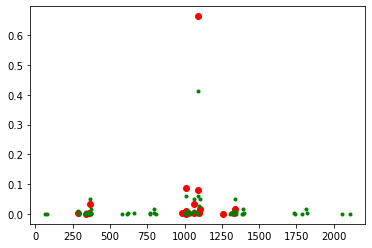

In [31]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")